In [1]:
import torch.utils.data as data
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from PIL import Image
import random
import tensorflow as tf
from io import BytesIO

In [2]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [3]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    img = img.resize((256, 256), Image.BICUBIC)
    return img

In [4]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', direction='a2b'):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.input_path = os.path.join(image_dir, subfolder)
        self.a_path = os.path.join(self.input_path, "a")
        self.b_path = os.path.join(self.input_path, "b")
        self.image_filenames = [x for x in os.listdir(self.a_path) if is_image_file(x)]

        transform_list = [transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(os.path.join(self.b_path, self.image_filenames[index])).convert('RGB')
        a = a.resize((286, 286), Image.BICUBIC)
        b = b.resize((286, 286), Image.BICUBIC)
        a = transforms.ToTensor()(a)
        b = transforms.ToTensor()(b)
        w_offset = random.randint(0, max(0, 286 - 256 - 1))
        h_offset = random.randint(0, max(0, 286 - 256 - 1))
    
        a = a[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
        b = b[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
    
        a = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)
        b = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(b)

        if random.random() < 0.5:
            idx = [i for i in range(a.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            a = a.index_select(2, idx)
            b = b.index_select(2, idx)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    def __len__(self):
        return len(self.image_filenames)

In [5]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out

In [6]:
class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out

In [7]:
#GENERATOR

class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)

In [8]:
#GENERATOR128

class Generator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator128, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv5 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv6 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv7 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc7)
        dec1 = torch.cat([dec1, enc6], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc5], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc4], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc3], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc2], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc1], 1)
        dec7 = self.deconv7(dec6)
        out = torch.nn.Tanh()(dec7)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)


In [9]:
#DISCRIMINATOR

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8, stride=1)
        self.conv5 = ConvBlock(num_filter * 8, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)

In [10]:
#DISCRIMINATOR128

class Discriminator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator128, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4, stride=1)
        self.conv4 = ConvBlock(num_filter * 4, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)

In [11]:
# For logger
def to_np(x):
    return x.data.cpu().numpy()


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


# Plot losses
def plot_loss(d_losses, g_losses, num_epochs, save=False, save_dir='results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Loss_values_epoch_{:d}'.format(num_epochs) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_test_result(input, target, gen_image, epoch, training=True, save=False, save_dir='results/', show=False, fig_size=(5, 5)):
    if not training:
        fig_size = (input.size(2) * 3 / 100, input.size(3)/100)

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if training:
            save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = save_dir + 'Test_result_{:d}'.format(epoch+1) + '.png'
            fig.subplots_adjust(bottom=0)
            fig.subplots_adjust(top=1)
            fig.subplots_adjust(right=1)
            fig.subplots_adjust(left=0)
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


# Make gif
def make_gif(dataset, num_epochs, save_dir='results/'):
    gen_image_plots = []
    for epoch in range(num_epochs):
        # plot for generating gif
        save_fn = save_dir + 'Result_epoch_{:d}'.format(epoch + 1) + '.png'
        gen_image_plots.append(imageio.imread(save_fn))

    imageio.mimsave(save_dir + '_pix2pix_epochs_{:d}'.format(num_epochs) + '.gif', gen_image_plots, fps=5)

In [12]:
#LOGGER

class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            # scipy.misc.toimage(img).save(s, format="png")
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [20]:
params = {}
params['dataset'] = '/home/richards/Richards/ML/NUSIntern/vision-master/references/detection/Depth Maping/DepthData2'
params['direction'] = 'a2b'
params['batch_size'] = 4
params['ngf'] = 64
params['ndf'] = 64
params['input_size'] = 256
params['resize_scale'] = 286
params['crop_size'] = 256
params['fliplr'] = True
params['num_epochs'] = 50
params['lrG'] = 0.0002
params['lrD'] = 0.0002
params['lamb'] = 100
params['beta1'] = 0.5
params['beta2'] = 0.999

In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, val_idx)
    return datasets

5000
3750
1250


/home/richards/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/richards/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/richards/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Epoch [1/50], Step [1/3750], D_loss: 0.8536, G_loss: 44.4625
Epoch [1/50], Step [2/3750], D_loss: 0.9520, G_loss: 47.8582
Epoch [1/50], Step [3/3750], D_loss: 0.8511, G_loss: 47.4534
Epoch [1/50], Step [4/3750], D_loss: 0.7201, G_loss: 60.0297
Epoch [1/50], Step [5/3750], D_loss: 0.7786, G_loss: 45.0624
Epoch [1/50], Step [6/3750], D_loss: 0.5480, G_loss: 45.9843
Epoch [1/50], Step [7/3750], D_loss: 0.5174, G_loss: 45.7007
Epoch [1/50], Step [8/3750], D_loss: 0.4280, G_loss: 43.5882
Epoch [1/50], Step [9/3750], D_loss: 0.3996, G_loss: 36.8751
Epoch [1/50], Step [10/3750], D_loss: 0.5339, G_loss: 35.5609
Epoch [1/50], Step [11/3750], D_loss: 0.5053, G_loss: 38.3108
Epoch [1/50], Step [12/3750], D_loss: 0.4792, G_loss: 33.3154
Epoch [1/50], Step [13/3750], D_loss: 0.4724, G_loss: 30.0932
Epoch [1/50], Step [14/3750], D_loss: 0.4071, G_loss: 30.5570
Epoch [1/50], Step [15/3750], D_loss: 0.4142, G_loss: 27.3587
Epoch [1/50], Step [16/3750], D_loss: 0.4665, G_loss: 25.0812
Epoch [1/50], Ste

Epoch [1/50], Step [134/3750], D_loss: 0.6299, G_loss: 14.8663
Epoch [1/50], Step [135/3750], D_loss: 0.7592, G_loss: 10.5886
Epoch [1/50], Step [136/3750], D_loss: 0.7303, G_loss: 8.0325
Epoch [1/50], Step [137/3750], D_loss: 0.6507, G_loss: 5.1968
Epoch [1/50], Step [138/3750], D_loss: 0.6489, G_loss: 8.4357
Epoch [1/50], Step [139/3750], D_loss: 0.6460, G_loss: 12.0146
Epoch [1/50], Step [140/3750], D_loss: 0.5968, G_loss: 6.0360
Epoch [1/50], Step [141/3750], D_loss: 0.5466, G_loss: 12.4281
Epoch [1/50], Step [142/3750], D_loss: 0.5675, G_loss: 12.1134
Epoch [1/50], Step [143/3750], D_loss: 0.5136, G_loss: 58.3474
Epoch [1/50], Step [144/3750], D_loss: 0.6341, G_loss: 13.7360
Epoch [1/50], Step [145/3750], D_loss: 0.5640, G_loss: 9.9144
Epoch [1/50], Step [146/3750], D_loss: 0.5123, G_loss: 12.6720
Epoch [1/50], Step [147/3750], D_loss: 0.5626, G_loss: 8.6795
Epoch [1/50], Step [148/3750], D_loss: 0.4710, G_loss: 29.1057
Epoch [1/50], Step [149/3750], D_loss: 0.4426, G_loss: 16.499

Epoch [1/50], Step [266/3750], D_loss: 0.7048, G_loss: 6.4163
Epoch [1/50], Step [267/3750], D_loss: 0.6762, G_loss: 13.9809
Epoch [1/50], Step [268/3750], D_loss: 0.6575, G_loss: 4.8465
Epoch [1/50], Step [269/3750], D_loss: 0.7953, G_loss: 6.5757
Epoch [1/50], Step [270/3750], D_loss: 0.6314, G_loss: 12.2594
Epoch [1/50], Step [271/3750], D_loss: 0.5930, G_loss: 11.0920
Epoch [1/50], Step [272/3750], D_loss: 0.6452, G_loss: 20.0751
Epoch [1/50], Step [273/3750], D_loss: 0.5780, G_loss: 9.7648
Epoch [1/50], Step [274/3750], D_loss: 0.8511, G_loss: 7.1072
Epoch [1/50], Step [275/3750], D_loss: 0.7537, G_loss: 18.8662
Epoch [1/50], Step [276/3750], D_loss: 0.7543, G_loss: 7.3575
Epoch [1/50], Step [277/3750], D_loss: 0.6455, G_loss: 13.9870
Epoch [1/50], Step [278/3750], D_loss: 0.5949, G_loss: 6.5580
Epoch [1/50], Step [279/3750], D_loss: 0.6959, G_loss: 10.0539
Epoch [1/50], Step [280/3750], D_loss: 0.6964, G_loss: 9.0222
Epoch [1/50], Step [281/3750], D_loss: 0.6714, G_loss: 10.6614


Epoch [1/50], Step [398/3750], D_loss: 0.5515, G_loss: 4.5873
Epoch [1/50], Step [399/3750], D_loss: 0.6013, G_loss: 12.2016
Epoch [1/50], Step [400/3750], D_loss: 0.8533, G_loss: 17.8461
Epoch [1/50], Step [401/3750], D_loss: 0.7859, G_loss: 7.5520
Epoch [1/50], Step [402/3750], D_loss: 0.7675, G_loss: 4.0744
Epoch [1/50], Step [403/3750], D_loss: 0.6719, G_loss: 6.8730
Epoch [1/50], Step [404/3750], D_loss: 0.6643, G_loss: 5.7714
Epoch [1/50], Step [405/3750], D_loss: 0.6011, G_loss: 21.2431
Epoch [1/50], Step [406/3750], D_loss: 0.7156, G_loss: 4.8210
Epoch [1/50], Step [407/3750], D_loss: 0.4421, G_loss: 11.1505
Epoch [1/50], Step [408/3750], D_loss: 0.7279, G_loss: 8.4414
Epoch [1/50], Step [409/3750], D_loss: 0.7507, G_loss: 11.4199
Epoch [1/50], Step [410/3750], D_loss: 0.5722, G_loss: 2.9573
Epoch [1/50], Step [411/3750], D_loss: 0.6266, G_loss: 8.1647
Epoch [1/50], Step [412/3750], D_loss: 0.6361, G_loss: 5.1134
Epoch [1/50], Step [413/3750], D_loss: 0.6565, G_loss: 5.0397
Epo

Epoch [1/50], Step [530/3750], D_loss: 0.5497, G_loss: 5.3346
Epoch [1/50], Step [531/3750], D_loss: 0.7145, G_loss: 12.7382
Epoch [1/50], Step [532/3750], D_loss: 0.5034, G_loss: 5.4522
Epoch [1/50], Step [533/3750], D_loss: 0.6060, G_loss: 5.2542
Epoch [1/50], Step [534/3750], D_loss: 0.6836, G_loss: 14.6949
Epoch [1/50], Step [535/3750], D_loss: 0.5793, G_loss: 9.5956
Epoch [1/50], Step [536/3750], D_loss: 0.4167, G_loss: 10.2134
Epoch [1/50], Step [537/3750], D_loss: 0.7883, G_loss: 10.1015
Epoch [1/50], Step [538/3750], D_loss: 0.8083, G_loss: 5.2084
Epoch [1/50], Step [539/3750], D_loss: 0.6864, G_loss: 23.9732
Epoch [1/50], Step [540/3750], D_loss: 0.3218, G_loss: 37.1682
Epoch [1/50], Step [541/3750], D_loss: 0.2746, G_loss: 29.7622
Epoch [1/50], Step [542/3750], D_loss: 0.8901, G_loss: 11.7333
Epoch [1/50], Step [543/3750], D_loss: 0.7745, G_loss: 7.6399
Epoch [1/50], Step [544/3750], D_loss: 0.9818, G_loss: 6.4695
Epoch [1/50], Step [545/3750], D_loss: 0.7217, G_loss: 5.7526


Epoch [1/50], Step [662/3750], D_loss: 0.7233, G_loss: 5.4712
Epoch [1/50], Step [663/3750], D_loss: 0.7484, G_loss: 14.0059
Epoch [1/50], Step [664/3750], D_loss: 0.7227, G_loss: 5.1875
Epoch [1/50], Step [665/3750], D_loss: 0.7182, G_loss: 4.8226
Epoch [1/50], Step [666/3750], D_loss: 0.7493, G_loss: 7.0221
Epoch [1/50], Step [667/3750], D_loss: 0.7107, G_loss: 7.7685
Epoch [1/50], Step [668/3750], D_loss: 0.6302, G_loss: 12.6306
Epoch [1/50], Step [669/3750], D_loss: 0.6985, G_loss: 5.2210
Epoch [1/50], Step [670/3750], D_loss: 0.5956, G_loss: 5.7781
Epoch [1/50], Step [671/3750], D_loss: 0.4006, G_loss: 18.2298
Epoch [1/50], Step [672/3750], D_loss: 0.6644, G_loss: 3.2304
Epoch [1/50], Step [673/3750], D_loss: 0.6580, G_loss: 7.6195
Epoch [1/50], Step [674/3750], D_loss: 0.7100, G_loss: 6.4886
Epoch [1/50], Step [675/3750], D_loss: 0.6490, G_loss: 7.3792
Epoch [1/50], Step [676/3750], D_loss: 0.6701, G_loss: 13.5400
Epoch [1/50], Step [677/3750], D_loss: 0.7335, G_loss: 8.9989
Epoc

Epoch [1/50], Step [794/3750], D_loss: 0.6530, G_loss: 8.5766
Epoch [1/50], Step [795/3750], D_loss: 0.6929, G_loss: 9.3529
Epoch [1/50], Step [796/3750], D_loss: 0.6699, G_loss: 7.6195
Epoch [1/50], Step [797/3750], D_loss: 0.7128, G_loss: 7.5123
Epoch [1/50], Step [798/3750], D_loss: 0.5319, G_loss: 10.0632
Epoch [1/50], Step [799/3750], D_loss: 0.6884, G_loss: 4.3425
Epoch [1/50], Step [800/3750], D_loss: 0.5033, G_loss: 3.0324
Epoch [1/50], Step [801/3750], D_loss: 0.7430, G_loss: 6.5020
Epoch [1/50], Step [802/3750], D_loss: 0.7010, G_loss: 6.2997
Epoch [1/50], Step [803/3750], D_loss: 0.6687, G_loss: 6.2585
Epoch [1/50], Step [804/3750], D_loss: 0.8150, G_loss: 7.3504
Epoch [1/50], Step [805/3750], D_loss: 0.5629, G_loss: 6.7545
Epoch [1/50], Step [806/3750], D_loss: 0.4254, G_loss: 33.0332
Epoch [1/50], Step [807/3750], D_loss: 0.5861, G_loss: 7.3785
Epoch [1/50], Step [808/3750], D_loss: 0.6701, G_loss: 6.2900
Epoch [1/50], Step [809/3750], D_loss: 0.6957, G_loss: 7.5607
Epoch 

Epoch [1/50], Step [926/3750], D_loss: 0.4233, G_loss: 14.2658
Epoch [1/50], Step [927/3750], D_loss: 0.6953, G_loss: 9.0910
Epoch [1/50], Step [928/3750], D_loss: 0.5122, G_loss: 9.4483
Epoch [1/50], Step [929/3750], D_loss: 0.7403, G_loss: 5.2913
Epoch [1/50], Step [930/3750], D_loss: 0.8767, G_loss: 5.3416
Epoch [1/50], Step [931/3750], D_loss: 0.3555, G_loss: 30.7239
Epoch [1/50], Step [932/3750], D_loss: 0.7266, G_loss: 8.3184
Epoch [1/50], Step [933/3750], D_loss: 0.6231, G_loss: 6.2697
Epoch [1/50], Step [934/3750], D_loss: 0.8523, G_loss: 7.7543
Epoch [1/50], Step [935/3750], D_loss: 0.4871, G_loss: 13.8187
Epoch [1/50], Step [936/3750], D_loss: 0.8048, G_loss: 7.7700
Epoch [1/50], Step [937/3750], D_loss: 0.5256, G_loss: 14.0261
Epoch [1/50], Step [938/3750], D_loss: 0.4583, G_loss: 18.2225
Epoch [1/50], Step [939/3750], D_loss: 0.7169, G_loss: 3.9529
Epoch [1/50], Step [940/3750], D_loss: 0.6632, G_loss: 3.9784
Epoch [1/50], Step [941/3750], D_loss: 0.7285, G_loss: 7.9803
Epo

Epoch [1/50], Step [1057/3750], D_loss: 0.5025, G_loss: 7.3287
Epoch [1/50], Step [1058/3750], D_loss: 0.4526, G_loss: 5.6962
Epoch [1/50], Step [1059/3750], D_loss: 0.9968, G_loss: 8.1853
Epoch [1/50], Step [1060/3750], D_loss: 0.7742, G_loss: 9.9957
Epoch [1/50], Step [1061/3750], D_loss: 0.7609, G_loss: 5.7178
Epoch [1/50], Step [1062/3750], D_loss: 0.4056, G_loss: 21.0756
Epoch [1/50], Step [1063/3750], D_loss: 0.4388, G_loss: 7.4757
Epoch [1/50], Step [1064/3750], D_loss: 0.5790, G_loss: 19.1757
Epoch [1/50], Step [1065/3750], D_loss: 0.3497, G_loss: 8.9382
Epoch [1/50], Step [1066/3750], D_loss: 0.6527, G_loss: 10.2204
Epoch [1/50], Step [1067/3750], D_loss: 0.6368, G_loss: 6.4065
Epoch [1/50], Step [1068/3750], D_loss: 0.6952, G_loss: 7.1198
Epoch [1/50], Step [1069/3750], D_loss: 0.9258, G_loss: 9.6537
Epoch [1/50], Step [1070/3750], D_loss: 0.8270, G_loss: 7.0579
Epoch [1/50], Step [1071/3750], D_loss: 0.7578, G_loss: 5.2880
Epoch [1/50], Step [1072/3750], D_loss: 0.6911, G_lo

Epoch [1/50], Step [1187/3750], D_loss: 0.3658, G_loss: 10.8550
Epoch [1/50], Step [1188/3750], D_loss: 0.7072, G_loss: 13.8851
Epoch [1/50], Step [1189/3750], D_loss: 0.3379, G_loss: 17.9840
Epoch [1/50], Step [1190/3750], D_loss: 0.3216, G_loss: 13.0172
Epoch [1/50], Step [1191/3750], D_loss: 0.4170, G_loss: 22.3254
Epoch [1/50], Step [1192/3750], D_loss: 0.6504, G_loss: 9.5640
Epoch [1/50], Step [1193/3750], D_loss: 0.7925, G_loss: 6.0467
Epoch [1/50], Step [1194/3750], D_loss: 0.6968, G_loss: 6.5754
Epoch [1/50], Step [1195/3750], D_loss: 0.6110, G_loss: 10.7094
Epoch [1/50], Step [1196/3750], D_loss: 0.6751, G_loss: 4.3610
Epoch [1/50], Step [1197/3750], D_loss: 0.8136, G_loss: 5.0228
Epoch [1/50], Step [1198/3750], D_loss: 0.7188, G_loss: 2.8988
Epoch [1/50], Step [1199/3750], D_loss: 0.7179, G_loss: 2.3229
Epoch [1/50], Step [1200/3750], D_loss: 0.6760, G_loss: 6.3742
Epoch [1/50], Step [1201/3750], D_loss: 0.3686, G_loss: 16.6968
Epoch [1/50], Step [1202/3750], D_loss: 0.7838, 

Epoch [1/50], Step [1317/3750], D_loss: 0.4583, G_loss: 10.8763
Epoch [1/50], Step [1318/3750], D_loss: 0.2420, G_loss: 19.6919
Epoch [1/50], Step [1319/3750], D_loss: 0.7424, G_loss: 10.6602
Epoch [1/50], Step [1320/3750], D_loss: 0.8555, G_loss: 5.9026
Epoch [1/50], Step [1321/3750], D_loss: 0.9079, G_loss: 6.9946
Epoch [1/50], Step [1322/3750], D_loss: 0.7955, G_loss: 3.5882
Epoch [1/50], Step [1323/3750], D_loss: 0.5722, G_loss: 9.1186
Epoch [1/50], Step [1324/3750], D_loss: 0.7614, G_loss: 7.6600
Epoch [1/50], Step [1325/3750], D_loss: 0.8186, G_loss: 4.4142
Epoch [1/50], Step [1326/3750], D_loss: 0.5638, G_loss: 11.0545
Epoch [1/50], Step [1327/3750], D_loss: 0.7581, G_loss: 6.4714
Epoch [1/50], Step [1328/3750], D_loss: 0.7389, G_loss: 3.4640
Epoch [1/50], Step [1329/3750], D_loss: 0.5514, G_loss: 8.5880
Epoch [1/50], Step [1330/3750], D_loss: 0.4526, G_loss: 6.8966
Epoch [1/50], Step [1331/3750], D_loss: 0.5997, G_loss: 7.4104
Epoch [1/50], Step [1332/3750], D_loss: 0.6934, G_l

Epoch [1/50], Step [1447/3750], D_loss: 0.6139, G_loss: 3.5704
Epoch [1/50], Step [1448/3750], D_loss: 0.8297, G_loss: 5.7000
Epoch [1/50], Step [1449/3750], D_loss: 0.7436, G_loss: 9.5028
Epoch [1/50], Step [1450/3750], D_loss: 0.6882, G_loss: 4.6489
Epoch [1/50], Step [1451/3750], D_loss: 0.7505, G_loss: 7.5942
Epoch [1/50], Step [1452/3750], D_loss: 0.6524, G_loss: 17.5520
Epoch [1/50], Step [1453/3750], D_loss: 0.7272, G_loss: 8.1437
Epoch [1/50], Step [1454/3750], D_loss: 0.7305, G_loss: 8.9740
Epoch [1/50], Step [1455/3750], D_loss: 0.6623, G_loss: 7.7664
Epoch [1/50], Step [1456/3750], D_loss: 0.4568, G_loss: 12.5888
Epoch [1/50], Step [1457/3750], D_loss: 0.6856, G_loss: 17.3134
Epoch [1/50], Step [1458/3750], D_loss: 0.6766, G_loss: 7.5459
Epoch [1/50], Step [1459/3750], D_loss: 0.6534, G_loss: 11.0594
Epoch [1/50], Step [1460/3750], D_loss: 0.6954, G_loss: 7.0827
Epoch [1/50], Step [1461/3750], D_loss: 0.6244, G_loss: 7.2215
Epoch [1/50], Step [1462/3750], D_loss: 0.6202, G_l

Epoch [1/50], Step [1577/3750], D_loss: 0.8750, G_loss: 5.3776
Epoch [1/50], Step [1578/3750], D_loss: 0.6679, G_loss: 13.0445
Epoch [1/50], Step [1579/3750], D_loss: 0.6674, G_loss: 3.9998
Epoch [1/50], Step [1580/3750], D_loss: 0.6765, G_loss: 3.5386
Epoch [1/50], Step [1581/3750], D_loss: 0.6285, G_loss: 4.0715
Epoch [1/50], Step [1582/3750], D_loss: 0.7720, G_loss: 9.5705
Epoch [1/50], Step [1583/3750], D_loss: 0.6266, G_loss: 3.4416
Epoch [1/50], Step [1584/3750], D_loss: 0.7094, G_loss: 4.5231
Epoch [1/50], Step [1585/3750], D_loss: 0.7261, G_loss: 7.6625
Epoch [1/50], Step [1586/3750], D_loss: 0.7344, G_loss: 4.0161
Epoch [1/50], Step [1587/3750], D_loss: 0.6398, G_loss: 10.8956
Epoch [1/50], Step [1588/3750], D_loss: 0.7172, G_loss: 2.9979
Epoch [1/50], Step [1589/3750], D_loss: 0.2737, G_loss: 28.7727
Epoch [1/50], Step [1590/3750], D_loss: 0.6478, G_loss: 5.4152
Epoch [1/50], Step [1591/3750], D_loss: 0.7125, G_loss: 3.7140
Epoch [1/50], Step [1592/3750], D_loss: 0.6658, G_lo

Epoch [1/50], Step [1707/3750], D_loss: 0.4906, G_loss: 8.2034
Epoch [1/50], Step [1708/3750], D_loss: 0.7369, G_loss: 8.5280
Epoch [1/50], Step [1709/3750], D_loss: 0.3531, G_loss: 18.0682
Epoch [1/50], Step [1710/3750], D_loss: 0.4065, G_loss: 12.4048
Epoch [1/50], Step [1711/3750], D_loss: 0.7838, G_loss: 5.9121
Epoch [1/50], Step [1712/3750], D_loss: 0.7209, G_loss: 3.4908
Epoch [1/50], Step [1713/3750], D_loss: 0.3618, G_loss: 14.2394
Epoch [1/50], Step [1714/3750], D_loss: 0.8108, G_loss: 4.1269
Epoch [1/50], Step [1715/3750], D_loss: 0.5544, G_loss: 9.5052
Epoch [1/50], Step [1716/3750], D_loss: 0.8219, G_loss: 4.8716
Epoch [1/50], Step [1717/3750], D_loss: 0.7881, G_loss: 4.0023
Epoch [1/50], Step [1718/3750], D_loss: 0.6976, G_loss: 8.8307
Epoch [1/50], Step [1719/3750], D_loss: 0.4680, G_loss: 9.6936
Epoch [1/50], Step [1720/3750], D_loss: 0.7272, G_loss: 10.3105
Epoch [1/50], Step [1721/3750], D_loss: 0.7043, G_loss: 4.6121
Epoch [1/50], Step [1722/3750], D_loss: 0.6833, G_l

Epoch [1/50], Step [1837/3750], D_loss: 0.8823, G_loss: 8.6160
Epoch [1/50], Step [1838/3750], D_loss: 0.5031, G_loss: 17.5720
Epoch [1/50], Step [1839/3750], D_loss: 0.7033, G_loss: 6.6648
Epoch [1/50], Step [1840/3750], D_loss: 0.6974, G_loss: 2.7186
Epoch [1/50], Step [1841/3750], D_loss: 0.7238, G_loss: 6.1019
Epoch [1/50], Step [1842/3750], D_loss: 0.7142, G_loss: 4.6859
Epoch [1/50], Step [1843/3750], D_loss: 0.3126, G_loss: 19.0799
Epoch [1/50], Step [1844/3750], D_loss: 0.6897, G_loss: 6.5259
Epoch [1/50], Step [1845/3750], D_loss: 0.7127, G_loss: 6.0326
Epoch [1/50], Step [1846/3750], D_loss: 0.6727, G_loss: 5.4212
Epoch [1/50], Step [1847/3750], D_loss: 0.3904, G_loss: 25.0304
Epoch [1/50], Step [1848/3750], D_loss: 0.4122, G_loss: 10.6072
Epoch [1/50], Step [1849/3750], D_loss: 0.2147, G_loss: 10.3404
Epoch [1/50], Step [1850/3750], D_loss: 0.8086, G_loss: 14.6160
Epoch [1/50], Step [1851/3750], D_loss: 0.6422, G_loss: 14.3045
Epoch [1/50], Step [1852/3750], D_loss: 0.3122, 

Epoch [1/50], Step [1967/3750], D_loss: 0.7053, G_loss: 5.4639
Epoch [1/50], Step [1968/3750], D_loss: 0.5201, G_loss: 6.6498
Epoch [1/50], Step [1969/3750], D_loss: 0.6833, G_loss: 4.8719
Epoch [1/50], Step [1970/3750], D_loss: 0.8269, G_loss: 6.6579
Epoch [1/50], Step [1971/3750], D_loss: 0.4685, G_loss: 12.8401
Epoch [1/50], Step [1972/3750], D_loss: 0.3536, G_loss: 32.7762
Epoch [1/50], Step [1973/3750], D_loss: 0.3637, G_loss: 9.8067
Epoch [1/50], Step [1974/3750], D_loss: 0.9564, G_loss: 6.6771
Epoch [1/50], Step [1975/3750], D_loss: 0.8168, G_loss: 12.6726
Epoch [1/50], Step [1976/3750], D_loss: 0.7546, G_loss: 7.0521
Epoch [1/50], Step [1977/3750], D_loss: 0.6393, G_loss: 5.3414
Epoch [1/50], Step [1978/3750], D_loss: 0.6970, G_loss: 6.4112
Epoch [1/50], Step [1979/3750], D_loss: 0.6686, G_loss: 6.1661
Epoch [1/50], Step [1980/3750], D_loss: 0.7058, G_loss: 5.6367
Epoch [1/50], Step [1981/3750], D_loss: 0.6684, G_loss: 3.9117
Epoch [1/50], Step [1982/3750], D_loss: 0.5466, G_lo

Epoch [1/50], Step [2097/3750], D_loss: 0.3577, G_loss: 13.1038
Epoch [1/50], Step [2098/3750], D_loss: 0.7410, G_loss: 5.5699
Epoch [1/50], Step [2099/3750], D_loss: 0.3621, G_loss: 5.8257
Epoch [1/50], Step [2100/3750], D_loss: 0.7793, G_loss: 7.9274
Epoch [1/50], Step [2101/3750], D_loss: 0.7166, G_loss: 8.9200
Epoch [1/50], Step [2102/3750], D_loss: 0.7731, G_loss: 6.2260
Epoch [1/50], Step [2103/3750], D_loss: 0.7288, G_loss: 4.6841
Epoch [1/50], Step [2104/3750], D_loss: 0.6723, G_loss: 13.3586
Epoch [1/50], Step [2105/3750], D_loss: 0.3128, G_loss: 8.0692
Epoch [1/50], Step [2106/3750], D_loss: 0.3292, G_loss: 12.0113
Epoch [1/50], Step [2107/3750], D_loss: 0.7195, G_loss: 7.3808
Epoch [1/50], Step [2108/3750], D_loss: 0.7054, G_loss: 6.5591
Epoch [1/50], Step [2109/3750], D_loss: 0.5949, G_loss: 10.7882
Epoch [1/50], Step [2110/3750], D_loss: 0.6993, G_loss: 3.6347
Epoch [1/50], Step [2111/3750], D_loss: 0.6948, G_loss: 4.3658
Epoch [1/50], Step [2112/3750], D_loss: 0.7122, G_l

Epoch [1/50], Step [2227/3750], D_loss: 0.7535, G_loss: 8.7780
Epoch [1/50], Step [2228/3750], D_loss: 0.4180, G_loss: 11.5717
Epoch [1/50], Step [2229/3750], D_loss: 0.7434, G_loss: 8.8346
Epoch [1/50], Step [2230/3750], D_loss: 0.2614, G_loss: 10.8844
Epoch [1/50], Step [2231/3750], D_loss: 0.7534, G_loss: 8.8985
Epoch [1/50], Step [2232/3750], D_loss: 0.7010, G_loss: 6.8669
Epoch [1/50], Step [2233/3750], D_loss: 0.4423, G_loss: 8.5216
Epoch [1/50], Step [2234/3750], D_loss: 0.7795, G_loss: 9.9176
Epoch [1/50], Step [2235/3750], D_loss: 0.8438, G_loss: 6.9674
Epoch [1/50], Step [2236/3750], D_loss: 0.6452, G_loss: 5.4398
Epoch [1/50], Step [2237/3750], D_loss: 0.6952, G_loss: 3.6901
Epoch [1/50], Step [2238/3750], D_loss: 0.5965, G_loss: 3.6297
Epoch [1/50], Step [2239/3750], D_loss: 0.7701, G_loss: 7.0258
Epoch [1/50], Step [2240/3750], D_loss: 0.6253, G_loss: 5.2723
Epoch [1/50], Step [2241/3750], D_loss: 0.6416, G_loss: 4.3860
Epoch [1/50], Step [2242/3750], D_loss: 0.5948, G_los

Epoch [1/50], Step [2357/3750], D_loss: 0.7608, G_loss: 7.4382
Epoch [1/50], Step [2358/3750], D_loss: 0.7500, G_loss: 4.4777
Epoch [1/50], Step [2359/3750], D_loss: 0.4551, G_loss: 23.0676
Epoch [1/50], Step [2360/3750], D_loss: 0.6673, G_loss: 6.7657
Epoch [1/50], Step [2361/3750], D_loss: 0.6948, G_loss: 3.6850
Epoch [1/50], Step [2362/3750], D_loss: 0.6235, G_loss: 7.4869
Epoch [1/50], Step [2363/3750], D_loss: 0.7066, G_loss: 4.4138
Epoch [1/50], Step [2364/3750], D_loss: 0.7571, G_loss: 4.7666
Epoch [1/50], Step [2365/3750], D_loss: 0.5275, G_loss: 8.6011
Epoch [1/50], Step [2366/3750], D_loss: 0.4616, G_loss: 10.3996
Epoch [1/50], Step [2367/3750], D_loss: 0.3728, G_loss: 17.3044
Epoch [1/50], Step [2368/3750], D_loss: 0.5013, G_loss: 9.8606
Epoch [1/50], Step [2369/3750], D_loss: 0.7449, G_loss: 7.1381
Epoch [1/50], Step [2370/3750], D_loss: 0.4566, G_loss: 5.2555
Epoch [1/50], Step [2371/3750], D_loss: 0.3618, G_loss: 7.9766
Epoch [1/50], Step [2372/3750], D_loss: 0.2399, G_lo

Epoch [1/50], Step [2487/3750], D_loss: 0.6433, G_loss: 11.7050
Epoch [1/50], Step [2488/3750], D_loss: 0.4021, G_loss: 5.1303
Epoch [1/50], Step [2489/3750], D_loss: 0.1885, G_loss: 9.2176
Epoch [1/50], Step [2490/3750], D_loss: 0.5201, G_loss: 9.9432
Epoch [1/50], Step [2491/3750], D_loss: 0.6224, G_loss: 15.3701
Epoch [1/50], Step [2492/3750], D_loss: 0.6704, G_loss: 4.5811
Epoch [1/50], Step [2493/3750], D_loss: 0.6598, G_loss: 11.0427
Epoch [1/50], Step [2494/3750], D_loss: 0.6427, G_loss: 6.2893
Epoch [1/50], Step [2495/3750], D_loss: 0.6083, G_loss: 4.7249
Epoch [1/50], Step [2496/3750], D_loss: 0.4254, G_loss: 17.7543
Epoch [1/50], Step [2497/3750], D_loss: 0.7147, G_loss: 4.6456
Epoch [1/50], Step [2498/3750], D_loss: 0.6457, G_loss: 4.0390
Epoch [1/50], Step [2499/3750], D_loss: 0.7323, G_loss: 5.9104
Epoch [1/50], Step [2500/3750], D_loss: 0.8356, G_loss: 7.5084
Epoch [1/50], Step [2501/3750], D_loss: 0.5857, G_loss: 3.5256
Epoch [1/50], Step [2502/3750], D_loss: 0.6997, G_l

Epoch [1/50], Step [2617/3750], D_loss: 0.6821, G_loss: 5.7928
Epoch [1/50], Step [2618/3750], D_loss: 0.7065, G_loss: 3.9200
Epoch [1/50], Step [2619/3750], D_loss: 0.6767, G_loss: 5.3723
Epoch [1/50], Step [2620/3750], D_loss: 0.8015, G_loss: 11.6620
Epoch [1/50], Step [2621/3750], D_loss: 0.5201, G_loss: 16.6715
Epoch [1/50], Step [2622/3750], D_loss: 0.7219, G_loss: 7.0453
Epoch [1/50], Step [2623/3750], D_loss: 0.7001, G_loss: 7.7007
Epoch [1/50], Step [2624/3750], D_loss: 0.7060, G_loss: 4.4864
Epoch [1/50], Step [2625/3750], D_loss: 0.7001, G_loss: 3.4744
Epoch [1/50], Step [2626/3750], D_loss: 0.7025, G_loss: 2.9364
Epoch [1/50], Step [2627/3750], D_loss: 0.7032, G_loss: 8.3479
Epoch [1/50], Step [2628/3750], D_loss: 0.3470, G_loss: 59.8016
Epoch [1/50], Step [2629/3750], D_loss: 0.7334, G_loss: 2.9201
Epoch [1/50], Step [2630/3750], D_loss: 0.7080, G_loss: 4.3685
Epoch [1/50], Step [2631/3750], D_loss: 0.6156, G_loss: 7.4499
Epoch [1/50], Step [2632/3750], D_loss: 0.6773, G_lo

Epoch [1/50], Step [2747/3750], D_loss: 0.8181, G_loss: 12.1342
Epoch [1/50], Step [2748/3750], D_loss: 0.7381, G_loss: 2.7204
Epoch [1/50], Step [2749/3750], D_loss: 0.6642, G_loss: 9.2122
Epoch [1/50], Step [2750/3750], D_loss: 0.6630, G_loss: 3.5973
Epoch [1/50], Step [2751/3750], D_loss: 0.6979, G_loss: 5.2351
Epoch [1/50], Step [2752/3750], D_loss: 0.7050, G_loss: 6.0730
Epoch [1/50], Step [2753/3750], D_loss: 0.6375, G_loss: 6.3886
Epoch [1/50], Step [2754/3750], D_loss: 0.7104, G_loss: 4.2999
Epoch [1/50], Step [2755/3750], D_loss: 0.7614, G_loss: 9.8453
Epoch [1/50], Step [2756/3750], D_loss: 0.6958, G_loss: 6.1369
Epoch [1/50], Step [2757/3750], D_loss: 0.6846, G_loss: 10.1421
Epoch [1/50], Step [2758/3750], D_loss: 0.6996, G_loss: 5.6068
Epoch [1/50], Step [2759/3750], D_loss: 0.7196, G_loss: 10.2376
Epoch [1/50], Step [2760/3750], D_loss: 0.7328, G_loss: 6.7721
Epoch [1/50], Step [2761/3750], D_loss: 0.6678, G_loss: 4.4695
Epoch [1/50], Step [2762/3750], D_loss: 0.7419, G_lo

Epoch [1/50], Step [2877/3750], D_loss: 0.7124, G_loss: 5.5305
Epoch [1/50], Step [2878/3750], D_loss: 0.7665, G_loss: 5.2249
Epoch [1/50], Step [2879/3750], D_loss: 0.7190, G_loss: 3.4156
Epoch [1/50], Step [2880/3750], D_loss: 0.7420, G_loss: 5.4911
Epoch [1/50], Step [2881/3750], D_loss: 0.7233, G_loss: 4.0837
Epoch [1/50], Step [2882/3750], D_loss: 0.7257, G_loss: 10.1037
Epoch [1/50], Step [2883/3750], D_loss: 0.7093, G_loss: 7.3643
Epoch [1/50], Step [2884/3750], D_loss: 0.6749, G_loss: 10.2565
Epoch [1/50], Step [2885/3750], D_loss: 0.6910, G_loss: 6.0615
Epoch [1/50], Step [2886/3750], D_loss: 0.6818, G_loss: 4.0683
Epoch [1/50], Step [2887/3750], D_loss: 0.4702, G_loss: 20.9060
Epoch [1/50], Step [2888/3750], D_loss: 0.7627, G_loss: 12.9718
Epoch [1/50], Step [2889/3750], D_loss: 0.7012, G_loss: 6.2329
Epoch [1/50], Step [2890/3750], D_loss: 0.6951, G_loss: 4.4713
Epoch [1/50], Step [2891/3750], D_loss: 0.6865, G_loss: 3.2973
Epoch [1/50], Step [2892/3750], D_loss: 0.7066, G_l

Epoch [1/50], Step [3007/3750], D_loss: 0.8344, G_loss: 8.0498
Epoch [1/50], Step [3008/3750], D_loss: 0.6363, G_loss: 4.8596
Epoch [1/50], Step [3009/3750], D_loss: 0.7684, G_loss: 4.1240
Epoch [1/50], Step [3010/3750], D_loss: 0.7624, G_loss: 6.0200
Epoch [1/50], Step [3011/3750], D_loss: 0.7336, G_loss: 4.5544
Epoch [1/50], Step [3012/3750], D_loss: 0.6602, G_loss: 5.7533
Epoch [1/50], Step [3013/3750], D_loss: 0.6198, G_loss: 4.5334
Epoch [1/50], Step [3014/3750], D_loss: 0.4632, G_loss: 14.7635
Epoch [1/50], Step [3015/3750], D_loss: 0.6463, G_loss: 10.3553
Epoch [1/50], Step [3016/3750], D_loss: 0.7574, G_loss: 6.6595
Epoch [1/50], Step [3017/3750], D_loss: 0.7672, G_loss: 5.3654
Epoch [1/50], Step [3018/3750], D_loss: 0.7975, G_loss: 4.7034
Epoch [1/50], Step [3019/3750], D_loss: 0.5593, G_loss: 12.5199
Epoch [1/50], Step [3020/3750], D_loss: 0.6394, G_loss: 6.3482
Epoch [1/50], Step [3021/3750], D_loss: 0.6994, G_loss: 3.4335
Epoch [1/50], Step [3022/3750], D_loss: 0.6713, G_lo

Epoch [1/50], Step [3137/3750], D_loss: 0.7087, G_loss: 7.9068
Epoch [1/50], Step [3138/3750], D_loss: 0.7837, G_loss: 5.8804
Epoch [1/50], Step [3139/3750], D_loss: 0.7327, G_loss: 4.7430
Epoch [1/50], Step [3140/3750], D_loss: 0.7346, G_loss: 5.9279
Epoch [1/50], Step [3141/3750], D_loss: 0.6532, G_loss: 9.8181
Epoch [1/50], Step [3142/3750], D_loss: 0.7610, G_loss: 4.5026
Epoch [1/50], Step [3143/3750], D_loss: 0.7037, G_loss: 6.9470
Epoch [1/50], Step [3144/3750], D_loss: 0.7026, G_loss: 4.5813
Epoch [1/50], Step [3145/3750], D_loss: 0.5923, G_loss: 6.9463
Epoch [1/50], Step [3146/3750], D_loss: 0.4719, G_loss: 11.4854
Epoch [1/50], Step [3147/3750], D_loss: 0.8996, G_loss: 9.3890
Epoch [1/50], Step [3148/3750], D_loss: 0.7353, G_loss: 6.1760
Epoch [1/50], Step [3149/3750], D_loss: 1.0070, G_loss: 11.0551
Epoch [1/50], Step [3150/3750], D_loss: 0.6641, G_loss: 4.6307
Epoch [1/50], Step [3151/3750], D_loss: 0.7811, G_loss: 8.0588
Epoch [1/50], Step [3152/3750], D_loss: 0.6323, G_los

Epoch [1/50], Step [3267/3750], D_loss: 0.4767, G_loss: 11.3784
Epoch [1/50], Step [3268/3750], D_loss: 0.4175, G_loss: 12.7743
Epoch [1/50], Step [3269/3750], D_loss: 0.7535, G_loss: 8.1852
Epoch [1/50], Step [3270/3750], D_loss: 0.3212, G_loss: 7.6405
Epoch [1/50], Step [3271/3750], D_loss: 0.7061, G_loss: 5.1284
Epoch [1/50], Step [3272/3750], D_loss: 0.6348, G_loss: 6.6918
Epoch [1/50], Step [3273/3750], D_loss: 0.5656, G_loss: 6.4716
Epoch [1/50], Step [3274/3750], D_loss: 0.5563, G_loss: 8.0630
Epoch [1/50], Step [3275/3750], D_loss: 0.7207, G_loss: 5.2823
Epoch [1/50], Step [3276/3750], D_loss: 0.6769, G_loss: 4.0403
Epoch [1/50], Step [3277/3750], D_loss: 0.5447, G_loss: 4.8195
Epoch [1/50], Step [3278/3750], D_loss: 0.6358, G_loss: 5.4873
Epoch [1/50], Step [3279/3750], D_loss: 0.8093, G_loss: 4.4112
Epoch [1/50], Step [3280/3750], D_loss: 0.7365, G_loss: 4.0140
Epoch [1/50], Step [3281/3750], D_loss: 0.6320, G_loss: 12.8535
Epoch [1/50], Step [3282/3750], D_loss: 0.3689, G_lo

Epoch [1/50], Step [3397/3750], D_loss: 0.6575, G_loss: 3.6073
Epoch [1/50], Step [3398/3750], D_loss: 0.6651, G_loss: 3.7031
Epoch [1/50], Step [3399/3750], D_loss: 0.7447, G_loss: 6.9513
Epoch [1/50], Step [3400/3750], D_loss: 0.8235, G_loss: 9.2688
Epoch [1/50], Step [3401/3750], D_loss: 0.6971, G_loss: 4.6823
Epoch [1/50], Step [3402/3750], D_loss: 0.5707, G_loss: 8.3287
Epoch [1/50], Step [3403/3750], D_loss: 0.6739, G_loss: 3.8332
Epoch [1/50], Step [3404/3750], D_loss: 0.5680, G_loss: 4.1763
Epoch [1/50], Step [3405/3750], D_loss: 0.6558, G_loss: 15.1488
Epoch [1/50], Step [3406/3750], D_loss: 0.8342, G_loss: 8.2081
Epoch [1/50], Step [3407/3750], D_loss: 0.7363, G_loss: 5.6519
Epoch [1/50], Step [3408/3750], D_loss: 0.6917, G_loss: 5.9976
Epoch [1/50], Step [3409/3750], D_loss: 0.5568, G_loss: 4.7701
Epoch [1/50], Step [3410/3750], D_loss: 0.5449, G_loss: 8.7307
Epoch [1/50], Step [3411/3750], D_loss: 0.7557, G_loss: 7.8302
Epoch [1/50], Step [3412/3750], D_loss: 0.7207, G_loss

Epoch [1/50], Step [3527/3750], D_loss: 0.6842, G_loss: 5.6321
Epoch [1/50], Step [3528/3750], D_loss: 0.3117, G_loss: 28.7062
Epoch [1/50], Step [3529/3750], D_loss: 0.7233, G_loss: 3.0353
Epoch [1/50], Step [3530/3750], D_loss: 0.6780, G_loss: 5.7862
Epoch [1/50], Step [3531/3750], D_loss: 0.6812, G_loss: 7.7298
Epoch [1/50], Step [3532/3750], D_loss: 0.7023, G_loss: 10.3924
Epoch [1/50], Step [3533/3750], D_loss: 0.7200, G_loss: 4.2702
Epoch [1/50], Step [3534/3750], D_loss: 0.6971, G_loss: 6.4854
Epoch [1/50], Step [3535/3750], D_loss: 0.3653, G_loss: 12.1547
Epoch [1/50], Step [3536/3750], D_loss: 0.6755, G_loss: 6.5646
Epoch [1/50], Step [3537/3750], D_loss: 0.6763, G_loss: 8.8324
Epoch [1/50], Step [3538/3750], D_loss: 0.6782, G_loss: 12.6192
Epoch [1/50], Step [3539/3750], D_loss: 0.7137, G_loss: 5.7323
Epoch [1/50], Step [3540/3750], D_loss: 0.6732, G_loss: 6.2672
Epoch [1/50], Step [3541/3750], D_loss: 0.7159, G_loss: 10.9352
Epoch [1/50], Step [3542/3750], D_loss: 0.6850, G_

Epoch [1/50], Step [3657/3750], D_loss: 0.4159, G_loss: 5.9358
Epoch [1/50], Step [3658/3750], D_loss: 0.6746, G_loss: 4.3213
Epoch [1/50], Step [3659/3750], D_loss: 0.5873, G_loss: 8.3789
Epoch [1/50], Step [3660/3750], D_loss: 0.6295, G_loss: 5.5790
Epoch [1/50], Step [3661/3750], D_loss: 0.6206, G_loss: 2.7244
Epoch [1/50], Step [3662/3750], D_loss: 0.8790, G_loss: 11.3390
Epoch [1/50], Step [3663/3750], D_loss: 0.4958, G_loss: 4.6938
Epoch [1/50], Step [3664/3750], D_loss: 0.5802, G_loss: 8.0622
Epoch [1/50], Step [3665/3750], D_loss: 0.7394, G_loss: 7.7796
Epoch [1/50], Step [3666/3750], D_loss: 0.3929, G_loss: 16.7034
Epoch [1/50], Step [3667/3750], D_loss: 0.6409, G_loss: 5.9332
Epoch [1/50], Step [3668/3750], D_loss: 0.7086, G_loss: 4.0107
Epoch [1/50], Step [3669/3750], D_loss: 0.6294, G_loss: 5.1155
Epoch [1/50], Step [3670/3750], D_loss: 0.8507, G_loss: 5.2553
Epoch [1/50], Step [3671/3750], D_loss: 0.6558, G_loss: 5.5932
Epoch [1/50], Step [3672/3750], D_loss: 0.6468, G_los

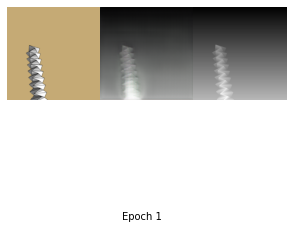

Epoch [2/50], Step [1/3750], D_loss: 0.6158, G_loss: 3.8743
Epoch [2/50], Step [2/3750], D_loss: 0.5624, G_loss: 3.3583
Epoch [2/50], Step [3/3750], D_loss: 0.3275, G_loss: 7.5668
Epoch [2/50], Step [4/3750], D_loss: 0.6630, G_loss: 3.7661
Epoch [2/50], Step [5/3750], D_loss: 0.6595, G_loss: 3.8624
Epoch [2/50], Step [6/3750], D_loss: 0.7121, G_loss: 3.8554
Epoch [2/50], Step [7/3750], D_loss: 0.7388, G_loss: 7.2541
Epoch [2/50], Step [8/3750], D_loss: 0.3961, G_loss: 9.1963
Epoch [2/50], Step [9/3750], D_loss: 0.6510, G_loss: 7.8720
Epoch [2/50], Step [10/3750], D_loss: 0.6229, G_loss: 8.2152
Epoch [2/50], Step [11/3750], D_loss: 0.7760, G_loss: 4.7408
Epoch [2/50], Step [12/3750], D_loss: 0.3431, G_loss: 8.2942
Epoch [2/50], Step [13/3750], D_loss: 0.6771, G_loss: 3.8937
Epoch [2/50], Step [14/3750], D_loss: 0.7146, G_loss: 3.4395
Epoch [2/50], Step [15/3750], D_loss: 0.6890, G_loss: 3.8940
Epoch [2/50], Step [16/3750], D_loss: 0.7187, G_loss: 7.7492
Epoch [2/50], Step [17/3750], D_l

Epoch [2/50], Step [135/3750], D_loss: 0.4938, G_loss: 28.6625
Epoch [2/50], Step [136/3750], D_loss: 0.7726, G_loss: 9.0755
Epoch [2/50], Step [137/3750], D_loss: 0.7252, G_loss: 3.1472
Epoch [2/50], Step [138/3750], D_loss: 0.7562, G_loss: 8.9723
Epoch [2/50], Step [139/3750], D_loss: 0.7373, G_loss: 6.7975
Epoch [2/50], Step [140/3750], D_loss: 0.6938, G_loss: 4.5402
Epoch [2/50], Step [141/3750], D_loss: 0.7095, G_loss: 4.9471
Epoch [2/50], Step [142/3750], D_loss: 0.5855, G_loss: 11.6186
Epoch [2/50], Step [143/3750], D_loss: 0.7070, G_loss: 3.6252
Epoch [2/50], Step [144/3750], D_loss: 0.4346, G_loss: 6.3923
Epoch [2/50], Step [145/3750], D_loss: 0.7608, G_loss: 4.9299
Epoch [2/50], Step [146/3750], D_loss: 0.8072, G_loss: 11.3244
Epoch [2/50], Step [147/3750], D_loss: 0.7272, G_loss: 4.5133
Epoch [2/50], Step [148/3750], D_loss: 0.6408, G_loss: 4.4000
Epoch [2/50], Step [149/3750], D_loss: 0.6040, G_loss: 5.7042
Epoch [2/50], Step [150/3750], D_loss: 0.7427, G_loss: 7.2561
Epoch

Epoch [2/50], Step [267/3750], D_loss: 0.4082, G_loss: 14.3444
Epoch [2/50], Step [268/3750], D_loss: 0.4961, G_loss: 4.4788
Epoch [2/50], Step [269/3750], D_loss: 0.5624, G_loss: 6.2134
Epoch [2/50], Step [270/3750], D_loss: 0.8120, G_loss: 7.9534
Epoch [2/50], Step [271/3750], D_loss: 0.8363, G_loss: 5.4878
Epoch [2/50], Step [272/3750], D_loss: 0.7436, G_loss: 6.2822
Epoch [2/50], Step [273/3750], D_loss: 0.8387, G_loss: 4.5807
Epoch [2/50], Step [274/3750], D_loss: 0.7319, G_loss: 4.9715
Epoch [2/50], Step [275/3750], D_loss: 0.6929, G_loss: 3.5350
Epoch [2/50], Step [276/3750], D_loss: 0.5841, G_loss: 7.7166
Epoch [2/50], Step [277/3750], D_loss: 0.7332, G_loss: 5.8618
Epoch [2/50], Step [278/3750], D_loss: 0.4715, G_loss: 18.6100
Epoch [2/50], Step [279/3750], D_loss: 0.7711, G_loss: 9.5446
Epoch [2/50], Step [280/3750], D_loss: 0.4091, G_loss: 11.3007
Epoch [2/50], Step [281/3750], D_loss: 0.7554, G_loss: 5.3716
Epoch [2/50], Step [282/3750], D_loss: 0.7667, G_loss: 11.8907
Epoc

Epoch [2/50], Step [399/3750], D_loss: 0.7341, G_loss: 8.1677
Epoch [2/50], Step [400/3750], D_loss: 0.7191, G_loss: 8.6062
Epoch [2/50], Step [401/3750], D_loss: 0.6016, G_loss: 23.3773
Epoch [2/50], Step [402/3750], D_loss: 0.6788, G_loss: 4.5980
Epoch [2/50], Step [403/3750], D_loss: 0.7058, G_loss: 4.5348
Epoch [2/50], Step [404/3750], D_loss: 0.7065, G_loss: 12.3579
Epoch [2/50], Step [405/3750], D_loss: 0.6858, G_loss: 3.1124
Epoch [2/50], Step [406/3750], D_loss: 0.5465, G_loss: 14.6859
Epoch [2/50], Step [407/3750], D_loss: 0.6987, G_loss: 7.6487
Epoch [2/50], Step [408/3750], D_loss: 0.6698, G_loss: 4.6939
Epoch [2/50], Step [409/3750], D_loss: 0.5888, G_loss: 6.4246
Epoch [2/50], Step [410/3750], D_loss: 0.5834, G_loss: 13.1252
Epoch [2/50], Step [411/3750], D_loss: 0.6880, G_loss: 4.3511
Epoch [2/50], Step [412/3750], D_loss: 0.6861, G_loss: 2.2595
Epoch [2/50], Step [413/3750], D_loss: 0.5871, G_loss: 6.3424
Epoch [2/50], Step [414/3750], D_loss: 0.8022, G_loss: 4.7303
Epoc

Epoch [2/50], Step [531/3750], D_loss: 0.6129, G_loss: 6.7287
Epoch [2/50], Step [532/3750], D_loss: 0.6348, G_loss: 5.4420
Epoch [2/50], Step [533/3750], D_loss: 0.7014, G_loss: 6.5650
Epoch [2/50], Step [534/3750], D_loss: 0.5810, G_loss: 7.1414
Epoch [2/50], Step [535/3750], D_loss: 0.7062, G_loss: 3.9275
Epoch [2/50], Step [536/3750], D_loss: 0.5552, G_loss: 13.5315
Epoch [2/50], Step [537/3750], D_loss: 0.4168, G_loss: 8.9596
Epoch [2/50], Step [538/3750], D_loss: 0.6839, G_loss: 6.3100
Epoch [2/50], Step [539/3750], D_loss: 0.7029, G_loss: 10.2351
Epoch [2/50], Step [540/3750], D_loss: 0.6497, G_loss: 6.0678
Epoch [2/50], Step [541/3750], D_loss: 0.6978, G_loss: 5.7183
Epoch [2/50], Step [542/3750], D_loss: 0.6502, G_loss: 4.4550
Epoch [2/50], Step [543/3750], D_loss: 0.7303, G_loss: 7.4890
Epoch [2/50], Step [544/3750], D_loss: 0.6807, G_loss: 5.4552
Epoch [2/50], Step [545/3750], D_loss: 0.6892, G_loss: 3.1068
Epoch [2/50], Step [546/3750], D_loss: 0.6994, G_loss: 6.9774
Epoch 

Epoch [2/50], Step [663/3750], D_loss: 0.6914, G_loss: 4.6783
Epoch [2/50], Step [664/3750], D_loss: 0.6902, G_loss: 4.2344
Epoch [2/50], Step [665/3750], D_loss: 0.6656, G_loss: 5.7120
Epoch [2/50], Step [666/3750], D_loss: 0.7228, G_loss: 9.3992
Epoch [2/50], Step [667/3750], D_loss: 0.6341, G_loss: 3.3839
Epoch [2/50], Step [668/3750], D_loss: 0.8569, G_loss: 7.7098
Epoch [2/50], Step [669/3750], D_loss: 0.5948, G_loss: 7.8568
Epoch [2/50], Step [670/3750], D_loss: 0.7142, G_loss: 6.3181
Epoch [2/50], Step [671/3750], D_loss: 0.6427, G_loss: 6.1246
Epoch [2/50], Step [672/3750], D_loss: 0.6851, G_loss: 5.1287
Epoch [2/50], Step [673/3750], D_loss: 0.7408, G_loss: 12.9751
Epoch [2/50], Step [674/3750], D_loss: 0.5249, G_loss: 12.5108
Epoch [2/50], Step [675/3750], D_loss: 0.5899, G_loss: 11.4557
Epoch [2/50], Step [676/3750], D_loss: 0.4783, G_loss: 5.3185
Epoch [2/50], Step [677/3750], D_loss: 0.5558, G_loss: 3.1816
Epoch [2/50], Step [678/3750], D_loss: 0.7353, G_loss: 7.6854
Epoch

Epoch [2/50], Step [795/3750], D_loss: 0.6476, G_loss: 7.7136
Epoch [2/50], Step [796/3750], D_loss: 0.7029, G_loss: 4.8176
Epoch [2/50], Step [797/3750], D_loss: 0.6929, G_loss: 3.5180
Epoch [2/50], Step [798/3750], D_loss: 0.7005, G_loss: 3.5057
Epoch [2/50], Step [799/3750], D_loss: 0.6675, G_loss: 3.5180
Epoch [2/50], Step [800/3750], D_loss: 0.7061, G_loss: 4.5604
Epoch [2/50], Step [801/3750], D_loss: 0.6038, G_loss: 3.8085
Epoch [2/50], Step [802/3750], D_loss: 0.6671, G_loss: 6.8182
Epoch [2/50], Step [803/3750], D_loss: 0.8947, G_loss: 12.1693
Epoch [2/50], Step [804/3750], D_loss: 0.5475, G_loss: 3.2460
Epoch [2/50], Step [805/3750], D_loss: 0.7251, G_loss: 6.3914
Epoch [2/50], Step [806/3750], D_loss: 0.5022, G_loss: 5.1085
Epoch [2/50], Step [807/3750], D_loss: 0.7583, G_loss: 9.2373
Epoch [2/50], Step [808/3750], D_loss: 0.6929, G_loss: 6.1187
Epoch [2/50], Step [809/3750], D_loss: 0.6735, G_loss: 7.5367
Epoch [2/50], Step [810/3750], D_loss: 0.6208, G_loss: 4.2504
Epoch [

Epoch [2/50], Step [927/3750], D_loss: 0.7051, G_loss: 7.6625
Epoch [2/50], Step [928/3750], D_loss: 0.7478, G_loss: 8.9184
Epoch [2/50], Step [929/3750], D_loss: 0.6617, G_loss: 2.8507
Epoch [2/50], Step [930/3750], D_loss: 0.6444, G_loss: 15.5136
Epoch [2/50], Step [931/3750], D_loss: 0.6832, G_loss: 6.6225
Epoch [2/50], Step [932/3750], D_loss: 0.6080, G_loss: 6.1632
Epoch [2/50], Step [933/3750], D_loss: 0.4476, G_loss: 6.1755
Epoch [2/50], Step [934/3750], D_loss: 0.4184, G_loss: 9.8131
Epoch [2/50], Step [935/3750], D_loss: 0.6996, G_loss: 4.3482
Epoch [2/50], Step [936/3750], D_loss: 0.7153, G_loss: 13.5366
Epoch [2/50], Step [937/3750], D_loss: 0.7677, G_loss: 7.4439
Epoch [2/50], Step [938/3750], D_loss: 0.7009, G_loss: 6.0361
Epoch [2/50], Step [939/3750], D_loss: 0.5936, G_loss: 7.7014
Epoch [2/50], Step [940/3750], D_loss: 0.7373, G_loss: 6.2458
Epoch [2/50], Step [941/3750], D_loss: 0.6531, G_loss: 5.4549
Epoch [2/50], Step [942/3750], D_loss: 0.7991, G_loss: 8.4057
Epoch 

Epoch [2/50], Step [1058/3750], D_loss: 0.6774, G_loss: 10.0621
Epoch [2/50], Step [1059/3750], D_loss: 0.7180, G_loss: 9.2253
Epoch [2/50], Step [1060/3750], D_loss: 0.6918, G_loss: 7.6338
Epoch [2/50], Step [1061/3750], D_loss: 0.6753, G_loss: 7.6789
Epoch [2/50], Step [1062/3750], D_loss: 0.7118, G_loss: 11.1810
Epoch [2/50], Step [1063/3750], D_loss: 0.6265, G_loss: 3.3741
Epoch [2/50], Step [1064/3750], D_loss: 0.6864, G_loss: 8.9638
Epoch [2/50], Step [1065/3750], D_loss: 0.6169, G_loss: 7.9244
Epoch [2/50], Step [1066/3750], D_loss: 0.5944, G_loss: 5.2768
Epoch [2/50], Step [1067/3750], D_loss: 0.6617, G_loss: 9.5018
Epoch [2/50], Step [1068/3750], D_loss: 0.6782, G_loss: 3.5808
Epoch [2/50], Step [1069/3750], D_loss: 0.6780, G_loss: 6.2395
Epoch [2/50], Step [1070/3750], D_loss: 0.7096, G_loss: 6.4960
Epoch [2/50], Step [1071/3750], D_loss: 0.7269, G_loss: 5.5290
Epoch [2/50], Step [1072/3750], D_loss: 0.5210, G_loss: 9.6815
Epoch [2/50], Step [1073/3750], D_loss: 0.6772, G_los

Epoch [2/50], Step [1188/3750], D_loss: 0.7083, G_loss: 5.2538
Epoch [2/50], Step [1189/3750], D_loss: 0.6604, G_loss: 7.0225
Epoch [2/50], Step [1190/3750], D_loss: 0.6915, G_loss: 3.2600
Epoch [2/50], Step [1191/3750], D_loss: 0.6993, G_loss: 3.9716
Epoch [2/50], Step [1192/3750], D_loss: 0.6986, G_loss: 3.0382
Epoch [2/50], Step [1193/3750], D_loss: 0.5487, G_loss: 13.7350
Epoch [2/50], Step [1194/3750], D_loss: 0.7044, G_loss: 3.6274
Epoch [2/50], Step [1195/3750], D_loss: 0.5362, G_loss: 26.1308
Epoch [2/50], Step [1196/3750], D_loss: 0.5446, G_loss: 5.5004
Epoch [2/50], Step [1197/3750], D_loss: 0.5911, G_loss: 7.7830
Epoch [2/50], Step [1198/3750], D_loss: 0.8894, G_loss: 9.9716
Epoch [2/50], Step [1199/3750], D_loss: 0.6426, G_loss: 5.4023
Epoch [2/50], Step [1200/3750], D_loss: 0.7486, G_loss: 7.4161
Epoch [2/50], Step [1201/3750], D_loss: 0.6391, G_loss: 3.4242
Epoch [2/50], Step [1202/3750], D_loss: 0.6493, G_loss: 7.1069
Epoch [2/50], Step [1203/3750], D_loss: 0.6571, G_los

Epoch [2/50], Step [1318/3750], D_loss: 0.6147, G_loss: 16.6060
Epoch [2/50], Step [1319/3750], D_loss: 0.5707, G_loss: 10.1797
Epoch [2/50], Step [1320/3750], D_loss: 0.6117, G_loss: 4.7870
Epoch [2/50], Step [1321/3750], D_loss: 0.6075, G_loss: 6.4787
Epoch [2/50], Step [1322/3750], D_loss: 0.5878, G_loss: 4.6689
Epoch [2/50], Step [1323/3750], D_loss: 0.3738, G_loss: 5.6051
Epoch [2/50], Step [1324/3750], D_loss: 0.3790, G_loss: 3.8216
Epoch [2/50], Step [1325/3750], D_loss: 0.6773, G_loss: 4.7116
Epoch [2/50], Step [1326/3750], D_loss: 0.9330, G_loss: 10.3625
Epoch [2/50], Step [1327/3750], D_loss: 0.7816, G_loss: 4.5620
Epoch [2/50], Step [1328/3750], D_loss: 0.6948, G_loss: 2.9203
Epoch [2/50], Step [1329/3750], D_loss: 0.6928, G_loss: 4.4228
Epoch [2/50], Step [1330/3750], D_loss: 0.5222, G_loss: 43.0170
Epoch [2/50], Step [1331/3750], D_loss: 0.5738, G_loss: 22.5596
Epoch [2/50], Step [1332/3750], D_loss: 0.5653, G_loss: 13.2358
Epoch [2/50], Step [1333/3750], D_loss: 0.7693, G

Epoch [2/50], Step [1448/3750], D_loss: 0.6802, G_loss: 6.4747
Epoch [2/50], Step [1449/3750], D_loss: 0.6492, G_loss: 3.1240
Epoch [2/50], Step [1450/3750], D_loss: 0.6793, G_loss: 8.5616
Epoch [2/50], Step [1451/3750], D_loss: 0.6734, G_loss: 3.7156
Epoch [2/50], Step [1452/3750], D_loss: 0.6507, G_loss: 3.7097
Epoch [2/50], Step [1453/3750], D_loss: 0.6442, G_loss: 3.3203
Epoch [2/50], Step [1454/3750], D_loss: 0.7137, G_loss: 6.6485
Epoch [2/50], Step [1455/3750], D_loss: 0.6964, G_loss: 9.4807
Epoch [2/50], Step [1456/3750], D_loss: 0.6876, G_loss: 5.4697
Epoch [2/50], Step [1457/3750], D_loss: 0.7062, G_loss: 5.0689
Epoch [2/50], Step [1458/3750], D_loss: 0.6530, G_loss: 5.7727
Epoch [2/50], Step [1459/3750], D_loss: 0.7248, G_loss: 6.0485
Epoch [2/50], Step [1460/3750], D_loss: 0.7278, G_loss: 3.4634
Epoch [2/50], Step [1461/3750], D_loss: 0.6382, G_loss: 6.7631
Epoch [2/50], Step [1462/3750], D_loss: 0.5169, G_loss: 16.5218
Epoch [2/50], Step [1463/3750], D_loss: 0.3206, G_loss

Epoch [2/50], Step [1578/3750], D_loss: 0.6920, G_loss: 12.4646
Epoch [2/50], Step [1579/3750], D_loss: 0.5983, G_loss: 9.7565
Epoch [2/50], Step [1580/3750], D_loss: 0.5574, G_loss: 12.0704
Epoch [2/50], Step [1581/3750], D_loss: 0.6846, G_loss: 3.9825
Epoch [2/50], Step [1582/3750], D_loss: 0.6662, G_loss: 3.9145
Epoch [2/50], Step [1583/3750], D_loss: 0.6057, G_loss: 6.7320
Epoch [2/50], Step [1584/3750], D_loss: 0.6837, G_loss: 3.2652
Epoch [2/50], Step [1585/3750], D_loss: 0.8158, G_loss: 7.7385
Epoch [2/50], Step [1586/3750], D_loss: 0.5829, G_loss: 5.8726
Epoch [2/50], Step [1587/3750], D_loss: 0.7066, G_loss: 10.9971
Epoch [2/50], Step [1588/3750], D_loss: 0.7303, G_loss: 3.6958
Epoch [2/50], Step [1589/3750], D_loss: 0.6414, G_loss: 9.2846
Epoch [2/50], Step [1590/3750], D_loss: 0.5116, G_loss: 9.0298
Epoch [2/50], Step [1591/3750], D_loss: 0.4829, G_loss: 8.5971
Epoch [2/50], Step [1592/3750], D_loss: 0.6597, G_loss: 2.2232
Epoch [2/50], Step [1593/3750], D_loss: 0.5811, G_lo

Epoch [2/50], Step [1708/3750], D_loss: 0.7475, G_loss: 2.1449
Epoch [2/50], Step [1709/3750], D_loss: 0.6040, G_loss: 4.3838
Epoch [2/50], Step [1710/3750], D_loss: 0.3964, G_loss: 7.3892
Epoch [2/50], Step [1711/3750], D_loss: 0.7542, G_loss: 5.4475
Epoch [2/50], Step [1712/3750], D_loss: 0.5723, G_loss: 10.7877
Epoch [2/50], Step [1713/3750], D_loss: 0.6533, G_loss: 5.5965
Epoch [2/50], Step [1714/3750], D_loss: 0.7091, G_loss: 4.7701
Epoch [2/50], Step [1715/3750], D_loss: 0.4759, G_loss: 8.4265
Epoch [2/50], Step [1716/3750], D_loss: 0.6479, G_loss: 3.7764
Epoch [2/50], Step [1717/3750], D_loss: 0.8531, G_loss: 3.1272
Epoch [2/50], Step [1718/3750], D_loss: 0.8075, G_loss: 7.0903
Epoch [2/50], Step [1719/3750], D_loss: 0.7483, G_loss: 3.1898
Epoch [2/50], Step [1720/3750], D_loss: 0.5829, G_loss: 8.8060
Epoch [2/50], Step [1721/3750], D_loss: 0.5842, G_loss: 8.4045
Epoch [2/50], Step [1722/3750], D_loss: 0.7882, G_loss: 5.6691
Epoch [2/50], Step [1723/3750], D_loss: 0.8326, G_loss

Epoch [2/50], Step [1838/3750], D_loss: 0.6275, G_loss: 4.3179
Epoch [2/50], Step [1839/3750], D_loss: 0.4918, G_loss: 9.4418
Epoch [2/50], Step [1840/3750], D_loss: 0.6211, G_loss: 4.3360
Epoch [2/50], Step [1841/3750], D_loss: 0.7729, G_loss: 6.8055
Epoch [2/50], Step [1842/3750], D_loss: 0.6944, G_loss: 7.6675
Epoch [2/50], Step [1843/3750], D_loss: 0.9867, G_loss: 11.7517
Epoch [2/50], Step [1844/3750], D_loss: 0.4267, G_loss: 8.1717
Epoch [2/50], Step [1845/3750], D_loss: 0.8431, G_loss: 8.7571
Epoch [2/50], Step [1846/3750], D_loss: 0.7117, G_loss: 3.7997
Epoch [2/50], Step [1847/3750], D_loss: 0.7372, G_loss: 10.5806
Epoch [2/50], Step [1848/3750], D_loss: 0.6777, G_loss: 9.1977
Epoch [2/50], Step [1849/3750], D_loss: 0.6864, G_loss: 3.4031
Epoch [2/50], Step [1850/3750], D_loss: 0.6411, G_loss: 6.3663
Epoch [2/50], Step [1851/3750], D_loss: 0.7056, G_loss: 13.9137
Epoch [2/50], Step [1852/3750], D_loss: 0.6905, G_loss: 3.4289
Epoch [2/50], Step [1853/3750], D_loss: 0.7184, G_lo

Epoch [2/50], Step [1968/3750], D_loss: 0.6523, G_loss: 4.4546
Epoch [2/50], Step [1969/3750], D_loss: 0.6596, G_loss: 3.7180
Epoch [2/50], Step [1970/3750], D_loss: 0.4743, G_loss: 4.9015
Epoch [2/50], Step [1971/3750], D_loss: 0.6273, G_loss: 7.5196
Epoch [2/50], Step [1972/3750], D_loss: 0.5824, G_loss: 3.4073
Epoch [2/50], Step [1973/3750], D_loss: 0.7378, G_loss: 5.3801
Epoch [2/50], Step [1974/3750], D_loss: 0.6386, G_loss: 3.8605
Epoch [2/50], Step [1975/3750], D_loss: 0.6065, G_loss: 4.5941
Epoch [2/50], Step [1976/3750], D_loss: 0.6869, G_loss: 9.2288
Epoch [2/50], Step [1977/3750], D_loss: 0.6099, G_loss: 7.1771
Epoch [2/50], Step [1978/3750], D_loss: 0.6599, G_loss: 8.1503
Epoch [2/50], Step [1979/3750], D_loss: 0.5712, G_loss: 8.0101
Epoch [2/50], Step [1980/3750], D_loss: 0.5540, G_loss: 9.8049
Epoch [2/50], Step [1981/3750], D_loss: 0.6700, G_loss: 8.0345
Epoch [2/50], Step [1982/3750], D_loss: 0.7616, G_loss: 4.8108
Epoch [2/50], Step [1983/3750], D_loss: 0.3025, G_loss:

Epoch [2/50], Step [2098/3750], D_loss: 0.6738, G_loss: 4.4263
Epoch [2/50], Step [2099/3750], D_loss: 0.7077, G_loss: 3.0631
Epoch [2/50], Step [2100/3750], D_loss: 0.7227, G_loss: 4.5274
Epoch [2/50], Step [2101/3750], D_loss: 0.6803, G_loss: 2.6858
Epoch [2/50], Step [2102/3750], D_loss: 0.6882, G_loss: 7.7829
Epoch [2/50], Step [2103/3750], D_loss: 0.6915, G_loss: 2.6290
Epoch [2/50], Step [2104/3750], D_loss: 0.7063, G_loss: 4.1713
Epoch [2/50], Step [2105/3750], D_loss: 0.6245, G_loss: 13.6199
Epoch [2/50], Step [2106/3750], D_loss: 0.7519, G_loss: 6.7243
Epoch [2/50], Step [2107/3750], D_loss: 0.5897, G_loss: 13.1609
Epoch [2/50], Step [2108/3750], D_loss: 0.7187, G_loss: 5.7080
Epoch [2/50], Step [2109/3750], D_loss: 0.7716, G_loss: 8.6406
Epoch [2/50], Step [2110/3750], D_loss: 0.5324, G_loss: 11.8127
Epoch [2/50], Step [2111/3750], D_loss: 0.7060, G_loss: 3.5392
Epoch [2/50], Step [2112/3750], D_loss: 0.6789, G_loss: 4.9607
Epoch [2/50], Step [2113/3750], D_loss: 0.6507, G_lo

Epoch [2/50], Step [2228/3750], D_loss: 0.6727, G_loss: 2.5112
Epoch [2/50], Step [2229/3750], D_loss: 0.7897, G_loss: 10.3711
Epoch [2/50], Step [2230/3750], D_loss: 0.6197, G_loss: 7.3504
Epoch [2/50], Step [2231/3750], D_loss: 0.6922, G_loss: 3.9067
Epoch [2/50], Step [2232/3750], D_loss: 0.7812, G_loss: 7.3480
Epoch [2/50], Step [2233/3750], D_loss: 0.5763, G_loss: 13.3263
Epoch [2/50], Step [2234/3750], D_loss: 0.6366, G_loss: 4.7497
Epoch [2/50], Step [2235/3750], D_loss: 0.6711, G_loss: 6.0735
Epoch [2/50], Step [2236/3750], D_loss: 0.6131, G_loss: 3.6695
Epoch [2/50], Step [2237/3750], D_loss: 0.6268, G_loss: 5.4257
Epoch [2/50], Step [2238/3750], D_loss: 0.7194, G_loss: 4.7091
Epoch [2/50], Step [2239/3750], D_loss: 0.6307, G_loss: 8.5813
Epoch [2/50], Step [2240/3750], D_loss: 0.8121, G_loss: 8.0227
Epoch [2/50], Step [2241/3750], D_loss: 0.6711, G_loss: 7.6725
Epoch [2/50], Step [2242/3750], D_loss: 0.7773, G_loss: 3.9434
Epoch [2/50], Step [2243/3750], D_loss: 0.7682, G_los

Epoch [2/50], Step [2358/3750], D_loss: 0.4715, G_loss: 8.5537
Epoch [2/50], Step [2359/3750], D_loss: 0.6673, G_loss: 7.7706
Epoch [2/50], Step [2360/3750], D_loss: 0.7050, G_loss: 3.8352
Epoch [2/50], Step [2361/3750], D_loss: 0.4949, G_loss: 3.5741
Epoch [2/50], Step [2362/3750], D_loss: 0.5590, G_loss: 2.5994
Epoch [2/50], Step [2363/3750], D_loss: 0.7281, G_loss: 5.8025
Epoch [2/50], Step [2364/3750], D_loss: 0.8243, G_loss: 6.7237
Epoch [2/50], Step [2365/3750], D_loss: 0.5942, G_loss: 33.6993
Epoch [2/50], Step [2366/3750], D_loss: 0.6458, G_loss: 6.3929
Epoch [2/50], Step [2367/3750], D_loss: 0.6503, G_loss: 9.0447
Epoch [2/50], Step [2368/3750], D_loss: 0.6529, G_loss: 4.6574
Epoch [2/50], Step [2369/3750], D_loss: 0.6847, G_loss: 3.0240
Epoch [2/50], Step [2370/3750], D_loss: 0.6517, G_loss: 7.6756
Epoch [2/50], Step [2371/3750], D_loss: 0.7777, G_loss: 10.7313
Epoch [2/50], Step [2372/3750], D_loss: 0.7229, G_loss: 5.8371
Epoch [2/50], Step [2373/3750], D_loss: 0.6314, G_los

Epoch [2/50], Step [2488/3750], D_loss: 0.7175, G_loss: 5.6961
Epoch [2/50], Step [2489/3750], D_loss: 0.5891, G_loss: 7.7314
Epoch [2/50], Step [2490/3750], D_loss: 0.6858, G_loss: 9.2376
Epoch [2/50], Step [2491/3750], D_loss: 0.7162, G_loss: 5.1465
Epoch [2/50], Step [2492/3750], D_loss: 0.6423, G_loss: 4.0833
Epoch [2/50], Step [2493/3750], D_loss: 0.7032, G_loss: 3.7380
Epoch [2/50], Step [2494/3750], D_loss: 0.6797, G_loss: 4.2056
Epoch [2/50], Step [2495/3750], D_loss: 0.7169, G_loss: 6.4949
Epoch [2/50], Step [2496/3750], D_loss: 0.7046, G_loss: 8.2691
Epoch [2/50], Step [2497/3750], D_loss: 0.6525, G_loss: 13.3800
Epoch [2/50], Step [2498/3750], D_loss: 0.6672, G_loss: 4.6875
Epoch [2/50], Step [2499/3750], D_loss: 0.5325, G_loss: 8.1457
Epoch [2/50], Step [2500/3750], D_loss: 0.6317, G_loss: 5.8626
Epoch [2/50], Step [2501/3750], D_loss: 0.6807, G_loss: 2.9912
Epoch [2/50], Step [2502/3750], D_loss: 0.6328, G_loss: 6.8845
Epoch [2/50], Step [2503/3750], D_loss: 0.6785, G_loss

Epoch [2/50], Step [2618/3750], D_loss: 0.5755, G_loss: 5.5675
Epoch [2/50], Step [2619/3750], D_loss: 1.1979, G_loss: 6.7995
Epoch [2/50], Step [2620/3750], D_loss: 0.7693, G_loss: 7.0115
Epoch [2/50], Step [2621/3750], D_loss: 0.7015, G_loss: 4.8970
Epoch [2/50], Step [2622/3750], D_loss: 0.6532, G_loss: 7.7072
Epoch [2/50], Step [2623/3750], D_loss: 0.6208, G_loss: 5.4361
Epoch [2/50], Step [2624/3750], D_loss: 0.6595, G_loss: 11.1542
Epoch [2/50], Step [2625/3750], D_loss: 0.6234, G_loss: 7.5112
Epoch [2/50], Step [2626/3750], D_loss: 0.6298, G_loss: 6.3751
Epoch [2/50], Step [2627/3750], D_loss: 0.5978, G_loss: 6.0301
Epoch [2/50], Step [2628/3750], D_loss: 0.6326, G_loss: 4.6851
Epoch [2/50], Step [2629/3750], D_loss: 0.6337, G_loss: 12.3224
Epoch [2/50], Step [2630/3750], D_loss: 0.6751, G_loss: 7.8420
Epoch [2/50], Step [2631/3750], D_loss: 0.6727, G_loss: 10.0320
Epoch [2/50], Step [2632/3750], D_loss: 0.7255, G_loss: 3.9723
Epoch [2/50], Step [2633/3750], D_loss: 1.0617, G_lo

Epoch [2/50], Step [2748/3750], D_loss: 0.6404, G_loss: 5.2682
Epoch [2/50], Step [2749/3750], D_loss: 0.6940, G_loss: 7.4896
Epoch [2/50], Step [2750/3750], D_loss: 0.4331, G_loss: 27.6924
Epoch [2/50], Step [2751/3750], D_loss: 0.5323, G_loss: 9.5270
Epoch [2/50], Step [2752/3750], D_loss: 0.6090, G_loss: 4.5439
Epoch [2/50], Step [2753/3750], D_loss: 0.6471, G_loss: 9.2585
Epoch [2/50], Step [2754/3750], D_loss: 1.0661, G_loss: 6.3061
Epoch [2/50], Step [2755/3750], D_loss: 0.7891, G_loss: 15.4685
Epoch [2/50], Step [2756/3750], D_loss: 0.6865, G_loss: 7.6172
Epoch [2/50], Step [2757/3750], D_loss: 0.6909, G_loss: 4.0514
Epoch [2/50], Step [2758/3750], D_loss: 0.6942, G_loss: 2.8351
Epoch [2/50], Step [2759/3750], D_loss: 0.7387, G_loss: 4.1850
Epoch [2/50], Step [2760/3750], D_loss: 0.6993, G_loss: 4.9316
Epoch [2/50], Step [2761/3750], D_loss: 0.7317, G_loss: 13.7410
Epoch [2/50], Step [2762/3750], D_loss: 0.6885, G_loss: 7.4283
Epoch [2/50], Step [2763/3750], D_loss: 0.6146, G_lo

Epoch [2/50], Step [2878/3750], D_loss: 0.8679, G_loss: 6.0180
Epoch [2/50], Step [2879/3750], D_loss: 0.5615, G_loss: 5.5730
Epoch [2/50], Step [2880/3750], D_loss: 0.3587, G_loss: 8.3811
Epoch [2/50], Step [2881/3750], D_loss: 0.2552, G_loss: 11.8011
Epoch [2/50], Step [2882/3750], D_loss: 0.8322, G_loss: 4.9497
Epoch [2/50], Step [2883/3750], D_loss: 0.7745, G_loss: 12.9004
Epoch [2/50], Step [2884/3750], D_loss: 0.6337, G_loss: 10.1657
Epoch [2/50], Step [2885/3750], D_loss: 0.6878, G_loss: 3.5376
Epoch [2/50], Step [2886/3750], D_loss: 0.6013, G_loss: 3.4526
Epoch [2/50], Step [2887/3750], D_loss: 0.6332, G_loss: 3.4067
Epoch [2/50], Step [2888/3750], D_loss: 0.8995, G_loss: 5.2202
Epoch [2/50], Step [2889/3750], D_loss: 0.5827, G_loss: 5.3381
Epoch [2/50], Step [2890/3750], D_loss: 0.6734, G_loss: 4.7562
Epoch [2/50], Step [2891/3750], D_loss: 0.7440, G_loss: 5.0644
Epoch [2/50], Step [2892/3750], D_loss: 0.6238, G_loss: 7.1034
Epoch [2/50], Step [2893/3750], D_loss: 0.7358, G_lo

Epoch [2/50], Step [3008/3750], D_loss: 0.7939, G_loss: 8.5192
Epoch [2/50], Step [3009/3750], D_loss: 0.7264, G_loss: 9.4462
Epoch [2/50], Step [3010/3750], D_loss: 0.6200, G_loss: 8.6560
Epoch [2/50], Step [3011/3750], D_loss: 0.6330, G_loss: 5.6615
Epoch [2/50], Step [3012/3750], D_loss: 0.5780, G_loss: 5.2452
Epoch [2/50], Step [3013/3750], D_loss: 0.6553, G_loss: 4.7973
Epoch [2/50], Step [3014/3750], D_loss: 0.6579, G_loss: 3.2015
Epoch [2/50], Step [3015/3750], D_loss: 0.6024, G_loss: 4.3311
Epoch [2/50], Step [3016/3750], D_loss: 0.7291, G_loss: 3.7557
Epoch [2/50], Step [3017/3750], D_loss: 0.9005, G_loss: 12.4676
Epoch [2/50], Step [3018/3750], D_loss: 0.6876, G_loss: 3.5657
Epoch [2/50], Step [3019/3750], D_loss: 0.6925, G_loss: 5.7787
Epoch [2/50], Step [3020/3750], D_loss: 0.7602, G_loss: 4.0654
Epoch [2/50], Step [3021/3750], D_loss: 0.8001, G_loss: 4.5170
Epoch [2/50], Step [3022/3750], D_loss: 0.6512, G_loss: 6.1811
Epoch [2/50], Step [3023/3750], D_loss: 0.5467, G_loss

Epoch [2/50], Step [3138/3750], D_loss: 0.6625, G_loss: 5.2813
Epoch [2/50], Step [3139/3750], D_loss: 0.7129, G_loss: 4.2618
Epoch [2/50], Step [3140/3750], D_loss: 0.4537, G_loss: 5.5046
Epoch [2/50], Step [3141/3750], D_loss: 0.9315, G_loss: 5.5421
Epoch [2/50], Step [3142/3750], D_loss: 0.6044, G_loss: 3.3169
Epoch [2/50], Step [3143/3750], D_loss: 0.5646, G_loss: 9.5484
Epoch [2/50], Step [3144/3750], D_loss: 0.6992, G_loss: 2.4202
Epoch [2/50], Step [3145/3750], D_loss: 0.6762, G_loss: 6.3638
Epoch [2/50], Step [3146/3750], D_loss: 0.7086, G_loss: 3.1173
Epoch [2/50], Step [3147/3750], D_loss: 0.6804, G_loss: 3.6508
Epoch [2/50], Step [3148/3750], D_loss: 0.7508, G_loss: 3.2921
Epoch [2/50], Step [3149/3750], D_loss: 0.3249, G_loss: 12.0457
Epoch [2/50], Step [3150/3750], D_loss: 0.7430, G_loss: 8.1608
Epoch [2/50], Step [3151/3750], D_loss: 0.5454, G_loss: 8.8747
Epoch [2/50], Step [3152/3750], D_loss: 0.4080, G_loss: 6.6954
Epoch [2/50], Step [3153/3750], D_loss: 0.4376, G_loss

Epoch [2/50], Step [3268/3750], D_loss: 0.5951, G_loss: 4.8263
Epoch [2/50], Step [3269/3750], D_loss: 0.5195, G_loss: 15.9924
Epoch [2/50], Step [3270/3750], D_loss: 0.6217, G_loss: 5.3461
Epoch [2/50], Step [3271/3750], D_loss: 0.6031, G_loss: 5.1841
Epoch [2/50], Step [3272/3750], D_loss: 0.4321, G_loss: 33.8477
Epoch [2/50], Step [3273/3750], D_loss: 0.5888, G_loss: 4.1090
Epoch [2/50], Step [3274/3750], D_loss: 0.6781, G_loss: 10.6539
Epoch [2/50], Step [3275/3750], D_loss: 0.5377, G_loss: 5.5849
Epoch [2/50], Step [3276/3750], D_loss: 0.5913, G_loss: 5.3291
Epoch [2/50], Step [3277/3750], D_loss: 1.0643, G_loss: 7.7869
Epoch [2/50], Step [3278/3750], D_loss: 0.6668, G_loss: 8.6306
Epoch [2/50], Step [3279/3750], D_loss: 0.6508, G_loss: 8.8607
Epoch [2/50], Step [3280/3750], D_loss: 0.7431, G_loss: 9.8611
Epoch [2/50], Step [3281/3750], D_loss: 0.7181, G_loss: 4.0100
Epoch [2/50], Step [3282/3750], D_loss: 0.6905, G_loss: 5.5384
Epoch [2/50], Step [3283/3750], D_loss: 0.6487, G_lo

Epoch [2/50], Step [3398/3750], D_loss: 0.5869, G_loss: 4.6298
Epoch [2/50], Step [3399/3750], D_loss: 0.6434, G_loss: 7.1357
Epoch [2/50], Step [3400/3750], D_loss: 0.7020, G_loss: 3.5793
Epoch [2/50], Step [3401/3750], D_loss: 0.6315, G_loss: 6.1510
Epoch [2/50], Step [3402/3750], D_loss: 0.6623, G_loss: 2.2888
Epoch [2/50], Step [3403/3750], D_loss: 0.7856, G_loss: 6.6506
Epoch [2/50], Step [3404/3750], D_loss: 0.6986, G_loss: 5.6199
Epoch [2/50], Step [3405/3750], D_loss: 0.7254, G_loss: 8.0243
Epoch [2/50], Step [3406/3750], D_loss: 0.6789, G_loss: 4.0152
Epoch [2/50], Step [3407/3750], D_loss: 0.6153, G_loss: 3.8601
Epoch [2/50], Step [3408/3750], D_loss: 0.5066, G_loss: 7.0766
Epoch [2/50], Step [3409/3750], D_loss: 0.6826, G_loss: 5.0720
Epoch [2/50], Step [3410/3750], D_loss: 0.6420, G_loss: 2.9078
Epoch [2/50], Step [3411/3750], D_loss: 0.6947, G_loss: 5.2550
Epoch [2/50], Step [3412/3750], D_loss: 0.7593, G_loss: 10.7222
Epoch [2/50], Step [3413/3750], D_loss: 0.6192, G_loss

Epoch [2/50], Step [3528/3750], D_loss: 0.5822, G_loss: 7.8821
Epoch [2/50], Step [3529/3750], D_loss: 0.8272, G_loss: 5.6967
Epoch [2/50], Step [3530/3750], D_loss: 0.6360, G_loss: 8.7968
Epoch [2/50], Step [3531/3750], D_loss: 0.4581, G_loss: 10.6440
Epoch [2/50], Step [3532/3750], D_loss: 0.7584, G_loss: 7.6162
Epoch [2/50], Step [3533/3750], D_loss: 0.6476, G_loss: 5.1479
Epoch [2/50], Step [3534/3750], D_loss: 0.4306, G_loss: 4.4594
Epoch [2/50], Step [3535/3750], D_loss: 0.6641, G_loss: 7.4226
Epoch [2/50], Step [3536/3750], D_loss: 0.6999, G_loss: 3.5786
Epoch [2/50], Step [3537/3750], D_loss: 0.6179, G_loss: 4.8993
Epoch [2/50], Step [3538/3750], D_loss: 0.4543, G_loss: 5.1300
Epoch [2/50], Step [3539/3750], D_loss: 0.9767, G_loss: 4.8026
Epoch [2/50], Step [3540/3750], D_loss: 0.8128, G_loss: 3.2782
Epoch [2/50], Step [3541/3750], D_loss: 0.7898, G_loss: 4.7269
Epoch [2/50], Step [3542/3750], D_loss: 0.8838, G_loss: 5.8125
Epoch [2/50], Step [3543/3750], D_loss: 0.7186, G_loss

Epoch [2/50], Step [3658/3750], D_loss: 0.5983, G_loss: 5.2922
Epoch [2/50], Step [3659/3750], D_loss: 0.7446, G_loss: 6.6076
Epoch [2/50], Step [3660/3750], D_loss: 0.7347, G_loss: 3.0360
Epoch [2/50], Step [3661/3750], D_loss: 0.8351, G_loss: 8.8037
Epoch [2/50], Step [3662/3750], D_loss: 0.7092, G_loss: 4.3580
Epoch [2/50], Step [3663/3750], D_loss: 0.6539, G_loss: 5.5340
Epoch [2/50], Step [3664/3750], D_loss: 0.6661, G_loss: 7.1385
Epoch [2/50], Step [3665/3750], D_loss: 0.6981, G_loss: 5.0320
Epoch [2/50], Step [3666/3750], D_loss: 0.7069, G_loss: 7.6815
Epoch [2/50], Step [3667/3750], D_loss: 0.6702, G_loss: 4.2134
Epoch [2/50], Step [3668/3750], D_loss: 0.6678, G_loss: 4.7927
Epoch [2/50], Step [3669/3750], D_loss: 0.6405, G_loss: 9.7194
Epoch [2/50], Step [3670/3750], D_loss: 0.5801, G_loss: 10.8521
Epoch [2/50], Step [3671/3750], D_loss: 0.6517, G_loss: 3.6123
Epoch [2/50], Step [3672/3750], D_loss: 0.6598, G_loss: 3.3597
Epoch [2/50], Step [3673/3750], D_loss: 0.7321, G_loss

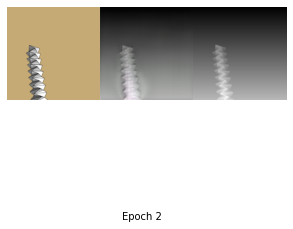

Epoch [3/50], Step [1/3750], D_loss: 0.4841, G_loss: 7.9850
Epoch [3/50], Step [2/3750], D_loss: 0.5136, G_loss: 8.3222
Epoch [3/50], Step [3/3750], D_loss: 0.8386, G_loss: 5.2138
Epoch [3/50], Step [4/3750], D_loss: 0.6075, G_loss: 5.1943
Epoch [3/50], Step [5/3750], D_loss: 0.7134, G_loss: 8.1119
Epoch [3/50], Step [6/3750], D_loss: 0.5441, G_loss: 12.9959
Epoch [3/50], Step [7/3750], D_loss: 0.6777, G_loss: 4.4112
Epoch [3/50], Step [8/3750], D_loss: 0.7316, G_loss: 16.2099
Epoch [3/50], Step [9/3750], D_loss: 0.6892, G_loss: 3.5581
Epoch [3/50], Step [10/3750], D_loss: 0.6555, G_loss: 2.3030
Epoch [3/50], Step [11/3750], D_loss: 0.6450, G_loss: 4.4049
Epoch [3/50], Step [12/3750], D_loss: 0.6874, G_loss: 3.9232
Epoch [3/50], Step [13/3750], D_loss: 0.4801, G_loss: 11.4500
Epoch [3/50], Step [14/3750], D_loss: 0.6785, G_loss: 17.8855
Epoch [3/50], Step [15/3750], D_loss: 0.4385, G_loss: 27.4949
Epoch [3/50], Step [16/3750], D_loss: 0.6714, G_loss: 7.7861
Epoch [3/50], Step [17/3750]

Epoch [3/50], Step [135/3750], D_loss: 0.6373, G_loss: 4.2566
Epoch [3/50], Step [136/3750], D_loss: 0.9289, G_loss: 10.2866
Epoch [3/50], Step [137/3750], D_loss: 0.5949, G_loss: 6.2499
Epoch [3/50], Step [138/3750], D_loss: 0.7144, G_loss: 5.9198
Epoch [3/50], Step [139/3750], D_loss: 0.6626, G_loss: 4.7722
Epoch [3/50], Step [140/3750], D_loss: 0.6479, G_loss: 2.6688
Epoch [3/50], Step [141/3750], D_loss: 0.6385, G_loss: 4.3187
Epoch [3/50], Step [142/3750], D_loss: 0.5403, G_loss: 8.4646
Epoch [3/50], Step [143/3750], D_loss: 0.6708, G_loss: 6.9597
Epoch [3/50], Step [144/3750], D_loss: 0.6665, G_loss: 5.9017
Epoch [3/50], Step [145/3750], D_loss: 0.7198, G_loss: 6.6596
Epoch [3/50], Step [146/3750], D_loss: 0.7111, G_loss: 4.6941
Epoch [3/50], Step [147/3750], D_loss: 0.7728, G_loss: 9.0740
Epoch [3/50], Step [148/3750], D_loss: 0.7989, G_loss: 4.6444
Epoch [3/50], Step [149/3750], D_loss: 0.7364, G_loss: 3.1952
Epoch [3/50], Step [150/3750], D_loss: 0.6359, G_loss: 3.5380
Epoch [

Epoch [3/50], Step [267/3750], D_loss: 0.4702, G_loss: 10.9888
Epoch [3/50], Step [268/3750], D_loss: 0.5667, G_loss: 5.5976
Epoch [3/50], Step [269/3750], D_loss: 0.7148, G_loss: 4.4197
Epoch [3/50], Step [270/3750], D_loss: 0.7009, G_loss: 6.9281
Epoch [3/50], Step [271/3750], D_loss: 0.6758, G_loss: 3.8662
Epoch [3/50], Step [272/3750], D_loss: 0.7459, G_loss: 2.0110
Epoch [3/50], Step [273/3750], D_loss: 0.5693, G_loss: 19.7214
Epoch [3/50], Step [274/3750], D_loss: 0.8375, G_loss: 6.5645
Epoch [3/50], Step [275/3750], D_loss: 0.6596, G_loss: 9.2657
Epoch [3/50], Step [276/3750], D_loss: 0.6700, G_loss: 3.3916
Epoch [3/50], Step [277/3750], D_loss: 0.6853, G_loss: 6.6063
Epoch [3/50], Step [278/3750], D_loss: 0.6391, G_loss: 6.2252
Epoch [3/50], Step [279/3750], D_loss: 0.5736, G_loss: 7.3381
Epoch [3/50], Step [280/3750], D_loss: 0.6999, G_loss: 7.9657
Epoch [3/50], Step [281/3750], D_loss: 0.7350, G_loss: 10.5097
Epoch [3/50], Step [282/3750], D_loss: 0.6630, G_loss: 11.5596
Epoc

Epoch [3/50], Step [399/3750], D_loss: 0.4062, G_loss: 8.8106
Epoch [3/50], Step [400/3750], D_loss: 0.7444, G_loss: 4.6913
Epoch [3/50], Step [401/3750], D_loss: 0.6755, G_loss: 5.4879
Epoch [3/50], Step [402/3750], D_loss: 0.6661, G_loss: 3.2452
Epoch [3/50], Step [403/3750], D_loss: 0.7182, G_loss: 5.1046
Epoch [3/50], Step [404/3750], D_loss: 0.6855, G_loss: 5.9032
Epoch [3/50], Step [405/3750], D_loss: 0.6063, G_loss: 7.0299
Epoch [3/50], Step [406/3750], D_loss: 0.6505, G_loss: 2.6043
Epoch [3/50], Step [407/3750], D_loss: 0.7026, G_loss: 6.0009
Epoch [3/50], Step [408/3750], D_loss: 0.7059, G_loss: 9.7550
Epoch [3/50], Step [409/3750], D_loss: 0.7525, G_loss: 7.5445
Epoch [3/50], Step [410/3750], D_loss: 0.7077, G_loss: 2.7643
Epoch [3/50], Step [411/3750], D_loss: 0.7221, G_loss: 4.4113
Epoch [3/50], Step [412/3750], D_loss: 0.6464, G_loss: 4.4476
Epoch [3/50], Step [413/3750], D_loss: 0.6494, G_loss: 2.2329
Epoch [3/50], Step [414/3750], D_loss: 0.6465, G_loss: 5.3523
Epoch [3

Epoch [3/50], Step [531/3750], D_loss: 0.6208, G_loss: 9.9835
Epoch [3/50], Step [532/3750], D_loss: 0.6620, G_loss: 4.4285
Epoch [3/50], Step [533/3750], D_loss: 0.5468, G_loss: 4.7282
Epoch [3/50], Step [534/3750], D_loss: 0.6731, G_loss: 3.7714
Epoch [3/50], Step [535/3750], D_loss: 0.6790, G_loss: 4.4270
Epoch [3/50], Step [536/3750], D_loss: 0.6522, G_loss: 5.4699
Epoch [3/50], Step [537/3750], D_loss: 0.7203, G_loss: 4.7615
Epoch [3/50], Step [538/3750], D_loss: 0.8140, G_loss: 9.0089
Epoch [3/50], Step [539/3750], D_loss: 0.7781, G_loss: 3.5226
Epoch [3/50], Step [540/3750], D_loss: 0.6098, G_loss: 10.2615
Epoch [3/50], Step [541/3750], D_loss: 0.6295, G_loss: 6.0033
Epoch [3/50], Step [542/3750], D_loss: 0.5529, G_loss: 11.5891
Epoch [3/50], Step [543/3750], D_loss: 0.6877, G_loss: 3.2581
Epoch [3/50], Step [544/3750], D_loss: 0.6747, G_loss: 2.8671
Epoch [3/50], Step [545/3750], D_loss: 0.7615, G_loss: 4.4759
Epoch [3/50], Step [546/3750], D_loss: 0.7580, G_loss: 3.6060
Epoch 

Epoch [3/50], Step [663/3750], D_loss: 1.2143, G_loss: 12.7716
Epoch [3/50], Step [664/3750], D_loss: 0.7860, G_loss: 2.9109
Epoch [3/50], Step [665/3750], D_loss: 0.6937, G_loss: 4.6893
Epoch [3/50], Step [666/3750], D_loss: 0.6438, G_loss: 7.1195
Epoch [3/50], Step [667/3750], D_loss: 0.3602, G_loss: 25.7459
Epoch [3/50], Step [668/3750], D_loss: 0.7357, G_loss: 5.3647
Epoch [3/50], Step [669/3750], D_loss: 0.6773, G_loss: 3.7509
Epoch [3/50], Step [670/3750], D_loss: 0.6152, G_loss: 4.4042
Epoch [3/50], Step [671/3750], D_loss: 0.7591, G_loss: 4.2578
Epoch [3/50], Step [672/3750], D_loss: 0.5793, G_loss: 7.2512
Epoch [3/50], Step [673/3750], D_loss: 0.6288, G_loss: 3.8803
Epoch [3/50], Step [674/3750], D_loss: 0.7194, G_loss: 8.7014
Epoch [3/50], Step [675/3750], D_loss: 0.8744, G_loss: 12.1115
Epoch [3/50], Step [676/3750], D_loss: 0.7039, G_loss: 9.8514
Epoch [3/50], Step [677/3750], D_loss: 0.6698, G_loss: 6.6682
Epoch [3/50], Step [678/3750], D_loss: 0.7166, G_loss: 4.3184
Epoch

Epoch [3/50], Step [795/3750], D_loss: 0.6624, G_loss: 4.2625
Epoch [3/50], Step [796/3750], D_loss: 0.7319, G_loss: 8.9084
Epoch [3/50], Step [797/3750], D_loss: 0.2451, G_loss: 50.6250
Epoch [3/50], Step [798/3750], D_loss: 0.6712, G_loss: 5.1805
Epoch [3/50], Step [799/3750], D_loss: 0.7187, G_loss: 4.6447
Epoch [3/50], Step [800/3750], D_loss: 0.6625, G_loss: 7.5376
Epoch [3/50], Step [801/3750], D_loss: 0.6979, G_loss: 6.0414
Epoch [3/50], Step [802/3750], D_loss: 0.7535, G_loss: 15.2080
Epoch [3/50], Step [803/3750], D_loss: 0.7131, G_loss: 5.3429
Epoch [3/50], Step [804/3750], D_loss: 0.6630, G_loss: 4.3525
Epoch [3/50], Step [805/3750], D_loss: 0.8263, G_loss: 13.1801
Epoch [3/50], Step [806/3750], D_loss: 0.6195, G_loss: 7.3905
Epoch [3/50], Step [807/3750], D_loss: 0.7021, G_loss: 4.9940
Epoch [3/50], Step [808/3750], D_loss: 0.7294, G_loss: 12.0983
Epoch [3/50], Step [809/3750], D_loss: 0.6445, G_loss: 8.6299
Epoch [3/50], Step [810/3750], D_loss: 0.6734, G_loss: 4.2808
Epoc

Epoch [3/50], Step [927/3750], D_loss: 0.6774, G_loss: 8.1076
Epoch [3/50], Step [928/3750], D_loss: 0.6592, G_loss: 3.7873
Epoch [3/50], Step [929/3750], D_loss: 0.6960, G_loss: 6.8317
Epoch [3/50], Step [930/3750], D_loss: 0.9421, G_loss: 3.3232
Epoch [3/50], Step [931/3750], D_loss: 0.7620, G_loss: 4.9741
Epoch [3/50], Step [932/3750], D_loss: 0.6396, G_loss: 4.3765
Epoch [3/50], Step [933/3750], D_loss: 0.7714, G_loss: 13.6873
Epoch [3/50], Step [934/3750], D_loss: 0.5963, G_loss: 6.8277
Epoch [3/50], Step [935/3750], D_loss: 0.6439, G_loss: 4.5063
Epoch [3/50], Step [936/3750], D_loss: 0.6741, G_loss: 3.0520
Epoch [3/50], Step [937/3750], D_loss: 0.6290, G_loss: 4.5348
Epoch [3/50], Step [938/3750], D_loss: 0.7019, G_loss: 5.8376
Epoch [3/50], Step [939/3750], D_loss: 0.4846, G_loss: 8.3818
Epoch [3/50], Step [940/3750], D_loss: 0.7955, G_loss: 4.2142
Epoch [3/50], Step [941/3750], D_loss: 0.7085, G_loss: 3.0368
Epoch [3/50], Step [942/3750], D_loss: 0.9114, G_loss: 19.4011
Epoch 

Epoch [3/50], Step [1058/3750], D_loss: 0.6739, G_loss: 4.6799
Epoch [3/50], Step [1059/3750], D_loss: 0.8011, G_loss: 12.9237
Epoch [3/50], Step [1060/3750], D_loss: 0.6157, G_loss: 4.0953
Epoch [3/50], Step [1061/3750], D_loss: 0.6217, G_loss: 8.4125
Epoch [3/50], Step [1062/3750], D_loss: 0.5460, G_loss: 8.1815
Epoch [3/50], Step [1063/3750], D_loss: 0.5723, G_loss: 8.8966
Epoch [3/50], Step [1064/3750], D_loss: 0.4144, G_loss: 11.6003
Epoch [3/50], Step [1065/3750], D_loss: 0.7531, G_loss: 8.4124
Epoch [3/50], Step [1066/3750], D_loss: 0.5090, G_loss: 3.2963
Epoch [3/50], Step [1067/3750], D_loss: 0.5850, G_loss: 12.9311
Epoch [3/50], Step [1068/3750], D_loss: 1.1051, G_loss: 7.3378
Epoch [3/50], Step [1069/3750], D_loss: 0.9401, G_loss: 9.5376
Epoch [3/50], Step [1070/3750], D_loss: 0.6993, G_loss: 4.2450
Epoch [3/50], Step [1071/3750], D_loss: 0.6906, G_loss: 3.9992
Epoch [3/50], Step [1072/3750], D_loss: 0.6686, G_loss: 4.4864
Epoch [3/50], Step [1073/3750], D_loss: 0.7155, G_lo

Epoch [3/50], Step [1188/3750], D_loss: 0.6854, G_loss: 5.9403
Epoch [3/50], Step [1189/3750], D_loss: 0.6811, G_loss: 4.2973
Epoch [3/50], Step [1190/3750], D_loss: 0.5892, G_loss: 7.0503
Epoch [3/50], Step [1191/3750], D_loss: 0.5726, G_loss: 6.9042
Epoch [3/50], Step [1192/3750], D_loss: 0.7112, G_loss: 5.5633
Epoch [3/50], Step [1193/3750], D_loss: 0.4348, G_loss: 7.8741
Epoch [3/50], Step [1194/3750], D_loss: 0.4402, G_loss: 22.5457
Epoch [3/50], Step [1195/3750], D_loss: 0.6828, G_loss: 5.4899
Epoch [3/50], Step [1196/3750], D_loss: 0.6891, G_loss: 4.2917
Epoch [3/50], Step [1197/3750], D_loss: 0.3883, G_loss: 14.9434
Epoch [3/50], Step [1198/3750], D_loss: 0.6606, G_loss: 5.4036
Epoch [3/50], Step [1199/3750], D_loss: 0.4573, G_loss: 6.0793
Epoch [3/50], Step [1200/3750], D_loss: 0.9014, G_loss: 6.1605
Epoch [3/50], Step [1201/3750], D_loss: 0.7671, G_loss: 4.4055
Epoch [3/50], Step [1202/3750], D_loss: 0.7382, G_loss: 5.8081
Epoch [3/50], Step [1203/3750], D_loss: 0.9063, G_los

Epoch [3/50], Step [1318/3750], D_loss: 0.7313, G_loss: 8.8523
Epoch [3/50], Step [1319/3750], D_loss: 0.8098, G_loss: 8.1435
Epoch [3/50], Step [1320/3750], D_loss: 0.5127, G_loss: 10.1940
Epoch [3/50], Step [1321/3750], D_loss: 0.7552, G_loss: 6.0733
Epoch [3/50], Step [1322/3750], D_loss: 0.5412, G_loss: 4.9693
Epoch [3/50], Step [1323/3750], D_loss: 0.6760, G_loss: 5.9580
Epoch [3/50], Step [1324/3750], D_loss: 0.7511, G_loss: 7.7931
Epoch [3/50], Step [1325/3750], D_loss: 0.7689, G_loss: 9.3574
Epoch [3/50], Step [1326/3750], D_loss: 0.6183, G_loss: 8.3877
Epoch [3/50], Step [1327/3750], D_loss: 0.5909, G_loss: 12.1811
Epoch [3/50], Step [1328/3750], D_loss: 0.7831, G_loss: 5.5440
Epoch [3/50], Step [1329/3750], D_loss: 0.6576, G_loss: 3.0629
Epoch [3/50], Step [1330/3750], D_loss: 0.8685, G_loss: 10.3013
Epoch [3/50], Step [1331/3750], D_loss: 0.8319, G_loss: 11.3145
Epoch [3/50], Step [1332/3750], D_loss: 0.6954, G_loss: 4.9424
Epoch [3/50], Step [1333/3750], D_loss: 0.6701, G_l

Epoch [3/50], Step [1448/3750], D_loss: 0.3990, G_loss: 7.9444
Epoch [3/50], Step [1449/3750], D_loss: 0.7396, G_loss: 10.0145
Epoch [3/50], Step [1450/3750], D_loss: 0.5618, G_loss: 6.2148
Epoch [3/50], Step [1451/3750], D_loss: 0.7439, G_loss: 20.2959
Epoch [3/50], Step [1452/3750], D_loss: 0.9429, G_loss: 9.8570
Epoch [3/50], Step [1453/3750], D_loss: 0.8204, G_loss: 9.1026
Epoch [3/50], Step [1454/3750], D_loss: 0.6254, G_loss: 3.0916
Epoch [3/50], Step [1455/3750], D_loss: 0.6466, G_loss: 5.8594
Epoch [3/50], Step [1456/3750], D_loss: 0.6461, G_loss: 7.2921
Epoch [3/50], Step [1457/3750], D_loss: 0.7182, G_loss: 5.4543
Epoch [3/50], Step [1458/3750], D_loss: 0.6306, G_loss: 4.4480
Epoch [3/50], Step [1459/3750], D_loss: 0.4197, G_loss: 12.4003
Epoch [3/50], Step [1460/3750], D_loss: 0.6922, G_loss: 4.2039
Epoch [3/50], Step [1461/3750], D_loss: 0.6969, G_loss: 6.3953
Epoch [3/50], Step [1462/3750], D_loss: 0.6832, G_loss: 6.8188
Epoch [3/50], Step [1463/3750], D_loss: 0.8411, G_lo

Epoch [3/50], Step [1578/3750], D_loss: 0.3782, G_loss: 11.4398
Epoch [3/50], Step [1579/3750], D_loss: 0.6838, G_loss: 8.0327
Epoch [3/50], Step [1580/3750], D_loss: 0.2785, G_loss: 9.7492
Epoch [3/50], Step [1581/3750], D_loss: 0.6859, G_loss: 4.1774
Epoch [3/50], Step [1582/3750], D_loss: 0.6116, G_loss: 3.7262
Epoch [3/50], Step [1583/3750], D_loss: 0.7037, G_loss: 5.5910
Epoch [3/50], Step [1584/3750], D_loss: 0.7321, G_loss: 5.7833
Epoch [3/50], Step [1585/3750], D_loss: 0.6601, G_loss: 11.3577
Epoch [3/50], Step [1586/3750], D_loss: 0.7876, G_loss: 2.5021
Epoch [3/50], Step [1587/3750], D_loss: 0.4472, G_loss: 5.3618
Epoch [3/50], Step [1588/3750], D_loss: 0.3590, G_loss: 6.3044
Epoch [3/50], Step [1589/3750], D_loss: 0.2784, G_loss: 6.9833
Epoch [3/50], Step [1590/3750], D_loss: 0.3363, G_loss: 3.9506
Epoch [3/50], Step [1591/3750], D_loss: 1.3201, G_loss: 15.3937
Epoch [3/50], Step [1592/3750], D_loss: 0.8355, G_loss: 10.0117
Epoch [3/50], Step [1593/3750], D_loss: 0.4145, G_l

Epoch [3/50], Step [1708/3750], D_loss: 0.7414, G_loss: 5.0257
Epoch [3/50], Step [1709/3750], D_loss: 0.7557, G_loss: 2.0883
Epoch [3/50], Step [1710/3750], D_loss: 0.6555, G_loss: 6.8356
Epoch [3/50], Step [1711/3750], D_loss: 0.7303, G_loss: 6.9343
Epoch [3/50], Step [1712/3750], D_loss: 0.7065, G_loss: 3.9211
Epoch [3/50], Step [1713/3750], D_loss: 0.6044, G_loss: 3.9786
Epoch [3/50], Step [1714/3750], D_loss: 0.4037, G_loss: 7.4743
Epoch [3/50], Step [1715/3750], D_loss: 0.6123, G_loss: 10.6813
Epoch [3/50], Step [1716/3750], D_loss: 0.6120, G_loss: 6.6836
Epoch [3/50], Step [1717/3750], D_loss: 0.6696, G_loss: 3.0559
Epoch [3/50], Step [1718/3750], D_loss: 0.5258, G_loss: 21.6067
Epoch [3/50], Step [1719/3750], D_loss: 0.6833, G_loss: 4.9679
Epoch [3/50], Step [1720/3750], D_loss: 0.7513, G_loss: 11.2770
Epoch [3/50], Step [1721/3750], D_loss: 0.6003, G_loss: 7.6413
Epoch [3/50], Step [1722/3750], D_loss: 0.7046, G_loss: 3.5423
Epoch [3/50], Step [1723/3750], D_loss: 0.6908, G_lo

Epoch [3/50], Step [1838/3750], D_loss: 0.7686, G_loss: 3.1707
Epoch [3/50], Step [1839/3750], D_loss: 0.7476, G_loss: 4.1116
Epoch [3/50], Step [1840/3750], D_loss: 0.7123, G_loss: 3.4664
Epoch [3/50], Step [1841/3750], D_loss: 0.7241, G_loss: 3.8013
Epoch [3/50], Step [1842/3750], D_loss: 0.7099, G_loss: 2.9623
Epoch [3/50], Step [1843/3750], D_loss: 0.5144, G_loss: 8.2626
Epoch [3/50], Step [1844/3750], D_loss: 0.7181, G_loss: 6.3659
Epoch [3/50], Step [1845/3750], D_loss: 0.7174, G_loss: 2.5212
Epoch [3/50], Step [1846/3750], D_loss: 0.7105, G_loss: 3.1205
Epoch [3/50], Step [1847/3750], D_loss: 0.7531, G_loss: 3.9198
Epoch [3/50], Step [1848/3750], D_loss: 0.4887, G_loss: 8.0266
Epoch [3/50], Step [1849/3750], D_loss: 0.7047, G_loss: 3.6070
Epoch [3/50], Step [1850/3750], D_loss: 0.7240, G_loss: 2.6233
Epoch [3/50], Step [1851/3750], D_loss: 0.4573, G_loss: 8.4664
Epoch [3/50], Step [1852/3750], D_loss: 0.7367, G_loss: 4.7545
Epoch [3/50], Step [1853/3750], D_loss: 0.7017, G_loss:

Epoch [3/50], Step [1968/3750], D_loss: 0.6016, G_loss: 2.7642
Epoch [3/50], Step [1969/3750], D_loss: 0.7798, G_loss: 3.1826
Epoch [3/50], Step [1970/3750], D_loss: 0.6816, G_loss: 4.4060
Epoch [3/50], Step [1971/3750], D_loss: 0.7185, G_loss: 6.8846
Epoch [3/50], Step [1972/3750], D_loss: 0.4519, G_loss: 7.9832
Epoch [3/50], Step [1973/3750], D_loss: 0.7063, G_loss: 5.0532
Epoch [3/50], Step [1974/3750], D_loss: 0.5959, G_loss: 4.3267
Epoch [3/50], Step [1975/3750], D_loss: 0.6700, G_loss: 3.6427
Epoch [3/50], Step [1976/3750], D_loss: 0.5195, G_loss: 4.7372
Epoch [3/50], Step [1977/3750], D_loss: 0.5636, G_loss: 3.6303
Epoch [3/50], Step [1978/3750], D_loss: 0.6093, G_loss: 3.4392
Epoch [3/50], Step [1979/3750], D_loss: 0.7076, G_loss: 11.7193
Epoch [3/50], Step [1980/3750], D_loss: 0.7226, G_loss: 10.5783
Epoch [3/50], Step [1981/3750], D_loss: 0.8555, G_loss: 3.6270
Epoch [3/50], Step [1982/3750], D_loss: 0.7193, G_loss: 8.8258
Epoch [3/50], Step [1983/3750], D_loss: 0.6834, G_los

Epoch [3/50], Step [2098/3750], D_loss: 0.6350, G_loss: 3.9853
Epoch [3/50], Step [2099/3750], D_loss: 0.6086, G_loss: 10.0431
Epoch [3/50], Step [2100/3750], D_loss: 0.6326, G_loss: 5.2684
Epoch [3/50], Step [2101/3750], D_loss: 0.4052, G_loss: 10.9093
Epoch [3/50], Step [2102/3750], D_loss: 0.6849, G_loss: 8.8215
Epoch [3/50], Step [2103/3750], D_loss: 0.6564, G_loss: 6.9438
Epoch [3/50], Step [2104/3750], D_loss: 0.5758, G_loss: 5.1434
Epoch [3/50], Step [2105/3750], D_loss: 0.6603, G_loss: 3.0453
Epoch [3/50], Step [2106/3750], D_loss: 0.7535, G_loss: 7.3311
Epoch [3/50], Step [2107/3750], D_loss: 0.8015, G_loss: 6.2736
Epoch [3/50], Step [2108/3750], D_loss: 0.8386, G_loss: 5.8722
Epoch [3/50], Step [2109/3750], D_loss: 0.9238, G_loss: 9.8735
Epoch [3/50], Step [2110/3750], D_loss: 0.4367, G_loss: 5.8196
Epoch [3/50], Step [2111/3750], D_loss: 0.6249, G_loss: 3.9632
Epoch [3/50], Step [2112/3750], D_loss: 0.7117, G_loss: 3.4985
Epoch [3/50], Step [2113/3750], D_loss: 0.7829, G_los

Epoch [3/50], Step [2228/3750], D_loss: 0.6492, G_loss: 5.5322
Epoch [3/50], Step [2229/3750], D_loss: 0.6686, G_loss: 2.2486
Epoch [3/50], Step [2230/3750], D_loss: 0.6292, G_loss: 2.9796
Epoch [3/50], Step [2231/3750], D_loss: 0.6703, G_loss: 4.4091
Epoch [3/50], Step [2232/3750], D_loss: 0.7227, G_loss: 2.1597
Epoch [3/50], Step [2233/3750], D_loss: 0.5799, G_loss: 6.6312
Epoch [3/50], Step [2234/3750], D_loss: 0.3525, G_loss: 31.5914
Epoch [3/50], Step [2235/3750], D_loss: 0.6412, G_loss: 7.0433
Epoch [3/50], Step [2236/3750], D_loss: 0.6936, G_loss: 3.4904
Epoch [3/50], Step [2237/3750], D_loss: 0.6162, G_loss: 3.6456
Epoch [3/50], Step [2238/3750], D_loss: 0.7054, G_loss: 2.7889
Epoch [3/50], Step [2239/3750], D_loss: 0.6117, G_loss: 6.3003
Epoch [3/50], Step [2240/3750], D_loss: 1.0212, G_loss: 14.1844
Epoch [3/50], Step [2241/3750], D_loss: 0.6769, G_loss: 8.5888
Epoch [3/50], Step [2242/3750], D_loss: 0.6917, G_loss: 3.7826
Epoch [3/50], Step [2243/3750], D_loss: 0.6976, G_los

Epoch [3/50], Step [2358/3750], D_loss: 0.6911, G_loss: 12.5806
Epoch [3/50], Step [2359/3750], D_loss: 0.6133, G_loss: 5.5696
Epoch [3/50], Step [2360/3750], D_loss: 0.5739, G_loss: 8.7053
Epoch [3/50], Step [2361/3750], D_loss: 0.6699, G_loss: 9.2827
Epoch [3/50], Step [2362/3750], D_loss: 0.6737, G_loss: 7.2923
Epoch [3/50], Step [2363/3750], D_loss: 0.6077, G_loss: 4.0527
Epoch [3/50], Step [2364/3750], D_loss: 0.4836, G_loss: 6.6855
Epoch [3/50], Step [2365/3750], D_loss: 0.5950, G_loss: 5.0800
Epoch [3/50], Step [2366/3750], D_loss: 0.6440, G_loss: 8.2334
Epoch [3/50], Step [2367/3750], D_loss: 0.6419, G_loss: 13.7712
Epoch [3/50], Step [2368/3750], D_loss: 0.6559, G_loss: 4.7855
Epoch [3/50], Step [2369/3750], D_loss: 0.5185, G_loss: 9.7128
Epoch [3/50], Step [2370/3750], D_loss: 0.7146, G_loss: 3.1184
Epoch [3/50], Step [2371/3750], D_loss: 0.8122, G_loss: 6.2928
Epoch [3/50], Step [2372/3750], D_loss: 0.8062, G_loss: 8.7153
Epoch [3/50], Step [2373/3750], D_loss: 0.4538, G_los

Epoch [3/50], Step [2488/3750], D_loss: 0.6819, G_loss: 6.3544
Epoch [3/50], Step [2489/3750], D_loss: 0.6708, G_loss: 4.2377
Epoch [3/50], Step [2490/3750], D_loss: 0.6792, G_loss: 3.5672
Epoch [3/50], Step [2491/3750], D_loss: 0.3587, G_loss: 6.4066
Epoch [3/50], Step [2492/3750], D_loss: 0.7744, G_loss: 4.0946
Epoch [3/50], Step [2493/3750], D_loss: 0.7073, G_loss: 4.7151
Epoch [3/50], Step [2494/3750], D_loss: 0.6852, G_loss: 5.4004
Epoch [3/50], Step [2495/3750], D_loss: 0.5405, G_loss: 5.2195
Epoch [3/50], Step [2496/3750], D_loss: 0.6598, G_loss: 4.8973
Epoch [3/50], Step [2497/3750], D_loss: 0.7998, G_loss: 4.7254
Epoch [3/50], Step [2498/3750], D_loss: 0.6786, G_loss: 13.1373
Epoch [3/50], Step [2499/3750], D_loss: 0.6621, G_loss: 5.6079
Epoch [3/50], Step [2500/3750], D_loss: 0.6634, G_loss: 2.7243
Epoch [3/50], Step [2501/3750], D_loss: 0.7628, G_loss: 6.1069
Epoch [3/50], Step [2502/3750], D_loss: 0.7335, G_loss: 2.3287
Epoch [3/50], Step [2503/3750], D_loss: 0.5806, G_loss

Epoch [3/50], Step [2618/3750], D_loss: 0.7154, G_loss: 7.0293
Epoch [3/50], Step [2619/3750], D_loss: 0.6931, G_loss: 5.2271
Epoch [3/50], Step [2620/3750], D_loss: 0.8236, G_loss: 8.5317
Epoch [3/50], Step [2621/3750], D_loss: 0.4900, G_loss: 7.4498
Epoch [3/50], Step [2622/3750], D_loss: 0.5034, G_loss: 3.9645
Epoch [3/50], Step [2623/3750], D_loss: 0.5779, G_loss: 11.7148
Epoch [3/50], Step [2624/3750], D_loss: 0.6513, G_loss: 4.3479
Epoch [3/50], Step [2625/3750], D_loss: 0.7107, G_loss: 2.6947
Epoch [3/50], Step [2626/3750], D_loss: 0.4403, G_loss: 10.3750
Epoch [3/50], Step [2627/3750], D_loss: 0.6828, G_loss: 3.4943
Epoch [3/50], Step [2628/3750], D_loss: 0.6574, G_loss: 8.4458
Epoch [3/50], Step [2629/3750], D_loss: 0.5650, G_loss: 3.8424
Epoch [3/50], Step [2630/3750], D_loss: 0.9319, G_loss: 9.7309
Epoch [3/50], Step [2631/3750], D_loss: 0.6423, G_loss: 3.1282
Epoch [3/50], Step [2632/3750], D_loss: 0.7149, G_loss: 3.4476
Epoch [3/50], Step [2633/3750], D_loss: 0.6944, G_los

Epoch [3/50], Step [2748/3750], D_loss: 0.6739, G_loss: 10.5564
Epoch [3/50], Step [2749/3750], D_loss: 0.6680, G_loss: 5.2094
Epoch [3/50], Step [2750/3750], D_loss: 0.6258, G_loss: 5.3156
Epoch [3/50], Step [2751/3750], D_loss: 0.7707, G_loss: 8.1739
Epoch [3/50], Step [2752/3750], D_loss: 0.6966, G_loss: 4.7647
Epoch [3/50], Step [2753/3750], D_loss: 0.6819, G_loss: 3.6818
Epoch [3/50], Step [2754/3750], D_loss: 0.6995, G_loss: 11.6628
Epoch [3/50], Step [2755/3750], D_loss: 0.6869, G_loss: 2.9587
Epoch [3/50], Step [2756/3750], D_loss: 0.6835, G_loss: 4.6251
Epoch [3/50], Step [2757/3750], D_loss: 0.6683, G_loss: 2.8239
Epoch [3/50], Step [2758/3750], D_loss: 0.6765, G_loss: 7.6805
Epoch [3/50], Step [2759/3750], D_loss: 0.6768, G_loss: 2.2491
Epoch [3/50], Step [2760/3750], D_loss: 0.6239, G_loss: 3.4416
Epoch [3/50], Step [2761/3750], D_loss: 0.5187, G_loss: 9.1524
Epoch [3/50], Step [2762/3750], D_loss: 0.7144, G_loss: 2.3458
Epoch [3/50], Step [2763/3750], D_loss: 0.6358, G_los

Epoch [3/50], Step [2878/3750], D_loss: 0.4604, G_loss: 7.5442
Epoch [3/50], Step [2879/3750], D_loss: 0.7143, G_loss: 2.7541
Epoch [3/50], Step [2880/3750], D_loss: 0.7382, G_loss: 6.2330
Epoch [3/50], Step [2881/3750], D_loss: 0.7343, G_loss: 2.7522
Epoch [3/50], Step [2882/3750], D_loss: 0.6715, G_loss: 4.1489
Epoch [3/50], Step [2883/3750], D_loss: 0.3642, G_loss: 7.7276
Epoch [3/50], Step [2884/3750], D_loss: 0.7092, G_loss: 3.7606
Epoch [3/50], Step [2885/3750], D_loss: 0.6805, G_loss: 2.6498
Epoch [3/50], Step [2886/3750], D_loss: 0.6723, G_loss: 3.6591
Epoch [3/50], Step [2887/3750], D_loss: 0.6948, G_loss: 10.3905
Epoch [3/50], Step [2888/3750], D_loss: 0.7198, G_loss: 3.7425
Epoch [3/50], Step [2889/3750], D_loss: 0.6143, G_loss: 7.7657
Epoch [3/50], Step [2890/3750], D_loss: 0.6687, G_loss: 2.8655
Epoch [3/50], Step [2891/3750], D_loss: 0.6617, G_loss: 4.3512
Epoch [3/50], Step [2892/3750], D_loss: 0.6629, G_loss: 3.9984
Epoch [3/50], Step [2893/3750], D_loss: 0.5376, G_loss

Epoch [3/50], Step [3008/3750], D_loss: 1.2325, G_loss: 6.4211
Epoch [3/50], Step [3009/3750], D_loss: 0.2306, G_loss: 11.4781
Epoch [3/50], Step [3010/3750], D_loss: 0.5757, G_loss: 9.2053
Epoch [3/50], Step [3011/3750], D_loss: 0.5438, G_loss: 5.2338
Epoch [3/50], Step [3012/3750], D_loss: 0.6654, G_loss: 5.4422
Epoch [3/50], Step [3013/3750], D_loss: 0.6664, G_loss: 3.9023
Epoch [3/50], Step [3014/3750], D_loss: 0.8505, G_loss: 9.1466
Epoch [3/50], Step [3015/3750], D_loss: 0.6487, G_loss: 4.6160
Epoch [3/50], Step [3016/3750], D_loss: 0.5197, G_loss: 7.5769
Epoch [3/50], Step [3017/3750], D_loss: 0.6228, G_loss: 11.1931
Epoch [3/50], Step [3018/3750], D_loss: 0.5999, G_loss: 2.5830
Epoch [3/50], Step [3019/3750], D_loss: 0.6982, G_loss: 9.2632
Epoch [3/50], Step [3020/3750], D_loss: 0.5686, G_loss: 11.0857
Epoch [3/50], Step [3021/3750], D_loss: 0.4847, G_loss: 6.9585
Epoch [3/50], Step [3022/3750], D_loss: 0.5385, G_loss: 4.2000
Epoch [3/50], Step [3023/3750], D_loss: 0.7615, G_lo

Epoch [3/50], Step [3138/3750], D_loss: 0.6866, G_loss: 5.3106
Epoch [3/50], Step [3139/3750], D_loss: 0.3410, G_loss: 8.4078
Epoch [3/50], Step [3140/3750], D_loss: 0.3871, G_loss: 10.2370
Epoch [3/50], Step [3141/3750], D_loss: 0.2801, G_loss: 53.0444
Epoch [3/50], Step [3142/3750], D_loss: 0.7859, G_loss: 6.2976
Epoch [3/50], Step [3143/3750], D_loss: 0.6734, G_loss: 5.4904
Epoch [3/50], Step [3144/3750], D_loss: 0.5995, G_loss: 10.8461
Epoch [3/50], Step [3145/3750], D_loss: 0.3756, G_loss: 8.4767
Epoch [3/50], Step [3146/3750], D_loss: 0.7409, G_loss: 3.2153
Epoch [3/50], Step [3147/3750], D_loss: 0.6180, G_loss: 8.6096
Epoch [3/50], Step [3148/3750], D_loss: 0.7204, G_loss: 5.9983
Epoch [3/50], Step [3149/3750], D_loss: 0.7121, G_loss: 4.9239
Epoch [3/50], Step [3150/3750], D_loss: 0.6561, G_loss: 2.6207
Epoch [3/50], Step [3151/3750], D_loss: 0.6968, G_loss: 3.4025
Epoch [3/50], Step [3152/3750], D_loss: 0.7244, G_loss: 5.4328
Epoch [3/50], Step [3153/3750], D_loss: 0.5379, G_lo

Epoch [3/50], Step [3268/3750], D_loss: 0.6942, G_loss: 7.0608
Epoch [3/50], Step [3269/3750], D_loss: 0.7036, G_loss: 2.5952
Epoch [3/50], Step [3270/3750], D_loss: 0.5440, G_loss: 13.0685
Epoch [3/50], Step [3271/3750], D_loss: 0.3920, G_loss: 8.1832
Epoch [3/50], Step [3272/3750], D_loss: 0.6883, G_loss: 6.3578
Epoch [3/50], Step [3273/3750], D_loss: 0.6890, G_loss: 3.5015
Epoch [3/50], Step [3274/3750], D_loss: 0.6442, G_loss: 5.9220
Epoch [3/50], Step [3275/3750], D_loss: 0.5945, G_loss: 7.3340
Epoch [3/50], Step [3276/3750], D_loss: 0.6871, G_loss: 3.6315
Epoch [3/50], Step [3277/3750], D_loss: 0.3395, G_loss: 10.9557
Epoch [3/50], Step [3278/3750], D_loss: 0.5230, G_loss: 11.4959
Epoch [3/50], Step [3279/3750], D_loss: 0.6249, G_loss: 5.7010
Epoch [3/50], Step [3280/3750], D_loss: 0.7061, G_loss: 5.1467
Epoch [3/50], Step [3281/3750], D_loss: 0.5629, G_loss: 27.2953
Epoch [3/50], Step [3282/3750], D_loss: 0.6094, G_loss: 3.2889
Epoch [3/50], Step [3283/3750], D_loss: 0.3086, G_l

Epoch [3/50], Step [3398/3750], D_loss: 0.8422, G_loss: 10.1004
Epoch [3/50], Step [3399/3750], D_loss: 0.5712, G_loss: 7.3879
Epoch [3/50], Step [3400/3750], D_loss: 0.6740, G_loss: 6.4355
Epoch [3/50], Step [3401/3750], D_loss: 0.7525, G_loss: 7.3510
Epoch [3/50], Step [3402/3750], D_loss: 0.6666, G_loss: 4.4349
Epoch [3/50], Step [3403/3750], D_loss: 0.6661, G_loss: 3.3642
Epoch [3/50], Step [3404/3750], D_loss: 0.4170, G_loss: 5.6573
Epoch [3/50], Step [3405/3750], D_loss: 0.6543, G_loss: 2.2597
Epoch [3/50], Step [3406/3750], D_loss: 0.6591, G_loss: 4.3791
Epoch [3/50], Step [3407/3750], D_loss: 0.9235, G_loss: 5.7400
Epoch [3/50], Step [3408/3750], D_loss: 0.6988, G_loss: 2.6634
Epoch [3/50], Step [3409/3750], D_loss: 0.5443, G_loss: 12.2994
Epoch [3/50], Step [3410/3750], D_loss: 0.7190, G_loss: 4.3613
Epoch [3/50], Step [3411/3750], D_loss: 0.6219, G_loss: 5.0544
Epoch [3/50], Step [3412/3750], D_loss: 0.6799, G_loss: 2.9283
Epoch [3/50], Step [3413/3750], D_loss: 0.7020, G_los

Epoch [3/50], Step [3528/3750], D_loss: 0.6897, G_loss: 3.9276
Epoch [3/50], Step [3529/3750], D_loss: 0.6808, G_loss: 5.0602
Epoch [3/50], Step [3530/3750], D_loss: 0.6833, G_loss: 2.5156
Epoch [3/50], Step [3531/3750], D_loss: 0.7157, G_loss: 2.7368
Epoch [3/50], Step [3532/3750], D_loss: 0.6902, G_loss: 6.6425
Epoch [3/50], Step [3533/3750], D_loss: 0.8199, G_loss: 2.7887
Epoch [3/50], Step [3534/3750], D_loss: 0.7101, G_loss: 2.5991
Epoch [3/50], Step [3535/3750], D_loss: 0.5309, G_loss: 4.1637
Epoch [3/50], Step [3536/3750], D_loss: 0.6166, G_loss: 4.3924
Epoch [3/50], Step [3537/3750], D_loss: 0.5748, G_loss: 8.1012
Epoch [3/50], Step [3538/3750], D_loss: 0.3286, G_loss: 26.3487
Epoch [3/50], Step [3539/3750], D_loss: 0.7713, G_loss: 6.6554
Epoch [3/50], Step [3540/3750], D_loss: 0.6258, G_loss: 7.0855
Epoch [3/50], Step [3541/3750], D_loss: 0.5916, G_loss: 6.7459
Epoch [3/50], Step [3542/3750], D_loss: 0.6277, G_loss: 14.2779
Epoch [3/50], Step [3543/3750], D_loss: 0.5969, G_los

Epoch [3/50], Step [3658/3750], D_loss: 0.7198, G_loss: 6.8282
Epoch [3/50], Step [3659/3750], D_loss: 0.7427, G_loss: 6.5474
Epoch [3/50], Step [3660/3750], D_loss: 0.7269, G_loss: 10.7191
Epoch [3/50], Step [3661/3750], D_loss: 0.7097, G_loss: 5.7337
Epoch [3/50], Step [3662/3750], D_loss: 0.7281, G_loss: 6.2547
Epoch [3/50], Step [3663/3750], D_loss: 0.6148, G_loss: 8.5700
Epoch [3/50], Step [3664/3750], D_loss: 0.7114, G_loss: 8.2669
Epoch [3/50], Step [3665/3750], D_loss: 0.7148, G_loss: 13.6779
Epoch [3/50], Step [3666/3750], D_loss: 0.5099, G_loss: 8.3127
Epoch [3/50], Step [3667/3750], D_loss: 0.8170, G_loss: 9.0292
Epoch [3/50], Step [3668/3750], D_loss: 0.7705, G_loss: 4.2211
Epoch [3/50], Step [3669/3750], D_loss: 0.6880, G_loss: 5.0453
Epoch [3/50], Step [3670/3750], D_loss: 0.8548, G_loss: 9.6785
Epoch [3/50], Step [3671/3750], D_loss: 0.6740, G_loss: 10.2371
Epoch [3/50], Step [3672/3750], D_loss: 0.7277, G_loss: 4.2632
Epoch [3/50], Step [3673/3750], D_loss: 0.8002, G_lo

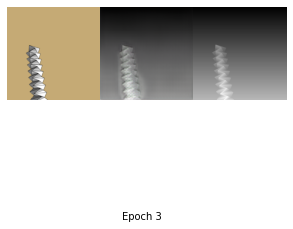

Epoch [4/50], Step [1/3750], D_loss: 0.6142, G_loss: 4.9043
Epoch [4/50], Step [2/3750], D_loss: 0.7045, G_loss: 3.2549
Epoch [4/50], Step [3/3750], D_loss: 0.6000, G_loss: 5.0027
Epoch [4/50], Step [4/3750], D_loss: 0.6461, G_loss: 7.2073
Epoch [4/50], Step [5/3750], D_loss: 0.6925, G_loss: 6.2528
Epoch [4/50], Step [6/3750], D_loss: 0.7191, G_loss: 3.8363
Epoch [4/50], Step [7/3750], D_loss: 0.7472, G_loss: 6.7346
Epoch [4/50], Step [8/3750], D_loss: 0.6424, G_loss: 3.7451
Epoch [4/50], Step [9/3750], D_loss: 0.7303, G_loss: 3.1801
Epoch [4/50], Step [10/3750], D_loss: 0.6628, G_loss: 8.4051
Epoch [4/50], Step [11/3750], D_loss: 0.6350, G_loss: 6.4342
Epoch [4/50], Step [12/3750], D_loss: 0.6907, G_loss: 4.0297
Epoch [4/50], Step [13/3750], D_loss: 0.6743, G_loss: 3.6481
Epoch [4/50], Step [14/3750], D_loss: 0.7241, G_loss: 7.2825
Epoch [4/50], Step [15/3750], D_loss: 0.7345, G_loss: 14.6334
Epoch [4/50], Step [16/3750], D_loss: 0.5620, G_loss: 4.8427
Epoch [4/50], Step [17/3750], D_

Epoch [4/50], Step [135/3750], D_loss: 0.7428, G_loss: 7.0798
Epoch [4/50], Step [136/3750], D_loss: 0.7331, G_loss: 6.1014
Epoch [4/50], Step [137/3750], D_loss: 0.6453, G_loss: 8.5439
Epoch [4/50], Step [138/3750], D_loss: 0.7187, G_loss: 8.2250
Epoch [4/50], Step [139/3750], D_loss: 0.7563, G_loss: 11.5813
Epoch [4/50], Step [140/3750], D_loss: 0.6945, G_loss: 5.0299
Epoch [4/50], Step [141/3750], D_loss: 0.7206, G_loss: 5.6298
Epoch [4/50], Step [142/3750], D_loss: 0.6758, G_loss: 18.2523
Epoch [4/50], Step [143/3750], D_loss: 0.7588, G_loss: 3.0237
Epoch [4/50], Step [144/3750], D_loss: 0.7076, G_loss: 3.1619
Epoch [4/50], Step [145/3750], D_loss: 0.7399, G_loss: 5.7237
Epoch [4/50], Step [146/3750], D_loss: 0.5044, G_loss: 11.2295
Epoch [4/50], Step [147/3750], D_loss: 0.7228, G_loss: 8.4086
Epoch [4/50], Step [148/3750], D_loss: 0.6921, G_loss: 8.5657
Epoch [4/50], Step [149/3750], D_loss: 0.6930, G_loss: 4.3104
Epoch [4/50], Step [150/3750], D_loss: 0.7284, G_loss: 5.2194
Epoch

Epoch [4/50], Step [267/3750], D_loss: 0.7850, G_loss: 3.4891
Epoch [4/50], Step [268/3750], D_loss: 0.7144, G_loss: 4.2037
Epoch [4/50], Step [269/3750], D_loss: 0.6995, G_loss: 3.3212
Epoch [4/50], Step [270/3750], D_loss: 0.7023, G_loss: 4.9136
Epoch [4/50], Step [271/3750], D_loss: 0.7382, G_loss: 10.4719
Epoch [4/50], Step [272/3750], D_loss: 0.6737, G_loss: 2.7391
Epoch [4/50], Step [273/3750], D_loss: 0.6597, G_loss: 8.8029
Epoch [4/50], Step [274/3750], D_loss: 0.5912, G_loss: 10.8899
Epoch [4/50], Step [275/3750], D_loss: 0.6685, G_loss: 3.4954
Epoch [4/50], Step [276/3750], D_loss: 0.6916, G_loss: 6.6521
Epoch [4/50], Step [277/3750], D_loss: 0.7091, G_loss: 9.6059
Epoch [4/50], Step [278/3750], D_loss: 0.7427, G_loss: 4.0533
Epoch [4/50], Step [279/3750], D_loss: 0.8179, G_loss: 3.7985
Epoch [4/50], Step [280/3750], D_loss: 0.7081, G_loss: 4.5379
Epoch [4/50], Step [281/3750], D_loss: 0.6700, G_loss: 4.5423
Epoch [4/50], Step [282/3750], D_loss: 0.5803, G_loss: 17.2201
Epoch

Epoch [4/50], Step [399/3750], D_loss: 0.6175, G_loss: 5.2093
Epoch [4/50], Step [400/3750], D_loss: 0.6960, G_loss: 4.9344
Epoch [4/50], Step [401/3750], D_loss: 0.7522, G_loss: 5.1149
Epoch [4/50], Step [402/3750], D_loss: 0.7925, G_loss: 9.2570
Epoch [4/50], Step [403/3750], D_loss: 0.7047, G_loss: 5.1402
Epoch [4/50], Step [404/3750], D_loss: 0.6897, G_loss: 2.5630
Epoch [4/50], Step [405/3750], D_loss: 0.6977, G_loss: 5.7310
Epoch [4/50], Step [406/3750], D_loss: 0.6541, G_loss: 4.8108
Epoch [4/50], Step [407/3750], D_loss: 0.6781, G_loss: 7.2873
Epoch [4/50], Step [408/3750], D_loss: 0.6831, G_loss: 3.5409
Epoch [4/50], Step [409/3750], D_loss: 0.4096, G_loss: 5.6846
Epoch [4/50], Step [410/3750], D_loss: 0.6476, G_loss: 2.6819
Epoch [4/50], Step [411/3750], D_loss: 0.6499, G_loss: 4.3427
Epoch [4/50], Step [412/3750], D_loss: 0.6631, G_loss: 3.4391
Epoch [4/50], Step [413/3750], D_loss: 0.6280, G_loss: 7.2559
Epoch [4/50], Step [414/3750], D_loss: 0.6391, G_loss: 10.2698
Epoch [

Epoch [4/50], Step [531/3750], D_loss: 0.7300, G_loss: 5.4665
Epoch [4/50], Step [532/3750], D_loss: 0.6887, G_loss: 3.1311
Epoch [4/50], Step [533/3750], D_loss: 0.7213, G_loss: 4.1500
Epoch [4/50], Step [534/3750], D_loss: 0.6576, G_loss: 4.1596
Epoch [4/50], Step [535/3750], D_loss: 0.6713, G_loss: 2.9919
Epoch [4/50], Step [536/3750], D_loss: 0.6506, G_loss: 3.6273
Epoch [4/50], Step [537/3750], D_loss: 0.6963, G_loss: 5.2979
Epoch [4/50], Step [538/3750], D_loss: 0.6573, G_loss: 10.3574
Epoch [4/50], Step [539/3750], D_loss: 0.6977, G_loss: 3.4257
Epoch [4/50], Step [540/3750], D_loss: 0.6869, G_loss: 6.1233
Epoch [4/50], Step [541/3750], D_loss: 0.4560, G_loss: 4.5993
Epoch [4/50], Step [542/3750], D_loss: 0.6922, G_loss: 3.0159
Epoch [4/50], Step [543/3750], D_loss: 0.5639, G_loss: 8.0014
Epoch [4/50], Step [544/3750], D_loss: 0.7013, G_loss: 4.7450
Epoch [4/50], Step [545/3750], D_loss: 0.7097, G_loss: 2.3421
Epoch [4/50], Step [546/3750], D_loss: 0.6900, G_loss: 3.5568
Epoch [

Epoch [4/50], Step [663/3750], D_loss: 0.6489, G_loss: 5.2311
Epoch [4/50], Step [664/3750], D_loss: 0.5315, G_loss: 6.6386
Epoch [4/50], Step [665/3750], D_loss: 0.6760, G_loss: 3.5610
Epoch [4/50], Step [666/3750], D_loss: 0.9310, G_loss: 10.3972
Epoch [4/50], Step [667/3750], D_loss: 0.7582, G_loss: 5.1812
Epoch [4/50], Step [668/3750], D_loss: 0.7541, G_loss: 5.0359
Epoch [4/50], Step [669/3750], D_loss: 0.7338, G_loss: 4.3328
Epoch [4/50], Step [670/3750], D_loss: 0.7640, G_loss: 5.5224
Epoch [4/50], Step [671/3750], D_loss: 0.6592, G_loss: 5.1760
Epoch [4/50], Step [672/3750], D_loss: 0.5202, G_loss: 3.2070
Epoch [4/50], Step [673/3750], D_loss: 0.6918, G_loss: 6.9513
Epoch [4/50], Step [674/3750], D_loss: 0.6959, G_loss: 2.8148
Epoch [4/50], Step [675/3750], D_loss: 0.5042, G_loss: 12.2056
Epoch [4/50], Step [676/3750], D_loss: 0.6611, G_loss: 9.2945
Epoch [4/50], Step [677/3750], D_loss: 0.8306, G_loss: 8.7641
Epoch [4/50], Step [678/3750], D_loss: 0.6524, G_loss: 3.6390
Epoch 

Epoch [4/50], Step [795/3750], D_loss: 0.5487, G_loss: 4.1447
Epoch [4/50], Step [796/3750], D_loss: 0.5849, G_loss: 2.6541
Epoch [4/50], Step [797/3750], D_loss: 0.5198, G_loss: 5.4009
Epoch [4/50], Step [798/3750], D_loss: 0.5856, G_loss: 6.6506
Epoch [4/50], Step [799/3750], D_loss: 0.6515, G_loss: 6.0037
Epoch [4/50], Step [800/3750], D_loss: 0.2956, G_loss: 5.8954
Epoch [4/50], Step [801/3750], D_loss: 0.6430, G_loss: 4.3422
Epoch [4/50], Step [802/3750], D_loss: 0.6392, G_loss: 3.5401
Epoch [4/50], Step [803/3750], D_loss: 0.6335, G_loss: 3.7346
Epoch [4/50], Step [804/3750], D_loss: 0.6577, G_loss: 7.1586
Epoch [4/50], Step [805/3750], D_loss: 0.9091, G_loss: 13.1441
Epoch [4/50], Step [806/3750], D_loss: 0.7474, G_loss: 7.6296
Epoch [4/50], Step [807/3750], D_loss: 0.6872, G_loss: 4.2302
Epoch [4/50], Step [808/3750], D_loss: 0.6477, G_loss: 2.2575
Epoch [4/50], Step [809/3750], D_loss: 0.6983, G_loss: 2.9493
Epoch [4/50], Step [810/3750], D_loss: 0.6873, G_loss: 1.8831
Epoch [

Epoch [4/50], Step [927/3750], D_loss: 0.6513, G_loss: 3.9097
Epoch [4/50], Step [928/3750], D_loss: 0.6710, G_loss: 3.4894
Epoch [4/50], Step [929/3750], D_loss: 0.1882, G_loss: 19.6803
Epoch [4/50], Step [930/3750], D_loss: 0.4640, G_loss: 7.6803
Epoch [4/50], Step [931/3750], D_loss: 0.6831, G_loss: 9.8351
Epoch [4/50], Step [932/3750], D_loss: 0.6429, G_loss: 7.9752
Epoch [4/50], Step [933/3750], D_loss: 0.6413, G_loss: 9.1772
Epoch [4/50], Step [934/3750], D_loss: 0.8646, G_loss: 2.0304
Epoch [4/50], Step [935/3750], D_loss: 0.6759, G_loss: 15.8517
Epoch [4/50], Step [936/3750], D_loss: 0.7153, G_loss: 7.0669
Epoch [4/50], Step [937/3750], D_loss: 0.6869, G_loss: 2.7786
Epoch [4/50], Step [938/3750], D_loss: 0.5437, G_loss: 10.4759
Epoch [4/50], Step [939/3750], D_loss: 0.7216, G_loss: 2.6282
Epoch [4/50], Step [940/3750], D_loss: 0.6972, G_loss: 5.9695
Epoch [4/50], Step [941/3750], D_loss: 0.6239, G_loss: 4.8591
Epoch [4/50], Step [942/3750], D_loss: 0.7146, G_loss: 2.2369
Epoch

Epoch [4/50], Step [1058/3750], D_loss: 0.6761, G_loss: 2.4130
Epoch [4/50], Step [1059/3750], D_loss: 0.7714, G_loss: 4.3851
Epoch [4/50], Step [1060/3750], D_loss: 0.6562, G_loss: 3.8644
Epoch [4/50], Step [1061/3750], D_loss: 0.6516, G_loss: 2.3873
Epoch [4/50], Step [1062/3750], D_loss: 0.7111, G_loss: 2.0459
Epoch [4/50], Step [1063/3750], D_loss: 0.8378, G_loss: 9.6839
Epoch [4/50], Step [1064/3750], D_loss: 0.6986, G_loss: 4.3380
Epoch [4/50], Step [1065/3750], D_loss: 0.7004, G_loss: 3.7369
Epoch [4/50], Step [1066/3750], D_loss: 0.3788, G_loss: 8.0379
Epoch [4/50], Step [1067/3750], D_loss: 0.5660, G_loss: 8.1020
Epoch [4/50], Step [1068/3750], D_loss: 0.7130, G_loss: 14.8464
Epoch [4/50], Step [1069/3750], D_loss: 0.6270, G_loss: 5.0187
Epoch [4/50], Step [1070/3750], D_loss: 0.4187, G_loss: 9.7569
Epoch [4/50], Step [1071/3750], D_loss: 0.7698, G_loss: 3.5709
Epoch [4/50], Step [1072/3750], D_loss: 0.6714, G_loss: 5.6788
Epoch [4/50], Step [1073/3750], D_loss: 0.4628, G_loss

Epoch [4/50], Step [1188/3750], D_loss: 0.6673, G_loss: 2.5504
Epoch [4/50], Step [1189/3750], D_loss: 0.3382, G_loss: 8.9908
Epoch [4/50], Step [1190/3750], D_loss: 0.6399, G_loss: 5.6481
Epoch [4/50], Step [1191/3750], D_loss: 0.7094, G_loss: 2.0485
Epoch [4/50], Step [1192/3750], D_loss: 0.6188, G_loss: 6.4230
Epoch [4/50], Step [1193/3750], D_loss: 0.7396, G_loss: 8.9537
Epoch [4/50], Step [1194/3750], D_loss: 0.8106, G_loss: 4.8613
Epoch [4/50], Step [1195/3750], D_loss: 0.6691, G_loss: 4.2724
Epoch [4/50], Step [1196/3750], D_loss: 0.7540, G_loss: 3.4179
Epoch [4/50], Step [1197/3750], D_loss: 0.6220, G_loss: 14.6575
Epoch [4/50], Step [1198/3750], D_loss: 0.5102, G_loss: 7.0631
Epoch [4/50], Step [1199/3750], D_loss: 0.6607, G_loss: 3.8091
Epoch [4/50], Step [1200/3750], D_loss: 0.7977, G_loss: 5.7424
Epoch [4/50], Step [1201/3750], D_loss: 0.7395, G_loss: 3.7455
Epoch [4/50], Step [1202/3750], D_loss: 0.7541, G_loss: 5.9010
Epoch [4/50], Step [1203/3750], D_loss: 0.7294, G_loss

Epoch [4/50], Step [1318/3750], D_loss: 0.3500, G_loss: 5.7835
Epoch [4/50], Step [1319/3750], D_loss: 0.6828, G_loss: 6.5041
Epoch [4/50], Step [1320/3750], D_loss: 0.5398, G_loss: 6.3019
Epoch [4/50], Step [1321/3750], D_loss: 0.7080, G_loss: 9.8867
Epoch [4/50], Step [1322/3750], D_loss: 0.5727, G_loss: 8.6446
Epoch [4/50], Step [1323/3750], D_loss: 0.6555, G_loss: 3.8569
Epoch [4/50], Step [1324/3750], D_loss: 0.6663, G_loss: 1.9716
Epoch [4/50], Step [1325/3750], D_loss: 0.4807, G_loss: 11.7022
Epoch [4/50], Step [1326/3750], D_loss: 0.6785, G_loss: 19.4688
Epoch [4/50], Step [1327/3750], D_loss: 0.6240, G_loss: 3.7491
Epoch [4/50], Step [1328/3750], D_loss: 0.4242, G_loss: 7.4922
Epoch [4/50], Step [1329/3750], D_loss: 0.7430, G_loss: 6.9793
Epoch [4/50], Step [1330/3750], D_loss: 0.4710, G_loss: 2.9843
Epoch [4/50], Step [1331/3750], D_loss: 0.7210, G_loss: 2.9874
Epoch [4/50], Step [1332/3750], D_loss: 0.6699, G_loss: 3.5499
Epoch [4/50], Step [1333/3750], D_loss: 0.3633, G_los

Epoch [4/50], Step [1448/3750], D_loss: 0.6253, G_loss: 3.3479
Epoch [4/50], Step [1449/3750], D_loss: 0.8730, G_loss: 3.3092
Epoch [4/50], Step [1450/3750], D_loss: 0.6914, G_loss: 4.5897
Epoch [4/50], Step [1451/3750], D_loss: 0.7789, G_loss: 19.5791
Epoch [4/50], Step [1452/3750], D_loss: 0.4719, G_loss: 4.8759
Epoch [4/50], Step [1453/3750], D_loss: 0.5855, G_loss: 8.7050
Epoch [4/50], Step [1454/3750], D_loss: 0.5552, G_loss: 3.6299
Epoch [4/50], Step [1455/3750], D_loss: 0.5673, G_loss: 7.5531
Epoch [4/50], Step [1456/3750], D_loss: 0.8995, G_loss: 11.4615
Epoch [4/50], Step [1457/3750], D_loss: 0.6624, G_loss: 6.2498
Epoch [4/50], Step [1458/3750], D_loss: 0.4695, G_loss: 11.3517
Epoch [4/50], Step [1459/3750], D_loss: 0.6691, G_loss: 6.1118
Epoch [4/50], Step [1460/3750], D_loss: 0.6723, G_loss: 3.9879
Epoch [4/50], Step [1461/3750], D_loss: 0.5294, G_loss: 7.1108
Epoch [4/50], Step [1462/3750], D_loss: 0.5496, G_loss: 5.0297
Epoch [4/50], Step [1463/3750], D_loss: 0.6351, G_lo

Epoch [4/50], Step [1578/3750], D_loss: 0.6968, G_loss: 4.0686
Epoch [4/50], Step [1579/3750], D_loss: 0.6798, G_loss: 3.6683
Epoch [4/50], Step [1580/3750], D_loss: 0.5991, G_loss: 8.1606
Epoch [4/50], Step [1581/3750], D_loss: 0.7374, G_loss: 13.3824
Epoch [4/50], Step [1582/3750], D_loss: 0.5456, G_loss: 10.6060
Epoch [4/50], Step [1583/3750], D_loss: 0.6866, G_loss: 3.8582
Epoch [4/50], Step [1584/3750], D_loss: 0.6323, G_loss: 8.0379
Epoch [4/50], Step [1585/3750], D_loss: 0.6684, G_loss: 6.9783
Epoch [4/50], Step [1586/3750], D_loss: 0.6936, G_loss: 2.7087
Epoch [4/50], Step [1587/3750], D_loss: 0.6331, G_loss: 2.5217
Epoch [4/50], Step [1588/3750], D_loss: 0.4861, G_loss: 12.4223
Epoch [4/50], Step [1589/3750], D_loss: 0.5641, G_loss: 7.0348
Epoch [4/50], Step [1590/3750], D_loss: 0.5736, G_loss: 4.5287
Epoch [4/50], Step [1591/3750], D_loss: 0.2864, G_loss: 8.0461
Epoch [4/50], Step [1592/3750], D_loss: 0.7148, G_loss: 6.5981
Epoch [4/50], Step [1593/3750], D_loss: 0.5441, G_lo

Epoch [4/50], Step [1708/3750], D_loss: 0.7687, G_loss: 3.7134
Epoch [4/50], Step [1709/3750], D_loss: 0.3559, G_loss: 7.2285
Epoch [4/50], Step [1710/3750], D_loss: 0.5677, G_loss: 4.8530
Epoch [4/50], Step [1711/3750], D_loss: 0.5205, G_loss: 3.7743
Epoch [4/50], Step [1712/3750], D_loss: 0.6975, G_loss: 3.9682
Epoch [4/50], Step [1713/3750], D_loss: 0.7898, G_loss: 3.5568
Epoch [4/50], Step [1714/3750], D_loss: 0.6246, G_loss: 4.1721
Epoch [4/50], Step [1715/3750], D_loss: 0.6174, G_loss: 3.6740
Epoch [4/50], Step [1716/3750], D_loss: 0.6776, G_loss: 7.1262
Epoch [4/50], Step [1717/3750], D_loss: 0.6263, G_loss: 2.4279
Epoch [4/50], Step [1718/3750], D_loss: 0.7560, G_loss: 2.2628
Epoch [4/50], Step [1719/3750], D_loss: 0.9844, G_loss: 9.7950
Epoch [4/50], Step [1720/3750], D_loss: 0.6690, G_loss: 7.0895
Epoch [4/50], Step [1721/3750], D_loss: 0.8069, G_loss: 4.2429
Epoch [4/50], Step [1722/3750], D_loss: 0.7365, G_loss: 5.9787
Epoch [4/50], Step [1723/3750], D_loss: 0.6245, G_loss:

Epoch [4/50], Step [1838/3750], D_loss: 0.6331, G_loss: 2.5383
Epoch [4/50], Step [1839/3750], D_loss: 0.6440, G_loss: 5.4541
Epoch [4/50], Step [1840/3750], D_loss: 0.6797, G_loss: 3.7689
Epoch [4/50], Step [1841/3750], D_loss: 0.6571, G_loss: 2.1024
Epoch [4/50], Step [1842/3750], D_loss: 0.7146, G_loss: 2.2945
Epoch [4/50], Step [1843/3750], D_loss: 0.5839, G_loss: 4.5567
Epoch [4/50], Step [1844/3750], D_loss: 0.6457, G_loss: 9.6067
Epoch [4/50], Step [1845/3750], D_loss: 0.7127, G_loss: 3.2568
Epoch [4/50], Step [1846/3750], D_loss: 0.5521, G_loss: 9.3873
Epoch [4/50], Step [1847/3750], D_loss: 0.3982, G_loss: 13.3413
Epoch [4/50], Step [1848/3750], D_loss: 0.6168, G_loss: 8.6553
Epoch [4/50], Step [1849/3750], D_loss: 0.3352, G_loss: 6.4623
Epoch [4/50], Step [1850/3750], D_loss: 0.2931, G_loss: 6.0690
Epoch [4/50], Step [1851/3750], D_loss: 0.8615, G_loss: 14.4461
Epoch [4/50], Step [1852/3750], D_loss: 0.3169, G_loss: 4.2430
Epoch [4/50], Step [1853/3750], D_loss: 0.7364, G_los

Epoch [4/50], Step [1968/3750], D_loss: 0.4518, G_loss: 10.9266
Epoch [4/50], Step [1969/3750], D_loss: 0.7226, G_loss: 5.9319
Epoch [4/50], Step [1970/3750], D_loss: 0.5858, G_loss: 5.3935
Epoch [4/50], Step [1971/3750], D_loss: 0.6145, G_loss: 4.2694
Epoch [4/50], Step [1972/3750], D_loss: 0.5772, G_loss: 3.6465
Epoch [4/50], Step [1973/3750], D_loss: 0.6568, G_loss: 3.6482
Epoch [4/50], Step [1974/3750], D_loss: 0.3323, G_loss: 4.5959
Epoch [4/50], Step [1975/3750], D_loss: 0.4238, G_loss: 5.3199
Epoch [4/50], Step [1976/3750], D_loss: 0.3693, G_loss: 11.3325
Epoch [4/50], Step [1977/3750], D_loss: 0.7349, G_loss: 6.0920
Epoch [4/50], Step [1978/3750], D_loss: 0.8763, G_loss: 12.3522
Epoch [4/50], Step [1979/3750], D_loss: 0.6915, G_loss: 2.6499
Epoch [4/50], Step [1980/3750], D_loss: 0.4966, G_loss: 4.6625
Epoch [4/50], Step [1981/3750], D_loss: 0.6068, G_loss: 5.5261
Epoch [4/50], Step [1982/3750], D_loss: 0.5344, G_loss: 3.9101
Epoch [4/50], Step [1983/3750], D_loss: 0.7297, G_lo

Epoch [4/50], Step [2098/3750], D_loss: 0.7741, G_loss: 7.9832
Epoch [4/50], Step [2099/3750], D_loss: 0.5230, G_loss: 6.4975
Epoch [4/50], Step [2100/3750], D_loss: 0.6499, G_loss: 11.0177
Epoch [4/50], Step [2101/3750], D_loss: 0.5574, G_loss: 11.1369
Epoch [4/50], Step [2102/3750], D_loss: 0.6115, G_loss: 7.2467
Epoch [4/50], Step [2103/3750], D_loss: 0.7142, G_loss: 9.3219
Epoch [4/50], Step [2104/3750], D_loss: 0.2958, G_loss: 6.5441
Epoch [4/50], Step [2105/3750], D_loss: 0.3910, G_loss: 9.7446
Epoch [4/50], Step [2106/3750], D_loss: 0.5384, G_loss: 18.5637
Epoch [4/50], Step [2107/3750], D_loss: 0.2830, G_loss: 4.0808
Epoch [4/50], Step [2108/3750], D_loss: 0.3321, G_loss: 7.2485
Epoch [4/50], Step [2109/3750], D_loss: 0.8489, G_loss: 5.2711
Epoch [4/50], Step [2110/3750], D_loss: 0.4552, G_loss: 6.2085
Epoch [4/50], Step [2111/3750], D_loss: 0.6359, G_loss: 6.4506
Epoch [4/50], Step [2112/3750], D_loss: 0.4407, G_loss: 6.2313
Epoch [4/50], Step [2113/3750], D_loss: 0.7621, G_lo

Epoch [4/50], Step [2228/3750], D_loss: 0.2970, G_loss: 14.0836
Epoch [4/50], Step [2229/3750], D_loss: 0.0427, G_loss: 20.5478
Epoch [4/50], Step [2230/3750], D_loss: 0.3025, G_loss: 6.0637
Epoch [4/50], Step [2231/3750], D_loss: 0.1043, G_loss: 11.0249
Epoch [4/50], Step [2232/3750], D_loss: 0.2348, G_loss: 9.5173
Epoch [4/50], Step [2233/3750], D_loss: 0.6927, G_loss: 5.1702
Epoch [4/50], Step [2234/3750], D_loss: 0.7760, G_loss: 3.3659
Epoch [4/50], Step [2235/3750], D_loss: 0.1815, G_loss: 6.5259
Epoch [4/50], Step [2236/3750], D_loss: 0.3675, G_loss: 5.3322
Epoch [4/50], Step [2237/3750], D_loss: 0.2449, G_loss: 6.0927
Epoch [4/50], Step [2238/3750], D_loss: 0.3851, G_loss: 9.6793
Epoch [4/50], Step [2239/3750], D_loss: 0.1051, G_loss: 7.4830
Epoch [4/50], Step [2240/3750], D_loss: 0.0788, G_loss: 10.6875
Epoch [4/50], Step [2241/3750], D_loss: 0.2195, G_loss: 9.5515
Epoch [4/50], Step [2242/3750], D_loss: 0.8446, G_loss: 9.2715
Epoch [4/50], Step [2243/3750], D_loss: 0.7156, G_l

Epoch [4/50], Step [2358/3750], D_loss: 0.9111, G_loss: 5.4221
Epoch [4/50], Step [2359/3750], D_loss: 0.5529, G_loss: 8.6399
Epoch [4/50], Step [2360/3750], D_loss: 0.4163, G_loss: 16.4889
Epoch [4/50], Step [2361/3750], D_loss: 0.7360, G_loss: 8.2082
Epoch [4/50], Step [2362/3750], D_loss: 0.3703, G_loss: 9.0529
Epoch [4/50], Step [2363/3750], D_loss: 0.1847, G_loss: 19.2702
Epoch [4/50], Step [2364/3750], D_loss: 0.4378, G_loss: 12.1986
Epoch [4/50], Step [2365/3750], D_loss: 0.5738, G_loss: 5.3066
Epoch [4/50], Step [2366/3750], D_loss: 0.4066, G_loss: 4.1712
Epoch [4/50], Step [2367/3750], D_loss: 0.4650, G_loss: 3.1615
Epoch [4/50], Step [2368/3750], D_loss: 0.3557, G_loss: 6.5101
Epoch [4/50], Step [2369/3750], D_loss: 0.6191, G_loss: 4.3974
Epoch [4/50], Step [2370/3750], D_loss: 0.3993, G_loss: 3.9260
Epoch [4/50], Step [2371/3750], D_loss: 0.6454, G_loss: 4.4055
Epoch [4/50], Step [2372/3750], D_loss: 0.6554, G_loss: 4.7525
Epoch [4/50], Step [2373/3750], D_loss: 0.6569, G_lo

Epoch [4/50], Step [2488/3750], D_loss: 0.4905, G_loss: 9.1879
Epoch [4/50], Step [2489/3750], D_loss: 0.3571, G_loss: 5.2305
Epoch [4/50], Step [2490/3750], D_loss: 0.4653, G_loss: 3.4632
Epoch [4/50], Step [2491/3750], D_loss: 0.4976, G_loss: 2.7955
Epoch [4/50], Step [2492/3750], D_loss: 0.9029, G_loss: 10.3429
Epoch [4/50], Step [2493/3750], D_loss: 1.0656, G_loss: 6.6341
Epoch [4/50], Step [2494/3750], D_loss: 0.5676, G_loss: 5.8731
Epoch [4/50], Step [2495/3750], D_loss: 0.6419, G_loss: 5.5301
Epoch [4/50], Step [2496/3750], D_loss: 0.5447, G_loss: 6.4881
Epoch [4/50], Step [2497/3750], D_loss: 0.3290, G_loss: 12.4920
Epoch [4/50], Step [2498/3750], D_loss: 0.3325, G_loss: 10.4149
Epoch [4/50], Step [2499/3750], D_loss: 0.6873, G_loss: 3.9497
Epoch [4/50], Step [2500/3750], D_loss: 0.2990, G_loss: 6.3346
Epoch [4/50], Step [2501/3750], D_loss: 0.2857, G_loss: 5.5208
Epoch [4/50], Step [2502/3750], D_loss: 0.3042, G_loss: 6.0704
Epoch [4/50], Step [2503/3750], D_loss: 0.2842, G_lo

Epoch [4/50], Step [2618/3750], D_loss: 0.3037, G_loss: 4.5069
Epoch [4/50], Step [2619/3750], D_loss: 0.5703, G_loss: 5.9979
Epoch [4/50], Step [2620/3750], D_loss: 0.9474, G_loss: 4.0543
Epoch [4/50], Step [2621/3750], D_loss: 0.4915, G_loss: 3.7782
Epoch [4/50], Step [2622/3750], D_loss: 0.5093, G_loss: 7.7860
Epoch [4/50], Step [2623/3750], D_loss: 0.7036, G_loss: 3.0075
Epoch [4/50], Step [2624/3750], D_loss: 0.6890, G_loss: 4.3354
Epoch [4/50], Step [2625/3750], D_loss: 0.6199, G_loss: 9.6228
Epoch [4/50], Step [2626/3750], D_loss: 0.5526, G_loss: 11.5202
Epoch [4/50], Step [2627/3750], D_loss: 0.9220, G_loss: 3.5397
Epoch [4/50], Step [2628/3750], D_loss: 0.6245, G_loss: 6.7115
Epoch [4/50], Step [2629/3750], D_loss: 0.4452, G_loss: 6.0148
Epoch [4/50], Step [2630/3750], D_loss: 0.6932, G_loss: 4.9306
Epoch [4/50], Step [2631/3750], D_loss: 0.6399, G_loss: 3.0072
Epoch [4/50], Step [2632/3750], D_loss: 0.3575, G_loss: 12.1294
Epoch [4/50], Step [2633/3750], D_loss: 0.6386, G_los

Epoch [4/50], Step [2748/3750], D_loss: 0.2566, G_loss: 8.0543
Epoch [4/50], Step [2749/3750], D_loss: 0.4446, G_loss: 4.0315
Epoch [4/50], Step [2750/3750], D_loss: 0.7887, G_loss: 3.1985
Epoch [4/50], Step [2751/3750], D_loss: 0.3606, G_loss: 6.0342
Epoch [4/50], Step [2752/3750], D_loss: 0.3728, G_loss: 8.4921
Epoch [4/50], Step [2753/3750], D_loss: 0.1496, G_loss: 11.6280
Epoch [4/50], Step [2754/3750], D_loss: 0.2749, G_loss: 7.2434
Epoch [4/50], Step [2755/3750], D_loss: 0.2392, G_loss: 5.8893
Epoch [4/50], Step [2756/3750], D_loss: 1.0102, G_loss: 15.0276
Epoch [4/50], Step [2757/3750], D_loss: 0.2050, G_loss: 5.3910
Epoch [4/50], Step [2758/3750], D_loss: 0.3222, G_loss: 5.4967
Epoch [4/50], Step [2759/3750], D_loss: 0.1999, G_loss: 10.2340
Epoch [4/50], Step [2760/3750], D_loss: 0.8817, G_loss: 11.5768
Epoch [4/50], Step [2761/3750], D_loss: 0.2091, G_loss: 9.4217
Epoch [4/50], Step [2762/3750], D_loss: 0.5383, G_loss: 6.3428
Epoch [4/50], Step [2763/3750], D_loss: 0.4980, G_l

Epoch [4/50], Step [2878/3750], D_loss: 0.5265, G_loss: 3.7911
Epoch [4/50], Step [2879/3750], D_loss: 0.3497, G_loss: 6.2816
Epoch [4/50], Step [2880/3750], D_loss: 0.8748, G_loss: 6.3436
Epoch [4/50], Step [2881/3750], D_loss: 0.3668, G_loss: 7.2920
Epoch [4/50], Step [2882/3750], D_loss: 0.4151, G_loss: 28.5063
Epoch [4/50], Step [2883/3750], D_loss: 0.7261, G_loss: 9.4064
Epoch [4/50], Step [2884/3750], D_loss: 0.2380, G_loss: 12.8241
Epoch [4/50], Step [2885/3750], D_loss: 0.3726, G_loss: 8.9320
Epoch [4/50], Step [2886/3750], D_loss: 0.1194, G_loss: 9.6598
Epoch [4/50], Step [2887/3750], D_loss: 0.0950, G_loss: 12.1455
Epoch [4/50], Step [2888/3750], D_loss: 0.0814, G_loss: 8.3053
Epoch [4/50], Step [2889/3750], D_loss: 0.1622, G_loss: 4.8235
Epoch [4/50], Step [2890/3750], D_loss: 0.1936, G_loss: 3.4969
Epoch [4/50], Step [2891/3750], D_loss: 0.7104, G_loss: 7.1948
Epoch [4/50], Step [2892/3750], D_loss: 1.4896, G_loss: 10.2822
Epoch [4/50], Step [2893/3750], D_loss: 1.2776, G_l

Epoch [4/50], Step [3008/3750], D_loss: 0.4131, G_loss: 3.9223
Epoch [4/50], Step [3009/3750], D_loss: 0.8036, G_loss: 5.1598
Epoch [4/50], Step [3010/3750], D_loss: 0.5473, G_loss: 5.1139
Epoch [4/50], Step [3011/3750], D_loss: 0.4745, G_loss: 5.8678
Epoch [4/50], Step [3012/3750], D_loss: 0.5975, G_loss: 6.6217
Epoch [4/50], Step [3013/3750], D_loss: 1.6962, G_loss: 9.6106
Epoch [4/50], Step [3014/3750], D_loss: 0.8479, G_loss: 4.1087
Epoch [4/50], Step [3015/3750], D_loss: 0.6953, G_loss: 7.0870
Epoch [4/50], Step [3016/3750], D_loss: 0.5425, G_loss: 5.9274
Epoch [4/50], Step [3017/3750], D_loss: 0.6726, G_loss: 7.1715
Epoch [4/50], Step [3018/3750], D_loss: 0.7225, G_loss: 3.2088
Epoch [4/50], Step [3019/3750], D_loss: 0.7610, G_loss: 2.9445
Epoch [4/50], Step [3020/3750], D_loss: 0.5405, G_loss: 2.8636
Epoch [4/50], Step [3021/3750], D_loss: 0.4261, G_loss: 8.9847
Epoch [4/50], Step [3022/3750], D_loss: 0.6604, G_loss: 8.4371
Epoch [4/50], Step [3023/3750], D_loss: 0.6316, G_loss:

Epoch [4/50], Step [3138/3750], D_loss: 0.9017, G_loss: 2.7605
Epoch [4/50], Step [3139/3750], D_loss: 0.2561, G_loss: 9.3516
Epoch [4/50], Step [3140/3750], D_loss: 0.3858, G_loss: 8.6851
Epoch [4/50], Step [3141/3750], D_loss: 0.2008, G_loss: 17.8167
Epoch [4/50], Step [3142/3750], D_loss: 0.3516, G_loss: 3.5904
Epoch [4/50], Step [3143/3750], D_loss: 0.4080, G_loss: 7.5432
Epoch [4/50], Step [3144/3750], D_loss: 0.1945, G_loss: 5.5768
Epoch [4/50], Step [3145/3750], D_loss: 0.5747, G_loss: 6.0852
Epoch [4/50], Step [3146/3750], D_loss: 0.0300, G_loss: 6.5066
Epoch [4/50], Step [3147/3750], D_loss: 0.2012, G_loss: 5.3893
Epoch [4/50], Step [3148/3750], D_loss: 0.6354, G_loss: 9.0925
Epoch [4/50], Step [3149/3750], D_loss: 0.2982, G_loss: 12.7008
Epoch [4/50], Step [3150/3750], D_loss: 0.3454, G_loss: 8.3337
Epoch [4/50], Step [3151/3750], D_loss: 0.6537, G_loss: 7.7117
Epoch [4/50], Step [3152/3750], D_loss: 0.1107, G_loss: 5.6173
Epoch [4/50], Step [3153/3750], D_loss: 0.2918, G_los

Epoch [4/50], Step [3268/3750], D_loss: 0.2949, G_loss: 3.4722
Epoch [4/50], Step [3269/3750], D_loss: 0.1486, G_loss: 5.9802
Epoch [4/50], Step [3270/3750], D_loss: 0.8656, G_loss: 7.0360
Epoch [4/50], Step [3271/3750], D_loss: 0.2202, G_loss: 4.6783
Epoch [4/50], Step [3272/3750], D_loss: 0.2679, G_loss: 4.1360
Epoch [4/50], Step [3273/3750], D_loss: 0.2020, G_loss: 6.4253
Epoch [4/50], Step [3274/3750], D_loss: 1.2554, G_loss: 4.2706
Epoch [4/50], Step [3275/3750], D_loss: 0.8725, G_loss: 11.0902
Epoch [4/50], Step [3276/3750], D_loss: 0.7268, G_loss: 6.5367
Epoch [4/50], Step [3277/3750], D_loss: 0.7325, G_loss: 7.0287
Epoch [4/50], Step [3278/3750], D_loss: 0.6597, G_loss: 4.0833
Epoch [4/50], Step [3279/3750], D_loss: 0.7808, G_loss: 4.4428
Epoch [4/50], Step [3280/3750], D_loss: 0.9489, G_loss: 7.4047
Epoch [4/50], Step [3281/3750], D_loss: 0.6458, G_loss: 4.8263
Epoch [4/50], Step [3282/3750], D_loss: 0.9334, G_loss: 5.7318
Epoch [4/50], Step [3283/3750], D_loss: 0.7924, G_loss

Epoch [4/50], Step [3398/3750], D_loss: 0.1335, G_loss: 6.2531
Epoch [4/50], Step [3399/3750], D_loss: 1.1520, G_loss: 12.8697
Epoch [4/50], Step [3400/3750], D_loss: 0.0468, G_loss: 6.7902
Epoch [4/50], Step [3401/3750], D_loss: 0.0837, G_loss: 5.6116
Epoch [4/50], Step [3402/3750], D_loss: 0.5742, G_loss: 9.4905
Epoch [4/50], Step [3403/3750], D_loss: 0.3917, G_loss: 8.9632
Epoch [4/50], Step [3404/3750], D_loss: 0.4587, G_loss: 12.7459
Epoch [4/50], Step [3405/3750], D_loss: 0.8160, G_loss: 4.5285
Epoch [4/50], Step [3406/3750], D_loss: 0.9473, G_loss: 11.6964
Epoch [4/50], Step [3407/3750], D_loss: 0.5541, G_loss: 3.6026
Epoch [4/50], Step [3408/3750], D_loss: 0.5144, G_loss: 9.6304
Epoch [4/50], Step [3409/3750], D_loss: 0.1992, G_loss: 4.7155
Epoch [4/50], Step [3410/3750], D_loss: 0.1623, G_loss: 8.0709
Epoch [4/50], Step [3411/3750], D_loss: 0.8150, G_loss: 4.5489
Epoch [4/50], Step [3412/3750], D_loss: 0.1554, G_loss: 9.4957
Epoch [4/50], Step [3413/3750], D_loss: 0.7396, G_lo

Epoch [4/50], Step [3528/3750], D_loss: 0.7536, G_loss: 6.8759
Epoch [4/50], Step [3529/3750], D_loss: 0.8464, G_loss: 3.8470
Epoch [4/50], Step [3530/3750], D_loss: 0.6171, G_loss: 4.7263
Epoch [4/50], Step [3531/3750], D_loss: 0.4874, G_loss: 8.6735
Epoch [4/50], Step [3532/3750], D_loss: 0.3885, G_loss: 4.5266
Epoch [4/50], Step [3533/3750], D_loss: 0.7049, G_loss: 3.5510
Epoch [4/50], Step [3534/3750], D_loss: 0.2194, G_loss: 28.4923
Epoch [4/50], Step [3535/3750], D_loss: 0.1747, G_loss: 13.7233
Epoch [4/50], Step [3536/3750], D_loss: 0.2471, G_loss: 3.4311
Epoch [4/50], Step [3537/3750], D_loss: 0.3868, G_loss: 7.5390
Epoch [4/50], Step [3538/3750], D_loss: 0.6603, G_loss: 3.3919
Epoch [4/50], Step [3539/3750], D_loss: 0.4959, G_loss: 9.0269
Epoch [4/50], Step [3540/3750], D_loss: 0.3486, G_loss: 8.1599
Epoch [4/50], Step [3541/3750], D_loss: 0.0701, G_loss: 8.9222
Epoch [4/50], Step [3542/3750], D_loss: 0.9328, G_loss: 10.2355
Epoch [4/50], Step [3543/3750], D_loss: 0.3885, G_lo

Epoch [4/50], Step [3658/3750], D_loss: 0.3454, G_loss: 23.5857
Epoch [4/50], Step [3659/3750], D_loss: 0.2384, G_loss: 8.1333
Epoch [4/50], Step [3660/3750], D_loss: 0.1098, G_loss: 9.8634
Epoch [4/50], Step [3661/3750], D_loss: 0.6027, G_loss: 20.4645
Epoch [4/50], Step [3662/3750], D_loss: 0.2302, G_loss: 3.1651
Epoch [4/50], Step [3663/3750], D_loss: 0.5907, G_loss: 4.9397
Epoch [4/50], Step [3664/3750], D_loss: 0.7674, G_loss: 4.3721
Epoch [4/50], Step [3665/3750], D_loss: 0.6402, G_loss: 10.1047
Epoch [4/50], Step [3666/3750], D_loss: 0.5176, G_loss: 5.1431
Epoch [4/50], Step [3667/3750], D_loss: 0.4148, G_loss: 2.9362
Epoch [4/50], Step [3668/3750], D_loss: 0.4102, G_loss: 3.9896
Epoch [4/50], Step [3669/3750], D_loss: 0.5003, G_loss: 3.9275
Epoch [4/50], Step [3670/3750], D_loss: 0.7106, G_loss: 5.4521
Epoch [4/50], Step [3671/3750], D_loss: 0.3605, G_loss: 5.1862
Epoch [4/50], Step [3672/3750], D_loss: 0.6602, G_loss: 3.8003
Epoch [4/50], Step [3673/3750], D_loss: 0.1052, G_lo

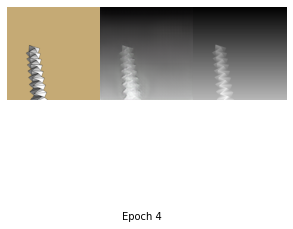

Epoch [5/50], Step [1/3750], D_loss: 0.2053, G_loss: 6.8182
Epoch [5/50], Step [2/3750], D_loss: 0.2625, G_loss: 9.4790
Epoch [5/50], Step [3/3750], D_loss: 0.4373, G_loss: 12.1265
Epoch [5/50], Step [4/3750], D_loss: 0.5624, G_loss: 3.6609
Epoch [5/50], Step [5/3750], D_loss: 0.2075, G_loss: 8.3665
Epoch [5/50], Step [6/3750], D_loss: 0.2447, G_loss: 5.4959
Epoch [5/50], Step [7/3750], D_loss: 0.4192, G_loss: 6.9181
Epoch [5/50], Step [8/3750], D_loss: 0.0609, G_loss: 8.4801
Epoch [5/50], Step [9/3750], D_loss: 0.5375, G_loss: 4.2439
Epoch [5/50], Step [10/3750], D_loss: 0.2914, G_loss: 9.5323
Epoch [5/50], Step [11/3750], D_loss: 0.5919, G_loss: 8.2414
Epoch [5/50], Step [12/3750], D_loss: 0.2904, G_loss: 4.6529
Epoch [5/50], Step [13/3750], D_loss: 0.5249, G_loss: 3.3996
Epoch [5/50], Step [14/3750], D_loss: 0.2550, G_loss: 6.1483
Epoch [5/50], Step [15/3750], D_loss: 0.6005, G_loss: 7.9084
Epoch [5/50], Step [16/3750], D_loss: 0.3840, G_loss: 4.4406
Epoch [5/50], Step [17/3750], D_

Epoch [5/50], Step [135/3750], D_loss: 0.9248, G_loss: 8.0439
Epoch [5/50], Step [136/3750], D_loss: 0.7260, G_loss: 4.1672
Epoch [5/50], Step [137/3750], D_loss: 0.4061, G_loss: 6.0062
Epoch [5/50], Step [138/3750], D_loss: 0.4221, G_loss: 6.5922
Epoch [5/50], Step [139/3750], D_loss: 0.2769, G_loss: 62.1596
Epoch [5/50], Step [140/3750], D_loss: 0.3326, G_loss: 5.3085
Epoch [5/50], Step [141/3750], D_loss: 0.0964, G_loss: 22.4765
Epoch [5/50], Step [142/3750], D_loss: 0.4725, G_loss: 4.3383
Epoch [5/50], Step [143/3750], D_loss: 0.0838, G_loss: 8.5576
Epoch [5/50], Step [144/3750], D_loss: 1.2120, G_loss: 7.2503
Epoch [5/50], Step [145/3750], D_loss: 0.5828, G_loss: 5.1601
Epoch [5/50], Step [146/3750], D_loss: 0.8042, G_loss: 11.3847
Epoch [5/50], Step [147/3750], D_loss: 0.7739, G_loss: 4.3922
Epoch [5/50], Step [148/3750], D_loss: 0.3449, G_loss: 6.4968
Epoch [5/50], Step [149/3750], D_loss: 0.7844, G_loss: 6.2759
Epoch [5/50], Step [150/3750], D_loss: 0.5748, G_loss: 4.6224
Epoch

Epoch [5/50], Step [267/3750], D_loss: 0.5394, G_loss: 6.1975
Epoch [5/50], Step [268/3750], D_loss: 0.6944, G_loss: 7.7324
Epoch [5/50], Step [269/3750], D_loss: 0.0829, G_loss: 4.8762
Epoch [5/50], Step [270/3750], D_loss: 0.5968, G_loss: 9.3690
Epoch [5/50], Step [271/3750], D_loss: 0.7368, G_loss: 2.5813
Epoch [5/50], Step [272/3750], D_loss: 0.3728, G_loss: 5.8409
Epoch [5/50], Step [273/3750], D_loss: 0.4425, G_loss: 7.1817
Epoch [5/50], Step [274/3750], D_loss: 0.0858, G_loss: 9.6506
Epoch [5/50], Step [275/3750], D_loss: 0.1912, G_loss: 4.8725
Epoch [5/50], Step [276/3750], D_loss: 0.9959, G_loss: 4.8967
Epoch [5/50], Step [277/3750], D_loss: 0.6516, G_loss: 3.5439
Epoch [5/50], Step [278/3750], D_loss: 0.0787, G_loss: 11.8562
Epoch [5/50], Step [279/3750], D_loss: 0.2327, G_loss: 9.6674
Epoch [5/50], Step [280/3750], D_loss: 0.1923, G_loss: 8.2755
Epoch [5/50], Step [281/3750], D_loss: 0.2334, G_loss: 5.4051
Epoch [5/50], Step [282/3750], D_loss: 0.7741, G_loss: 16.5559
Epoch 

Epoch [5/50], Step [399/3750], D_loss: 0.0772, G_loss: 10.0927
Epoch [5/50], Step [400/3750], D_loss: 0.8095, G_loss: 8.8080
Epoch [5/50], Step [401/3750], D_loss: 0.1203, G_loss: 9.3672
Epoch [5/50], Step [402/3750], D_loss: 0.1692, G_loss: 4.7954
Epoch [5/50], Step [403/3750], D_loss: 0.4189, G_loss: 5.7906
Epoch [5/50], Step [404/3750], D_loss: 0.5870, G_loss: 3.7294
Epoch [5/50], Step [405/3750], D_loss: 0.5948, G_loss: 5.2282
Epoch [5/50], Step [406/3750], D_loss: 0.1366, G_loss: 5.5127
Epoch [5/50], Step [407/3750], D_loss: 0.1223, G_loss: 8.2580
Epoch [5/50], Step [408/3750], D_loss: 0.6341, G_loss: 5.2442
Epoch [5/50], Step [409/3750], D_loss: 0.5016, G_loss: 4.8180
Epoch [5/50], Step [410/3750], D_loss: 0.0906, G_loss: 6.0817
Epoch [5/50], Step [411/3750], D_loss: 0.5310, G_loss: 10.7397
Epoch [5/50], Step [412/3750], D_loss: 0.6774, G_loss: 15.0913
Epoch [5/50], Step [413/3750], D_loss: 0.0449, G_loss: 11.7249
Epoch [5/50], Step [414/3750], D_loss: 0.6513, G_loss: 4.0141
Epoc

Epoch [5/50], Step [531/3750], D_loss: 0.7781, G_loss: 6.0125
Epoch [5/50], Step [532/3750], D_loss: 0.7085, G_loss: 2.9344
Epoch [5/50], Step [533/3750], D_loss: 0.1095, G_loss: 4.2595
Epoch [5/50], Step [534/3750], D_loss: 0.0719, G_loss: 8.6717
Epoch [5/50], Step [535/3750], D_loss: 0.1344, G_loss: 4.2915
Epoch [5/50], Step [536/3750], D_loss: 0.5272, G_loss: 6.5535
Epoch [5/50], Step [537/3750], D_loss: 0.2369, G_loss: 4.7697
Epoch [5/50], Step [538/3750], D_loss: 1.0754, G_loss: 7.1745
Epoch [5/50], Step [539/3750], D_loss: 0.6447, G_loss: 12.2592
Epoch [5/50], Step [540/3750], D_loss: 0.4934, G_loss: 5.1649
Epoch [5/50], Step [541/3750], D_loss: 0.2595, G_loss: 15.1001
Epoch [5/50], Step [542/3750], D_loss: 0.5025, G_loss: 6.5867
Epoch [5/50], Step [543/3750], D_loss: 0.2545, G_loss: 9.5506
Epoch [5/50], Step [544/3750], D_loss: 0.4778, G_loss: 7.4921
Epoch [5/50], Step [545/3750], D_loss: 0.4642, G_loss: 4.6779
Epoch [5/50], Step [546/3750], D_loss: 0.3717, G_loss: 32.7030
Epoch

Epoch [5/50], Step [663/3750], D_loss: 0.3235, G_loss: 8.3186
Epoch [5/50], Step [664/3750], D_loss: 0.2108, G_loss: 5.3533
Epoch [5/50], Step [665/3750], D_loss: 0.6734, G_loss: 13.0242
Epoch [5/50], Step [666/3750], D_loss: 1.0209, G_loss: 10.1792
Epoch [5/50], Step [667/3750], D_loss: 0.3680, G_loss: 3.6096
Epoch [5/50], Step [668/3750], D_loss: 0.3824, G_loss: 8.1484
Epoch [5/50], Step [669/3750], D_loss: 0.6758, G_loss: 3.9866
Epoch [5/50], Step [670/3750], D_loss: 0.6509, G_loss: 17.1504
Epoch [5/50], Step [671/3750], D_loss: 0.1872, G_loss: 14.0536
Epoch [5/50], Step [672/3750], D_loss: 0.4326, G_loss: 3.2822
Epoch [5/50], Step [673/3750], D_loss: 0.4857, G_loss: 5.9046
Epoch [5/50], Step [674/3750], D_loss: 0.1795, G_loss: 8.3471
Epoch [5/50], Step [675/3750], D_loss: 0.1669, G_loss: 5.0314
Epoch [5/50], Step [676/3750], D_loss: 0.4542, G_loss: 6.3198
Epoch [5/50], Step [677/3750], D_loss: 0.2263, G_loss: 12.9455
Epoch [5/50], Step [678/3750], D_loss: 0.4896, G_loss: 10.5145
Ep

Epoch [5/50], Step [795/3750], D_loss: 0.6632, G_loss: 3.5132
Epoch [5/50], Step [796/3750], D_loss: 0.4818, G_loss: 3.3205
Epoch [5/50], Step [797/3750], D_loss: 0.6238, G_loss: 7.1072
Epoch [5/50], Step [798/3750], D_loss: 0.5476, G_loss: 5.0205
Epoch [5/50], Step [799/3750], D_loss: 0.4505, G_loss: 10.0181
Epoch [5/50], Step [800/3750], D_loss: 0.8770, G_loss: 3.8551
Epoch [5/50], Step [801/3750], D_loss: 0.7959, G_loss: 7.5797
Epoch [5/50], Step [802/3750], D_loss: 0.8430, G_loss: 7.9019
Epoch [5/50], Step [803/3750], D_loss: 0.7904, G_loss: 5.0151
Epoch [5/50], Step [804/3750], D_loss: 0.7217, G_loss: 4.6539
Epoch [5/50], Step [805/3750], D_loss: 0.4485, G_loss: 9.5417
Epoch [5/50], Step [806/3750], D_loss: 0.2041, G_loss: 13.6491
Epoch [5/50], Step [807/3750], D_loss: 0.4819, G_loss: 4.1667
Epoch [5/50], Step [808/3750], D_loss: 0.3451, G_loss: 7.9523
Epoch [5/50], Step [809/3750], D_loss: 0.7686, G_loss: 7.5416
Epoch [5/50], Step [810/3750], D_loss: 0.2640, G_loss: 5.1534
Epoch 

Epoch [5/50], Step [927/3750], D_loss: 0.1432, G_loss: 7.4667
Epoch [5/50], Step [928/3750], D_loss: 0.0606, G_loss: 7.8786
Epoch [5/50], Step [929/3750], D_loss: 0.5491, G_loss: 5.7012
Epoch [5/50], Step [930/3750], D_loss: 0.5981, G_loss: 4.0653
Epoch [5/50], Step [931/3750], D_loss: 0.3133, G_loss: 12.6324
Epoch [5/50], Step [932/3750], D_loss: 0.5225, G_loss: 6.7584
Epoch [5/50], Step [933/3750], D_loss: 0.7291, G_loss: 4.7053
Epoch [5/50], Step [934/3750], D_loss: 0.4049, G_loss: 8.7058
Epoch [5/50], Step [935/3750], D_loss: 0.5513, G_loss: 8.1399
Epoch [5/50], Step [936/3750], D_loss: 0.5665, G_loss: 4.2266
Epoch [5/50], Step [937/3750], D_loss: 0.6274, G_loss: 4.1315
Epoch [5/50], Step [938/3750], D_loss: 0.9468, G_loss: 7.0063
Epoch [5/50], Step [939/3750], D_loss: 0.5583, G_loss: 3.0640
Epoch [5/50], Step [940/3750], D_loss: 0.3755, G_loss: 6.0252
Epoch [5/50], Step [941/3750], D_loss: 0.5606, G_loss: 6.0617
Epoch [5/50], Step [942/3750], D_loss: 0.3890, G_loss: 7.8187
Epoch [

Epoch [5/50], Step [1058/3750], D_loss: 0.3099, G_loss: 5.6322
Epoch [5/50], Step [1059/3750], D_loss: 0.7392, G_loss: 6.1813
Epoch [5/50], Step [1060/3750], D_loss: 0.1544, G_loss: 12.6964
Epoch [5/50], Step [1061/3750], D_loss: 0.1238, G_loss: 6.9270
Epoch [5/50], Step [1062/3750], D_loss: 0.5246, G_loss: 8.6042
Epoch [5/50], Step [1063/3750], D_loss: 0.1357, G_loss: 15.1748
Epoch [5/50], Step [1064/3750], D_loss: 0.2281, G_loss: 5.5785
Epoch [5/50], Step [1065/3750], D_loss: 0.4464, G_loss: 4.4449
Epoch [5/50], Step [1066/3750], D_loss: 0.4986, G_loss: 3.8587
Epoch [5/50], Step [1067/3750], D_loss: 0.1957, G_loss: 9.4726
Epoch [5/50], Step [1068/3750], D_loss: 0.5664, G_loss: 9.9249
Epoch [5/50], Step [1069/3750], D_loss: 0.6549, G_loss: 8.4469
Epoch [5/50], Step [1070/3750], D_loss: 0.7097, G_loss: 6.4430
Epoch [5/50], Step [1071/3750], D_loss: 0.6640, G_loss: 3.6360
Epoch [5/50], Step [1072/3750], D_loss: 0.2710, G_loss: 22.8994
Epoch [5/50], Step [1073/3750], D_loss: 0.0342, G_lo

Epoch [5/50], Step [1188/3750], D_loss: 0.3800, G_loss: 8.4229
Epoch [5/50], Step [1189/3750], D_loss: 0.1657, G_loss: 6.4455
Epoch [5/50], Step [1190/3750], D_loss: 0.0526, G_loss: 8.2446
Epoch [5/50], Step [1191/3750], D_loss: 0.4573, G_loss: 2.8816
Epoch [5/50], Step [1192/3750], D_loss: 0.2621, G_loss: 8.3649
Epoch [5/50], Step [1193/3750], D_loss: 0.2061, G_loss: 7.0573
Epoch [5/50], Step [1194/3750], D_loss: 0.4021, G_loss: 8.5106
Epoch [5/50], Step [1195/3750], D_loss: 0.1858, G_loss: 21.3976
Epoch [5/50], Step [1196/3750], D_loss: 0.2964, G_loss: 4.6582
Epoch [5/50], Step [1197/3750], D_loss: 0.5452, G_loss: 4.1608
Epoch [5/50], Step [1198/3750], D_loss: 0.5047, G_loss: 11.8258
Epoch [5/50], Step [1199/3750], D_loss: 0.8580, G_loss: 7.9972
Epoch [5/50], Step [1200/3750], D_loss: 0.6092, G_loss: 4.1192
Epoch [5/50], Step [1201/3750], D_loss: 0.3742, G_loss: 6.1000
Epoch [5/50], Step [1202/3750], D_loss: 0.0774, G_loss: 11.7995
Epoch [5/50], Step [1203/3750], D_loss: 0.5187, G_lo

Epoch [5/50], Step [1318/3750], D_loss: 0.5456, G_loss: 5.6745
Epoch [5/50], Step [1319/3750], D_loss: 0.4258, G_loss: 7.0380
Epoch [5/50], Step [1320/3750], D_loss: 0.8692, G_loss: 2.7468
Epoch [5/50], Step [1321/3750], D_loss: 0.4603, G_loss: 8.5321
Epoch [5/50], Step [1322/3750], D_loss: 0.0619, G_loss: 7.5905
Epoch [5/50], Step [1323/3750], D_loss: 0.2816, G_loss: 4.6489
Epoch [5/50], Step [1324/3750], D_loss: 0.4587, G_loss: 13.3647
Epoch [5/50], Step [1325/3750], D_loss: 0.5402, G_loss: 6.2815
Epoch [5/50], Step [1326/3750], D_loss: 0.5327, G_loss: 5.4011
Epoch [5/50], Step [1327/3750], D_loss: 0.4142, G_loss: 2.8994
Epoch [5/50], Step [1328/3750], D_loss: 0.1353, G_loss: 8.2793
Epoch [5/50], Step [1329/3750], D_loss: 0.3552, G_loss: 5.3458
Epoch [5/50], Step [1330/3750], D_loss: 0.2992, G_loss: 8.4702
Epoch [5/50], Step [1331/3750], D_loss: 0.2300, G_loss: 6.6319
Epoch [5/50], Step [1332/3750], D_loss: 0.2222, G_loss: 6.7050
Epoch [5/50], Step [1333/3750], D_loss: 0.0772, G_loss

Epoch [5/50], Step [1448/3750], D_loss: 0.5982, G_loss: 4.1790
Epoch [5/50], Step [1449/3750], D_loss: 0.4538, G_loss: 5.5968
Epoch [5/50], Step [1450/3750], D_loss: 0.1444, G_loss: 8.5858
Epoch [5/50], Step [1451/3750], D_loss: 0.1816, G_loss: 7.5383
Epoch [5/50], Step [1452/3750], D_loss: 0.6790, G_loss: 5.7643
Epoch [5/50], Step [1453/3750], D_loss: 0.3434, G_loss: 9.2420
Epoch [5/50], Step [1454/3750], D_loss: 0.8504, G_loss: 7.7014
Epoch [5/50], Step [1455/3750], D_loss: 0.0315, G_loss: 7.5152
Epoch [5/50], Step [1456/3750], D_loss: 0.0455, G_loss: 6.6137
Epoch [5/50], Step [1457/3750], D_loss: 0.0903, G_loss: 5.0270
Epoch [5/50], Step [1458/3750], D_loss: 0.1205, G_loss: 5.5132
Epoch [5/50], Step [1459/3750], D_loss: 0.1062, G_loss: 4.6339
Epoch [5/50], Step [1460/3750], D_loss: 0.3579, G_loss: 3.5156
Epoch [5/50], Step [1461/3750], D_loss: 1.3885, G_loss: 11.8711
Epoch [5/50], Step [1462/3750], D_loss: 0.6067, G_loss: 3.9000
Epoch [5/50], Step [1463/3750], D_loss: 1.0372, G_loss

Epoch [5/50], Step [1578/3750], D_loss: 0.1080, G_loss: 8.3970
Epoch [5/50], Step [1579/3750], D_loss: 0.6689, G_loss: 8.0584
Epoch [5/50], Step [1580/3750], D_loss: 0.5537, G_loss: 4.5526
Epoch [5/50], Step [1581/3750], D_loss: 0.4449, G_loss: 5.3267
Epoch [5/50], Step [1582/3750], D_loss: 0.1888, G_loss: 9.3959
Epoch [5/50], Step [1583/3750], D_loss: 0.4560, G_loss: 7.5487
Epoch [5/50], Step [1584/3750], D_loss: 0.5792, G_loss: 4.6882
Epoch [5/50], Step [1585/3750], D_loss: 0.2543, G_loss: 7.2641
Epoch [5/50], Step [1586/3750], D_loss: 1.1327, G_loss: 7.8648
Epoch [5/50], Step [1587/3750], D_loss: 0.4736, G_loss: 6.4567
Epoch [5/50], Step [1588/3750], D_loss: 0.5244, G_loss: 8.5901
Epoch [5/50], Step [1589/3750], D_loss: 0.1628, G_loss: 18.6378
Epoch [5/50], Step [1590/3750], D_loss: 0.5031, G_loss: 9.1584
Epoch [5/50], Step [1591/3750], D_loss: 0.5793, G_loss: 5.7642
Epoch [5/50], Step [1592/3750], D_loss: 0.5282, G_loss: 5.0059
Epoch [5/50], Step [1593/3750], D_loss: 0.1003, G_loss

Epoch [5/50], Step [1708/3750], D_loss: 0.7445, G_loss: 4.5404
Epoch [5/50], Step [1709/3750], D_loss: 0.5638, G_loss: 8.5143
Epoch [5/50], Step [1710/3750], D_loss: 0.8100, G_loss: 8.6176
Epoch [5/50], Step [1711/3750], D_loss: 0.8845, G_loss: 11.5430
Epoch [5/50], Step [1712/3750], D_loss: 0.6750, G_loss: 2.5486
Epoch [5/50], Step [1713/3750], D_loss: 0.6517, G_loss: 6.6066
Epoch [5/50], Step [1714/3750], D_loss: 0.6557, G_loss: 10.1888
Epoch [5/50], Step [1715/3750], D_loss: 0.8245, G_loss: 5.2176
Epoch [5/50], Step [1716/3750], D_loss: 0.6352, G_loss: 7.2048
Epoch [5/50], Step [1717/3750], D_loss: 0.3354, G_loss: 6.0593
Epoch [5/50], Step [1718/3750], D_loss: 0.2535, G_loss: 16.2947
Epoch [5/50], Step [1719/3750], D_loss: 0.6134, G_loss: 5.6088
Epoch [5/50], Step [1720/3750], D_loss: 0.7723, G_loss: 5.9591
Epoch [5/50], Step [1721/3750], D_loss: 0.6774, G_loss: 3.1702
Epoch [5/50], Step [1722/3750], D_loss: 0.1090, G_loss: 9.6830
Epoch [5/50], Step [1723/3750], D_loss: 0.7441, G_lo

Epoch [5/50], Step [1838/3750], D_loss: 0.3153, G_loss: 7.3721
Epoch [5/50], Step [1839/3750], D_loss: 0.5152, G_loss: 5.4554
Epoch [5/50], Step [1840/3750], D_loss: 0.4147, G_loss: 3.8852
Epoch [5/50], Step [1841/3750], D_loss: 0.4342, G_loss: 4.6414
Epoch [5/50], Step [1842/3750], D_loss: 0.1363, G_loss: 5.9749
Epoch [5/50], Step [1843/3750], D_loss: 0.3135, G_loss: 5.6549
Epoch [5/50], Step [1844/3750], D_loss: 0.6672, G_loss: 10.0315
Epoch [5/50], Step [1845/3750], D_loss: 1.3265, G_loss: 2.4580
Epoch [5/50], Step [1846/3750], D_loss: 0.6506, G_loss: 5.2909
Epoch [5/50], Step [1847/3750], D_loss: 0.0241, G_loss: 9.0517
Epoch [5/50], Step [1848/3750], D_loss: 0.5131, G_loss: 11.5908
Epoch [5/50], Step [1849/3750], D_loss: 0.8389, G_loss: 3.5663
Epoch [5/50], Step [1850/3750], D_loss: 0.4961, G_loss: 5.1683
Epoch [5/50], Step [1851/3750], D_loss: 0.5506, G_loss: 5.0837
Epoch [5/50], Step [1852/3750], D_loss: 0.5375, G_loss: 7.3737
Epoch [5/50], Step [1853/3750], D_loss: 0.2417, G_los

Epoch [5/50], Step [1968/3750], D_loss: 1.1316, G_loss: 6.9177
Epoch [5/50], Step [1969/3750], D_loss: 0.9480, G_loss: 2.6492
Epoch [5/50], Step [1970/3750], D_loss: 0.9270, G_loss: 9.5377
Epoch [5/50], Step [1971/3750], D_loss: 0.7781, G_loss: 3.9105
Epoch [5/50], Step [1972/3750], D_loss: 0.7091, G_loss: 4.4830
Epoch [5/50], Step [1973/3750], D_loss: 0.5513, G_loss: 11.0589
Epoch [5/50], Step [1974/3750], D_loss: 0.5470, G_loss: 5.7381
Epoch [5/50], Step [1975/3750], D_loss: 0.2269, G_loss: 12.7937
Epoch [5/50], Step [1976/3750], D_loss: 0.6267, G_loss: 6.3466
Epoch [5/50], Step [1977/3750], D_loss: 0.6998, G_loss: 8.2523
Epoch [5/50], Step [1978/3750], D_loss: 0.6369, G_loss: 3.0011
Epoch [5/50], Step [1979/3750], D_loss: 0.7919, G_loss: 4.7657
Epoch [5/50], Step [1980/3750], D_loss: 0.6455, G_loss: 3.1954
Epoch [5/50], Step [1981/3750], D_loss: 0.4823, G_loss: 7.3176
Epoch [5/50], Step [1982/3750], D_loss: 0.6812, G_loss: 4.0192
Epoch [5/50], Step [1983/3750], D_loss: 0.4997, G_los

Epoch [5/50], Step [2098/3750], D_loss: 0.7439, G_loss: 4.0015
Epoch [5/50], Step [2099/3750], D_loss: 0.6484, G_loss: 3.5222
Epoch [5/50], Step [2100/3750], D_loss: 0.5710, G_loss: 4.8673
Epoch [5/50], Step [2101/3750], D_loss: 0.4609, G_loss: 7.8807
Epoch [5/50], Step [2102/3750], D_loss: 0.4693, G_loss: 3.6990
Epoch [5/50], Step [2103/3750], D_loss: 0.4819, G_loss: 10.2040
Epoch [5/50], Step [2104/3750], D_loss: 0.6292, G_loss: 4.1837
Epoch [5/50], Step [2105/3750], D_loss: 0.3517, G_loss: 11.0964
Epoch [5/50], Step [2106/3750], D_loss: 0.5065, G_loss: 3.7200
Epoch [5/50], Step [2107/3750], D_loss: 0.1537, G_loss: 9.3750
Epoch [5/50], Step [2108/3750], D_loss: 0.0756, G_loss: 9.2385
Epoch [5/50], Step [2109/3750], D_loss: 0.0756, G_loss: 9.3759
Epoch [5/50], Step [2110/3750], D_loss: 0.9528, G_loss: 3.8144
Epoch [5/50], Step [2111/3750], D_loss: 0.7484, G_loss: 13.0997
Epoch [5/50], Step [2112/3750], D_loss: 0.3360, G_loss: 4.4392
Epoch [5/50], Step [2113/3750], D_loss: 0.6054, G_lo

Epoch [5/50], Step [2228/3750], D_loss: 0.4430, G_loss: 4.0818
Epoch [5/50], Step [2229/3750], D_loss: 0.0505, G_loss: 10.4570
Epoch [5/50], Step [2230/3750], D_loss: 0.7893, G_loss: 4.6733
Epoch [5/50], Step [2231/3750], D_loss: 0.5728, G_loss: 5.7005
Epoch [5/50], Step [2232/3750], D_loss: 0.0887, G_loss: 4.2499
Epoch [5/50], Step [2233/3750], D_loss: 0.4933, G_loss: 7.4128
Epoch [5/50], Step [2234/3750], D_loss: 0.6406, G_loss: 5.2584
Epoch [5/50], Step [2235/3750], D_loss: 0.3427, G_loss: 28.2773
Epoch [5/50], Step [2236/3750], D_loss: 0.1480, G_loss: 9.9574
Epoch [5/50], Step [2237/3750], D_loss: 0.6794, G_loss: 6.7466
Epoch [5/50], Step [2238/3750], D_loss: 0.0263, G_loss: 13.6779
Epoch [5/50], Step [2239/3750], D_loss: 1.0220, G_loss: 5.5103
Epoch [5/50], Step [2240/3750], D_loss: 0.1141, G_loss: 11.5915
Epoch [5/50], Step [2241/3750], D_loss: 0.5465, G_loss: 6.0202
Epoch [5/50], Step [2242/3750], D_loss: 0.4468, G_loss: 3.9551
Epoch [5/50], Step [2243/3750], D_loss: 0.6963, G_l

Epoch [5/50], Step [2358/3750], D_loss: 0.5196, G_loss: 11.7779
Epoch [5/50], Step [2359/3750], D_loss: 1.0023, G_loss: 3.7454
Epoch [5/50], Step [2360/3750], D_loss: 0.4472, G_loss: 6.3294
Epoch [5/50], Step [2361/3750], D_loss: 1.0701, G_loss: 4.5153
Epoch [5/50], Step [2362/3750], D_loss: 0.3632, G_loss: 3.8472
Epoch [5/50], Step [2363/3750], D_loss: 0.1735, G_loss: 6.2223
Epoch [5/50], Step [2364/3750], D_loss: 0.3444, G_loss: 9.0539
Epoch [5/50], Step [2365/3750], D_loss: 0.1156, G_loss: 6.9224
Epoch [5/50], Step [2366/3750], D_loss: 0.9430, G_loss: 4.2342
Epoch [5/50], Step [2367/3750], D_loss: 0.4121, G_loss: 2.7552
Epoch [5/50], Step [2368/3750], D_loss: 0.3406, G_loss: 5.5397
Epoch [5/50], Step [2369/3750], D_loss: 0.2172, G_loss: 4.8270
Epoch [5/50], Step [2370/3750], D_loss: 0.7519, G_loss: 4.2985
Epoch [5/50], Step [2371/3750], D_loss: 0.0436, G_loss: 9.8111
Epoch [5/50], Step [2372/3750], D_loss: 0.8436, G_loss: 3.0187
Epoch [5/50], Step [2373/3750], D_loss: 0.9726, G_loss

Epoch [5/50], Step [2488/3750], D_loss: 0.8654, G_loss: 5.7486
Epoch [5/50], Step [2489/3750], D_loss: 0.6624, G_loss: 3.8164
Epoch [5/50], Step [2490/3750], D_loss: 0.6956, G_loss: 4.8651
Epoch [5/50], Step [2491/3750], D_loss: 0.3387, G_loss: 8.6246
Epoch [5/50], Step [2492/3750], D_loss: 0.1445, G_loss: 7.2731
Epoch [5/50], Step [2493/3750], D_loss: 0.9820, G_loss: 2.7765
Epoch [5/50], Step [2494/3750], D_loss: 0.8780, G_loss: 4.3189
Epoch [5/50], Step [2495/3750], D_loss: 0.4546, G_loss: 7.6675
Epoch [5/50], Step [2496/3750], D_loss: 0.7388, G_loss: 3.3542
Epoch [5/50], Step [2497/3750], D_loss: 0.6402, G_loss: 4.1875
Epoch [5/50], Step [2498/3750], D_loss: 0.7233, G_loss: 4.9835
Epoch [5/50], Step [2499/3750], D_loss: 0.9266, G_loss: 3.7438
Epoch [5/50], Step [2500/3750], D_loss: 0.4980, G_loss: 3.8928
Epoch [5/50], Step [2501/3750], D_loss: 0.6723, G_loss: 2.9474
Epoch [5/50], Step [2502/3750], D_loss: 0.6602, G_loss: 4.7896
Epoch [5/50], Step [2503/3750], D_loss: 0.7023, G_loss:

Epoch [5/50], Step [2618/3750], D_loss: 0.1721, G_loss: 5.8659
Epoch [5/50], Step [2619/3750], D_loss: 0.2718, G_loss: 3.7663
Epoch [5/50], Step [2620/3750], D_loss: 0.8121, G_loss: 6.9893
Epoch [5/50], Step [2621/3750], D_loss: 0.0733, G_loss: 10.6189
Epoch [5/50], Step [2622/3750], D_loss: 0.1896, G_loss: 9.5342
Epoch [5/50], Step [2623/3750], D_loss: 0.6014, G_loss: 8.3431
Epoch [5/50], Step [2624/3750], D_loss: 0.7825, G_loss: 4.6849
Epoch [5/50], Step [2625/3750], D_loss: 0.5399, G_loss: 3.3093
Epoch [5/50], Step [2626/3750], D_loss: 0.5366, G_loss: 6.9892
Epoch [5/50], Step [2627/3750], D_loss: 0.0900, G_loss: 20.4652
Epoch [5/50], Step [2628/3750], D_loss: 0.5212, G_loss: 4.3194
Epoch [5/50], Step [2629/3750], D_loss: 0.5891, G_loss: 3.5374
Epoch [5/50], Step [2630/3750], D_loss: 0.8479, G_loss: 10.5160
Epoch [5/50], Step [2631/3750], D_loss: 0.7982, G_loss: 4.4213
Epoch [5/50], Step [2632/3750], D_loss: 1.1728, G_loss: 7.8195
Epoch [5/50], Step [2633/3750], D_loss: 0.8496, G_lo

Epoch [5/50], Step [2748/3750], D_loss: 0.2728, G_loss: 7.4541
Epoch [5/50], Step [2749/3750], D_loss: 0.4442, G_loss: 6.1647
Epoch [5/50], Step [2750/3750], D_loss: 0.7774, G_loss: 4.9069
Epoch [5/50], Step [2751/3750], D_loss: 0.1656, G_loss: 12.5794
Epoch [5/50], Step [2752/3750], D_loss: 0.5231, G_loss: 4.7968
Epoch [5/50], Step [2753/3750], D_loss: 0.4672, G_loss: 3.4840
Epoch [5/50], Step [2754/3750], D_loss: 0.7707, G_loss: 2.7087
Epoch [5/50], Step [2755/3750], D_loss: 1.0867, G_loss: 6.9627
Epoch [5/50], Step [2756/3750], D_loss: 0.7292, G_loss: 3.8254
Epoch [5/50], Step [2757/3750], D_loss: 0.4043, G_loss: 7.4522
Epoch [5/50], Step [2758/3750], D_loss: 0.1679, G_loss: 7.4505
Epoch [5/50], Step [2759/3750], D_loss: 0.6793, G_loss: 4.8333
Epoch [5/50], Step [2760/3750], D_loss: 0.4612, G_loss: 9.9647
Epoch [5/50], Step [2761/3750], D_loss: 0.0404, G_loss: 8.1441
Epoch [5/50], Step [2762/3750], D_loss: 0.0414, G_loss: 7.8093
Epoch [5/50], Step [2763/3750], D_loss: 0.3945, G_loss

Epoch [5/50], Step [2878/3750], D_loss: 0.2943, G_loss: 10.1015
Epoch [5/50], Step [2879/3750], D_loss: 0.3047, G_loss: 31.0878
Epoch [5/50], Step [2880/3750], D_loss: 0.6337, G_loss: 3.3031
Epoch [5/50], Step [2881/3750], D_loss: 0.3165, G_loss: 8.6098
Epoch [5/50], Step [2882/3750], D_loss: 0.1048, G_loss: 6.2956
Epoch [5/50], Step [2883/3750], D_loss: 0.3145, G_loss: 6.3102
Epoch [5/50], Step [2884/3750], D_loss: 0.0333, G_loss: 12.8208
Epoch [5/50], Step [2885/3750], D_loss: 0.1193, G_loss: 7.4599
Epoch [5/50], Step [2886/3750], D_loss: 0.4132, G_loss: 2.3578
Epoch [5/50], Step [2887/3750], D_loss: 0.3597, G_loss: 3.3955
Epoch [5/50], Step [2888/3750], D_loss: 0.7580, G_loss: 31.1425
Epoch [5/50], Step [2889/3750], D_loss: 0.2010, G_loss: 7.1926
Epoch [5/50], Step [2890/3750], D_loss: 0.2121, G_loss: 10.2039
Epoch [5/50], Step [2891/3750], D_loss: 0.4746, G_loss: 6.3831
Epoch [5/50], Step [2892/3750], D_loss: 0.5669, G_loss: 6.4320
Epoch [5/50], Step [2893/3750], D_loss: 1.1126, G_

Epoch [5/50], Step [3008/3750], D_loss: 0.5765, G_loss: 4.3267
Epoch [5/50], Step [3009/3750], D_loss: 0.5865, G_loss: 5.8990
Epoch [5/50], Step [3010/3750], D_loss: 0.7089, G_loss: 6.7051
Epoch [5/50], Step [3011/3750], D_loss: 0.5314, G_loss: 6.8395
Epoch [5/50], Step [3012/3750], D_loss: 0.1495, G_loss: 6.1988
Epoch [5/50], Step [3013/3750], D_loss: 0.3271, G_loss: 10.7089
Epoch [5/50], Step [3014/3750], D_loss: 0.1040, G_loss: 11.6230
Epoch [5/50], Step [3015/3750], D_loss: 0.1148, G_loss: 7.6251
Epoch [5/50], Step [3016/3750], D_loss: 0.3312, G_loss: 5.0449
Epoch [5/50], Step [3017/3750], D_loss: 0.6586, G_loss: 5.1872
Epoch [5/50], Step [3018/3750], D_loss: 0.3226, G_loss: 5.2959
Epoch [5/50], Step [3019/3750], D_loss: 0.2810, G_loss: 4.9624
Epoch [5/50], Step [3020/3750], D_loss: 0.2283, G_loss: 7.8289
Epoch [5/50], Step [3021/3750], D_loss: 0.6185, G_loss: 4.9259
Epoch [5/50], Step [3022/3750], D_loss: 0.1496, G_loss: 12.0096
Epoch [5/50], Step [3023/3750], D_loss: 0.2855, G_lo

Epoch [5/50], Step [3138/3750], D_loss: 0.8209, G_loss: 3.0171
Epoch [5/50], Step [3139/3750], D_loss: 0.4522, G_loss: 5.3431
Epoch [5/50], Step [3140/3750], D_loss: 0.6985, G_loss: 7.7210
Epoch [5/50], Step [3141/3750], D_loss: 0.4508, G_loss: 4.5348
Epoch [5/50], Step [3142/3750], D_loss: 0.3674, G_loss: 7.5287
Epoch [5/50], Step [3143/3750], D_loss: 0.7561, G_loss: 8.7888
Epoch [5/50], Step [3144/3750], D_loss: 0.4946, G_loss: 3.8669
Epoch [5/50], Step [3145/3750], D_loss: 0.5782, G_loss: 2.8949
Epoch [5/50], Step [3146/3750], D_loss: 0.3380, G_loss: 11.3406
Epoch [5/50], Step [3147/3750], D_loss: 0.7456, G_loss: 3.1373
Epoch [5/50], Step [3148/3750], D_loss: 0.6653, G_loss: 5.1848
Epoch [5/50], Step [3149/3750], D_loss: 0.2652, G_loss: 6.4621
Epoch [5/50], Step [3150/3750], D_loss: 0.2223, G_loss: 9.2933
Epoch [5/50], Step [3151/3750], D_loss: 0.2171, G_loss: 8.5182
Epoch [5/50], Step [3152/3750], D_loss: 0.3205, G_loss: 3.6313
Epoch [5/50], Step [3153/3750], D_loss: 0.6780, G_loss

Epoch [5/50], Step [3268/3750], D_loss: 0.5395, G_loss: 4.1651
Epoch [5/50], Step [3269/3750], D_loss: 0.1299, G_loss: 9.5977
Epoch [5/50], Step [3270/3750], D_loss: 0.9169, G_loss: 3.9644
Epoch [5/50], Step [3271/3750], D_loss: 0.1656, G_loss: 8.6539
Epoch [5/50], Step [3272/3750], D_loss: 0.1295, G_loss: 8.2522
Epoch [5/50], Step [3273/3750], D_loss: 0.1691, G_loss: 8.1475
Epoch [5/50], Step [3274/3750], D_loss: 0.1487, G_loss: 8.0999
Epoch [5/50], Step [3275/3750], D_loss: 0.0814, G_loss: 7.9406
Epoch [5/50], Step [3276/3750], D_loss: 0.4615, G_loss: 7.0122
Epoch [5/50], Step [3277/3750], D_loss: 0.4738, G_loss: 10.2967
Epoch [5/50], Step [3278/3750], D_loss: 0.3177, G_loss: 14.3791
Epoch [5/50], Step [3279/3750], D_loss: 0.2202, G_loss: 6.6797
Epoch [5/50], Step [3280/3750], D_loss: 0.1508, G_loss: 5.9460
Epoch [5/50], Step [3281/3750], D_loss: 0.1975, G_loss: 8.0595
Epoch [5/50], Step [3282/3750], D_loss: 0.2683, G_loss: 8.6756
Epoch [5/50], Step [3283/3750], D_loss: 0.6792, G_los

Epoch [5/50], Step [3398/3750], D_loss: 0.1089, G_loss: 14.5648
Epoch [5/50], Step [3399/3750], D_loss: 0.2320, G_loss: 7.6836
Epoch [5/50], Step [3400/3750], D_loss: 0.0713, G_loss: 7.6083
Epoch [5/50], Step [3401/3750], D_loss: 0.2612, G_loss: 3.5290
Epoch [5/50], Step [3402/3750], D_loss: 0.3135, G_loss: 9.0681
Epoch [5/50], Step [3403/3750], D_loss: 0.1615, G_loss: 6.3871
Epoch [5/50], Step [3404/3750], D_loss: 0.6207, G_loss: 4.0501
Epoch [5/50], Step [3405/3750], D_loss: 0.6346, G_loss: 3.1608
Epoch [5/50], Step [3406/3750], D_loss: 0.7451, G_loss: 10.1395
Epoch [5/50], Step [3407/3750], D_loss: 0.2709, G_loss: 3.3502
Epoch [5/50], Step [3408/3750], D_loss: 0.8500, G_loss: 5.5801
Epoch [5/50], Step [3409/3750], D_loss: 0.6821, G_loss: 5.1417
Epoch [5/50], Step [3410/3750], D_loss: 0.5884, G_loss: 4.7570
Epoch [5/50], Step [3411/3750], D_loss: 0.5991, G_loss: 3.8435
Epoch [5/50], Step [3412/3750], D_loss: 0.0413, G_loss: 11.4123
Epoch [5/50], Step [3413/3750], D_loss: 0.4187, G_lo

Epoch [5/50], Step [3528/3750], D_loss: 0.1619, G_loss: 21.4748
Epoch [5/50], Step [3529/3750], D_loss: 0.1291, G_loss: 9.5972
Epoch [5/50], Step [3530/3750], D_loss: 0.5484, G_loss: 4.9244
Epoch [5/50], Step [3531/3750], D_loss: 0.5407, G_loss: 4.0470
Epoch [5/50], Step [3532/3750], D_loss: 0.4491, G_loss: 14.9299
Epoch [5/50], Step [3533/3750], D_loss: 0.7669, G_loss: 3.5125
Epoch [5/50], Step [3534/3750], D_loss: 0.3562, G_loss: 11.0602
Epoch [5/50], Step [3535/3750], D_loss: 0.1701, G_loss: 4.4523
Epoch [5/50], Step [3536/3750], D_loss: 0.2476, G_loss: 6.9910
Epoch [5/50], Step [3537/3750], D_loss: 0.6371, G_loss: 7.1866
Epoch [5/50], Step [3538/3750], D_loss: 0.8038, G_loss: 8.0823
Epoch [5/50], Step [3539/3750], D_loss: 0.8990, G_loss: 7.6665
Epoch [5/50], Step [3540/3750], D_loss: 0.7549, G_loss: 2.6713
Epoch [5/50], Step [3541/3750], D_loss: 0.5330, G_loss: 4.9386
Epoch [5/50], Step [3542/3750], D_loss: 0.0187, G_loss: 10.2978
Epoch [5/50], Step [3543/3750], D_loss: 0.6250, G_l

Epoch [5/50], Step [3658/3750], D_loss: 0.2676, G_loss: 15.3043
Epoch [5/50], Step [3659/3750], D_loss: 0.3813, G_loss: 24.5492
Epoch [5/50], Step [3660/3750], D_loss: 0.7424, G_loss: 5.7335
Epoch [5/50], Step [3661/3750], D_loss: 0.1175, G_loss: 10.6252
Epoch [5/50], Step [3662/3750], D_loss: 0.6990, G_loss: 4.4753
Epoch [5/50], Step [3663/3750], D_loss: 0.3213, G_loss: 6.8546
Epoch [5/50], Step [3664/3750], D_loss: 0.3403, G_loss: 11.2486
Epoch [5/50], Step [3665/3750], D_loss: 0.4058, G_loss: 7.4970
Epoch [5/50], Step [3666/3750], D_loss: 0.1123, G_loss: 11.1265
Epoch [5/50], Step [3667/3750], D_loss: 0.1351, G_loss: 4.9536
Epoch [5/50], Step [3668/3750], D_loss: 0.2571, G_loss: 16.0856
Epoch [5/50], Step [3669/3750], D_loss: 0.1471, G_loss: 6.8128
Epoch [5/50], Step [3670/3750], D_loss: 0.3584, G_loss: 11.2312
Epoch [5/50], Step [3671/3750], D_loss: 0.4944, G_loss: 7.4459
Epoch [5/50], Step [3672/3750], D_loss: 0.2421, G_loss: 4.9980
Epoch [5/50], Step [3673/3750], D_loss: 0.2185, 

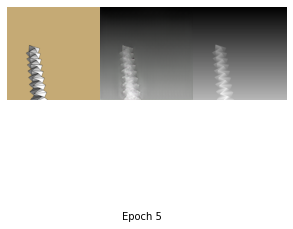

Epoch [6/50], Step [1/3750], D_loss: 0.4712, G_loss: 6.4008
Epoch [6/50], Step [2/3750], D_loss: 0.1899, G_loss: 7.1384
Epoch [6/50], Step [3/3750], D_loss: 0.2927, G_loss: 8.0155
Epoch [6/50], Step [4/3750], D_loss: 0.1262, G_loss: 9.1881
Epoch [6/50], Step [5/3750], D_loss: 0.8369, G_loss: 12.3200
Epoch [6/50], Step [6/3750], D_loss: 0.0321, G_loss: 8.4099
Epoch [6/50], Step [7/3750], D_loss: 0.8228, G_loss: 6.8455
Epoch [6/50], Step [8/3750], D_loss: 0.0643, G_loss: 8.9383
Epoch [6/50], Step [9/3750], D_loss: 0.1801, G_loss: 7.6611
Epoch [6/50], Step [10/3750], D_loss: 1.1160, G_loss: 4.9428
Epoch [6/50], Step [11/3750], D_loss: 0.4253, G_loss: 5.6154
Epoch [6/50], Step [12/3750], D_loss: 0.3223, G_loss: 14.3413
Epoch [6/50], Step [13/3750], D_loss: 0.5785, G_loss: 4.5711
Epoch [6/50], Step [14/3750], D_loss: 0.5415, G_loss: 7.8936
Epoch [6/50], Step [15/3750], D_loss: 1.3738, G_loss: 3.4235
Epoch [6/50], Step [16/3750], D_loss: 0.7342, G_loss: 4.8772
Epoch [6/50], Step [17/3750], D

Epoch [6/50], Step [135/3750], D_loss: 0.8472, G_loss: 5.4005
Epoch [6/50], Step [136/3750], D_loss: 0.9532, G_loss: 5.8111
Epoch [6/50], Step [137/3750], D_loss: 0.4494, G_loss: 9.9454
Epoch [6/50], Step [138/3750], D_loss: 0.1025, G_loss: 8.5468
Epoch [6/50], Step [139/3750], D_loss: 0.3854, G_loss: 9.7931
Epoch [6/50], Step [140/3750], D_loss: 1.0060, G_loss: 6.3397
Epoch [6/50], Step [141/3750], D_loss: 0.3562, G_loss: 2.4128
Epoch [6/50], Step [142/3750], D_loss: 0.3795, G_loss: 3.8181
Epoch [6/50], Step [143/3750], D_loss: 0.2554, G_loss: 6.1948
Epoch [6/50], Step [144/3750], D_loss: 0.7765, G_loss: 3.3614
Epoch [6/50], Step [145/3750], D_loss: 0.2444, G_loss: 35.2263
Epoch [6/50], Step [146/3750], D_loss: 0.5987, G_loss: 8.4723
Epoch [6/50], Step [147/3750], D_loss: 0.0536, G_loss: 12.5681
Epoch [6/50], Step [148/3750], D_loss: 0.5922, G_loss: 9.6686
Epoch [6/50], Step [149/3750], D_loss: 0.0958, G_loss: 8.1572
Epoch [6/50], Step [150/3750], D_loss: 0.2957, G_loss: 10.2578
Epoch

Epoch [6/50], Step [267/3750], D_loss: 1.3760, G_loss: 8.6455
Epoch [6/50], Step [268/3750], D_loss: 0.2222, G_loss: 9.8543
Epoch [6/50], Step [269/3750], D_loss: 1.0744, G_loss: 3.4444
Epoch [6/50], Step [270/3750], D_loss: 0.7538, G_loss: 6.9207
Epoch [6/50], Step [271/3750], D_loss: 0.5295, G_loss: 5.6971
Epoch [6/50], Step [272/3750], D_loss: 0.6338, G_loss: 7.3603
Epoch [6/50], Step [273/3750], D_loss: 0.7317, G_loss: 9.8498
Epoch [6/50], Step [274/3750], D_loss: 0.2507, G_loss: 6.3543
Epoch [6/50], Step [275/3750], D_loss: 0.3646, G_loss: 5.9283
Epoch [6/50], Step [276/3750], D_loss: 0.5072, G_loss: 12.3283
Epoch [6/50], Step [277/3750], D_loss: 0.5616, G_loss: 4.7672
Epoch [6/50], Step [278/3750], D_loss: 0.4394, G_loss: 4.8260
Epoch [6/50], Step [279/3750], D_loss: 0.3852, G_loss: 3.5488
Epoch [6/50], Step [280/3750], D_loss: 0.8802, G_loss: 5.4930
Epoch [6/50], Step [281/3750], D_loss: 0.1009, G_loss: 10.0810
Epoch [6/50], Step [282/3750], D_loss: 0.3065, G_loss: 7.3080
Epoch 

Epoch [6/50], Step [399/3750], D_loss: 0.5461, G_loss: 2.7998
Epoch [6/50], Step [400/3750], D_loss: 0.3146, G_loss: 5.3136
Epoch [6/50], Step [401/3750], D_loss: 0.1411, G_loss: 9.4767
Epoch [6/50], Step [402/3750], D_loss: 0.3899, G_loss: 4.2877
Epoch [6/50], Step [403/3750], D_loss: 0.9729, G_loss: 4.6803
Epoch [6/50], Step [404/3750], D_loss: 0.4492, G_loss: 4.3873
Epoch [6/50], Step [405/3750], D_loss: 0.3248, G_loss: 6.7027
Epoch [6/50], Step [406/3750], D_loss: 0.4119, G_loss: 8.1966
Epoch [6/50], Step [407/3750], D_loss: 0.1209, G_loss: 7.1553
Epoch [6/50], Step [408/3750], D_loss: 0.4366, G_loss: 6.6209
Epoch [6/50], Step [409/3750], D_loss: 0.4049, G_loss: 4.5449
Epoch [6/50], Step [410/3750], D_loss: 0.3948, G_loss: 4.2931
Epoch [6/50], Step [411/3750], D_loss: 0.3661, G_loss: 5.1767
Epoch [6/50], Step [412/3750], D_loss: 0.6747, G_loss: 3.7323
Epoch [6/50], Step [413/3750], D_loss: 0.2816, G_loss: 9.8571
Epoch [6/50], Step [414/3750], D_loss: 0.6565, G_loss: 10.1033
Epoch [

Epoch [6/50], Step [531/3750], D_loss: 0.5936, G_loss: 7.9522
Epoch [6/50], Step [532/3750], D_loss: 0.1428, G_loss: 12.7694
Epoch [6/50], Step [533/3750], D_loss: 0.5426, G_loss: 6.4931
Epoch [6/50], Step [534/3750], D_loss: 0.2040, G_loss: 29.8057
Epoch [6/50], Step [535/3750], D_loss: 0.0225, G_loss: 10.4842
Epoch [6/50], Step [536/3750], D_loss: 0.2287, G_loss: 5.6414
Epoch [6/50], Step [537/3750], D_loss: 0.0345, G_loss: 5.8387
Epoch [6/50], Step [538/3750], D_loss: 0.1893, G_loss: 6.2676
Epoch [6/50], Step [539/3750], D_loss: 0.8080, G_loss: 3.9500
Epoch [6/50], Step [540/3750], D_loss: 0.3970, G_loss: 4.8404
Epoch [6/50], Step [541/3750], D_loss: 0.2777, G_loss: 5.5755
Epoch [6/50], Step [542/3750], D_loss: 0.6366, G_loss: 2.9234
Epoch [6/50], Step [543/3750], D_loss: 0.5525, G_loss: 8.5705
Epoch [6/50], Step [544/3750], D_loss: 0.1986, G_loss: 10.4556
Epoch [6/50], Step [545/3750], D_loss: 1.1878, G_loss: 8.7438
Epoch [6/50], Step [546/3750], D_loss: 0.1419, G_loss: 8.5169
Epoc

Epoch [6/50], Step [663/3750], D_loss: 0.4609, G_loss: 9.0566
Epoch [6/50], Step [664/3750], D_loss: 0.6479, G_loss: 10.0451
Epoch [6/50], Step [665/3750], D_loss: 0.5600, G_loss: 5.3987
Epoch [6/50], Step [666/3750], D_loss: 0.7995, G_loss: 5.8579
Epoch [6/50], Step [667/3750], D_loss: 0.9122, G_loss: 6.9681
Epoch [6/50], Step [668/3750], D_loss: 0.5307, G_loss: 10.9259
Epoch [6/50], Step [669/3750], D_loss: 0.5493, G_loss: 8.0380
Epoch [6/50], Step [670/3750], D_loss: 0.2204, G_loss: 5.9153
Epoch [6/50], Step [671/3750], D_loss: 0.6135, G_loss: 4.0555
Epoch [6/50], Step [672/3750], D_loss: 0.6046, G_loss: 4.4621
Epoch [6/50], Step [673/3750], D_loss: 0.7333, G_loss: 3.8552
Epoch [6/50], Step [674/3750], D_loss: 0.3755, G_loss: 11.8594
Epoch [6/50], Step [675/3750], D_loss: 0.3599, G_loss: 4.5658
Epoch [6/50], Step [676/3750], D_loss: 0.5702, G_loss: 5.5292
Epoch [6/50], Step [677/3750], D_loss: 0.1249, G_loss: 9.0342
Epoch [6/50], Step [678/3750], D_loss: 0.1148, G_loss: 9.1533
Epoch

Epoch [6/50], Step [795/3750], D_loss: 0.5780, G_loss: 8.1258
Epoch [6/50], Step [796/3750], D_loss: 0.1932, G_loss: 10.9199
Epoch [6/50], Step [797/3750], D_loss: 0.3335, G_loss: 8.4566
Epoch [6/50], Step [798/3750], D_loss: 0.3596, G_loss: 7.4831
Epoch [6/50], Step [799/3750], D_loss: 0.3750, G_loss: 5.2042
Epoch [6/50], Step [800/3750], D_loss: 0.3284, G_loss: 6.5079
Epoch [6/50], Step [801/3750], D_loss: 0.6651, G_loss: 5.8921
Epoch [6/50], Step [802/3750], D_loss: 0.7297, G_loss: 2.7223
Epoch [6/50], Step [803/3750], D_loss: 0.1346, G_loss: 9.3159
Epoch [6/50], Step [804/3750], D_loss: 0.4291, G_loss: 4.9425
Epoch [6/50], Step [805/3750], D_loss: 0.1961, G_loss: 9.7817
Epoch [6/50], Step [806/3750], D_loss: 0.5377, G_loss: 2.8952
Epoch [6/50], Step [807/3750], D_loss: 0.1684, G_loss: 5.5537
Epoch [6/50], Step [808/3750], D_loss: 0.3852, G_loss: 6.7744
Epoch [6/50], Step [809/3750], D_loss: 0.3933, G_loss: 10.6235
Epoch [6/50], Step [810/3750], D_loss: 0.2361, G_loss: 5.1743
Epoch 

Epoch [6/50], Step [927/3750], D_loss: 0.3199, G_loss: 4.4468
Epoch [6/50], Step [928/3750], D_loss: 0.0542, G_loss: 12.9989
Epoch [6/50], Step [929/3750], D_loss: 0.4239, G_loss: 17.0104
Epoch [6/50], Step [930/3750], D_loss: 0.0360, G_loss: 9.4948
Epoch [6/50], Step [931/3750], D_loss: 0.4153, G_loss: 5.1118
Epoch [6/50], Step [932/3750], D_loss: 0.6515, G_loss: 4.5252
Epoch [6/50], Step [933/3750], D_loss: 0.3803, G_loss: 5.5155
Epoch [6/50], Step [934/3750], D_loss: 0.7567, G_loss: 7.3534
Epoch [6/50], Step [935/3750], D_loss: 0.0753, G_loss: 5.5919
Epoch [6/50], Step [936/3750], D_loss: 0.3517, G_loss: 8.5689
Epoch [6/50], Step [937/3750], D_loss: 0.4986, G_loss: 5.0410
Epoch [6/50], Step [938/3750], D_loss: 1.4111, G_loss: 5.7702
Epoch [6/50], Step [939/3750], D_loss: 0.4157, G_loss: 10.9080
Epoch [6/50], Step [940/3750], D_loss: 0.7384, G_loss: 3.0472
Epoch [6/50], Step [941/3750], D_loss: 0.3536, G_loss: 4.8812
Epoch [6/50], Step [942/3750], D_loss: 0.2326, G_loss: 10.4092
Epoc

Epoch [6/50], Step [1058/3750], D_loss: 0.1070, G_loss: 7.7854
Epoch [6/50], Step [1059/3750], D_loss: 1.0262, G_loss: 9.9109
Epoch [6/50], Step [1060/3750], D_loss: 0.1293, G_loss: 8.3488
Epoch [6/50], Step [1061/3750], D_loss: 0.4509, G_loss: 6.6636
Epoch [6/50], Step [1062/3750], D_loss: 0.2239, G_loss: 5.6079
Epoch [6/50], Step [1063/3750], D_loss: 0.2063, G_loss: 7.9553
Epoch [6/50], Step [1064/3750], D_loss: 0.3513, G_loss: 6.1664
Epoch [6/50], Step [1065/3750], D_loss: 0.3630, G_loss: 5.1979
Epoch [6/50], Step [1066/3750], D_loss: 0.3729, G_loss: 5.9718
Epoch [6/50], Step [1067/3750], D_loss: 0.1430, G_loss: 7.1500
Epoch [6/50], Step [1068/3750], D_loss: 0.6697, G_loss: 4.5068
Epoch [6/50], Step [1069/3750], D_loss: 0.4853, G_loss: 9.9290
Epoch [6/50], Step [1070/3750], D_loss: 0.2717, G_loss: 10.3110
Epoch [6/50], Step [1071/3750], D_loss: 0.5018, G_loss: 3.7653
Epoch [6/50], Step [1072/3750], D_loss: 0.7021, G_loss: 7.1222
Epoch [6/50], Step [1073/3750], D_loss: 0.4197, G_loss

Epoch [6/50], Step [1188/3750], D_loss: 0.2754, G_loss: 4.7281
Epoch [6/50], Step [1189/3750], D_loss: 0.1032, G_loss: 6.7895
Epoch [6/50], Step [1190/3750], D_loss: 0.5243, G_loss: 6.8668
Epoch [6/50], Step [1191/3750], D_loss: 0.9941, G_loss: 4.0004
Epoch [6/50], Step [1192/3750], D_loss: 0.3174, G_loss: 7.2476
Epoch [6/50], Step [1193/3750], D_loss: 0.2940, G_loss: 3.5965
Epoch [6/50], Step [1194/3750], D_loss: 0.6838, G_loss: 4.8213
Epoch [6/50], Step [1195/3750], D_loss: 0.3514, G_loss: 7.5233
Epoch [6/50], Step [1196/3750], D_loss: 0.3979, G_loss: 5.6230
Epoch [6/50], Step [1197/3750], D_loss: 0.3987, G_loss: 11.1827
Epoch [6/50], Step [1198/3750], D_loss: 0.6256, G_loss: 4.7673
Epoch [6/50], Step [1199/3750], D_loss: 0.3308, G_loss: 3.4445
Epoch [6/50], Step [1200/3750], D_loss: 0.2100, G_loss: 4.4869
Epoch [6/50], Step [1201/3750], D_loss: 0.4050, G_loss: 5.6206
Epoch [6/50], Step [1202/3750], D_loss: 0.1260, G_loss: 6.2675
Epoch [6/50], Step [1203/3750], D_loss: 0.2608, G_loss

Epoch [6/50], Step [1318/3750], D_loss: 0.1417, G_loss: 8.7017
Epoch [6/50], Step [1319/3750], D_loss: 0.0170, G_loss: 11.6009
Epoch [6/50], Step [1320/3750], D_loss: 0.6797, G_loss: 4.7164
Epoch [6/50], Step [1321/3750], D_loss: 0.4839, G_loss: 7.8135
Epoch [6/50], Step [1322/3750], D_loss: 0.3354, G_loss: 13.0270
Epoch [6/50], Step [1323/3750], D_loss: 0.0663, G_loss: 7.0481
Epoch [6/50], Step [1324/3750], D_loss: 0.2650, G_loss: 5.5891
Epoch [6/50], Step [1325/3750], D_loss: 0.1831, G_loss: 5.9725
Epoch [6/50], Step [1326/3750], D_loss: 0.4283, G_loss: 5.3865
Epoch [6/50], Step [1327/3750], D_loss: 0.1722, G_loss: 8.9812
Epoch [6/50], Step [1328/3750], D_loss: 0.4886, G_loss: 4.9803
Epoch [6/50], Step [1329/3750], D_loss: 0.2959, G_loss: 5.9622
Epoch [6/50], Step [1330/3750], D_loss: 0.1564, G_loss: 7.0987
Epoch [6/50], Step [1331/3750], D_loss: 0.1465, G_loss: 5.0026
Epoch [6/50], Step [1332/3750], D_loss: 0.4275, G_loss: 4.6622
Epoch [6/50], Step [1333/3750], D_loss: 0.7109, G_los

Epoch [6/50], Step [1448/3750], D_loss: 0.4490, G_loss: 10.3335
Epoch [6/50], Step [1449/3750], D_loss: 0.1576, G_loss: 4.6430
Epoch [6/50], Step [1450/3750], D_loss: 0.1631, G_loss: 5.2854
Epoch [6/50], Step [1451/3750], D_loss: 0.0848, G_loss: 5.9479
Epoch [6/50], Step [1452/3750], D_loss: 0.0469, G_loss: 5.6570
Epoch [6/50], Step [1453/3750], D_loss: 0.1638, G_loss: 14.8439
Epoch [6/50], Step [1454/3750], D_loss: 0.4975, G_loss: 9.9560
Epoch [6/50], Step [1455/3750], D_loss: 0.3674, G_loss: 8.8596
Epoch [6/50], Step [1456/3750], D_loss: 0.5143, G_loss: 3.5246
Epoch [6/50], Step [1457/3750], D_loss: 0.0369, G_loss: 10.7370
Epoch [6/50], Step [1458/3750], D_loss: 1.0494, G_loss: 10.0727
Epoch [6/50], Step [1459/3750], D_loss: 0.5617, G_loss: 3.9932
Epoch [6/50], Step [1460/3750], D_loss: 0.4178, G_loss: 8.3344
Epoch [6/50], Step [1461/3750], D_loss: 0.2691, G_loss: 5.4534
Epoch [6/50], Step [1462/3750], D_loss: 0.3860, G_loss: 6.0572
Epoch [6/50], Step [1463/3750], D_loss: 0.0660, G_l

Epoch [6/50], Step [1578/3750], D_loss: 0.1921, G_loss: 6.0652
Epoch [6/50], Step [1579/3750], D_loss: 0.4220, G_loss: 6.4253
Epoch [6/50], Step [1580/3750], D_loss: 0.3033, G_loss: 11.4028
Epoch [6/50], Step [1581/3750], D_loss: 0.2415, G_loss: 2.8589
Epoch [6/50], Step [1582/3750], D_loss: 0.5020, G_loss: 6.1902
Epoch [6/50], Step [1583/3750], D_loss: 0.5594, G_loss: 6.7633
Epoch [6/50], Step [1584/3750], D_loss: 0.3968, G_loss: 8.0724
Epoch [6/50], Step [1585/3750], D_loss: 0.1971, G_loss: 6.3154
Epoch [6/50], Step [1586/3750], D_loss: 0.2599, G_loss: 5.4903
Epoch [6/50], Step [1587/3750], D_loss: 0.0435, G_loss: 8.1209
Epoch [6/50], Step [1588/3750], D_loss: 0.3296, G_loss: 3.5767
Epoch [6/50], Step [1589/3750], D_loss: 0.3007, G_loss: 11.2997
Epoch [6/50], Step [1590/3750], D_loss: 0.5235, G_loss: 7.3627
Epoch [6/50], Step [1591/3750], D_loss: 0.5946, G_loss: 8.6197
Epoch [6/50], Step [1592/3750], D_loss: 0.5503, G_loss: 3.9215
Epoch [6/50], Step [1593/3750], D_loss: 0.0790, G_los

Epoch [6/50], Step [1708/3750], D_loss: 0.4193, G_loss: 3.3451
Epoch [6/50], Step [1709/3750], D_loss: 0.6460, G_loss: 5.2206
Epoch [6/50], Step [1710/3750], D_loss: 0.4981, G_loss: 3.6144
Epoch [6/50], Step [1711/3750], D_loss: 0.5489, G_loss: 3.8559
Epoch [6/50], Step [1712/3750], D_loss: 0.1381, G_loss: 8.0045
Epoch [6/50], Step [1713/3750], D_loss: 0.6189, G_loss: 6.2079
Epoch [6/50], Step [1714/3750], D_loss: 0.5325, G_loss: 3.5429
Epoch [6/50], Step [1715/3750], D_loss: 0.4733, G_loss: 4.6814
Epoch [6/50], Step [1716/3750], D_loss: 0.2600, G_loss: 6.6327
Epoch [6/50], Step [1717/3750], D_loss: 0.3807, G_loss: 10.8381
Epoch [6/50], Step [1718/3750], D_loss: 0.5723, G_loss: 4.6293
Epoch [6/50], Step [1719/3750], D_loss: 0.4540, G_loss: 3.3330
Epoch [6/50], Step [1720/3750], D_loss: 0.5437, G_loss: 7.2036
Epoch [6/50], Step [1721/3750], D_loss: 0.2824, G_loss: 5.2772
Epoch [6/50], Step [1722/3750], D_loss: 0.4349, G_loss: 5.8441
Epoch [6/50], Step [1723/3750], D_loss: 0.0958, G_loss

Epoch [6/50], Step [1838/3750], D_loss: 0.1877, G_loss: 11.0074
Epoch [6/50], Step [1839/3750], D_loss: 0.7703, G_loss: 3.2367
Epoch [6/50], Step [1840/3750], D_loss: 0.2475, G_loss: 4.2052
Epoch [6/50], Step [1841/3750], D_loss: 0.1118, G_loss: 21.4343
Epoch [6/50], Step [1842/3750], D_loss: 0.3893, G_loss: 11.2641
Epoch [6/50], Step [1843/3750], D_loss: 0.7432, G_loss: 4.4890
Epoch [6/50], Step [1844/3750], D_loss: 0.5652, G_loss: 6.9241
Epoch [6/50], Step [1845/3750], D_loss: 0.5218, G_loss: 5.6189
Epoch [6/50], Step [1846/3750], D_loss: 0.4012, G_loss: 2.5000
Epoch [6/50], Step [1847/3750], D_loss: 0.5150, G_loss: 4.1578
Epoch [6/50], Step [1848/3750], D_loss: 0.0452, G_loss: 11.6232
Epoch [6/50], Step [1849/3750], D_loss: 0.4678, G_loss: 5.6033
Epoch [6/50], Step [1850/3750], D_loss: 0.6470, G_loss: 4.7127
Epoch [6/50], Step [1851/3750], D_loss: 0.3474, G_loss: 10.0114
Epoch [6/50], Step [1852/3750], D_loss: 0.4035, G_loss: 3.0693
Epoch [6/50], Step [1853/3750], D_loss: 0.7393, G_

Epoch [6/50], Step [1968/3750], D_loss: 0.4167, G_loss: 3.6473
Epoch [6/50], Step [1969/3750], D_loss: 0.3463, G_loss: 4.1352
Epoch [6/50], Step [1970/3750], D_loss: 0.4183, G_loss: 7.0308
Epoch [6/50], Step [1971/3750], D_loss: 0.0749, G_loss: 4.4721
Epoch [6/50], Step [1972/3750], D_loss: 0.1024, G_loss: 7.1205
Epoch [6/50], Step [1973/3750], D_loss: 0.2222, G_loss: 10.2539
Epoch [6/50], Step [1974/3750], D_loss: 0.1112, G_loss: 9.0187
Epoch [6/50], Step [1975/3750], D_loss: 0.3041, G_loss: 5.0582
Epoch [6/50], Step [1976/3750], D_loss: 0.1664, G_loss: 5.2325
Epoch [6/50], Step [1977/3750], D_loss: 0.3311, G_loss: 6.6349
Epoch [6/50], Step [1978/3750], D_loss: 0.3135, G_loss: 12.2329
Epoch [6/50], Step [1979/3750], D_loss: 0.3874, G_loss: 15.3622
Epoch [6/50], Step [1980/3750], D_loss: 0.1888, G_loss: 10.5526
Epoch [6/50], Step [1981/3750], D_loss: 0.1134, G_loss: 5.5938
Epoch [6/50], Step [1982/3750], D_loss: 0.0136, G_loss: 11.3641
Epoch [6/50], Step [1983/3750], D_loss: 0.0523, G_

Epoch [6/50], Step [2098/3750], D_loss: 0.6721, G_loss: 4.0564
Epoch [6/50], Step [2099/3750], D_loss: 0.2635, G_loss: 14.5439
Epoch [6/50], Step [2100/3750], D_loss: 0.0959, G_loss: 10.7877
Epoch [6/50], Step [2101/3750], D_loss: 0.5121, G_loss: 3.5281
Epoch [6/50], Step [2102/3750], D_loss: 0.2152, G_loss: 9.5324
Epoch [6/50], Step [2103/3750], D_loss: 0.9081, G_loss: 3.8554
Epoch [6/50], Step [2104/3750], D_loss: 0.2909, G_loss: 5.9730
Epoch [6/50], Step [2105/3750], D_loss: 0.4167, G_loss: 7.4676
Epoch [6/50], Step [2106/3750], D_loss: 0.1612, G_loss: 8.5331
Epoch [6/50], Step [2107/3750], D_loss: 0.9946, G_loss: 6.0196
Epoch [6/50], Step [2108/3750], D_loss: 0.8349, G_loss: 4.6702
Epoch [6/50], Step [2109/3750], D_loss: 0.3979, G_loss: 6.4474
Epoch [6/50], Step [2110/3750], D_loss: 0.3240, G_loss: 5.3002
Epoch [6/50], Step [2111/3750], D_loss: 0.4108, G_loss: 4.3464
Epoch [6/50], Step [2112/3750], D_loss: 1.0835, G_loss: 10.7943
Epoch [6/50], Step [2113/3750], D_loss: 0.3767, G_lo

Epoch [6/50], Step [2228/3750], D_loss: 0.0634, G_loss: 8.6116
Epoch [6/50], Step [2229/3750], D_loss: 0.0923, G_loss: 4.7604
Epoch [6/50], Step [2230/3750], D_loss: 0.0678, G_loss: 11.1937
Epoch [6/50], Step [2231/3750], D_loss: 0.1027, G_loss: 9.8950
Epoch [6/50], Step [2232/3750], D_loss: 0.0789, G_loss: 8.8320
Epoch [6/50], Step [2233/3750], D_loss: 0.2176, G_loss: 6.3225
Epoch [6/50], Step [2234/3750], D_loss: 0.1415, G_loss: 5.5268
Epoch [6/50], Step [2235/3750], D_loss: 0.1127, G_loss: 8.3333
Epoch [6/50], Step [2236/3750], D_loss: 0.4605, G_loss: 7.5938
Epoch [6/50], Step [2237/3750], D_loss: 0.2220, G_loss: 7.4749
Epoch [6/50], Step [2238/3750], D_loss: 0.3072, G_loss: 4.7562
Epoch [6/50], Step [2239/3750], D_loss: 0.5193, G_loss: 4.3098
Epoch [6/50], Step [2240/3750], D_loss: 0.1828, G_loss: 10.8855
Epoch [6/50], Step [2241/3750], D_loss: 0.3302, G_loss: 7.6390
Epoch [6/50], Step [2242/3750], D_loss: 0.7136, G_loss: 2.8303
Epoch [6/50], Step [2243/3750], D_loss: 0.2398, G_los

Epoch [6/50], Step [2358/3750], D_loss: 0.1873, G_loss: 11.3571
Epoch [6/50], Step [2359/3750], D_loss: 0.6947, G_loss: 6.8969
Epoch [6/50], Step [2360/3750], D_loss: 0.0193, G_loss: 12.4133
Epoch [6/50], Step [2361/3750], D_loss: 0.2513, G_loss: 9.1603
Epoch [6/50], Step [2362/3750], D_loss: 0.4408, G_loss: 6.6708
Epoch [6/50], Step [2363/3750], D_loss: 0.2846, G_loss: 5.5317
Epoch [6/50], Step [2364/3750], D_loss: 0.0969, G_loss: 11.9084
Epoch [6/50], Step [2365/3750], D_loss: 0.3088, G_loss: 7.1663
Epoch [6/50], Step [2366/3750], D_loss: 0.2789, G_loss: 8.2659
Epoch [6/50], Step [2367/3750], D_loss: 0.7886, G_loss: 7.3992
Epoch [6/50], Step [2368/3750], D_loss: 0.2927, G_loss: 6.3654
Epoch [6/50], Step [2369/3750], D_loss: 0.2599, G_loss: 4.3482
Epoch [6/50], Step [2370/3750], D_loss: 0.5139, G_loss: 3.9472
Epoch [6/50], Step [2371/3750], D_loss: 0.1398, G_loss: 7.5176
Epoch [6/50], Step [2372/3750], D_loss: 0.4890, G_loss: 10.2391
Epoch [6/50], Step [2373/3750], D_loss: 0.0919, G_l

Epoch [6/50], Step [2488/3750], D_loss: 0.5210, G_loss: 8.1073
Epoch [6/50], Step [2489/3750], D_loss: 0.2785, G_loss: 7.0114
Epoch [6/50], Step [2490/3750], D_loss: 0.0290, G_loss: 6.2293
Epoch [6/50], Step [2491/3750], D_loss: 0.6215, G_loss: 10.0681
Epoch [6/50], Step [2492/3750], D_loss: 0.1958, G_loss: 5.1421
Epoch [6/50], Step [2493/3750], D_loss: 0.4976, G_loss: 6.0839
Epoch [6/50], Step [2494/3750], D_loss: 0.4040, G_loss: 12.0583
Epoch [6/50], Step [2495/3750], D_loss: 0.2386, G_loss: 9.9028
Epoch [6/50], Step [2496/3750], D_loss: 0.5541, G_loss: 8.9529
Epoch [6/50], Step [2497/3750], D_loss: 0.1053, G_loss: 14.1241
Epoch [6/50], Step [2498/3750], D_loss: 0.4296, G_loss: 7.8122
Epoch [6/50], Step [2499/3750], D_loss: 0.3916, G_loss: 8.9396
Epoch [6/50], Step [2500/3750], D_loss: 0.2530, G_loss: 4.7354
Epoch [6/50], Step [2501/3750], D_loss: 0.0156, G_loss: 11.4933
Epoch [6/50], Step [2502/3750], D_loss: 0.7615, G_loss: 4.5934
Epoch [6/50], Step [2503/3750], D_loss: 0.2819, G_l

Epoch [6/50], Step [2618/3750], D_loss: 0.5569, G_loss: 4.2817
Epoch [6/50], Step [2619/3750], D_loss: 0.1676, G_loss: 7.9553
Epoch [6/50], Step [2620/3750], D_loss: 0.6651, G_loss: 3.8142
Epoch [6/50], Step [2621/3750], D_loss: 0.6896, G_loss: 5.0872
Epoch [6/50], Step [2622/3750], D_loss: 0.3227, G_loss: 5.6662
Epoch [6/50], Step [2623/3750], D_loss: 0.5265, G_loss: 7.5011
Epoch [6/50], Step [2624/3750], D_loss: 1.0183, G_loss: 4.7952
Epoch [6/50], Step [2625/3750], D_loss: 0.3839, G_loss: 2.8885
Epoch [6/50], Step [2626/3750], D_loss: 0.1907, G_loss: 12.1533
Epoch [6/50], Step [2627/3750], D_loss: 0.2540, G_loss: 7.2046
Epoch [6/50], Step [2628/3750], D_loss: 0.8377, G_loss: 5.2420
Epoch [6/50], Step [2629/3750], D_loss: 0.0620, G_loss: 6.0748
Epoch [6/50], Step [2630/3750], D_loss: 0.1270, G_loss: 3.9999
Epoch [6/50], Step [2631/3750], D_loss: 0.1986, G_loss: 11.3444
Epoch [6/50], Step [2632/3750], D_loss: 0.3312, G_loss: 21.8046
Epoch [6/50], Step [2633/3750], D_loss: 0.7234, G_lo

Epoch [6/50], Step [2748/3750], D_loss: 0.7553, G_loss: 6.1070
Epoch [6/50], Step [2749/3750], D_loss: 0.3776, G_loss: 5.8516
Epoch [6/50], Step [2750/3750], D_loss: 0.3184, G_loss: 6.0255
Epoch [6/50], Step [2751/3750], D_loss: 0.7644, G_loss: 2.7422
Epoch [6/50], Step [2752/3750], D_loss: 0.7034, G_loss: 2.7819
Epoch [6/50], Step [2753/3750], D_loss: 0.2539, G_loss: 6.2471
Epoch [6/50], Step [2754/3750], D_loss: 0.7446, G_loss: 7.9373
Epoch [6/50], Step [2755/3750], D_loss: 0.7609, G_loss: 5.7405
Epoch [6/50], Step [2756/3750], D_loss: 0.3474, G_loss: 5.3675
Epoch [6/50], Step [2757/3750], D_loss: 0.7533, G_loss: 5.8588
Epoch [6/50], Step [2758/3750], D_loss: 0.5132, G_loss: 5.5828
Epoch [6/50], Step [2759/3750], D_loss: 0.3510, G_loss: 5.1857
Epoch [6/50], Step [2760/3750], D_loss: 0.5409, G_loss: 7.4117
Epoch [6/50], Step [2761/3750], D_loss: 0.6570, G_loss: 11.7798
Epoch [6/50], Step [2762/3750], D_loss: 0.5882, G_loss: 2.6769
Epoch [6/50], Step [2763/3750], D_loss: 0.6955, G_loss

Epoch [6/50], Step [2878/3750], D_loss: 0.2824, G_loss: 7.6500
Epoch [6/50], Step [2879/3750], D_loss: 0.2034, G_loss: 6.6353
Epoch [6/50], Step [2880/3750], D_loss: 0.2511, G_loss: 3.6429
Epoch [6/50], Step [2881/3750], D_loss: 0.7236, G_loss: 10.1179
Epoch [6/50], Step [2882/3750], D_loss: 0.2881, G_loss: 5.8117
Epoch [6/50], Step [2883/3750], D_loss: 0.2719, G_loss: 12.0083
Epoch [6/50], Step [2884/3750], D_loss: 1.0807, G_loss: 6.5937
Epoch [6/50], Step [2885/3750], D_loss: 0.1834, G_loss: 7.8449
Epoch [6/50], Step [2886/3750], D_loss: 0.5505, G_loss: 5.5202
Epoch [6/50], Step [2887/3750], D_loss: 0.0850, G_loss: 7.1731
Epoch [6/50], Step [2888/3750], D_loss: 0.5455, G_loss: 3.6625
Epoch [6/50], Step [2889/3750], D_loss: 0.5300, G_loss: 5.8825
Epoch [6/50], Step [2890/3750], D_loss: 0.2404, G_loss: 8.1786
Epoch [6/50], Step [2891/3750], D_loss: 0.6162, G_loss: 9.9058
Epoch [6/50], Step [2892/3750], D_loss: 0.4613, G_loss: 5.7026
Epoch [6/50], Step [2893/3750], D_loss: 0.1209, G_los

Epoch [6/50], Step [3008/3750], D_loss: 0.4296, G_loss: 7.1109
Epoch [6/50], Step [3009/3750], D_loss: 0.2265, G_loss: 4.7450
Epoch [6/50], Step [3010/3750], D_loss: 0.3653, G_loss: 5.2100
Epoch [6/50], Step [3011/3750], D_loss: 0.4018, G_loss: 9.4674
Epoch [6/50], Step [3012/3750], D_loss: 0.1029, G_loss: 9.3035
Epoch [6/50], Step [3013/3750], D_loss: 0.3410, G_loss: 8.2966
Epoch [6/50], Step [3014/3750], D_loss: 0.7640, G_loss: 5.5264
Epoch [6/50], Step [3015/3750], D_loss: 0.2007, G_loss: 3.2774
Epoch [6/50], Step [3016/3750], D_loss: 0.0387, G_loss: 7.7863
Epoch [6/50], Step [3017/3750], D_loss: 0.0375, G_loss: 6.0992
Epoch [6/50], Step [3018/3750], D_loss: 0.0561, G_loss: 5.1920
Epoch [6/50], Step [3019/3750], D_loss: 0.6967, G_loss: 4.7584
Epoch [6/50], Step [3020/3750], D_loss: 0.6297, G_loss: 7.3424
Epoch [6/50], Step [3021/3750], D_loss: 0.3895, G_loss: 3.0416
Epoch [6/50], Step [3022/3750], D_loss: 0.4875, G_loss: 7.2263
Epoch [6/50], Step [3023/3750], D_loss: 0.2731, G_loss:

Epoch [6/50], Step [3138/3750], D_loss: 0.6194, G_loss: 8.6771
Epoch [6/50], Step [3139/3750], D_loss: 0.1566, G_loss: 11.8462
Epoch [6/50], Step [3140/3750], D_loss: 0.1925, G_loss: 34.1681
Epoch [6/50], Step [3141/3750], D_loss: 0.5223, G_loss: 4.1543
Epoch [6/50], Step [3142/3750], D_loss: 0.8002, G_loss: 3.8615
Epoch [6/50], Step [3143/3750], D_loss: 0.6749, G_loss: 5.2767
Epoch [6/50], Step [3144/3750], D_loss: 0.1934, G_loss: 4.8555
Epoch [6/50], Step [3145/3750], D_loss: 0.1681, G_loss: 5.5712
Epoch [6/50], Step [3146/3750], D_loss: 0.5600, G_loss: 5.3421
Epoch [6/50], Step [3147/3750], D_loss: 0.1702, G_loss: 6.6056
Epoch [6/50], Step [3148/3750], D_loss: 0.3130, G_loss: 7.9668
Epoch [6/50], Step [3149/3750], D_loss: 0.5626, G_loss: 7.1415
Epoch [6/50], Step [3150/3750], D_loss: 0.5208, G_loss: 11.8304
Epoch [6/50], Step [3151/3750], D_loss: 0.2581, G_loss: 4.4375
Epoch [6/50], Step [3152/3750], D_loss: 0.2014, G_loss: 5.9359
Epoch [6/50], Step [3153/3750], D_loss: 0.7345, G_lo

Epoch [6/50], Step [3268/3750], D_loss: 0.5908, G_loss: 7.6371
Epoch [6/50], Step [3269/3750], D_loss: 0.5078, G_loss: 2.7077
Epoch [6/50], Step [3270/3750], D_loss: 0.2939, G_loss: 11.3952
Epoch [6/50], Step [3271/3750], D_loss: 0.3621, G_loss: 5.2668
Epoch [6/50], Step [3272/3750], D_loss: 0.3261, G_loss: 3.9001
Epoch [6/50], Step [3273/3750], D_loss: 0.2238, G_loss: 6.9421
Epoch [6/50], Step [3274/3750], D_loss: 0.4302, G_loss: 5.4043
Epoch [6/50], Step [3275/3750], D_loss: 0.3938, G_loss: 7.2995
Epoch [6/50], Step [3276/3750], D_loss: 0.9075, G_loss: 2.9722
Epoch [6/50], Step [3277/3750], D_loss: 0.0984, G_loss: 8.7366
Epoch [6/50], Step [3278/3750], D_loss: 0.8476, G_loss: 4.6570
Epoch [6/50], Step [3279/3750], D_loss: 0.3528, G_loss: 3.2730
Epoch [6/50], Step [3280/3750], D_loss: 0.6193, G_loss: 4.3757
Epoch [6/50], Step [3281/3750], D_loss: 0.2057, G_loss: 9.4960
Epoch [6/50], Step [3282/3750], D_loss: 0.3097, G_loss: 7.7300
Epoch [6/50], Step [3283/3750], D_loss: 0.2193, G_loss

Epoch [6/50], Step [3398/3750], D_loss: 0.9477, G_loss: 5.4883
Epoch [6/50], Step [3399/3750], D_loss: 0.5803, G_loss: 8.2174
Epoch [6/50], Step [3400/3750], D_loss: 0.5064, G_loss: 4.9606
Epoch [6/50], Step [3401/3750], D_loss: 0.6195, G_loss: 6.0804
Epoch [6/50], Step [3402/3750], D_loss: 0.1077, G_loss: 13.2720
Epoch [6/50], Step [3403/3750], D_loss: 0.3617, G_loss: 3.6407
Epoch [6/50], Step [3404/3750], D_loss: 0.1874, G_loss: 6.3308
Epoch [6/50], Step [3405/3750], D_loss: 0.2853, G_loss: 11.5910
Epoch [6/50], Step [3406/3750], D_loss: 1.2745, G_loss: 2.9640
Epoch [6/50], Step [3407/3750], D_loss: 0.8685, G_loss: 3.5953
Epoch [6/50], Step [3408/3750], D_loss: 0.7198, G_loss: 5.6789
Epoch [6/50], Step [3409/3750], D_loss: 0.7432, G_loss: 4.7554
Epoch [6/50], Step [3410/3750], D_loss: 0.8807, G_loss: 4.5355
Epoch [6/50], Step [3411/3750], D_loss: 0.6706, G_loss: 6.9815
Epoch [6/50], Step [3412/3750], D_loss: 0.3854, G_loss: 4.2147
Epoch [6/50], Step [3413/3750], D_loss: 0.4579, G_los

Epoch [6/50], Step [3528/3750], D_loss: 0.4727, G_loss: 4.2215
Epoch [6/50], Step [3529/3750], D_loss: 0.3874, G_loss: 5.3718
Epoch [6/50], Step [3530/3750], D_loss: 0.2631, G_loss: 5.4310
Epoch [6/50], Step [3531/3750], D_loss: 0.6910, G_loss: 7.7408
Epoch [6/50], Step [3532/3750], D_loss: 0.1792, G_loss: 7.5901
Epoch [6/50], Step [3533/3750], D_loss: 0.7845, G_loss: 6.4408
Epoch [6/50], Step [3534/3750], D_loss: 0.5890, G_loss: 4.7407
Epoch [6/50], Step [3535/3750], D_loss: 0.2362, G_loss: 9.3540
Epoch [6/50], Step [3536/3750], D_loss: 0.4811, G_loss: 4.0382
Epoch [6/50], Step [3537/3750], D_loss: 0.6563, G_loss: 4.6382
Epoch [6/50], Step [3538/3750], D_loss: 0.6055, G_loss: 4.2577
Epoch [6/50], Step [3539/3750], D_loss: 0.1752, G_loss: 3.5515
Epoch [6/50], Step [3540/3750], D_loss: 0.4999, G_loss: 3.0870
Epoch [6/50], Step [3541/3750], D_loss: 0.4995, G_loss: 9.5349
Epoch [6/50], Step [3542/3750], D_loss: 0.6308, G_loss: 4.1111
Epoch [6/50], Step [3543/3750], D_loss: 0.1827, G_loss:

Epoch [6/50], Step [3658/3750], D_loss: 0.6198, G_loss: 3.6798
Epoch [6/50], Step [3659/3750], D_loss: 0.3653, G_loss: 7.6673
Epoch [6/50], Step [3660/3750], D_loss: 0.8975, G_loss: 3.0810
Epoch [6/50], Step [3661/3750], D_loss: 0.2162, G_loss: 6.5245
Epoch [6/50], Step [3662/3750], D_loss: 0.7029, G_loss: 11.8182
Epoch [6/50], Step [3663/3750], D_loss: 0.8064, G_loss: 4.4171
Epoch [6/50], Step [3664/3750], D_loss: 0.1544, G_loss: 5.2242
Epoch [6/50], Step [3665/3750], D_loss: 0.0904, G_loss: 10.1505
Epoch [6/50], Step [3666/3750], D_loss: 0.5059, G_loss: 9.6452
Epoch [6/50], Step [3667/3750], D_loss: 0.8853, G_loss: 3.4295
Epoch [6/50], Step [3668/3750], D_loss: 0.2609, G_loss: 9.2651
Epoch [6/50], Step [3669/3750], D_loss: 0.6242, G_loss: 3.2435
Epoch [6/50], Step [3670/3750], D_loss: 0.8915, G_loss: 2.4173
Epoch [6/50], Step [3671/3750], D_loss: 0.1321, G_loss: 4.7159
Epoch [6/50], Step [3672/3750], D_loss: 0.6650, G_loss: 6.4941
Epoch [6/50], Step [3673/3750], D_loss: 0.9512, G_los

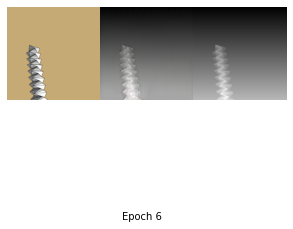

Epoch [7/50], Step [1/3750], D_loss: 0.1853, G_loss: 6.7375
Epoch [7/50], Step [2/3750], D_loss: 1.4845, G_loss: 4.5670
Epoch [7/50], Step [3/3750], D_loss: 0.2067, G_loss: 5.4491
Epoch [7/50], Step [4/3750], D_loss: 0.1134, G_loss: 8.6540
Epoch [7/50], Step [5/3750], D_loss: 0.1086, G_loss: 13.4889
Epoch [7/50], Step [6/3750], D_loss: 0.2879, G_loss: 3.9591
Epoch [7/50], Step [7/3750], D_loss: 0.2889, G_loss: 6.7497
Epoch [7/50], Step [8/3750], D_loss: 0.9546, G_loss: 20.0266
Epoch [7/50], Step [9/3750], D_loss: 0.2115, G_loss: 4.7803
Epoch [7/50], Step [10/3750], D_loss: 0.5395, G_loss: 4.4944
Epoch [7/50], Step [11/3750], D_loss: 0.5914, G_loss: 3.3253
Epoch [7/50], Step [12/3750], D_loss: 0.0089, G_loss: 10.3391
Epoch [7/50], Step [13/3750], D_loss: 0.2613, G_loss: 7.0283
Epoch [7/50], Step [14/3750], D_loss: 0.1253, G_loss: 7.8631
Epoch [7/50], Step [15/3750], D_loss: 0.3655, G_loss: 3.3213
Epoch [7/50], Step [16/3750], D_loss: 0.5366, G_loss: 9.8359
Epoch [7/50], Step [17/3750], 

Epoch [7/50], Step [135/3750], D_loss: 1.0183, G_loss: 6.1444
Epoch [7/50], Step [136/3750], D_loss: 0.4566, G_loss: 10.5125
Epoch [7/50], Step [137/3750], D_loss: 0.6689, G_loss: 4.1124
Epoch [7/50], Step [138/3750], D_loss: 1.2078, G_loss: 7.2504
Epoch [7/50], Step [139/3750], D_loss: 0.5668, G_loss: 4.0933
Epoch [7/50], Step [140/3750], D_loss: 0.9141, G_loss: 9.3588
Epoch [7/50], Step [141/3750], D_loss: 0.6101, G_loss: 3.8741
Epoch [7/50], Step [142/3750], D_loss: 0.7484, G_loss: 6.1725
Epoch [7/50], Step [143/3750], D_loss: 0.9526, G_loss: 4.1544
Epoch [7/50], Step [144/3750], D_loss: 0.5091, G_loss: 3.1399
Epoch [7/50], Step [145/3750], D_loss: 0.3986, G_loss: 8.8347
Epoch [7/50], Step [146/3750], D_loss: 0.5114, G_loss: 4.7641
Epoch [7/50], Step [147/3750], D_loss: 0.1996, G_loss: 7.5034
Epoch [7/50], Step [148/3750], D_loss: 0.6230, G_loss: 6.9823
Epoch [7/50], Step [149/3750], D_loss: 0.3472, G_loss: 13.0900
Epoch [7/50], Step [150/3750], D_loss: 0.4939, G_loss: 3.2093
Epoch 

Epoch [7/50], Step [267/3750], D_loss: 0.2949, G_loss: 8.6356
Epoch [7/50], Step [268/3750], D_loss: 0.4163, G_loss: 7.0701
Epoch [7/50], Step [269/3750], D_loss: 0.4631, G_loss: 5.8045
Epoch [7/50], Step [270/3750], D_loss: 0.2444, G_loss: 9.7257
Epoch [7/50], Step [271/3750], D_loss: 0.6328, G_loss: 7.3839
Epoch [7/50], Step [272/3750], D_loss: 0.2456, G_loss: 7.3322
Epoch [7/50], Step [273/3750], D_loss: 0.5944, G_loss: 5.6554
Epoch [7/50], Step [274/3750], D_loss: 0.2788, G_loss: 5.8506
Epoch [7/50], Step [275/3750], D_loss: 0.3641, G_loss: 2.9817
Epoch [7/50], Step [276/3750], D_loss: 0.2712, G_loss: 5.0331
Epoch [7/50], Step [277/3750], D_loss: 1.0853, G_loss: 6.3823
Epoch [7/50], Step [278/3750], D_loss: 0.1466, G_loss: 4.4930
Epoch [7/50], Step [279/3750], D_loss: 0.4473, G_loss: 6.9360
Epoch [7/50], Step [280/3750], D_loss: 0.7739, G_loss: 6.3142
Epoch [7/50], Step [281/3750], D_loss: 0.8831, G_loss: 4.2436
Epoch [7/50], Step [282/3750], D_loss: 0.4564, G_loss: 4.5409
Epoch [7

Epoch [7/50], Step [399/3750], D_loss: 0.3297, G_loss: 8.9015
Epoch [7/50], Step [400/3750], D_loss: 0.3570, G_loss: 6.7230
Epoch [7/50], Step [401/3750], D_loss: 0.2860, G_loss: 13.2406
Epoch [7/50], Step [402/3750], D_loss: 0.8670, G_loss: 9.0381
Epoch [7/50], Step [403/3750], D_loss: 1.0771, G_loss: 7.6867
Epoch [7/50], Step [404/3750], D_loss: 0.3372, G_loss: 7.5115
Epoch [7/50], Step [405/3750], D_loss: 0.6198, G_loss: 5.7212
Epoch [7/50], Step [406/3750], D_loss: 0.2724, G_loss: 6.4211
Epoch [7/50], Step [407/3750], D_loss: 0.4913, G_loss: 4.1030
Epoch [7/50], Step [408/3750], D_loss: 0.3400, G_loss: 9.4414
Epoch [7/50], Step [409/3750], D_loss: 0.1432, G_loss: 12.2826
Epoch [7/50], Step [410/3750], D_loss: 0.8096, G_loss: 5.8259
Epoch [7/50], Step [411/3750], D_loss: 0.1416, G_loss: 7.4209
Epoch [7/50], Step [412/3750], D_loss: 0.9217, G_loss: 5.9926
Epoch [7/50], Step [413/3750], D_loss: 0.4680, G_loss: 4.0262
Epoch [7/50], Step [414/3750], D_loss: 0.5106, G_loss: 5.5063
Epoch 

Epoch [7/50], Step [531/3750], D_loss: 0.0825, G_loss: 16.4855
Epoch [7/50], Step [532/3750], D_loss: 0.8026, G_loss: 3.0743
Epoch [7/50], Step [533/3750], D_loss: 0.1959, G_loss: 10.7541
Epoch [7/50], Step [534/3750], D_loss: 0.4136, G_loss: 4.0873
Epoch [7/50], Step [535/3750], D_loss: 0.1173, G_loss: 7.2920
Epoch [7/50], Step [536/3750], D_loss: 0.1772, G_loss: 3.1100
Epoch [7/50], Step [537/3750], D_loss: 0.5465, G_loss: 4.8639
Epoch [7/50], Step [538/3750], D_loss: 0.3104, G_loss: 7.0997
Epoch [7/50], Step [539/3750], D_loss: 0.4581, G_loss: 3.7982
Epoch [7/50], Step [540/3750], D_loss: 0.3513, G_loss: 7.4856
Epoch [7/50], Step [541/3750], D_loss: 0.1290, G_loss: 6.2443
Epoch [7/50], Step [542/3750], D_loss: 0.7339, G_loss: 5.5381
Epoch [7/50], Step [543/3750], D_loss: 0.4382, G_loss: 6.5625
Epoch [7/50], Step [544/3750], D_loss: 1.1989, G_loss: 3.8716
Epoch [7/50], Step [545/3750], D_loss: 0.6642, G_loss: 3.0139
Epoch [7/50], Step [546/3750], D_loss: 0.4202, G_loss: 5.7884
Epoch 

Epoch [7/50], Step [663/3750], D_loss: 0.1922, G_loss: 6.5281
Epoch [7/50], Step [664/3750], D_loss: 0.5869, G_loss: 8.0530
Epoch [7/50], Step [665/3750], D_loss: 0.2318, G_loss: 6.5799
Epoch [7/50], Step [666/3750], D_loss: 0.1699, G_loss: 9.6467
Epoch [7/50], Step [667/3750], D_loss: 0.5064, G_loss: 3.8758
Epoch [7/50], Step [668/3750], D_loss: 0.2585, G_loss: 8.9889
Epoch [7/50], Step [669/3750], D_loss: 0.6793, G_loss: 6.2365
Epoch [7/50], Step [670/3750], D_loss: 0.3680, G_loss: 5.8931
Epoch [7/50], Step [671/3750], D_loss: 0.5201, G_loss: 7.0072
Epoch [7/50], Step [672/3750], D_loss: 0.4797, G_loss: 7.2748
Epoch [7/50], Step [673/3750], D_loss: 0.1668, G_loss: 11.9507
Epoch [7/50], Step [674/3750], D_loss: 0.9340, G_loss: 6.4950
Epoch [7/50], Step [675/3750], D_loss: 1.1593, G_loss: 9.4337
Epoch [7/50], Step [676/3750], D_loss: 0.8047, G_loss: 4.3573
Epoch [7/50], Step [677/3750], D_loss: 0.7594, G_loss: 8.3679
Epoch [7/50], Step [678/3750], D_loss: 0.9003, G_loss: 3.7414
Epoch [

Epoch [7/50], Step [795/3750], D_loss: 0.0748, G_loss: 8.7547
Epoch [7/50], Step [796/3750], D_loss: 0.4455, G_loss: 3.7822
Epoch [7/50], Step [797/3750], D_loss: 0.1836, G_loss: 7.4388
Epoch [7/50], Step [798/3750], D_loss: 0.0714, G_loss: 8.2469
Epoch [7/50], Step [799/3750], D_loss: 0.4797, G_loss: 3.0585
Epoch [7/50], Step [800/3750], D_loss: 0.3455, G_loss: 4.9197
Epoch [7/50], Step [801/3750], D_loss: 0.3118, G_loss: 4.8693
Epoch [7/50], Step [802/3750], D_loss: 1.2699, G_loss: 4.3019
Epoch [7/50], Step [803/3750], D_loss: 0.8234, G_loss: 5.0730
Epoch [7/50], Step [804/3750], D_loss: 0.1009, G_loss: 4.0293
Epoch [7/50], Step [805/3750], D_loss: 0.1549, G_loss: 7.6189
Epoch [7/50], Step [806/3750], D_loss: 0.0292, G_loss: 10.0095
Epoch [7/50], Step [807/3750], D_loss: 0.2292, G_loss: 4.8093
Epoch [7/50], Step [808/3750], D_loss: 0.2528, G_loss: 6.7263
Epoch [7/50], Step [809/3750], D_loss: 0.3979, G_loss: 6.6027
Epoch [7/50], Step [810/3750], D_loss: 0.4497, G_loss: 6.3748
Epoch [

Epoch [7/50], Step [927/3750], D_loss: 0.1849, G_loss: 7.4192
Epoch [7/50], Step [928/3750], D_loss: 0.3398, G_loss: 5.1172
Epoch [7/50], Step [929/3750], D_loss: 0.0711, G_loss: 11.7641
Epoch [7/50], Step [930/3750], D_loss: 0.0877, G_loss: 8.3094
Epoch [7/50], Step [931/3750], D_loss: 0.3235, G_loss: 7.6743
Epoch [7/50], Step [932/3750], D_loss: 0.2884, G_loss: 3.8966
Epoch [7/50], Step [933/3750], D_loss: 0.1581, G_loss: 12.6985
Epoch [7/50], Step [934/3750], D_loss: 0.1095, G_loss: 9.4404
Epoch [7/50], Step [935/3750], D_loss: 0.6049, G_loss: 4.5492
Epoch [7/50], Step [936/3750], D_loss: 0.6708, G_loss: 2.8885
Epoch [7/50], Step [937/3750], D_loss: 0.3388, G_loss: 4.4956
Epoch [7/50], Step [938/3750], D_loss: 0.3505, G_loss: 9.9324
Epoch [7/50], Step [939/3750], D_loss: 1.0846, G_loss: 6.5476
Epoch [7/50], Step [940/3750], D_loss: 0.2941, G_loss: 4.4450
Epoch [7/50], Step [941/3750], D_loss: 0.2295, G_loss: 9.4183
Epoch [7/50], Step [942/3750], D_loss: 0.2858, G_loss: 8.4885
Epoch 

Epoch [7/50], Step [1058/3750], D_loss: 0.1739, G_loss: 7.3179
Epoch [7/50], Step [1059/3750], D_loss: 0.1767, G_loss: 6.2611
Epoch [7/50], Step [1060/3750], D_loss: 0.4351, G_loss: 7.9195
Epoch [7/50], Step [1061/3750], D_loss: 0.0829, G_loss: 8.3185
Epoch [7/50], Step [1062/3750], D_loss: 0.2994, G_loss: 9.2104
Epoch [7/50], Step [1063/3750], D_loss: 0.3166, G_loss: 6.4775
Epoch [7/50], Step [1064/3750], D_loss: 0.2749, G_loss: 10.3452
Epoch [7/50], Step [1065/3750], D_loss: 0.2208, G_loss: 5.5700
Epoch [7/50], Step [1066/3750], D_loss: 0.0569, G_loss: 11.7525
Epoch [7/50], Step [1067/3750], D_loss: 0.5245, G_loss: 8.5948
Epoch [7/50], Step [1068/3750], D_loss: 0.3802, G_loss: 5.6264
Epoch [7/50], Step [1069/3750], D_loss: 0.1057, G_loss: 6.0842
Epoch [7/50], Step [1070/3750], D_loss: 0.4290, G_loss: 6.0981
Epoch [7/50], Step [1071/3750], D_loss: 0.2541, G_loss: 9.4262
Epoch [7/50], Step [1072/3750], D_loss: 0.5919, G_loss: 10.1643
Epoch [7/50], Step [1073/3750], D_loss: 0.1011, G_lo

Epoch [7/50], Step [1188/3750], D_loss: 0.7769, G_loss: 10.2346
Epoch [7/50], Step [1189/3750], D_loss: 0.3328, G_loss: 11.0571
Epoch [7/50], Step [1190/3750], D_loss: 0.3616, G_loss: 6.0465
Epoch [7/50], Step [1191/3750], D_loss: 0.3044, G_loss: 6.1783
Epoch [7/50], Step [1192/3750], D_loss: 0.1230, G_loss: 11.3657
Epoch [7/50], Step [1193/3750], D_loss: 0.7992, G_loss: 6.7034
Epoch [7/50], Step [1194/3750], D_loss: 0.5115, G_loss: 5.4381
Epoch [7/50], Step [1195/3750], D_loss: 0.4295, G_loss: 6.9968
Epoch [7/50], Step [1196/3750], D_loss: 0.1900, G_loss: 12.9162
Epoch [7/50], Step [1197/3750], D_loss: 0.3501, G_loss: 6.8906
Epoch [7/50], Step [1198/3750], D_loss: 0.1773, G_loss: 7.6756
Epoch [7/50], Step [1199/3750], D_loss: 0.6695, G_loss: 5.4581
Epoch [7/50], Step [1200/3750], D_loss: 0.6140, G_loss: 8.1363
Epoch [7/50], Step [1201/3750], D_loss: 0.1828, G_loss: 5.1266
Epoch [7/50], Step [1202/3750], D_loss: 0.5632, G_loss: 4.1070
Epoch [7/50], Step [1203/3750], D_loss: 0.8761, G_l

Epoch [7/50], Step [1318/3750], D_loss: 0.3609, G_loss: 4.3980
Epoch [7/50], Step [1319/3750], D_loss: 0.7747, G_loss: 4.8711
Epoch [7/50], Step [1320/3750], D_loss: 0.3914, G_loss: 4.3454
Epoch [7/50], Step [1321/3750], D_loss: 0.2949, G_loss: 9.0929
Epoch [7/50], Step [1322/3750], D_loss: 0.1999, G_loss: 13.3213
Epoch [7/50], Step [1323/3750], D_loss: 0.3698, G_loss: 6.8072
Epoch [7/50], Step [1324/3750], D_loss: 0.6098, G_loss: 7.3016
Epoch [7/50], Step [1325/3750], D_loss: 0.4065, G_loss: 4.8657
Epoch [7/50], Step [1326/3750], D_loss: 0.1799, G_loss: 5.5704
Epoch [7/50], Step [1327/3750], D_loss: 0.1076, G_loss: 8.0221
Epoch [7/50], Step [1328/3750], D_loss: 0.3480, G_loss: 14.7506
Epoch [7/50], Step [1329/3750], D_loss: 0.6328, G_loss: 5.7996
Epoch [7/50], Step [1330/3750], D_loss: 0.6929, G_loss: 6.4698
Epoch [7/50], Step [1331/3750], D_loss: 0.5698, G_loss: 4.7480
Epoch [7/50], Step [1332/3750], D_loss: 0.5429, G_loss: 7.6017
Epoch [7/50], Step [1333/3750], D_loss: 0.6809, G_los

Epoch [7/50], Step [1448/3750], D_loss: 0.1867, G_loss: 5.5121
Epoch [7/50], Step [1449/3750], D_loss: 0.7281, G_loss: 10.5236
Epoch [7/50], Step [1450/3750], D_loss: 0.6418, G_loss: 4.4283
Epoch [7/50], Step [1451/3750], D_loss: 0.5184, G_loss: 3.5466
Epoch [7/50], Step [1452/3750], D_loss: 0.4676, G_loss: 4.6849
Epoch [7/50], Step [1453/3750], D_loss: 0.7287, G_loss: 5.9809
Epoch [7/50], Step [1454/3750], D_loss: 0.5793, G_loss: 6.0116
Epoch [7/50], Step [1455/3750], D_loss: 0.6671, G_loss: 4.8749
Epoch [7/50], Step [1456/3750], D_loss: 0.5445, G_loss: 3.5630
Epoch [7/50], Step [1457/3750], D_loss: 0.0811, G_loss: 12.2254
Epoch [7/50], Step [1458/3750], D_loss: 0.2750, G_loss: 9.4732
Epoch [7/50], Step [1459/3750], D_loss: 0.5576, G_loss: 10.0073
Epoch [7/50], Step [1460/3750], D_loss: 0.1652, G_loss: 9.2142
Epoch [7/50], Step [1461/3750], D_loss: 0.4636, G_loss: 5.3501
Epoch [7/50], Step [1462/3750], D_loss: 0.3469, G_loss: 5.0174
Epoch [7/50], Step [1463/3750], D_loss: 0.1717, G_lo

Epoch [7/50], Step [1578/3750], D_loss: 0.2482, G_loss: 8.9701
Epoch [7/50], Step [1579/3750], D_loss: 0.6163, G_loss: 4.0999
Epoch [7/50], Step [1580/3750], D_loss: 0.1508, G_loss: 11.5115
Epoch [7/50], Step [1581/3750], D_loss: 0.2438, G_loss: 8.2181
Epoch [7/50], Step [1582/3750], D_loss: 0.5036, G_loss: 5.8363
Epoch [7/50], Step [1583/3750], D_loss: 0.2275, G_loss: 6.0101
Epoch [7/50], Step [1584/3750], D_loss: 0.2366, G_loss: 5.0929
Epoch [7/50], Step [1585/3750], D_loss: 0.1698, G_loss: 5.2989
Epoch [7/50], Step [1586/3750], D_loss: 0.1585, G_loss: 13.9378
Epoch [7/50], Step [1587/3750], D_loss: 1.2751, G_loss: 4.5699
Epoch [7/50], Step [1588/3750], D_loss: 0.1589, G_loss: 4.7989
Epoch [7/50], Step [1589/3750], D_loss: 0.1153, G_loss: 8.6585
Epoch [7/50], Step [1590/3750], D_loss: 0.0307, G_loss: 10.7554
Epoch [7/50], Step [1591/3750], D_loss: 0.4097, G_loss: 5.9565
Epoch [7/50], Step [1592/3750], D_loss: 0.1150, G_loss: 9.7914
Epoch [7/50], Step [1593/3750], D_loss: 0.3805, G_lo

Epoch [7/50], Step [1708/3750], D_loss: 0.4516, G_loss: 4.5498
Epoch [7/50], Step [1709/3750], D_loss: 0.6646, G_loss: 4.8372
Epoch [7/50], Step [1710/3750], D_loss: 0.4924, G_loss: 3.1448
Epoch [7/50], Step [1711/3750], D_loss: 0.0233, G_loss: 7.9796
Epoch [7/50], Step [1712/3750], D_loss: 0.2259, G_loss: 9.7206
Epoch [7/50], Step [1713/3750], D_loss: 0.2865, G_loss: 4.8620
Epoch [7/50], Step [1714/3750], D_loss: 0.8074, G_loss: 5.5717
Epoch [7/50], Step [1715/3750], D_loss: 0.2812, G_loss: 4.4372
Epoch [7/50], Step [1716/3750], D_loss: 0.0813, G_loss: 15.8715
Epoch [7/50], Step [1717/3750], D_loss: 0.4694, G_loss: 6.7551
Epoch [7/50], Step [1718/3750], D_loss: 0.2194, G_loss: 8.1717
Epoch [7/50], Step [1719/3750], D_loss: 0.1981, G_loss: 11.4197
Epoch [7/50], Step [1720/3750], D_loss: 0.3701, G_loss: 6.7787
Epoch [7/50], Step [1721/3750], D_loss: 0.3944, G_loss: 4.5309
Epoch [7/50], Step [1722/3750], D_loss: 1.1010, G_loss: 4.8690
Epoch [7/50], Step [1723/3750], D_loss: 0.2889, G_los

Epoch [7/50], Step [1838/3750], D_loss: 0.2864, G_loss: 7.0548
Epoch [7/50], Step [1839/3750], D_loss: 0.1500, G_loss: 12.5029
Epoch [7/50], Step [1840/3750], D_loss: 0.4792, G_loss: 4.8756
Epoch [7/50], Step [1841/3750], D_loss: 0.2102, G_loss: 8.6012
Epoch [7/50], Step [1842/3750], D_loss: 0.1148, G_loss: 9.1379
Epoch [7/50], Step [1843/3750], D_loss: 0.3074, G_loss: 10.3951
Epoch [7/50], Step [1844/3750], D_loss: 0.0921, G_loss: 5.7923
Epoch [7/50], Step [1845/3750], D_loss: 0.3523, G_loss: 8.5368
Epoch [7/50], Step [1846/3750], D_loss: 0.0930, G_loss: 27.4711
Epoch [7/50], Step [1847/3750], D_loss: 0.0891, G_loss: 5.3626
Epoch [7/50], Step [1848/3750], D_loss: 0.6503, G_loss: 7.4273
Epoch [7/50], Step [1849/3750], D_loss: 0.2834, G_loss: 8.1708
Epoch [7/50], Step [1850/3750], D_loss: 0.3266, G_loss: 8.9503
Epoch [7/50], Step [1851/3750], D_loss: 0.3779, G_loss: 7.0044
Epoch [7/50], Step [1852/3750], D_loss: 0.0294, G_loss: 7.6714
Epoch [7/50], Step [1853/3750], D_loss: 1.1298, G_lo

Epoch [7/50], Step [1968/3750], D_loss: 0.0759, G_loss: 9.7574
Epoch [7/50], Step [1969/3750], D_loss: 0.0532, G_loss: 10.8417
Epoch [7/50], Step [1970/3750], D_loss: 0.2709, G_loss: 9.9892
Epoch [7/50], Step [1971/3750], D_loss: 0.1961, G_loss: 7.0689
Epoch [7/50], Step [1972/3750], D_loss: 0.4050, G_loss: 4.0373
Epoch [7/50], Step [1973/3750], D_loss: 0.3217, G_loss: 6.1647
Epoch [7/50], Step [1974/3750], D_loss: 0.5025, G_loss: 3.8638
Epoch [7/50], Step [1975/3750], D_loss: 0.7066, G_loss: 6.2415
Epoch [7/50], Step [1976/3750], D_loss: 0.3506, G_loss: 4.7209
Epoch [7/50], Step [1977/3750], D_loss: 0.0155, G_loss: 14.4984
Epoch [7/50], Step [1978/3750], D_loss: 0.5350, G_loss: 2.6973
Epoch [7/50], Step [1979/3750], D_loss: 0.3043, G_loss: 5.6240
Epoch [7/50], Step [1980/3750], D_loss: 0.1717, G_loss: 10.9662
Epoch [7/50], Step [1981/3750], D_loss: 1.0159, G_loss: 3.5412
Epoch [7/50], Step [1982/3750], D_loss: 0.3343, G_loss: 7.5698
Epoch [7/50], Step [1983/3750], D_loss: 0.2131, G_lo

Epoch [7/50], Step [2098/3750], D_loss: 0.1645, G_loss: 9.5446
Epoch [7/50], Step [2099/3750], D_loss: 0.0441, G_loss: 8.1237
Epoch [7/50], Step [2100/3750], D_loss: 0.1778, G_loss: 5.8333
Epoch [7/50], Step [2101/3750], D_loss: 0.4200, G_loss: 3.0738
Epoch [7/50], Step [2102/3750], D_loss: 0.6854, G_loss: 8.5872
Epoch [7/50], Step [2103/3750], D_loss: 0.0112, G_loss: 11.8761
Epoch [7/50], Step [2104/3750], D_loss: 0.0965, G_loss: 3.4289
Epoch [7/50], Step [2105/3750], D_loss: 0.0367, G_loss: 8.1207
Epoch [7/50], Step [2106/3750], D_loss: 0.2237, G_loss: 12.3108
Epoch [7/50], Step [2107/3750], D_loss: 0.4067, G_loss: 7.5100
Epoch [7/50], Step [2108/3750], D_loss: 0.1304, G_loss: 12.7845
Epoch [7/50], Step [2109/3750], D_loss: 0.1691, G_loss: 6.8294
Epoch [7/50], Step [2110/3750], D_loss: 0.3221, G_loss: 7.9985
Epoch [7/50], Step [2111/3750], D_loss: 0.1575, G_loss: 9.5039
Epoch [7/50], Step [2112/3750], D_loss: 0.3417, G_loss: 11.5037
Epoch [7/50], Step [2113/3750], D_loss: 0.2003, G_l

Epoch [7/50], Step [2228/3750], D_loss: 0.5594, G_loss: 4.6004
Epoch [7/50], Step [2229/3750], D_loss: 0.4902, G_loss: 14.4165
Epoch [7/50], Step [2230/3750], D_loss: 0.1297, G_loss: 8.3954
Epoch [7/50], Step [2231/3750], D_loss: 0.3413, G_loss: 31.9464
Epoch [7/50], Step [2232/3750], D_loss: 0.6696, G_loss: 8.4034
Epoch [7/50], Step [2233/3750], D_loss: 0.2577, G_loss: 18.7691
Epoch [7/50], Step [2234/3750], D_loss: 0.8773, G_loss: 4.1377
Epoch [7/50], Step [2235/3750], D_loss: 0.2515, G_loss: 4.8927
Epoch [7/50], Step [2236/3750], D_loss: 0.6386, G_loss: 5.2622
Epoch [7/50], Step [2237/3750], D_loss: 0.3216, G_loss: 4.3590
Epoch [7/50], Step [2238/3750], D_loss: 0.3574, G_loss: 3.7101
Epoch [7/50], Step [2239/3750], D_loss: 0.3489, G_loss: 3.3399
Epoch [7/50], Step [2240/3750], D_loss: 0.3735, G_loss: 5.8331
Epoch [7/50], Step [2241/3750], D_loss: 0.1160, G_loss: 14.5479
Epoch [7/50], Step [2242/3750], D_loss: 0.0859, G_loss: 12.9819
Epoch [7/50], Step [2243/3750], D_loss: 0.7169, G_

Epoch [7/50], Step [2358/3750], D_loss: 0.3851, G_loss: 11.9346
Epoch [7/50], Step [2359/3750], D_loss: 0.3217, G_loss: 7.0448
Epoch [7/50], Step [2360/3750], D_loss: 0.1345, G_loss: 11.5454
Epoch [7/50], Step [2361/3750], D_loss: 0.1628, G_loss: 11.8601
Epoch [7/50], Step [2362/3750], D_loss: 0.1078, G_loss: 8.3053
Epoch [7/50], Step [2363/3750], D_loss: 0.1318, G_loss: 6.5129
Epoch [7/50], Step [2364/3750], D_loss: 0.1006, G_loss: 6.8093
Epoch [7/50], Step [2365/3750], D_loss: 0.7077, G_loss: 8.8129
Epoch [7/50], Step [2366/3750], D_loss: 1.1833, G_loss: 7.7643
Epoch [7/50], Step [2367/3750], D_loss: 0.4464, G_loss: 3.1654
Epoch [7/50], Step [2368/3750], D_loss: 0.2118, G_loss: 4.2954
Epoch [7/50], Step [2369/3750], D_loss: 0.3008, G_loss: 8.3715
Epoch [7/50], Step [2370/3750], D_loss: 0.5797, G_loss: 9.0321
Epoch [7/50], Step [2371/3750], D_loss: 0.5630, G_loss: 10.9367
Epoch [7/50], Step [2372/3750], D_loss: 0.0953, G_loss: 4.4076
Epoch [7/50], Step [2373/3750], D_loss: 0.3146, G_l

Epoch [7/50], Step [2488/3750], D_loss: 0.6442, G_loss: 12.3482
Epoch [7/50], Step [2489/3750], D_loss: 0.2149, G_loss: 14.1313
Epoch [7/50], Step [2490/3750], D_loss: 0.5764, G_loss: 3.9791
Epoch [7/50], Step [2491/3750], D_loss: 0.0193, G_loss: 18.3489
Epoch [7/50], Step [2492/3750], D_loss: 0.0320, G_loss: 15.0905
Epoch [7/50], Step [2493/3750], D_loss: 0.0635, G_loss: 10.7354
Epoch [7/50], Step [2494/3750], D_loss: 0.3892, G_loss: 5.2097
Epoch [7/50], Step [2495/3750], D_loss: 0.2207, G_loss: 6.1634
Epoch [7/50], Step [2496/3750], D_loss: 0.4111, G_loss: 4.1435
Epoch [7/50], Step [2497/3750], D_loss: 0.7071, G_loss: 5.4302
Epoch [7/50], Step [2498/3750], D_loss: 0.0886, G_loss: 13.0022
Epoch [7/50], Step [2499/3750], D_loss: 0.9917, G_loss: 10.5223
Epoch [7/50], Step [2500/3750], D_loss: 0.0637, G_loss: 8.0988
Epoch [7/50], Step [2501/3750], D_loss: 1.2208, G_loss: 4.9956
Epoch [7/50], Step [2502/3750], D_loss: 0.4989, G_loss: 5.7392
Epoch [7/50], Step [2503/3750], D_loss: 0.3122, 

Epoch [7/50], Step [2618/3750], D_loss: 0.0701, G_loss: 15.8395
Epoch [7/50], Step [2619/3750], D_loss: 0.5992, G_loss: 3.2867
Epoch [7/50], Step [2620/3750], D_loss: 0.0386, G_loss: 58.0670
Epoch [7/50], Step [2621/3750], D_loss: 0.0953, G_loss: 7.9139
Epoch [7/50], Step [2622/3750], D_loss: 0.1936, G_loss: 3.8764
Epoch [7/50], Step [2623/3750], D_loss: 0.2199, G_loss: 5.7059
Epoch [7/50], Step [2624/3750], D_loss: 0.2451, G_loss: 9.0207
Epoch [7/50], Step [2625/3750], D_loss: 0.1613, G_loss: 10.3321
Epoch [7/50], Step [2626/3750], D_loss: 0.4871, G_loss: 4.5029
Epoch [7/50], Step [2627/3750], D_loss: 0.4830, G_loss: 4.7214
Epoch [7/50], Step [2628/3750], D_loss: 0.0878, G_loss: 5.8995
Epoch [7/50], Step [2629/3750], D_loss: 0.0840, G_loss: 7.5589
Epoch [7/50], Step [2630/3750], D_loss: 0.0516, G_loss: 8.3421
Epoch [7/50], Step [2631/3750], D_loss: 0.3251, G_loss: 8.5879
Epoch [7/50], Step [2632/3750], D_loss: 0.6454, G_loss: 4.4982
Epoch [7/50], Step [2633/3750], D_loss: 0.0158, G_lo

Epoch [7/50], Step [2748/3750], D_loss: 0.0407, G_loss: 11.5633
Epoch [7/50], Step [2749/3750], D_loss: 0.0791, G_loss: 10.8242
Epoch [7/50], Step [2750/3750], D_loss: 0.2775, G_loss: 7.4172
Epoch [7/50], Step [2751/3750], D_loss: 0.1682, G_loss: 5.1592
Epoch [7/50], Step [2752/3750], D_loss: 0.4164, G_loss: 3.9490
Epoch [7/50], Step [2753/3750], D_loss: 0.3784, G_loss: 5.4054
Epoch [7/50], Step [2754/3750], D_loss: 0.2651, G_loss: 5.0191
Epoch [7/50], Step [2755/3750], D_loss: 0.4998, G_loss: 3.9360
Epoch [7/50], Step [2756/3750], D_loss: 0.6157, G_loss: 2.5972
Epoch [7/50], Step [2757/3750], D_loss: 0.2981, G_loss: 10.9255
Epoch [7/50], Step [2758/3750], D_loss: 0.7619, G_loss: 3.5392
Epoch [7/50], Step [2759/3750], D_loss: 0.4460, G_loss: 5.9156
Epoch [7/50], Step [2760/3750], D_loss: 0.2931, G_loss: 6.6787
Epoch [7/50], Step [2761/3750], D_loss: 1.1036, G_loss: 7.6032
Epoch [7/50], Step [2762/3750], D_loss: 0.5750, G_loss: 4.5538
Epoch [7/50], Step [2763/3750], D_loss: 0.5006, G_lo

Epoch [7/50], Step [2878/3750], D_loss: 0.5719, G_loss: 6.1164
Epoch [7/50], Step [2879/3750], D_loss: 0.6507, G_loss: 9.4207
Epoch [7/50], Step [2880/3750], D_loss: 0.1144, G_loss: 15.4516
Epoch [7/50], Step [2881/3750], D_loss: 0.4287, G_loss: 9.9784
Epoch [7/50], Step [2882/3750], D_loss: 0.6953, G_loss: 2.1221
Epoch [7/50], Step [2883/3750], D_loss: 0.5041, G_loss: 5.5361
Epoch [7/50], Step [2884/3750], D_loss: 0.6697, G_loss: 4.5321
Epoch [7/50], Step [2885/3750], D_loss: 0.3441, G_loss: 10.0319
Epoch [7/50], Step [2886/3750], D_loss: 0.3032, G_loss: 12.9931
Epoch [7/50], Step [2887/3750], D_loss: 0.3753, G_loss: 12.3287
Epoch [7/50], Step [2888/3750], D_loss: 0.7663, G_loss: 2.8895
Epoch [7/50], Step [2889/3750], D_loss: 0.3934, G_loss: 5.3559
Epoch [7/50], Step [2890/3750], D_loss: 0.4783, G_loss: 12.9437
Epoch [7/50], Step [2891/3750], D_loss: 0.5056, G_loss: 7.7554
Epoch [7/50], Step [2892/3750], D_loss: 0.4364, G_loss: 4.9709
Epoch [7/50], Step [2893/3750], D_loss: 0.0760, G_

Epoch [7/50], Step [3008/3750], D_loss: 0.1704, G_loss: 11.0138
Epoch [7/50], Step [3009/3750], D_loss: 0.5397, G_loss: 6.9095
Epoch [7/50], Step [3010/3750], D_loss: 0.3206, G_loss: 4.3670
Epoch [7/50], Step [3011/3750], D_loss: 0.2997, G_loss: 6.3344
Epoch [7/50], Step [3012/3750], D_loss: 0.3056, G_loss: 6.1816
Epoch [7/50], Step [3013/3750], D_loss: 0.2942, G_loss: 7.9291
Epoch [7/50], Step [3014/3750], D_loss: 0.2754, G_loss: 5.5073
Epoch [7/50], Step [3015/3750], D_loss: 0.7876, G_loss: 3.6948
Epoch [7/50], Step [3016/3750], D_loss: 0.5639, G_loss: 10.2959
Epoch [7/50], Step [3017/3750], D_loss: 0.8240, G_loss: 4.1651
Epoch [7/50], Step [3018/3750], D_loss: 0.1817, G_loss: 10.1750
Epoch [7/50], Step [3019/3750], D_loss: 0.6731, G_loss: 6.4607
Epoch [7/50], Step [3020/3750], D_loss: 0.1260, G_loss: 8.0748
Epoch [7/50], Step [3021/3750], D_loss: 0.2059, G_loss: 7.4145
Epoch [7/50], Step [3022/3750], D_loss: 0.6317, G_loss: 8.6974
Epoch [7/50], Step [3023/3750], D_loss: 0.8604, G_lo

Epoch [7/50], Step [3138/3750], D_loss: 0.1350, G_loss: 5.3561
Epoch [7/50], Step [3139/3750], D_loss: 0.3038, G_loss: 3.4094
Epoch [7/50], Step [3140/3750], D_loss: 0.0958, G_loss: 10.9802
Epoch [7/50], Step [3141/3750], D_loss: 1.0743, G_loss: 3.3263
Epoch [7/50], Step [3142/3750], D_loss: 0.7137, G_loss: 7.1756
Epoch [7/50], Step [3143/3750], D_loss: 0.1514, G_loss: 11.7267
Epoch [7/50], Step [3144/3750], D_loss: 0.4477, G_loss: 4.8635
Epoch [7/50], Step [3145/3750], D_loss: 0.6236, G_loss: 5.5050
Epoch [7/50], Step [3146/3750], D_loss: 0.0897, G_loss: 12.9036
Epoch [7/50], Step [3147/3750], D_loss: 0.1711, G_loss: 8.0556
Epoch [7/50], Step [3148/3750], D_loss: 0.0818, G_loss: 6.3593
Epoch [7/50], Step [3149/3750], D_loss: 0.5228, G_loss: 6.3681
Epoch [7/50], Step [3150/3750], D_loss: 0.4435, G_loss: 4.6915
Epoch [7/50], Step [3151/3750], D_loss: 0.3420, G_loss: 13.0796
Epoch [7/50], Step [3152/3750], D_loss: 0.2589, G_loss: 6.6977
Epoch [7/50], Step [3153/3750], D_loss: 0.2202, G_l

Epoch [7/50], Step [3268/3750], D_loss: 0.4475, G_loss: 8.3154
Epoch [7/50], Step [3269/3750], D_loss: 0.1037, G_loss: 8.1653
Epoch [7/50], Step [3270/3750], D_loss: 0.2187, G_loss: 5.3575
Epoch [7/50], Step [3271/3750], D_loss: 0.0667, G_loss: 11.1103
Epoch [7/50], Step [3272/3750], D_loss: 0.1748, G_loss: 6.2012
Epoch [7/50], Step [3273/3750], D_loss: 0.2520, G_loss: 4.2243
Epoch [7/50], Step [3274/3750], D_loss: 0.5604, G_loss: 9.7408
Epoch [7/50], Step [3275/3750], D_loss: 0.2305, G_loss: 5.7912
Epoch [7/50], Step [3276/3750], D_loss: 0.1630, G_loss: 12.3381
Epoch [7/50], Step [3277/3750], D_loss: 0.3328, G_loss: 3.8804
Epoch [7/50], Step [3278/3750], D_loss: 0.0844, G_loss: 7.4781
Epoch [7/50], Step [3279/3750], D_loss: 0.3699, G_loss: 5.4160
Epoch [7/50], Step [3280/3750], D_loss: 0.2350, G_loss: 8.0212
Epoch [7/50], Step [3281/3750], D_loss: 0.1848, G_loss: 4.2280
Epoch [7/50], Step [3282/3750], D_loss: 0.0775, G_loss: 6.9148
Epoch [7/50], Step [3283/3750], D_loss: 0.2026, G_los

Epoch [7/50], Step [3398/3750], D_loss: 0.3427, G_loss: 6.2590
Epoch [7/50], Step [3399/3750], D_loss: 0.3439, G_loss: 13.5923
Epoch [7/50], Step [3400/3750], D_loss: 0.3626, G_loss: 3.2174
Epoch [7/50], Step [3401/3750], D_loss: 0.4132, G_loss: 12.5642
Epoch [7/50], Step [3402/3750], D_loss: 0.7800, G_loss: 7.1386
Epoch [7/50], Step [3403/3750], D_loss: 0.4968, G_loss: 9.6611
Epoch [7/50], Step [3404/3750], D_loss: 0.2546, G_loss: 6.4305
Epoch [7/50], Step [3405/3750], D_loss: 0.4722, G_loss: 7.6517
Epoch [7/50], Step [3406/3750], D_loss: 0.3678, G_loss: 3.7452
Epoch [7/50], Step [3407/3750], D_loss: 0.0966, G_loss: 9.0336
Epoch [7/50], Step [3408/3750], D_loss: 0.7175, G_loss: 5.4268
Epoch [7/50], Step [3409/3750], D_loss: 0.3814, G_loss: 7.1081
Epoch [7/50], Step [3410/3750], D_loss: 0.4867, G_loss: 6.9169
Epoch [7/50], Step [3411/3750], D_loss: 0.2044, G_loss: 5.0901
Epoch [7/50], Step [3412/3750], D_loss: 0.3042, G_loss: 14.4749
Epoch [7/50], Step [3413/3750], D_loss: 0.2876, G_lo

Epoch [7/50], Step [3528/3750], D_loss: 0.1938, G_loss: 7.0383
Epoch [7/50], Step [3529/3750], D_loss: 0.0428, G_loss: 12.4474
Epoch [7/50], Step [3530/3750], D_loss: 0.2714, G_loss: 7.6608
Epoch [7/50], Step [3531/3750], D_loss: 0.4636, G_loss: 3.9759
Epoch [7/50], Step [3532/3750], D_loss: 0.0709, G_loss: 12.0217
Epoch [7/50], Step [3533/3750], D_loss: 0.1897, G_loss: 6.4711
Epoch [7/50], Step [3534/3750], D_loss: 1.3279, G_loss: 6.5799
Epoch [7/50], Step [3535/3750], D_loss: 0.3008, G_loss: 4.4694
Epoch [7/50], Step [3536/3750], D_loss: 0.5337, G_loss: 6.7175
Epoch [7/50], Step [3537/3750], D_loss: 0.7150, G_loss: 4.0268
Epoch [7/50], Step [3538/3750], D_loss: 0.2096, G_loss: 8.9883
Epoch [7/50], Step [3539/3750], D_loss: 0.3660, G_loss: 5.7388
Epoch [7/50], Step [3540/3750], D_loss: 0.1552, G_loss: 10.6873
Epoch [7/50], Step [3541/3750], D_loss: 0.0958, G_loss: 13.2280
Epoch [7/50], Step [3542/3750], D_loss: 0.2056, G_loss: 9.5689
Epoch [7/50], Step [3543/3750], D_loss: 1.0969, G_l

Epoch [7/50], Step [3658/3750], D_loss: 0.1281, G_loss: 6.9628
Epoch [7/50], Step [3659/3750], D_loss: 0.4311, G_loss: 7.8155
Epoch [7/50], Step [3660/3750], D_loss: 0.3401, G_loss: 4.3459
Epoch [7/50], Step [3661/3750], D_loss: 0.2353, G_loss: 4.9270
Epoch [7/50], Step [3662/3750], D_loss: 0.1936, G_loss: 4.4665
Epoch [7/50], Step [3663/3750], D_loss: 0.5872, G_loss: 4.8004
Epoch [7/50], Step [3664/3750], D_loss: 0.2118, G_loss: 13.0748
Epoch [7/50], Step [3665/3750], D_loss: 0.4682, G_loss: 4.8734
Epoch [7/50], Step [3666/3750], D_loss: 0.2797, G_loss: 11.7458
Epoch [7/50], Step [3667/3750], D_loss: 0.2275, G_loss: 5.5584
Epoch [7/50], Step [3668/3750], D_loss: 0.0443, G_loss: 10.4996
Epoch [7/50], Step [3669/3750], D_loss: 0.1332, G_loss: 22.2182
Epoch [7/50], Step [3670/3750], D_loss: 0.2681, G_loss: 8.9949
Epoch [7/50], Step [3671/3750], D_loss: 0.3543, G_loss: 4.9567
Epoch [7/50], Step [3672/3750], D_loss: 0.6891, G_loss: 6.2760
Epoch [7/50], Step [3673/3750], D_loss: 0.1223, G_l

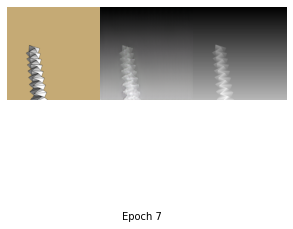

Epoch [8/50], Step [1/3750], D_loss: 0.2057, G_loss: 9.4361
Epoch [8/50], Step [2/3750], D_loss: 0.5650, G_loss: 6.7222
Epoch [8/50], Step [3/3750], D_loss: 0.6673, G_loss: 3.1054
Epoch [8/50], Step [4/3750], D_loss: 0.7362, G_loss: 4.2943
Epoch [8/50], Step [5/3750], D_loss: 0.1375, G_loss: 5.6188
Epoch [8/50], Step [6/3750], D_loss: 0.2535, G_loss: 10.6174
Epoch [8/50], Step [7/3750], D_loss: 0.3912, G_loss: 6.2231
Epoch [8/50], Step [8/3750], D_loss: 0.1352, G_loss: 5.8903
Epoch [8/50], Step [9/3750], D_loss: 0.2307, G_loss: 8.5780
Epoch [8/50], Step [10/3750], D_loss: 0.1554, G_loss: 8.7067
Epoch [8/50], Step [11/3750], D_loss: 0.1857, G_loss: 11.2769
Epoch [8/50], Step [12/3750], D_loss: 0.4346, G_loss: 6.6519
Epoch [8/50], Step [13/3750], D_loss: 0.5270, G_loss: 7.0016
Epoch [8/50], Step [14/3750], D_loss: 0.7746, G_loss: 2.3697
Epoch [8/50], Step [15/3750], D_loss: 0.4925, G_loss: 6.1633
Epoch [8/50], Step [16/3750], D_loss: 0.3434, G_loss: 23.7751
Epoch [8/50], Step [17/3750], 

Epoch [8/50], Step [135/3750], D_loss: 0.2673, G_loss: 6.2985
Epoch [8/50], Step [136/3750], D_loss: 0.1549, G_loss: 9.1357
Epoch [8/50], Step [137/3750], D_loss: 0.3757, G_loss: 7.1199
Epoch [8/50], Step [138/3750], D_loss: 0.3508, G_loss: 4.7217
Epoch [8/50], Step [139/3750], D_loss: 0.3247, G_loss: 4.5642
Epoch [8/50], Step [140/3750], D_loss: 0.1832, G_loss: 4.4024
Epoch [8/50], Step [141/3750], D_loss: 0.1384, G_loss: 16.0946
Epoch [8/50], Step [142/3750], D_loss: 0.1335, G_loss: 9.5781
Epoch [8/50], Step [143/3750], D_loss: 0.1203, G_loss: 10.7233
Epoch [8/50], Step [144/3750], D_loss: 0.5288, G_loss: 3.7250
Epoch [8/50], Step [145/3750], D_loss: 0.1236, G_loss: 5.7156
Epoch [8/50], Step [146/3750], D_loss: 0.6082, G_loss: 3.8157
Epoch [8/50], Step [147/3750], D_loss: 0.2410, G_loss: 3.8509
Epoch [8/50], Step [148/3750], D_loss: 0.3112, G_loss: 4.5081
Epoch [8/50], Step [149/3750], D_loss: 0.2776, G_loss: 3.3259
Epoch [8/50], Step [150/3750], D_loss: 0.5629, G_loss: 6.0466
Epoch 

Epoch [8/50], Step [267/3750], D_loss: 0.2343, G_loss: 13.0195
Epoch [8/50], Step [268/3750], D_loss: 0.1270, G_loss: 3.9545
Epoch [8/50], Step [269/3750], D_loss: 0.1318, G_loss: 10.6745
Epoch [8/50], Step [270/3750], D_loss: 0.1735, G_loss: 9.7360
Epoch [8/50], Step [271/3750], D_loss: 0.1801, G_loss: 11.7137
Epoch [8/50], Step [272/3750], D_loss: 0.3224, G_loss: 5.1258
Epoch [8/50], Step [273/3750], D_loss: 0.0594, G_loss: 6.5138
Epoch [8/50], Step [274/3750], D_loss: 0.1227, G_loss: 7.7791
Epoch [8/50], Step [275/3750], D_loss: 0.0827, G_loss: 10.4227
Epoch [8/50], Step [276/3750], D_loss: 0.1422, G_loss: 5.7672
Epoch [8/50], Step [277/3750], D_loss: 0.1465, G_loss: 8.3264
Epoch [8/50], Step [278/3750], D_loss: 0.2645, G_loss: 4.3740
Epoch [8/50], Step [279/3750], D_loss: 0.1645, G_loss: 13.8515
Epoch [8/50], Step [280/3750], D_loss: 0.3160, G_loss: 8.2294
Epoch [8/50], Step [281/3750], D_loss: 0.0677, G_loss: 9.2964
Epoch [8/50], Step [282/3750], D_loss: 0.2792, G_loss: 5.4781
Epo

Epoch [8/50], Step [399/3750], D_loss: 0.5713, G_loss: 11.2187
Epoch [8/50], Step [400/3750], D_loss: 0.4470, G_loss: 5.0493
Epoch [8/50], Step [401/3750], D_loss: 0.0976, G_loss: 11.0439
Epoch [8/50], Step [402/3750], D_loss: 0.1788, G_loss: 5.4956
Epoch [8/50], Step [403/3750], D_loss: 0.6427, G_loss: 4.7601
Epoch [8/50], Step [404/3750], D_loss: 0.8835, G_loss: 8.0765
Epoch [8/50], Step [405/3750], D_loss: 0.2515, G_loss: 9.0707
Epoch [8/50], Step [406/3750], D_loss: 0.2591, G_loss: 4.2495
Epoch [8/50], Step [407/3750], D_loss: 0.1390, G_loss: 8.1325
Epoch [8/50], Step [408/3750], D_loss: 1.0983, G_loss: 12.7093
Epoch [8/50], Step [409/3750], D_loss: 0.4165, G_loss: 5.0668
Epoch [8/50], Step [410/3750], D_loss: 0.2918, G_loss: 4.4915
Epoch [8/50], Step [411/3750], D_loss: 0.1118, G_loss: 10.9307
Epoch [8/50], Step [412/3750], D_loss: 0.1615, G_loss: 9.3723
Epoch [8/50], Step [413/3750], D_loss: 0.4218, G_loss: 6.4988
Epoch [8/50], Step [414/3750], D_loss: 0.0152, G_loss: 13.8513
Epo

Epoch [8/50], Step [531/3750], D_loss: 0.1762, G_loss: 6.4755
Epoch [8/50], Step [532/3750], D_loss: 0.2125, G_loss: 3.9047
Epoch [8/50], Step [533/3750], D_loss: 0.2302, G_loss: 6.0962
Epoch [8/50], Step [534/3750], D_loss: 0.2372, G_loss: 4.2852
Epoch [8/50], Step [535/3750], D_loss: 0.2325, G_loss: 10.2699
Epoch [8/50], Step [536/3750], D_loss: 0.0671, G_loss: 7.7675
Epoch [8/50], Step [537/3750], D_loss: 0.2659, G_loss: 6.8600
Epoch [8/50], Step [538/3750], D_loss: 0.3323, G_loss: 4.0941
Epoch [8/50], Step [539/3750], D_loss: 0.4670, G_loss: 4.5033
Epoch [8/50], Step [540/3750], D_loss: 0.7319, G_loss: 3.3528
Epoch [8/50], Step [541/3750], D_loss: 0.5516, G_loss: 7.4192
Epoch [8/50], Step [542/3750], D_loss: 0.2092, G_loss: 9.5089
Epoch [8/50], Step [543/3750], D_loss: 0.0824, G_loss: 7.1868
Epoch [8/50], Step [544/3750], D_loss: 0.0359, G_loss: 16.4534
Epoch [8/50], Step [545/3750], D_loss: 0.0733, G_loss: 11.4802
Epoch [8/50], Step [546/3750], D_loss: 0.0992, G_loss: 11.3091
Epoc

Epoch [8/50], Step [663/3750], D_loss: 0.1886, G_loss: 6.8113
Epoch [8/50], Step [664/3750], D_loss: 0.3176, G_loss: 6.9948
Epoch [8/50], Step [665/3750], D_loss: 0.7237, G_loss: 8.6840
Epoch [8/50], Step [666/3750], D_loss: 0.2855, G_loss: 7.7088
Epoch [8/50], Step [667/3750], D_loss: 0.5397, G_loss: 7.3606
Epoch [8/50], Step [668/3750], D_loss: 0.1668, G_loss: 6.1341
Epoch [8/50], Step [669/3750], D_loss: 0.2829, G_loss: 8.7118
Epoch [8/50], Step [670/3750], D_loss: 0.3344, G_loss: 3.9530
Epoch [8/50], Step [671/3750], D_loss: 0.3956, G_loss: 4.7625
Epoch [8/50], Step [672/3750], D_loss: 0.2544, G_loss: 11.0102
Epoch [8/50], Step [673/3750], D_loss: 0.1336, G_loss: 9.8203
Epoch [8/50], Step [674/3750], D_loss: 0.0492, G_loss: 7.6396
Epoch [8/50], Step [675/3750], D_loss: 0.1227, G_loss: 6.5740
Epoch [8/50], Step [676/3750], D_loss: 0.0459, G_loss: 8.1639
Epoch [8/50], Step [677/3750], D_loss: 0.2024, G_loss: 7.3571
Epoch [8/50], Step [678/3750], D_loss: 0.3808, G_loss: 7.9745
Epoch [

Epoch [8/50], Step [795/3750], D_loss: 1.0471, G_loss: 4.8441
Epoch [8/50], Step [796/3750], D_loss: 1.1698, G_loss: 3.8484
Epoch [8/50], Step [797/3750], D_loss: 0.1094, G_loss: 4.8166
Epoch [8/50], Step [798/3750], D_loss: 0.5087, G_loss: 5.0552
Epoch [8/50], Step [799/3750], D_loss: 0.2870, G_loss: 3.8063
Epoch [8/50], Step [800/3750], D_loss: 0.5958, G_loss: 5.5657
Epoch [8/50], Step [801/3750], D_loss: 0.1660, G_loss: 5.4563
Epoch [8/50], Step [802/3750], D_loss: 0.7499, G_loss: 4.7750
Epoch [8/50], Step [803/3750], D_loss: 0.0857, G_loss: 11.5339
Epoch [8/50], Step [804/3750], D_loss: 0.4267, G_loss: 6.4470
Epoch [8/50], Step [805/3750], D_loss: 0.0865, G_loss: 5.8651
Epoch [8/50], Step [806/3750], D_loss: 0.4895, G_loss: 4.4669
Epoch [8/50], Step [807/3750], D_loss: 0.2034, G_loss: 5.8282
Epoch [8/50], Step [808/3750], D_loss: 0.1938, G_loss: 7.2276
Epoch [8/50], Step [809/3750], D_loss: 0.5494, G_loss: 9.9049
Epoch [8/50], Step [810/3750], D_loss: 0.6917, G_loss: 5.4411
Epoch [

Epoch [8/50], Step [927/3750], D_loss: 0.2427, G_loss: 4.1446
Epoch [8/50], Step [928/3750], D_loss: 0.3443, G_loss: 3.8737
Epoch [8/50], Step [929/3750], D_loss: 0.8354, G_loss: 7.9753
Epoch [8/50], Step [930/3750], D_loss: 0.7294, G_loss: 9.2394
Epoch [8/50], Step [931/3750], D_loss: 0.3332, G_loss: 10.0928
Epoch [8/50], Step [932/3750], D_loss: 0.1459, G_loss: 11.7073
Epoch [8/50], Step [933/3750], D_loss: 0.1111, G_loss: 6.6938
Epoch [8/50], Step [934/3750], D_loss: 0.8442, G_loss: 2.9207
Epoch [8/50], Step [935/3750], D_loss: 0.5835, G_loss: 5.5290
Epoch [8/50], Step [936/3750], D_loss: 1.1922, G_loss: 3.9128
Epoch [8/50], Step [937/3750], D_loss: 0.2740, G_loss: 5.9399
Epoch [8/50], Step [938/3750], D_loss: 0.3036, G_loss: 4.6691
Epoch [8/50], Step [939/3750], D_loss: 0.1081, G_loss: 9.7509
Epoch [8/50], Step [940/3750], D_loss: 0.4979, G_loss: 7.0257
Epoch [8/50], Step [941/3750], D_loss: 0.1362, G_loss: 13.8803
Epoch [8/50], Step [942/3750], D_loss: 0.8506, G_loss: 5.8374
Epoch

Epoch [8/50], Step [1058/3750], D_loss: 0.4252, G_loss: 11.0801
Epoch [8/50], Step [1059/3750], D_loss: 0.5065, G_loss: 5.6450
Epoch [8/50], Step [1060/3750], D_loss: 0.8827, G_loss: 6.2324
Epoch [8/50], Step [1061/3750], D_loss: 0.6818, G_loss: 2.9491
Epoch [8/50], Step [1062/3750], D_loss: 0.4255, G_loss: 5.7762
Epoch [8/50], Step [1063/3750], D_loss: 0.4414, G_loss: 8.5314
Epoch [8/50], Step [1064/3750], D_loss: 0.6370, G_loss: 6.3284
Epoch [8/50], Step [1065/3750], D_loss: 0.1459, G_loss: 9.0299
Epoch [8/50], Step [1066/3750], D_loss: 0.1312, G_loss: 7.7209
Epoch [8/50], Step [1067/3750], D_loss: 0.3380, G_loss: 7.7978
Epoch [8/50], Step [1068/3750], D_loss: 0.2119, G_loss: 4.5648
Epoch [8/50], Step [1069/3750], D_loss: 0.2224, G_loss: 6.2116
Epoch [8/50], Step [1070/3750], D_loss: 0.9751, G_loss: 10.0288
Epoch [8/50], Step [1071/3750], D_loss: 0.7295, G_loss: 3.2107
Epoch [8/50], Step [1072/3750], D_loss: 0.2673, G_loss: 7.0535
Epoch [8/50], Step [1073/3750], D_loss: 0.1223, G_los

Epoch [8/50], Step [1188/3750], D_loss: 0.1149, G_loss: 5.5611
Epoch [8/50], Step [1189/3750], D_loss: 0.5126, G_loss: 6.0226
Epoch [8/50], Step [1190/3750], D_loss: 0.1494, G_loss: 10.3025
Epoch [8/50], Step [1191/3750], D_loss: 0.7160, G_loss: 4.6912
Epoch [8/50], Step [1192/3750], D_loss: 0.1119, G_loss: 10.9982
Epoch [8/50], Step [1193/3750], D_loss: 0.1925, G_loss: 6.5643
Epoch [8/50], Step [1194/3750], D_loss: 0.6623, G_loss: 4.4785
Epoch [8/50], Step [1195/3750], D_loss: 0.1423, G_loss: 11.4775
Epoch [8/50], Step [1196/3750], D_loss: 0.1717, G_loss: 8.7201
Epoch [8/50], Step [1197/3750], D_loss: 0.7077, G_loss: 5.3324
Epoch [8/50], Step [1198/3750], D_loss: 0.2330, G_loss: 5.5293
Epoch [8/50], Step [1199/3750], D_loss: 0.2532, G_loss: 15.5853
Epoch [8/50], Step [1200/3750], D_loss: 1.5653, G_loss: 2.7805
Epoch [8/50], Step [1201/3750], D_loss: 0.3419, G_loss: 2.9421
Epoch [8/50], Step [1202/3750], D_loss: 0.5933, G_loss: 6.4965
Epoch [8/50], Step [1203/3750], D_loss: 0.3257, G_l

Epoch [8/50], Step [1318/3750], D_loss: 0.1636, G_loss: 10.6504
Epoch [8/50], Step [1319/3750], D_loss: 0.1195, G_loss: 14.5648
Epoch [8/50], Step [1320/3750], D_loss: 1.1803, G_loss: 3.5937
Epoch [8/50], Step [1321/3750], D_loss: 0.1403, G_loss: 8.0479
Epoch [8/50], Step [1322/3750], D_loss: 0.2105, G_loss: 10.7850
Epoch [8/50], Step [1323/3750], D_loss: 0.5037, G_loss: 2.2987
Epoch [8/50], Step [1324/3750], D_loss: 0.0783, G_loss: 7.7408
Epoch [8/50], Step [1325/3750], D_loss: 0.1640, G_loss: 12.1060
Epoch [8/50], Step [1326/3750], D_loss: 0.2048, G_loss: 5.9617
Epoch [8/50], Step [1327/3750], D_loss: 0.5405, G_loss: 5.1705
Epoch [8/50], Step [1328/3750], D_loss: 0.0689, G_loss: 4.6270
Epoch [8/50], Step [1329/3750], D_loss: 0.2234, G_loss: 6.1159
Epoch [8/50], Step [1330/3750], D_loss: 0.1435, G_loss: 6.0154
Epoch [8/50], Step [1331/3750], D_loss: 0.1891, G_loss: 5.7169
Epoch [8/50], Step [1332/3750], D_loss: 0.2004, G_loss: 5.7865
Epoch [8/50], Step [1333/3750], D_loss: 0.4619, G_l

Epoch [8/50], Step [1448/3750], D_loss: 0.2173, G_loss: 6.6304
Epoch [8/50], Step [1449/3750], D_loss: 1.1114, G_loss: 6.9390
Epoch [8/50], Step [1450/3750], D_loss: 0.0907, G_loss: 11.4640
Epoch [8/50], Step [1451/3750], D_loss: 0.2230, G_loss: 5.4925
Epoch [8/50], Step [1452/3750], D_loss: 0.1741, G_loss: 5.1203
Epoch [8/50], Step [1453/3750], D_loss: 0.0936, G_loss: 4.2546
Epoch [8/50], Step [1454/3750], D_loss: 0.1187, G_loss: 8.4584
Epoch [8/50], Step [1455/3750], D_loss: 0.2971, G_loss: 8.1723
Epoch [8/50], Step [1456/3750], D_loss: 0.0772, G_loss: 13.8620
Epoch [8/50], Step [1457/3750], D_loss: 0.6300, G_loss: 4.8049
Epoch [8/50], Step [1458/3750], D_loss: 0.5611, G_loss: 4.4593
Epoch [8/50], Step [1459/3750], D_loss: 0.5057, G_loss: 7.2856
Epoch [8/50], Step [1460/3750], D_loss: 0.3139, G_loss: 3.7379
Epoch [8/50], Step [1461/3750], D_loss: 0.4540, G_loss: 3.7666
Epoch [8/50], Step [1462/3750], D_loss: 0.1692, G_loss: 9.0827
Epoch [8/50], Step [1463/3750], D_loss: 0.0923, G_los

Epoch [8/50], Step [1578/3750], D_loss: 0.4845, G_loss: 16.8282
Epoch [8/50], Step [1579/3750], D_loss: 0.5353, G_loss: 7.6838
Epoch [8/50], Step [1580/3750], D_loss: 0.3590, G_loss: 3.7745
Epoch [8/50], Step [1581/3750], D_loss: 0.4452, G_loss: 10.9045
Epoch [8/50], Step [1582/3750], D_loss: 0.4505, G_loss: 6.3700
Epoch [8/50], Step [1583/3750], D_loss: 0.6002, G_loss: 5.6802
Epoch [8/50], Step [1584/3750], D_loss: 0.4282, G_loss: 3.1596
Epoch [8/50], Step [1585/3750], D_loss: 0.3643, G_loss: 5.9801
Epoch [8/50], Step [1586/3750], D_loss: 0.1352, G_loss: 11.4451
Epoch [8/50], Step [1587/3750], D_loss: 0.2372, G_loss: 11.0947
Epoch [8/50], Step [1588/3750], D_loss: 0.8609, G_loss: 8.1806
Epoch [8/50], Step [1589/3750], D_loss: 0.2139, G_loss: 4.9325
Epoch [8/50], Step [1590/3750], D_loss: 0.4554, G_loss: 3.5489
Epoch [8/50], Step [1591/3750], D_loss: 0.4989, G_loss: 10.0703
Epoch [8/50], Step [1592/3750], D_loss: 0.1860, G_loss: 5.2470
Epoch [8/50], Step [1593/3750], D_loss: 0.2555, G_

Epoch [8/50], Step [1708/3750], D_loss: 0.0183, G_loss: 15.7686
Epoch [8/50], Step [1709/3750], D_loss: 0.0058, G_loss: 55.3272
Epoch [8/50], Step [1710/3750], D_loss: 0.0478, G_loss: 11.6538
Epoch [8/50], Step [1711/3750], D_loss: 0.5223, G_loss: 4.5498
Epoch [8/50], Step [1712/3750], D_loss: 0.2259, G_loss: 4.9815
Epoch [8/50], Step [1713/3750], D_loss: 0.5822, G_loss: 6.0105
Epoch [8/50], Step [1714/3750], D_loss: 0.9635, G_loss: 3.7299
Epoch [8/50], Step [1715/3750], D_loss: 0.1137, G_loss: 5.7104
Epoch [8/50], Step [1716/3750], D_loss: 0.6238, G_loss: 5.4542
Epoch [8/50], Step [1717/3750], D_loss: 0.1629, G_loss: 9.2250
Epoch [8/50], Step [1718/3750], D_loss: 0.1987, G_loss: 8.4390
Epoch [8/50], Step [1719/3750], D_loss: 0.7323, G_loss: 5.8509
Epoch [8/50], Step [1720/3750], D_loss: 0.2402, G_loss: 4.3622
Epoch [8/50], Step [1721/3750], D_loss: 0.1508, G_loss: 8.7037
Epoch [8/50], Step [1722/3750], D_loss: 0.6464, G_loss: 11.8189
Epoch [8/50], Step [1723/3750], D_loss: 0.4579, G_l

Epoch [8/50], Step [1838/3750], D_loss: 0.4939, G_loss: 4.8945
Epoch [8/50], Step [1839/3750], D_loss: 0.4588, G_loss: 4.8614
Epoch [8/50], Step [1840/3750], D_loss: 0.3796, G_loss: 5.1181
Epoch [8/50], Step [1841/3750], D_loss: 0.7136, G_loss: 8.4792
Epoch [8/50], Step [1842/3750], D_loss: 0.3225, G_loss: 7.9630
Epoch [8/50], Step [1843/3750], D_loss: 0.1889, G_loss: 7.4458
Epoch [8/50], Step [1844/3750], D_loss: 0.2532, G_loss: 8.4995
Epoch [8/50], Step [1845/3750], D_loss: 0.5285, G_loss: 4.7824
Epoch [8/50], Step [1846/3750], D_loss: 0.2329, G_loss: 10.7887
Epoch [8/50], Step [1847/3750], D_loss: 0.5707, G_loss: 5.3636
Epoch [8/50], Step [1848/3750], D_loss: 0.3872, G_loss: 4.9330
Epoch [8/50], Step [1849/3750], D_loss: 0.1143, G_loss: 7.8324
Epoch [8/50], Step [1850/3750], D_loss: 0.3501, G_loss: 5.2905
Epoch [8/50], Step [1851/3750], D_loss: 0.6794, G_loss: 5.5820
Epoch [8/50], Step [1852/3750], D_loss: 0.1465, G_loss: 5.3602
Epoch [8/50], Step [1853/3750], D_loss: 0.4042, G_loss

Epoch [8/50], Step [1968/3750], D_loss: 0.1883, G_loss: 7.5602
Epoch [8/50], Step [1969/3750], D_loss: 0.4740, G_loss: 2.6527
Epoch [8/50], Step [1970/3750], D_loss: 0.1771, G_loss: 5.7247
Epoch [8/50], Step [1971/3750], D_loss: 0.2144, G_loss: 6.5508
Epoch [8/50], Step [1972/3750], D_loss: 0.1789, G_loss: 3.5186
Epoch [8/50], Step [1973/3750], D_loss: 0.2079, G_loss: 7.6094
Epoch [8/50], Step [1974/3750], D_loss: 0.3560, G_loss: 3.0653
Epoch [8/50], Step [1975/3750], D_loss: 0.6337, G_loss: 4.6750
Epoch [8/50], Step [1976/3750], D_loss: 0.1292, G_loss: 7.4805
Epoch [8/50], Step [1977/3750], D_loss: 0.3659, G_loss: 6.3506
Epoch [8/50], Step [1978/3750], D_loss: 0.4664, G_loss: 3.5394
Epoch [8/50], Step [1979/3750], D_loss: 0.2922, G_loss: 6.0704
Epoch [8/50], Step [1980/3750], D_loss: 0.1140, G_loss: 9.7636
Epoch [8/50], Step [1981/3750], D_loss: 0.1954, G_loss: 6.0075
Epoch [8/50], Step [1982/3750], D_loss: 0.7512, G_loss: 3.5711
Epoch [8/50], Step [1983/3750], D_loss: 0.3711, G_loss:

Epoch [8/50], Step [2098/3750], D_loss: 0.3506, G_loss: 5.3583
Epoch [8/50], Step [2099/3750], D_loss: 0.1362, G_loss: 5.6641
Epoch [8/50], Step [2100/3750], D_loss: 0.0943, G_loss: 8.3203
Epoch [8/50], Step [2101/3750], D_loss: 0.2300, G_loss: 8.2055
Epoch [8/50], Step [2102/3750], D_loss: 0.0438, G_loss: 10.1208
Epoch [8/50], Step [2103/3750], D_loss: 0.4061, G_loss: 4.6430
Epoch [8/50], Step [2104/3750], D_loss: 0.0942, G_loss: 8.3505
Epoch [8/50], Step [2105/3750], D_loss: 0.0071, G_loss: 12.3650
Epoch [8/50], Step [2106/3750], D_loss: 0.0441, G_loss: 8.8034
Epoch [8/50], Step [2107/3750], D_loss: 0.2347, G_loss: 18.7271
Epoch [8/50], Step [2108/3750], D_loss: 0.0527, G_loss: 11.4577
Epoch [8/50], Step [2109/3750], D_loss: 0.1313, G_loss: 8.8356
Epoch [8/50], Step [2110/3750], D_loss: 0.0372, G_loss: 9.8619
Epoch [8/50], Step [2111/3750], D_loss: 0.1715, G_loss: 8.2764
Epoch [8/50], Step [2112/3750], D_loss: 0.2037, G_loss: 7.0881
Epoch [8/50], Step [2113/3750], D_loss: 0.1510, G_l

Epoch [8/50], Step [2228/3750], D_loss: 0.4279, G_loss: 5.5491
Epoch [8/50], Step [2229/3750], D_loss: 0.1674, G_loss: 5.9799
Epoch [8/50], Step [2230/3750], D_loss: 0.2925, G_loss: 8.1218
Epoch [8/50], Step [2231/3750], D_loss: 0.1151, G_loss: 7.6586
Epoch [8/50], Step [2232/3750], D_loss: 0.6232, G_loss: 2.9606
Epoch [8/50], Step [2233/3750], D_loss: 0.4226, G_loss: 3.3926
Epoch [8/50], Step [2234/3750], D_loss: 0.1706, G_loss: 8.4305
Epoch [8/50], Step [2235/3750], D_loss: 0.1948, G_loss: 13.2330
Epoch [8/50], Step [2236/3750], D_loss: 0.2585, G_loss: 5.6929
Epoch [8/50], Step [2237/3750], D_loss: 0.2887, G_loss: 9.2014
Epoch [8/50], Step [2238/3750], D_loss: 0.0406, G_loss: 10.8717
Epoch [8/50], Step [2239/3750], D_loss: 0.0188, G_loss: 11.7396
Epoch [8/50], Step [2240/3750], D_loss: 0.5279, G_loss: 7.7507
Epoch [8/50], Step [2241/3750], D_loss: 0.5530, G_loss: 11.1035
Epoch [8/50], Step [2242/3750], D_loss: 0.2770, G_loss: 7.4720
Epoch [8/50], Step [2243/3750], D_loss: 0.2496, G_l

Epoch [8/50], Step [2358/3750], D_loss: 0.7485, G_loss: 6.6230
Epoch [8/50], Step [2359/3750], D_loss: 0.2989, G_loss: 6.4765
Epoch [8/50], Step [2360/3750], D_loss: 0.4599, G_loss: 6.4222
Epoch [8/50], Step [2361/3750], D_loss: 0.1846, G_loss: 14.3771
Epoch [8/50], Step [2362/3750], D_loss: 0.1162, G_loss: 7.4317
Epoch [8/50], Step [2363/3750], D_loss: 0.2587, G_loss: 8.8307
Epoch [8/50], Step [2364/3750], D_loss: 0.1001, G_loss: 12.6398
Epoch [8/50], Step [2365/3750], D_loss: 0.4222, G_loss: 8.6008
Epoch [8/50], Step [2366/3750], D_loss: 0.1393, G_loss: 9.0659
Epoch [8/50], Step [2367/3750], D_loss: 0.3155, G_loss: 7.5161
Epoch [8/50], Step [2368/3750], D_loss: 0.2469, G_loss: 7.8889
Epoch [8/50], Step [2369/3750], D_loss: 0.0103, G_loss: 9.8830
Epoch [8/50], Step [2370/3750], D_loss: 0.2062, G_loss: 14.0783
Epoch [8/50], Step [2371/3750], D_loss: 0.1442, G_loss: 7.6821
Epoch [8/50], Step [2372/3750], D_loss: 0.1510, G_loss: 3.8916
Epoch [8/50], Step [2373/3750], D_loss: 0.0711, G_lo

Epoch [8/50], Step [2488/3750], D_loss: 0.3445, G_loss: 5.1680
Epoch [8/50], Step [2489/3750], D_loss: 0.2296, G_loss: 9.1178
Epoch [8/50], Step [2490/3750], D_loss: 0.1579, G_loss: 7.6171
Epoch [8/50], Step [2491/3750], D_loss: 0.1599, G_loss: 3.8401
Epoch [8/50], Step [2492/3750], D_loss: 0.0688, G_loss: 12.3524
Epoch [8/50], Step [2493/3750], D_loss: 0.4823, G_loss: 6.8039
Epoch [8/50], Step [2494/3750], D_loss: 0.1232, G_loss: 9.5383
Epoch [8/50], Step [2495/3750], D_loss: 0.1313, G_loss: 3.8832
Epoch [8/50], Step [2496/3750], D_loss: 0.4500, G_loss: 9.8418
Epoch [8/50], Step [2497/3750], D_loss: 0.7688, G_loss: 6.0836
Epoch [8/50], Step [2498/3750], D_loss: 0.1490, G_loss: 6.4105
Epoch [8/50], Step [2499/3750], D_loss: 0.3926, G_loss: 9.0954
Epoch [8/50], Step [2500/3750], D_loss: 0.2598, G_loss: 5.1169
Epoch [8/50], Step [2501/3750], D_loss: 0.1100, G_loss: 10.0488
Epoch [8/50], Step [2502/3750], D_loss: 0.2227, G_loss: 4.8388
Epoch [8/50], Step [2503/3750], D_loss: 0.1531, G_los

Epoch [8/50], Step [2618/3750], D_loss: 0.0068, G_loss: 12.2263
Epoch [8/50], Step [2619/3750], D_loss: 0.1373, G_loss: 5.7652
Epoch [8/50], Step [2620/3750], D_loss: 0.4213, G_loss: 5.8238
Epoch [8/50], Step [2621/3750], D_loss: 0.1610, G_loss: 6.4869
Epoch [8/50], Step [2622/3750], D_loss: 0.9643, G_loss: 3.1484
Epoch [8/50], Step [2623/3750], D_loss: 0.1873, G_loss: 11.1565
Epoch [8/50], Step [2624/3750], D_loss: 0.6787, G_loss: 12.1598
Epoch [8/50], Step [2625/3750], D_loss: 0.1549, G_loss: 7.7769
Epoch [8/50], Step [2626/3750], D_loss: 0.1046, G_loss: 6.1736
Epoch [8/50], Step [2627/3750], D_loss: 0.4901, G_loss: 6.4345
Epoch [8/50], Step [2628/3750], D_loss: 0.2588, G_loss: 9.5441
Epoch [8/50], Step [2629/3750], D_loss: 0.4489, G_loss: 11.3442
Epoch [8/50], Step [2630/3750], D_loss: 0.0352, G_loss: 13.7316
Epoch [8/50], Step [2631/3750], D_loss: 0.4655, G_loss: 7.7103
Epoch [8/50], Step [2632/3750], D_loss: 0.5191, G_loss: 2.8904
Epoch [8/50], Step [2633/3750], D_loss: 0.1571, G_

Epoch [8/50], Step [2748/3750], D_loss: 0.1548, G_loss: 7.9534
Epoch [8/50], Step [2749/3750], D_loss: 0.3361, G_loss: 8.3184
Epoch [8/50], Step [2750/3750], D_loss: 0.2696, G_loss: 11.7870
Epoch [8/50], Step [2751/3750], D_loss: 0.2608, G_loss: 4.5878
Epoch [8/50], Step [2752/3750], D_loss: 0.6945, G_loss: 12.3945
Epoch [8/50], Step [2753/3750], D_loss: 0.4736, G_loss: 6.6569
Epoch [8/50], Step [2754/3750], D_loss: 0.2099, G_loss: 20.7792
Epoch [8/50], Step [2755/3750], D_loss: 0.0416, G_loss: 19.2014
Epoch [8/50], Step [2756/3750], D_loss: 0.1692, G_loss: 13.6808
Epoch [8/50], Step [2757/3750], D_loss: 0.5555, G_loss: 3.3203
Epoch [8/50], Step [2758/3750], D_loss: 0.3073, G_loss: 5.7087
Epoch [8/50], Step [2759/3750], D_loss: 0.4441, G_loss: 5.8514
Epoch [8/50], Step [2760/3750], D_loss: 1.3321, G_loss: 7.4710
Epoch [8/50], Step [2761/3750], D_loss: 0.4373, G_loss: 6.1991
Epoch [8/50], Step [2762/3750], D_loss: 0.4957, G_loss: 7.8833
Epoch [8/50], Step [2763/3750], D_loss: 0.5528, G_

Epoch [8/50], Step [2878/3750], D_loss: 0.0800, G_loss: 13.5978
Epoch [8/50], Step [2879/3750], D_loss: 0.7515, G_loss: 10.2410
Epoch [8/50], Step [2880/3750], D_loss: 0.4163, G_loss: 4.1791
Epoch [8/50], Step [2881/3750], D_loss: 0.4030, G_loss: 4.9914
Epoch [8/50], Step [2882/3750], D_loss: 0.8450, G_loss: 2.9200
Epoch [8/50], Step [2883/3750], D_loss: 0.3217, G_loss: 4.3988
Epoch [8/50], Step [2884/3750], D_loss: 0.6370, G_loss: 4.4343
Epoch [8/50], Step [2885/3750], D_loss: 0.3598, G_loss: 5.5058
Epoch [8/50], Step [2886/3750], D_loss: 0.4705, G_loss: 2.7963
Epoch [8/50], Step [2887/3750], D_loss: 0.6176, G_loss: 8.9632
Epoch [8/50], Step [2888/3750], D_loss: 0.1712, G_loss: 10.4170
Epoch [8/50], Step [2889/3750], D_loss: 0.1817, G_loss: 9.9494
Epoch [8/50], Step [2890/3750], D_loss: 0.6542, G_loss: 2.4848
Epoch [8/50], Step [2891/3750], D_loss: 0.2553, G_loss: 5.4644
Epoch [8/50], Step [2892/3750], D_loss: 0.0241, G_loss: 15.6264
Epoch [8/50], Step [2893/3750], D_loss: 0.0630, G_l

Epoch [8/50], Step [3008/3750], D_loss: 0.2486, G_loss: 8.5455
Epoch [8/50], Step [3009/3750], D_loss: 0.1544, G_loss: 9.3817
Epoch [8/50], Step [3010/3750], D_loss: 0.0905, G_loss: 5.1212
Epoch [8/50], Step [3011/3750], D_loss: 0.1088, G_loss: 33.3293
Epoch [8/50], Step [3012/3750], D_loss: 0.1395, G_loss: 5.2039
Epoch [8/50], Step [3013/3750], D_loss: 0.0085, G_loss: 12.7852
Epoch [8/50], Step [3014/3750], D_loss: 0.1746, G_loss: 11.1354
Epoch [8/50], Step [3015/3750], D_loss: 0.0895, G_loss: 11.7390
Epoch [8/50], Step [3016/3750], D_loss: 0.0536, G_loss: 6.6184
Epoch [8/50], Step [3017/3750], D_loss: 0.4930, G_loss: 7.6868
Epoch [8/50], Step [3018/3750], D_loss: 0.1944, G_loss: 7.3025
Epoch [8/50], Step [3019/3750], D_loss: 0.2905, G_loss: 7.5012
Epoch [8/50], Step [3020/3750], D_loss: 0.0924, G_loss: 12.7154
Epoch [8/50], Step [3021/3750], D_loss: 0.0874, G_loss: 6.4638
Epoch [8/50], Step [3022/3750], D_loss: 0.4071, G_loss: 4.8524
Epoch [8/50], Step [3023/3750], D_loss: 0.4851, G_

Epoch [8/50], Step [3138/3750], D_loss: 0.2731, G_loss: 3.9185
Epoch [8/50], Step [3139/3750], D_loss: 0.5087, G_loss: 4.4041
Epoch [8/50], Step [3140/3750], D_loss: 0.4935, G_loss: 5.5258
Epoch [8/50], Step [3141/3750], D_loss: 0.1743, G_loss: 6.1671
Epoch [8/50], Step [3142/3750], D_loss: 0.2205, G_loss: 7.8326
Epoch [8/50], Step [3143/3750], D_loss: 0.3649, G_loss: 4.5972
Epoch [8/50], Step [3144/3750], D_loss: 0.1978, G_loss: 5.9544
Epoch [8/50], Step [3145/3750], D_loss: 0.3343, G_loss: 5.2779
Epoch [8/50], Step [3146/3750], D_loss: 0.0986, G_loss: 5.0334
Epoch [8/50], Step [3147/3750], D_loss: 0.2448, G_loss: 3.7575
Epoch [8/50], Step [3148/3750], D_loss: 0.2308, G_loss: 7.7531
Epoch [8/50], Step [3149/3750], D_loss: 0.2084, G_loss: 6.7561
Epoch [8/50], Step [3150/3750], D_loss: 0.1814, G_loss: 4.2185
Epoch [8/50], Step [3151/3750], D_loss: 0.3258, G_loss: 5.0918
Epoch [8/50], Step [3152/3750], D_loss: 0.0983, G_loss: 6.4697
Epoch [8/50], Step [3153/3750], D_loss: 0.8220, G_loss:

Epoch [8/50], Step [3268/3750], D_loss: 0.1830, G_loss: 5.6646
Epoch [8/50], Step [3269/3750], D_loss: 0.4274, G_loss: 8.7988
Epoch [8/50], Step [3270/3750], D_loss: 0.1216, G_loss: 13.5893
Epoch [8/50], Step [3271/3750], D_loss: 0.2199, G_loss: 31.7488
Epoch [8/50], Step [3272/3750], D_loss: 0.4945, G_loss: 4.2596
Epoch [8/50], Step [3273/3750], D_loss: 0.1176, G_loss: 4.1003
Epoch [8/50], Step [3274/3750], D_loss: 0.3102, G_loss: 3.6471
Epoch [8/50], Step [3275/3750], D_loss: 0.1999, G_loss: 3.8735
Epoch [8/50], Step [3276/3750], D_loss: 0.2708, G_loss: 4.0177
Epoch [8/50], Step [3277/3750], D_loss: 0.1054, G_loss: 8.4092
Epoch [8/50], Step [3278/3750], D_loss: 0.1094, G_loss: 10.9409
Epoch [8/50], Step [3279/3750], D_loss: 0.4192, G_loss: 4.0764
Epoch [8/50], Step [3280/3750], D_loss: 0.2185, G_loss: 5.5016
Epoch [8/50], Step [3281/3750], D_loss: 0.2417, G_loss: 10.4483
Epoch [8/50], Step [3282/3750], D_loss: 0.4472, G_loss: 5.3111
Epoch [8/50], Step [3283/3750], D_loss: 0.1248, G_l

Epoch [8/50], Step [3398/3750], D_loss: 0.5180, G_loss: 5.2205
Epoch [8/50], Step [3399/3750], D_loss: 0.4113, G_loss: 5.3325
Epoch [8/50], Step [3400/3750], D_loss: 0.7786, G_loss: 4.7067
Epoch [8/50], Step [3401/3750], D_loss: 0.0658, G_loss: 19.1880
Epoch [8/50], Step [3402/3750], D_loss: 0.4100, G_loss: 5.4214
Epoch [8/50], Step [3403/3750], D_loss: 0.0815, G_loss: 4.6677
Epoch [8/50], Step [3404/3750], D_loss: 0.3487, G_loss: 5.2408
Epoch [8/50], Step [3405/3750], D_loss: 0.1059, G_loss: 11.8040
Epoch [8/50], Step [3406/3750], D_loss: 0.3066, G_loss: 4.1163
Epoch [8/50], Step [3407/3750], D_loss: 0.0667, G_loss: 12.9206
Epoch [8/50], Step [3408/3750], D_loss: 0.0496, G_loss: 6.4617
Epoch [8/50], Step [3409/3750], D_loss: 0.2959, G_loss: 8.3420
Epoch [8/50], Step [3410/3750], D_loss: 0.2308, G_loss: 3.6616
Epoch [8/50], Step [3411/3750], D_loss: 0.1363, G_loss: 10.6814
Epoch [8/50], Step [3412/3750], D_loss: 0.1793, G_loss: 6.6569
Epoch [8/50], Step [3413/3750], D_loss: 0.7428, G_l

Epoch [8/50], Step [3528/3750], D_loss: 0.2490, G_loss: 6.1082
Epoch [8/50], Step [3529/3750], D_loss: 0.5522, G_loss: 4.0419
Epoch [8/50], Step [3530/3750], D_loss: 0.5320, G_loss: 4.7715
Epoch [8/50], Step [3531/3750], D_loss: 1.0552, G_loss: 18.1963
Epoch [8/50], Step [3532/3750], D_loss: 0.8442, G_loss: 2.8795
Epoch [8/50], Step [3533/3750], D_loss: 0.5643, G_loss: 3.9020
Epoch [8/50], Step [3534/3750], D_loss: 0.4120, G_loss: 4.6399
Epoch [8/50], Step [3535/3750], D_loss: 0.4400, G_loss: 7.6636
Epoch [8/50], Step [3536/3750], D_loss: 0.4495, G_loss: 7.7428
Epoch [8/50], Step [3537/3750], D_loss: 0.4895, G_loss: 4.2697
Epoch [8/50], Step [3538/3750], D_loss: 0.1696, G_loss: 11.3699
Epoch [8/50], Step [3539/3750], D_loss: 0.1388, G_loss: 9.7471
Epoch [8/50], Step [3540/3750], D_loss: 0.1725, G_loss: 9.8066
Epoch [8/50], Step [3541/3750], D_loss: 0.3247, G_loss: 6.8108
Epoch [8/50], Step [3542/3750], D_loss: 0.3898, G_loss: 4.5813
Epoch [8/50], Step [3543/3750], D_loss: 0.1830, G_los

Epoch [8/50], Step [3658/3750], D_loss: 0.0543, G_loss: 17.0526
Epoch [8/50], Step [3659/3750], D_loss: 0.7796, G_loss: 8.9389
Epoch [8/50], Step [3660/3750], D_loss: 0.6004, G_loss: 5.7640
Epoch [8/50], Step [3661/3750], D_loss: 0.3455, G_loss: 5.0612
Epoch [8/50], Step [3662/3750], D_loss: 0.3641, G_loss: 3.2200
Epoch [8/50], Step [3663/3750], D_loss: 0.2263, G_loss: 4.9974
Epoch [8/50], Step [3664/3750], D_loss: 0.0858, G_loss: 6.1300
Epoch [8/50], Step [3665/3750], D_loss: 0.2947, G_loss: 6.7902
Epoch [8/50], Step [3666/3750], D_loss: 0.0130, G_loss: 8.0389
Epoch [8/50], Step [3667/3750], D_loss: 0.6606, G_loss: 5.4752
Epoch [8/50], Step [3668/3750], D_loss: 0.5379, G_loss: 10.0389
Epoch [8/50], Step [3669/3750], D_loss: 0.2302, G_loss: 10.2752
Epoch [8/50], Step [3670/3750], D_loss: 0.5468, G_loss: 3.1202
Epoch [8/50], Step [3671/3750], D_loss: 0.3307, G_loss: 4.6023
Epoch [8/50], Step [3672/3750], D_loss: 0.1936, G_loss: 3.9774
Epoch [8/50], Step [3673/3750], D_loss: 0.7281, G_lo

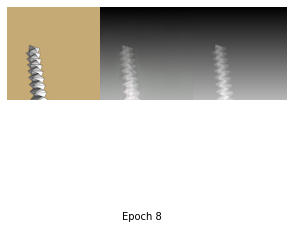

Epoch [9/50], Step [1/3750], D_loss: 0.3412, G_loss: 6.0580
Epoch [9/50], Step [2/3750], D_loss: 0.1550, G_loss: 9.8343
Epoch [9/50], Step [3/3750], D_loss: 0.6616, G_loss: 2.6272
Epoch [9/50], Step [4/3750], D_loss: 0.2677, G_loss: 4.7730
Epoch [9/50], Step [5/3750], D_loss: 0.3031, G_loss: 11.3628
Epoch [9/50], Step [6/3750], D_loss: 0.0944, G_loss: 7.2361
Epoch [9/50], Step [7/3750], D_loss: 0.3036, G_loss: 9.0528
Epoch [9/50], Step [8/3750], D_loss: 0.4758, G_loss: 4.4114
Epoch [9/50], Step [9/3750], D_loss: 0.4598, G_loss: 7.2679
Epoch [9/50], Step [10/3750], D_loss: 0.3992, G_loss: 13.7379
Epoch [9/50], Step [11/3750], D_loss: 0.4548, G_loss: 6.3201
Epoch [9/50], Step [12/3750], D_loss: 0.4200, G_loss: 10.9443
Epoch [9/50], Step [13/3750], D_loss: 0.1606, G_loss: 5.0342
Epoch [9/50], Step [14/3750], D_loss: 0.2947, G_loss: 6.6223
Epoch [9/50], Step [15/3750], D_loss: 0.0739, G_loss: 7.4700
Epoch [9/50], Step [16/3750], D_loss: 0.1082, G_loss: 7.8680
Epoch [9/50], Step [17/3750], 

Epoch [9/50], Step [135/3750], D_loss: 0.8639, G_loss: 8.3494
Epoch [9/50], Step [136/3750], D_loss: 0.0665, G_loss: 8.6468
Epoch [9/50], Step [137/3750], D_loss: 0.1093, G_loss: 20.1622
Epoch [9/50], Step [138/3750], D_loss: 0.0263, G_loss: 10.9514
Epoch [9/50], Step [139/3750], D_loss: 0.2285, G_loss: 4.8248
Epoch [9/50], Step [140/3750], D_loss: 0.2802, G_loss: 9.3067
Epoch [9/50], Step [141/3750], D_loss: 0.4778, G_loss: 5.6441
Epoch [9/50], Step [142/3750], D_loss: 0.5045, G_loss: 4.2746
Epoch [9/50], Step [143/3750], D_loss: 0.0855, G_loss: 10.0015
Epoch [9/50], Step [144/3750], D_loss: 0.3110, G_loss: 4.0950
Epoch [9/50], Step [145/3750], D_loss: 0.1607, G_loss: 5.6169
Epoch [9/50], Step [146/3750], D_loss: 0.1262, G_loss: 13.8903
Epoch [9/50], Step [147/3750], D_loss: 0.3388, G_loss: 4.4390
Epoch [9/50], Step [148/3750], D_loss: 0.2924, G_loss: 5.6392
Epoch [9/50], Step [149/3750], D_loss: 0.0563, G_loss: 4.8287
Epoch [9/50], Step [150/3750], D_loss: 0.0493, G_loss: 5.5904
Epoc

Epoch [9/50], Step [267/3750], D_loss: 0.8694, G_loss: 6.6998
Epoch [9/50], Step [268/3750], D_loss: 0.4984, G_loss: 3.7163
Epoch [9/50], Step [269/3750], D_loss: 0.1192, G_loss: 6.1349
Epoch [9/50], Step [270/3750], D_loss: 0.5526, G_loss: 5.9187
Epoch [9/50], Step [271/3750], D_loss: 0.4889, G_loss: 5.2418
Epoch [9/50], Step [272/3750], D_loss: 0.3020, G_loss: 11.6675
Epoch [9/50], Step [273/3750], D_loss: 0.2878, G_loss: 7.4284
Epoch [9/50], Step [274/3750], D_loss: 0.1595, G_loss: 4.0130
Epoch [9/50], Step [275/3750], D_loss: 0.5134, G_loss: 3.0481
Epoch [9/50], Step [276/3750], D_loss: 0.2707, G_loss: 3.1305
Epoch [9/50], Step [277/3750], D_loss: 0.2872, G_loss: 8.2050
Epoch [9/50], Step [278/3750], D_loss: 0.2479, G_loss: 14.3969
Epoch [9/50], Step [279/3750], D_loss: 0.2602, G_loss: 8.6408
Epoch [9/50], Step [280/3750], D_loss: 0.1280, G_loss: 8.0757
Epoch [9/50], Step [281/3750], D_loss: 0.1776, G_loss: 6.6077
Epoch [9/50], Step [282/3750], D_loss: 0.1100, G_loss: 10.4608
Epoch

Epoch [9/50], Step [399/3750], D_loss: 0.1984, G_loss: 4.3642
Epoch [9/50], Step [400/3750], D_loss: 0.2166, G_loss: 4.9296
Epoch [9/50], Step [401/3750], D_loss: 0.1941, G_loss: 12.3024
Epoch [9/50], Step [402/3750], D_loss: 0.2194, G_loss: 11.2731
Epoch [9/50], Step [403/3750], D_loss: 0.0517, G_loss: 8.9961
Epoch [9/50], Step [404/3750], D_loss: 0.0376, G_loss: 12.7748
Epoch [9/50], Step [405/3750], D_loss: 0.4272, G_loss: 8.5452
Epoch [9/50], Step [406/3750], D_loss: 0.5228, G_loss: 5.5334
Epoch [9/50], Step [407/3750], D_loss: 0.2853, G_loss: 4.6341
Epoch [9/50], Step [408/3750], D_loss: 0.3389, G_loss: 3.9352
Epoch [9/50], Step [409/3750], D_loss: 0.0699, G_loss: 5.2567
Epoch [9/50], Step [410/3750], D_loss: 0.3554, G_loss: 8.4380
Epoch [9/50], Step [411/3750], D_loss: 0.2180, G_loss: 6.1851
Epoch [9/50], Step [412/3750], D_loss: 0.2520, G_loss: 8.9107
Epoch [9/50], Step [413/3750], D_loss: 0.2363, G_loss: 7.5428
Epoch [9/50], Step [414/3750], D_loss: 0.1202, G_loss: 10.6023
Epoc

Epoch [9/50], Step [531/3750], D_loss: 0.0455, G_loss: 11.1752
Epoch [9/50], Step [532/3750], D_loss: 0.3875, G_loss: 6.0345
Epoch [9/50], Step [533/3750], D_loss: 0.1374, G_loss: 3.8148
Epoch [9/50], Step [534/3750], D_loss: 0.0238, G_loss: 8.8712
Epoch [9/50], Step [535/3750], D_loss: 0.6175, G_loss: 9.0878
Epoch [9/50], Step [536/3750], D_loss: 0.3100, G_loss: 6.8579
Epoch [9/50], Step [537/3750], D_loss: 0.0524, G_loss: 10.0689
Epoch [9/50], Step [538/3750], D_loss: 0.2817, G_loss: 10.5236
Epoch [9/50], Step [539/3750], D_loss: 0.1325, G_loss: 5.9395
Epoch [9/50], Step [540/3750], D_loss: 0.0539, G_loss: 14.3193
Epoch [9/50], Step [541/3750], D_loss: 0.2542, G_loss: 4.5666
Epoch [9/50], Step [542/3750], D_loss: 0.4072, G_loss: 4.4260
Epoch [9/50], Step [543/3750], D_loss: 0.3234, G_loss: 8.4192
Epoch [9/50], Step [544/3750], D_loss: 0.2480, G_loss: 12.2118
Epoch [9/50], Step [545/3750], D_loss: 0.2925, G_loss: 7.5073
Epoch [9/50], Step [546/3750], D_loss: 0.3492, G_loss: 7.7384
Epo

Epoch [9/50], Step [663/3750], D_loss: 0.4063, G_loss: 6.1233
Epoch [9/50], Step [664/3750], D_loss: 0.3577, G_loss: 5.5816
Epoch [9/50], Step [665/3750], D_loss: 0.4231, G_loss: 3.3993
Epoch [9/50], Step [666/3750], D_loss: 0.6921, G_loss: 6.9519
Epoch [9/50], Step [667/3750], D_loss: 0.1366, G_loss: 7.5578
Epoch [9/50], Step [668/3750], D_loss: 0.5633, G_loss: 6.8752
Epoch [9/50], Step [669/3750], D_loss: 0.5767, G_loss: 6.3974
Epoch [9/50], Step [670/3750], D_loss: 0.3687, G_loss: 8.4773
Epoch [9/50], Step [671/3750], D_loss: 0.3119, G_loss: 5.8584
Epoch [9/50], Step [672/3750], D_loss: 0.1181, G_loss: 9.5533
Epoch [9/50], Step [673/3750], D_loss: 0.3319, G_loss: 3.5864
Epoch [9/50], Step [674/3750], D_loss: 0.7447, G_loss: 6.2153
Epoch [9/50], Step [675/3750], D_loss: 0.1638, G_loss: 8.3541
Epoch [9/50], Step [676/3750], D_loss: 0.8155, G_loss: 4.9242
Epoch [9/50], Step [677/3750], D_loss: 0.2962, G_loss: 9.3171
Epoch [9/50], Step [678/3750], D_loss: 0.3437, G_loss: 6.6653
Epoch [9

Epoch [9/50], Step [795/3750], D_loss: 0.4552, G_loss: 5.2712
Epoch [9/50], Step [796/3750], D_loss: 0.5057, G_loss: 6.1717
Epoch [9/50], Step [797/3750], D_loss: 0.3276, G_loss: 6.5056
Epoch [9/50], Step [798/3750], D_loss: 0.2057, G_loss: 8.4523
Epoch [9/50], Step [799/3750], D_loss: 0.2663, G_loss: 11.0682
Epoch [9/50], Step [800/3750], D_loss: 0.3055, G_loss: 5.2403
Epoch [9/50], Step [801/3750], D_loss: 0.5111, G_loss: 7.7544
Epoch [9/50], Step [802/3750], D_loss: 0.3824, G_loss: 7.8118
Epoch [9/50], Step [803/3750], D_loss: 0.3720, G_loss: 4.3784
Epoch [9/50], Step [804/3750], D_loss: 0.6778, G_loss: 3.9327
Epoch [9/50], Step [805/3750], D_loss: 0.5018, G_loss: 6.7187
Epoch [9/50], Step [806/3750], D_loss: 0.3899, G_loss: 3.3314
Epoch [9/50], Step [807/3750], D_loss: 0.5193, G_loss: 4.9565
Epoch [9/50], Step [808/3750], D_loss: 0.2227, G_loss: 7.5179
Epoch [9/50], Step [809/3750], D_loss: 0.4354, G_loss: 4.3684
Epoch [9/50], Step [810/3750], D_loss: 0.1789, G_loss: 3.8329
Epoch [

Epoch [9/50], Step [927/3750], D_loss: 0.6898, G_loss: 4.2328
Epoch [9/50], Step [928/3750], D_loss: 0.4013, G_loss: 4.1430
Epoch [9/50], Step [929/3750], D_loss: 0.2284, G_loss: 3.9929
Epoch [9/50], Step [930/3750], D_loss: 0.2474, G_loss: 6.5158
Epoch [9/50], Step [931/3750], D_loss: 0.2134, G_loss: 9.5557
Epoch [9/50], Step [932/3750], D_loss: 0.2051, G_loss: 7.8779
Epoch [9/50], Step [933/3750], D_loss: 0.1889, G_loss: 3.8072
Epoch [9/50], Step [934/3750], D_loss: 0.1597, G_loss: 6.5978
Epoch [9/50], Step [935/3750], D_loss: 0.4595, G_loss: 5.5163
Epoch [9/50], Step [936/3750], D_loss: 0.3141, G_loss: 3.0378
Epoch [9/50], Step [937/3750], D_loss: 0.4427, G_loss: 7.3751
Epoch [9/50], Step [938/3750], D_loss: 0.4461, G_loss: 4.7339
Epoch [9/50], Step [939/3750], D_loss: 0.0531, G_loss: 10.6178
Epoch [9/50], Step [940/3750], D_loss: 0.8482, G_loss: 4.5999
Epoch [9/50], Step [941/3750], D_loss: 0.2473, G_loss: 8.9921
Epoch [9/50], Step [942/3750], D_loss: 0.3231, G_loss: 3.4609
Epoch [

Epoch [9/50], Step [1058/3750], D_loss: 0.2619, G_loss: 9.7018
Epoch [9/50], Step [1059/3750], D_loss: 0.5102, G_loss: 12.8548
Epoch [9/50], Step [1060/3750], D_loss: 0.0898, G_loss: 11.9443
Epoch [9/50], Step [1061/3750], D_loss: 0.3501, G_loss: 4.3087
Epoch [9/50], Step [1062/3750], D_loss: 0.4286, G_loss: 3.6755
Epoch [9/50], Step [1063/3750], D_loss: 0.5646, G_loss: 10.3152
Epoch [9/50], Step [1064/3750], D_loss: 0.0712, G_loss: 11.8602
Epoch [9/50], Step [1065/3750], D_loss: 0.1485, G_loss: 11.7092
Epoch [9/50], Step [1066/3750], D_loss: 0.5083, G_loss: 3.4801
Epoch [9/50], Step [1067/3750], D_loss: 0.1279, G_loss: 3.4485
Epoch [9/50], Step [1068/3750], D_loss: 0.5014, G_loss: 3.9337
Epoch [9/50], Step [1069/3750], D_loss: 0.3918, G_loss: 5.9243
Epoch [9/50], Step [1070/3750], D_loss: 0.2167, G_loss: 5.1081
Epoch [9/50], Step [1071/3750], D_loss: 0.2696, G_loss: 4.7202
Epoch [9/50], Step [1072/3750], D_loss: 0.5614, G_loss: 6.0157
Epoch [9/50], Step [1073/3750], D_loss: 0.1307, G_

Epoch [9/50], Step [1188/3750], D_loss: 0.3423, G_loss: 4.5936
Epoch [9/50], Step [1189/3750], D_loss: 0.5048, G_loss: 10.6358
Epoch [9/50], Step [1190/3750], D_loss: 0.3748, G_loss: 6.7344
Epoch [9/50], Step [1191/3750], D_loss: 0.1303, G_loss: 8.4964
Epoch [9/50], Step [1192/3750], D_loss: 0.3074, G_loss: 9.7370
Epoch [9/50], Step [1193/3750], D_loss: 0.2131, G_loss: 11.7258
Epoch [9/50], Step [1194/3750], D_loss: 0.3275, G_loss: 6.3966
Epoch [9/50], Step [1195/3750], D_loss: 0.0778, G_loss: 5.3520
Epoch [9/50], Step [1196/3750], D_loss: 0.0813, G_loss: 13.0340
Epoch [9/50], Step [1197/3750], D_loss: 0.0751, G_loss: 10.3367
Epoch [9/50], Step [1198/3750], D_loss: 0.1445, G_loss: 7.3075
Epoch [9/50], Step [1199/3750], D_loss: 0.0854, G_loss: 10.1628
Epoch [9/50], Step [1200/3750], D_loss: 0.2230, G_loss: 13.0245
Epoch [9/50], Step [1201/3750], D_loss: 0.4088, G_loss: 8.7005
Epoch [9/50], Step [1202/3750], D_loss: 0.2878, G_loss: 5.7618
Epoch [9/50], Step [1203/3750], D_loss: 0.2665, G

Epoch [9/50], Step [1318/3750], D_loss: 0.4836, G_loss: 8.2805
Epoch [9/50], Step [1319/3750], D_loss: 0.2300, G_loss: 5.6649
Epoch [9/50], Step [1320/3750], D_loss: 0.2016, G_loss: 6.7240
Epoch [9/50], Step [1321/3750], D_loss: 0.1904, G_loss: 5.7061
Epoch [9/50], Step [1322/3750], D_loss: 0.2736, G_loss: 5.8270
Epoch [9/50], Step [1323/3750], D_loss: 0.2611, G_loss: 7.0692
Epoch [9/50], Step [1324/3750], D_loss: 0.1105, G_loss: 12.7565
Epoch [9/50], Step [1325/3750], D_loss: 0.1175, G_loss: 10.8904
Epoch [9/50], Step [1326/3750], D_loss: 0.3883, G_loss: 6.0105
Epoch [9/50], Step [1327/3750], D_loss: 0.0949, G_loss: 7.4484
Epoch [9/50], Step [1328/3750], D_loss: 0.0331, G_loss: 11.6756
Epoch [9/50], Step [1329/3750], D_loss: 0.1781, G_loss: 15.9621
Epoch [9/50], Step [1330/3750], D_loss: 0.8408, G_loss: 6.0470
Epoch [9/50], Step [1331/3750], D_loss: 0.1019, G_loss: 5.9990
Epoch [9/50], Step [1332/3750], D_loss: 0.1496, G_loss: 5.6970
Epoch [9/50], Step [1333/3750], D_loss: 0.1781, G_l

Epoch [9/50], Step [1448/3750], D_loss: 0.2620, G_loss: 8.1909
Epoch [9/50], Step [1449/3750], D_loss: 0.2144, G_loss: 24.1073
Epoch [9/50], Step [1450/3750], D_loss: 0.2726, G_loss: 5.9352
Epoch [9/50], Step [1451/3750], D_loss: 0.1905, G_loss: 8.8224
Epoch [9/50], Step [1452/3750], D_loss: 0.2377, G_loss: 11.1278
Epoch [9/50], Step [1453/3750], D_loss: 0.0359, G_loss: 10.2184
Epoch [9/50], Step [1454/3750], D_loss: 0.0777, G_loss: 14.3700
Epoch [9/50], Step [1455/3750], D_loss: 0.0381, G_loss: 12.0252
Epoch [9/50], Step [1456/3750], D_loss: 0.2473, G_loss: 6.9149
Epoch [9/50], Step [1457/3750], D_loss: 0.0701, G_loss: 11.3290
Epoch [9/50], Step [1458/3750], D_loss: 0.1283, G_loss: 9.4111
Epoch [9/50], Step [1459/3750], D_loss: 0.2153, G_loss: 5.6173
Epoch [9/50], Step [1460/3750], D_loss: 0.3353, G_loss: 5.3460
Epoch [9/50], Step [1461/3750], D_loss: 0.1095, G_loss: 8.1399
Epoch [9/50], Step [1462/3750], D_loss: 0.2969, G_loss: 12.8827
Epoch [9/50], Step [1463/3750], D_loss: 0.1054, 

Epoch [9/50], Step [1578/3750], D_loss: 0.1086, G_loss: 5.3692
Epoch [9/50], Step [1579/3750], D_loss: 0.3851, G_loss: 4.3304
Epoch [9/50], Step [1580/3750], D_loss: 0.1550, G_loss: 7.4366
Epoch [9/50], Step [1581/3750], D_loss: 0.4283, G_loss: 3.5460
Epoch [9/50], Step [1582/3750], D_loss: 0.2002, G_loss: 14.4033
Epoch [9/50], Step [1583/3750], D_loss: 0.0921, G_loss: 10.4256
Epoch [9/50], Step [1584/3750], D_loss: 0.0566, G_loss: 8.5925
Epoch [9/50], Step [1585/3750], D_loss: 0.2171, G_loss: 15.6768
Epoch [9/50], Step [1586/3750], D_loss: 0.4891, G_loss: 4.3999
Epoch [9/50], Step [1587/3750], D_loss: 0.0784, G_loss: 8.0387
Epoch [9/50], Step [1588/3750], D_loss: 0.1086, G_loss: 7.2637
Epoch [9/50], Step [1589/3750], D_loss: 0.5343, G_loss: 2.9340
Epoch [9/50], Step [1590/3750], D_loss: 0.2140, G_loss: 10.5304
Epoch [9/50], Step [1591/3750], D_loss: 0.3027, G_loss: 8.1708
Epoch [9/50], Step [1592/3750], D_loss: 0.0629, G_loss: 13.7632
Epoch [9/50], Step [1593/3750], D_loss: 0.0671, G_

Epoch [9/50], Step [1708/3750], D_loss: 0.3114, G_loss: 11.4185
Epoch [9/50], Step [1709/3750], D_loss: 0.3644, G_loss: 9.3653
Epoch [9/50], Step [1710/3750], D_loss: 0.1854, G_loss: 5.6411
Epoch [9/50], Step [1711/3750], D_loss: 0.0538, G_loss: 10.7432
Epoch [9/50], Step [1712/3750], D_loss: 0.6319, G_loss: 5.9135
Epoch [9/50], Step [1713/3750], D_loss: 0.4119, G_loss: 4.9927
Epoch [9/50], Step [1714/3750], D_loss: 0.3372, G_loss: 4.3534
Epoch [9/50], Step [1715/3750], D_loss: 0.3875, G_loss: 8.9712
Epoch [9/50], Step [1716/3750], D_loss: 0.0956, G_loss: 7.4231
Epoch [9/50], Step [1717/3750], D_loss: 0.2703, G_loss: 5.0691
Epoch [9/50], Step [1718/3750], D_loss: 0.2227, G_loss: 4.0141
Epoch [9/50], Step [1719/3750], D_loss: 0.0786, G_loss: 5.7041
Epoch [9/50], Step [1720/3750], D_loss: 0.1930, G_loss: 18.1607
Epoch [9/50], Step [1721/3750], D_loss: 0.0704, G_loss: 4.5263
Epoch [9/50], Step [1722/3750], D_loss: 0.1153, G_loss: 9.6610
Epoch [9/50], Step [1723/3750], D_loss: 0.0655, G_lo

Epoch [9/50], Step [1838/3750], D_loss: 0.3530, G_loss: 3.8958
Epoch [9/50], Step [1839/3750], D_loss: 0.2237, G_loss: 4.0657
Epoch [9/50], Step [1840/3750], D_loss: 0.5512, G_loss: 10.9918
Epoch [9/50], Step [1841/3750], D_loss: 0.3374, G_loss: 14.3063
Epoch [9/50], Step [1842/3750], D_loss: 0.2916, G_loss: 5.3283
Epoch [9/50], Step [1843/3750], D_loss: 0.4222, G_loss: 10.4782
Epoch [9/50], Step [1844/3750], D_loss: 0.0607, G_loss: 6.4205
Epoch [9/50], Step [1845/3750], D_loss: 0.5297, G_loss: 8.9715
Epoch [9/50], Step [1846/3750], D_loss: 0.7879, G_loss: 6.1866
Epoch [9/50], Step [1847/3750], D_loss: 0.2112, G_loss: 5.0253
Epoch [9/50], Step [1848/3750], D_loss: 0.2322, G_loss: 18.4833
Epoch [9/50], Step [1849/3750], D_loss: 0.6747, G_loss: 9.4331
Epoch [9/50], Step [1850/3750], D_loss: 0.2580, G_loss: 8.7700
Epoch [9/50], Step [1851/3750], D_loss: 0.0400, G_loss: 10.4256
Epoch [9/50], Step [1852/3750], D_loss: 0.3113, G_loss: 6.4838
Epoch [9/50], Step [1853/3750], D_loss: 0.2220, G_

Epoch [9/50], Step [1968/3750], D_loss: 0.0469, G_loss: 11.1740
Epoch [9/50], Step [1969/3750], D_loss: 0.5866, G_loss: 5.9437
Epoch [9/50], Step [1970/3750], D_loss: 0.2329, G_loss: 6.1836
Epoch [9/50], Step [1971/3750], D_loss: 0.1095, G_loss: 5.8329
Epoch [9/50], Step [1972/3750], D_loss: 0.4533, G_loss: 3.6233
Epoch [9/50], Step [1973/3750], D_loss: 0.4420, G_loss: 7.1495
Epoch [9/50], Step [1974/3750], D_loss: 0.4333, G_loss: 5.2251
Epoch [9/50], Step [1975/3750], D_loss: 0.3143, G_loss: 4.7247
Epoch [9/50], Step [1976/3750], D_loss: 0.6230, G_loss: 9.3060
Epoch [9/50], Step [1977/3750], D_loss: 0.4312, G_loss: 9.4685
Epoch [9/50], Step [1978/3750], D_loss: 0.1686, G_loss: 8.2482
Epoch [9/50], Step [1979/3750], D_loss: 0.5626, G_loss: 5.2880
Epoch [9/50], Step [1980/3750], D_loss: 0.1868, G_loss: 6.4159
Epoch [9/50], Step [1981/3750], D_loss: 0.1786, G_loss: 6.8047
Epoch [9/50], Step [1982/3750], D_loss: 0.2228, G_loss: 5.2987
Epoch [9/50], Step [1983/3750], D_loss: 0.0421, G_loss

Epoch [9/50], Step [2098/3750], D_loss: 0.3514, G_loss: 9.0421
Epoch [9/50], Step [2099/3750], D_loss: 0.1824, G_loss: 4.3641
Epoch [9/50], Step [2100/3750], D_loss: 0.0232, G_loss: 9.9539
Epoch [9/50], Step [2101/3750], D_loss: 0.3095, G_loss: 16.1064
Epoch [9/50], Step [2102/3750], D_loss: 0.1877, G_loss: 13.2043
Epoch [9/50], Step [2103/3750], D_loss: 0.1059, G_loss: 14.3630
Epoch [9/50], Step [2104/3750], D_loss: 0.2095, G_loss: 5.9195
Epoch [9/50], Step [2105/3750], D_loss: 0.0741, G_loss: 10.5438
Epoch [9/50], Step [2106/3750], D_loss: 0.2755, G_loss: 3.7930
Epoch [9/50], Step [2107/3750], D_loss: 0.0992, G_loss: 6.3125
Epoch [9/50], Step [2108/3750], D_loss: 0.4742, G_loss: 3.8077
Epoch [9/50], Step [2109/3750], D_loss: 0.1441, G_loss: 6.0823
Epoch [9/50], Step [2110/3750], D_loss: 0.1599, G_loss: 5.4074
Epoch [9/50], Step [2111/3750], D_loss: 0.1050, G_loss: 7.8221
Epoch [9/50], Step [2112/3750], D_loss: 0.3972, G_loss: 9.0239
Epoch [9/50], Step [2113/3750], D_loss: 0.2540, G_l

Epoch [9/50], Step [2228/3750], D_loss: 0.4647, G_loss: 7.4075
Epoch [9/50], Step [2229/3750], D_loss: 0.1674, G_loss: 8.7565
Epoch [9/50], Step [2230/3750], D_loss: 0.5247, G_loss: 9.8058
Epoch [9/50], Step [2231/3750], D_loss: 0.4658, G_loss: 5.0199
Epoch [9/50], Step [2232/3750], D_loss: 0.1426, G_loss: 6.8246
Epoch [9/50], Step [2233/3750], D_loss: 0.1261, G_loss: 7.1643
Epoch [9/50], Step [2234/3750], D_loss: 0.4984, G_loss: 4.7508
Epoch [9/50], Step [2235/3750], D_loss: 0.1035, G_loss: 4.7231
Epoch [9/50], Step [2236/3750], D_loss: 0.4893, G_loss: 3.1270
Epoch [9/50], Step [2237/3750], D_loss: 0.5422, G_loss: 5.3377
Epoch [9/50], Step [2238/3750], D_loss: 0.0260, G_loss: 12.6607
Epoch [9/50], Step [2239/3750], D_loss: 0.3562, G_loss: 7.7372
Epoch [9/50], Step [2240/3750], D_loss: 0.1960, G_loss: 26.3849
Epoch [9/50], Step [2241/3750], D_loss: 0.1480, G_loss: 9.6182
Epoch [9/50], Step [2242/3750], D_loss: 0.1173, G_loss: 4.5924
Epoch [9/50], Step [2243/3750], D_loss: 0.1541, G_los

Epoch [9/50], Step [2358/3750], D_loss: 0.1776, G_loss: 4.7623
Epoch [9/50], Step [2359/3750], D_loss: 0.1991, G_loss: 9.4896
Epoch [9/50], Step [2360/3750], D_loss: 0.2650, G_loss: 8.9015
Epoch [9/50], Step [2361/3750], D_loss: 0.3838, G_loss: 4.6457
Epoch [9/50], Step [2362/3750], D_loss: 0.3681, G_loss: 6.9517
Epoch [9/50], Step [2363/3750], D_loss: 0.0623, G_loss: 6.8705
Epoch [9/50], Step [2364/3750], D_loss: 0.1869, G_loss: 7.0200
Epoch [9/50], Step [2365/3750], D_loss: 0.0564, G_loss: 13.1062
Epoch [9/50], Step [2366/3750], D_loss: 0.4660, G_loss: 5.4514
Epoch [9/50], Step [2367/3750], D_loss: 0.1557, G_loss: 5.7004
Epoch [9/50], Step [2368/3750], D_loss: 0.0554, G_loss: 9.3388
Epoch [9/50], Step [2369/3750], D_loss: 0.0630, G_loss: 4.3725
Epoch [9/50], Step [2370/3750], D_loss: 0.2874, G_loss: 3.4692
Epoch [9/50], Step [2371/3750], D_loss: 0.1174, G_loss: 8.4344
Epoch [9/50], Step [2372/3750], D_loss: 0.1391, G_loss: 5.3606
Epoch [9/50], Step [2373/3750], D_loss: 0.1720, G_loss

Epoch [9/50], Step [2488/3750], D_loss: 0.2897, G_loss: 13.7510
Epoch [9/50], Step [2489/3750], D_loss: 0.4081, G_loss: 6.5291
Epoch [9/50], Step [2490/3750], D_loss: 0.1597, G_loss: 17.0139
Epoch [9/50], Step [2491/3750], D_loss: 0.7729, G_loss: 3.4300
Epoch [9/50], Step [2492/3750], D_loss: 0.5079, G_loss: 7.6692
Epoch [9/50], Step [2493/3750], D_loss: 0.2281, G_loss: 14.6563
Epoch [9/50], Step [2494/3750], D_loss: 0.1831, G_loss: 4.1032
Epoch [9/50], Step [2495/3750], D_loss: 0.3370, G_loss: 8.5819
Epoch [9/50], Step [2496/3750], D_loss: 0.0973, G_loss: 9.8389
Epoch [9/50], Step [2497/3750], D_loss: 0.4534, G_loss: 4.7273
Epoch [9/50], Step [2498/3750], D_loss: 0.3507, G_loss: 4.4042
Epoch [9/50], Step [2499/3750], D_loss: 0.4419, G_loss: 5.8032
Epoch [9/50], Step [2500/3750], D_loss: 0.0401, G_loss: 10.2009
Epoch [9/50], Step [2501/3750], D_loss: 0.0550, G_loss: 6.2148
Epoch [9/50], Step [2502/3750], D_loss: 0.2868, G_loss: 8.3091
Epoch [9/50], Step [2503/3750], D_loss: 0.3033, G_l

Epoch [9/50], Step [2618/3750], D_loss: 0.0908, G_loss: 7.3239
Epoch [9/50], Step [2619/3750], D_loss: 0.0742, G_loss: 10.4328
Epoch [9/50], Step [2620/3750], D_loss: 0.5062, G_loss: 5.9826
Epoch [9/50], Step [2621/3750], D_loss: 0.2287, G_loss: 6.5690
Epoch [9/50], Step [2622/3750], D_loss: 0.4327, G_loss: 14.1910
Epoch [9/50], Step [2623/3750], D_loss: 0.3135, G_loss: 6.2803
Epoch [9/50], Step [2624/3750], D_loss: 0.4480, G_loss: 5.8867
Epoch [9/50], Step [2625/3750], D_loss: 0.1404, G_loss: 13.0412
Epoch [9/50], Step [2626/3750], D_loss: 0.2223, G_loss: 6.3924
Epoch [9/50], Step [2627/3750], D_loss: 0.0432, G_loss: 6.8056
Epoch [9/50], Step [2628/3750], D_loss: 0.5246, G_loss: 17.7607
Epoch [9/50], Step [2629/3750], D_loss: 0.2200, G_loss: 8.2312
Epoch [9/50], Step [2630/3750], D_loss: 0.2580, G_loss: 3.2236
Epoch [9/50], Step [2631/3750], D_loss: 0.2863, G_loss: 5.9968
Epoch [9/50], Step [2632/3750], D_loss: 0.1223, G_loss: 10.1486
Epoch [9/50], Step [2633/3750], D_loss: 0.2096, G_

Epoch [9/50], Step [2748/3750], D_loss: 0.1811, G_loss: 3.9352
Epoch [9/50], Step [2749/3750], D_loss: 0.1438, G_loss: 6.0114
Epoch [9/50], Step [2750/3750], D_loss: 0.2212, G_loss: 10.4543
Epoch [9/50], Step [2751/3750], D_loss: 0.2875, G_loss: 5.8466
Epoch [9/50], Step [2752/3750], D_loss: 0.1994, G_loss: 4.0568
Epoch [9/50], Step [2753/3750], D_loss: 0.1464, G_loss: 8.7023
Epoch [9/50], Step [2754/3750], D_loss: 0.0927, G_loss: 4.7860
Epoch [9/50], Step [2755/3750], D_loss: 0.1088, G_loss: 7.1890
Epoch [9/50], Step [2756/3750], D_loss: 0.0548, G_loss: 4.9412
Epoch [9/50], Step [2757/3750], D_loss: 0.3037, G_loss: 3.7242
Epoch [9/50], Step [2758/3750], D_loss: 0.1585, G_loss: 8.4159
Epoch [9/50], Step [2759/3750], D_loss: 0.0863, G_loss: 10.4329
Epoch [9/50], Step [2760/3750], D_loss: 0.1261, G_loss: 9.7060
Epoch [9/50], Step [2761/3750], D_loss: 0.2294, G_loss: 6.0053
Epoch [9/50], Step [2762/3750], D_loss: 0.2769, G_loss: 4.7953
Epoch [9/50], Step [2763/3750], D_loss: 0.3746, G_los

Epoch [9/50], Step [2878/3750], D_loss: 0.1820, G_loss: 11.9292
Epoch [9/50], Step [2879/3750], D_loss: 0.0676, G_loss: 8.0782
Epoch [9/50], Step [2880/3750], D_loss: 0.3143, G_loss: 10.8190
Epoch [9/50], Step [2881/3750], D_loss: 0.1117, G_loss: 5.6475
Epoch [9/50], Step [2882/3750], D_loss: 0.3936, G_loss: 3.3993
Epoch [9/50], Step [2883/3750], D_loss: 0.3151, G_loss: 6.4649
Epoch [9/50], Step [2884/3750], D_loss: 0.1050, G_loss: 5.5616
Epoch [9/50], Step [2885/3750], D_loss: 0.1278, G_loss: 5.2719
Epoch [9/50], Step [2886/3750], D_loss: 0.0842, G_loss: 5.4134
Epoch [9/50], Step [2887/3750], D_loss: 0.0989, G_loss: 6.0959
Epoch [9/50], Step [2888/3750], D_loss: 0.2505, G_loss: 13.4469
Epoch [9/50], Step [2889/3750], D_loss: 0.1009, G_loss: 8.9617
Epoch [9/50], Step [2890/3750], D_loss: 0.1993, G_loss: 26.6776
Epoch [9/50], Step [2891/3750], D_loss: 0.0735, G_loss: 10.2493
Epoch [9/50], Step [2892/3750], D_loss: 0.3355, G_loss: 3.1406
Epoch [9/50], Step [2893/3750], D_loss: 0.3294, G_

Epoch [9/50], Step [3008/3750], D_loss: 0.1275, G_loss: 11.9005
Epoch [9/50], Step [3009/3750], D_loss: 0.4525, G_loss: 6.7228
Epoch [9/50], Step [3010/3750], D_loss: 0.1740, G_loss: 7.3000
Epoch [9/50], Step [3011/3750], D_loss: 0.6441, G_loss: 5.5499
Epoch [9/50], Step [3012/3750], D_loss: 0.1762, G_loss: 5.9132
Epoch [9/50], Step [3013/3750], D_loss: 0.2324, G_loss: 8.3397
Epoch [9/50], Step [3014/3750], D_loss: 0.0826, G_loss: 5.7991
Epoch [9/50], Step [3015/3750], D_loss: 0.0654, G_loss: 5.6748
Epoch [9/50], Step [3016/3750], D_loss: 0.3099, G_loss: 9.3002
Epoch [9/50], Step [3017/3750], D_loss: 0.1005, G_loss: 6.7885
Epoch [9/50], Step [3018/3750], D_loss: 0.3485, G_loss: 5.3424
Epoch [9/50], Step [3019/3750], D_loss: 0.1420, G_loss: 11.2676
Epoch [9/50], Step [3020/3750], D_loss: 0.2432, G_loss: 4.7619
Epoch [9/50], Step [3021/3750], D_loss: 0.3729, G_loss: 4.9865
Epoch [9/50], Step [3022/3750], D_loss: 0.2807, G_loss: 5.7967
Epoch [9/50], Step [3023/3750], D_loss: 0.0429, G_los

Epoch [9/50], Step [3138/3750], D_loss: 0.2690, G_loss: 6.3889
Epoch [9/50], Step [3139/3750], D_loss: 0.2347, G_loss: 10.6134
Epoch [9/50], Step [3140/3750], D_loss: 0.0716, G_loss: 9.6252
Epoch [9/50], Step [3141/3750], D_loss: 0.3377, G_loss: 6.7212
Epoch [9/50], Step [3142/3750], D_loss: 0.1068, G_loss: 5.0909
Epoch [9/50], Step [3143/3750], D_loss: 0.0856, G_loss: 5.4613
Epoch [9/50], Step [3144/3750], D_loss: 0.5337, G_loss: 6.9703
Epoch [9/50], Step [3145/3750], D_loss: 0.1238, G_loss: 5.3474
Epoch [9/50], Step [3146/3750], D_loss: 0.3766, G_loss: 4.1608
Epoch [9/50], Step [3147/3750], D_loss: 0.0533, G_loss: 13.9992
Epoch [9/50], Step [3148/3750], D_loss: 0.6702, G_loss: 6.4180
Epoch [9/50], Step [3149/3750], D_loss: 0.8365, G_loss: 3.2077
Epoch [9/50], Step [3150/3750], D_loss: 0.0300, G_loss: 44.7849
Epoch [9/50], Step [3151/3750], D_loss: 0.6481, G_loss: 10.7910
Epoch [9/50], Step [3152/3750], D_loss: 0.4464, G_loss: 8.4741
Epoch [9/50], Step [3153/3750], D_loss: 0.6023, G_l

Epoch [9/50], Step [3268/3750], D_loss: 0.1038, G_loss: 6.4567
Epoch [9/50], Step [3269/3750], D_loss: 0.2925, G_loss: 8.0118
Epoch [9/50], Step [3270/3750], D_loss: 0.1173, G_loss: 5.6841
Epoch [9/50], Step [3271/3750], D_loss: 0.6736, G_loss: 6.0761
Epoch [9/50], Step [3272/3750], D_loss: 0.2464, G_loss: 4.4748
Epoch [9/50], Step [3273/3750], D_loss: 0.3435, G_loss: 5.1449
Epoch [9/50], Step [3274/3750], D_loss: 0.1482, G_loss: 7.1808
Epoch [9/50], Step [3275/3750], D_loss: 0.0585, G_loss: 11.0386
Epoch [9/50], Step [3276/3750], D_loss: 0.9510, G_loss: 7.0815
Epoch [9/50], Step [3277/3750], D_loss: 0.0729, G_loss: 14.3802
Epoch [9/50], Step [3278/3750], D_loss: 0.4271, G_loss: 5.7717
Epoch [9/50], Step [3279/3750], D_loss: 0.0975, G_loss: 12.8954
Epoch [9/50], Step [3280/3750], D_loss: 0.1120, G_loss: 8.2927
Epoch [9/50], Step [3281/3750], D_loss: 0.1429, G_loss: 10.8404
Epoch [9/50], Step [3282/3750], D_loss: 0.1521, G_loss: 5.5215
Epoch [9/50], Step [3283/3750], D_loss: 0.3851, G_l

Epoch [9/50], Step [3398/3750], D_loss: 0.1873, G_loss: 7.8883
Epoch [9/50], Step [3399/3750], D_loss: 0.0211, G_loss: 14.8155
Epoch [9/50], Step [3400/3750], D_loss: 0.1547, G_loss: 6.3831
Epoch [9/50], Step [3401/3750], D_loss: 0.0590, G_loss: 4.5699
Epoch [9/50], Step [3402/3750], D_loss: 0.3930, G_loss: 6.0147
Epoch [9/50], Step [3403/3750], D_loss: 0.2832, G_loss: 8.7779
Epoch [9/50], Step [3404/3750], D_loss: 0.0646, G_loss: 6.7750
Epoch [9/50], Step [3405/3750], D_loss: 0.0576, G_loss: 9.0259
Epoch [9/50], Step [3406/3750], D_loss: 0.0577, G_loss: 10.6573
Epoch [9/50], Step [3407/3750], D_loss: 0.3179, G_loss: 5.6662
Epoch [9/50], Step [3408/3750], D_loss: 0.2279, G_loss: 7.9817
Epoch [9/50], Step [3409/3750], D_loss: 0.0519, G_loss: 9.8756
Epoch [9/50], Step [3410/3750], D_loss: 0.0635, G_loss: 12.0027
Epoch [9/50], Step [3411/3750], D_loss: 0.0780, G_loss: 8.1352
Epoch [9/50], Step [3412/3750], D_loss: 0.0584, G_loss: 10.8203
Epoch [9/50], Step [3413/3750], D_loss: 0.0774, G_l

Epoch [9/50], Step [3528/3750], D_loss: 0.0982, G_loss: 9.7532
Epoch [9/50], Step [3529/3750], D_loss: 0.0527, G_loss: 9.0491
Epoch [9/50], Step [3530/3750], D_loss: 0.2614, G_loss: 3.9601
Epoch [9/50], Step [3531/3750], D_loss: 0.3794, G_loss: 13.0611
Epoch [9/50], Step [3532/3750], D_loss: 0.3392, G_loss: 5.4362
Epoch [9/50], Step [3533/3750], D_loss: 0.6206, G_loss: 4.8372
Epoch [9/50], Step [3534/3750], D_loss: 0.2513, G_loss: 5.5814
Epoch [9/50], Step [3535/3750], D_loss: 0.0854, G_loss: 5.5107
Epoch [9/50], Step [3536/3750], D_loss: 0.3653, G_loss: 6.3395
Epoch [9/50], Step [3537/3750], D_loss: 0.1578, G_loss: 10.0043
Epoch [9/50], Step [3538/3750], D_loss: 0.2678, G_loss: 8.0412
Epoch [9/50], Step [3539/3750], D_loss: 0.1323, G_loss: 5.2725
Epoch [9/50], Step [3540/3750], D_loss: 0.2738, G_loss: 3.7618
Epoch [9/50], Step [3541/3750], D_loss: 0.0920, G_loss: 8.4247
Epoch [9/50], Step [3542/3750], D_loss: 0.2406, G_loss: 4.9953
Epoch [9/50], Step [3543/3750], D_loss: 0.2288, G_los

Epoch [9/50], Step [3658/3750], D_loss: 0.4797, G_loss: 9.6147
Epoch [9/50], Step [3659/3750], D_loss: 0.4001, G_loss: 5.8656
Epoch [9/50], Step [3660/3750], D_loss: 1.0733, G_loss: 5.8047
Epoch [9/50], Step [3661/3750], D_loss: 0.6383, G_loss: 10.0830
Epoch [9/50], Step [3662/3750], D_loss: 0.3136, G_loss: 5.8840
Epoch [9/50], Step [3663/3750], D_loss: 0.2333, G_loss: 7.1966
Epoch [9/50], Step [3664/3750], D_loss: 0.0842, G_loss: 11.1363
Epoch [9/50], Step [3665/3750], D_loss: 0.0998, G_loss: 9.9897
Epoch [9/50], Step [3666/3750], D_loss: 0.0969, G_loss: 4.2233
Epoch [9/50], Step [3667/3750], D_loss: 0.3979, G_loss: 5.6916
Epoch [9/50], Step [3668/3750], D_loss: 1.0108, G_loss: 4.0007
Epoch [9/50], Step [3669/3750], D_loss: 0.3063, G_loss: 4.4191
Epoch [9/50], Step [3670/3750], D_loss: 0.3148, G_loss: 7.5730
Epoch [9/50], Step [3671/3750], D_loss: 0.1479, G_loss: 7.9281
Epoch [9/50], Step [3672/3750], D_loss: 0.1320, G_loss: 8.6727
Epoch [9/50], Step [3673/3750], D_loss: 0.1384, G_los

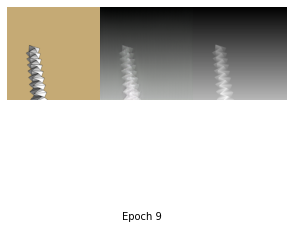

Epoch [10/50], Step [1/3750], D_loss: 0.0947, G_loss: 13.1486
Epoch [10/50], Step [2/3750], D_loss: 0.1297, G_loss: 5.6174
Epoch [10/50], Step [3/3750], D_loss: 0.4658, G_loss: 9.4978
Epoch [10/50], Step [4/3750], D_loss: 0.3510, G_loss: 3.6265
Epoch [10/50], Step [5/3750], D_loss: 0.0922, G_loss: 8.1174
Epoch [10/50], Step [6/3750], D_loss: 0.0870, G_loss: 9.2506
Epoch [10/50], Step [7/3750], D_loss: 0.3078, G_loss: 6.5484
Epoch [10/50], Step [8/3750], D_loss: 0.0228, G_loss: 7.4070
Epoch [10/50], Step [9/3750], D_loss: 0.4110, G_loss: 5.0279
Epoch [10/50], Step [10/3750], D_loss: 0.0928, G_loss: 6.8380
Epoch [10/50], Step [11/3750], D_loss: 0.0091, G_loss: 16.2639
Epoch [10/50], Step [12/3750], D_loss: 0.0453, G_loss: 11.2845
Epoch [10/50], Step [13/3750], D_loss: 0.4410, G_loss: 7.0356
Epoch [10/50], Step [14/3750], D_loss: 0.6631, G_loss: 4.6239
Epoch [10/50], Step [15/3750], D_loss: 0.5729, G_loss: 4.9890
Epoch [10/50], Step [16/3750], D_loss: 0.3039, G_loss: 5.3834
Epoch [10/50],

Epoch [10/50], Step [133/3750], D_loss: 0.3206, G_loss: 7.6589
Epoch [10/50], Step [134/3750], D_loss: 0.0591, G_loss: 10.1532
Epoch [10/50], Step [135/3750], D_loss: 0.1854, G_loss: 5.3897
Epoch [10/50], Step [136/3750], D_loss: 0.3619, G_loss: 11.9553
Epoch [10/50], Step [137/3750], D_loss: 0.0410, G_loss: 6.9934
Epoch [10/50], Step [138/3750], D_loss: 0.1471, G_loss: 12.0725
Epoch [10/50], Step [139/3750], D_loss: 0.0609, G_loss: 9.2180
Epoch [10/50], Step [140/3750], D_loss: 0.0844, G_loss: 6.9267
Epoch [10/50], Step [141/3750], D_loss: 0.1178, G_loss: 4.8724
Epoch [10/50], Step [142/3750], D_loss: 0.0643, G_loss: 8.5522
Epoch [10/50], Step [143/3750], D_loss: 0.3356, G_loss: 12.2370
Epoch [10/50], Step [144/3750], D_loss: 0.0488, G_loss: 11.6051
Epoch [10/50], Step [145/3750], D_loss: 0.5470, G_loss: 9.2003
Epoch [10/50], Step [146/3750], D_loss: 0.0918, G_loss: 5.4339
Epoch [10/50], Step [147/3750], D_loss: 0.2710, G_loss: 13.8895
Epoch [10/50], Step [148/3750], D_loss: 0.1512, G

Epoch [10/50], Step [263/3750], D_loss: 0.0510, G_loss: 11.7027
Epoch [10/50], Step [264/3750], D_loss: 0.5730, G_loss: 6.4155
Epoch [10/50], Step [265/3750], D_loss: 0.4546, G_loss: 5.5518
Epoch [10/50], Step [266/3750], D_loss: 0.0569, G_loss: 5.3910
Epoch [10/50], Step [267/3750], D_loss: 0.2088, G_loss: 5.4945
Epoch [10/50], Step [268/3750], D_loss: 0.1633, G_loss: 7.2024
Epoch [10/50], Step [269/3750], D_loss: 0.3687, G_loss: 4.0735
Epoch [10/50], Step [270/3750], D_loss: 0.2113, G_loss: 8.8525
Epoch [10/50], Step [271/3750], D_loss: 0.0475, G_loss: 9.3454
Epoch [10/50], Step [272/3750], D_loss: 0.1603, G_loss: 5.0398
Epoch [10/50], Step [273/3750], D_loss: 0.3445, G_loss: 6.4930
Epoch [10/50], Step [274/3750], D_loss: 0.7146, G_loss: 5.4450
Epoch [10/50], Step [275/3750], D_loss: 0.8508, G_loss: 3.6509
Epoch [10/50], Step [276/3750], D_loss: 0.3319, G_loss: 6.2492
Epoch [10/50], Step [277/3750], D_loss: 0.1895, G_loss: 5.7173
Epoch [10/50], Step [278/3750], D_loss: 0.0938, G_loss

Epoch [10/50], Step [393/3750], D_loss: 0.0114, G_loss: 14.5284
Epoch [10/50], Step [394/3750], D_loss: 0.0608, G_loss: 6.2081
Epoch [10/50], Step [395/3750], D_loss: 0.9674, G_loss: 18.0093
Epoch [10/50], Step [396/3750], D_loss: 0.3869, G_loss: 4.0803
Epoch [10/50], Step [397/3750], D_loss: 0.1901, G_loss: 9.6384
Epoch [10/50], Step [398/3750], D_loss: 0.2136, G_loss: 5.8464
Epoch [10/50], Step [399/3750], D_loss: 0.2072, G_loss: 5.9182
Epoch [10/50], Step [400/3750], D_loss: 0.0769, G_loss: 7.5434
Epoch [10/50], Step [401/3750], D_loss: 0.1171, G_loss: 4.7956
Epoch [10/50], Step [402/3750], D_loss: 0.2771, G_loss: 4.4946
Epoch [10/50], Step [403/3750], D_loss: 0.0454, G_loss: 6.4634
Epoch [10/50], Step [404/3750], D_loss: 0.1461, G_loss: 9.3503
Epoch [10/50], Step [405/3750], D_loss: 0.0585, G_loss: 12.1653
Epoch [10/50], Step [406/3750], D_loss: 0.1350, G_loss: 15.3007
Epoch [10/50], Step [407/3750], D_loss: 0.2022, G_loss: 8.4765
Epoch [10/50], Step [408/3750], D_loss: 0.5417, G_l

Epoch [10/50], Step [523/3750], D_loss: 0.0681, G_loss: 5.5456
Epoch [10/50], Step [524/3750], D_loss: 0.0931, G_loss: 11.6909
Epoch [10/50], Step [525/3750], D_loss: 0.1692, G_loss: 5.4411
Epoch [10/50], Step [526/3750], D_loss: 0.5698, G_loss: 9.9501
Epoch [10/50], Step [527/3750], D_loss: 0.2393, G_loss: 7.5443
Epoch [10/50], Step [528/3750], D_loss: 0.1690, G_loss: 9.2171
Epoch [10/50], Step [529/3750], D_loss: 0.3156, G_loss: 5.8786
Epoch [10/50], Step [530/3750], D_loss: 0.0348, G_loss: 7.0282
Epoch [10/50], Step [531/3750], D_loss: 0.4178, G_loss: 5.3749
Epoch [10/50], Step [532/3750], D_loss: 0.7309, G_loss: 4.2454
Epoch [10/50], Step [533/3750], D_loss: 0.4534, G_loss: 5.0512
Epoch [10/50], Step [534/3750], D_loss: 0.0648, G_loss: 8.1346
Epoch [10/50], Step [535/3750], D_loss: 0.0149, G_loss: 13.5830
Epoch [10/50], Step [536/3750], D_loss: 0.2324, G_loss: 6.6148
Epoch [10/50], Step [537/3750], D_loss: 0.1004, G_loss: 4.8465
Epoch [10/50], Step [538/3750], D_loss: 0.1000, G_los

Epoch [10/50], Step [653/3750], D_loss: 0.1157, G_loss: 11.0102
Epoch [10/50], Step [654/3750], D_loss: 0.1539, G_loss: 4.1628
Epoch [10/50], Step [655/3750], D_loss: 0.2725, G_loss: 5.9527
Epoch [10/50], Step [656/3750], D_loss: 0.1204, G_loss: 11.7132
Epoch [10/50], Step [657/3750], D_loss: 0.2214, G_loss: 15.9166
Epoch [10/50], Step [658/3750], D_loss: 0.2495, G_loss: 6.3193
Epoch [10/50], Step [659/3750], D_loss: 0.0709, G_loss: 13.7016
Epoch [10/50], Step [660/3750], D_loss: 0.6970, G_loss: 7.0638
Epoch [10/50], Step [661/3750], D_loss: 0.1702, G_loss: 6.5907
Epoch [10/50], Step [662/3750], D_loss: 0.4133, G_loss: 5.9487
Epoch [10/50], Step [663/3750], D_loss: 0.0757, G_loss: 11.6573
Epoch [10/50], Step [664/3750], D_loss: 0.2177, G_loss: 6.1939
Epoch [10/50], Step [665/3750], D_loss: 0.3423, G_loss: 5.2444
Epoch [10/50], Step [666/3750], D_loss: 0.3819, G_loss: 23.2187
Epoch [10/50], Step [667/3750], D_loss: 0.2206, G_loss: 13.4115
Epoch [10/50], Step [668/3750], D_loss: 0.4639, 

Epoch [10/50], Step [783/3750], D_loss: 0.2088, G_loss: 13.0249
Epoch [10/50], Step [784/3750], D_loss: 0.0291, G_loss: 11.4667
Epoch [10/50], Step [785/3750], D_loss: 0.4081, G_loss: 3.1306
Epoch [10/50], Step [786/3750], D_loss: 0.3578, G_loss: 3.8381
Epoch [10/50], Step [787/3750], D_loss: 0.2544, G_loss: 6.7240
Epoch [10/50], Step [788/3750], D_loss: 0.1178, G_loss: 6.5264
Epoch [10/50], Step [789/3750], D_loss: 0.1777, G_loss: 6.7987
Epoch [10/50], Step [790/3750], D_loss: 0.0918, G_loss: 12.3946
Epoch [10/50], Step [791/3750], D_loss: 0.1542, G_loss: 6.7175
Epoch [10/50], Step [792/3750], D_loss: 0.2194, G_loss: 6.2360
Epoch [10/50], Step [793/3750], D_loss: 0.2570, G_loss: 6.4893
Epoch [10/50], Step [794/3750], D_loss: 0.1919, G_loss: 7.3883
Epoch [10/50], Step [795/3750], D_loss: 0.4807, G_loss: 3.6311
Epoch [10/50], Step [796/3750], D_loss: 0.0665, G_loss: 5.8683
Epoch [10/50], Step [797/3750], D_loss: 0.0499, G_loss: 10.4628
Epoch [10/50], Step [798/3750], D_loss: 0.0760, G_l

Epoch [10/50], Step [913/3750], D_loss: 0.1881, G_loss: 7.3818
Epoch [10/50], Step [914/3750], D_loss: 0.2583, G_loss: 4.0902
Epoch [10/50], Step [915/3750], D_loss: 0.4283, G_loss: 5.5460
Epoch [10/50], Step [916/3750], D_loss: 0.0506, G_loss: 6.3105
Epoch [10/50], Step [917/3750], D_loss: 0.6457, G_loss: 5.0471
Epoch [10/50], Step [918/3750], D_loss: 0.2034, G_loss: 10.9893
Epoch [10/50], Step [919/3750], D_loss: 0.4247, G_loss: 7.3505
Epoch [10/50], Step [920/3750], D_loss: 0.1014, G_loss: 8.3629
Epoch [10/50], Step [921/3750], D_loss: 0.0777, G_loss: 6.9726
Epoch [10/50], Step [922/3750], D_loss: 0.4101, G_loss: 7.0334
Epoch [10/50], Step [923/3750], D_loss: 0.2006, G_loss: 5.3609
Epoch [10/50], Step [924/3750], D_loss: 0.1725, G_loss: 5.7037
Epoch [10/50], Step [925/3750], D_loss: 0.0829, G_loss: 5.7420
Epoch [10/50], Step [926/3750], D_loss: 0.4964, G_loss: 5.4386
Epoch [10/50], Step [927/3750], D_loss: 0.1926, G_loss: 5.2719
Epoch [10/50], Step [928/3750], D_loss: 0.1374, G_loss

Epoch [10/50], Step [1042/3750], D_loss: 0.5859, G_loss: 7.7721
Epoch [10/50], Step [1043/3750], D_loss: 0.0780, G_loss: 11.0058
Epoch [10/50], Step [1044/3750], D_loss: 0.3938, G_loss: 5.2666
Epoch [10/50], Step [1045/3750], D_loss: 0.3912, G_loss: 5.5195
Epoch [10/50], Step [1046/3750], D_loss: 0.0696, G_loss: 7.3207
Epoch [10/50], Step [1047/3750], D_loss: 0.8451, G_loss: 3.8697
Epoch [10/50], Step [1048/3750], D_loss: 0.3591, G_loss: 5.5899
Epoch [10/50], Step [1049/3750], D_loss: 0.5140, G_loss: 3.1709
Epoch [10/50], Step [1050/3750], D_loss: 0.1453, G_loss: 4.4637
Epoch [10/50], Step [1051/3750], D_loss: 0.1232, G_loss: 7.2824
Epoch [10/50], Step [1052/3750], D_loss: 0.5038, G_loss: 6.8762
Epoch [10/50], Step [1053/3750], D_loss: 0.0916, G_loss: 6.7854
Epoch [10/50], Step [1054/3750], D_loss: 0.1876, G_loss: 11.1868
Epoch [10/50], Step [1055/3750], D_loss: 0.0815, G_loss: 8.9464
Epoch [10/50], Step [1056/3750], D_loss: 0.2459, G_loss: 11.1475
Epoch [10/50], Step [1057/3750], D_lo

Epoch [10/50], Step [1170/3750], D_loss: 0.0725, G_loss: 9.0223
Epoch [10/50], Step [1171/3750], D_loss: 0.6498, G_loss: 3.8773
Epoch [10/50], Step [1172/3750], D_loss: 0.5254, G_loss: 6.2985
Epoch [10/50], Step [1173/3750], D_loss: 0.0770, G_loss: 5.5173
Epoch [10/50], Step [1174/3750], D_loss: 0.1132, G_loss: 4.7029
Epoch [10/50], Step [1175/3750], D_loss: 0.6295, G_loss: 8.1520
Epoch [10/50], Step [1176/3750], D_loss: 0.1550, G_loss: 16.4341
Epoch [10/50], Step [1177/3750], D_loss: 0.3938, G_loss: 4.1962
Epoch [10/50], Step [1178/3750], D_loss: 0.6151, G_loss: 6.1971
Epoch [10/50], Step [1179/3750], D_loss: 0.0387, G_loss: 7.9054
Epoch [10/50], Step [1180/3750], D_loss: 0.3728, G_loss: 7.3843
Epoch [10/50], Step [1181/3750], D_loss: 0.0786, G_loss: 7.6632
Epoch [10/50], Step [1182/3750], D_loss: 0.4799, G_loss: 8.1299
Epoch [10/50], Step [1183/3750], D_loss: 0.1589, G_loss: 8.9142
Epoch [10/50], Step [1184/3750], D_loss: 0.2049, G_loss: 6.1698
Epoch [10/50], Step [1185/3750], D_loss

Epoch [10/50], Step [1298/3750], D_loss: 0.0206, G_loss: 7.6430
Epoch [10/50], Step [1299/3750], D_loss: 0.0303, G_loss: 6.1321
Epoch [10/50], Step [1300/3750], D_loss: 0.2968, G_loss: 5.0495
Epoch [10/50], Step [1301/3750], D_loss: 0.1028, G_loss: 4.0202
Epoch [10/50], Step [1302/3750], D_loss: 0.2150, G_loss: 10.2597
Epoch [10/50], Step [1303/3750], D_loss: 0.0493, G_loss: 13.0798
Epoch [10/50], Step [1304/3750], D_loss: 0.1921, G_loss: 9.2212
Epoch [10/50], Step [1305/3750], D_loss: 0.1514, G_loss: 6.4399
Epoch [10/50], Step [1306/3750], D_loss: 0.1255, G_loss: 12.8908
Epoch [10/50], Step [1307/3750], D_loss: 0.0414, G_loss: 7.9858
Epoch [10/50], Step [1308/3750], D_loss: 0.2746, G_loss: 4.9343
Epoch [10/50], Step [1309/3750], D_loss: 0.2063, G_loss: 5.2692
Epoch [10/50], Step [1310/3750], D_loss: 0.1593, G_loss: 3.7852
Epoch [10/50], Step [1311/3750], D_loss: 0.1360, G_loss: 6.2382
Epoch [10/50], Step [1312/3750], D_loss: 0.1995, G_loss: 6.3229
Epoch [10/50], Step [1313/3750], D_lo

Epoch [10/50], Step [1426/3750], D_loss: 0.1478, G_loss: 8.7386
Epoch [10/50], Step [1427/3750], D_loss: 0.1632, G_loss: 5.0120
Epoch [10/50], Step [1428/3750], D_loss: 0.3271, G_loss: 9.6184
Epoch [10/50], Step [1429/3750], D_loss: 0.2711, G_loss: 6.0331
Epoch [10/50], Step [1430/3750], D_loss: 0.3425, G_loss: 4.7718
Epoch [10/50], Step [1431/3750], D_loss: 0.1949, G_loss: 4.9874
Epoch [10/50], Step [1432/3750], D_loss: 0.7933, G_loss: 6.0793
Epoch [10/50], Step [1433/3750], D_loss: 0.1760, G_loss: 5.4464
Epoch [10/50], Step [1434/3750], D_loss: 0.2430, G_loss: 3.7661
Epoch [10/50], Step [1435/3750], D_loss: 1.0243, G_loss: 2.9100
Epoch [10/50], Step [1436/3750], D_loss: 0.4107, G_loss: 5.7986
Epoch [10/50], Step [1437/3750], D_loss: 0.1427, G_loss: 12.8788
Epoch [10/50], Step [1438/3750], D_loss: 0.4923, G_loss: 7.2911
Epoch [10/50], Step [1439/3750], D_loss: 0.1556, G_loss: 9.2216
Epoch [10/50], Step [1440/3750], D_loss: 0.0506, G_loss: 14.8913
Epoch [10/50], Step [1441/3750], D_los

Epoch [10/50], Step [1554/3750], D_loss: 0.2079, G_loss: 12.1253
Epoch [10/50], Step [1555/3750], D_loss: 0.0794, G_loss: 8.1028
Epoch [10/50], Step [1556/3750], D_loss: 0.3938, G_loss: 7.6956
Epoch [10/50], Step [1557/3750], D_loss: 0.1032, G_loss: 11.6066
Epoch [10/50], Step [1558/3750], D_loss: 0.1817, G_loss: 6.7687
Epoch [10/50], Step [1559/3750], D_loss: 0.2545, G_loss: 9.1502
Epoch [10/50], Step [1560/3750], D_loss: 0.2911, G_loss: 6.5824
Epoch [10/50], Step [1561/3750], D_loss: 0.5603, G_loss: 4.6513
Epoch [10/50], Step [1562/3750], D_loss: 0.3545, G_loss: 6.1224
Epoch [10/50], Step [1563/3750], D_loss: 0.1619, G_loss: 5.6430
Epoch [10/50], Step [1564/3750], D_loss: 0.1822, G_loss: 9.5608
Epoch [10/50], Step [1565/3750], D_loss: 0.0812, G_loss: 6.3833
Epoch [10/50], Step [1566/3750], D_loss: 0.1563, G_loss: 6.2702
Epoch [10/50], Step [1567/3750], D_loss: 0.5816, G_loss: 8.5192
Epoch [10/50], Step [1568/3750], D_loss: 0.1440, G_loss: 8.4592
Epoch [10/50], Step [1569/3750], D_los

Epoch [10/50], Step [1682/3750], D_loss: 0.0778, G_loss: 12.8497
Epoch [10/50], Step [1683/3750], D_loss: 0.0724, G_loss: 6.0477
Epoch [10/50], Step [1684/3750], D_loss: 0.0779, G_loss: 7.5631
Epoch [10/50], Step [1685/3750], D_loss: 0.2225, G_loss: 6.0436
Epoch [10/50], Step [1686/3750], D_loss: 0.1107, G_loss: 11.9257
Epoch [10/50], Step [1687/3750], D_loss: 0.2277, G_loss: 7.6256
Epoch [10/50], Step [1688/3750], D_loss: 0.1682, G_loss: 5.7946
Epoch [10/50], Step [1689/3750], D_loss: 0.1209, G_loss: 22.0974
Epoch [10/50], Step [1690/3750], D_loss: 0.1768, G_loss: 15.8899
Epoch [10/50], Step [1691/3750], D_loss: 0.0493, G_loss: 8.5982
Epoch [10/50], Step [1692/3750], D_loss: 0.0503, G_loss: 16.3688
Epoch [10/50], Step [1693/3750], D_loss: 0.1082, G_loss: 5.8365
Epoch [10/50], Step [1694/3750], D_loss: 0.3676, G_loss: 5.6068
Epoch [10/50], Step [1695/3750], D_loss: 0.0396, G_loss: 6.6705
Epoch [10/50], Step [1696/3750], D_loss: 0.3411, G_loss: 4.8980
Epoch [10/50], Step [1697/3750], D_

Epoch [10/50], Step [1810/3750], D_loss: 0.0297, G_loss: 8.9220
Epoch [10/50], Step [1811/3750], D_loss: 0.0736, G_loss: 7.0940
Epoch [10/50], Step [1812/3750], D_loss: 0.0576, G_loss: 4.9546
Epoch [10/50], Step [1813/3750], D_loss: 0.0831, G_loss: 6.3660
Epoch [10/50], Step [1814/3750], D_loss: 0.0815, G_loss: 13.6687
Epoch [10/50], Step [1815/3750], D_loss: 0.4514, G_loss: 3.5454
Epoch [10/50], Step [1816/3750], D_loss: 0.0531, G_loss: 12.1982
Epoch [10/50], Step [1817/3750], D_loss: 0.0393, G_loss: 8.8912
Epoch [10/50], Step [1818/3750], D_loss: 0.3876, G_loss: 4.8020
Epoch [10/50], Step [1819/3750], D_loss: 0.4167, G_loss: 10.7707
Epoch [10/50], Step [1820/3750], D_loss: 0.1223, G_loss: 6.5665
Epoch [10/50], Step [1821/3750], D_loss: 0.1520, G_loss: 14.2140
Epoch [10/50], Step [1822/3750], D_loss: 0.0492, G_loss: 14.1547
Epoch [10/50], Step [1823/3750], D_loss: 0.2693, G_loss: 8.8292
Epoch [10/50], Step [1824/3750], D_loss: 0.1387, G_loss: 7.2588
Epoch [10/50], Step [1825/3750], D_

Epoch [10/50], Step [1938/3750], D_loss: 0.1842, G_loss: 5.2544
Epoch [10/50], Step [1939/3750], D_loss: 0.3496, G_loss: 4.7573
Epoch [10/50], Step [1940/3750], D_loss: 0.2779, G_loss: 5.6755
Epoch [10/50], Step [1941/3750], D_loss: 0.6534, G_loss: 5.3010
Epoch [10/50], Step [1942/3750], D_loss: 0.1917, G_loss: 8.1205
Epoch [10/50], Step [1943/3750], D_loss: 0.4782, G_loss: 11.5274
Epoch [10/50], Step [1944/3750], D_loss: 0.3118, G_loss: 6.6545
Epoch [10/50], Step [1945/3750], D_loss: 0.5438, G_loss: 7.2784
Epoch [10/50], Step [1946/3750], D_loss: 0.5340, G_loss: 6.4936
Epoch [10/50], Step [1947/3750], D_loss: 0.6010, G_loss: 4.7149
Epoch [10/50], Step [1948/3750], D_loss: 0.1634, G_loss: 7.5298
Epoch [10/50], Step [1949/3750], D_loss: 0.1319, G_loss: 13.1194
Epoch [10/50], Step [1950/3750], D_loss: 0.3164, G_loss: 6.0395
Epoch [10/50], Step [1951/3750], D_loss: 0.3650, G_loss: 4.5993
Epoch [10/50], Step [1952/3750], D_loss: 0.0297, G_loss: 9.2587
Epoch [10/50], Step [1953/3750], D_los

Epoch [10/50], Step [2066/3750], D_loss: 0.0519, G_loss: 11.8499
Epoch [10/50], Step [2067/3750], D_loss: 0.2496, G_loss: 6.9177
Epoch [10/50], Step [2068/3750], D_loss: 0.0463, G_loss: 12.7253
Epoch [10/50], Step [2069/3750], D_loss: 0.5006, G_loss: 5.3759
Epoch [10/50], Step [2070/3750], D_loss: 0.5764, G_loss: 3.1944
Epoch [10/50], Step [2071/3750], D_loss: 0.1583, G_loss: 5.6529
Epoch [10/50], Step [2072/3750], D_loss: 0.1398, G_loss: 9.5497
Epoch [10/50], Step [2073/3750], D_loss: 0.4159, G_loss: 5.5421
Epoch [10/50], Step [2074/3750], D_loss: 0.1081, G_loss: 11.7245
Epoch [10/50], Step [2075/3750], D_loss: 0.1080, G_loss: 7.4547
Epoch [10/50], Step [2076/3750], D_loss: 0.1034, G_loss: 6.6975
Epoch [10/50], Step [2077/3750], D_loss: 0.0678, G_loss: 9.5827
Epoch [10/50], Step [2078/3750], D_loss: 0.2940, G_loss: 4.8239
Epoch [10/50], Step [2079/3750], D_loss: 0.3046, G_loss: 8.5401
Epoch [10/50], Step [2080/3750], D_loss: 0.2918, G_loss: 6.9230
Epoch [10/50], Step [2081/3750], D_lo

Epoch [10/50], Step [2194/3750], D_loss: 0.0437, G_loss: 13.7298
Epoch [10/50], Step [2195/3750], D_loss: 0.2173, G_loss: 10.3411
Epoch [10/50], Step [2196/3750], D_loss: 0.1490, G_loss: 9.1824
Epoch [10/50], Step [2197/3750], D_loss: 0.1806, G_loss: 10.1531
Epoch [10/50], Step [2198/3750], D_loss: 0.0545, G_loss: 11.0255
Epoch [10/50], Step [2199/3750], D_loss: 0.0325, G_loss: 13.7294
Epoch [10/50], Step [2200/3750], D_loss: 0.6133, G_loss: 9.6383
Epoch [10/50], Step [2201/3750], D_loss: 0.1389, G_loss: 10.8353
Epoch [10/50], Step [2202/3750], D_loss: 0.2234, G_loss: 12.5599
Epoch [10/50], Step [2203/3750], D_loss: 0.1629, G_loss: 8.2189
Epoch [10/50], Step [2204/3750], D_loss: 0.2405, G_loss: 7.2140
Epoch [10/50], Step [2205/3750], D_loss: 0.0490, G_loss: 10.2003
Epoch [10/50], Step [2206/3750], D_loss: 0.1387, G_loss: 7.9591
Epoch [10/50], Step [2207/3750], D_loss: 0.3097, G_loss: 6.3722
Epoch [10/50], Step [2208/3750], D_loss: 0.0169, G_loss: 10.9275
Epoch [10/50], Step [2209/3750]

Epoch [10/50], Step [2322/3750], D_loss: 0.4007, G_loss: 3.4389
Epoch [10/50], Step [2323/3750], D_loss: 0.1877, G_loss: 4.8377
Epoch [10/50], Step [2324/3750], D_loss: 0.4857, G_loss: 7.6735
Epoch [10/50], Step [2325/3750], D_loss: 0.2604, G_loss: 5.8734
Epoch [10/50], Step [2326/3750], D_loss: 0.3531, G_loss: 5.2078
Epoch [10/50], Step [2327/3750], D_loss: 0.3745, G_loss: 8.1710
Epoch [10/50], Step [2328/3750], D_loss: 0.1562, G_loss: 5.6972
Epoch [10/50], Step [2329/3750], D_loss: 0.0727, G_loss: 11.7597
Epoch [10/50], Step [2330/3750], D_loss: 0.1759, G_loss: 5.2936
Epoch [10/50], Step [2331/3750], D_loss: 0.0865, G_loss: 10.5144
Epoch [10/50], Step [2332/3750], D_loss: 0.2784, G_loss: 4.0101
Epoch [10/50], Step [2333/3750], D_loss: 0.5826, G_loss: 7.7986
Epoch [10/50], Step [2334/3750], D_loss: 0.3449, G_loss: 6.9194
Epoch [10/50], Step [2335/3750], D_loss: 0.4917, G_loss: 6.1281
Epoch [10/50], Step [2336/3750], D_loss: 0.3977, G_loss: 5.9514
Epoch [10/50], Step [2337/3750], D_los

Epoch [10/50], Step [2450/3750], D_loss: 0.0830, G_loss: 5.1337
Epoch [10/50], Step [2451/3750], D_loss: 0.1218, G_loss: 11.7661
Epoch [10/50], Step [2452/3750], D_loss: 0.0453, G_loss: 13.6107
Epoch [10/50], Step [2453/3750], D_loss: 0.0263, G_loss: 6.3767
Epoch [10/50], Step [2454/3750], D_loss: 0.0970, G_loss: 9.2841
Epoch [10/50], Step [2455/3750], D_loss: 0.1417, G_loss: 4.5842
Epoch [10/50], Step [2456/3750], D_loss: 0.3360, G_loss: 15.3471
Epoch [10/50], Step [2457/3750], D_loss: 0.2230, G_loss: 22.0982
Epoch [10/50], Step [2458/3750], D_loss: 0.4238, G_loss: 5.6203
Epoch [10/50], Step [2459/3750], D_loss: 0.3258, G_loss: 3.3017
Epoch [10/50], Step [2460/3750], D_loss: 0.0609, G_loss: 8.4179
Epoch [10/50], Step [2461/3750], D_loss: 0.0534, G_loss: 12.6038
Epoch [10/50], Step [2462/3750], D_loss: 0.2323, G_loss: 5.4978
Epoch [10/50], Step [2463/3750], D_loss: 0.7336, G_loss: 3.8858
Epoch [10/50], Step [2464/3750], D_loss: 0.2070, G_loss: 6.6704
Epoch [10/50], Step [2465/3750], D_

Epoch [10/50], Step [2578/3750], D_loss: 0.2805, G_loss: 10.4563
Epoch [10/50], Step [2579/3750], D_loss: 0.2002, G_loss: 5.7056
Epoch [10/50], Step [2580/3750], D_loss: 0.7795, G_loss: 4.1983
Epoch [10/50], Step [2581/3750], D_loss: 0.1246, G_loss: 4.9574
Epoch [10/50], Step [2582/3750], D_loss: 0.3594, G_loss: 4.8551
Epoch [10/50], Step [2583/3750], D_loss: 0.2875, G_loss: 7.1649
Epoch [10/50], Step [2584/3750], D_loss: 0.0993, G_loss: 5.2807
Epoch [10/50], Step [2585/3750], D_loss: 0.1087, G_loss: 5.7276
Epoch [10/50], Step [2586/3750], D_loss: 0.3233, G_loss: 8.5380
Epoch [10/50], Step [2587/3750], D_loss: 0.0587, G_loss: 12.7174
Epoch [10/50], Step [2588/3750], D_loss: 0.2780, G_loss: 10.6153
Epoch [10/50], Step [2589/3750], D_loss: 0.1857, G_loss: 10.1269
Epoch [10/50], Step [2590/3750], D_loss: 0.4381, G_loss: 7.7496
Epoch [10/50], Step [2591/3750], D_loss: 0.2170, G_loss: 9.1493
Epoch [10/50], Step [2592/3750], D_loss: 0.1730, G_loss: 4.7823
Epoch [10/50], Step [2593/3750], D_l

Epoch [10/50], Step [2706/3750], D_loss: 0.5166, G_loss: 4.5193
Epoch [10/50], Step [2707/3750], D_loss: 0.4805, G_loss: 3.0030
Epoch [10/50], Step [2708/3750], D_loss: 0.3344, G_loss: 4.1802
Epoch [10/50], Step [2709/3750], D_loss: 0.0379, G_loss: 16.8865
Epoch [10/50], Step [2710/3750], D_loss: 0.4818, G_loss: 6.1274
Epoch [10/50], Step [2711/3750], D_loss: 0.3522, G_loss: 4.2359
Epoch [10/50], Step [2712/3750], D_loss: 0.1309, G_loss: 8.2877
Epoch [10/50], Step [2713/3750], D_loss: 0.2283, G_loss: 13.4159
Epoch [10/50], Step [2714/3750], D_loss: 0.1194, G_loss: 7.7354
Epoch [10/50], Step [2715/3750], D_loss: 0.1011, G_loss: 10.5515
Epoch [10/50], Step [2716/3750], D_loss: 0.1269, G_loss: 6.6417
Epoch [10/50], Step [2717/3750], D_loss: 0.0702, G_loss: 5.2927
Epoch [10/50], Step [2718/3750], D_loss: 0.1176, G_loss: 13.5470
Epoch [10/50], Step [2719/3750], D_loss: 0.4461, G_loss: 5.9281
Epoch [10/50], Step [2720/3750], D_loss: 0.2023, G_loss: 10.3175
Epoch [10/50], Step [2721/3750], D_

Epoch [10/50], Step [2834/3750], D_loss: 0.1262, G_loss: 8.2104
Epoch [10/50], Step [2835/3750], D_loss: 0.2017, G_loss: 9.3530
Epoch [10/50], Step [2836/3750], D_loss: 0.2237, G_loss: 4.8633
Epoch [10/50], Step [2837/3750], D_loss: 0.1107, G_loss: 13.8807
Epoch [10/50], Step [2838/3750], D_loss: 0.3650, G_loss: 8.0224
Epoch [10/50], Step [2839/3750], D_loss: 0.0734, G_loss: 9.8264
Epoch [10/50], Step [2840/3750], D_loss: 0.2943, G_loss: 10.1986
Epoch [10/50], Step [2841/3750], D_loss: 0.4076, G_loss: 7.1863
Epoch [10/50], Step [2842/3750], D_loss: 0.0644, G_loss: 6.5710
Epoch [10/50], Step [2843/3750], D_loss: 0.1693, G_loss: 5.9646
Epoch [10/50], Step [2844/3750], D_loss: 0.8833, G_loss: 4.9189
Epoch [10/50], Step [2845/3750], D_loss: 0.1440, G_loss: 9.0695
Epoch [10/50], Step [2846/3750], D_loss: 0.1528, G_loss: 5.1096
Epoch [10/50], Step [2847/3750], D_loss: 0.0923, G_loss: 11.5476
Epoch [10/50], Step [2848/3750], D_loss: 0.4007, G_loss: 6.7938
Epoch [10/50], Step [2849/3750], D_lo

Epoch [10/50], Step [2962/3750], D_loss: 0.2287, G_loss: 4.0849
Epoch [10/50], Step [2963/3750], D_loss: 0.0650, G_loss: 11.2217
Epoch [10/50], Step [2964/3750], D_loss: 0.2108, G_loss: 5.0561
Epoch [10/50], Step [2965/3750], D_loss: 0.6151, G_loss: 5.4380
Epoch [10/50], Step [2966/3750], D_loss: 0.0691, G_loss: 8.7675
Epoch [10/50], Step [2967/3750], D_loss: 0.2113, G_loss: 9.4711
Epoch [10/50], Step [2968/3750], D_loss: 0.1473, G_loss: 6.0478
Epoch [10/50], Step [2969/3750], D_loss: 0.0810, G_loss: 5.5599
Epoch [10/50], Step [2970/3750], D_loss: 0.2126, G_loss: 8.0433
Epoch [10/50], Step [2971/3750], D_loss: 0.1381, G_loss: 6.6387
Epoch [10/50], Step [2972/3750], D_loss: 0.4971, G_loss: 6.8710
Epoch [10/50], Step [2973/3750], D_loss: 0.2301, G_loss: 5.1752
Epoch [10/50], Step [2974/3750], D_loss: 0.0703, G_loss: 5.8552
Epoch [10/50], Step [2975/3750], D_loss: 0.1652, G_loss: 7.7889
Epoch [10/50], Step [2976/3750], D_loss: 0.2129, G_loss: 7.9900
Epoch [10/50], Step [2977/3750], D_loss

Epoch [10/50], Step [3090/3750], D_loss: 0.1399, G_loss: 5.7729
Epoch [10/50], Step [3091/3750], D_loss: 0.0888, G_loss: 15.7782
Epoch [10/50], Step [3092/3750], D_loss: 0.3560, G_loss: 5.7064
Epoch [10/50], Step [3093/3750], D_loss: 0.3930, G_loss: 5.8176
Epoch [10/50], Step [3094/3750], D_loss: 0.0246, G_loss: 11.1827
Epoch [10/50], Step [3095/3750], D_loss: 0.0836, G_loss: 9.4613
Epoch [10/50], Step [3096/3750], D_loss: 0.0407, G_loss: 9.9925
Epoch [10/50], Step [3097/3750], D_loss: 0.0524, G_loss: 6.1562
Epoch [10/50], Step [3098/3750], D_loss: 0.2726, G_loss: 13.2190
Epoch [10/50], Step [3099/3750], D_loss: 0.1224, G_loss: 14.6628
Epoch [10/50], Step [3100/3750], D_loss: 0.1807, G_loss: 5.0405
Epoch [10/50], Step [3101/3750], D_loss: 0.3709, G_loss: 9.5602
Epoch [10/50], Step [3102/3750], D_loss: 0.0318, G_loss: 11.6184
Epoch [10/50], Step [3103/3750], D_loss: 0.2227, G_loss: 9.6751
Epoch [10/50], Step [3104/3750], D_loss: 0.1481, G_loss: 8.4099
Epoch [10/50], Step [3105/3750], D_

Epoch [10/50], Step [3218/3750], D_loss: 0.3079, G_loss: 8.7247
Epoch [10/50], Step [3219/3750], D_loss: 0.4123, G_loss: 4.9849
Epoch [10/50], Step [3220/3750], D_loss: 0.4376, G_loss: 4.8348
Epoch [10/50], Step [3221/3750], D_loss: 0.0576, G_loss: 7.5347
Epoch [10/50], Step [3222/3750], D_loss: 0.3295, G_loss: 9.5891
Epoch [10/50], Step [3223/3750], D_loss: 0.9596, G_loss: 6.5359
Epoch [10/50], Step [3224/3750], D_loss: 0.2212, G_loss: 5.9253
Epoch [10/50], Step [3225/3750], D_loss: 0.0368, G_loss: 6.7414
Epoch [10/50], Step [3226/3750], D_loss: 0.1518, G_loss: 5.4131
Epoch [10/50], Step [3227/3750], D_loss: 0.3444, G_loss: 5.0593
Epoch [10/50], Step [3228/3750], D_loss: 0.3231, G_loss: 5.0993
Epoch [10/50], Step [3229/3750], D_loss: 0.3221, G_loss: 8.8755
Epoch [10/50], Step [3230/3750], D_loss: 0.2188, G_loss: 4.9966
Epoch [10/50], Step [3231/3750], D_loss: 0.0480, G_loss: 10.0265
Epoch [10/50], Step [3232/3750], D_loss: 0.5301, G_loss: 5.2180
Epoch [10/50], Step [3233/3750], D_loss

Epoch [10/50], Step [3346/3750], D_loss: 0.2397, G_loss: 5.5760
Epoch [10/50], Step [3347/3750], D_loss: 0.0413, G_loss: 11.3479
Epoch [10/50], Step [3348/3750], D_loss: 0.1401, G_loss: 5.4386
Epoch [10/50], Step [3349/3750], D_loss: 0.2536, G_loss: 5.4515
Epoch [10/50], Step [3350/3750], D_loss: 0.3020, G_loss: 3.9074
Epoch [10/50], Step [3351/3750], D_loss: 0.1167, G_loss: 6.4690
Epoch [10/50], Step [3352/3750], D_loss: 0.3216, G_loss: 16.6879
Epoch [10/50], Step [3353/3750], D_loss: 0.1327, G_loss: 10.0099
Epoch [10/50], Step [3354/3750], D_loss: 0.3420, G_loss: 5.0113
Epoch [10/50], Step [3355/3750], D_loss: 0.0155, G_loss: 8.4294
Epoch [10/50], Step [3356/3750], D_loss: 0.1237, G_loss: 4.8993
Epoch [10/50], Step [3357/3750], D_loss: 0.2023, G_loss: 10.2291
Epoch [10/50], Step [3358/3750], D_loss: 0.1310, G_loss: 10.1845
Epoch [10/50], Step [3359/3750], D_loss: 0.1383, G_loss: 5.8237
Epoch [10/50], Step [3360/3750], D_loss: 0.1301, G_loss: 6.3099
Epoch [10/50], Step [3361/3750], D_

Epoch [10/50], Step [3474/3750], D_loss: 0.2090, G_loss: 7.4636
Epoch [10/50], Step [3475/3750], D_loss: 0.1220, G_loss: 5.3774
Epoch [10/50], Step [3476/3750], D_loss: 0.4044, G_loss: 3.5064
Epoch [10/50], Step [3477/3750], D_loss: 0.0652, G_loss: 6.1394
Epoch [10/50], Step [3478/3750], D_loss: 0.1786, G_loss: 4.4502
Epoch [10/50], Step [3479/3750], D_loss: 0.1599, G_loss: 10.4752
Epoch [10/50], Step [3480/3750], D_loss: 0.4335, G_loss: 4.6499
Epoch [10/50], Step [3481/3750], D_loss: 0.2674, G_loss: 8.0964
Epoch [10/50], Step [3482/3750], D_loss: 0.1000, G_loss: 6.1972
Epoch [10/50], Step [3483/3750], D_loss: 0.2086, G_loss: 6.8349
Epoch [10/50], Step [3484/3750], D_loss: 0.2182, G_loss: 7.2424
Epoch [10/50], Step [3485/3750], D_loss: 0.0832, G_loss: 7.2953
Epoch [10/50], Step [3486/3750], D_loss: 0.1535, G_loss: 5.9280
Epoch [10/50], Step [3487/3750], D_loss: 0.4243, G_loss: 7.0536
Epoch [10/50], Step [3488/3750], D_loss: 0.1885, G_loss: 5.4576
Epoch [10/50], Step [3489/3750], D_loss

Epoch [10/50], Step [3602/3750], D_loss: 0.5794, G_loss: 3.7250
Epoch [10/50], Step [3603/3750], D_loss: 0.2023, G_loss: 3.2870
Epoch [10/50], Step [3604/3750], D_loss: 0.1176, G_loss: 5.9710
Epoch [10/50], Step [3605/3750], D_loss: 0.6976, G_loss: 4.1411
Epoch [10/50], Step [3606/3750], D_loss: 0.3399, G_loss: 9.3319
Epoch [10/50], Step [3607/3750], D_loss: 0.1632, G_loss: 10.2393
Epoch [10/50], Step [3608/3750], D_loss: 0.3717, G_loss: 3.9592
Epoch [10/50], Step [3609/3750], D_loss: 0.0673, G_loss: 6.9484
Epoch [10/50], Step [3610/3750], D_loss: 0.0455, G_loss: 15.0491
Epoch [10/50], Step [3611/3750], D_loss: 0.3885, G_loss: 4.7843
Epoch [10/50], Step [3612/3750], D_loss: 0.4899, G_loss: 11.9552
Epoch [10/50], Step [3613/3750], D_loss: 0.5790, G_loss: 4.2520
Epoch [10/50], Step [3614/3750], D_loss: 0.0975, G_loss: 4.8933
Epoch [10/50], Step [3615/3750], D_loss: 0.2470, G_loss: 5.6459
Epoch [10/50], Step [3616/3750], D_loss: 0.1943, G_loss: 7.5787
Epoch [10/50], Step [3617/3750], D_lo

Epoch [10/50], Step [3730/3750], D_loss: 0.0178, G_loss: 8.2860
Epoch [10/50], Step [3731/3750], D_loss: 0.3168, G_loss: 5.2897
Epoch [10/50], Step [3732/3750], D_loss: 0.1025, G_loss: 7.1057
Epoch [10/50], Step [3733/3750], D_loss: 0.4892, G_loss: 5.7379
Epoch [10/50], Step [3734/3750], D_loss: 0.3496, G_loss: 9.0939
Epoch [10/50], Step [3735/3750], D_loss: 0.1615, G_loss: 4.5442
Epoch [10/50], Step [3736/3750], D_loss: 0.4421, G_loss: 5.1470
Epoch [10/50], Step [3737/3750], D_loss: 0.3500, G_loss: 5.3857
Epoch [10/50], Step [3738/3750], D_loss: 0.0925, G_loss: 7.9966
Epoch [10/50], Step [3739/3750], D_loss: 0.3119, G_loss: 17.7616
Epoch [10/50], Step [3740/3750], D_loss: 0.0842, G_loss: 8.8744
Epoch [10/50], Step [3741/3750], D_loss: 0.3561, G_loss: 3.9753
Epoch [10/50], Step [3742/3750], D_loss: 0.1085, G_loss: 4.2991
Epoch [10/50], Step [3743/3750], D_loss: 0.0548, G_loss: 8.6642
Epoch [10/50], Step [3744/3750], D_loss: 0.1787, G_loss: 5.0022
Epoch [10/50], Step [3745/3750], D_loss

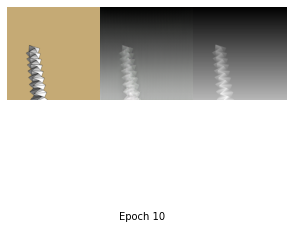

Epoch [11/50], Step [1/3750], D_loss: 0.0463, G_loss: 9.5035
Epoch [11/50], Step [2/3750], D_loss: 0.0458, G_loss: 11.7596
Epoch [11/50], Step [3/3750], D_loss: 0.2455, G_loss: 8.2540
Epoch [11/50], Step [4/3750], D_loss: 0.4657, G_loss: 4.9117
Epoch [11/50], Step [5/3750], D_loss: 0.4888, G_loss: 8.3028
Epoch [11/50], Step [6/3750], D_loss: 0.0541, G_loss: 7.6020
Epoch [11/50], Step [7/3750], D_loss: 0.1401, G_loss: 5.4362
Epoch [11/50], Step [8/3750], D_loss: 0.1006, G_loss: 5.9042
Epoch [11/50], Step [9/3750], D_loss: 0.1941, G_loss: 5.4497
Epoch [11/50], Step [10/3750], D_loss: 0.4355, G_loss: 7.6282
Epoch [11/50], Step [11/3750], D_loss: 0.0954, G_loss: 5.6460
Epoch [11/50], Step [12/3750], D_loss: 0.4534, G_loss: 4.9823
Epoch [11/50], Step [13/3750], D_loss: 0.2051, G_loss: 9.3795
Epoch [11/50], Step [14/3750], D_loss: 0.1881, G_loss: 5.6241
Epoch [11/50], Step [15/3750], D_loss: 0.2147, G_loss: 7.6148
Epoch [11/50], Step [16/3750], D_loss: 0.4571, G_loss: 4.2061
Epoch [11/50], S

Epoch [11/50], Step [133/3750], D_loss: 0.5010, G_loss: 5.3379
Epoch [11/50], Step [134/3750], D_loss: 0.5094, G_loss: 8.4040
Epoch [11/50], Step [135/3750], D_loss: 0.0368, G_loss: 5.1520
Epoch [11/50], Step [136/3750], D_loss: 0.2018, G_loss: 12.7844
Epoch [11/50], Step [137/3750], D_loss: 0.1447, G_loss: 11.9714
Epoch [11/50], Step [138/3750], D_loss: 0.0550, G_loss: 7.1808
Epoch [11/50], Step [139/3750], D_loss: 0.0687, G_loss: 7.4678
Epoch [11/50], Step [140/3750], D_loss: 0.4053, G_loss: 5.3045
Epoch [11/50], Step [141/3750], D_loss: 0.0374, G_loss: 7.6131
Epoch [11/50], Step [142/3750], D_loss: 0.4459, G_loss: 3.6743
Epoch [11/50], Step [143/3750], D_loss: 0.0674, G_loss: 4.0015
Epoch [11/50], Step [144/3750], D_loss: 0.0801, G_loss: 5.4360
Epoch [11/50], Step [145/3750], D_loss: 0.0797, G_loss: 3.9976
Epoch [11/50], Step [146/3750], D_loss: 0.2156, G_loss: 5.8848
Epoch [11/50], Step [147/3750], D_loss: 0.3878, G_loss: 4.2901
Epoch [11/50], Step [148/3750], D_loss: 1.0226, G_los

Epoch [11/50], Step [263/3750], D_loss: 0.2177, G_loss: 9.8399
Epoch [11/50], Step [264/3750], D_loss: 0.1410, G_loss: 13.1575
Epoch [11/50], Step [265/3750], D_loss: 0.0313, G_loss: 9.4715
Epoch [11/50], Step [266/3750], D_loss: 0.1707, G_loss: 5.7662
Epoch [11/50], Step [267/3750], D_loss: 0.0110, G_loss: 10.6668
Epoch [11/50], Step [268/3750], D_loss: 0.6905, G_loss: 3.9019
Epoch [11/50], Step [269/3750], D_loss: 0.1885, G_loss: 5.0031
Epoch [11/50], Step [270/3750], D_loss: 0.2481, G_loss: 9.7356
Epoch [11/50], Step [271/3750], D_loss: 0.0231, G_loss: 12.7455
Epoch [11/50], Step [272/3750], D_loss: 0.4347, G_loss: 4.9671
Epoch [11/50], Step [273/3750], D_loss: 0.0705, G_loss: 4.4925
Epoch [11/50], Step [274/3750], D_loss: 0.0086, G_loss: 9.1355
Epoch [11/50], Step [275/3750], D_loss: 0.4396, G_loss: 3.5550
Epoch [11/50], Step [276/3750], D_loss: 0.1331, G_loss: 5.8229
Epoch [11/50], Step [277/3750], D_loss: 0.6126, G_loss: 5.4609
Epoch [11/50], Step [278/3750], D_loss: 0.0394, G_lo

Epoch [11/50], Step [393/3750], D_loss: 0.1489, G_loss: 7.0742
Epoch [11/50], Step [394/3750], D_loss: 0.1116, G_loss: 5.4750
Epoch [11/50], Step [395/3750], D_loss: 0.3320, G_loss: 7.0247
Epoch [11/50], Step [396/3750], D_loss: 0.0465, G_loss: 6.9405
Epoch [11/50], Step [397/3750], D_loss: 0.0820, G_loss: 6.2670
Epoch [11/50], Step [398/3750], D_loss: 0.2154, G_loss: 5.6913
Epoch [11/50], Step [399/3750], D_loss: 0.2029, G_loss: 6.5866
Epoch [11/50], Step [400/3750], D_loss: 0.1435, G_loss: 7.6393
Epoch [11/50], Step [401/3750], D_loss: 0.1738, G_loss: 7.9752
Epoch [11/50], Step [402/3750], D_loss: 0.0692, G_loss: 9.5326
Epoch [11/50], Step [403/3750], D_loss: 0.0806, G_loss: 5.1623
Epoch [11/50], Step [404/3750], D_loss: 0.3260, G_loss: 11.6227
Epoch [11/50], Step [405/3750], D_loss: 0.1942, G_loss: 4.5112
Epoch [11/50], Step [406/3750], D_loss: 0.1215, G_loss: 6.8062
Epoch [11/50], Step [407/3750], D_loss: 0.1186, G_loss: 9.4339
Epoch [11/50], Step [408/3750], D_loss: 0.0600, G_loss

Epoch [11/50], Step [523/3750], D_loss: 0.4392, G_loss: 11.5548
Epoch [11/50], Step [524/3750], D_loss: 0.1122, G_loss: 8.3549
Epoch [11/50], Step [525/3750], D_loss: 0.0096, G_loss: 10.2451
Epoch [11/50], Step [526/3750], D_loss: 0.4797, G_loss: 6.8082
Epoch [11/50], Step [527/3750], D_loss: 0.0267, G_loss: 12.8865
Epoch [11/50], Step [528/3750], D_loss: 0.1310, G_loss: 7.5702
Epoch [11/50], Step [529/3750], D_loss: 0.0231, G_loss: 6.6592
Epoch [11/50], Step [530/3750], D_loss: 0.0175, G_loss: 7.6031
Epoch [11/50], Step [531/3750], D_loss: 0.0223, G_loss: 7.3780
Epoch [11/50], Step [532/3750], D_loss: 0.1264, G_loss: 4.8189
Epoch [11/50], Step [533/3750], D_loss: 0.1584, G_loss: 5.8691
Epoch [11/50], Step [534/3750], D_loss: 0.1839, G_loss: 9.3401
Epoch [11/50], Step [535/3750], D_loss: 0.0122, G_loss: 6.5758
Epoch [11/50], Step [536/3750], D_loss: 0.6987, G_loss: 5.2992
Epoch [11/50], Step [537/3750], D_loss: 0.2986, G_loss: 5.0994
Epoch [11/50], Step [538/3750], D_loss: 0.1196, G_lo

Epoch [11/50], Step [653/3750], D_loss: 0.1368, G_loss: 11.4675
Epoch [11/50], Step [654/3750], D_loss: 0.2224, G_loss: 4.6746
Epoch [11/50], Step [655/3750], D_loss: 0.1595, G_loss: 7.2111
Epoch [11/50], Step [656/3750], D_loss: 0.0455, G_loss: 9.2792
Epoch [11/50], Step [657/3750], D_loss: 0.4924, G_loss: 4.1018
Epoch [11/50], Step [658/3750], D_loss: 0.2129, G_loss: 6.7813
Epoch [11/50], Step [659/3750], D_loss: 0.1732, G_loss: 13.0133
Epoch [11/50], Step [660/3750], D_loss: 0.4820, G_loss: 5.6128
Epoch [11/50], Step [661/3750], D_loss: 0.0762, G_loss: 9.7153
Epoch [11/50], Step [662/3750], D_loss: 0.2022, G_loss: 7.5713
Epoch [11/50], Step [663/3750], D_loss: 0.2240, G_loss: 4.5885
Epoch [11/50], Step [664/3750], D_loss: 0.6437, G_loss: 8.8509
Epoch [11/50], Step [665/3750], D_loss: 0.5069, G_loss: 5.4697
Epoch [11/50], Step [666/3750], D_loss: 0.3252, G_loss: 10.5596
Epoch [11/50], Step [667/3750], D_loss: 0.4402, G_loss: 5.7887
Epoch [11/50], Step [668/3750], D_loss: 0.3155, G_lo

Epoch [11/50], Step [783/3750], D_loss: 0.1775, G_loss: 7.3898
Epoch [11/50], Step [784/3750], D_loss: 0.0341, G_loss: 8.4829
Epoch [11/50], Step [785/3750], D_loss: 0.6248, G_loss: 3.2977
Epoch [11/50], Step [786/3750], D_loss: 0.1017, G_loss: 12.5484
Epoch [11/50], Step [787/3750], D_loss: 0.1819, G_loss: 5.0226
Epoch [11/50], Step [788/3750], D_loss: 0.3118, G_loss: 6.6748
Epoch [11/50], Step [789/3750], D_loss: 0.0903, G_loss: 11.7138
Epoch [11/50], Step [790/3750], D_loss: 0.1112, G_loss: 6.0610
Epoch [11/50], Step [791/3750], D_loss: 0.3933, G_loss: 4.2635
Epoch [11/50], Step [792/3750], D_loss: 0.4769, G_loss: 7.6879
Epoch [11/50], Step [793/3750], D_loss: 0.0941, G_loss: 10.2228
Epoch [11/50], Step [794/3750], D_loss: 0.3940, G_loss: 14.0787
Epoch [11/50], Step [795/3750], D_loss: 0.1233, G_loss: 5.3699
Epoch [11/50], Step [796/3750], D_loss: 0.2100, G_loss: 7.4999
Epoch [11/50], Step [797/3750], D_loss: 0.1597, G_loss: 4.8111
Epoch [11/50], Step [798/3750], D_loss: 0.4179, G_l

Epoch [11/50], Step [913/3750], D_loss: 0.0679, G_loss: 10.4313
Epoch [11/50], Step [914/3750], D_loss: 0.4162, G_loss: 6.6711
Epoch [11/50], Step [915/3750], D_loss: 0.1702, G_loss: 5.0603
Epoch [11/50], Step [916/3750], D_loss: 0.2108, G_loss: 5.4653
Epoch [11/50], Step [917/3750], D_loss: 0.0954, G_loss: 16.1505
Epoch [11/50], Step [918/3750], D_loss: 0.0665, G_loss: 9.4773
Epoch [11/50], Step [919/3750], D_loss: 0.0877, G_loss: 8.3881
Epoch [11/50], Step [920/3750], D_loss: 0.1321, G_loss: 6.0255
Epoch [11/50], Step [921/3750], D_loss: 0.4471, G_loss: 3.1977
Epoch [11/50], Step [922/3750], D_loss: 0.2167, G_loss: 13.2437
Epoch [11/50], Step [923/3750], D_loss: 0.1346, G_loss: 8.3648
Epoch [11/50], Step [924/3750], D_loss: 0.1274, G_loss: 13.1755
Epoch [11/50], Step [925/3750], D_loss: 0.5678, G_loss: 4.9864
Epoch [11/50], Step [926/3750], D_loss: 0.4705, G_loss: 5.5130
Epoch [11/50], Step [927/3750], D_loss: 0.1662, G_loss: 6.8848
Epoch [11/50], Step [928/3750], D_loss: 0.3853, G_l

Epoch [11/50], Step [1042/3750], D_loss: 0.0855, G_loss: 4.8667
Epoch [11/50], Step [1043/3750], D_loss: 0.0592, G_loss: 14.3920
Epoch [11/50], Step [1044/3750], D_loss: 0.8827, G_loss: 6.9137
Epoch [11/50], Step [1045/3750], D_loss: 0.4815, G_loss: 6.6271
Epoch [11/50], Step [1046/3750], D_loss: 0.5213, G_loss: 5.4990
Epoch [11/50], Step [1047/3750], D_loss: 0.1639, G_loss: 7.2991
Epoch [11/50], Step [1048/3750], D_loss: 0.2359, G_loss: 10.3950
Epoch [11/50], Step [1049/3750], D_loss: 0.7071, G_loss: 4.7070
Epoch [11/50], Step [1050/3750], D_loss: 0.3813, G_loss: 7.7789
Epoch [11/50], Step [1051/3750], D_loss: 0.4422, G_loss: 7.3006
Epoch [11/50], Step [1052/3750], D_loss: 0.6728, G_loss: 8.3625
Epoch [11/50], Step [1053/3750], D_loss: 0.1777, G_loss: 7.9893
Epoch [11/50], Step [1054/3750], D_loss: 0.2646, G_loss: 6.8110
Epoch [11/50], Step [1055/3750], D_loss: 0.2747, G_loss: 7.4094
Epoch [11/50], Step [1056/3750], D_loss: 0.2777, G_loss: 12.2840
Epoch [11/50], Step [1057/3750], D_lo

Epoch [11/50], Step [1170/3750], D_loss: 0.1881, G_loss: 6.8519
Epoch [11/50], Step [1171/3750], D_loss: 0.1371, G_loss: 4.7670
Epoch [11/50], Step [1172/3750], D_loss: 0.0250, G_loss: 10.6888
Epoch [11/50], Step [1173/3750], D_loss: 0.0955, G_loss: 8.5280
Epoch [11/50], Step [1174/3750], D_loss: 0.4532, G_loss: 5.1315
Epoch [11/50], Step [1175/3750], D_loss: 0.3134, G_loss: 4.7931
Epoch [11/50], Step [1176/3750], D_loss: 0.3358, G_loss: 8.5262
Epoch [11/50], Step [1177/3750], D_loss: 0.0504, G_loss: 8.7414
Epoch [11/50], Step [1178/3750], D_loss: 0.4551, G_loss: 9.3554
Epoch [11/50], Step [1179/3750], D_loss: 0.0939, G_loss: 8.4139
Epoch [11/50], Step [1180/3750], D_loss: 0.0517, G_loss: 6.7569
Epoch [11/50], Step [1181/3750], D_loss: 0.0797, G_loss: 6.8103
Epoch [11/50], Step [1182/3750], D_loss: 0.2428, G_loss: 10.3397
Epoch [11/50], Step [1183/3750], D_loss: 0.2351, G_loss: 4.8154
Epoch [11/50], Step [1184/3750], D_loss: 0.3111, G_loss: 4.7999
Epoch [11/50], Step [1185/3750], D_los

Epoch [11/50], Step [1298/3750], D_loss: 0.0107, G_loss: 15.6888
Epoch [11/50], Step [1299/3750], D_loss: 0.0421, G_loss: 7.8365
Epoch [11/50], Step [1300/3750], D_loss: 0.0805, G_loss: 6.1628
Epoch [11/50], Step [1301/3750], D_loss: 0.2642, G_loss: 6.3887
Epoch [11/50], Step [1302/3750], D_loss: 0.0804, G_loss: 8.5636
Epoch [11/50], Step [1303/3750], D_loss: 0.2181, G_loss: 8.5527
Epoch [11/50], Step [1304/3750], D_loss: 0.0221, G_loss: 12.2959
Epoch [11/50], Step [1305/3750], D_loss: 0.0885, G_loss: 8.3805
Epoch [11/50], Step [1306/3750], D_loss: 0.2699, G_loss: 8.5863
Epoch [11/50], Step [1307/3750], D_loss: 0.1242, G_loss: 4.5673
Epoch [11/50], Step [1308/3750], D_loss: 0.3089, G_loss: 10.4678
Epoch [11/50], Step [1309/3750], D_loss: 0.4425, G_loss: 4.7477
Epoch [11/50], Step [1310/3750], D_loss: 0.0839, G_loss: 8.1527
Epoch [11/50], Step [1311/3750], D_loss: 0.1878, G_loss: 4.6091
Epoch [11/50], Step [1312/3750], D_loss: 0.1166, G_loss: 10.2740
Epoch [11/50], Step [1313/3750], D_l

Epoch [11/50], Step [1426/3750], D_loss: 0.0465, G_loss: 10.7626
Epoch [11/50], Step [1427/3750], D_loss: 0.6630, G_loss: 5.3341
Epoch [11/50], Step [1428/3750], D_loss: 0.1703, G_loss: 10.0109
Epoch [11/50], Step [1429/3750], D_loss: 0.7990, G_loss: 5.7281
Epoch [11/50], Step [1430/3750], D_loss: 0.1225, G_loss: 10.6546
Epoch [11/50], Step [1431/3750], D_loss: 0.3927, G_loss: 3.8193
Epoch [11/50], Step [1432/3750], D_loss: 0.0284, G_loss: 10.7941
Epoch [11/50], Step [1433/3750], D_loss: 0.3812, G_loss: 5.4638
Epoch [11/50], Step [1434/3750], D_loss: 0.2135, G_loss: 10.5040
Epoch [11/50], Step [1435/3750], D_loss: 0.0591, G_loss: 16.4141
Epoch [11/50], Step [1436/3750], D_loss: 0.4133, G_loss: 8.1078
Epoch [11/50], Step [1437/3750], D_loss: 0.1126, G_loss: 9.4813
Epoch [11/50], Step [1438/3750], D_loss: 0.3188, G_loss: 4.6923
Epoch [11/50], Step [1439/3750], D_loss: 0.6301, G_loss: 6.0791
Epoch [11/50], Step [1440/3750], D_loss: 0.5712, G_loss: 4.7228
Epoch [11/50], Step [1441/3750], D

Epoch [11/50], Step [1554/3750], D_loss: 0.1275, G_loss: 5.5045
Epoch [11/50], Step [1555/3750], D_loss: 0.4015, G_loss: 8.8062
Epoch [11/50], Step [1556/3750], D_loss: 0.0570, G_loss: 10.9245
Epoch [11/50], Step [1557/3750], D_loss: 0.4431, G_loss: 5.5898
Epoch [11/50], Step [1558/3750], D_loss: 0.3932, G_loss: 4.8914
Epoch [11/50], Step [1559/3750], D_loss: 0.3108, G_loss: 4.3356
Epoch [11/50], Step [1560/3750], D_loss: 0.1019, G_loss: 9.4742
Epoch [11/50], Step [1561/3750], D_loss: 0.2711, G_loss: 4.8587
Epoch [11/50], Step [1562/3750], D_loss: 0.2877, G_loss: 6.2131
Epoch [11/50], Step [1563/3750], D_loss: 0.4301, G_loss: 8.5131
Epoch [11/50], Step [1564/3750], D_loss: 0.0965, G_loss: 8.2029
Epoch [11/50], Step [1565/3750], D_loss: 0.3081, G_loss: 6.8007
Epoch [11/50], Step [1566/3750], D_loss: 0.1724, G_loss: 13.7846
Epoch [11/50], Step [1567/3750], D_loss: 0.1419, G_loss: 9.6851
Epoch [11/50], Step [1568/3750], D_loss: 0.1849, G_loss: 8.4839
Epoch [11/50], Step [1569/3750], D_los

Epoch [11/50], Step [1682/3750], D_loss: 0.1506, G_loss: 9.4124
Epoch [11/50], Step [1683/3750], D_loss: 0.0345, G_loss: 10.0200
Epoch [11/50], Step [1684/3750], D_loss: 0.1126, G_loss: 12.6410
Epoch [11/50], Step [1685/3750], D_loss: 0.0647, G_loss: 4.9769
Epoch [11/50], Step [1686/3750], D_loss: 0.2162, G_loss: 6.0733
Epoch [11/50], Step [1687/3750], D_loss: 0.0328, G_loss: 7.4084
Epoch [11/50], Step [1688/3750], D_loss: 0.4123, G_loss: 5.7419
Epoch [11/50], Step [1689/3750], D_loss: 0.2100, G_loss: 4.3971
Epoch [11/50], Step [1690/3750], D_loss: 0.6732, G_loss: 5.8676
Epoch [11/50], Step [1691/3750], D_loss: 0.1475, G_loss: 9.4514
Epoch [11/50], Step [1692/3750], D_loss: 0.0883, G_loss: 10.1792
Epoch [11/50], Step [1693/3750], D_loss: 0.1061, G_loss: 7.5369
Epoch [11/50], Step [1694/3750], D_loss: 0.1275, G_loss: 6.5208
Epoch [11/50], Step [1695/3750], D_loss: 0.4476, G_loss: 7.5823
Epoch [11/50], Step [1696/3750], D_loss: 0.2085, G_loss: 3.9634
Epoch [11/50], Step [1697/3750], D_lo

Epoch [11/50], Step [1810/3750], D_loss: 0.2663, G_loss: 3.5789
Epoch [11/50], Step [1811/3750], D_loss: 0.3031, G_loss: 5.8951
Epoch [11/50], Step [1812/3750], D_loss: 0.9204, G_loss: 9.9933
Epoch [11/50], Step [1813/3750], D_loss: 0.4078, G_loss: 5.2958
Epoch [11/50], Step [1814/3750], D_loss: 0.0450, G_loss: 8.3564
Epoch [11/50], Step [1815/3750], D_loss: 0.4047, G_loss: 3.7327
Epoch [11/50], Step [1816/3750], D_loss: 0.4479, G_loss: 6.5846
Epoch [11/50], Step [1817/3750], D_loss: 0.5436, G_loss: 7.4893
Epoch [11/50], Step [1818/3750], D_loss: 0.3115, G_loss: 7.3718
Epoch [11/50], Step [1819/3750], D_loss: 0.0297, G_loss: 10.5866
Epoch [11/50], Step [1820/3750], D_loss: 0.7201, G_loss: 6.5111
Epoch [11/50], Step [1821/3750], D_loss: 0.3567, G_loss: 3.0876
Epoch [11/50], Step [1822/3750], D_loss: 0.2678, G_loss: 4.5682
Epoch [11/50], Step [1823/3750], D_loss: 0.1882, G_loss: 10.0930
Epoch [11/50], Step [1824/3750], D_loss: 0.2801, G_loss: 14.1910
Epoch [11/50], Step [1825/3750], D_lo

Epoch [11/50], Step [1938/3750], D_loss: 0.1994, G_loss: 9.5642
Epoch [11/50], Step [1939/3750], D_loss: 0.1647, G_loss: 5.4321
Epoch [11/50], Step [1940/3750], D_loss: 0.2096, G_loss: 6.4841
Epoch [11/50], Step [1941/3750], D_loss: 0.2285, G_loss: 14.9992
Epoch [11/50], Step [1942/3750], D_loss: 0.0367, G_loss: 9.4843
Epoch [11/50], Step [1943/3750], D_loss: 0.0515, G_loss: 6.7663
Epoch [11/50], Step [1944/3750], D_loss: 0.0275, G_loss: 14.3334
Epoch [11/50], Step [1945/3750], D_loss: 0.4982, G_loss: 5.3798
Epoch [11/50], Step [1946/3750], D_loss: 0.1479, G_loss: 10.1417
Epoch [11/50], Step [1947/3750], D_loss: 0.1237, G_loss: 7.7688
Epoch [11/50], Step [1948/3750], D_loss: 0.0765, G_loss: 5.8378
Epoch [11/50], Step [1949/3750], D_loss: 0.2148, G_loss: 4.5273
Epoch [11/50], Step [1950/3750], D_loss: 0.2171, G_loss: 8.1075
Epoch [11/50], Step [1951/3750], D_loss: 0.2165, G_loss: 5.0975
Epoch [11/50], Step [1952/3750], D_loss: 0.1410, G_loss: 6.9005
Epoch [11/50], Step [1953/3750], D_lo

Epoch [11/50], Step [2066/3750], D_loss: 0.0687, G_loss: 9.8242
Epoch [11/50], Step [2067/3750], D_loss: 0.0378, G_loss: 10.2017
Epoch [11/50], Step [2068/3750], D_loss: 0.0496, G_loss: 10.7966
Epoch [11/50], Step [2069/3750], D_loss: 0.5052, G_loss: 3.9458
Epoch [11/50], Step [2070/3750], D_loss: 0.1798, G_loss: 5.1601
Epoch [11/50], Step [2071/3750], D_loss: 0.3565, G_loss: 4.3015
Epoch [11/50], Step [2072/3750], D_loss: 0.1769, G_loss: 7.5505
Epoch [11/50], Step [2073/3750], D_loss: 0.1358, G_loss: 13.4655
Epoch [11/50], Step [2074/3750], D_loss: 0.2426, G_loss: 6.2748
Epoch [11/50], Step [2075/3750], D_loss: 0.1312, G_loss: 10.0369
Epoch [11/50], Step [2076/3750], D_loss: 0.2765, G_loss: 7.4986
Epoch [11/50], Step [2077/3750], D_loss: 0.1732, G_loss: 6.1598
Epoch [11/50], Step [2078/3750], D_loss: 0.1292, G_loss: 7.8251
Epoch [11/50], Step [2079/3750], D_loss: 0.1413, G_loss: 8.4739
Epoch [11/50], Step [2080/3750], D_loss: 0.1554, G_loss: 6.4702
Epoch [11/50], Step [2081/3750], D_l

Epoch [11/50], Step [2194/3750], D_loss: 0.4944, G_loss: 5.8737
Epoch [11/50], Step [2195/3750], D_loss: 0.3905, G_loss: 11.5076
Epoch [11/50], Step [2196/3750], D_loss: 0.0278, G_loss: 13.5367
Epoch [11/50], Step [2197/3750], D_loss: 0.4488, G_loss: 4.0116
Epoch [11/50], Step [2198/3750], D_loss: 0.0409, G_loss: 5.3382
Epoch [11/50], Step [2199/3750], D_loss: 0.0921, G_loss: 7.6840
Epoch [11/50], Step [2200/3750], D_loss: 0.1639, G_loss: 5.6729
Epoch [11/50], Step [2201/3750], D_loss: 0.3418, G_loss: 8.0677
Epoch [11/50], Step [2202/3750], D_loss: 0.2092, G_loss: 4.3709
Epoch [11/50], Step [2203/3750], D_loss: 0.2370, G_loss: 3.4546
Epoch [11/50], Step [2204/3750], D_loss: 0.4125, G_loss: 15.5158
Epoch [11/50], Step [2205/3750], D_loss: 0.2026, G_loss: 7.3670
Epoch [11/50], Step [2206/3750], D_loss: 0.1586, G_loss: 6.9459
Epoch [11/50], Step [2207/3750], D_loss: 0.4540, G_loss: 7.0852
Epoch [11/50], Step [2208/3750], D_loss: 0.2417, G_loss: 4.3201
Epoch [11/50], Step [2209/3750], D_lo

Epoch [11/50], Step [2322/3750], D_loss: 0.0518, G_loss: 10.8642
Epoch [11/50], Step [2323/3750], D_loss: 0.5072, G_loss: 6.2579
Epoch [11/50], Step [2324/3750], D_loss: 0.8970, G_loss: 3.2226
Epoch [11/50], Step [2325/3750], D_loss: 0.0802, G_loss: 7.7302
Epoch [11/50], Step [2326/3750], D_loss: 0.1318, G_loss: 4.8873
Epoch [11/50], Step [2327/3750], D_loss: 0.2348, G_loss: 5.0797
Epoch [11/50], Step [2328/3750], D_loss: 0.2666, G_loss: 8.8566
Epoch [11/50], Step [2329/3750], D_loss: 0.0977, G_loss: 10.1194
Epoch [11/50], Step [2330/3750], D_loss: 0.0987, G_loss: 8.6946
Epoch [11/50], Step [2331/3750], D_loss: 0.3419, G_loss: 3.4821
Epoch [11/50], Step [2332/3750], D_loss: 0.0749, G_loss: 6.3055
Epoch [11/50], Step [2333/3750], D_loss: 0.2501, G_loss: 3.6777
Epoch [11/50], Step [2334/3750], D_loss: 0.0447, G_loss: 6.6438
Epoch [11/50], Step [2335/3750], D_loss: 0.3272, G_loss: 8.7428
Epoch [11/50], Step [2336/3750], D_loss: 0.0610, G_loss: 8.2507
Epoch [11/50], Step [2337/3750], D_los

Epoch [11/50], Step [2450/3750], D_loss: 0.0790, G_loss: 9.3177
Epoch [11/50], Step [2451/3750], D_loss: 0.0120, G_loss: 14.0479
Epoch [11/50], Step [2452/3750], D_loss: 0.9218, G_loss: 7.4449
Epoch [11/50], Step [2453/3750], D_loss: 0.1546, G_loss: 4.2664
Epoch [11/50], Step [2454/3750], D_loss: 0.0344, G_loss: 7.7572
Epoch [11/50], Step [2455/3750], D_loss: 0.1116, G_loss: 9.9841
Epoch [11/50], Step [2456/3750], D_loss: 0.4384, G_loss: 5.5926
Epoch [11/50], Step [2457/3750], D_loss: 0.3601, G_loss: 5.3624
Epoch [11/50], Step [2458/3750], D_loss: 0.2361, G_loss: 5.1522
Epoch [11/50], Step [2459/3750], D_loss: 0.1606, G_loss: 8.0696
Epoch [11/50], Step [2460/3750], D_loss: 0.4354, G_loss: 7.7409
Epoch [11/50], Step [2461/3750], D_loss: 0.1743, G_loss: 6.8250
Epoch [11/50], Step [2462/3750], D_loss: 0.0386, G_loss: 11.1641
Epoch [11/50], Step [2463/3750], D_loss: 0.2546, G_loss: 7.7282
Epoch [11/50], Step [2464/3750], D_loss: 0.2657, G_loss: 6.5330
Epoch [11/50], Step [2465/3750], D_los

Epoch [11/50], Step [2578/3750], D_loss: 0.4649, G_loss: 3.7658
Epoch [11/50], Step [2579/3750], D_loss: 0.1471, G_loss: 4.8356
Epoch [11/50], Step [2580/3750], D_loss: 0.0979, G_loss: 5.7178
Epoch [11/50], Step [2581/3750], D_loss: 0.2942, G_loss: 8.1752
Epoch [11/50], Step [2582/3750], D_loss: 0.3000, G_loss: 5.3985
Epoch [11/50], Step [2583/3750], D_loss: 0.0142, G_loss: 7.7767
Epoch [11/50], Step [2584/3750], D_loss: 0.0623, G_loss: 14.2709
Epoch [11/50], Step [2585/3750], D_loss: 0.0249, G_loss: 14.4438
Epoch [11/50], Step [2586/3750], D_loss: 0.2015, G_loss: 8.7712
Epoch [11/50], Step [2587/3750], D_loss: 0.0311, G_loss: 5.9242
Epoch [11/50], Step [2588/3750], D_loss: 0.1699, G_loss: 7.3195
Epoch [11/50], Step [2589/3750], D_loss: 0.2610, G_loss: 4.4948
Epoch [11/50], Step [2590/3750], D_loss: 0.2780, G_loss: 8.7798
Epoch [11/50], Step [2591/3750], D_loss: 0.0628, G_loss: 6.1151
Epoch [11/50], Step [2592/3750], D_loss: 0.1133, G_loss: 6.2699
Epoch [11/50], Step [2593/3750], D_los

Epoch [11/50], Step [2706/3750], D_loss: 0.0412, G_loss: 11.1408
Epoch [11/50], Step [2707/3750], D_loss: 0.0729, G_loss: 5.8569
Epoch [11/50], Step [2708/3750], D_loss: 0.1573, G_loss: 6.4594
Epoch [11/50], Step [2709/3750], D_loss: 0.3059, G_loss: 4.9575
Epoch [11/50], Step [2710/3750], D_loss: 0.1316, G_loss: 4.7721
Epoch [11/50], Step [2711/3750], D_loss: 0.0480, G_loss: 7.1118
Epoch [11/50], Step [2712/3750], D_loss: 0.2200, G_loss: 6.3316
Epoch [11/50], Step [2713/3750], D_loss: 0.1781, G_loss: 4.1497
Epoch [11/50], Step [2714/3750], D_loss: 0.0284, G_loss: 16.5694
Epoch [11/50], Step [2715/3750], D_loss: 0.1205, G_loss: 9.6361
Epoch [11/50], Step [2716/3750], D_loss: 0.0332, G_loss: 12.7978
Epoch [11/50], Step [2717/3750], D_loss: 0.3788, G_loss: 4.6070
Epoch [11/50], Step [2718/3750], D_loss: 0.1053, G_loss: 5.9760
Epoch [11/50], Step [2719/3750], D_loss: 0.0459, G_loss: 7.2069
Epoch [11/50], Step [2720/3750], D_loss: 0.0229, G_loss: 6.0213
Epoch [11/50], Step [2721/3750], D_lo

Epoch [11/50], Step [2834/3750], D_loss: 0.3057, G_loss: 9.3141
Epoch [11/50], Step [2835/3750], D_loss: 0.1055, G_loss: 9.5819
Epoch [11/50], Step [2836/3750], D_loss: 0.4059, G_loss: 5.2992
Epoch [11/50], Step [2837/3750], D_loss: 0.1235, G_loss: 9.4688
Epoch [11/50], Step [2838/3750], D_loss: 0.1784, G_loss: 12.0155
Epoch [11/50], Step [2839/3750], D_loss: 0.5055, G_loss: 8.3986
Epoch [11/50], Step [2840/3750], D_loss: 0.5093, G_loss: 4.4445
Epoch [11/50], Step [2841/3750], D_loss: 0.0848, G_loss: 6.1658
Epoch [11/50], Step [2842/3750], D_loss: 0.1546, G_loss: 7.0107
Epoch [11/50], Step [2843/3750], D_loss: 0.0334, G_loss: 14.7714
Epoch [11/50], Step [2844/3750], D_loss: 0.0577, G_loss: 5.8816
Epoch [11/50], Step [2845/3750], D_loss: 0.0091, G_loss: 10.6847
Epoch [11/50], Step [2846/3750], D_loss: 0.3936, G_loss: 5.7488
Epoch [11/50], Step [2847/3750], D_loss: 0.3683, G_loss: 4.5580
Epoch [11/50], Step [2848/3750], D_loss: 0.0537, G_loss: 8.0136
Epoch [11/50], Step [2849/3750], D_lo

Epoch [11/50], Step [2962/3750], D_loss: 0.1152, G_loss: 11.4285
Epoch [11/50], Step [2963/3750], D_loss: 0.1068, G_loss: 5.1446
Epoch [11/50], Step [2964/3750], D_loss: 0.1320, G_loss: 11.6834
Epoch [11/50], Step [2965/3750], D_loss: 0.0423, G_loss: 10.2823
Epoch [11/50], Step [2966/3750], D_loss: 0.0810, G_loss: 8.4136
Epoch [11/50], Step [2967/3750], D_loss: 0.1527, G_loss: 11.8799
Epoch [11/50], Step [2968/3750], D_loss: 0.0695, G_loss: 6.8813
Epoch [11/50], Step [2969/3750], D_loss: 0.5304, G_loss: 5.6440
Epoch [11/50], Step [2970/3750], D_loss: 0.0712, G_loss: 8.8566
Epoch [11/50], Step [2971/3750], D_loss: 0.7330, G_loss: 6.3807
Epoch [11/50], Step [2972/3750], D_loss: 0.3911, G_loss: 5.7092
Epoch [11/50], Step [2973/3750], D_loss: 0.2179, G_loss: 4.3114
Epoch [11/50], Step [2974/3750], D_loss: 0.2872, G_loss: 6.3466
Epoch [11/50], Step [2975/3750], D_loss: 0.3682, G_loss: 6.2474
Epoch [11/50], Step [2976/3750], D_loss: 0.0419, G_loss: 13.1236
Epoch [11/50], Step [2977/3750], D_

Epoch [11/50], Step [3090/3750], D_loss: 0.2745, G_loss: 5.7247
Epoch [11/50], Step [3091/3750], D_loss: 0.0804, G_loss: 7.9077
Epoch [11/50], Step [3092/3750], D_loss: 0.2344, G_loss: 5.8361
Epoch [11/50], Step [3093/3750], D_loss: 0.1620, G_loss: 7.0671
Epoch [11/50], Step [3094/3750], D_loss: 0.1625, G_loss: 5.2417
Epoch [11/50], Step [3095/3750], D_loss: 0.0423, G_loss: 5.6748
Epoch [11/50], Step [3096/3750], D_loss: 0.2736, G_loss: 5.3483
Epoch [11/50], Step [3097/3750], D_loss: 0.3149, G_loss: 4.8321
Epoch [11/50], Step [3098/3750], D_loss: 0.0737, G_loss: 11.5603
Epoch [11/50], Step [3099/3750], D_loss: 0.2228, G_loss: 6.7431
Epoch [11/50], Step [3100/3750], D_loss: 0.1660, G_loss: 12.1510
Epoch [11/50], Step [3101/3750], D_loss: 0.1960, G_loss: 8.7012
Epoch [11/50], Step [3102/3750], D_loss: 0.4175, G_loss: 4.3563
Epoch [11/50], Step [3103/3750], D_loss: 0.2300, G_loss: 8.6788
Epoch [11/50], Step [3104/3750], D_loss: 0.6340, G_loss: 4.7898
Epoch [11/50], Step [3105/3750], D_los

Epoch [11/50], Step [3218/3750], D_loss: 0.4592, G_loss: 11.5621
Epoch [11/50], Step [3219/3750], D_loss: 0.0999, G_loss: 10.6885
Epoch [11/50], Step [3220/3750], D_loss: 0.9344, G_loss: 8.5893
Epoch [11/50], Step [3221/3750], D_loss: 0.0539, G_loss: 12.9401
Epoch [11/50], Step [3222/3750], D_loss: 0.2949, G_loss: 6.1628
Epoch [11/50], Step [3223/3750], D_loss: 0.5405, G_loss: 3.1579
Epoch [11/50], Step [3224/3750], D_loss: 0.1176, G_loss: 7.2559
Epoch [11/50], Step [3225/3750], D_loss: 0.1630, G_loss: 17.7063
Epoch [11/50], Step [3226/3750], D_loss: 0.0193, G_loss: 13.6521
Epoch [11/50], Step [3227/3750], D_loss: 0.2081, G_loss: 7.1640
Epoch [11/50], Step [3228/3750], D_loss: 0.3740, G_loss: 5.6133
Epoch [11/50], Step [3229/3750], D_loss: 0.0407, G_loss: 40.8104
Epoch [11/50], Step [3230/3750], D_loss: 0.2327, G_loss: 5.5160
Epoch [11/50], Step [3231/3750], D_loss: 0.3189, G_loss: 5.6392
Epoch [11/50], Step [3232/3750], D_loss: 0.2482, G_loss: 6.0270
Epoch [11/50], Step [3233/3750], D

Epoch [11/50], Step [3346/3750], D_loss: 0.0273, G_loss: 7.7243
Epoch [11/50], Step [3347/3750], D_loss: 0.0085, G_loss: 17.0257
Epoch [11/50], Step [3348/3750], D_loss: 0.2818, G_loss: 10.5292
Epoch [11/50], Step [3349/3750], D_loss: 0.6903, G_loss: 2.7252
Epoch [11/50], Step [3350/3750], D_loss: 0.3611, G_loss: 10.2903
Epoch [11/50], Step [3351/3750], D_loss: 0.1949, G_loss: 6.6975
Epoch [11/50], Step [3352/3750], D_loss: 0.2109, G_loss: 11.7592
Epoch [11/50], Step [3353/3750], D_loss: 0.1691, G_loss: 6.6439
Epoch [11/50], Step [3354/3750], D_loss: 0.1728, G_loss: 8.2882
Epoch [11/50], Step [3355/3750], D_loss: 0.5652, G_loss: 7.0817
Epoch [11/50], Step [3356/3750], D_loss: 0.0461, G_loss: 5.7591
Epoch [11/50], Step [3357/3750], D_loss: 0.1403, G_loss: 7.9212
Epoch [11/50], Step [3358/3750], D_loss: 0.0588, G_loss: 8.0894
Epoch [11/50], Step [3359/3750], D_loss: 0.2046, G_loss: 5.3063
Epoch [11/50], Step [3360/3750], D_loss: 0.0323, G_loss: 9.0192
Epoch [11/50], Step [3361/3750], D_l

Epoch [11/50], Step [3474/3750], D_loss: 0.1303, G_loss: 9.3351
Epoch [11/50], Step [3475/3750], D_loss: 0.2277, G_loss: 3.9968
Epoch [11/50], Step [3476/3750], D_loss: 0.2922, G_loss: 9.8354
Epoch [11/50], Step [3477/3750], D_loss: 0.1659, G_loss: 13.5492
Epoch [11/50], Step [3478/3750], D_loss: 0.2628, G_loss: 7.5555
Epoch [11/50], Step [3479/3750], D_loss: 0.0664, G_loss: 8.8936
Epoch [11/50], Step [3480/3750], D_loss: 0.1014, G_loss: 5.6979
Epoch [11/50], Step [3481/3750], D_loss: 0.0374, G_loss: 9.8679
Epoch [11/50], Step [3482/3750], D_loss: 0.1796, G_loss: 9.0223
Epoch [11/50], Step [3483/3750], D_loss: 0.3044, G_loss: 5.0616
Epoch [11/50], Step [3484/3750], D_loss: 0.2614, G_loss: 7.4025
Epoch [11/50], Step [3485/3750], D_loss: 0.3087, G_loss: 8.5615
Epoch [11/50], Step [3486/3750], D_loss: 0.0820, G_loss: 6.5385
Epoch [11/50], Step [3487/3750], D_loss: 0.1411, G_loss: 6.1985
Epoch [11/50], Step [3488/3750], D_loss: 0.2398, G_loss: 9.2079
Epoch [11/50], Step [3489/3750], D_loss

Epoch [11/50], Step [3602/3750], D_loss: 0.3109, G_loss: 7.3418
Epoch [11/50], Step [3603/3750], D_loss: 0.2353, G_loss: 5.7805
Epoch [11/50], Step [3604/3750], D_loss: 0.2702, G_loss: 4.9727
Epoch [11/50], Step [3605/3750], D_loss: 0.3635, G_loss: 10.4677
Epoch [11/50], Step [3606/3750], D_loss: 0.1820, G_loss: 5.3743
Epoch [11/50], Step [3607/3750], D_loss: 0.1795, G_loss: 7.7527
Epoch [11/50], Step [3608/3750], D_loss: 0.1574, G_loss: 8.3807
Epoch [11/50], Step [3609/3750], D_loss: 0.0814, G_loss: 9.4194
Epoch [11/50], Step [3610/3750], D_loss: 0.0398, G_loss: 5.6444
Epoch [11/50], Step [3611/3750], D_loss: 0.0106, G_loss: 11.9042
Epoch [11/50], Step [3612/3750], D_loss: 0.1535, G_loss: 8.9284
Epoch [11/50], Step [3613/3750], D_loss: 0.0396, G_loss: 13.4898
Epoch [11/50], Step [3614/3750], D_loss: 0.1076, G_loss: 5.3490
Epoch [11/50], Step [3615/3750], D_loss: 0.0634, G_loss: 9.2986
Epoch [11/50], Step [3616/3750], D_loss: 0.0331, G_loss: 6.5678
Epoch [11/50], Step [3617/3750], D_lo

Epoch [11/50], Step [3730/3750], D_loss: 0.0649, G_loss: 7.2796
Epoch [11/50], Step [3731/3750], D_loss: 0.5026, G_loss: 3.5627
Epoch [11/50], Step [3732/3750], D_loss: 0.0563, G_loss: 9.7023
Epoch [11/50], Step [3733/3750], D_loss: 0.0337, G_loss: 9.8003
Epoch [11/50], Step [3734/3750], D_loss: 0.1249, G_loss: 6.7063
Epoch [11/50], Step [3735/3750], D_loss: 0.2569, G_loss: 7.1747
Epoch [11/50], Step [3736/3750], D_loss: 0.0299, G_loss: 9.1758
Epoch [11/50], Step [3737/3750], D_loss: 0.1117, G_loss: 12.3354
Epoch [11/50], Step [3738/3750], D_loss: 0.2522, G_loss: 7.8840
Epoch [11/50], Step [3739/3750], D_loss: 0.0380, G_loss: 9.5275
Epoch [11/50], Step [3740/3750], D_loss: 0.1424, G_loss: 6.7407
Epoch [11/50], Step [3741/3750], D_loss: 0.1992, G_loss: 6.5420
Epoch [11/50], Step [3742/3750], D_loss: 0.2606, G_loss: 4.3362
Epoch [11/50], Step [3743/3750], D_loss: 0.1461, G_loss: 6.1846
Epoch [11/50], Step [3744/3750], D_loss: 0.3043, G_loss: 7.8453
Epoch [11/50], Step [3745/3750], D_loss

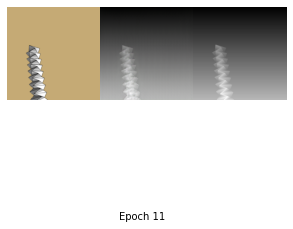

Epoch [12/50], Step [1/3750], D_loss: 0.0495, G_loss: 20.1979
Epoch [12/50], Step [2/3750], D_loss: 0.2186, G_loss: 9.4226
Epoch [12/50], Step [3/3750], D_loss: 0.0434, G_loss: 12.7629
Epoch [12/50], Step [4/3750], D_loss: 0.0596, G_loss: 9.6164
Epoch [12/50], Step [5/3750], D_loss: 0.1748, G_loss: 6.8992
Epoch [12/50], Step [6/3750], D_loss: 0.4880, G_loss: 7.1808
Epoch [12/50], Step [7/3750], D_loss: 0.0104, G_loss: 10.9361
Epoch [12/50], Step [8/3750], D_loss: 0.7239, G_loss: 4.5157
Epoch [12/50], Step [9/3750], D_loss: 0.4525, G_loss: 9.4794
Epoch [12/50], Step [10/3750], D_loss: 0.4903, G_loss: 4.0742
Epoch [12/50], Step [11/3750], D_loss: 0.0465, G_loss: 13.3771
Epoch [12/50], Step [12/3750], D_loss: 0.0802, G_loss: 9.2900
Epoch [12/50], Step [13/3750], D_loss: 0.0799, G_loss: 5.9985
Epoch [12/50], Step [14/3750], D_loss: 0.0538, G_loss: 7.3629
Epoch [12/50], Step [15/3750], D_loss: 0.0485, G_loss: 10.8622
Epoch [12/50], Step [16/3750], D_loss: 0.0602, G_loss: 7.7698
Epoch [12/50

Epoch [12/50], Step [133/3750], D_loss: 0.0998, G_loss: 7.7913
Epoch [12/50], Step [134/3750], D_loss: 0.2530, G_loss: 14.7582
Epoch [12/50], Step [135/3750], D_loss: 0.2615, G_loss: 6.3721
Epoch [12/50], Step [136/3750], D_loss: 0.0110, G_loss: 19.1528
Epoch [12/50], Step [137/3750], D_loss: 0.0255, G_loss: 14.3212
Epoch [12/50], Step [138/3750], D_loss: 0.5688, G_loss: 12.6976
Epoch [12/50], Step [139/3750], D_loss: 0.1237, G_loss: 5.3543
Epoch [12/50], Step [140/3750], D_loss: 0.1098, G_loss: 10.0279
Epoch [12/50], Step [141/3750], D_loss: 0.5671, G_loss: 4.7705
Epoch [12/50], Step [142/3750], D_loss: 0.1226, G_loss: 7.3666
Epoch [12/50], Step [143/3750], D_loss: 0.2191, G_loss: 5.1548
Epoch [12/50], Step [144/3750], D_loss: 0.3120, G_loss: 7.8411
Epoch [12/50], Step [145/3750], D_loss: 0.1364, G_loss: 12.7893
Epoch [12/50], Step [146/3750], D_loss: 0.5792, G_loss: 6.4659
Epoch [12/50], Step [147/3750], D_loss: 0.5869, G_loss: 7.9954
Epoch [12/50], Step [148/3750], D_loss: 0.2216, G

Epoch [12/50], Step [263/3750], D_loss: 0.0251, G_loss: 5.7709
Epoch [12/50], Step [264/3750], D_loss: 0.3823, G_loss: 9.1565
Epoch [12/50], Step [265/3750], D_loss: 0.2263, G_loss: 8.0448
Epoch [12/50], Step [266/3750], D_loss: 0.2216, G_loss: 9.3518
Epoch [12/50], Step [267/3750], D_loss: 0.0230, G_loss: 10.8314
Epoch [12/50], Step [268/3750], D_loss: 0.1829, G_loss: 5.9818
Epoch [12/50], Step [269/3750], D_loss: 0.4352, G_loss: 6.0012
Epoch [12/50], Step [270/3750], D_loss: 0.1752, G_loss: 9.5137
Epoch [12/50], Step [271/3750], D_loss: 0.0271, G_loss: 7.2389
Epoch [12/50], Step [272/3750], D_loss: 0.4108, G_loss: 4.8754
Epoch [12/50], Step [273/3750], D_loss: 0.0579, G_loss: 9.7557
Epoch [12/50], Step [274/3750], D_loss: 0.1889, G_loss: 13.3620
Epoch [12/50], Step [275/3750], D_loss: 0.1493, G_loss: 9.8687
Epoch [12/50], Step [276/3750], D_loss: 0.0633, G_loss: 6.5793
Epoch [12/50], Step [277/3750], D_loss: 0.0795, G_loss: 18.2106
Epoch [12/50], Step [278/3750], D_loss: 0.0770, G_lo

Epoch [12/50], Step [393/3750], D_loss: 0.0190, G_loss: 9.7660
Epoch [12/50], Step [394/3750], D_loss: 0.2310, G_loss: 15.2962
Epoch [12/50], Step [395/3750], D_loss: 0.1997, G_loss: 4.5951
Epoch [12/50], Step [396/3750], D_loss: 0.1858, G_loss: 6.7295
Epoch [12/50], Step [397/3750], D_loss: 0.1750, G_loss: 9.2696
Epoch [12/50], Step [398/3750], D_loss: 0.3239, G_loss: 4.5067
Epoch [12/50], Step [399/3750], D_loss: 0.2524, G_loss: 6.9425
Epoch [12/50], Step [400/3750], D_loss: 0.1463, G_loss: 11.4003
Epoch [12/50], Step [401/3750], D_loss: 0.0282, G_loss: 13.1652
Epoch [12/50], Step [402/3750], D_loss: 0.1233, G_loss: 8.6452
Epoch [12/50], Step [403/3750], D_loss: 0.3580, G_loss: 11.5261
Epoch [12/50], Step [404/3750], D_loss: 0.0270, G_loss: 7.7989
Epoch [12/50], Step [405/3750], D_loss: 0.0994, G_loss: 7.6118
Epoch [12/50], Step [406/3750], D_loss: 0.0058, G_loss: 13.1437
Epoch [12/50], Step [407/3750], D_loss: 0.1751, G_loss: 11.3395
Epoch [12/50], Step [408/3750], D_loss: 0.3733, G

Epoch [12/50], Step [523/3750], D_loss: 1.0337, G_loss: 4.8508
Epoch [12/50], Step [524/3750], D_loss: 0.0852, G_loss: 10.2865
Epoch [12/50], Step [525/3750], D_loss: 0.1501, G_loss: 3.9115
Epoch [12/50], Step [526/3750], D_loss: 0.2253, G_loss: 4.7235
Epoch [12/50], Step [527/3750], D_loss: 0.2220, G_loss: 8.1663
Epoch [12/50], Step [528/3750], D_loss: 0.1904, G_loss: 5.9200
Epoch [12/50], Step [529/3750], D_loss: 0.2210, G_loss: 6.6230
Epoch [12/50], Step [530/3750], D_loss: 0.0680, G_loss: 4.1511
Epoch [12/50], Step [531/3750], D_loss: 0.2130, G_loss: 6.3289
Epoch [12/50], Step [532/3750], D_loss: 0.0252, G_loss: 11.3939
Epoch [12/50], Step [533/3750], D_loss: 0.1050, G_loss: 5.0204
Epoch [12/50], Step [534/3750], D_loss: 0.0182, G_loss: 9.7087
Epoch [12/50], Step [535/3750], D_loss: 0.0859, G_loss: 7.9809
Epoch [12/50], Step [536/3750], D_loss: 0.0340, G_loss: 8.2945
Epoch [12/50], Step [537/3750], D_loss: 0.0171, G_loss: 7.8734
Epoch [12/50], Step [538/3750], D_loss: 0.3299, G_los

Epoch [12/50], Step [653/3750], D_loss: 0.2298, G_loss: 7.4959
Epoch [12/50], Step [654/3750], D_loss: 0.0399, G_loss: 5.6402
Epoch [12/50], Step [655/3750], D_loss: 0.0262, G_loss: 6.4206
Epoch [12/50], Step [656/3750], D_loss: 0.6218, G_loss: 7.4773
Epoch [12/50], Step [657/3750], D_loss: 0.4421, G_loss: 5.3659
Epoch [12/50], Step [658/3750], D_loss: 0.1125, G_loss: 12.3792
Epoch [12/50], Step [659/3750], D_loss: 0.0885, G_loss: 8.2011
Epoch [12/50], Step [660/3750], D_loss: 0.1389, G_loss: 6.6959
Epoch [12/50], Step [661/3750], D_loss: 0.0802, G_loss: 8.8626
Epoch [12/50], Step [662/3750], D_loss: 0.6446, G_loss: 2.9826
Epoch [12/50], Step [663/3750], D_loss: 0.3438, G_loss: 4.5046
Epoch [12/50], Step [664/3750], D_loss: 0.0164, G_loss: 6.2426
Epoch [12/50], Step [665/3750], D_loss: 0.2585, G_loss: 4.4107
Epoch [12/50], Step [666/3750], D_loss: 0.0710, G_loss: 8.6336
Epoch [12/50], Step [667/3750], D_loss: 0.4059, G_loss: 12.0435
Epoch [12/50], Step [668/3750], D_loss: 0.2065, G_los

Epoch [12/50], Step [783/3750], D_loss: 0.5892, G_loss: 6.4223
Epoch [12/50], Step [784/3750], D_loss: 0.2545, G_loss: 5.3234
Epoch [12/50], Step [785/3750], D_loss: 0.0989, G_loss: 8.6641
Epoch [12/50], Step [786/3750], D_loss: 0.0530, G_loss: 13.8815
Epoch [12/50], Step [787/3750], D_loss: 0.9341, G_loss: 5.2699
Epoch [12/50], Step [788/3750], D_loss: 0.1147, G_loss: 4.0580
Epoch [12/50], Step [789/3750], D_loss: 0.1696, G_loss: 7.3961
Epoch [12/50], Step [790/3750], D_loss: 0.9088, G_loss: 8.4785
Epoch [12/50], Step [791/3750], D_loss: 0.5350, G_loss: 3.9999
Epoch [12/50], Step [792/3750], D_loss: 0.1406, G_loss: 10.8977
Epoch [12/50], Step [793/3750], D_loss: 0.5279, G_loss: 6.0161
Epoch [12/50], Step [794/3750], D_loss: 0.2125, G_loss: 5.8464
Epoch [12/50], Step [795/3750], D_loss: 0.2006, G_loss: 8.8529
Epoch [12/50], Step [796/3750], D_loss: 0.8251, G_loss: 7.1923
Epoch [12/50], Step [797/3750], D_loss: 0.0199, G_loss: 17.4366
Epoch [12/50], Step [798/3750], D_loss: 0.9457, G_lo

Epoch [12/50], Step [913/3750], D_loss: 0.1331, G_loss: 11.8573
Epoch [12/50], Step [914/3750], D_loss: 0.2984, G_loss: 7.4560
Epoch [12/50], Step [915/3750], D_loss: 0.5108, G_loss: 3.6212
Epoch [12/50], Step [916/3750], D_loss: 0.1630, G_loss: 5.7344
Epoch [12/50], Step [917/3750], D_loss: 0.1605, G_loss: 5.2012
Epoch [12/50], Step [918/3750], D_loss: 0.1368, G_loss: 11.4467
Epoch [12/50], Step [919/3750], D_loss: 0.1565, G_loss: 9.4680
Epoch [12/50], Step [920/3750], D_loss: 0.1294, G_loss: 6.1048
Epoch [12/50], Step [921/3750], D_loss: 0.7376, G_loss: 5.7690
Epoch [12/50], Step [922/3750], D_loss: 0.3365, G_loss: 4.6534
Epoch [12/50], Step [923/3750], D_loss: 0.1235, G_loss: 22.3470
Epoch [12/50], Step [924/3750], D_loss: 1.0779, G_loss: 2.6138
Epoch [12/50], Step [925/3750], D_loss: 0.4897, G_loss: 6.9147
Epoch [12/50], Step [926/3750], D_loss: 0.4617, G_loss: 4.0113
Epoch [12/50], Step [927/3750], D_loss: 0.3148, G_loss: 12.0192
Epoch [12/50], Step [928/3750], D_loss: 1.0177, G_l

Epoch [12/50], Step [1042/3750], D_loss: 0.0125, G_loss: 14.3513
Epoch [12/50], Step [1043/3750], D_loss: 0.0419, G_loss: 5.3893
Epoch [12/50], Step [1044/3750], D_loss: 0.0558, G_loss: 15.9087
Epoch [12/50], Step [1045/3750], D_loss: 0.0920, G_loss: 6.6850
Epoch [12/50], Step [1046/3750], D_loss: 0.0352, G_loss: 11.3724
Epoch [12/50], Step [1047/3750], D_loss: 0.0149, G_loss: 6.7974
Epoch [12/50], Step [1048/3750], D_loss: 0.0179, G_loss: 10.5391
Epoch [12/50], Step [1049/3750], D_loss: 0.6480, G_loss: 5.3201
Epoch [12/50], Step [1050/3750], D_loss: 0.1949, G_loss: 8.5770
Epoch [12/50], Step [1051/3750], D_loss: 0.4694, G_loss: 6.8771
Epoch [12/50], Step [1052/3750], D_loss: 0.0964, G_loss: 10.8397
Epoch [12/50], Step [1053/3750], D_loss: 0.2317, G_loss: 12.4360
Epoch [12/50], Step [1054/3750], D_loss: 0.1844, G_loss: 7.2145
Epoch [12/50], Step [1055/3750], D_loss: 0.1148, G_loss: 4.3203
Epoch [12/50], Step [1056/3750], D_loss: 0.4487, G_loss: 4.0281
Epoch [12/50], Step [1057/3750], D

Epoch [12/50], Step [1170/3750], D_loss: 0.0096, G_loss: 13.4169
Epoch [12/50], Step [1171/3750], D_loss: 0.1393, G_loss: 12.5728
Epoch [12/50], Step [1172/3750], D_loss: 0.0509, G_loss: 16.5709
Epoch [12/50], Step [1173/3750], D_loss: 0.0283, G_loss: 9.7101
Epoch [12/50], Step [1174/3750], D_loss: 0.0247, G_loss: 7.7460
Epoch [12/50], Step [1175/3750], D_loss: 0.0186, G_loss: 7.8539
Epoch [12/50], Step [1176/3750], D_loss: 0.1494, G_loss: 5.7145
Epoch [12/50], Step [1177/3750], D_loss: 0.3620, G_loss: 4.2609
Epoch [12/50], Step [1178/3750], D_loss: 0.1031, G_loss: 12.5399
Epoch [12/50], Step [1179/3750], D_loss: 0.1257, G_loss: 13.7522
Epoch [12/50], Step [1180/3750], D_loss: 0.0526, G_loss: 4.8566
Epoch [12/50], Step [1181/3750], D_loss: 0.0743, G_loss: 4.8280
Epoch [12/50], Step [1182/3750], D_loss: 0.5134, G_loss: 5.8052
Epoch [12/50], Step [1183/3750], D_loss: 0.1809, G_loss: 6.5032
Epoch [12/50], Step [1184/3750], D_loss: 0.7063, G_loss: 3.6990
Epoch [12/50], Step [1185/3750], D_

Epoch [12/50], Step [1298/3750], D_loss: 0.1917, G_loss: 6.2000
Epoch [12/50], Step [1299/3750], D_loss: 0.0885, G_loss: 8.0682
Epoch [12/50], Step [1300/3750], D_loss: 0.1480, G_loss: 10.3169
Epoch [12/50], Step [1301/3750], D_loss: 0.4946, G_loss: 4.2197
Epoch [12/50], Step [1302/3750], D_loss: 0.1874, G_loss: 4.2656
Epoch [12/50], Step [1303/3750], D_loss: 0.1107, G_loss: 6.3187
Epoch [12/50], Step [1304/3750], D_loss: 0.4721, G_loss: 8.0016
Epoch [12/50], Step [1305/3750], D_loss: 0.1413, G_loss: 13.0062
Epoch [12/50], Step [1306/3750], D_loss: 0.4210, G_loss: 14.5349
Epoch [12/50], Step [1307/3750], D_loss: 0.0586, G_loss: 12.3489
Epoch [12/50], Step [1308/3750], D_loss: 0.3905, G_loss: 18.5182
Epoch [12/50], Step [1309/3750], D_loss: 0.2857, G_loss: 7.7598
Epoch [12/50], Step [1310/3750], D_loss: 0.6564, G_loss: 5.7350
Epoch [12/50], Step [1311/3750], D_loss: 0.0456, G_loss: 12.3207
Epoch [12/50], Step [1312/3750], D_loss: 0.0466, G_loss: 5.6828
Epoch [12/50], Step [1313/3750], D

Epoch [12/50], Step [1426/3750], D_loss: 1.1745, G_loss: 4.2016
Epoch [12/50], Step [1427/3750], D_loss: 0.0673, G_loss: 6.0278
Epoch [12/50], Step [1428/3750], D_loss: 0.1003, G_loss: 5.5408
Epoch [12/50], Step [1429/3750], D_loss: 0.2197, G_loss: 5.5348
Epoch [12/50], Step [1430/3750], D_loss: 0.0549, G_loss: 10.7427
Epoch [12/50], Step [1431/3750], D_loss: 0.3327, G_loss: 24.9607
Epoch [12/50], Step [1432/3750], D_loss: 0.3091, G_loss: 5.9129
Epoch [12/50], Step [1433/3750], D_loss: 1.0203, G_loss: 10.5288
Epoch [12/50], Step [1434/3750], D_loss: 0.1474, G_loss: 4.9023
Epoch [12/50], Step [1435/3750], D_loss: 0.2103, G_loss: 8.2748
Epoch [12/50], Step [1436/3750], D_loss: 0.8100, G_loss: 6.1576
Epoch [12/50], Step [1437/3750], D_loss: 0.6375, G_loss: 7.5376
Epoch [12/50], Step [1438/3750], D_loss: 0.0895, G_loss: 6.1098
Epoch [12/50], Step [1439/3750], D_loss: 0.2505, G_loss: 5.7668
Epoch [12/50], Step [1440/3750], D_loss: 0.0940, G_loss: 9.7390
Epoch [12/50], Step [1441/3750], D_lo

Epoch [12/50], Step [1554/3750], D_loss: 0.3139, G_loss: 4.3594
Epoch [12/50], Step [1555/3750], D_loss: 0.4373, G_loss: 13.7165
Epoch [12/50], Step [1556/3750], D_loss: 0.0845, G_loss: 12.1628
Epoch [12/50], Step [1557/3750], D_loss: 0.1599, G_loss: 7.5850
Epoch [12/50], Step [1558/3750], D_loss: 0.4531, G_loss: 5.8896
Epoch [12/50], Step [1559/3750], D_loss: 0.2289, G_loss: 3.7205
Epoch [12/50], Step [1560/3750], D_loss: 0.2080, G_loss: 7.7473
Epoch [12/50], Step [1561/3750], D_loss: 0.1024, G_loss: 15.5081
Epoch [12/50], Step [1562/3750], D_loss: 0.0464, G_loss: 10.2357
Epoch [12/50], Step [1563/3750], D_loss: 0.0998, G_loss: 8.2712
Epoch [12/50], Step [1564/3750], D_loss: 0.0809, G_loss: 5.7081
Epoch [12/50], Step [1565/3750], D_loss: 0.1227, G_loss: 4.2297
Epoch [12/50], Step [1566/3750], D_loss: 0.0753, G_loss: 17.5654
Epoch [12/50], Step [1567/3750], D_loss: 0.1576, G_loss: 10.3188
Epoch [12/50], Step [1568/3750], D_loss: 0.1144, G_loss: 4.9274
Epoch [12/50], Step [1569/3750], D

Epoch [12/50], Step [1682/3750], D_loss: 0.0676, G_loss: 6.3257
Epoch [12/50], Step [1683/3750], D_loss: 0.2708, G_loss: 5.1992
Epoch [12/50], Step [1684/3750], D_loss: 0.0782, G_loss: 10.5319
Epoch [12/50], Step [1685/3750], D_loss: 0.1696, G_loss: 8.5367
Epoch [12/50], Step [1686/3750], D_loss: 0.2787, G_loss: 14.4861
Epoch [12/50], Step [1687/3750], D_loss: 0.0965, G_loss: 8.7153
Epoch [12/50], Step [1688/3750], D_loss: 0.3437, G_loss: 4.3711
Epoch [12/50], Step [1689/3750], D_loss: 0.4453, G_loss: 12.0809
Epoch [12/50], Step [1690/3750], D_loss: 0.1577, G_loss: 8.3878
Epoch [12/50], Step [1691/3750], D_loss: 0.0711, G_loss: 5.7161
Epoch [12/50], Step [1692/3750], D_loss: 0.6677, G_loss: 5.8344
Epoch [12/50], Step [1693/3750], D_loss: 0.3193, G_loss: 9.9867
Epoch [12/50], Step [1694/3750], D_loss: 0.0995, G_loss: 12.3576
Epoch [12/50], Step [1695/3750], D_loss: 0.2223, G_loss: 25.1330
Epoch [12/50], Step [1696/3750], D_loss: 0.2777, G_loss: 8.2059
Epoch [12/50], Step [1697/3750], D_

Epoch [12/50], Step [1810/3750], D_loss: 0.6722, G_loss: 5.4177
Epoch [12/50], Step [1811/3750], D_loss: 0.0881, G_loss: 12.7795
Epoch [12/50], Step [1812/3750], D_loss: 0.0538, G_loss: 7.9996
Epoch [12/50], Step [1813/3750], D_loss: 0.0668, G_loss: 9.7666
Epoch [12/50], Step [1814/3750], D_loss: 0.0278, G_loss: 10.7372
Epoch [12/50], Step [1815/3750], D_loss: 0.0913, G_loss: 6.7130
Epoch [12/50], Step [1816/3750], D_loss: 0.4943, G_loss: 4.9298
Epoch [12/50], Step [1817/3750], D_loss: 0.1902, G_loss: 6.4124
Epoch [12/50], Step [1818/3750], D_loss: 0.0968, G_loss: 3.7191
Epoch [12/50], Step [1819/3750], D_loss: 0.1283, G_loss: 13.0799
Epoch [12/50], Step [1820/3750], D_loss: 0.3118, G_loss: 3.6878
Epoch [12/50], Step [1821/3750], D_loss: 0.0999, G_loss: 5.5453
Epoch [12/50], Step [1822/3750], D_loss: 0.1161, G_loss: 6.2042
Epoch [12/50], Step [1823/3750], D_loss: 0.2868, G_loss: 5.1608
Epoch [12/50], Step [1824/3750], D_loss: 0.0632, G_loss: 8.7426
Epoch [12/50], Step [1825/3750], D_lo

Epoch [12/50], Step [1938/3750], D_loss: 0.0376, G_loss: 7.1614
Epoch [12/50], Step [1939/3750], D_loss: 0.3143, G_loss: 5.1600
Epoch [12/50], Step [1940/3750], D_loss: 0.2077, G_loss: 5.3600
Epoch [12/50], Step [1941/3750], D_loss: 0.1495, G_loss: 8.0928
Epoch [12/50], Step [1942/3750], D_loss: 0.1749, G_loss: 4.4835
Epoch [12/50], Step [1943/3750], D_loss: 0.1694, G_loss: 6.2157
Epoch [12/50], Step [1944/3750], D_loss: 0.1738, G_loss: 6.2874
Epoch [12/50], Step [1945/3750], D_loss: 0.0215, G_loss: 15.2426
Epoch [12/50], Step [1946/3750], D_loss: 0.1201, G_loss: 6.0915
Epoch [12/50], Step [1947/3750], D_loss: 0.1146, G_loss: 7.8535
Epoch [12/50], Step [1948/3750], D_loss: 0.0422, G_loss: 10.7977
Epoch [12/50], Step [1949/3750], D_loss: 0.0397, G_loss: 5.0686
Epoch [12/50], Step [1950/3750], D_loss: 0.1349, G_loss: 6.8669
Epoch [12/50], Step [1951/3750], D_loss: 0.2954, G_loss: 6.5615
Epoch [12/50], Step [1952/3750], D_loss: 0.1861, G_loss: 5.1828
Epoch [12/50], Step [1953/3750], D_los

Epoch [12/50], Step [2066/3750], D_loss: 0.0471, G_loss: 6.5503
Epoch [12/50], Step [2067/3750], D_loss: 0.1867, G_loss: 5.2527
Epoch [12/50], Step [2068/3750], D_loss: 0.0260, G_loss: 6.5141
Epoch [12/50], Step [2069/3750], D_loss: 0.1220, G_loss: 7.9199
Epoch [12/50], Step [2070/3750], D_loss: 0.0715, G_loss: 7.0772
Epoch [12/50], Step [2071/3750], D_loss: 0.0265, G_loss: 6.7588
Epoch [12/50], Step [2072/3750], D_loss: 0.0107, G_loss: 7.1468
Epoch [12/50], Step [2073/3750], D_loss: 0.0118, G_loss: 14.3511
Epoch [12/50], Step [2074/3750], D_loss: 0.0864, G_loss: 6.8928
Epoch [12/50], Step [2075/3750], D_loss: 0.0532, G_loss: 7.2949
Epoch [12/50], Step [2076/3750], D_loss: 0.0450, G_loss: 16.6274
Epoch [12/50], Step [2077/3750], D_loss: 0.0190, G_loss: 10.9483
Epoch [12/50], Step [2078/3750], D_loss: 0.1191, G_loss: 9.3535
Epoch [12/50], Step [2079/3750], D_loss: 0.0156, G_loss: 7.7408
Epoch [12/50], Step [2080/3750], D_loss: 0.2787, G_loss: 8.6934
Epoch [12/50], Step [2081/3750], D_lo

Epoch [12/50], Step [2194/3750], D_loss: 0.1076, G_loss: 5.0229
Epoch [12/50], Step [2195/3750], D_loss: 0.5187, G_loss: 3.7137
Epoch [12/50], Step [2196/3750], D_loss: 0.4333, G_loss: 6.2257
Epoch [12/50], Step [2197/3750], D_loss: 0.0246, G_loss: 7.5703
Epoch [12/50], Step [2198/3750], D_loss: 0.1108, G_loss: 9.9025
Epoch [12/50], Step [2199/3750], D_loss: 0.3294, G_loss: 4.4994
Epoch [12/50], Step [2200/3750], D_loss: 1.0770, G_loss: 8.3771
Epoch [12/50], Step [2201/3750], D_loss: 0.0164, G_loss: 11.4537
Epoch [12/50], Step [2202/3750], D_loss: 0.0497, G_loss: 5.5097
Epoch [12/50], Step [2203/3750], D_loss: 0.5721, G_loss: 9.3341
Epoch [12/50], Step [2204/3750], D_loss: 0.1094, G_loss: 5.8351
Epoch [12/50], Step [2205/3750], D_loss: 0.1034, G_loss: 21.4923
Epoch [12/50], Step [2206/3750], D_loss: 0.6569, G_loss: 6.9261
Epoch [12/50], Step [2207/3750], D_loss: 0.1105, G_loss: 5.2795
Epoch [12/50], Step [2208/3750], D_loss: 0.2174, G_loss: 9.1672
Epoch [12/50], Step [2209/3750], D_los

Epoch [12/50], Step [2322/3750], D_loss: 0.4792, G_loss: 4.2822
Epoch [12/50], Step [2323/3750], D_loss: 0.1343, G_loss: 7.8808
Epoch [12/50], Step [2324/3750], D_loss: 0.1092, G_loss: 10.2730
Epoch [12/50], Step [2325/3750], D_loss: 0.1319, G_loss: 12.9568
Epoch [12/50], Step [2326/3750], D_loss: 0.0155, G_loss: 15.0038
Epoch [12/50], Step [2327/3750], D_loss: 0.0439, G_loss: 8.3031
Epoch [12/50], Step [2328/3750], D_loss: 0.2705, G_loss: 10.8526
Epoch [12/50], Step [2329/3750], D_loss: 0.0137, G_loss: 14.6710
Epoch [12/50], Step [2330/3750], D_loss: 0.2612, G_loss: 15.7241
Epoch [12/50], Step [2331/3750], D_loss: 0.0422, G_loss: 12.6380
Epoch [12/50], Step [2332/3750], D_loss: 0.3395, G_loss: 7.9636
Epoch [12/50], Step [2333/3750], D_loss: 0.1941, G_loss: 6.4253
Epoch [12/50], Step [2334/3750], D_loss: 0.1153, G_loss: 4.3585
Epoch [12/50], Step [2335/3750], D_loss: 0.0263, G_loss: 7.7520
Epoch [12/50], Step [2336/3750], D_loss: 0.0843, G_loss: 8.1413
Epoch [12/50], Step [2337/3750], 

Epoch [12/50], Step [2450/3750], D_loss: 0.0055, G_loss: 12.3617
Epoch [12/50], Step [2451/3750], D_loss: 0.1489, G_loss: 5.9402
Epoch [12/50], Step [2452/3750], D_loss: 0.0081, G_loss: 7.7618
Epoch [12/50], Step [2453/3750], D_loss: 0.4183, G_loss: 5.1394
Epoch [12/50], Step [2454/3750], D_loss: 0.2420, G_loss: 5.2126
Epoch [12/50], Step [2455/3750], D_loss: 0.0401, G_loss: 11.6449
Epoch [12/50], Step [2456/3750], D_loss: 0.0466, G_loss: 8.3064
Epoch [12/50], Step [2457/3750], D_loss: 0.1825, G_loss: 7.1654
Epoch [12/50], Step [2458/3750], D_loss: 0.3498, G_loss: 14.6161
Epoch [12/50], Step [2459/3750], D_loss: 0.3608, G_loss: 6.0800
Epoch [12/50], Step [2460/3750], D_loss: 0.2427, G_loss: 3.8339
Epoch [12/50], Step [2461/3750], D_loss: 0.1916, G_loss: 7.8426
Epoch [12/50], Step [2462/3750], D_loss: 0.2899, G_loss: 9.7167
Epoch [12/50], Step [2463/3750], D_loss: 0.1347, G_loss: 7.3815
Epoch [12/50], Step [2464/3750], D_loss: 0.1825, G_loss: 6.3300
Epoch [12/50], Step [2465/3750], D_lo

Epoch [12/50], Step [2578/3750], D_loss: 0.3583, G_loss: 4.1117
Epoch [12/50], Step [2579/3750], D_loss: 0.2985, G_loss: 6.8842
Epoch [12/50], Step [2580/3750], D_loss: 0.0644, G_loss: 4.7557
Epoch [12/50], Step [2581/3750], D_loss: 0.0857, G_loss: 10.7651
Epoch [12/50], Step [2582/3750], D_loss: 0.0349, G_loss: 5.6232
Epoch [12/50], Step [2583/3750], D_loss: 0.0868, G_loss: 6.2364
Epoch [12/50], Step [2584/3750], D_loss: 0.1492, G_loss: 5.9310
Epoch [12/50], Step [2585/3750], D_loss: 0.0117, G_loss: 13.5969
Epoch [12/50], Step [2586/3750], D_loss: 0.2327, G_loss: 8.9109
Epoch [12/50], Step [2587/3750], D_loss: 0.3037, G_loss: 4.5918
Epoch [12/50], Step [2588/3750], D_loss: 0.4106, G_loss: 7.1974
Epoch [12/50], Step [2589/3750], D_loss: 0.2426, G_loss: 6.1773
Epoch [12/50], Step [2590/3750], D_loss: 0.0906, G_loss: 7.2611
Epoch [12/50], Step [2591/3750], D_loss: 0.4194, G_loss: 5.5363
Epoch [12/50], Step [2592/3750], D_loss: 0.0522, G_loss: 12.4410
Epoch [12/50], Step [2593/3750], D_lo

Epoch [12/50], Step [2706/3750], D_loss: 0.1406, G_loss: 7.7884
Epoch [12/50], Step [2707/3750], D_loss: 0.0180, G_loss: 8.3155
Epoch [12/50], Step [2708/3750], D_loss: 0.0215, G_loss: 8.7726
Epoch [12/50], Step [2709/3750], D_loss: 0.0338, G_loss: 5.6083
Epoch [12/50], Step [2710/3750], D_loss: 0.0250, G_loss: 6.2480
Epoch [12/50], Step [2711/3750], D_loss: 0.2395, G_loss: 4.2098
Epoch [12/50], Step [2712/3750], D_loss: 0.3487, G_loss: 7.1728
Epoch [12/50], Step [2713/3750], D_loss: 0.3376, G_loss: 4.1209
Epoch [12/50], Step [2714/3750], D_loss: 0.0038, G_loss: 11.6378
Epoch [12/50], Step [2715/3750], D_loss: 0.2813, G_loss: 4.8161
Epoch [12/50], Step [2716/3750], D_loss: 0.2897, G_loss: 3.1759
Epoch [12/50], Step [2717/3750], D_loss: 0.0740, G_loss: 7.2101
Epoch [12/50], Step [2718/3750], D_loss: 0.3387, G_loss: 3.8856
Epoch [12/50], Step [2719/3750], D_loss: 0.1512, G_loss: 15.4193
Epoch [12/50], Step [2720/3750], D_loss: 0.3002, G_loss: 8.9643
Epoch [12/50], Step [2721/3750], D_los

Epoch [12/50], Step [2834/3750], D_loss: 0.1415, G_loss: 14.7057
Epoch [12/50], Step [2835/3750], D_loss: 0.0185, G_loss: 5.8082
Epoch [12/50], Step [2836/3750], D_loss: 0.3777, G_loss: 4.1874
Epoch [12/50], Step [2837/3750], D_loss: 0.1285, G_loss: 7.3041
Epoch [12/50], Step [2838/3750], D_loss: 0.3119, G_loss: 6.9871
Epoch [12/50], Step [2839/3750], D_loss: 0.1017, G_loss: 8.3211
Epoch [12/50], Step [2840/3750], D_loss: 0.5917, G_loss: 8.6428
Epoch [12/50], Step [2841/3750], D_loss: 0.1386, G_loss: 8.1931
Epoch [12/50], Step [2842/3750], D_loss: 0.2015, G_loss: 6.8549
Epoch [12/50], Step [2843/3750], D_loss: 0.1622, G_loss: 7.8326
Epoch [12/50], Step [2844/3750], D_loss: 0.2162, G_loss: 5.3853
Epoch [12/50], Step [2845/3750], D_loss: 0.1579, G_loss: 11.7111
Epoch [12/50], Step [2846/3750], D_loss: 0.1230, G_loss: 10.3158
Epoch [12/50], Step [2847/3750], D_loss: 0.0203, G_loss: 9.0044
Epoch [12/50], Step [2848/3750], D_loss: 0.3403, G_loss: 4.6626
Epoch [12/50], Step [2849/3750], D_lo

Epoch [12/50], Step [2962/3750], D_loss: 0.0282, G_loss: 11.1097
Epoch [12/50], Step [2963/3750], D_loss: 0.1689, G_loss: 6.3221
Epoch [12/50], Step [2964/3750], D_loss: 0.0367, G_loss: 12.8627
Epoch [12/50], Step [2965/3750], D_loss: 0.0142, G_loss: 10.9659
Epoch [12/50], Step [2966/3750], D_loss: 0.1937, G_loss: 6.3282
Epoch [12/50], Step [2967/3750], D_loss: 0.2726, G_loss: 15.2492
Epoch [12/50], Step [2968/3750], D_loss: 0.0771, G_loss: 8.1327
Epoch [12/50], Step [2969/3750], D_loss: 0.0634, G_loss: 9.5018
Epoch [12/50], Step [2970/3750], D_loss: 0.5152, G_loss: 10.8029
Epoch [12/50], Step [2971/3750], D_loss: 0.2785, G_loss: 8.0955
Epoch [12/50], Step [2972/3750], D_loss: 0.0161, G_loss: 8.3972
Epoch [12/50], Step [2973/3750], D_loss: 0.1613, G_loss: 13.2450
Epoch [12/50], Step [2974/3750], D_loss: 0.3218, G_loss: 3.8329
Epoch [12/50], Step [2975/3750], D_loss: 0.3708, G_loss: 8.3805
Epoch [12/50], Step [2976/3750], D_loss: 0.1017, G_loss: 12.5589
Epoch [12/50], Step [2977/3750], 

Epoch [12/50], Step [3090/3750], D_loss: 0.1345, G_loss: 5.8813
Epoch [12/50], Step [3091/3750], D_loss: 0.0432, G_loss: 5.0367
Epoch [12/50], Step [3092/3750], D_loss: 0.1088, G_loss: 8.1547
Epoch [12/50], Step [3093/3750], D_loss: 0.0289, G_loss: 10.6540
Epoch [12/50], Step [3094/3750], D_loss: 0.3971, G_loss: 6.5717
Epoch [12/50], Step [3095/3750], D_loss: 0.2312, G_loss: 4.6245
Epoch [12/50], Step [3096/3750], D_loss: 0.0857, G_loss: 9.8403
Epoch [12/50], Step [3097/3750], D_loss: 0.2435, G_loss: 5.5533
Epoch [12/50], Step [3098/3750], D_loss: 0.0731, G_loss: 14.5741
Epoch [12/50], Step [3099/3750], D_loss: 0.0725, G_loss: 4.8518
Epoch [12/50], Step [3100/3750], D_loss: 0.0430, G_loss: 11.2477
Epoch [12/50], Step [3101/3750], D_loss: 0.0426, G_loss: 6.4356
Epoch [12/50], Step [3102/3750], D_loss: 0.1617, G_loss: 4.9652
Epoch [12/50], Step [3103/3750], D_loss: 0.0140, G_loss: 14.0156
Epoch [12/50], Step [3104/3750], D_loss: 0.1826, G_loss: 4.5800
Epoch [12/50], Step [3105/3750], D_l

Epoch [12/50], Step [3218/3750], D_loss: 0.1550, G_loss: 10.5578
Epoch [12/50], Step [3219/3750], D_loss: 0.0943, G_loss: 6.0804
Epoch [12/50], Step [3220/3750], D_loss: 0.2192, G_loss: 5.4311
Epoch [12/50], Step [3221/3750], D_loss: 0.2933, G_loss: 4.8358
Epoch [12/50], Step [3222/3750], D_loss: 0.0328, G_loss: 9.0356
Epoch [12/50], Step [3223/3750], D_loss: 0.0550, G_loss: 7.0513
Epoch [12/50], Step [3224/3750], D_loss: 0.0567, G_loss: 12.3940
Epoch [12/50], Step [3225/3750], D_loss: 0.0719, G_loss: 7.4018
Epoch [12/50], Step [3226/3750], D_loss: 0.1538, G_loss: 4.1714
Epoch [12/50], Step [3227/3750], D_loss: 0.9948, G_loss: 3.7065
Epoch [12/50], Step [3228/3750], D_loss: 0.0485, G_loss: 5.2179
Epoch [12/50], Step [3229/3750], D_loss: 0.1832, G_loss: 23.8493
Epoch [12/50], Step [3230/3750], D_loss: 0.3838, G_loss: 4.2532
Epoch [12/50], Step [3231/3750], D_loss: 0.0923, G_loss: 13.7827
Epoch [12/50], Step [3232/3750], D_loss: 0.0668, G_loss: 8.8302
Epoch [12/50], Step [3233/3750], D_l

Epoch [12/50], Step [3346/3750], D_loss: 0.1975, G_loss: 9.8736
Epoch [12/50], Step [3347/3750], D_loss: 0.2394, G_loss: 4.9278
Epoch [12/50], Step [3348/3750], D_loss: 0.2397, G_loss: 5.0243
Epoch [12/50], Step [3349/3750], D_loss: 0.1477, G_loss: 6.7331
Epoch [12/50], Step [3350/3750], D_loss: 0.5004, G_loss: 4.9778
Epoch [12/50], Step [3351/3750], D_loss: 0.3423, G_loss: 5.6252
Epoch [12/50], Step [3352/3750], D_loss: 0.1018, G_loss: 10.7069
Epoch [12/50], Step [3353/3750], D_loss: 0.1961, G_loss: 4.5332
Epoch [12/50], Step [3354/3750], D_loss: 0.1776, G_loss: 7.1911
Epoch [12/50], Step [3355/3750], D_loss: 0.3628, G_loss: 6.3752
Epoch [12/50], Step [3356/3750], D_loss: 0.0408, G_loss: 11.2762
Epoch [12/50], Step [3357/3750], D_loss: 0.1115, G_loss: 13.2223
Epoch [12/50], Step [3358/3750], D_loss: 0.3243, G_loss: 4.8502
Epoch [12/50], Step [3359/3750], D_loss: 0.2320, G_loss: 7.8868
Epoch [12/50], Step [3360/3750], D_loss: 0.1530, G_loss: 7.8419
Epoch [12/50], Step [3361/3750], D_lo

Epoch [12/50], Step [3474/3750], D_loss: 0.2476, G_loss: 7.8242
Epoch [12/50], Step [3475/3750], D_loss: 0.0404, G_loss: 14.8751
Epoch [12/50], Step [3476/3750], D_loss: 0.2502, G_loss: 4.7604
Epoch [12/50], Step [3477/3750], D_loss: 0.1563, G_loss: 8.2344
Epoch [12/50], Step [3478/3750], D_loss: 0.1705, G_loss: 12.2567
Epoch [12/50], Step [3479/3750], D_loss: 0.1630, G_loss: 7.7055
Epoch [12/50], Step [3480/3750], D_loss: 0.3120, G_loss: 6.8038
Epoch [12/50], Step [3481/3750], D_loss: 0.0840, G_loss: 9.1752
Epoch [12/50], Step [3482/3750], D_loss: 0.0844, G_loss: 9.3075
Epoch [12/50], Step [3483/3750], D_loss: 0.0964, G_loss: 9.3974
Epoch [12/50], Step [3484/3750], D_loss: 0.0392, G_loss: 11.8074
Epoch [12/50], Step [3485/3750], D_loss: 0.1858, G_loss: 5.7729
Epoch [12/50], Step [3486/3750], D_loss: 0.1953, G_loss: 6.1479
Epoch [12/50], Step [3487/3750], D_loss: 0.0058, G_loss: 8.5332
Epoch [12/50], Step [3488/3750], D_loss: 0.1262, G_loss: 6.3877
Epoch [12/50], Step [3489/3750], D_lo

Epoch [12/50], Step [3602/3750], D_loss: 0.0353, G_loss: 15.5221
Epoch [12/50], Step [3603/3750], D_loss: 0.0337, G_loss: 7.4471
Epoch [12/50], Step [3604/3750], D_loss: 0.0214, G_loss: 8.4648
Epoch [12/50], Step [3605/3750], D_loss: 0.1092, G_loss: 12.7590
Epoch [12/50], Step [3606/3750], D_loss: 0.3407, G_loss: 10.1756
Epoch [12/50], Step [3607/3750], D_loss: 0.1914, G_loss: 12.6960
Epoch [12/50], Step [3608/3750], D_loss: 0.2749, G_loss: 5.4228
Epoch [12/50], Step [3609/3750], D_loss: 0.0809, G_loss: 15.1151
Epoch [12/50], Step [3610/3750], D_loss: 0.4294, G_loss: 3.4296
Epoch [12/50], Step [3611/3750], D_loss: 0.0471, G_loss: 12.1426
Epoch [12/50], Step [3612/3750], D_loss: 0.4835, G_loss: 6.6532
Epoch [12/50], Step [3613/3750], D_loss: 0.4514, G_loss: 8.3729
Epoch [12/50], Step [3614/3750], D_loss: 0.2530, G_loss: 10.3739
Epoch [12/50], Step [3615/3750], D_loss: 0.0878, G_loss: 15.5251
Epoch [12/50], Step [3616/3750], D_loss: 0.0288, G_loss: 11.0277
Epoch [12/50], Step [3617/3750]

Epoch [12/50], Step [3730/3750], D_loss: 0.4350, G_loss: 6.0715
Epoch [12/50], Step [3731/3750], D_loss: 0.5630, G_loss: 5.9792
Epoch [12/50], Step [3732/3750], D_loss: 0.2397, G_loss: 8.5978
Epoch [12/50], Step [3733/3750], D_loss: 0.5059, G_loss: 7.8507
Epoch [12/50], Step [3734/3750], D_loss: 0.2680, G_loss: 11.0039
Epoch [12/50], Step [3735/3750], D_loss: 0.1991, G_loss: 5.4767
Epoch [12/50], Step [3736/3750], D_loss: 0.2771, G_loss: 6.4245
Epoch [12/50], Step [3737/3750], D_loss: 0.6301, G_loss: 5.9376
Epoch [12/50], Step [3738/3750], D_loss: 0.3241, G_loss: 4.7136
Epoch [12/50], Step [3739/3750], D_loss: 0.4267, G_loss: 4.7100
Epoch [12/50], Step [3740/3750], D_loss: 0.0836, G_loss: 7.0360
Epoch [12/50], Step [3741/3750], D_loss: 0.0912, G_loss: 5.7179
Epoch [12/50], Step [3742/3750], D_loss: 0.0881, G_loss: 4.2438
Epoch [12/50], Step [3743/3750], D_loss: 0.0812, G_loss: 4.4797
Epoch [12/50], Step [3744/3750], D_loss: 0.0613, G_loss: 14.3358
Epoch [12/50], Step [3745/3750], D_los

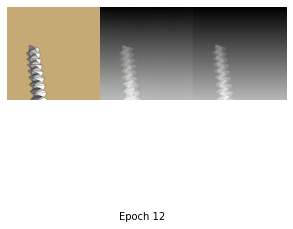

Epoch [13/50], Step [1/3750], D_loss: 0.3912, G_loss: 8.0698
Epoch [13/50], Step [2/3750], D_loss: 0.0486, G_loss: 12.9103
Epoch [13/50], Step [3/3750], D_loss: 0.0829, G_loss: 7.0219
Epoch [13/50], Step [4/3750], D_loss: 0.1637, G_loss: 5.3658
Epoch [13/50], Step [5/3750], D_loss: 0.4303, G_loss: 4.7456
Epoch [13/50], Step [6/3750], D_loss: 0.1864, G_loss: 8.5768
Epoch [13/50], Step [7/3750], D_loss: 0.1471, G_loss: 8.5663
Epoch [13/50], Step [8/3750], D_loss: 0.1657, G_loss: 12.9057
Epoch [13/50], Step [9/3750], D_loss: 0.0587, G_loss: 9.3123
Epoch [13/50], Step [10/3750], D_loss: 0.0991, G_loss: 6.3980
Epoch [13/50], Step [11/3750], D_loss: 0.5347, G_loss: 5.9671
Epoch [13/50], Step [12/3750], D_loss: 0.3147, G_loss: 7.6946
Epoch [13/50], Step [13/3750], D_loss: 0.1343, G_loss: 7.6373
Epoch [13/50], Step [14/3750], D_loss: 0.0889, G_loss: 9.4790
Epoch [13/50], Step [15/3750], D_loss: 0.0456, G_loss: 10.5344
Epoch [13/50], Step [16/3750], D_loss: 0.0692, G_loss: 6.6633
Epoch [13/50],

Epoch [13/50], Step [133/3750], D_loss: 0.3257, G_loss: 6.3961
Epoch [13/50], Step [134/3750], D_loss: 0.3728, G_loss: 7.3840
Epoch [13/50], Step [135/3750], D_loss: 0.3599, G_loss: 9.3062
Epoch [13/50], Step [136/3750], D_loss: 0.0322, G_loss: 10.3361
Epoch [13/50], Step [137/3750], D_loss: 0.2093, G_loss: 5.6143
Epoch [13/50], Step [138/3750], D_loss: 0.2193, G_loss: 8.8577
Epoch [13/50], Step [139/3750], D_loss: 0.0869, G_loss: 8.1113
Epoch [13/50], Step [140/3750], D_loss: 0.0321, G_loss: 9.2625
Epoch [13/50], Step [141/3750], D_loss: 0.1287, G_loss: 4.1507
Epoch [13/50], Step [142/3750], D_loss: 0.1587, G_loss: 10.3839
Epoch [13/50], Step [143/3750], D_loss: 0.0654, G_loss: 6.6168
Epoch [13/50], Step [144/3750], D_loss: 0.1453, G_loss: 6.3372
Epoch [13/50], Step [145/3750], D_loss: 0.2025, G_loss: 11.3540
Epoch [13/50], Step [146/3750], D_loss: 0.1994, G_loss: 3.9851
Epoch [13/50], Step [147/3750], D_loss: 0.0545, G_loss: 7.8606
Epoch [13/50], Step [148/3750], D_loss: 0.3315, G_lo

Epoch [13/50], Step [263/3750], D_loss: 0.1722, G_loss: 8.3742
Epoch [13/50], Step [264/3750], D_loss: 0.0462, G_loss: 8.4785
Epoch [13/50], Step [265/3750], D_loss: 0.7137, G_loss: 4.4072
Epoch [13/50], Step [266/3750], D_loss: 0.4123, G_loss: 7.6184
Epoch [13/50], Step [267/3750], D_loss: 0.2419, G_loss: 4.7305
Epoch [13/50], Step [268/3750], D_loss: 0.4143, G_loss: 4.3676
Epoch [13/50], Step [269/3750], D_loss: 0.0796, G_loss: 10.3995
Epoch [13/50], Step [270/3750], D_loss: 0.2894, G_loss: 12.1665
Epoch [13/50], Step [271/3750], D_loss: 0.4825, G_loss: 4.5772
Epoch [13/50], Step [272/3750], D_loss: 0.0332, G_loss: 11.9025
Epoch [13/50], Step [273/3750], D_loss: 0.2081, G_loss: 6.4408
Epoch [13/50], Step [274/3750], D_loss: 0.2625, G_loss: 6.1457
Epoch [13/50], Step [275/3750], D_loss: 0.0387, G_loss: 5.6476
Epoch [13/50], Step [276/3750], D_loss: 0.0312, G_loss: 7.3147
Epoch [13/50], Step [277/3750], D_loss: 0.1636, G_loss: 6.7752
Epoch [13/50], Step [278/3750], D_loss: 0.0833, G_lo

Epoch [13/50], Step [393/3750], D_loss: 0.0313, G_loss: 7.5260
Epoch [13/50], Step [394/3750], D_loss: 0.1507, G_loss: 4.6227
Epoch [13/50], Step [395/3750], D_loss: 0.2598, G_loss: 5.1482
Epoch [13/50], Step [396/3750], D_loss: 0.0451, G_loss: 9.8589
Epoch [13/50], Step [397/3750], D_loss: 0.0474, G_loss: 6.6333
Epoch [13/50], Step [398/3750], D_loss: 0.5502, G_loss: 5.0911
Epoch [13/50], Step [399/3750], D_loss: 0.1015, G_loss: 4.6008
Epoch [13/50], Step [400/3750], D_loss: 0.4030, G_loss: 7.4292
Epoch [13/50], Step [401/3750], D_loss: 0.0402, G_loss: 13.7266
Epoch [13/50], Step [402/3750], D_loss: 0.4929, G_loss: 14.8169
Epoch [13/50], Step [403/3750], D_loss: 0.2650, G_loss: 4.9745
Epoch [13/50], Step [404/3750], D_loss: 0.1762, G_loss: 12.7925
Epoch [13/50], Step [405/3750], D_loss: 0.0915, G_loss: 7.2593
Epoch [13/50], Step [406/3750], D_loss: 0.0231, G_loss: 11.2420
Epoch [13/50], Step [407/3750], D_loss: 0.4626, G_loss: 7.0511
Epoch [13/50], Step [408/3750], D_loss: 0.1086, G_l

Epoch [13/50], Step [523/3750], D_loss: 0.0685, G_loss: 14.1733
Epoch [13/50], Step [524/3750], D_loss: 0.1938, G_loss: 5.5639
Epoch [13/50], Step [525/3750], D_loss: 0.1354, G_loss: 5.8906
Epoch [13/50], Step [526/3750], D_loss: 0.2630, G_loss: 4.6370
Epoch [13/50], Step [527/3750], D_loss: 0.2191, G_loss: 6.7029
Epoch [13/50], Step [528/3750], D_loss: 0.0271, G_loss: 8.8454
Epoch [13/50], Step [529/3750], D_loss: 0.4183, G_loss: 15.9132
Epoch [13/50], Step [530/3750], D_loss: 0.1870, G_loss: 12.1758
Epoch [13/50], Step [531/3750], D_loss: 0.1898, G_loss: 6.1295
Epoch [13/50], Step [532/3750], D_loss: 0.3676, G_loss: 5.6559
Epoch [13/50], Step [533/3750], D_loss: 1.0380, G_loss: 5.6463
Epoch [13/50], Step [534/3750], D_loss: 0.6575, G_loss: 4.7308
Epoch [13/50], Step [535/3750], D_loss: 1.4060, G_loss: 5.6051
Epoch [13/50], Step [536/3750], D_loss: 0.3085, G_loss: 6.5653
Epoch [13/50], Step [537/3750], D_loss: 0.2150, G_loss: 5.3203
Epoch [13/50], Step [538/3750], D_loss: 0.0583, G_lo

Epoch [13/50], Step [653/3750], D_loss: 0.2369, G_loss: 5.7034
Epoch [13/50], Step [654/3750], D_loss: 0.0394, G_loss: 11.7749
Epoch [13/50], Step [655/3750], D_loss: 0.2486, G_loss: 5.6464
Epoch [13/50], Step [656/3750], D_loss: 0.0399, G_loss: 5.4874
Epoch [13/50], Step [657/3750], D_loss: 0.0173, G_loss: 9.7152
Epoch [13/50], Step [658/3750], D_loss: 0.2226, G_loss: 5.1943
Epoch [13/50], Step [659/3750], D_loss: 0.6839, G_loss: 5.7889
Epoch [13/50], Step [660/3750], D_loss: 0.1564, G_loss: 9.5698
Epoch [13/50], Step [661/3750], D_loss: 0.2670, G_loss: 4.8371
Epoch [13/50], Step [662/3750], D_loss: 0.3844, G_loss: 4.1323
Epoch [13/50], Step [663/3750], D_loss: 0.3091, G_loss: 19.9061
Epoch [13/50], Step [664/3750], D_loss: 0.3515, G_loss: 10.3567
Epoch [13/50], Step [665/3750], D_loss: 0.0702, G_loss: 11.3814
Epoch [13/50], Step [666/3750], D_loss: 0.4351, G_loss: 6.9953
Epoch [13/50], Step [667/3750], D_loss: 0.4117, G_loss: 10.5740
Epoch [13/50], Step [668/3750], D_loss: 0.2206, G_

Epoch [13/50], Step [783/3750], D_loss: 0.1448, G_loss: 5.4700
Epoch [13/50], Step [784/3750], D_loss: 0.0461, G_loss: 5.2168
Epoch [13/50], Step [785/3750], D_loss: 0.5976, G_loss: 8.3824
Epoch [13/50], Step [786/3750], D_loss: 0.0756, G_loss: 7.5981
Epoch [13/50], Step [787/3750], D_loss: 0.0957, G_loss: 5.2543
Epoch [13/50], Step [788/3750], D_loss: 0.1177, G_loss: 10.1618
Epoch [13/50], Step [789/3750], D_loss: 0.2530, G_loss: 8.8304
Epoch [13/50], Step [790/3750], D_loss: 0.1831, G_loss: 6.7437
Epoch [13/50], Step [791/3750], D_loss: 0.0397, G_loss: 7.3924
Epoch [13/50], Step [792/3750], D_loss: 1.0064, G_loss: 5.4028
Epoch [13/50], Step [793/3750], D_loss: 0.0717, G_loss: 13.4546
Epoch [13/50], Step [794/3750], D_loss: 0.2300, G_loss: 5.8059
Epoch [13/50], Step [795/3750], D_loss: 0.1731, G_loss: 7.1366
Epoch [13/50], Step [796/3750], D_loss: 0.1049, G_loss: 13.3681
Epoch [13/50], Step [797/3750], D_loss: 0.0512, G_loss: 13.1403
Epoch [13/50], Step [798/3750], D_loss: 0.0330, G_l

Epoch [13/50], Step [913/3750], D_loss: 0.2184, G_loss: 4.5349
Epoch [13/50], Step [914/3750], D_loss: 0.2101, G_loss: 11.6514
Epoch [13/50], Step [915/3750], D_loss: 0.1815, G_loss: 9.5223
Epoch [13/50], Step [916/3750], D_loss: 0.2154, G_loss: 7.8599
Epoch [13/50], Step [917/3750], D_loss: 0.1404, G_loss: 4.9710
Epoch [13/50], Step [918/3750], D_loss: 0.0849, G_loss: 7.5923
Epoch [13/50], Step [919/3750], D_loss: 0.0435, G_loss: 10.6829
Epoch [13/50], Step [920/3750], D_loss: 0.0387, G_loss: 8.5906
Epoch [13/50], Step [921/3750], D_loss: 0.1136, G_loss: 4.9586
Epoch [13/50], Step [922/3750], D_loss: 0.1867, G_loss: 6.0809
Epoch [13/50], Step [923/3750], D_loss: 0.0157, G_loss: 7.6003
Epoch [13/50], Step [924/3750], D_loss: 0.0130, G_loss: 10.7775
Epoch [13/50], Step [925/3750], D_loss: 0.0565, G_loss: 7.0096
Epoch [13/50], Step [926/3750], D_loss: 0.1184, G_loss: 6.8825
Epoch [13/50], Step [927/3750], D_loss: 0.1161, G_loss: 12.1172
Epoch [13/50], Step [928/3750], D_loss: 0.0117, G_l

Epoch [13/50], Step [1042/3750], D_loss: 0.0267, G_loss: 31.4441
Epoch [13/50], Step [1043/3750], D_loss: 0.4277, G_loss: 7.2989
Epoch [13/50], Step [1044/3750], D_loss: 0.2313, G_loss: 7.1954
Epoch [13/50], Step [1045/3750], D_loss: 0.5208, G_loss: 7.9126
Epoch [13/50], Step [1046/3750], D_loss: 0.0473, G_loss: 11.6470
Epoch [13/50], Step [1047/3750], D_loss: 0.3936, G_loss: 5.1258
Epoch [13/50], Step [1048/3750], D_loss: 0.0526, G_loss: 4.9413
Epoch [13/50], Step [1049/3750], D_loss: 0.3753, G_loss: 6.3772
Epoch [13/50], Step [1050/3750], D_loss: 0.2599, G_loss: 5.6899
Epoch [13/50], Step [1051/3750], D_loss: 0.0139, G_loss: 11.5684
Epoch [13/50], Step [1052/3750], D_loss: 0.0123, G_loss: 8.2871
Epoch [13/50], Step [1053/3750], D_loss: 0.3881, G_loss: 4.0479
Epoch [13/50], Step [1054/3750], D_loss: 0.3458, G_loss: 4.6072
Epoch [13/50], Step [1055/3750], D_loss: 0.1576, G_loss: 7.5218
Epoch [13/50], Step [1056/3750], D_loss: 0.0642, G_loss: 10.7537
Epoch [13/50], Step [1057/3750], D_l

Epoch [13/50], Step [1170/3750], D_loss: 0.0286, G_loss: 9.2041
Epoch [13/50], Step [1171/3750], D_loss: 0.0279, G_loss: 7.6913
Epoch [13/50], Step [1172/3750], D_loss: 0.3418, G_loss: 13.0648
Epoch [13/50], Step [1173/3750], D_loss: 0.1292, G_loss: 6.1796
Epoch [13/50], Step [1174/3750], D_loss: 0.1564, G_loss: 4.0563
Epoch [13/50], Step [1175/3750], D_loss: 0.1798, G_loss: 7.9976
Epoch [13/50], Step [1176/3750], D_loss: 0.0275, G_loss: 6.2733
Epoch [13/50], Step [1177/3750], D_loss: 0.1464, G_loss: 14.8792
Epoch [13/50], Step [1178/3750], D_loss: 0.2274, G_loss: 6.7258
Epoch [13/50], Step [1179/3750], D_loss: 0.3923, G_loss: 7.9466
Epoch [13/50], Step [1180/3750], D_loss: 0.0903, G_loss: 7.0016
Epoch [13/50], Step [1181/3750], D_loss: 0.5538, G_loss: 6.5443
Epoch [13/50], Step [1182/3750], D_loss: 0.7168, G_loss: 3.8864
Epoch [13/50], Step [1183/3750], D_loss: 0.0422, G_loss: 9.8014
Epoch [13/50], Step [1184/3750], D_loss: 0.2195, G_loss: 5.5586
Epoch [13/50], Step [1185/3750], D_los

Epoch [13/50], Step [1298/3750], D_loss: 0.0636, G_loss: 9.5388
Epoch [13/50], Step [1299/3750], D_loss: 0.1005, G_loss: 9.8771
Epoch [13/50], Step [1300/3750], D_loss: 0.1162, G_loss: 4.4851
Epoch [13/50], Step [1301/3750], D_loss: 0.0811, G_loss: 6.1967
Epoch [13/50], Step [1302/3750], D_loss: 0.3813, G_loss: 7.8259
Epoch [13/50], Step [1303/3750], D_loss: 0.0723, G_loss: 11.1431
Epoch [13/50], Step [1304/3750], D_loss: 0.0440, G_loss: 16.3679
Epoch [13/50], Step [1305/3750], D_loss: 0.2338, G_loss: 6.2532
Epoch [13/50], Step [1306/3750], D_loss: 0.0388, G_loss: 9.3305
Epoch [13/50], Step [1307/3750], D_loss: 0.0140, G_loss: 10.6173
Epoch [13/50], Step [1308/3750], D_loss: 0.1544, G_loss: 9.3352
Epoch [13/50], Step [1309/3750], D_loss: 0.1071, G_loss: 6.4104
Epoch [13/50], Step [1310/3750], D_loss: 0.3367, G_loss: 6.3863
Epoch [13/50], Step [1311/3750], D_loss: 0.0260, G_loss: 10.2766
Epoch [13/50], Step [1312/3750], D_loss: 0.2322, G_loss: 5.6330
Epoch [13/50], Step [1313/3750], D_l

Epoch [13/50], Step [1426/3750], D_loss: 0.0264, G_loss: 5.7320
Epoch [13/50], Step [1427/3750], D_loss: 0.5167, G_loss: 5.6626
Epoch [13/50], Step [1428/3750], D_loss: 0.3659, G_loss: 6.4634
Epoch [13/50], Step [1429/3750], D_loss: 0.1161, G_loss: 5.4578
Epoch [13/50], Step [1430/3750], D_loss: 0.1497, G_loss: 13.0781
Epoch [13/50], Step [1431/3750], D_loss: 0.4632, G_loss: 5.6344
Epoch [13/50], Step [1432/3750], D_loss: 0.1112, G_loss: 9.5638
Epoch [13/50], Step [1433/3750], D_loss: 0.0533, G_loss: 12.1081
Epoch [13/50], Step [1434/3750], D_loss: 1.0626, G_loss: 5.7083
Epoch [13/50], Step [1435/3750], D_loss: 0.1942, G_loss: 11.7109
Epoch [13/50], Step [1436/3750], D_loss: 0.7642, G_loss: 3.9351
Epoch [13/50], Step [1437/3750], D_loss: 0.1240, G_loss: 7.6427
Epoch [13/50], Step [1438/3750], D_loss: 0.7278, G_loss: 3.9683
Epoch [13/50], Step [1439/3750], D_loss: 0.0376, G_loss: 6.9005
Epoch [13/50], Step [1440/3750], D_loss: 0.4171, G_loss: 4.8577
Epoch [13/50], Step [1441/3750], D_lo

Epoch [13/50], Step [1554/3750], D_loss: 0.2409, G_loss: 7.5491
Epoch [13/50], Step [1555/3750], D_loss: 0.1880, G_loss: 6.4321
Epoch [13/50], Step [1556/3750], D_loss: 0.1102, G_loss: 8.0845
Epoch [13/50], Step [1557/3750], D_loss: 0.1049, G_loss: 7.5380
Epoch [13/50], Step [1558/3750], D_loss: 0.2103, G_loss: 6.1426
Epoch [13/50], Step [1559/3750], D_loss: 0.0330, G_loss: 12.3272
Epoch [13/50], Step [1560/3750], D_loss: 1.0770, G_loss: 4.8695
Epoch [13/50], Step [1561/3750], D_loss: 0.2967, G_loss: 15.3246
Epoch [13/50], Step [1562/3750], D_loss: 0.0882, G_loss: 5.6656
Epoch [13/50], Step [1563/3750], D_loss: 0.0479, G_loss: 7.5808
Epoch [13/50], Step [1564/3750], D_loss: 0.0118, G_loss: 9.9803
Epoch [13/50], Step [1565/3750], D_loss: 0.1118, G_loss: 5.0094
Epoch [13/50], Step [1566/3750], D_loss: 0.4792, G_loss: 8.8176
Epoch [13/50], Step [1567/3750], D_loss: 0.5561, G_loss: 7.6075
Epoch [13/50], Step [1568/3750], D_loss: 0.1229, G_loss: 8.9239
Epoch [13/50], Step [1569/3750], D_los

Epoch [13/50], Step [1682/3750], D_loss: 0.1353, G_loss: 10.4655
Epoch [13/50], Step [1683/3750], D_loss: 0.0445, G_loss: 7.9823
Epoch [13/50], Step [1684/3750], D_loss: 0.0623, G_loss: 8.0383
Epoch [13/50], Step [1685/3750], D_loss: 0.0299, G_loss: 7.0585
Epoch [13/50], Step [1686/3750], D_loss: 0.1464, G_loss: 7.4772
Epoch [13/50], Step [1687/3750], D_loss: 0.1109, G_loss: 4.5695
Epoch [13/50], Step [1688/3750], D_loss: 0.0242, G_loss: 7.9675
Epoch [13/50], Step [1689/3750], D_loss: 0.0901, G_loss: 4.7114
Epoch [13/50], Step [1690/3750], D_loss: 0.2052, G_loss: 4.8546
Epoch [13/50], Step [1691/3750], D_loss: 0.3245, G_loss: 6.4659
Epoch [13/50], Step [1692/3750], D_loss: 0.0091, G_loss: 9.5854
Epoch [13/50], Step [1693/3750], D_loss: 0.3235, G_loss: 8.9344
Epoch [13/50], Step [1694/3750], D_loss: 0.3080, G_loss: 6.6908
Epoch [13/50], Step [1695/3750], D_loss: 0.2132, G_loss: 5.9322
Epoch [13/50], Step [1696/3750], D_loss: 0.0374, G_loss: 15.8782
Epoch [13/50], Step [1697/3750], D_los

Epoch [13/50], Step [1810/3750], D_loss: 0.1469, G_loss: 8.5496
Epoch [13/50], Step [1811/3750], D_loss: 0.0728, G_loss: 5.2662
Epoch [13/50], Step [1812/3750], D_loss: 0.0668, G_loss: 8.3652
Epoch [13/50], Step [1813/3750], D_loss: 0.0396, G_loss: 9.8499
Epoch [13/50], Step [1814/3750], D_loss: 0.4499, G_loss: 7.1407
Epoch [13/50], Step [1815/3750], D_loss: 0.0941, G_loss: 7.1617
Epoch [13/50], Step [1816/3750], D_loss: 0.1086, G_loss: 4.1932
Epoch [13/50], Step [1817/3750], D_loss: 0.4141, G_loss: 7.9180
Epoch [13/50], Step [1818/3750], D_loss: 0.2038, G_loss: 9.0196
Epoch [13/50], Step [1819/3750], D_loss: 0.2033, G_loss: 7.9245
Epoch [13/50], Step [1820/3750], D_loss: 0.0653, G_loss: 9.0704
Epoch [13/50], Step [1821/3750], D_loss: 0.5104, G_loss: 4.2470
Epoch [13/50], Step [1822/3750], D_loss: 0.1152, G_loss: 5.4378
Epoch [13/50], Step [1823/3750], D_loss: 0.5202, G_loss: 5.9727
Epoch [13/50], Step [1824/3750], D_loss: 0.1241, G_loss: 7.3662
Epoch [13/50], Step [1825/3750], D_loss:

Epoch [13/50], Step [1938/3750], D_loss: 0.3099, G_loss: 6.7749
Epoch [13/50], Step [1939/3750], D_loss: 0.0201, G_loss: 9.8840
Epoch [13/50], Step [1940/3750], D_loss: 0.1195, G_loss: 6.3736
Epoch [13/50], Step [1941/3750], D_loss: 0.1723, G_loss: 11.6570
Epoch [13/50], Step [1942/3750], D_loss: 0.1633, G_loss: 4.8099
Epoch [13/50], Step [1943/3750], D_loss: 0.0374, G_loss: 7.4667
Epoch [13/50], Step [1944/3750], D_loss: 0.0146, G_loss: 13.7637
Epoch [13/50], Step [1945/3750], D_loss: 0.1802, G_loss: 4.4762
Epoch [13/50], Step [1946/3750], D_loss: 0.5328, G_loss: 5.5663
Epoch [13/50], Step [1947/3750], D_loss: 0.1365, G_loss: 5.1174
Epoch [13/50], Step [1948/3750], D_loss: 0.3400, G_loss: 11.4281
Epoch [13/50], Step [1949/3750], D_loss: 0.1638, G_loss: 10.6793
Epoch [13/50], Step [1950/3750], D_loss: 0.0822, G_loss: 5.6864
Epoch [13/50], Step [1951/3750], D_loss: 0.9742, G_loss: 2.8071
Epoch [13/50], Step [1952/3750], D_loss: 0.0495, G_loss: 4.0291
Epoch [13/50], Step [1953/3750], D_l

Epoch [13/50], Step [2066/3750], D_loss: 0.0645, G_loss: 6.9926
Epoch [13/50], Step [2067/3750], D_loss: 0.1183, G_loss: 9.9610
Epoch [13/50], Step [2068/3750], D_loss: 0.1585, G_loss: 6.7287
Epoch [13/50], Step [2069/3750], D_loss: 0.1751, G_loss: 8.1450
Epoch [13/50], Step [2070/3750], D_loss: 0.0746, G_loss: 6.9945
Epoch [13/50], Step [2071/3750], D_loss: 0.4134, G_loss: 8.2642
Epoch [13/50], Step [2072/3750], D_loss: 0.0909, G_loss: 5.7964
Epoch [13/50], Step [2073/3750], D_loss: 0.2112, G_loss: 7.7172
Epoch [13/50], Step [2074/3750], D_loss: 0.4220, G_loss: 7.2345
Epoch [13/50], Step [2075/3750], D_loss: 0.0154, G_loss: 9.8024
Epoch [13/50], Step [2076/3750], D_loss: 0.0438, G_loss: 7.7915
Epoch [13/50], Step [2077/3750], D_loss: 0.1035, G_loss: 6.5068
Epoch [13/50], Step [2078/3750], D_loss: 0.1115, G_loss: 12.7250
Epoch [13/50], Step [2079/3750], D_loss: 0.3658, G_loss: 7.3248
Epoch [13/50], Step [2080/3750], D_loss: 0.0266, G_loss: 9.7803
Epoch [13/50], Step [2081/3750], D_loss

Epoch [13/50], Step [2194/3750], D_loss: 0.0316, G_loss: 7.4466
Epoch [13/50], Step [2195/3750], D_loss: 0.0351, G_loss: 5.0227
Epoch [13/50], Step [2196/3750], D_loss: 0.0944, G_loss: 5.8762
Epoch [13/50], Step [2197/3750], D_loss: 0.1033, G_loss: 8.1815
Epoch [13/50], Step [2198/3750], D_loss: 0.0784, G_loss: 8.5546
Epoch [13/50], Step [2199/3750], D_loss: 0.0212, G_loss: 6.8854
Epoch [13/50], Step [2200/3750], D_loss: 0.6598, G_loss: 7.8079
Epoch [13/50], Step [2201/3750], D_loss: 0.3061, G_loss: 6.3712
Epoch [13/50], Step [2202/3750], D_loss: 0.1632, G_loss: 6.1060
Epoch [13/50], Step [2203/3750], D_loss: 0.2096, G_loss: 17.9204
Epoch [13/50], Step [2204/3750], D_loss: 1.0829, G_loss: 6.3336
Epoch [13/50], Step [2205/3750], D_loss: 0.5445, G_loss: 2.2501
Epoch [13/50], Step [2206/3750], D_loss: 0.4302, G_loss: 8.3308
Epoch [13/50], Step [2207/3750], D_loss: 0.6576, G_loss: 4.7303
Epoch [13/50], Step [2208/3750], D_loss: 0.7004, G_loss: 7.4319
Epoch [13/50], Step [2209/3750], D_loss

Epoch [13/50], Step [2322/3750], D_loss: 0.0242, G_loss: 10.9819
Epoch [13/50], Step [2323/3750], D_loss: 0.0220, G_loss: 8.3828
Epoch [13/50], Step [2324/3750], D_loss: 0.3840, G_loss: 4.8019
Epoch [13/50], Step [2325/3750], D_loss: 0.0515, G_loss: 5.3569
Epoch [13/50], Step [2326/3750], D_loss: 0.2429, G_loss: 9.4580
Epoch [13/50], Step [2327/3750], D_loss: 0.0407, G_loss: 9.5367
Epoch [13/50], Step [2328/3750], D_loss: 0.1931, G_loss: 6.3238
Epoch [13/50], Step [2329/3750], D_loss: 0.0494, G_loss: 4.9920
Epoch [13/50], Step [2330/3750], D_loss: 0.0403, G_loss: 5.0802
Epoch [13/50], Step [2331/3750], D_loss: 0.0160, G_loss: 15.5045
Epoch [13/50], Step [2332/3750], D_loss: 0.1458, G_loss: 6.6784
Epoch [13/50], Step [2333/3750], D_loss: 0.1470, G_loss: 6.1144
Epoch [13/50], Step [2334/3750], D_loss: 0.0055, G_loss: 20.1348
Epoch [13/50], Step [2335/3750], D_loss: 0.0644, G_loss: 8.7594
Epoch [13/50], Step [2336/3750], D_loss: 0.8307, G_loss: 9.5611
Epoch [13/50], Step [2337/3750], D_lo

Epoch [13/50], Step [2450/3750], D_loss: 0.3573, G_loss: 6.1855
Epoch [13/50], Step [2451/3750], D_loss: 0.0417, G_loss: 10.9283
Epoch [13/50], Step [2452/3750], D_loss: 0.0600, G_loss: 8.5528
Epoch [13/50], Step [2453/3750], D_loss: 0.3332, G_loss: 4.5003
Epoch [13/50], Step [2454/3750], D_loss: 0.0399, G_loss: 6.1731
Epoch [13/50], Step [2455/3750], D_loss: 0.0272, G_loss: 8.0645
Epoch [13/50], Step [2456/3750], D_loss: 0.0263, G_loss: 11.7792
Epoch [13/50], Step [2457/3750], D_loss: 0.0362, G_loss: 4.9299
Epoch [13/50], Step [2458/3750], D_loss: 0.0659, G_loss: 5.3631
Epoch [13/50], Step [2459/3750], D_loss: 0.0252, G_loss: 9.1722
Epoch [13/50], Step [2460/3750], D_loss: 0.5156, G_loss: 4.1375
Epoch [13/50], Step [2461/3750], D_loss: 0.0528, G_loss: 7.5134
Epoch [13/50], Step [2462/3750], D_loss: 0.2090, G_loss: 5.2557
Epoch [13/50], Step [2463/3750], D_loss: 0.2190, G_loss: 11.4292
Epoch [13/50], Step [2464/3750], D_loss: 0.6712, G_loss: 4.7790
Epoch [13/50], Step [2465/3750], D_lo

Epoch [13/50], Step [2578/3750], D_loss: 0.0234, G_loss: 7.0000
Epoch [13/50], Step [2579/3750], D_loss: 0.0473, G_loss: 11.7425
Epoch [13/50], Step [2580/3750], D_loss: 0.3309, G_loss: 4.2807
Epoch [13/50], Step [2581/3750], D_loss: 0.1010, G_loss: 5.0109
Epoch [13/50], Step [2582/3750], D_loss: 0.0964, G_loss: 5.3042
Epoch [13/50], Step [2583/3750], D_loss: 0.0097, G_loss: 7.5757
Epoch [13/50], Step [2584/3750], D_loss: 0.0078, G_loss: 6.2626
Epoch [13/50], Step [2585/3750], D_loss: 0.0306, G_loss: 11.8368
Epoch [13/50], Step [2586/3750], D_loss: 0.0125, G_loss: 9.5375
Epoch [13/50], Step [2587/3750], D_loss: 0.0193, G_loss: 7.5797
Epoch [13/50], Step [2588/3750], D_loss: 0.2529, G_loss: 5.2013
Epoch [13/50], Step [2589/3750], D_loss: 0.5206, G_loss: 7.7586
Epoch [13/50], Step [2590/3750], D_loss: 0.0339, G_loss: 7.5946
Epoch [13/50], Step [2591/3750], D_loss: 0.0406, G_loss: 12.2292
Epoch [13/50], Step [2592/3750], D_loss: 0.0162, G_loss: 5.8277
Epoch [13/50], Step [2593/3750], D_lo

Epoch [13/50], Step [2706/3750], D_loss: 0.0661, G_loss: 7.7362
Epoch [13/50], Step [2707/3750], D_loss: 0.0110, G_loss: 7.1815
Epoch [13/50], Step [2708/3750], D_loss: 0.0756, G_loss: 6.1898
Epoch [13/50], Step [2709/3750], D_loss: 0.0159, G_loss: 6.6289
Epoch [13/50], Step [2710/3750], D_loss: 0.4141, G_loss: 6.3754
Epoch [13/50], Step [2711/3750], D_loss: 0.4254, G_loss: 6.0339
Epoch [13/50], Step [2712/3750], D_loss: 0.0324, G_loss: 26.8269
Epoch [13/50], Step [2713/3750], D_loss: 0.3174, G_loss: 8.5156
Epoch [13/50], Step [2714/3750], D_loss: 0.0401, G_loss: 14.8786
Epoch [13/50], Step [2715/3750], D_loss: 0.1708, G_loss: 6.4381
Epoch [13/50], Step [2716/3750], D_loss: 0.0392, G_loss: 15.3725
Epoch [13/50], Step [2717/3750], D_loss: 0.0102, G_loss: 16.4359
Epoch [13/50], Step [2718/3750], D_loss: 0.2382, G_loss: 5.0778
Epoch [13/50], Step [2719/3750], D_loss: 0.2144, G_loss: 9.1072
Epoch [13/50], Step [2720/3750], D_loss: 0.1049, G_loss: 4.8405
Epoch [13/50], Step [2721/3750], D_l

Epoch [13/50], Step [2834/3750], D_loss: 0.2996, G_loss: 8.3901
Epoch [13/50], Step [2835/3750], D_loss: 0.3501, G_loss: 5.6658
Epoch [13/50], Step [2836/3750], D_loss: 0.1694, G_loss: 8.4166
Epoch [13/50], Step [2837/3750], D_loss: 0.2000, G_loss: 10.8007
Epoch [13/50], Step [2838/3750], D_loss: 0.0147, G_loss: 13.0553
Epoch [13/50], Step [2839/3750], D_loss: 0.0282, G_loss: 6.2811
Epoch [13/50], Step [2840/3750], D_loss: 0.0165, G_loss: 16.7283
Epoch [13/50], Step [2841/3750], D_loss: 0.1570, G_loss: 4.9396
Epoch [13/50], Step [2842/3750], D_loss: 0.1379, G_loss: 17.4625
Epoch [13/50], Step [2843/3750], D_loss: 0.0840, G_loss: 5.7010
Epoch [13/50], Step [2844/3750], D_loss: 0.2957, G_loss: 11.6211
Epoch [13/50], Step [2845/3750], D_loss: 0.0201, G_loss: 7.2452
Epoch [13/50], Step [2846/3750], D_loss: 0.0772, G_loss: 9.3915
Epoch [13/50], Step [2847/3750], D_loss: 0.0307, G_loss: 7.4142
Epoch [13/50], Step [2848/3750], D_loss: 0.0310, G_loss: 7.6281
Epoch [13/50], Step [2849/3750], D_

Epoch [13/50], Step [2962/3750], D_loss: 0.5478, G_loss: 5.6903
Epoch [13/50], Step [2963/3750], D_loss: 0.0278, G_loss: 8.8177
Epoch [13/50], Step [2964/3750], D_loss: 0.0875, G_loss: 10.1909
Epoch [13/50], Step [2965/3750], D_loss: 0.1068, G_loss: 4.8899
Epoch [13/50], Step [2966/3750], D_loss: 0.3174, G_loss: 6.3337
Epoch [13/50], Step [2967/3750], D_loss: 0.0938, G_loss: 7.5282
Epoch [13/50], Step [2968/3750], D_loss: 0.0108, G_loss: 6.5346
Epoch [13/50], Step [2969/3750], D_loss: 0.0843, G_loss: 6.3475
Epoch [13/50], Step [2970/3750], D_loss: 0.0178, G_loss: 6.1203
Epoch [13/50], Step [2971/3750], D_loss: 0.0127, G_loss: 11.6801
Epoch [13/50], Step [2972/3750], D_loss: 0.0274, G_loss: 11.8325
Epoch [13/50], Step [2973/3750], D_loss: 0.0966, G_loss: 6.8647
Epoch [13/50], Step [2974/3750], D_loss: 0.0179, G_loss: 4.9050
Epoch [13/50], Step [2975/3750], D_loss: 0.0170, G_loss: 5.9303
Epoch [13/50], Step [2976/3750], D_loss: 0.1940, G_loss: 5.4757
Epoch [13/50], Step [2977/3750], D_lo

Epoch [13/50], Step [3090/3750], D_loss: 0.0806, G_loss: 4.8637
Epoch [13/50], Step [3091/3750], D_loss: 0.4012, G_loss: 5.3504
Epoch [13/50], Step [3092/3750], D_loss: 0.0461, G_loss: 6.4235
Epoch [13/50], Step [3093/3750], D_loss: 0.1959, G_loss: 7.3345
Epoch [13/50], Step [3094/3750], D_loss: 0.0759, G_loss: 7.2033
Epoch [13/50], Step [3095/3750], D_loss: 0.0138, G_loss: 7.4712
Epoch [13/50], Step [3096/3750], D_loss: 0.2888, G_loss: 4.0312
Epoch [13/50], Step [3097/3750], D_loss: 0.0278, G_loss: 8.8558
Epoch [13/50], Step [3098/3750], D_loss: 0.1968, G_loss: 10.4610
Epoch [13/50], Step [3099/3750], D_loss: 0.1289, G_loss: 9.5489
Epoch [13/50], Step [3100/3750], D_loss: 0.0070, G_loss: 12.0558
Epoch [13/50], Step [3101/3750], D_loss: 0.0097, G_loss: 11.5307
Epoch [13/50], Step [3102/3750], D_loss: 0.0120, G_loss: 12.2723
Epoch [13/50], Step [3103/3750], D_loss: 0.0486, G_loss: 9.6335
Epoch [13/50], Step [3104/3750], D_loss: 0.0470, G_loss: 10.5103
Epoch [13/50], Step [3105/3750], D_

Epoch [13/50], Step [3218/3750], D_loss: 0.0183, G_loss: 5.2381
Epoch [13/50], Step [3219/3750], D_loss: 0.0788, G_loss: 6.9631
Epoch [13/50], Step [3220/3750], D_loss: 0.0216, G_loss: 8.2063
Epoch [13/50], Step [3221/3750], D_loss: 0.1008, G_loss: 9.1384
Epoch [13/50], Step [3222/3750], D_loss: 0.2572, G_loss: 4.6328
Epoch [13/50], Step [3223/3750], D_loss: 0.0872, G_loss: 13.4372
Epoch [13/50], Step [3224/3750], D_loss: 0.0213, G_loss: 8.9574
Epoch [13/50], Step [3225/3750], D_loss: 0.2038, G_loss: 5.4700
Epoch [13/50], Step [3226/3750], D_loss: 0.1683, G_loss: 5.7883
Epoch [13/50], Step [3227/3750], D_loss: 0.0883, G_loss: 9.6068
Epoch [13/50], Step [3228/3750], D_loss: 0.1946, G_loss: 8.9943
Epoch [13/50], Step [3229/3750], D_loss: 0.0791, G_loss: 6.8825
Epoch [13/50], Step [3230/3750], D_loss: 0.1915, G_loss: 5.8702
Epoch [13/50], Step [3231/3750], D_loss: 0.0971, G_loss: 23.7177
Epoch [13/50], Step [3232/3750], D_loss: 0.1256, G_loss: 11.6151
Epoch [13/50], Step [3233/3750], D_lo

Epoch [13/50], Step [3346/3750], D_loss: 0.3086, G_loss: 5.4010
Epoch [13/50], Step [3347/3750], D_loss: 0.0070, G_loss: 13.4327
Epoch [13/50], Step [3348/3750], D_loss: 0.0225, G_loss: 8.4770
Epoch [13/50], Step [3349/3750], D_loss: 0.0240, G_loss: 8.2710
Epoch [13/50], Step [3350/3750], D_loss: 0.4386, G_loss: 3.5489
Epoch [13/50], Step [3351/3750], D_loss: 0.0196, G_loss: 12.7313
Epoch [13/50], Step [3352/3750], D_loss: 0.1234, G_loss: 4.9912
Epoch [13/50], Step [3353/3750], D_loss: 0.0347, G_loss: 14.5657
Epoch [13/50], Step [3354/3750], D_loss: 0.1929, G_loss: 6.3134
Epoch [13/50], Step [3355/3750], D_loss: 0.1589, G_loss: 9.2406
Epoch [13/50], Step [3356/3750], D_loss: 0.0294, G_loss: 12.9891
Epoch [13/50], Step [3357/3750], D_loss: 0.0996, G_loss: 6.4947
Epoch [13/50], Step [3358/3750], D_loss: 0.0130, G_loss: 9.1894
Epoch [13/50], Step [3359/3750], D_loss: 0.0273, G_loss: 5.9952
Epoch [13/50], Step [3360/3750], D_loss: 0.0131, G_loss: 12.9268
Epoch [13/50], Step [3361/3750], D_

Epoch [13/50], Step [3474/3750], D_loss: 0.2419, G_loss: 6.5523
Epoch [13/50], Step [3475/3750], D_loss: 0.7915, G_loss: 5.6522
Epoch [13/50], Step [3476/3750], D_loss: 0.1742, G_loss: 8.8275
Epoch [13/50], Step [3477/3750], D_loss: 1.2076, G_loss: 4.3026
Epoch [13/50], Step [3478/3750], D_loss: 0.1404, G_loss: 6.6833
Epoch [13/50], Step [3479/3750], D_loss: 0.0659, G_loss: 5.9750
Epoch [13/50], Step [3480/3750], D_loss: 0.1746, G_loss: 6.2021
Epoch [13/50], Step [3481/3750], D_loss: 0.2324, G_loss: 6.5895
Epoch [13/50], Step [3482/3750], D_loss: 0.2419, G_loss: 4.0517
Epoch [13/50], Step [3483/3750], D_loss: 0.2009, G_loss: 7.0450
Epoch [13/50], Step [3484/3750], D_loss: 0.1029, G_loss: 10.9963
Epoch [13/50], Step [3485/3750], D_loss: 0.1761, G_loss: 6.4593
Epoch [13/50], Step [3486/3750], D_loss: 0.0430, G_loss: 9.7353
Epoch [13/50], Step [3487/3750], D_loss: 0.5305, G_loss: 6.8105
Epoch [13/50], Step [3488/3750], D_loss: 0.1004, G_loss: 12.3951
Epoch [13/50], Step [3489/3750], D_los

Epoch [13/50], Step [3602/3750], D_loss: 0.0299, G_loss: 24.4736
Epoch [13/50], Step [3603/3750], D_loss: 0.0555, G_loss: 7.5619
Epoch [13/50], Step [3604/3750], D_loss: 0.5873, G_loss: 5.7525
Epoch [13/50], Step [3605/3750], D_loss: 0.1021, G_loss: 9.6893
Epoch [13/50], Step [3606/3750], D_loss: 0.8617, G_loss: 7.7199
Epoch [13/50], Step [3607/3750], D_loss: 0.0623, G_loss: 5.4251
Epoch [13/50], Step [3608/3750], D_loss: 0.1296, G_loss: 13.1930
Epoch [13/50], Step [3609/3750], D_loss: 0.1982, G_loss: 5.5340
Epoch [13/50], Step [3610/3750], D_loss: 0.1047, G_loss: 6.6247
Epoch [13/50], Step [3611/3750], D_loss: 0.1754, G_loss: 7.7746
Epoch [13/50], Step [3612/3750], D_loss: 1.1071, G_loss: 7.1759
Epoch [13/50], Step [3613/3750], D_loss: 0.3365, G_loss: 6.3037
Epoch [13/50], Step [3614/3750], D_loss: 0.1437, G_loss: 6.1838
Epoch [13/50], Step [3615/3750], D_loss: 0.1793, G_loss: 10.3618
Epoch [13/50], Step [3616/3750], D_loss: 0.4602, G_loss: 4.2257
Epoch [13/50], Step [3617/3750], D_lo

Epoch [13/50], Step [3730/3750], D_loss: 0.0277, G_loss: 13.5198
Epoch [13/50], Step [3731/3750], D_loss: 0.3200, G_loss: 6.2297
Epoch [13/50], Step [3732/3750], D_loss: 0.0383, G_loss: 15.8282
Epoch [13/50], Step [3733/3750], D_loss: 0.1213, G_loss: 10.5743
Epoch [13/50], Step [3734/3750], D_loss: 0.0189, G_loss: 15.6202
Epoch [13/50], Step [3735/3750], D_loss: 0.0236, G_loss: 14.2695
Epoch [13/50], Step [3736/3750], D_loss: 0.0302, G_loss: 9.1826
Epoch [13/50], Step [3737/3750], D_loss: 0.0348, G_loss: 7.7949
Epoch [13/50], Step [3738/3750], D_loss: 0.0458, G_loss: 9.5358
Epoch [13/50], Step [3739/3750], D_loss: 0.1033, G_loss: 10.7715
Epoch [13/50], Step [3740/3750], D_loss: 0.0421, G_loss: 9.0140
Epoch [13/50], Step [3741/3750], D_loss: 0.1237, G_loss: 14.0957
Epoch [13/50], Step [3742/3750], D_loss: 0.0220, G_loss: 11.9601
Epoch [13/50], Step [3743/3750], D_loss: 0.2010, G_loss: 6.6388
Epoch [13/50], Step [3744/3750], D_loss: 0.1014, G_loss: 6.9315
Epoch [13/50], Step [3745/3750],

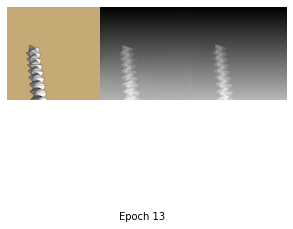

Epoch [14/50], Step [1/3750], D_loss: 0.3103, G_loss: 4.6145
Epoch [14/50], Step [2/3750], D_loss: 0.3557, G_loss: 5.2341
Epoch [14/50], Step [3/3750], D_loss: 0.4180, G_loss: 5.0498
Epoch [14/50], Step [4/3750], D_loss: 0.0257, G_loss: 11.1477
Epoch [14/50], Step [5/3750], D_loss: 0.1555, G_loss: 9.3813
Epoch [14/50], Step [6/3750], D_loss: 0.1171, G_loss: 6.8120
Epoch [14/50], Step [7/3750], D_loss: 0.0117, G_loss: 10.3411
Epoch [14/50], Step [8/3750], D_loss: 0.0749, G_loss: 7.3722
Epoch [14/50], Step [9/3750], D_loss: 0.0237, G_loss: 15.8621
Epoch [14/50], Step [10/3750], D_loss: 0.0356, G_loss: 11.3124
Epoch [14/50], Step [11/3750], D_loss: 0.1908, G_loss: 6.6975
Epoch [14/50], Step [12/3750], D_loss: 0.2678, G_loss: 7.2267
Epoch [14/50], Step [13/3750], D_loss: 0.1367, G_loss: 8.6115
Epoch [14/50], Step [14/3750], D_loss: 0.1861, G_loss: 13.2736
Epoch [14/50], Step [15/3750], D_loss: 0.0151, G_loss: 6.5381
Epoch [14/50], Step [16/3750], D_loss: 0.0954, G_loss: 5.2094
Epoch [14/50

Epoch [14/50], Step [133/3750], D_loss: 0.2119, G_loss: 8.9432
Epoch [14/50], Step [134/3750], D_loss: 0.0188, G_loss: 10.1453
Epoch [14/50], Step [135/3750], D_loss: 0.1229, G_loss: 8.6357
Epoch [14/50], Step [136/3750], D_loss: 0.0876, G_loss: 8.3186
Epoch [14/50], Step [137/3750], D_loss: 0.2231, G_loss: 5.2253
Epoch [14/50], Step [138/3750], D_loss: 0.0054, G_loss: 7.7462
Epoch [14/50], Step [139/3750], D_loss: 0.2938, G_loss: 7.5435
Epoch [14/50], Step [140/3750], D_loss: 0.2157, G_loss: 5.8017
Epoch [14/50], Step [141/3750], D_loss: 0.2769, G_loss: 4.8171
Epoch [14/50], Step [142/3750], D_loss: 0.0240, G_loss: 17.7406
Epoch [14/50], Step [143/3750], D_loss: 0.0216, G_loss: 10.8924
Epoch [14/50], Step [144/3750], D_loss: 0.0982, G_loss: 10.3204
Epoch [14/50], Step [145/3750], D_loss: 0.1655, G_loss: 9.3247
Epoch [14/50], Step [146/3750], D_loss: 0.2146, G_loss: 7.6948
Epoch [14/50], Step [147/3750], D_loss: 1.0967, G_loss: 4.1240
Epoch [14/50], Step [148/3750], D_loss: 0.2591, G_l

Epoch [14/50], Step [263/3750], D_loss: 0.0946, G_loss: 8.2827
Epoch [14/50], Step [264/3750], D_loss: 0.0388, G_loss: 6.5029
Epoch [14/50], Step [265/3750], D_loss: 0.2866, G_loss: 16.2131
Epoch [14/50], Step [266/3750], D_loss: 0.0532, G_loss: 12.5720
Epoch [14/50], Step [267/3750], D_loss: 0.2494, G_loss: 5.8689
Epoch [14/50], Step [268/3750], D_loss: 0.1381, G_loss: 5.5064
Epoch [14/50], Step [269/3750], D_loss: 0.0541, G_loss: 5.9999
Epoch [14/50], Step [270/3750], D_loss: 0.0240, G_loss: 9.2812
Epoch [14/50], Step [271/3750], D_loss: 0.0561, G_loss: 7.7556
Epoch [14/50], Step [272/3750], D_loss: 0.0090, G_loss: 11.0404
Epoch [14/50], Step [273/3750], D_loss: 0.0639, G_loss: 4.9396
Epoch [14/50], Step [274/3750], D_loss: 0.1610, G_loss: 6.5035
Epoch [14/50], Step [275/3750], D_loss: 0.0156, G_loss: 10.4592
Epoch [14/50], Step [276/3750], D_loss: 0.1241, G_loss: 6.5776
Epoch [14/50], Step [277/3750], D_loss: 0.1643, G_loss: 4.9028
Epoch [14/50], Step [278/3750], D_loss: 0.5142, G_l

Epoch [14/50], Step [393/3750], D_loss: 0.2673, G_loss: 5.7844
Epoch [14/50], Step [394/3750], D_loss: 0.1807, G_loss: 4.7990
Epoch [14/50], Step [395/3750], D_loss: 0.0987, G_loss: 9.0969
Epoch [14/50], Step [396/3750], D_loss: 0.3033, G_loss: 14.7777
Epoch [14/50], Step [397/3750], D_loss: 0.0110, G_loss: 9.1979
Epoch [14/50], Step [398/3750], D_loss: 0.3815, G_loss: 7.0394
Epoch [14/50], Step [399/3750], D_loss: 0.2385, G_loss: 5.9306
Epoch [14/50], Step [400/3750], D_loss: 0.1816, G_loss: 9.9141
Epoch [14/50], Step [401/3750], D_loss: 0.1180, G_loss: 4.2631
Epoch [14/50], Step [402/3750], D_loss: 0.3345, G_loss: 7.3243
Epoch [14/50], Step [403/3750], D_loss: 0.0843, G_loss: 8.1670
Epoch [14/50], Step [404/3750], D_loss: 0.0480, G_loss: 11.7301
Epoch [14/50], Step [405/3750], D_loss: 0.0554, G_loss: 8.9878
Epoch [14/50], Step [406/3750], D_loss: 0.0283, G_loss: 8.5529
Epoch [14/50], Step [407/3750], D_loss: 0.2317, G_loss: 9.0257
Epoch [14/50], Step [408/3750], D_loss: 0.1154, G_los

Epoch [14/50], Step [523/3750], D_loss: 0.1762, G_loss: 8.1706
Epoch [14/50], Step [524/3750], D_loss: 0.3291, G_loss: 7.9760
Epoch [14/50], Step [525/3750], D_loss: 0.2605, G_loss: 4.3004
Epoch [14/50], Step [526/3750], D_loss: 0.1118, G_loss: 14.0912
Epoch [14/50], Step [527/3750], D_loss: 0.9126, G_loss: 7.1879
Epoch [14/50], Step [528/3750], D_loss: 0.1809, G_loss: 6.4371
Epoch [14/50], Step [529/3750], D_loss: 0.0920, G_loss: 5.2428
Epoch [14/50], Step [530/3750], D_loss: 0.0633, G_loss: 10.8261
Epoch [14/50], Step [531/3750], D_loss: 0.5133, G_loss: 21.5203
Epoch [14/50], Step [532/3750], D_loss: 0.5155, G_loss: 6.8806
Epoch [14/50], Step [533/3750], D_loss: 0.0253, G_loss: 10.3215
Epoch [14/50], Step [534/3750], D_loss: 0.2775, G_loss: 6.7997
Epoch [14/50], Step [535/3750], D_loss: 0.4369, G_loss: 3.8657
Epoch [14/50], Step [536/3750], D_loss: 0.1285, G_loss: 5.1985
Epoch [14/50], Step [537/3750], D_loss: 0.8327, G_loss: 5.3652
Epoch [14/50], Step [538/3750], D_loss: 0.0450, G_l

Epoch [14/50], Step [653/3750], D_loss: 0.0531, G_loss: 10.7152
Epoch [14/50], Step [654/3750], D_loss: 0.0932, G_loss: 5.8101
Epoch [14/50], Step [655/3750], D_loss: 0.0536, G_loss: 8.4362
Epoch [14/50], Step [656/3750], D_loss: 0.7754, G_loss: 5.9360
Epoch [14/50], Step [657/3750], D_loss: 0.2973, G_loss: 7.5917
Epoch [14/50], Step [658/3750], D_loss: 0.3042, G_loss: 7.7134
Epoch [14/50], Step [659/3750], D_loss: 0.0516, G_loss: 6.7452
Epoch [14/50], Step [660/3750], D_loss: 0.0230, G_loss: 8.2752
Epoch [14/50], Step [661/3750], D_loss: 0.0719, G_loss: 8.5529
Epoch [14/50], Step [662/3750], D_loss: 0.6446, G_loss: 6.3788
Epoch [14/50], Step [663/3750], D_loss: 0.2031, G_loss: 7.4012
Epoch [14/50], Step [664/3750], D_loss: 0.0350, G_loss: 5.8318
Epoch [14/50], Step [665/3750], D_loss: 0.5506, G_loss: 3.6093
Epoch [14/50], Step [666/3750], D_loss: 0.2767, G_loss: 4.7659
Epoch [14/50], Step [667/3750], D_loss: 0.7165, G_loss: 8.6201
Epoch [14/50], Step [668/3750], D_loss: 0.0610, G_loss

Epoch [14/50], Step [783/3750], D_loss: 0.0840, G_loss: 5.4293
Epoch [14/50], Step [784/3750], D_loss: 0.4012, G_loss: 10.2995
Epoch [14/50], Step [785/3750], D_loss: 0.1867, G_loss: 15.8712
Epoch [14/50], Step [786/3750], D_loss: 0.1031, G_loss: 10.2152
Epoch [14/50], Step [787/3750], D_loss: 0.3844, G_loss: 8.8313
Epoch [14/50], Step [788/3750], D_loss: 0.2065, G_loss: 10.9741
Epoch [14/50], Step [789/3750], D_loss: 0.1491, G_loss: 13.7067
Epoch [14/50], Step [790/3750], D_loss: 0.4805, G_loss: 10.4949
Epoch [14/50], Step [791/3750], D_loss: 0.1293, G_loss: 9.7211
Epoch [14/50], Step [792/3750], D_loss: 0.2907, G_loss: 7.0348
Epoch [14/50], Step [793/3750], D_loss: 0.0082, G_loss: 9.4955
Epoch [14/50], Step [794/3750], D_loss: 0.1219, G_loss: 14.7174
Epoch [14/50], Step [795/3750], D_loss: 0.2839, G_loss: 7.1998
Epoch [14/50], Step [796/3750], D_loss: 0.0749, G_loss: 11.0544
Epoch [14/50], Step [797/3750], D_loss: 0.0508, G_loss: 14.8777
Epoch [14/50], Step [798/3750], D_loss: 0.0719

Epoch [14/50], Step [913/3750], D_loss: 0.0206, G_loss: 6.2464
Epoch [14/50], Step [914/3750], D_loss: 0.0347, G_loss: 11.0928
Epoch [14/50], Step [915/3750], D_loss: 0.0127, G_loss: 10.4007
Epoch [14/50], Step [916/3750], D_loss: 0.0129, G_loss: 5.4264
Epoch [14/50], Step [917/3750], D_loss: 0.0566, G_loss: 8.2951
Epoch [14/50], Step [918/3750], D_loss: 0.0125, G_loss: 7.8321
Epoch [14/50], Step [919/3750], D_loss: 0.0150, G_loss: 8.8928
Epoch [14/50], Step [920/3750], D_loss: 0.4834, G_loss: 7.0751
Epoch [14/50], Step [921/3750], D_loss: 0.0058, G_loss: 9.1287
Epoch [14/50], Step [922/3750], D_loss: 0.0275, G_loss: 9.1454
Epoch [14/50], Step [923/3750], D_loss: 0.0380, G_loss: 7.6184
Epoch [14/50], Step [924/3750], D_loss: 0.0866, G_loss: 6.4113
Epoch [14/50], Step [925/3750], D_loss: 0.0336, G_loss: 6.4610
Epoch [14/50], Step [926/3750], D_loss: 0.0258, G_loss: 5.4431
Epoch [14/50], Step [927/3750], D_loss: 0.1854, G_loss: 10.9626
Epoch [14/50], Step [928/3750], D_loss: 0.0259, G_lo

Epoch [14/50], Step [1042/3750], D_loss: 0.0822, G_loss: 10.3148
Epoch [14/50], Step [1043/3750], D_loss: 0.0731, G_loss: 41.2178
Epoch [14/50], Step [1044/3750], D_loss: 0.3493, G_loss: 7.8456
Epoch [14/50], Step [1045/3750], D_loss: 0.0646, G_loss: 9.3873
Epoch [14/50], Step [1046/3750], D_loss: 0.2056, G_loss: 6.6978
Epoch [14/50], Step [1047/3750], D_loss: 0.3741, G_loss: 3.7434
Epoch [14/50], Step [1048/3750], D_loss: 0.4119, G_loss: 7.5323
Epoch [14/50], Step [1049/3750], D_loss: 0.0839, G_loss: 5.0212
Epoch [14/50], Step [1050/3750], D_loss: 0.0678, G_loss: 9.8010
Epoch [14/50], Step [1051/3750], D_loss: 0.0589, G_loss: 7.9565
Epoch [14/50], Step [1052/3750], D_loss: 0.1484, G_loss: 14.2364
Epoch [14/50], Step [1053/3750], D_loss: 0.0415, G_loss: 14.9996
Epoch [14/50], Step [1054/3750], D_loss: 0.1277, G_loss: 5.5521
Epoch [14/50], Step [1055/3750], D_loss: 0.0667, G_loss: 12.7031
Epoch [14/50], Step [1056/3750], D_loss: 0.7640, G_loss: 3.1971
Epoch [14/50], Step [1057/3750], D_

Epoch [14/50], Step [1170/3750], D_loss: 0.0154, G_loss: 6.0020
Epoch [14/50], Step [1171/3750], D_loss: 0.0533, G_loss: 7.3702
Epoch [14/50], Step [1172/3750], D_loss: 0.0976, G_loss: 8.0954
Epoch [14/50], Step [1173/3750], D_loss: 0.0601, G_loss: 6.5943
Epoch [14/50], Step [1174/3750], D_loss: 0.1537, G_loss: 6.4512
Epoch [14/50], Step [1175/3750], D_loss: 0.0894, G_loss: 14.1348
Epoch [14/50], Step [1176/3750], D_loss: 0.0648, G_loss: 8.9306
Epoch [14/50], Step [1177/3750], D_loss: 0.0769, G_loss: 7.1216
Epoch [14/50], Step [1178/3750], D_loss: 0.1706, G_loss: 8.8524
Epoch [14/50], Step [1179/3750], D_loss: 0.1283, G_loss: 6.3719
Epoch [14/50], Step [1180/3750], D_loss: 0.0807, G_loss: 6.0849
Epoch [14/50], Step [1181/3750], D_loss: 0.2246, G_loss: 8.2899
Epoch [14/50], Step [1182/3750], D_loss: 0.0935, G_loss: 6.9739
Epoch [14/50], Step [1183/3750], D_loss: 0.3727, G_loss: 6.8294
Epoch [14/50], Step [1184/3750], D_loss: 0.1483, G_loss: 7.6852
Epoch [14/50], Step [1185/3750], D_loss

Epoch [14/50], Step [1298/3750], D_loss: 0.3313, G_loss: 5.0977
Epoch [14/50], Step [1299/3750], D_loss: 0.1719, G_loss: 7.1409
Epoch [14/50], Step [1300/3750], D_loss: 0.1025, G_loss: 10.7236
Epoch [14/50], Step [1301/3750], D_loss: 0.0935, G_loss: 5.4992
Epoch [14/50], Step [1302/3750], D_loss: 0.3024, G_loss: 8.1844
Epoch [14/50], Step [1303/3750], D_loss: 0.0400, G_loss: 10.1858
Epoch [14/50], Step [1304/3750], D_loss: 0.0351, G_loss: 8.7542
Epoch [14/50], Step [1305/3750], D_loss: 0.6611, G_loss: 4.4139
Epoch [14/50], Step [1306/3750], D_loss: 0.2044, G_loss: 6.8160
Epoch [14/50], Step [1307/3750], D_loss: 0.2118, G_loss: 12.8975
Epoch [14/50], Step [1308/3750], D_loss: 0.0925, G_loss: 6.9490
Epoch [14/50], Step [1309/3750], D_loss: 0.1683, G_loss: 8.9011
Epoch [14/50], Step [1310/3750], D_loss: 0.2851, G_loss: 5.5348
Epoch [14/50], Step [1311/3750], D_loss: 0.7041, G_loss: 4.8878
Epoch [14/50], Step [1312/3750], D_loss: 0.1791, G_loss: 6.2798
Epoch [14/50], Step [1313/3750], D_lo

Epoch [14/50], Step [1426/3750], D_loss: 0.0472, G_loss: 6.9509
Epoch [14/50], Step [1427/3750], D_loss: 0.1893, G_loss: 5.0962
Epoch [14/50], Step [1428/3750], D_loss: 0.0928, G_loss: 7.2446
Epoch [14/50], Step [1429/3750], D_loss: 0.2072, G_loss: 5.7033
Epoch [14/50], Step [1430/3750], D_loss: 0.1802, G_loss: 7.2568
Epoch [14/50], Step [1431/3750], D_loss: 0.0395, G_loss: 9.0493
Epoch [14/50], Step [1432/3750], D_loss: 0.2841, G_loss: 4.9502
Epoch [14/50], Step [1433/3750], D_loss: 0.1781, G_loss: 6.6949
Epoch [14/50], Step [1434/3750], D_loss: 0.1344, G_loss: 12.6558
Epoch [14/50], Step [1435/3750], D_loss: 0.2308, G_loss: 9.5465
Epoch [14/50], Step [1436/3750], D_loss: 0.1625, G_loss: 8.0248
Epoch [14/50], Step [1437/3750], D_loss: 0.0481, G_loss: 5.3623
Epoch [14/50], Step [1438/3750], D_loss: 0.1173, G_loss: 9.2285
Epoch [14/50], Step [1439/3750], D_loss: 0.0219, G_loss: 13.6859
Epoch [14/50], Step [1440/3750], D_loss: 0.3579, G_loss: 5.9326
Epoch [14/50], Step [1441/3750], D_los

Epoch [14/50], Step [1554/3750], D_loss: 0.0599, G_loss: 7.3453
Epoch [14/50], Step [1555/3750], D_loss: 0.3676, G_loss: 9.5617
Epoch [14/50], Step [1556/3750], D_loss: 0.0955, G_loss: 4.6053
Epoch [14/50], Step [1557/3750], D_loss: 0.0790, G_loss: 11.0219
Epoch [14/50], Step [1558/3750], D_loss: 0.0835, G_loss: 10.7219
Epoch [14/50], Step [1559/3750], D_loss: 0.0238, G_loss: 6.9011
Epoch [14/50], Step [1560/3750], D_loss: 0.3141, G_loss: 7.7840
Epoch [14/50], Step [1561/3750], D_loss: 0.1272, G_loss: 4.8385
Epoch [14/50], Step [1562/3750], D_loss: 0.0354, G_loss: 11.7536
Epoch [14/50], Step [1563/3750], D_loss: 0.1010, G_loss: 9.8608
Epoch [14/50], Step [1564/3750], D_loss: 0.0982, G_loss: 12.4287
Epoch [14/50], Step [1565/3750], D_loss: 0.4307, G_loss: 4.0109
Epoch [14/50], Step [1566/3750], D_loss: 0.1942, G_loss: 8.2032
Epoch [14/50], Step [1567/3750], D_loss: 0.2716, G_loss: 5.3316
Epoch [14/50], Step [1568/3750], D_loss: 0.3745, G_loss: 6.0205
Epoch [14/50], Step [1569/3750], D_l

Epoch [14/50], Step [1682/3750], D_loss: 0.0106, G_loss: 9.5632
Epoch [14/50], Step [1683/3750], D_loss: 0.1537, G_loss: 5.8093
Epoch [14/50], Step [1684/3750], D_loss: 0.0699, G_loss: 6.6314
Epoch [14/50], Step [1685/3750], D_loss: 0.1935, G_loss: 5.5587
Epoch [14/50], Step [1686/3750], D_loss: 0.0842, G_loss: 5.3533
Epoch [14/50], Step [1687/3750], D_loss: 0.1978, G_loss: 5.7348
Epoch [14/50], Step [1688/3750], D_loss: 0.0728, G_loss: 6.4857
Epoch [14/50], Step [1689/3750], D_loss: 0.0120, G_loss: 7.4103
Epoch [14/50], Step [1690/3750], D_loss: 0.0433, G_loss: 8.6643
Epoch [14/50], Step [1691/3750], D_loss: 0.2550, G_loss: 7.3313
Epoch [14/50], Step [1692/3750], D_loss: 0.0040, G_loss: 12.9782
Epoch [14/50], Step [1693/3750], D_loss: 0.0640, G_loss: 7.2906
Epoch [14/50], Step [1694/3750], D_loss: 0.1437, G_loss: 12.0080
Epoch [14/50], Step [1695/3750], D_loss: 1.1989, G_loss: 5.4252
Epoch [14/50], Step [1696/3750], D_loss: 0.0995, G_loss: 8.6429
Epoch [14/50], Step [1697/3750], D_los

Epoch [14/50], Step [1810/3750], D_loss: 0.6907, G_loss: 5.2664
Epoch [14/50], Step [1811/3750], D_loss: 0.3544, G_loss: 5.1643
Epoch [14/50], Step [1812/3750], D_loss: 0.0720, G_loss: 5.3941
Epoch [14/50], Step [1813/3750], D_loss: 0.0565, G_loss: 8.7221
Epoch [14/50], Step [1814/3750], D_loss: 0.1148, G_loss: 7.2375
Epoch [14/50], Step [1815/3750], D_loss: 0.1287, G_loss: 5.0231
Epoch [14/50], Step [1816/3750], D_loss: 0.1631, G_loss: 8.6287
Epoch [14/50], Step [1817/3750], D_loss: 0.2794, G_loss: 7.5634
Epoch [14/50], Step [1818/3750], D_loss: 0.8103, G_loss: 4.0556
Epoch [14/50], Step [1819/3750], D_loss: 0.0811, G_loss: 11.6969
Epoch [14/50], Step [1820/3750], D_loss: 0.1213, G_loss: 7.6280
Epoch [14/50], Step [1821/3750], D_loss: 0.0782, G_loss: 5.3149
Epoch [14/50], Step [1822/3750], D_loss: 0.0869, G_loss: 8.0894
Epoch [14/50], Step [1823/3750], D_loss: 0.1878, G_loss: 8.5878
Epoch [14/50], Step [1824/3750], D_loss: 0.0582, G_loss: 10.6291
Epoch [14/50], Step [1825/3750], D_los

Epoch [14/50], Step [1938/3750], D_loss: 0.2372, G_loss: 6.8193
Epoch [14/50], Step [1939/3750], D_loss: 0.0170, G_loss: 8.3935
Epoch [14/50], Step [1940/3750], D_loss: 0.1646, G_loss: 6.8336
Epoch [14/50], Step [1941/3750], D_loss: 0.2915, G_loss: 7.3989
Epoch [14/50], Step [1942/3750], D_loss: 0.0758, G_loss: 7.6545
Epoch [14/50], Step [1943/3750], D_loss: 0.2553, G_loss: 6.0561
Epoch [14/50], Step [1944/3750], D_loss: 0.0294, G_loss: 6.7010
Epoch [14/50], Step [1945/3750], D_loss: 0.1635, G_loss: 5.3585
Epoch [14/50], Step [1946/3750], D_loss: 0.2239, G_loss: 13.2961
Epoch [14/50], Step [1947/3750], D_loss: 0.2241, G_loss: 9.2472
Epoch [14/50], Step [1948/3750], D_loss: 0.1314, G_loss: 8.5734
Epoch [14/50], Step [1949/3750], D_loss: 0.1512, G_loss: 4.4235
Epoch [14/50], Step [1950/3750], D_loss: 0.1303, G_loss: 6.7845
Epoch [14/50], Step [1951/3750], D_loss: 0.0437, G_loss: 11.1658
Epoch [14/50], Step [1952/3750], D_loss: 0.0604, G_loss: 7.0514
Epoch [14/50], Step [1953/3750], D_los

Epoch [14/50], Step [2066/3750], D_loss: 0.0401, G_loss: 6.1411
Epoch [14/50], Step [2067/3750], D_loss: 0.3566, G_loss: 5.4416
Epoch [14/50], Step [2068/3750], D_loss: 0.1161, G_loss: 8.8037
Epoch [14/50], Step [2069/3750], D_loss: 0.3565, G_loss: 5.2155
Epoch [14/50], Step [2070/3750], D_loss: 0.3775, G_loss: 7.3749
Epoch [14/50], Step [2071/3750], D_loss: 0.0374, G_loss: 13.0650
Epoch [14/50], Step [2072/3750], D_loss: 0.0989, G_loss: 8.4176
Epoch [14/50], Step [2073/3750], D_loss: 0.0942, G_loss: 8.0059
Epoch [14/50], Step [2074/3750], D_loss: 0.0974, G_loss: 6.1334
Epoch [14/50], Step [2075/3750], D_loss: 0.1381, G_loss: 15.7468
Epoch [14/50], Step [2076/3750], D_loss: 0.5384, G_loss: 14.9406
Epoch [14/50], Step [2077/3750], D_loss: 0.3556, G_loss: 9.9381
Epoch [14/50], Step [2078/3750], D_loss: 0.0205, G_loss: 12.2563
Epoch [14/50], Step [2079/3750], D_loss: 0.3000, G_loss: 7.3731
Epoch [14/50], Step [2080/3750], D_loss: 0.1224, G_loss: 11.1009
Epoch [14/50], Step [2081/3750], D_

Epoch [14/50], Step [2194/3750], D_loss: 0.0245, G_loss: 13.9414
Epoch [14/50], Step [2195/3750], D_loss: 0.1109, G_loss: 5.9773
Epoch [14/50], Step [2196/3750], D_loss: 0.0499, G_loss: 4.6239
Epoch [14/50], Step [2197/3750], D_loss: 0.0316, G_loss: 5.0980
Epoch [14/50], Step [2198/3750], D_loss: 0.0857, G_loss: 6.4291
Epoch [14/50], Step [2199/3750], D_loss: 0.1396, G_loss: 4.0002
Epoch [14/50], Step [2200/3750], D_loss: 0.1073, G_loss: 9.0282
Epoch [14/50], Step [2201/3750], D_loss: 0.2688, G_loss: 6.5748
Epoch [14/50], Step [2202/3750], D_loss: 0.0195, G_loss: 6.7857
Epoch [14/50], Step [2203/3750], D_loss: 0.0233, G_loss: 11.3752
Epoch [14/50], Step [2204/3750], D_loss: 0.0404, G_loss: 15.1797
Epoch [14/50], Step [2205/3750], D_loss: 0.0315, G_loss: 6.0482
Epoch [14/50], Step [2206/3750], D_loss: 0.0551, G_loss: 9.3716
Epoch [14/50], Step [2207/3750], D_loss: 0.1821, G_loss: 4.5710
Epoch [14/50], Step [2208/3750], D_loss: 0.0334, G_loss: 6.4169
Epoch [14/50], Step [2209/3750], D_lo

Epoch [14/50], Step [2322/3750], D_loss: 0.0541, G_loss: 11.7187
Epoch [14/50], Step [2323/3750], D_loss: 0.2327, G_loss: 6.0883
Epoch [14/50], Step [2324/3750], D_loss: 0.2633, G_loss: 4.3812
Epoch [14/50], Step [2325/3750], D_loss: 0.3465, G_loss: 4.9146
Epoch [14/50], Step [2326/3750], D_loss: 0.1512, G_loss: 13.0992
Epoch [14/50], Step [2327/3750], D_loss: 0.1813, G_loss: 5.5270
Epoch [14/50], Step [2328/3750], D_loss: 0.0220, G_loss: 10.0670
Epoch [14/50], Step [2329/3750], D_loss: 0.0267, G_loss: 10.4268
Epoch [14/50], Step [2330/3750], D_loss: 0.1487, G_loss: 13.2007
Epoch [14/50], Step [2331/3750], D_loss: 0.0419, G_loss: 8.4794
Epoch [14/50], Step [2332/3750], D_loss: 0.4741, G_loss: 7.3649
Epoch [14/50], Step [2333/3750], D_loss: 0.1100, G_loss: 9.0728
Epoch [14/50], Step [2334/3750], D_loss: 0.0727, G_loss: 7.8842
Epoch [14/50], Step [2335/3750], D_loss: 0.1151, G_loss: 8.4843
Epoch [14/50], Step [2336/3750], D_loss: 0.1563, G_loss: 5.7394
Epoch [14/50], Step [2337/3750], D_

Epoch [14/50], Step [2450/3750], D_loss: 0.2512, G_loss: 7.8919
Epoch [14/50], Step [2451/3750], D_loss: 0.0379, G_loss: 8.7667
Epoch [14/50], Step [2452/3750], D_loss: 0.0353, G_loss: 6.3868
Epoch [14/50], Step [2453/3750], D_loss: 0.2183, G_loss: 9.0223
Epoch [14/50], Step [2454/3750], D_loss: 0.0090, G_loss: 7.1457
Epoch [14/50], Step [2455/3750], D_loss: 0.8495, G_loss: 3.8560
Epoch [14/50], Step [2456/3750], D_loss: 0.1911, G_loss: 15.9848
Epoch [14/50], Step [2457/3750], D_loss: 0.0785, G_loss: 5.3795
Epoch [14/50], Step [2458/3750], D_loss: 0.0741, G_loss: 5.3579
Epoch [14/50], Step [2459/3750], D_loss: 0.2262, G_loss: 6.2202
Epoch [14/50], Step [2460/3750], D_loss: 0.1088, G_loss: 6.4127
Epoch [14/50], Step [2461/3750], D_loss: 0.1101, G_loss: 8.2176
Epoch [14/50], Step [2462/3750], D_loss: 0.3288, G_loss: 4.0454
Epoch [14/50], Step [2463/3750], D_loss: 0.0432, G_loss: 5.9067
Epoch [14/50], Step [2464/3750], D_loss: 0.0334, G_loss: 5.1527
Epoch [14/50], Step [2465/3750], D_loss

Epoch [14/50], Step [2578/3750], D_loss: 0.3864, G_loss: 7.2749
Epoch [14/50], Step [2579/3750], D_loss: 0.1227, G_loss: 7.1993
Epoch [14/50], Step [2580/3750], D_loss: 0.2482, G_loss: 4.8289
Epoch [14/50], Step [2581/3750], D_loss: 0.1103, G_loss: 11.6339
Epoch [14/50], Step [2582/3750], D_loss: 0.2114, G_loss: 8.5902
Epoch [14/50], Step [2583/3750], D_loss: 0.1244, G_loss: 6.9467
Epoch [14/50], Step [2584/3750], D_loss: 0.3733, G_loss: 5.1455
Epoch [14/50], Step [2585/3750], D_loss: 0.0529, G_loss: 12.0476
Epoch [14/50], Step [2586/3750], D_loss: 0.1675, G_loss: 14.0036
Epoch [14/50], Step [2587/3750], D_loss: 0.0432, G_loss: 13.9548
Epoch [14/50], Step [2588/3750], D_loss: 0.0645, G_loss: 7.7674
Epoch [14/50], Step [2589/3750], D_loss: 0.0181, G_loss: 15.3244
Epoch [14/50], Step [2590/3750], D_loss: 0.1682, G_loss: 4.9232
Epoch [14/50], Step [2591/3750], D_loss: 0.1395, G_loss: 6.2893
Epoch [14/50], Step [2592/3750], D_loss: 0.3609, G_loss: 9.1018
Epoch [14/50], Step [2593/3750], D_

Epoch [14/50], Step [2706/3750], D_loss: 0.1163, G_loss: 15.0183
Epoch [14/50], Step [2707/3750], D_loss: 0.2580, G_loss: 6.2611
Epoch [14/50], Step [2708/3750], D_loss: 0.0414, G_loss: 10.0355
Epoch [14/50], Step [2709/3750], D_loss: 0.0384, G_loss: 6.4594
Epoch [14/50], Step [2710/3750], D_loss: 0.0248, G_loss: 15.9508
Epoch [14/50], Step [2711/3750], D_loss: 0.0164, G_loss: 10.3014
Epoch [14/50], Step [2712/3750], D_loss: 0.0370, G_loss: 8.5509
Epoch [14/50], Step [2713/3750], D_loss: 0.1811, G_loss: 5.8901
Epoch [14/50], Step [2714/3750], D_loss: 0.0975, G_loss: 6.4987
Epoch [14/50], Step [2715/3750], D_loss: 0.1134, G_loss: 5.2403
Epoch [14/50], Step [2716/3750], D_loss: 0.3721, G_loss: 7.4081
Epoch [14/50], Step [2717/3750], D_loss: 0.0298, G_loss: 7.7926
Epoch [14/50], Step [2718/3750], D_loss: 0.6287, G_loss: 11.5717
Epoch [14/50], Step [2719/3750], D_loss: 0.4234, G_loss: 7.8888
Epoch [14/50], Step [2720/3750], D_loss: 0.0547, G_loss: 14.2598
Epoch [14/50], Step [2721/3750], D

Epoch [14/50], Step [2834/3750], D_loss: 0.7903, G_loss: 7.0309
Epoch [14/50], Step [2835/3750], D_loss: 0.3619, G_loss: 7.2126
Epoch [14/50], Step [2836/3750], D_loss: 0.4901, G_loss: 13.3597
Epoch [14/50], Step [2837/3750], D_loss: 0.1267, G_loss: 9.2685
Epoch [14/50], Step [2838/3750], D_loss: 0.1285, G_loss: 7.2182
Epoch [14/50], Step [2839/3750], D_loss: 0.3208, G_loss: 6.8689
Epoch [14/50], Step [2840/3750], D_loss: 0.0899, G_loss: 7.4958
Epoch [14/50], Step [2841/3750], D_loss: 0.0289, G_loss: 10.9516
Epoch [14/50], Step [2842/3750], D_loss: 0.1070, G_loss: 5.0708
Epoch [14/50], Step [2843/3750], D_loss: 0.2290, G_loss: 5.5371
Epoch [14/50], Step [2844/3750], D_loss: 0.1472, G_loss: 3.9146
Epoch [14/50], Step [2845/3750], D_loss: 0.1387, G_loss: 6.1696
Epoch [14/50], Step [2846/3750], D_loss: 0.1197, G_loss: 7.3610
Epoch [14/50], Step [2847/3750], D_loss: 0.0448, G_loss: 5.9223
Epoch [14/50], Step [2848/3750], D_loss: 0.0149, G_loss: 8.6315
Epoch [14/50], Step [2849/3750], D_los

Epoch [14/50], Step [2962/3750], D_loss: 0.0369, G_loss: 6.6545
Epoch [14/50], Step [2963/3750], D_loss: 0.0709, G_loss: 5.2391
Epoch [14/50], Step [2964/3750], D_loss: 0.0103, G_loss: 7.5044
Epoch [14/50], Step [2965/3750], D_loss: 0.2974, G_loss: 5.4305
Epoch [14/50], Step [2966/3750], D_loss: 0.0123, G_loss: 12.1334
Epoch [14/50], Step [2967/3750], D_loss: 0.9008, G_loss: 5.6009
Epoch [14/50], Step [2968/3750], D_loss: 0.3002, G_loss: 4.3362
Epoch [14/50], Step [2969/3750], D_loss: 0.1180, G_loss: 7.2517
Epoch [14/50], Step [2970/3750], D_loss: 0.0795, G_loss: 12.6627
Epoch [14/50], Step [2971/3750], D_loss: 0.4134, G_loss: 4.2859
Epoch [14/50], Step [2972/3750], D_loss: 0.1840, G_loss: 4.3224
Epoch [14/50], Step [2973/3750], D_loss: 0.1924, G_loss: 4.1365
Epoch [14/50], Step [2974/3750], D_loss: 0.0211, G_loss: 9.7380
Epoch [14/50], Step [2975/3750], D_loss: 0.1158, G_loss: 12.1062
Epoch [14/50], Step [2976/3750], D_loss: 0.0243, G_loss: 7.3982
Epoch [14/50], Step [2977/3750], D_lo

Epoch [14/50], Step [3090/3750], D_loss: 0.0271, G_loss: 6.4153
Epoch [14/50], Step [3091/3750], D_loss: 0.1073, G_loss: 6.2341
Epoch [14/50], Step [3092/3750], D_loss: 0.3622, G_loss: 5.5644
Epoch [14/50], Step [3093/3750], D_loss: 0.0890, G_loss: 7.5209
Epoch [14/50], Step [3094/3750], D_loss: 0.0904, G_loss: 5.4649
Epoch [14/50], Step [3095/3750], D_loss: 0.3666, G_loss: 5.1260
Epoch [14/50], Step [3096/3750], D_loss: 0.1799, G_loss: 5.3888
Epoch [14/50], Step [3097/3750], D_loss: 0.0660, G_loss: 8.5851
Epoch [14/50], Step [3098/3750], D_loss: 0.2195, G_loss: 9.3671
Epoch [14/50], Step [3099/3750], D_loss: 0.3863, G_loss: 6.5085
Epoch [14/50], Step [3100/3750], D_loss: 0.0100, G_loss: 6.3224
Epoch [14/50], Step [3101/3750], D_loss: 0.1035, G_loss: 14.4512
Epoch [14/50], Step [3102/3750], D_loss: 0.1097, G_loss: 6.9093
Epoch [14/50], Step [3103/3750], D_loss: 0.0210, G_loss: 13.1505
Epoch [14/50], Step [3104/3750], D_loss: 0.0891, G_loss: 7.3191
Epoch [14/50], Step [3105/3750], D_los

Epoch [14/50], Step [3218/3750], D_loss: 0.0910, G_loss: 8.6450
Epoch [14/50], Step [3219/3750], D_loss: 0.2361, G_loss: 8.3454
Epoch [14/50], Step [3220/3750], D_loss: 0.0721, G_loss: 9.7091
Epoch [14/50], Step [3221/3750], D_loss: 0.0564, G_loss: 8.3327
Epoch [14/50], Step [3222/3750], D_loss: 0.1116, G_loss: 15.0002
Epoch [14/50], Step [3223/3750], D_loss: 0.0329, G_loss: 8.0417
Epoch [14/50], Step [3224/3750], D_loss: 0.0511, G_loss: 9.8574
Epoch [14/50], Step [3225/3750], D_loss: 0.0808, G_loss: 11.1520
Epoch [14/50], Step [3226/3750], D_loss: 0.3470, G_loss: 7.8477
Epoch [14/50], Step [3227/3750], D_loss: 0.0103, G_loss: 10.2209
Epoch [14/50], Step [3228/3750], D_loss: 0.0634, G_loss: 7.6839
Epoch [14/50], Step [3229/3750], D_loss: 0.0868, G_loss: 7.7831
Epoch [14/50], Step [3230/3750], D_loss: 0.3018, G_loss: 6.6069
Epoch [14/50], Step [3231/3750], D_loss: 0.0757, G_loss: 9.1014
Epoch [14/50], Step [3232/3750], D_loss: 0.0539, G_loss: 10.1663
Epoch [14/50], Step [3233/3750], D_l

Epoch [14/50], Step [3346/3750], D_loss: 0.4926, G_loss: 6.8730
Epoch [14/50], Step [3347/3750], D_loss: 0.0421, G_loss: 10.5138
Epoch [14/50], Step [3348/3750], D_loss: 0.4103, G_loss: 7.6903
Epoch [14/50], Step [3349/3750], D_loss: 0.0354, G_loss: 6.7821
Epoch [14/50], Step [3350/3750], D_loss: 0.4124, G_loss: 7.3399
Epoch [14/50], Step [3351/3750], D_loss: 0.0718, G_loss: 20.4113
Epoch [14/50], Step [3352/3750], D_loss: 0.5235, G_loss: 6.2064
Epoch [14/50], Step [3353/3750], D_loss: 0.1951, G_loss: 4.8975
Epoch [14/50], Step [3354/3750], D_loss: 0.1577, G_loss: 9.6033
Epoch [14/50], Step [3355/3750], D_loss: 0.1465, G_loss: 6.7306
Epoch [14/50], Step [3356/3750], D_loss: 0.2491, G_loss: 14.6756
Epoch [14/50], Step [3357/3750], D_loss: 0.3947, G_loss: 7.7511
Epoch [14/50], Step [3358/3750], D_loss: 0.0274, G_loss: 10.2828
Epoch [14/50], Step [3359/3750], D_loss: 0.1964, G_loss: 7.4988
Epoch [14/50], Step [3360/3750], D_loss: 0.0626, G_loss: 10.2179
Epoch [14/50], Step [3361/3750], D_

Epoch [14/50], Step [3474/3750], D_loss: 0.1756, G_loss: 8.7952
Epoch [14/50], Step [3475/3750], D_loss: 0.0555, G_loss: 10.5535
Epoch [14/50], Step [3476/3750], D_loss: 0.1154, G_loss: 6.6240
Epoch [14/50], Step [3477/3750], D_loss: 0.1825, G_loss: 7.6276
Epoch [14/50], Step [3478/3750], D_loss: 0.0222, G_loss: 12.9916
Epoch [14/50], Step [3479/3750], D_loss: 0.2321, G_loss: 7.6648
Epoch [14/50], Step [3480/3750], D_loss: 0.1436, G_loss: 13.3163
Epoch [14/50], Step [3481/3750], D_loss: 0.3700, G_loss: 5.7882
Epoch [14/50], Step [3482/3750], D_loss: 0.2194, G_loss: 6.7986
Epoch [14/50], Step [3483/3750], D_loss: 0.4411, G_loss: 6.9252
Epoch [14/50], Step [3484/3750], D_loss: 0.0438, G_loss: 14.0975
Epoch [14/50], Step [3485/3750], D_loss: 0.0405, G_loss: 7.6809
Epoch [14/50], Step [3486/3750], D_loss: 0.4409, G_loss: 6.5096
Epoch [14/50], Step [3487/3750], D_loss: 0.4063, G_loss: 3.8300
Epoch [14/50], Step [3488/3750], D_loss: 0.1055, G_loss: 6.5682
Epoch [14/50], Step [3489/3750], D_l

Epoch [14/50], Step [3602/3750], D_loss: 0.4572, G_loss: 6.9494
Epoch [14/50], Step [3603/3750], D_loss: 0.1401, G_loss: 4.9027
Epoch [14/50], Step [3604/3750], D_loss: 0.0564, G_loss: 8.2259
Epoch [14/50], Step [3605/3750], D_loss: 0.6149, G_loss: 4.9754
Epoch [14/50], Step [3606/3750], D_loss: 0.0392, G_loss: 7.8688
Epoch [14/50], Step [3607/3750], D_loss: 0.0385, G_loss: 7.5844
Epoch [14/50], Step [3608/3750], D_loss: 0.0516, G_loss: 11.2830
Epoch [14/50], Step [3609/3750], D_loss: 0.5122, G_loss: 7.0760
Epoch [14/50], Step [3610/3750], D_loss: 0.0135, G_loss: 13.0503
Epoch [14/50], Step [3611/3750], D_loss: 0.1372, G_loss: 9.1921
Epoch [14/50], Step [3612/3750], D_loss: 0.0953, G_loss: 10.2476
Epoch [14/50], Step [3613/3750], D_loss: 0.0064, G_loss: 14.8011
Epoch [14/50], Step [3614/3750], D_loss: 0.1990, G_loss: 5.8145
Epoch [14/50], Step [3615/3750], D_loss: 0.0310, G_loss: 7.4801
Epoch [14/50], Step [3616/3750], D_loss: 0.1671, G_loss: 11.7997
Epoch [14/50], Step [3617/3750], D_

Epoch [14/50], Step [3730/3750], D_loss: 0.0495, G_loss: 7.0415
Epoch [14/50], Step [3731/3750], D_loss: 0.0324, G_loss: 13.8499
Epoch [14/50], Step [3732/3750], D_loss: 0.5153, G_loss: 3.6941
Epoch [14/50], Step [3733/3750], D_loss: 0.1658, G_loss: 8.7117
Epoch [14/50], Step [3734/3750], D_loss: 0.2611, G_loss: 8.5002
Epoch [14/50], Step [3735/3750], D_loss: 0.1220, G_loss: 8.2991
Epoch [14/50], Step [3736/3750], D_loss: 0.0441, G_loss: 10.5476
Epoch [14/50], Step [3737/3750], D_loss: 0.0250, G_loss: 9.7759
Epoch [14/50], Step [3738/3750], D_loss: 0.0497, G_loss: 10.7106
Epoch [14/50], Step [3739/3750], D_loss: 0.0240, G_loss: 7.2627
Epoch [14/50], Step [3740/3750], D_loss: 0.0494, G_loss: 11.3129
Epoch [14/50], Step [3741/3750], D_loss: 0.0474, G_loss: 6.4263
Epoch [14/50], Step [3742/3750], D_loss: 0.6087, G_loss: 5.3620
Epoch [14/50], Step [3743/3750], D_loss: 0.1109, G_loss: 7.4685
Epoch [14/50], Step [3744/3750], D_loss: 0.2579, G_loss: 6.4607
Epoch [14/50], Step [3745/3750], D_l

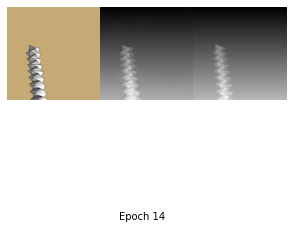

Epoch [15/50], Step [1/3750], D_loss: 0.0421, G_loss: 8.2678
Epoch [15/50], Step [2/3750], D_loss: 0.1148, G_loss: 10.2528
Epoch [15/50], Step [3/3750], D_loss: 0.1322, G_loss: 7.2082
Epoch [15/50], Step [4/3750], D_loss: 0.0373, G_loss: 8.0419
Epoch [15/50], Step [5/3750], D_loss: 0.5060, G_loss: 4.1005
Epoch [15/50], Step [6/3750], D_loss: 0.3520, G_loss: 6.4806
Epoch [15/50], Step [7/3750], D_loss: 0.1772, G_loss: 12.8046
Epoch [15/50], Step [8/3750], D_loss: 0.2482, G_loss: 8.5709
Epoch [15/50], Step [9/3750], D_loss: 0.0758, G_loss: 8.2165
Epoch [15/50], Step [10/3750], D_loss: 0.1269, G_loss: 5.9927
Epoch [15/50], Step [11/3750], D_loss: 0.1307, G_loss: 11.6568
Epoch [15/50], Step [12/3750], D_loss: 0.0204, G_loss: 6.9417
Epoch [15/50], Step [13/3750], D_loss: 0.0452, G_loss: 6.1473
Epoch [15/50], Step [14/3750], D_loss: 0.1315, G_loss: 10.7220
Epoch [15/50], Step [15/3750], D_loss: 0.0459, G_loss: 12.6991
Epoch [15/50], Step [16/3750], D_loss: 0.0165, G_loss: 13.2824
Epoch [15/5

Epoch [15/50], Step [133/3750], D_loss: 0.0146, G_loss: 6.7982
Epoch [15/50], Step [134/3750], D_loss: 0.0979, G_loss: 9.2805
Epoch [15/50], Step [135/3750], D_loss: 0.0660, G_loss: 11.6193
Epoch [15/50], Step [136/3750], D_loss: 0.1533, G_loss: 4.6955
Epoch [15/50], Step [137/3750], D_loss: 0.1518, G_loss: 7.1435
Epoch [15/50], Step [138/3750], D_loss: 0.0043, G_loss: 14.1113
Epoch [15/50], Step [139/3750], D_loss: 0.2015, G_loss: 4.8865
Epoch [15/50], Step [140/3750], D_loss: 0.0104, G_loss: 11.4707
Epoch [15/50], Step [141/3750], D_loss: 0.0165, G_loss: 5.6982
Epoch [15/50], Step [142/3750], D_loss: 0.0240, G_loss: 11.5735
Epoch [15/50], Step [143/3750], D_loss: 0.0366, G_loss: 8.4234
Epoch [15/50], Step [144/3750], D_loss: 0.0155, G_loss: 8.7546
Epoch [15/50], Step [145/3750], D_loss: 0.0218, G_loss: 10.5764
Epoch [15/50], Step [146/3750], D_loss: 0.0157, G_loss: 10.2027
Epoch [15/50], Step [147/3750], D_loss: 0.1245, G_loss: 7.4605
Epoch [15/50], Step [148/3750], D_loss: 0.0066, G

Epoch [15/50], Step [263/3750], D_loss: 0.2445, G_loss: 10.5911
Epoch [15/50], Step [264/3750], D_loss: 0.2497, G_loss: 8.2940
Epoch [15/50], Step [265/3750], D_loss: 0.7882, G_loss: 4.5757
Epoch [15/50], Step [266/3750], D_loss: 0.1350, G_loss: 6.7668
Epoch [15/50], Step [267/3750], D_loss: 0.2365, G_loss: 7.0207
Epoch [15/50], Step [268/3750], D_loss: 0.3308, G_loss: 7.0909
Epoch [15/50], Step [269/3750], D_loss: 0.0123, G_loss: 11.8439
Epoch [15/50], Step [270/3750], D_loss: 0.0291, G_loss: 10.7228
Epoch [15/50], Step [271/3750], D_loss: 0.0228, G_loss: 8.2138
Epoch [15/50], Step [272/3750], D_loss: 0.2046, G_loss: 7.0565
Epoch [15/50], Step [273/3750], D_loss: 0.0162, G_loss: 8.2268
Epoch [15/50], Step [274/3750], D_loss: 0.6481, G_loss: 5.6430
Epoch [15/50], Step [275/3750], D_loss: 0.0412, G_loss: 11.5924
Epoch [15/50], Step [276/3750], D_loss: 0.2944, G_loss: 5.6431
Epoch [15/50], Step [277/3750], D_loss: 0.0261, G_loss: 9.6617
Epoch [15/50], Step [278/3750], D_loss: 0.1336, G_l

Epoch [15/50], Step [393/3750], D_loss: 0.6848, G_loss: 5.1423
Epoch [15/50], Step [394/3750], D_loss: 0.3773, G_loss: 5.1101
Epoch [15/50], Step [395/3750], D_loss: 0.0387, G_loss: 10.6686
Epoch [15/50], Step [396/3750], D_loss: 0.4285, G_loss: 14.1620
Epoch [15/50], Step [397/3750], D_loss: 0.2685, G_loss: 11.3560
Epoch [15/50], Step [398/3750], D_loss: 0.0529, G_loss: 10.8007
Epoch [15/50], Step [399/3750], D_loss: 0.0244, G_loss: 13.7574
Epoch [15/50], Step [400/3750], D_loss: 0.1574, G_loss: 8.5130
Epoch [15/50], Step [401/3750], D_loss: 0.0129, G_loss: 7.1578
Epoch [15/50], Step [402/3750], D_loss: 0.3179, G_loss: 6.1761
Epoch [15/50], Step [403/3750], D_loss: 0.0205, G_loss: 7.7958
Epoch [15/50], Step [404/3750], D_loss: 0.3956, G_loss: 6.9917
Epoch [15/50], Step [405/3750], D_loss: 0.2081, G_loss: 11.5538
Epoch [15/50], Step [406/3750], D_loss: 0.1689, G_loss: 6.4154
Epoch [15/50], Step [407/3750], D_loss: 0.2409, G_loss: 6.8898
Epoch [15/50], Step [408/3750], D_loss: 0.0086, G

Epoch [15/50], Step [523/3750], D_loss: 0.1681, G_loss: 6.0067
Epoch [15/50], Step [524/3750], D_loss: 0.2267, G_loss: 7.1897
Epoch [15/50], Step [525/3750], D_loss: 0.0144, G_loss: 7.5097
Epoch [15/50], Step [526/3750], D_loss: 0.2151, G_loss: 7.3167
Epoch [15/50], Step [527/3750], D_loss: 0.0070, G_loss: 7.2407
Epoch [15/50], Step [528/3750], D_loss: 0.3039, G_loss: 4.0489
Epoch [15/50], Step [529/3750], D_loss: 0.1400, G_loss: 6.4610
Epoch [15/50], Step [530/3750], D_loss: 0.1564, G_loss: 6.2978
Epoch [15/50], Step [531/3750], D_loss: 0.0141, G_loss: 6.9756
Epoch [15/50], Step [532/3750], D_loss: 0.1498, G_loss: 5.8584
Epoch [15/50], Step [533/3750], D_loss: 0.0132, G_loss: 10.0018
Epoch [15/50], Step [534/3750], D_loss: 0.0171, G_loss: 8.4830
Epoch [15/50], Step [535/3750], D_loss: 0.0273, G_loss: 9.2267
Epoch [15/50], Step [536/3750], D_loss: 0.1210, G_loss: 6.0330
Epoch [15/50], Step [537/3750], D_loss: 0.6499, G_loss: 5.3538
Epoch [15/50], Step [538/3750], D_loss: 0.1375, G_loss

Epoch [15/50], Step [653/3750], D_loss: 0.0086, G_loss: 13.9042
Epoch [15/50], Step [654/3750], D_loss: 0.0167, G_loss: 9.1864
Epoch [15/50], Step [655/3750], D_loss: 0.3246, G_loss: 9.6360
Epoch [15/50], Step [656/3750], D_loss: 0.3830, G_loss: 12.5002
Epoch [15/50], Step [657/3750], D_loss: 0.0738, G_loss: 5.7028
Epoch [15/50], Step [658/3750], D_loss: 0.2036, G_loss: 7.6764
Epoch [15/50], Step [659/3750], D_loss: 0.0976, G_loss: 7.2511
Epoch [15/50], Step [660/3750], D_loss: 0.2791, G_loss: 4.0747
Epoch [15/50], Step [661/3750], D_loss: 0.0873, G_loss: 12.5902
Epoch [15/50], Step [662/3750], D_loss: 0.0495, G_loss: 12.5211
Epoch [15/50], Step [663/3750], D_loss: 0.0870, G_loss: 8.8848
Epoch [15/50], Step [664/3750], D_loss: 0.2346, G_loss: 3.9954
Epoch [15/50], Step [665/3750], D_loss: 0.0163, G_loss: 6.5012
Epoch [15/50], Step [666/3750], D_loss: 0.1463, G_loss: 8.5090
Epoch [15/50], Step [667/3750], D_loss: 0.1300, G_loss: 23.0933
Epoch [15/50], Step [668/3750], D_loss: 0.0572, G_

Epoch [15/50], Step [783/3750], D_loss: 0.2648, G_loss: 4.8862
Epoch [15/50], Step [784/3750], D_loss: 0.5569, G_loss: 8.0129
Epoch [15/50], Step [785/3750], D_loss: 0.0479, G_loss: 9.8559
Epoch [15/50], Step [786/3750], D_loss: 0.0124, G_loss: 7.5229
Epoch [15/50], Step [787/3750], D_loss: 0.1451, G_loss: 6.9282
Epoch [15/50], Step [788/3750], D_loss: 0.4587, G_loss: 4.5935
Epoch [15/50], Step [789/3750], D_loss: 0.3541, G_loss: 7.5863
Epoch [15/50], Step [790/3750], D_loss: 0.0876, G_loss: 13.0205
Epoch [15/50], Step [791/3750], D_loss: 0.0352, G_loss: 6.2666
Epoch [15/50], Step [792/3750], D_loss: 0.0325, G_loss: 5.9679
Epoch [15/50], Step [793/3750], D_loss: 0.4216, G_loss: 5.3326
Epoch [15/50], Step [794/3750], D_loss: 0.2020, G_loss: 10.9396
Epoch [15/50], Step [795/3750], D_loss: 0.4022, G_loss: 5.0987
Epoch [15/50], Step [796/3750], D_loss: 0.2723, G_loss: 8.8917
Epoch [15/50], Step [797/3750], D_loss: 0.0693, G_loss: 7.2590
Epoch [15/50], Step [798/3750], D_loss: 0.5868, G_los

Epoch [15/50], Step [913/3750], D_loss: 0.0410, G_loss: 5.8583
Epoch [15/50], Step [914/3750], D_loss: 0.1272, G_loss: 5.8109
Epoch [15/50], Step [915/3750], D_loss: 0.0716, G_loss: 10.4645
Epoch [15/50], Step [916/3750], D_loss: 0.3861, G_loss: 6.1151
Epoch [15/50], Step [917/3750], D_loss: 0.1021, G_loss: 7.8645
Epoch [15/50], Step [918/3750], D_loss: 0.1171, G_loss: 8.7673
Epoch [15/50], Step [919/3750], D_loss: 0.2110, G_loss: 6.6643
Epoch [15/50], Step [920/3750], D_loss: 0.0427, G_loss: 12.2377
Epoch [15/50], Step [921/3750], D_loss: 0.1041, G_loss: 6.8139
Epoch [15/50], Step [922/3750], D_loss: 0.0265, G_loss: 8.4005
Epoch [15/50], Step [923/3750], D_loss: 0.2552, G_loss: 6.9283
Epoch [15/50], Step [924/3750], D_loss: 0.3879, G_loss: 7.0125
Epoch [15/50], Step [925/3750], D_loss: 0.0703, G_loss: 7.3543
Epoch [15/50], Step [926/3750], D_loss: 0.1799, G_loss: 5.7800
Epoch [15/50], Step [927/3750], D_loss: 0.0753, G_loss: 6.5122
Epoch [15/50], Step [928/3750], D_loss: 0.5879, G_los

Epoch [15/50], Step [1042/3750], D_loss: 0.0543, G_loss: 6.4220
Epoch [15/50], Step [1043/3750], D_loss: 0.0705, G_loss: 6.6299
Epoch [15/50], Step [1044/3750], D_loss: 0.0285, G_loss: 5.8973
Epoch [15/50], Step [1045/3750], D_loss: 0.1273, G_loss: 16.3089
Epoch [15/50], Step [1046/3750], D_loss: 0.1734, G_loss: 11.5115
Epoch [15/50], Step [1047/3750], D_loss: 0.1183, G_loss: 5.5186
Epoch [15/50], Step [1048/3750], D_loss: 0.0421, G_loss: 11.0291
Epoch [15/50], Step [1049/3750], D_loss: 0.0526, G_loss: 7.3106
Epoch [15/50], Step [1050/3750], D_loss: 0.0279, G_loss: 6.6893
Epoch [15/50], Step [1051/3750], D_loss: 0.0491, G_loss: 12.1234
Epoch [15/50], Step [1052/3750], D_loss: 0.3751, G_loss: 7.0516
Epoch [15/50], Step [1053/3750], D_loss: 0.0406, G_loss: 5.0341
Epoch [15/50], Step [1054/3750], D_loss: 0.0304, G_loss: 8.8051
Epoch [15/50], Step [1055/3750], D_loss: 0.0288, G_loss: 9.3401
Epoch [15/50], Step [1056/3750], D_loss: 0.2224, G_loss: 7.8833
Epoch [15/50], Step [1057/3750], D_l

Epoch [15/50], Step [1170/3750], D_loss: 0.0320, G_loss: 8.8095
Epoch [15/50], Step [1171/3750], D_loss: 0.0423, G_loss: 7.3729
Epoch [15/50], Step [1172/3750], D_loss: 0.1628, G_loss: 11.6802
Epoch [15/50], Step [1173/3750], D_loss: 0.0313, G_loss: 13.7523
Epoch [15/50], Step [1174/3750], D_loss: 0.6659, G_loss: 5.0330
Epoch [15/50], Step [1175/3750], D_loss: 0.6016, G_loss: 6.4890
Epoch [15/50], Step [1176/3750], D_loss: 0.0386, G_loss: 10.0960
Epoch [15/50], Step [1177/3750], D_loss: 0.0562, G_loss: 12.9392
Epoch [15/50], Step [1178/3750], D_loss: 0.0370, G_loss: 11.7037
Epoch [15/50], Step [1179/3750], D_loss: 0.2809, G_loss: 4.6702
Epoch [15/50], Step [1180/3750], D_loss: 0.0619, G_loss: 5.9729
Epoch [15/50], Step [1181/3750], D_loss: 0.0460, G_loss: 5.3416
Epoch [15/50], Step [1182/3750], D_loss: 0.0347, G_loss: 12.0810
Epoch [15/50], Step [1183/3750], D_loss: 0.0314, G_loss: 5.0692
Epoch [15/50], Step [1184/3750], D_loss: 0.2433, G_loss: 6.2103
Epoch [15/50], Step [1185/3750], D

Epoch [15/50], Step [1298/3750], D_loss: 0.1283, G_loss: 10.3406
Epoch [15/50], Step [1299/3750], D_loss: 0.2199, G_loss: 7.0213
Epoch [15/50], Step [1300/3750], D_loss: 0.0980, G_loss: 7.5360
Epoch [15/50], Step [1301/3750], D_loss: 0.0119, G_loss: 6.4388
Epoch [15/50], Step [1302/3750], D_loss: 0.0183, G_loss: 17.2706
Epoch [15/50], Step [1303/3750], D_loss: 0.1702, G_loss: 9.8806
Epoch [15/50], Step [1304/3750], D_loss: 0.0127, G_loss: 10.3695
Epoch [15/50], Step [1305/3750], D_loss: 0.0167, G_loss: 12.2524
Epoch [15/50], Step [1306/3750], D_loss: 0.0754, G_loss: 11.0863
Epoch [15/50], Step [1307/3750], D_loss: 0.0317, G_loss: 10.7318
Epoch [15/50], Step [1308/3750], D_loss: 0.3657, G_loss: 4.8420
Epoch [15/50], Step [1309/3750], D_loss: 0.1994, G_loss: 9.7154
Epoch [15/50], Step [1310/3750], D_loss: 0.2333, G_loss: 6.0849
Epoch [15/50], Step [1311/3750], D_loss: 0.0415, G_loss: 9.8264
Epoch [15/50], Step [1312/3750], D_loss: 0.3727, G_loss: 4.9214
Epoch [15/50], Step [1313/3750], D

Epoch [15/50], Step [1426/3750], D_loss: 0.2607, G_loss: 6.9472
Epoch [15/50], Step [1427/3750], D_loss: 0.0310, G_loss: 10.6213
Epoch [15/50], Step [1428/3750], D_loss: 0.0777, G_loss: 4.9578
Epoch [15/50], Step [1429/3750], D_loss: 0.0356, G_loss: 6.1839
Epoch [15/50], Step [1430/3750], D_loss: 0.1145, G_loss: 8.3421
Epoch [15/50], Step [1431/3750], D_loss: 0.1039, G_loss: 15.0285
Epoch [15/50], Step [1432/3750], D_loss: 0.0769, G_loss: 7.6659
Epoch [15/50], Step [1433/3750], D_loss: 0.0636, G_loss: 6.3755
Epoch [15/50], Step [1434/3750], D_loss: 0.0923, G_loss: 11.5378
Epoch [15/50], Step [1435/3750], D_loss: 0.0278, G_loss: 13.7401
Epoch [15/50], Step [1436/3750], D_loss: 0.0455, G_loss: 5.7252
Epoch [15/50], Step [1437/3750], D_loss: 0.1359, G_loss: 5.5034
Epoch [15/50], Step [1438/3750], D_loss: 0.0204, G_loss: 10.1066
Epoch [15/50], Step [1439/3750], D_loss: 0.0094, G_loss: 16.9964
Epoch [15/50], Step [1440/3750], D_loss: 0.0805, G_loss: 8.0652
Epoch [15/50], Step [1441/3750], D

Epoch [15/50], Step [1554/3750], D_loss: 0.3065, G_loss: 9.6566
Epoch [15/50], Step [1555/3750], D_loss: 0.1623, G_loss: 7.6722
Epoch [15/50], Step [1556/3750], D_loss: 0.0697, G_loss: 8.1782
Epoch [15/50], Step [1557/3750], D_loss: 0.1905, G_loss: 8.8483
Epoch [15/50], Step [1558/3750], D_loss: 0.0094, G_loss: 17.6878
Epoch [15/50], Step [1559/3750], D_loss: 0.2143, G_loss: 4.4053
Epoch [15/50], Step [1560/3750], D_loss: 0.1557, G_loss: 9.0665
Epoch [15/50], Step [1561/3750], D_loss: 0.0205, G_loss: 6.3508
Epoch [15/50], Step [1562/3750], D_loss: 0.1667, G_loss: 6.1433
Epoch [15/50], Step [1563/3750], D_loss: 0.1427, G_loss: 7.9951
Epoch [15/50], Step [1564/3750], D_loss: 0.3776, G_loss: 5.2911
Epoch [15/50], Step [1565/3750], D_loss: 0.0149, G_loss: 15.3203
Epoch [15/50], Step [1566/3750], D_loss: 0.0272, G_loss: 8.1670
Epoch [15/50], Step [1567/3750], D_loss: 0.0813, G_loss: 7.6582
Epoch [15/50], Step [1568/3750], D_loss: 0.3071, G_loss: 4.6163
Epoch [15/50], Step [1569/3750], D_los

Epoch [15/50], Step [1682/3750], D_loss: 0.0261, G_loss: 5.7006
Epoch [15/50], Step [1683/3750], D_loss: 0.0169, G_loss: 10.7253
Epoch [15/50], Step [1684/3750], D_loss: 0.0239, G_loss: 8.3731
Epoch [15/50], Step [1685/3750], D_loss: 0.2242, G_loss: 6.0864
Epoch [15/50], Step [1686/3750], D_loss: 0.1820, G_loss: 4.3359
Epoch [15/50], Step [1687/3750], D_loss: 0.0550, G_loss: 6.4190
Epoch [15/50], Step [1688/3750], D_loss: 0.0690, G_loss: 4.9695
Epoch [15/50], Step [1689/3750], D_loss: 0.0926, G_loss: 4.4960
Epoch [15/50], Step [1690/3750], D_loss: 0.1215, G_loss: 8.1568
Epoch [15/50], Step [1691/3750], D_loss: 0.0101, G_loss: 8.5695
Epoch [15/50], Step [1692/3750], D_loss: 0.0181, G_loss: 7.3476
Epoch [15/50], Step [1693/3750], D_loss: 0.1459, G_loss: 8.4533
Epoch [15/50], Step [1694/3750], D_loss: 0.1132, G_loss: 4.9401
Epoch [15/50], Step [1695/3750], D_loss: 0.2382, G_loss: 7.9788
Epoch [15/50], Step [1696/3750], D_loss: 0.0637, G_loss: 8.8702
Epoch [15/50], Step [1697/3750], D_loss

Epoch [15/50], Step [1810/3750], D_loss: 0.0173, G_loss: 11.5049
Epoch [15/50], Step [1811/3750], D_loss: 0.2368, G_loss: 5.7956
Epoch [15/50], Step [1812/3750], D_loss: 0.0404, G_loss: 10.0434
Epoch [15/50], Step [1813/3750], D_loss: 0.0147, G_loss: 8.6732
Epoch [15/50], Step [1814/3750], D_loss: 0.0117, G_loss: 9.6273
Epoch [15/50], Step [1815/3750], D_loss: 0.0101, G_loss: 14.1874
Epoch [15/50], Step [1816/3750], D_loss: 0.0255, G_loss: 16.9925
Epoch [15/50], Step [1817/3750], D_loss: 0.0217, G_loss: 13.8971
Epoch [15/50], Step [1818/3750], D_loss: 0.0053, G_loss: 9.9016
Epoch [15/50], Step [1819/3750], D_loss: 0.3691, G_loss: 4.5340
Epoch [15/50], Step [1820/3750], D_loss: 0.0380, G_loss: 8.8733
Epoch [15/50], Step [1821/3750], D_loss: 0.0177, G_loss: 8.3708
Epoch [15/50], Step [1822/3750], D_loss: 0.1204, G_loss: 8.8244
Epoch [15/50], Step [1823/3750], D_loss: 0.0637, G_loss: 8.9815
Epoch [15/50], Step [1824/3750], D_loss: 0.3934, G_loss: 6.0572
Epoch [15/50], Step [1825/3750], D_

Epoch [15/50], Step [1938/3750], D_loss: 0.3526, G_loss: 4.9733
Epoch [15/50], Step [1939/3750], D_loss: 0.0470, G_loss: 6.2222
Epoch [15/50], Step [1940/3750], D_loss: 0.3957, G_loss: 5.7240
Epoch [15/50], Step [1941/3750], D_loss: 0.7206, G_loss: 8.1397
Epoch [15/50], Step [1942/3750], D_loss: 0.2885, G_loss: 12.7614
Epoch [15/50], Step [1943/3750], D_loss: 0.2102, G_loss: 9.4443
Epoch [15/50], Step [1944/3750], D_loss: 0.3906, G_loss: 6.1691
Epoch [15/50], Step [1945/3750], D_loss: 0.0982, G_loss: 7.8974
Epoch [15/50], Step [1946/3750], D_loss: 0.0837, G_loss: 14.8527
Epoch [15/50], Step [1947/3750], D_loss: 0.0361, G_loss: 9.3369
Epoch [15/50], Step [1948/3750], D_loss: 0.0639, G_loss: 5.9284
Epoch [15/50], Step [1949/3750], D_loss: 0.0381, G_loss: 13.1412
Epoch [15/50], Step [1950/3750], D_loss: 0.0083, G_loss: 9.3580
Epoch [15/50], Step [1951/3750], D_loss: 0.3113, G_loss: 5.7563
Epoch [15/50], Step [1952/3750], D_loss: 0.0184, G_loss: 12.1388
Epoch [15/50], Step [1953/3750], D_l

Epoch [15/50], Step [2066/3750], D_loss: 0.0262, G_loss: 6.0744
Epoch [15/50], Step [2067/3750], D_loss: 0.0178, G_loss: 11.5692
Epoch [15/50], Step [2068/3750], D_loss: 0.0475, G_loss: 9.2837
Epoch [15/50], Step [2069/3750], D_loss: 0.0687, G_loss: 9.8969
Epoch [15/50], Step [2070/3750], D_loss: 0.0309, G_loss: 6.4595
Epoch [15/50], Step [2071/3750], D_loss: 0.2781, G_loss: 6.3840
Epoch [15/50], Step [2072/3750], D_loss: 0.3323, G_loss: 4.4304
Epoch [15/50], Step [2073/3750], D_loss: 0.1282, G_loss: 5.1968
Epoch [15/50], Step [2074/3750], D_loss: 0.1502, G_loss: 5.2384
Epoch [15/50], Step [2075/3750], D_loss: 0.3668, G_loss: 6.7054
Epoch [15/50], Step [2076/3750], D_loss: 0.0131, G_loss: 12.0066
Epoch [15/50], Step [2077/3750], D_loss: 0.0333, G_loss: 12.1546
Epoch [15/50], Step [2078/3750], D_loss: 0.6475, G_loss: 5.6448
Epoch [15/50], Step [2079/3750], D_loss: 0.0858, G_loss: 4.7985
Epoch [15/50], Step [2080/3750], D_loss: 0.0924, G_loss: 8.4285
Epoch [15/50], Step [2081/3750], D_lo

Epoch [15/50], Step [2194/3750], D_loss: 0.2255, G_loss: 4.0566
Epoch [15/50], Step [2195/3750], D_loss: 0.0826, G_loss: 5.0686
Epoch [15/50], Step [2196/3750], D_loss: 0.2319, G_loss: 5.1094
Epoch [15/50], Step [2197/3750], D_loss: 0.2621, G_loss: 12.1969
Epoch [15/50], Step [2198/3750], D_loss: 0.4114, G_loss: 6.9861
Epoch [15/50], Step [2199/3750], D_loss: 0.1262, G_loss: 7.4965
Epoch [15/50], Step [2200/3750], D_loss: 0.0145, G_loss: 7.3819
Epoch [15/50], Step [2201/3750], D_loss: 1.0115, G_loss: 4.2296
Epoch [15/50], Step [2202/3750], D_loss: 0.1154, G_loss: 7.9983
Epoch [15/50], Step [2203/3750], D_loss: 0.1015, G_loss: 8.5783
Epoch [15/50], Step [2204/3750], D_loss: 0.1586, G_loss: 8.5889
Epoch [15/50], Step [2205/3750], D_loss: 0.2896, G_loss: 6.4086
Epoch [15/50], Step [2206/3750], D_loss: 0.0587, G_loss: 7.0287
Epoch [15/50], Step [2207/3750], D_loss: 0.1040, G_loss: 5.0658
Epoch [15/50], Step [2208/3750], D_loss: 0.0332, G_loss: 5.4783
Epoch [15/50], Step [2209/3750], D_loss

Epoch [15/50], Step [2322/3750], D_loss: 0.1992, G_loss: 8.9233
Epoch [15/50], Step [2323/3750], D_loss: 0.0757, G_loss: 9.3133
Epoch [15/50], Step [2324/3750], D_loss: 0.1317, G_loss: 11.0346
Epoch [15/50], Step [2325/3750], D_loss: 0.4257, G_loss: 12.6205
Epoch [15/50], Step [2326/3750], D_loss: 0.5534, G_loss: 6.6386
Epoch [15/50], Step [2327/3750], D_loss: 0.1582, G_loss: 10.6300
Epoch [15/50], Step [2328/3750], D_loss: 0.0340, G_loss: 7.6223
Epoch [15/50], Step [2329/3750], D_loss: 0.3045, G_loss: 8.1258
Epoch [15/50], Step [2330/3750], D_loss: 0.1226, G_loss: 14.5013
Epoch [15/50], Step [2331/3750], D_loss: 0.0765, G_loss: 4.5668
Epoch [15/50], Step [2332/3750], D_loss: 0.9073, G_loss: 7.7599
Epoch [15/50], Step [2333/3750], D_loss: 0.3762, G_loss: 3.4890
Epoch [15/50], Step [2334/3750], D_loss: 0.1540, G_loss: 9.4393
Epoch [15/50], Step [2335/3750], D_loss: 0.1307, G_loss: 12.5933
Epoch [15/50], Step [2336/3750], D_loss: 0.0600, G_loss: 8.2301
Epoch [15/50], Step [2337/3750], D_

Epoch [15/50], Step [2450/3750], D_loss: 0.1338, G_loss: 6.1651
Epoch [15/50], Step [2451/3750], D_loss: 0.1607, G_loss: 4.9134
Epoch [15/50], Step [2452/3750], D_loss: 0.6820, G_loss: 8.5675
Epoch [15/50], Step [2453/3750], D_loss: 0.4097, G_loss: 10.4144
Epoch [15/50], Step [2454/3750], D_loss: 0.2936, G_loss: 5.1899
Epoch [15/50], Step [2455/3750], D_loss: 0.4710, G_loss: 9.6031
Epoch [15/50], Step [2456/3750], D_loss: 0.0313, G_loss: 9.5821
Epoch [15/50], Step [2457/3750], D_loss: 0.2677, G_loss: 5.3602
Epoch [15/50], Step [2458/3750], D_loss: 0.3740, G_loss: 5.9940
Epoch [15/50], Step [2459/3750], D_loss: 0.1784, G_loss: 16.1264
Epoch [15/50], Step [2460/3750], D_loss: 0.0592, G_loss: 9.0542
Epoch [15/50], Step [2461/3750], D_loss: 0.0642, G_loss: 6.3889
Epoch [15/50], Step [2462/3750], D_loss: 0.3225, G_loss: 6.9837
Epoch [15/50], Step [2463/3750], D_loss: 0.9027, G_loss: 8.1494
Epoch [15/50], Step [2464/3750], D_loss: 0.6966, G_loss: 7.7098
Epoch [15/50], Step [2465/3750], D_los

Epoch [15/50], Step [2578/3750], D_loss: 0.0210, G_loss: 7.6469
Epoch [15/50], Step [2579/3750], D_loss: 0.0242, G_loss: 12.0899
Epoch [15/50], Step [2580/3750], D_loss: 0.0200, G_loss: 10.8476
Epoch [15/50], Step [2581/3750], D_loss: 0.5395, G_loss: 8.0647
Epoch [15/50], Step [2582/3750], D_loss: 0.0784, G_loss: 10.4354
Epoch [15/50], Step [2583/3750], D_loss: 0.2694, G_loss: 9.4186
Epoch [15/50], Step [2584/3750], D_loss: 0.0410, G_loss: 13.9853
Epoch [15/50], Step [2585/3750], D_loss: 0.1368, G_loss: 10.2762
Epoch [15/50], Step [2586/3750], D_loss: 0.0797, G_loss: 6.9203
Epoch [15/50], Step [2587/3750], D_loss: 0.1165, G_loss: 6.1022
Epoch [15/50], Step [2588/3750], D_loss: 0.0305, G_loss: 7.2505
Epoch [15/50], Step [2589/3750], D_loss: 0.2687, G_loss: 8.3027
Epoch [15/50], Step [2590/3750], D_loss: 0.0364, G_loss: 5.7600
Epoch [15/50], Step [2591/3750], D_loss: 0.2331, G_loss: 12.1243
Epoch [15/50], Step [2592/3750], D_loss: 0.1199, G_loss: 13.1508
Epoch [15/50], Step [2593/3750], 

Epoch [15/50], Step [2706/3750], D_loss: 0.0059, G_loss: 10.1521
Epoch [15/50], Step [2707/3750], D_loss: 0.0643, G_loss: 5.3934
Epoch [15/50], Step [2708/3750], D_loss: 0.0084, G_loss: 13.2923
Epoch [15/50], Step [2709/3750], D_loss: 0.1730, G_loss: 8.5264
Epoch [15/50], Step [2710/3750], D_loss: 0.2707, G_loss: 7.7039
Epoch [15/50], Step [2711/3750], D_loss: 0.0824, G_loss: 8.5661
Epoch [15/50], Step [2712/3750], D_loss: 0.0472, G_loss: 7.9917
Epoch [15/50], Step [2713/3750], D_loss: 0.1908, G_loss: 8.8568
Epoch [15/50], Step [2714/3750], D_loss: 0.0883, G_loss: 8.5579
Epoch [15/50], Step [2715/3750], D_loss: 0.0233, G_loss: 18.5091
Epoch [15/50], Step [2716/3750], D_loss: 0.0042, G_loss: 11.1353
Epoch [15/50], Step [2717/3750], D_loss: 0.2207, G_loss: 8.2605
Epoch [15/50], Step [2718/3750], D_loss: 0.2009, G_loss: 5.9711
Epoch [15/50], Step [2719/3750], D_loss: 0.1244, G_loss: 5.0883
Epoch [15/50], Step [2720/3750], D_loss: 0.3125, G_loss: 4.3350
Epoch [15/50], Step [2721/3750], D_l

Epoch [15/50], Step [2834/3750], D_loss: 0.0189, G_loss: 10.4118
Epoch [15/50], Step [2835/3750], D_loss: 0.2477, G_loss: 7.7996
Epoch [15/50], Step [2836/3750], D_loss: 0.0400, G_loss: 8.9307
Epoch [15/50], Step [2837/3750], D_loss: 0.0471, G_loss: 10.8824
Epoch [15/50], Step [2838/3750], D_loss: 0.0171, G_loss: 10.1723
Epoch [15/50], Step [2839/3750], D_loss: 0.1764, G_loss: 4.4914
Epoch [15/50], Step [2840/3750], D_loss: 0.0729, G_loss: 14.2519
Epoch [15/50], Step [2841/3750], D_loss: 0.0861, G_loss: 10.2836
Epoch [15/50], Step [2842/3750], D_loss: 0.0210, G_loss: 6.5025
Epoch [15/50], Step [2843/3750], D_loss: 0.0673, G_loss: 10.8487
Epoch [15/50], Step [2844/3750], D_loss: 0.1177, G_loss: 6.7385
Epoch [15/50], Step [2845/3750], D_loss: 0.3524, G_loss: 9.3967
Epoch [15/50], Step [2846/3750], D_loss: 0.4179, G_loss: 6.0898
Epoch [15/50], Step [2847/3750], D_loss: 0.4652, G_loss: 4.1781
Epoch [15/50], Step [2848/3750], D_loss: 0.0708, G_loss: 8.2316
Epoch [15/50], Step [2849/3750], D

Epoch [15/50], Step [2962/3750], D_loss: 0.0846, G_loss: 10.6082
Epoch [15/50], Step [2963/3750], D_loss: 0.5244, G_loss: 10.3107
Epoch [15/50], Step [2964/3750], D_loss: 0.0210, G_loss: 8.8048
Epoch [15/50], Step [2965/3750], D_loss: 0.0261, G_loss: 10.6369
Epoch [15/50], Step [2966/3750], D_loss: 0.0097, G_loss: 8.1513
Epoch [15/50], Step [2967/3750], D_loss: 0.2955, G_loss: 5.2659
Epoch [15/50], Step [2968/3750], D_loss: 0.1880, G_loss: 5.1499
Epoch [15/50], Step [2969/3750], D_loss: 0.1717, G_loss: 5.5457
Epoch [15/50], Step [2970/3750], D_loss: 0.4266, G_loss: 25.1646
Epoch [15/50], Step [2971/3750], D_loss: 0.0501, G_loss: 6.8421
Epoch [15/50], Step [2972/3750], D_loss: 0.0432, G_loss: 7.2457
Epoch [15/50], Step [2973/3750], D_loss: 0.2356, G_loss: 3.7561
Epoch [15/50], Step [2974/3750], D_loss: 0.0047, G_loss: 9.5860
Epoch [15/50], Step [2975/3750], D_loss: 0.0086, G_loss: 9.6961
Epoch [15/50], Step [2976/3750], D_loss: 0.3552, G_loss: 7.8688
Epoch [15/50], Step [2977/3750], D_l

Epoch [15/50], Step [3090/3750], D_loss: 0.0675, G_loss: 5.1200
Epoch [15/50], Step [3091/3750], D_loss: 0.0104, G_loss: 16.3247
Epoch [15/50], Step [3092/3750], D_loss: 0.1764, G_loss: 5.6722
Epoch [15/50], Step [3093/3750], D_loss: 0.0169, G_loss: 7.8603
Epoch [15/50], Step [3094/3750], D_loss: 0.1351, G_loss: 8.0480
Epoch [15/50], Step [3095/3750], D_loss: 0.0248, G_loss: 9.8249
Epoch [15/50], Step [3096/3750], D_loss: 0.1386, G_loss: 11.5248
Epoch [15/50], Step [3097/3750], D_loss: 0.0303, G_loss: 6.8827
Epoch [15/50], Step [3098/3750], D_loss: 0.0717, G_loss: 8.4083
Epoch [15/50], Step [3099/3750], D_loss: 0.2914, G_loss: 5.1685
Epoch [15/50], Step [3100/3750], D_loss: 0.0109, G_loss: 7.8816
Epoch [15/50], Step [3101/3750], D_loss: 0.0218, G_loss: 7.2890
Epoch [15/50], Step [3102/3750], D_loss: 0.1069, G_loss: 6.2392
Epoch [15/50], Step [3103/3750], D_loss: 0.0743, G_loss: 6.8225
Epoch [15/50], Step [3104/3750], D_loss: 0.3196, G_loss: 14.0332
Epoch [15/50], Step [3105/3750], D_lo

Epoch [15/50], Step [3218/3750], D_loss: 0.1146, G_loss: 7.5641
Epoch [15/50], Step [3219/3750], D_loss: 0.1142, G_loss: 10.4920
Epoch [15/50], Step [3220/3750], D_loss: 0.4274, G_loss: 5.4845
Epoch [15/50], Step [3221/3750], D_loss: 0.0945, G_loss: 5.3395
Epoch [15/50], Step [3222/3750], D_loss: 0.0701, G_loss: 6.9322
Epoch [15/50], Step [3223/3750], D_loss: 0.2094, G_loss: 7.8372
Epoch [15/50], Step [3224/3750], D_loss: 0.0249, G_loss: 12.3889
Epoch [15/50], Step [3225/3750], D_loss: 0.0561, G_loss: 7.5251
Epoch [15/50], Step [3226/3750], D_loss: 0.0522, G_loss: 5.0991
Epoch [15/50], Step [3227/3750], D_loss: 0.1094, G_loss: 10.5729
Epoch [15/50], Step [3228/3750], D_loss: 0.0610, G_loss: 9.2900
Epoch [15/50], Step [3229/3750], D_loss: 0.0306, G_loss: 11.2520
Epoch [15/50], Step [3230/3750], D_loss: 0.0731, G_loss: 14.6836
Epoch [15/50], Step [3231/3750], D_loss: 0.2535, G_loss: 5.8771
Epoch [15/50], Step [3232/3750], D_loss: 0.1386, G_loss: 12.6526
Epoch [15/50], Step [3233/3750], D

Epoch [15/50], Step [3346/3750], D_loss: 0.0735, G_loss: 11.2929
Epoch [15/50], Step [3347/3750], D_loss: 0.3277, G_loss: 5.5883
Epoch [15/50], Step [3348/3750], D_loss: 0.1301, G_loss: 10.7783
Epoch [15/50], Step [3349/3750], D_loss: 0.0200, G_loss: 10.9008
Epoch [15/50], Step [3350/3750], D_loss: 0.5121, G_loss: 4.8747
Epoch [15/50], Step [3351/3750], D_loss: 0.2046, G_loss: 13.3995
Epoch [15/50], Step [3352/3750], D_loss: 0.0263, G_loss: 6.2162
Epoch [15/50], Step [3353/3750], D_loss: 0.2056, G_loss: 6.1743
Epoch [15/50], Step [3354/3750], D_loss: 0.0483, G_loss: 8.0280
Epoch [15/50], Step [3355/3750], D_loss: 0.5706, G_loss: 5.4787
Epoch [15/50], Step [3356/3750], D_loss: 0.2645, G_loss: 8.0486
Epoch [15/50], Step [3357/3750], D_loss: 0.2377, G_loss: 8.8788
Epoch [15/50], Step [3358/3750], D_loss: 0.3734, G_loss: 6.6564
Epoch [15/50], Step [3359/3750], D_loss: 0.0126, G_loss: 7.4080
Epoch [15/50], Step [3360/3750], D_loss: 0.0572, G_loss: 8.4274
Epoch [15/50], Step [3361/3750], D_l

Epoch [15/50], Step [3474/3750], D_loss: 0.0599, G_loss: 7.7410
Epoch [15/50], Step [3475/3750], D_loss: 0.1884, G_loss: 5.7665
Epoch [15/50], Step [3476/3750], D_loss: 0.2872, G_loss: 5.8157
Epoch [15/50], Step [3477/3750], D_loss: 0.0477, G_loss: 10.0007
Epoch [15/50], Step [3478/3750], D_loss: 0.2321, G_loss: 5.7108
Epoch [15/50], Step [3479/3750], D_loss: 0.1995, G_loss: 6.1109
Epoch [15/50], Step [3480/3750], D_loss: 0.0355, G_loss: 7.9778
Epoch [15/50], Step [3481/3750], D_loss: 0.3418, G_loss: 5.4082
Epoch [15/50], Step [3482/3750], D_loss: 0.1323, G_loss: 4.8599
Epoch [15/50], Step [3483/3750], D_loss: 0.3499, G_loss: 4.6064
Epoch [15/50], Step [3484/3750], D_loss: 0.2496, G_loss: 8.3191
Epoch [15/50], Step [3485/3750], D_loss: 0.0809, G_loss: 8.8948
Epoch [15/50], Step [3486/3750], D_loss: 0.2011, G_loss: 6.2086
Epoch [15/50], Step [3487/3750], D_loss: 0.0477, G_loss: 7.9020
Epoch [15/50], Step [3488/3750], D_loss: 0.0401, G_loss: 8.0454
Epoch [15/50], Step [3489/3750], D_loss

Epoch [15/50], Step [3602/3750], D_loss: 0.0057, G_loss: 11.4777
Epoch [15/50], Step [3603/3750], D_loss: 0.0438, G_loss: 5.9120
Epoch [15/50], Step [3604/3750], D_loss: 0.0760, G_loss: 7.6303
Epoch [15/50], Step [3605/3750], D_loss: 0.0047, G_loss: 13.1230
Epoch [15/50], Step [3606/3750], D_loss: 0.0096, G_loss: 9.8254
Epoch [15/50], Step [3607/3750], D_loss: 0.2558, G_loss: 7.9602
Epoch [15/50], Step [3608/3750], D_loss: 0.0091, G_loss: 12.9387
Epoch [15/50], Step [3609/3750], D_loss: 0.0299, G_loss: 5.4436
Epoch [15/50], Step [3610/3750], D_loss: 0.1942, G_loss: 11.5526
Epoch [15/50], Step [3611/3750], D_loss: 0.1341, G_loss: 15.3348
Epoch [15/50], Step [3612/3750], D_loss: 0.1459, G_loss: 5.7668
Epoch [15/50], Step [3613/3750], D_loss: 0.0265, G_loss: 7.8110
Epoch [15/50], Step [3614/3750], D_loss: 0.1154, G_loss: 6.4046
Epoch [15/50], Step [3615/3750], D_loss: 0.1305, G_loss: 8.5365
Epoch [15/50], Step [3616/3750], D_loss: 0.5227, G_loss: 5.1148
Epoch [15/50], Step [3617/3750], D_

Epoch [15/50], Step [3730/3750], D_loss: 0.2827, G_loss: 5.8435
Epoch [15/50], Step [3731/3750], D_loss: 0.1255, G_loss: 5.2913
Epoch [15/50], Step [3732/3750], D_loss: 0.0776, G_loss: 10.4014
Epoch [15/50], Step [3733/3750], D_loss: 0.7632, G_loss: 13.0183
Epoch [15/50], Step [3734/3750], D_loss: 0.2251, G_loss: 7.8909
Epoch [15/50], Step [3735/3750], D_loss: 0.1910, G_loss: 7.5693
Epoch [15/50], Step [3736/3750], D_loss: 0.1851, G_loss: 4.1919
Epoch [15/50], Step [3737/3750], D_loss: 0.3141, G_loss: 5.3710
Epoch [15/50], Step [3738/3750], D_loss: 0.0575, G_loss: 13.7382
Epoch [15/50], Step [3739/3750], D_loss: 0.2012, G_loss: 7.7024
Epoch [15/50], Step [3740/3750], D_loss: 0.0151, G_loss: 9.7664
Epoch [15/50], Step [3741/3750], D_loss: 0.0307, G_loss: 14.3668
Epoch [15/50], Step [3742/3750], D_loss: 0.3708, G_loss: 6.9054
Epoch [15/50], Step [3743/3750], D_loss: 0.1631, G_loss: 7.4684
Epoch [15/50], Step [3744/3750], D_loss: 0.0353, G_loss: 6.2296
Epoch [15/50], Step [3745/3750], D_l

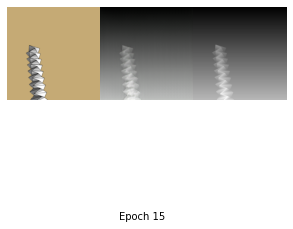

Epoch [16/50], Step [1/3750], D_loss: 0.1833, G_loss: 8.7270
Epoch [16/50], Step [2/3750], D_loss: 0.1267, G_loss: 9.3932
Epoch [16/50], Step [3/3750], D_loss: 0.3584, G_loss: 12.9517
Epoch [16/50], Step [4/3750], D_loss: 0.8590, G_loss: 10.1660
Epoch [16/50], Step [5/3750], D_loss: 0.6376, G_loss: 8.0316
Epoch [16/50], Step [6/3750], D_loss: 0.1195, G_loss: 12.0745
Epoch [16/50], Step [7/3750], D_loss: 0.0835, G_loss: 13.5679
Epoch [16/50], Step [8/3750], D_loss: 0.2614, G_loss: 6.9273
Epoch [16/50], Step [9/3750], D_loss: 0.2709, G_loss: 6.3363
Epoch [16/50], Step [10/3750], D_loss: 0.7655, G_loss: 4.1178
Epoch [16/50], Step [11/3750], D_loss: 0.2279, G_loss: 4.9829
Epoch [16/50], Step [12/3750], D_loss: 0.0381, G_loss: 11.6476
Epoch [16/50], Step [13/3750], D_loss: 0.0416, G_loss: 7.0034
Epoch [16/50], Step [14/3750], D_loss: 0.3600, G_loss: 7.4428
Epoch [16/50], Step [15/3750], D_loss: 0.3970, G_loss: 9.2456
Epoch [16/50], Step [16/3750], D_loss: 0.2080, G_loss: 7.5526
Epoch [16/50

Epoch [16/50], Step [133/3750], D_loss: 0.0881, G_loss: 7.1815
Epoch [16/50], Step [134/3750], D_loss: 0.1596, G_loss: 9.3198
Epoch [16/50], Step [135/3750], D_loss: 0.1089, G_loss: 11.6731
Epoch [16/50], Step [136/3750], D_loss: 0.0412, G_loss: 7.0277
Epoch [16/50], Step [137/3750], D_loss: 0.0623, G_loss: 7.1961
Epoch [16/50], Step [138/3750], D_loss: 0.0457, G_loss: 12.6287
Epoch [16/50], Step [139/3750], D_loss: 0.0903, G_loss: 6.8811
Epoch [16/50], Step [140/3750], D_loss: 0.7659, G_loss: 3.7526
Epoch [16/50], Step [141/3750], D_loss: 0.0542, G_loss: 8.5532
Epoch [16/50], Step [142/3750], D_loss: 0.2859, G_loss: 6.4207
Epoch [16/50], Step [143/3750], D_loss: 0.0522, G_loss: 7.9051
Epoch [16/50], Step [144/3750], D_loss: 0.4271, G_loss: 9.6910
Epoch [16/50], Step [145/3750], D_loss: 0.3304, G_loss: 4.2784
Epoch [16/50], Step [146/3750], D_loss: 0.0249, G_loss: 8.0597
Epoch [16/50], Step [147/3750], D_loss: 0.0196, G_loss: 6.1808
Epoch [16/50], Step [148/3750], D_loss: 0.2919, G_los

Epoch [16/50], Step [263/3750], D_loss: 0.1041, G_loss: 15.9118
Epoch [16/50], Step [264/3750], D_loss: 0.1398, G_loss: 5.1074
Epoch [16/50], Step [265/3750], D_loss: 0.0809, G_loss: 8.3066
Epoch [16/50], Step [266/3750], D_loss: 0.1128, G_loss: 9.2676
Epoch [16/50], Step [267/3750], D_loss: 0.0756, G_loss: 12.6501
Epoch [16/50], Step [268/3750], D_loss: 0.1064, G_loss: 8.6064
Epoch [16/50], Step [269/3750], D_loss: 0.3408, G_loss: 5.2744
Epoch [16/50], Step [270/3750], D_loss: 0.0886, G_loss: 4.7519
Epoch [16/50], Step [271/3750], D_loss: 0.3460, G_loss: 6.6138
Epoch [16/50], Step [272/3750], D_loss: 0.2885, G_loss: 5.3088
Epoch [16/50], Step [273/3750], D_loss: 0.2451, G_loss: 8.9010
Epoch [16/50], Step [274/3750], D_loss: 0.0487, G_loss: 8.8367
Epoch [16/50], Step [275/3750], D_loss: 0.0682, G_loss: 7.0164
Epoch [16/50], Step [276/3750], D_loss: 0.1185, G_loss: 6.9945
Epoch [16/50], Step [277/3750], D_loss: 0.0521, G_loss: 12.2776
Epoch [16/50], Step [278/3750], D_loss: 0.1108, G_lo

Epoch [16/50], Step [393/3750], D_loss: 0.0241, G_loss: 7.4105
Epoch [16/50], Step [394/3750], D_loss: 0.3254, G_loss: 14.4514
Epoch [16/50], Step [395/3750], D_loss: 0.1851, G_loss: 5.3947
Epoch [16/50], Step [396/3750], D_loss: 0.1066, G_loss: 13.0277
Epoch [16/50], Step [397/3750], D_loss: 0.0015, G_loss: 14.6887
Epoch [16/50], Step [398/3750], D_loss: 0.1954, G_loss: 6.9149
Epoch [16/50], Step [399/3750], D_loss: 0.1834, G_loss: 7.1196
Epoch [16/50], Step [400/3750], D_loss: 0.1084, G_loss: 8.1310
Epoch [16/50], Step [401/3750], D_loss: 0.0270, G_loss: 9.3837
Epoch [16/50], Step [402/3750], D_loss: 0.7556, G_loss: 9.2815
Epoch [16/50], Step [403/3750], D_loss: 0.0232, G_loss: 10.2961
Epoch [16/50], Step [404/3750], D_loss: 0.0513, G_loss: 7.7365
Epoch [16/50], Step [405/3750], D_loss: 0.0345, G_loss: 5.9312
Epoch [16/50], Step [406/3750], D_loss: 0.3104, G_loss: 7.5255
Epoch [16/50], Step [407/3750], D_loss: 0.3471, G_loss: 3.8898
Epoch [16/50], Step [408/3750], D_loss: 0.1038, G_l

Epoch [16/50], Step [523/3750], D_loss: 0.8087, G_loss: 5.6463
Epoch [16/50], Step [524/3750], D_loss: 1.2641, G_loss: 6.4477
Epoch [16/50], Step [525/3750], D_loss: 2.0504, G_loss: 3.5034
Epoch [16/50], Step [526/3750], D_loss: 0.7265, G_loss: 4.8149
Epoch [16/50], Step [527/3750], D_loss: 0.5235, G_loss: 4.2690
Epoch [16/50], Step [528/3750], D_loss: 0.7292, G_loss: 6.7560
Epoch [16/50], Step [529/3750], D_loss: 0.6862, G_loss: 14.3326
Epoch [16/50], Step [530/3750], D_loss: 0.7813, G_loss: 2.8696
Epoch [16/50], Step [531/3750], D_loss: 0.4305, G_loss: 7.7581
Epoch [16/50], Step [532/3750], D_loss: 0.4539, G_loss: 5.6572
Epoch [16/50], Step [533/3750], D_loss: 0.5028, G_loss: 4.2645
Epoch [16/50], Step [534/3750], D_loss: 0.1743, G_loss: 6.1806
Epoch [16/50], Step [535/3750], D_loss: 0.4130, G_loss: 6.6047
Epoch [16/50], Step [536/3750], D_loss: 0.3938, G_loss: 9.2295
Epoch [16/50], Step [537/3750], D_loss: 0.6519, G_loss: 3.5582
Epoch [16/50], Step [538/3750], D_loss: 0.0895, G_loss

Epoch [16/50], Step [653/3750], D_loss: 0.0323, G_loss: 14.6514
Epoch [16/50], Step [654/3750], D_loss: 0.0502, G_loss: 5.7024
Epoch [16/50], Step [655/3750], D_loss: 0.7833, G_loss: 7.1333
Epoch [16/50], Step [656/3750], D_loss: 0.1520, G_loss: 10.8386
Epoch [16/50], Step [657/3750], D_loss: 0.0771, G_loss: 4.7566
Epoch [16/50], Step [658/3750], D_loss: 0.0708, G_loss: 6.9176
Epoch [16/50], Step [659/3750], D_loss: 0.0861, G_loss: 12.7937
Epoch [16/50], Step [660/3750], D_loss: 0.1866, G_loss: 6.4856
Epoch [16/50], Step [661/3750], D_loss: 0.0211, G_loss: 6.7166
Epoch [16/50], Step [662/3750], D_loss: 0.0695, G_loss: 23.7585
Epoch [16/50], Step [663/3750], D_loss: 0.0440, G_loss: 6.3748
Epoch [16/50], Step [664/3750], D_loss: 0.2410, G_loss: 11.5817
Epoch [16/50], Step [665/3750], D_loss: 0.0652, G_loss: 11.6180
Epoch [16/50], Step [666/3750], D_loss: 0.1174, G_loss: 5.6301
Epoch [16/50], Step [667/3750], D_loss: 0.0256, G_loss: 8.6492
Epoch [16/50], Step [668/3750], D_loss: 0.0771, G

Epoch [16/50], Step [783/3750], D_loss: 0.5509, G_loss: 7.7825
Epoch [16/50], Step [784/3750], D_loss: 0.0799, G_loss: 5.3906
Epoch [16/50], Step [785/3750], D_loss: 0.0767, G_loss: 6.6863
Epoch [16/50], Step [786/3750], D_loss: 0.1785, G_loss: 4.3000
Epoch [16/50], Step [787/3750], D_loss: 0.4553, G_loss: 5.0726
Epoch [16/50], Step [788/3750], D_loss: 0.1051, G_loss: 6.5059
Epoch [16/50], Step [789/3750], D_loss: 0.0360, G_loss: 6.1633
Epoch [16/50], Step [790/3750], D_loss: 0.4685, G_loss: 8.7663
Epoch [16/50], Step [791/3750], D_loss: 0.0418, G_loss: 5.1086
Epoch [16/50], Step [792/3750], D_loss: 0.3380, G_loss: 21.7058
Epoch [16/50], Step [793/3750], D_loss: 0.1493, G_loss: 6.7295
Epoch [16/50], Step [794/3750], D_loss: 0.0122, G_loss: 7.2331
Epoch [16/50], Step [795/3750], D_loss: 0.0574, G_loss: 9.9527
Epoch [16/50], Step [796/3750], D_loss: 0.2081, G_loss: 5.5674
Epoch [16/50], Step [797/3750], D_loss: 0.1980, G_loss: 5.9035
Epoch [16/50], Step [798/3750], D_loss: 0.1522, G_loss

Epoch [16/50], Step [913/3750], D_loss: 0.1565, G_loss: 3.5879
Epoch [16/50], Step [914/3750], D_loss: 0.1620, G_loss: 6.4796
Epoch [16/50], Step [915/3750], D_loss: 0.2072, G_loss: 13.0416
Epoch [16/50], Step [916/3750], D_loss: 0.0381, G_loss: 7.3860
Epoch [16/50], Step [917/3750], D_loss: 0.1466, G_loss: 12.2149
Epoch [16/50], Step [918/3750], D_loss: 0.2764, G_loss: 5.2463
Epoch [16/50], Step [919/3750], D_loss: 0.0447, G_loss: 8.6512
Epoch [16/50], Step [920/3750], D_loss: 0.1104, G_loss: 6.7253
Epoch [16/50], Step [921/3750], D_loss: 0.0862, G_loss: 8.5029
Epoch [16/50], Step [922/3750], D_loss: 0.0491, G_loss: 9.4193
Epoch [16/50], Step [923/3750], D_loss: 0.2162, G_loss: 5.2751
Epoch [16/50], Step [924/3750], D_loss: 0.1368, G_loss: 9.3585
Epoch [16/50], Step [925/3750], D_loss: 0.0340, G_loss: 13.8837
Epoch [16/50], Step [926/3750], D_loss: 0.0738, G_loss: 5.3420
Epoch [16/50], Step [927/3750], D_loss: 0.0235, G_loss: 15.8631
Epoch [16/50], Step [928/3750], D_loss: 0.0608, G_l

Epoch [16/50], Step [1042/3750], D_loss: 0.0834, G_loss: 9.8166
Epoch [16/50], Step [1043/3750], D_loss: 0.4555, G_loss: 11.4175
Epoch [16/50], Step [1044/3750], D_loss: 0.2359, G_loss: 5.7230
Epoch [16/50], Step [1045/3750], D_loss: 0.1440, G_loss: 13.8094
Epoch [16/50], Step [1046/3750], D_loss: 0.5279, G_loss: 4.7302
Epoch [16/50], Step [1047/3750], D_loss: 0.0397, G_loss: 12.3664
Epoch [16/50], Step [1048/3750], D_loss: 0.0349, G_loss: 16.8619
Epoch [16/50], Step [1049/3750], D_loss: 0.0181, G_loss: 15.2998
Epoch [16/50], Step [1050/3750], D_loss: 0.0764, G_loss: 6.5514
Epoch [16/50], Step [1051/3750], D_loss: 0.0683, G_loss: 13.0160
Epoch [16/50], Step [1052/3750], D_loss: 0.1733, G_loss: 8.0960
Epoch [16/50], Step [1053/3750], D_loss: 0.0408, G_loss: 7.5904
Epoch [16/50], Step [1054/3750], D_loss: 0.0280, G_loss: 8.2605
Epoch [16/50], Step [1055/3750], D_loss: 0.0214, G_loss: 14.0710
Epoch [16/50], Step [1056/3750], D_loss: 0.0596, G_loss: 7.0376
Epoch [16/50], Step [1057/3750], 

Epoch [16/50], Step [1170/3750], D_loss: 0.0461, G_loss: 15.5814
Epoch [16/50], Step [1171/3750], D_loss: 0.4029, G_loss: 7.0882
Epoch [16/50], Step [1172/3750], D_loss: 0.0361, G_loss: 5.2631
Epoch [16/50], Step [1173/3750], D_loss: 0.2601, G_loss: 7.0505
Epoch [16/50], Step [1174/3750], D_loss: 0.2661, G_loss: 5.4552
Epoch [16/50], Step [1175/3750], D_loss: 0.0608, G_loss: 12.1026
Epoch [16/50], Step [1176/3750], D_loss: 0.0202, G_loss: 10.1500
Epoch [16/50], Step [1177/3750], D_loss: 0.0117, G_loss: 7.3944
Epoch [16/50], Step [1178/3750], D_loss: 0.0232, G_loss: 8.8034
Epoch [16/50], Step [1179/3750], D_loss: 0.3515, G_loss: 5.7801
Epoch [16/50], Step [1180/3750], D_loss: 0.0087, G_loss: 7.9379
Epoch [16/50], Step [1181/3750], D_loss: 0.0202, G_loss: 10.2826
Epoch [16/50], Step [1182/3750], D_loss: 0.0680, G_loss: 5.4865
Epoch [16/50], Step [1183/3750], D_loss: 0.2839, G_loss: 5.4261
Epoch [16/50], Step [1184/3750], D_loss: 0.3618, G_loss: 10.1395
Epoch [16/50], Step [1185/3750], D_

Epoch [16/50], Step [1298/3750], D_loss: 0.3036, G_loss: 8.3128
Epoch [16/50], Step [1299/3750], D_loss: 0.0759, G_loss: 9.2546
Epoch [16/50], Step [1300/3750], D_loss: 0.0859, G_loss: 7.3060
Epoch [16/50], Step [1301/3750], D_loss: 0.0853, G_loss: 13.1506
Epoch [16/50], Step [1302/3750], D_loss: 0.0254, G_loss: 6.9585
Epoch [16/50], Step [1303/3750], D_loss: 0.0233, G_loss: 6.5971
Epoch [16/50], Step [1304/3750], D_loss: 0.1861, G_loss: 7.9437
Epoch [16/50], Step [1305/3750], D_loss: 0.0206, G_loss: 8.8920
Epoch [16/50], Step [1306/3750], D_loss: 0.1920, G_loss: 5.6670
Epoch [16/50], Step [1307/3750], D_loss: 0.1438, G_loss: 8.7262
Epoch [16/50], Step [1308/3750], D_loss: 0.1313, G_loss: 7.6212
Epoch [16/50], Step [1309/3750], D_loss: 0.0053, G_loss: 8.5157
Epoch [16/50], Step [1310/3750], D_loss: 0.0148, G_loss: 9.6127
Epoch [16/50], Step [1311/3750], D_loss: 0.1755, G_loss: 12.8302
Epoch [16/50], Step [1312/3750], D_loss: 0.0161, G_loss: 7.7201
Epoch [16/50], Step [1313/3750], D_los

Epoch [16/50], Step [1426/3750], D_loss: 0.3028, G_loss: 11.2447
Epoch [16/50], Step [1427/3750], D_loss: 0.1005, G_loss: 7.0191
Epoch [16/50], Step [1428/3750], D_loss: 0.4105, G_loss: 5.2529
Epoch [16/50], Step [1429/3750], D_loss: 0.1485, G_loss: 8.3251
Epoch [16/50], Step [1430/3750], D_loss: 0.1093, G_loss: 15.2592
Epoch [16/50], Step [1431/3750], D_loss: 0.1214, G_loss: 6.9732
Epoch [16/50], Step [1432/3750], D_loss: 0.2241, G_loss: 14.9678
Epoch [16/50], Step [1433/3750], D_loss: 0.1063, G_loss: 7.5259
Epoch [16/50], Step [1434/3750], D_loss: 0.3707, G_loss: 5.3828
Epoch [16/50], Step [1435/3750], D_loss: 0.2429, G_loss: 4.5083
Epoch [16/50], Step [1436/3750], D_loss: 0.1353, G_loss: 6.5508
Epoch [16/50], Step [1437/3750], D_loss: 0.2479, G_loss: 4.4324
Epoch [16/50], Step [1438/3750], D_loss: 0.4051, G_loss: 5.0671
Epoch [16/50], Step [1439/3750], D_loss: 0.2503, G_loss: 9.7206
Epoch [16/50], Step [1440/3750], D_loss: 0.0505, G_loss: 7.3471
Epoch [16/50], Step [1441/3750], D_lo

Epoch [16/50], Step [1554/3750], D_loss: 0.0901, G_loss: 12.2230
Epoch [16/50], Step [1555/3750], D_loss: 0.0368, G_loss: 10.4384
Epoch [16/50], Step [1556/3750], D_loss: 0.0399, G_loss: 8.0383
Epoch [16/50], Step [1557/3750], D_loss: 0.1232, G_loss: 8.8092
Epoch [16/50], Step [1558/3750], D_loss: 0.0841, G_loss: 10.8697
Epoch [16/50], Step [1559/3750], D_loss: 0.0286, G_loss: 8.0000
Epoch [16/50], Step [1560/3750], D_loss: 0.0736, G_loss: 7.1671
Epoch [16/50], Step [1561/3750], D_loss: 0.0249, G_loss: 10.1281
Epoch [16/50], Step [1562/3750], D_loss: 0.1730, G_loss: 5.4289
Epoch [16/50], Step [1563/3750], D_loss: 0.0702, G_loss: 9.4921
Epoch [16/50], Step [1564/3750], D_loss: 0.0909, G_loss: 8.3375
Epoch [16/50], Step [1565/3750], D_loss: 0.0198, G_loss: 16.5494
Epoch [16/50], Step [1566/3750], D_loss: 0.0983, G_loss: 9.5966
Epoch [16/50], Step [1567/3750], D_loss: 0.0784, G_loss: 7.6441
Epoch [16/50], Step [1568/3750], D_loss: 0.1386, G_loss: 6.7724
Epoch [16/50], Step [1569/3750], D_

Epoch [16/50], Step [1682/3750], D_loss: 0.0181, G_loss: 13.4567
Epoch [16/50], Step [1683/3750], D_loss: 0.0177, G_loss: 5.8659
Epoch [16/50], Step [1684/3750], D_loss: 0.1219, G_loss: 7.6464
Epoch [16/50], Step [1685/3750], D_loss: 0.0547, G_loss: 7.8286
Epoch [16/50], Step [1686/3750], D_loss: 0.0971, G_loss: 6.9745
Epoch [16/50], Step [1687/3750], D_loss: 0.0325, G_loss: 5.5801
Epoch [16/50], Step [1688/3750], D_loss: 0.1045, G_loss: 10.2896
Epoch [16/50], Step [1689/3750], D_loss: 0.0275, G_loss: 12.9360
Epoch [16/50], Step [1690/3750], D_loss: 0.1393, G_loss: 5.5262
Epoch [16/50], Step [1691/3750], D_loss: 0.4169, G_loss: 9.6257
Epoch [16/50], Step [1692/3750], D_loss: 0.0911, G_loss: 11.2968
Epoch [16/50], Step [1693/3750], D_loss: 0.2833, G_loss: 6.7776
Epoch [16/50], Step [1694/3750], D_loss: 0.0249, G_loss: 10.5670
Epoch [16/50], Step [1695/3750], D_loss: 0.3231, G_loss: 7.5045
Epoch [16/50], Step [1696/3750], D_loss: 0.0247, G_loss: 8.0497
Epoch [16/50], Step [1697/3750], D_

Epoch [16/50], Step [1810/3750], D_loss: 0.0202, G_loss: 8.6970
Epoch [16/50], Step [1811/3750], D_loss: 0.1553, G_loss: 12.0104
Epoch [16/50], Step [1812/3750], D_loss: 0.0526, G_loss: 8.3881
Epoch [16/50], Step [1813/3750], D_loss: 0.0686, G_loss: 6.4108
Epoch [16/50], Step [1814/3750], D_loss: 0.1377, G_loss: 6.0949
Epoch [16/50], Step [1815/3750], D_loss: 0.3495, G_loss: 4.6542
Epoch [16/50], Step [1816/3750], D_loss: 0.1248, G_loss: 8.4699
Epoch [16/50], Step [1817/3750], D_loss: 0.0444, G_loss: 16.7467
Epoch [16/50], Step [1818/3750], D_loss: 0.0258, G_loss: 8.4753
Epoch [16/50], Step [1819/3750], D_loss: 0.1163, G_loss: 6.6908
Epoch [16/50], Step [1820/3750], D_loss: 0.0086, G_loss: 12.2004
Epoch [16/50], Step [1821/3750], D_loss: 0.0952, G_loss: 10.4775
Epoch [16/50], Step [1822/3750], D_loss: 0.0116, G_loss: 7.6736
Epoch [16/50], Step [1823/3750], D_loss: 0.5147, G_loss: 3.5455
Epoch [16/50], Step [1824/3750], D_loss: 0.0530, G_loss: 7.3439
Epoch [16/50], Step [1825/3750], D_l

Epoch [16/50], Step [1938/3750], D_loss: 0.0111, G_loss: 8.6733
Epoch [16/50], Step [1939/3750], D_loss: 0.0928, G_loss: 7.2297
Epoch [16/50], Step [1940/3750], D_loss: 0.0500, G_loss: 9.6589
Epoch [16/50], Step [1941/3750], D_loss: 0.0480, G_loss: 7.6232
Epoch [16/50], Step [1942/3750], D_loss: 0.3665, G_loss: 5.6408
Epoch [16/50], Step [1943/3750], D_loss: 0.1704, G_loss: 6.8274
Epoch [16/50], Step [1944/3750], D_loss: 0.0107, G_loss: 12.1454
Epoch [16/50], Step [1945/3750], D_loss: 0.0553, G_loss: 6.3250
Epoch [16/50], Step [1946/3750], D_loss: 0.0308, G_loss: 7.1787
Epoch [16/50], Step [1947/3750], D_loss: 0.0075, G_loss: 15.3396
Epoch [16/50], Step [1948/3750], D_loss: 0.3725, G_loss: 7.8848
Epoch [16/50], Step [1949/3750], D_loss: 0.2225, G_loss: 6.4603
Epoch [16/50], Step [1950/3750], D_loss: 0.2729, G_loss: 4.8777
Epoch [16/50], Step [1951/3750], D_loss: 0.0381, G_loss: 6.4427
Epoch [16/50], Step [1952/3750], D_loss: 0.1672, G_loss: 7.7909
Epoch [16/50], Step [1953/3750], D_los

Epoch [16/50], Step [2066/3750], D_loss: 0.0431, G_loss: 11.1684
Epoch [16/50], Step [2067/3750], D_loss: 0.0092, G_loss: 9.0688
Epoch [16/50], Step [2068/3750], D_loss: 0.0805, G_loss: 14.5254
Epoch [16/50], Step [2069/3750], D_loss: 0.0188, G_loss: 11.7823
Epoch [16/50], Step [2070/3750], D_loss: 0.1714, G_loss: 8.3208
Epoch [16/50], Step [2071/3750], D_loss: 0.3264, G_loss: 12.1374
Epoch [16/50], Step [2072/3750], D_loss: 0.0177, G_loss: 7.1132
Epoch [16/50], Step [2073/3750], D_loss: 0.0545, G_loss: 19.2922
Epoch [16/50], Step [2074/3750], D_loss: 0.0700, G_loss: 24.6242
Epoch [16/50], Step [2075/3750], D_loss: 0.0914, G_loss: 10.2405
Epoch [16/50], Step [2076/3750], D_loss: 0.0308, G_loss: 6.2158
Epoch [16/50], Step [2077/3750], D_loss: 0.0232, G_loss: 9.4594
Epoch [16/50], Step [2078/3750], D_loss: 0.2650, G_loss: 7.8828
Epoch [16/50], Step [2079/3750], D_loss: 0.3471, G_loss: 4.6919
Epoch [16/50], Step [2080/3750], D_loss: 0.0721, G_loss: 7.5716
Epoch [16/50], Step [2081/3750], 

Epoch [16/50], Step [2194/3750], D_loss: 0.0371, G_loss: 8.9206
Epoch [16/50], Step [2195/3750], D_loss: 0.1706, G_loss: 7.0923
Epoch [16/50], Step [2196/3750], D_loss: 0.0630, G_loss: 6.7826
Epoch [16/50], Step [2197/3750], D_loss: 0.1577, G_loss: 10.0510
Epoch [16/50], Step [2198/3750], D_loss: 0.0241, G_loss: 9.0041
Epoch [16/50], Step [2199/3750], D_loss: 0.2279, G_loss: 9.3524
Epoch [16/50], Step [2200/3750], D_loss: 0.0690, G_loss: 7.2626
Epoch [16/50], Step [2201/3750], D_loss: 0.2355, G_loss: 10.7873
Epoch [16/50], Step [2202/3750], D_loss: 0.1058, G_loss: 5.4335
Epoch [16/50], Step [2203/3750], D_loss: 0.1201, G_loss: 20.2741
Epoch [16/50], Step [2204/3750], D_loss: 0.0427, G_loss: 11.8011
Epoch [16/50], Step [2205/3750], D_loss: 0.2318, G_loss: 5.1973
Epoch [16/50], Step [2206/3750], D_loss: 0.2050, G_loss: 7.7156
Epoch [16/50], Step [2207/3750], D_loss: 0.0771, G_loss: 6.6209
Epoch [16/50], Step [2208/3750], D_loss: 0.1522, G_loss: 7.3101
Epoch [16/50], Step [2209/3750], D_l

Epoch [16/50], Step [2322/3750], D_loss: 0.2578, G_loss: 3.8548
Epoch [16/50], Step [2323/3750], D_loss: 0.0472, G_loss: 9.4892
Epoch [16/50], Step [2324/3750], D_loss: 0.0312, G_loss: 5.9578
Epoch [16/50], Step [2325/3750], D_loss: 0.0803, G_loss: 6.5313
Epoch [16/50], Step [2326/3750], D_loss: 0.0353, G_loss: 11.3429
Epoch [16/50], Step [2327/3750], D_loss: 0.1741, G_loss: 6.6392
Epoch [16/50], Step [2328/3750], D_loss: 0.3136, G_loss: 5.0203
Epoch [16/50], Step [2329/3750], D_loss: 0.0174, G_loss: 12.0291
Epoch [16/50], Step [2330/3750], D_loss: 0.1918, G_loss: 6.0598
Epoch [16/50], Step [2331/3750], D_loss: 0.3372, G_loss: 5.2589
Epoch [16/50], Step [2332/3750], D_loss: 0.0999, G_loss: 7.7307
Epoch [16/50], Step [2333/3750], D_loss: 0.3282, G_loss: 8.4213
Epoch [16/50], Step [2334/3750], D_loss: 0.0864, G_loss: 9.0823
Epoch [16/50], Step [2335/3750], D_loss: 0.0860, G_loss: 6.9719
Epoch [16/50], Step [2336/3750], D_loss: 0.0256, G_loss: 6.3248
Epoch [16/50], Step [2337/3750], D_los

Epoch [16/50], Step [2450/3750], D_loss: 0.0366, G_loss: 6.9289
Epoch [16/50], Step [2451/3750], D_loss: 0.1538, G_loss: 7.8008
Epoch [16/50], Step [2452/3750], D_loss: 0.0435, G_loss: 13.4135
Epoch [16/50], Step [2453/3750], D_loss: 0.7168, G_loss: 4.9243
Epoch [16/50], Step [2454/3750], D_loss: 0.0654, G_loss: 13.5973
Epoch [16/50], Step [2455/3750], D_loss: 0.0218, G_loss: 6.2520
Epoch [16/50], Step [2456/3750], D_loss: 0.0544, G_loss: 12.9887
Epoch [16/50], Step [2457/3750], D_loss: 0.1621, G_loss: 8.5141
Epoch [16/50], Step [2458/3750], D_loss: 0.0375, G_loss: 11.2174
Epoch [16/50], Step [2459/3750], D_loss: 0.0752, G_loss: 8.0141
Epoch [16/50], Step [2460/3750], D_loss: 0.2900, G_loss: 12.0452
Epoch [16/50], Step [2461/3750], D_loss: 0.6724, G_loss: 8.1645
Epoch [16/50], Step [2462/3750], D_loss: 0.0107, G_loss: 12.9171
Epoch [16/50], Step [2463/3750], D_loss: 0.2901, G_loss: 13.3763
Epoch [16/50], Step [2464/3750], D_loss: 0.1105, G_loss: 5.9812
Epoch [16/50], Step [2465/3750], 

Epoch [16/50], Step [2578/3750], D_loss: 0.0813, G_loss: 7.7880
Epoch [16/50], Step [2579/3750], D_loss: 0.1600, G_loss: 8.5780
Epoch [16/50], Step [2580/3750], D_loss: 0.1220, G_loss: 9.8515
Epoch [16/50], Step [2581/3750], D_loss: 0.0699, G_loss: 6.1315
Epoch [16/50], Step [2582/3750], D_loss: 0.0697, G_loss: 8.0270
Epoch [16/50], Step [2583/3750], D_loss: 0.0588, G_loss: 9.7473
Epoch [16/50], Step [2584/3750], D_loss: 0.0667, G_loss: 7.4990
Epoch [16/50], Step [2585/3750], D_loss: 0.4970, G_loss: 5.9338
Epoch [16/50], Step [2586/3750], D_loss: 0.0579, G_loss: 7.9845
Epoch [16/50], Step [2587/3750], D_loss: 0.4498, G_loss: 10.5469
Epoch [16/50], Step [2588/3750], D_loss: 0.2498, G_loss: 13.3226
Epoch [16/50], Step [2589/3750], D_loss: 0.0677, G_loss: 9.6707
Epoch [16/50], Step [2590/3750], D_loss: 0.2126, G_loss: 5.4779
Epoch [16/50], Step [2591/3750], D_loss: 0.4378, G_loss: 5.1588
Epoch [16/50], Step [2592/3750], D_loss: 0.1948, G_loss: 7.2862
Epoch [16/50], Step [2593/3750], D_los

Epoch [16/50], Step [2706/3750], D_loss: 0.3746, G_loss: 4.7612
Epoch [16/50], Step [2707/3750], D_loss: 0.1283, G_loss: 5.8024
Epoch [16/50], Step [2708/3750], D_loss: 0.0622, G_loss: 7.8005
Epoch [16/50], Step [2709/3750], D_loss: 0.0295, G_loss: 5.8773
Epoch [16/50], Step [2710/3750], D_loss: 0.1255, G_loss: 5.6813
Epoch [16/50], Step [2711/3750], D_loss: 0.0330, G_loss: 5.9629
Epoch [16/50], Step [2712/3750], D_loss: 0.2371, G_loss: 10.3027
Epoch [16/50], Step [2713/3750], D_loss: 0.3996, G_loss: 10.8436
Epoch [16/50], Step [2714/3750], D_loss: 0.3959, G_loss: 4.6281
Epoch [16/50], Step [2715/3750], D_loss: 0.0200, G_loss: 8.0027
Epoch [16/50], Step [2716/3750], D_loss: 0.1067, G_loss: 12.2569
Epoch [16/50], Step [2717/3750], D_loss: 0.3954, G_loss: 7.0885
Epoch [16/50], Step [2718/3750], D_loss: 0.3172, G_loss: 7.0089
Epoch [16/50], Step [2719/3750], D_loss: 0.0675, G_loss: 7.3239
Epoch [16/50], Step [2720/3750], D_loss: 0.3175, G_loss: 9.5192
Epoch [16/50], Step [2721/3750], D_lo

Epoch [16/50], Step [2834/3750], D_loss: 0.5045, G_loss: 8.5506
Epoch [16/50], Step [2835/3750], D_loss: 0.5261, G_loss: 6.0395
Epoch [16/50], Step [2836/3750], D_loss: 0.2118, G_loss: 7.3478
Epoch [16/50], Step [2837/3750], D_loss: 0.7951, G_loss: 3.6324
Epoch [16/50], Step [2838/3750], D_loss: 0.5898, G_loss: 6.9578
Epoch [16/50], Step [2839/3750], D_loss: 0.1623, G_loss: 8.4174
Epoch [16/50], Step [2840/3750], D_loss: 0.0271, G_loss: 7.3152
Epoch [16/50], Step [2841/3750], D_loss: 0.2041, G_loss: 6.0420
Epoch [16/50], Step [2842/3750], D_loss: 0.0178, G_loss: 11.0460
Epoch [16/50], Step [2843/3750], D_loss: 0.5949, G_loss: 6.5742
Epoch [16/50], Step [2844/3750], D_loss: 0.0438, G_loss: 6.6846
Epoch [16/50], Step [2845/3750], D_loss: 0.5132, G_loss: 8.3539
Epoch [16/50], Step [2846/3750], D_loss: 0.2208, G_loss: 8.6443
Epoch [16/50], Step [2847/3750], D_loss: 0.1442, G_loss: 12.5682
Epoch [16/50], Step [2848/3750], D_loss: 0.0724, G_loss: 4.9653
Epoch [16/50], Step [2849/3750], D_los

Epoch [16/50], Step [2962/3750], D_loss: 0.1118, G_loss: 12.6377
Epoch [16/50], Step [2963/3750], D_loss: 0.0751, G_loss: 5.8562
Epoch [16/50], Step [2964/3750], D_loss: 0.3210, G_loss: 9.6822
Epoch [16/50], Step [2965/3750], D_loss: 0.2221, G_loss: 5.7944
Epoch [16/50], Step [2966/3750], D_loss: 0.0330, G_loss: 10.1216
Epoch [16/50], Step [2967/3750], D_loss: 0.4063, G_loss: 9.0328
Epoch [16/50], Step [2968/3750], D_loss: 0.4081, G_loss: 9.1869
Epoch [16/50], Step [2969/3750], D_loss: 0.1309, G_loss: 5.4581
Epoch [16/50], Step [2970/3750], D_loss: 0.0835, G_loss: 7.1925
Epoch [16/50], Step [2971/3750], D_loss: 0.1180, G_loss: 10.0020
Epoch [16/50], Step [2972/3750], D_loss: 0.0298, G_loss: 12.1990
Epoch [16/50], Step [2973/3750], D_loss: 0.0269, G_loss: 5.7111
Epoch [16/50], Step [2974/3750], D_loss: 0.2617, G_loss: 12.0555
Epoch [16/50], Step [2975/3750], D_loss: 0.1088, G_loss: 5.8667
Epoch [16/50], Step [2976/3750], D_loss: 0.2131, G_loss: 6.6332
Epoch [16/50], Step [2977/3750], D_

Epoch [16/50], Step [3090/3750], D_loss: 0.1577, G_loss: 6.6160
Epoch [16/50], Step [3091/3750], D_loss: 0.0475, G_loss: 4.7417
Epoch [16/50], Step [3092/3750], D_loss: 0.3644, G_loss: 11.8563
Epoch [16/50], Step [3093/3750], D_loss: 0.2580, G_loss: 5.4102
Epoch [16/50], Step [3094/3750], D_loss: 0.0441, G_loss: 6.7815
Epoch [16/50], Step [3095/3750], D_loss: 0.1929, G_loss: 12.5185
Epoch [16/50], Step [3096/3750], D_loss: 0.3801, G_loss: 3.5988
Epoch [16/50], Step [3097/3750], D_loss: 0.0239, G_loss: 9.4676
Epoch [16/50], Step [3098/3750], D_loss: 0.2972, G_loss: 12.4523
Epoch [16/50], Step [3099/3750], D_loss: 0.0231, G_loss: 6.6674
Epoch [16/50], Step [3100/3750], D_loss: 0.6515, G_loss: 6.4212
Epoch [16/50], Step [3101/3750], D_loss: 0.2993, G_loss: 11.2578
Epoch [16/50], Step [3102/3750], D_loss: 0.0490, G_loss: 8.7232
Epoch [16/50], Step [3103/3750], D_loss: 0.2406, G_loss: 3.4649
Epoch [16/50], Step [3104/3750], D_loss: 0.4923, G_loss: 5.2584
Epoch [16/50], Step [3105/3750], D_l

Epoch [16/50], Step [3218/3750], D_loss: 0.0975, G_loss: 6.1251
Epoch [16/50], Step [3219/3750], D_loss: 0.4362, G_loss: 7.3463
Epoch [16/50], Step [3220/3750], D_loss: 0.2815, G_loss: 7.5617
Epoch [16/50], Step [3221/3750], D_loss: 0.1986, G_loss: 6.7510
Epoch [16/50], Step [3222/3750], D_loss: 0.0101, G_loss: 13.5302
Epoch [16/50], Step [3223/3750], D_loss: 0.0744, G_loss: 8.0961
Epoch [16/50], Step [3224/3750], D_loss: 0.2780, G_loss: 4.5815
Epoch [16/50], Step [3225/3750], D_loss: 0.0330, G_loss: 9.3273
Epoch [16/50], Step [3226/3750], D_loss: 0.0261, G_loss: 8.5633
Epoch [16/50], Step [3227/3750], D_loss: 0.1310, G_loss: 4.4020
Epoch [16/50], Step [3228/3750], D_loss: 0.0052, G_loss: 11.0055
Epoch [16/50], Step [3229/3750], D_loss: 0.1503, G_loss: 11.8321
Epoch [16/50], Step [3230/3750], D_loss: 0.1746, G_loss: 7.1243
Epoch [16/50], Step [3231/3750], D_loss: 0.0904, G_loss: 11.1795
Epoch [16/50], Step [3232/3750], D_loss: 0.1535, G_loss: 8.7639
Epoch [16/50], Step [3233/3750], D_l

Epoch [16/50], Step [3346/3750], D_loss: 0.0323, G_loss: 6.7837
Epoch [16/50], Step [3347/3750], D_loss: 0.2406, G_loss: 6.2006
Epoch [16/50], Step [3348/3750], D_loss: 0.0236, G_loss: 11.1121
Epoch [16/50], Step [3349/3750], D_loss: 0.1721, G_loss: 8.3802
Epoch [16/50], Step [3350/3750], D_loss: 0.0458, G_loss: 5.7658
Epoch [16/50], Step [3351/3750], D_loss: 0.1193, G_loss: 6.8744
Epoch [16/50], Step [3352/3750], D_loss: 0.0108, G_loss: 10.0264
Epoch [16/50], Step [3353/3750], D_loss: 0.0268, G_loss: 11.7548
Epoch [16/50], Step [3354/3750], D_loss: 0.0399, G_loss: 10.1753
Epoch [16/50], Step [3355/3750], D_loss: 0.1650, G_loss: 8.2754
Epoch [16/50], Step [3356/3750], D_loss: 0.0638, G_loss: 7.1184
Epoch [16/50], Step [3357/3750], D_loss: 0.0123, G_loss: 12.4749
Epoch [16/50], Step [3358/3750], D_loss: 0.0510, G_loss: 5.7735
Epoch [16/50], Step [3359/3750], D_loss: 0.1116, G_loss: 8.2836
Epoch [16/50], Step [3360/3750], D_loss: 0.0779, G_loss: 6.0422
Epoch [16/50], Step [3361/3750], D_

Epoch [16/50], Step [3474/3750], D_loss: 0.0362, G_loss: 9.6227
Epoch [16/50], Step [3475/3750], D_loss: 0.0250, G_loss: 13.8697
Epoch [16/50], Step [3476/3750], D_loss: 0.0215, G_loss: 10.4125
Epoch [16/50], Step [3477/3750], D_loss: 0.1638, G_loss: 7.4948
Epoch [16/50], Step [3478/3750], D_loss: 0.0922, G_loss: 6.0978
Epoch [16/50], Step [3479/3750], D_loss: 0.0989, G_loss: 12.0726
Epoch [16/50], Step [3480/3750], D_loss: 0.0444, G_loss: 7.9280
Epoch [16/50], Step [3481/3750], D_loss: 0.3231, G_loss: 4.1733
Epoch [16/50], Step [3482/3750], D_loss: 0.1170, G_loss: 5.2478
Epoch [16/50], Step [3483/3750], D_loss: 0.1341, G_loss: 11.5386
Epoch [16/50], Step [3484/3750], D_loss: 0.0708, G_loss: 5.3413
Epoch [16/50], Step [3485/3750], D_loss: 0.2254, G_loss: 5.6063
Epoch [16/50], Step [3486/3750], D_loss: 0.0222, G_loss: 15.7633
Epoch [16/50], Step [3487/3750], D_loss: 0.1197, G_loss: 9.9185
Epoch [16/50], Step [3488/3750], D_loss: 0.2009, G_loss: 4.2953
Epoch [16/50], Step [3489/3750], D_

Epoch [16/50], Step [3602/3750], D_loss: 0.0588, G_loss: 10.8401
Epoch [16/50], Step [3603/3750], D_loss: 0.0412, G_loss: 6.7245
Epoch [16/50], Step [3604/3750], D_loss: 0.0287, G_loss: 8.9882
Epoch [16/50], Step [3605/3750], D_loss: 0.0228, G_loss: 10.0717
Epoch [16/50], Step [3606/3750], D_loss: 0.2281, G_loss: 7.9564
Epoch [16/50], Step [3607/3750], D_loss: 0.3644, G_loss: 7.0182
Epoch [16/50], Step [3608/3750], D_loss: 0.7356, G_loss: 8.6476
Epoch [16/50], Step [3609/3750], D_loss: 0.1922, G_loss: 6.4069
Epoch [16/50], Step [3610/3750], D_loss: 0.2584, G_loss: 8.8222
Epoch [16/50], Step [3611/3750], D_loss: 0.1029, G_loss: 9.1662
Epoch [16/50], Step [3612/3750], D_loss: 0.2079, G_loss: 12.6183
Epoch [16/50], Step [3613/3750], D_loss: 0.0894, G_loss: 4.5345
Epoch [16/50], Step [3614/3750], D_loss: 0.1377, G_loss: 7.7217
Epoch [16/50], Step [3615/3750], D_loss: 0.1802, G_loss: 8.4745
Epoch [16/50], Step [3616/3750], D_loss: 0.0420, G_loss: 10.4068
Epoch [16/50], Step [3617/3750], D_l

Epoch [16/50], Step [3730/3750], D_loss: 0.3392, G_loss: 7.6550
Epoch [16/50], Step [3731/3750], D_loss: 0.3207, G_loss: 5.3089
Epoch [16/50], Step [3732/3750], D_loss: 0.0366, G_loss: 7.5624
Epoch [16/50], Step [3733/3750], D_loss: 0.0288, G_loss: 5.7803
Epoch [16/50], Step [3734/3750], D_loss: 0.0098, G_loss: 6.3619
Epoch [16/50], Step [3735/3750], D_loss: 0.0331, G_loss: 7.2024
Epoch [16/50], Step [3736/3750], D_loss: 0.0580, G_loss: 8.2685
Epoch [16/50], Step [3737/3750], D_loss: 0.0246, G_loss: 6.7691
Epoch [16/50], Step [3738/3750], D_loss: 0.1358, G_loss: 8.3249
Epoch [16/50], Step [3739/3750], D_loss: 0.1907, G_loss: 5.2085
Epoch [16/50], Step [3740/3750], D_loss: 0.0275, G_loss: 6.8579
Epoch [16/50], Step [3741/3750], D_loss: 0.0725, G_loss: 6.4171
Epoch [16/50], Step [3742/3750], D_loss: 0.0923, G_loss: 10.5638
Epoch [16/50], Step [3743/3750], D_loss: 0.4757, G_loss: 6.0161
Epoch [16/50], Step [3744/3750], D_loss: 0.6227, G_loss: 5.1067
Epoch [16/50], Step [3745/3750], D_loss

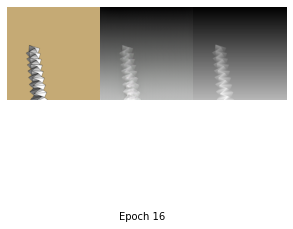

Epoch [17/50], Step [1/3750], D_loss: 0.0172, G_loss: 9.5623
Epoch [17/50], Step [2/3750], D_loss: 0.0335, G_loss: 12.0810
Epoch [17/50], Step [3/3750], D_loss: 0.0271, G_loss: 16.3842
Epoch [17/50], Step [4/3750], D_loss: 0.0256, G_loss: 5.8156
Epoch [17/50], Step [5/3750], D_loss: 0.2975, G_loss: 4.3890
Epoch [17/50], Step [6/3750], D_loss: 0.0270, G_loss: 12.3767
Epoch [17/50], Step [7/3750], D_loss: 0.0477, G_loss: 9.1967
Epoch [17/50], Step [8/3750], D_loss: 0.0776, G_loss: 4.5812
Epoch [17/50], Step [9/3750], D_loss: 0.3460, G_loss: 4.8576
Epoch [17/50], Step [10/3750], D_loss: 0.0851, G_loss: 5.0427
Epoch [17/50], Step [11/3750], D_loss: 0.1446, G_loss: 6.7995
Epoch [17/50], Step [12/3750], D_loss: 0.0267, G_loss: 13.8896
Epoch [17/50], Step [13/3750], D_loss: 0.0547, G_loss: 9.0065
Epoch [17/50], Step [14/3750], D_loss: 0.1177, G_loss: 6.1030
Epoch [17/50], Step [15/3750], D_loss: 0.0087, G_loss: 7.4876
Epoch [17/50], Step [16/3750], D_loss: 0.0620, G_loss: 12.7050
Epoch [17/50

Epoch [17/50], Step [133/3750], D_loss: 0.0545, G_loss: 11.3683
Epoch [17/50], Step [134/3750], D_loss: 0.3354, G_loss: 4.0407
Epoch [17/50], Step [135/3750], D_loss: 0.1289, G_loss: 13.7684
Epoch [17/50], Step [136/3750], D_loss: 0.1941, G_loss: 14.2074
Epoch [17/50], Step [137/3750], D_loss: 0.0144, G_loss: 7.5810
Epoch [17/50], Step [138/3750], D_loss: 0.1486, G_loss: 6.7683
Epoch [17/50], Step [139/3750], D_loss: 0.1436, G_loss: 6.0937
Epoch [17/50], Step [140/3750], D_loss: 0.1240, G_loss: 5.5696
Epoch [17/50], Step [141/3750], D_loss: 0.0104, G_loss: 7.0923
Epoch [17/50], Step [142/3750], D_loss: 0.0199, G_loss: 11.2491
Epoch [17/50], Step [143/3750], D_loss: 0.2211, G_loss: 7.1881
Epoch [17/50], Step [144/3750], D_loss: 0.0241, G_loss: 5.8075
Epoch [17/50], Step [145/3750], D_loss: 0.0538, G_loss: 6.3551
Epoch [17/50], Step [146/3750], D_loss: 0.3255, G_loss: 4.8081
Epoch [17/50], Step [147/3750], D_loss: 0.0056, G_loss: 15.7875
Epoch [17/50], Step [148/3750], D_loss: 0.1845, G_

Epoch [17/50], Step [263/3750], D_loss: 0.1587, G_loss: 5.7745
Epoch [17/50], Step [264/3750], D_loss: 0.0392, G_loss: 8.6468
Epoch [17/50], Step [265/3750], D_loss: 0.1511, G_loss: 5.1607
Epoch [17/50], Step [266/3750], D_loss: 0.0216, G_loss: 7.1016
Epoch [17/50], Step [267/3750], D_loss: 0.0996, G_loss: 10.5044
Epoch [17/50], Step [268/3750], D_loss: 0.0252, G_loss: 9.3264
Epoch [17/50], Step [269/3750], D_loss: 0.0080, G_loss: 8.1982
Epoch [17/50], Step [270/3750], D_loss: 0.0194, G_loss: 11.6125
Epoch [17/50], Step [271/3750], D_loss: 0.2149, G_loss: 6.3049
Epoch [17/50], Step [272/3750], D_loss: 0.1628, G_loss: 6.6335
Epoch [17/50], Step [273/3750], D_loss: 0.1558, G_loss: 11.1096
Epoch [17/50], Step [274/3750], D_loss: 0.0636, G_loss: 9.2002
Epoch [17/50], Step [275/3750], D_loss: 0.3855, G_loss: 5.7653
Epoch [17/50], Step [276/3750], D_loss: 0.0422, G_loss: 5.9550
Epoch [17/50], Step [277/3750], D_loss: 0.1878, G_loss: 5.8951
Epoch [17/50], Step [278/3750], D_loss: 0.0700, G_lo

Epoch [17/50], Step [393/3750], D_loss: 1.0093, G_loss: 7.5338
Epoch [17/50], Step [394/3750], D_loss: 0.0611, G_loss: 5.3166
Epoch [17/50], Step [395/3750], D_loss: 0.0510, G_loss: 11.2481
Epoch [17/50], Step [396/3750], D_loss: 0.0526, G_loss: 8.2360
Epoch [17/50], Step [397/3750], D_loss: 0.0306, G_loss: 12.7148
Epoch [17/50], Step [398/3750], D_loss: 0.1155, G_loss: 12.4247
Epoch [17/50], Step [399/3750], D_loss: 0.0302, G_loss: 5.2278
Epoch [17/50], Step [400/3750], D_loss: 0.0945, G_loss: 4.7779
Epoch [17/50], Step [401/3750], D_loss: 0.1998, G_loss: 4.8758
Epoch [17/50], Step [402/3750], D_loss: 0.1070, G_loss: 8.0460
Epoch [17/50], Step [403/3750], D_loss: 0.0258, G_loss: 15.2562
Epoch [17/50], Step [404/3750], D_loss: 0.0318, G_loss: 9.2076
Epoch [17/50], Step [405/3750], D_loss: 0.3321, G_loss: 5.0230
Epoch [17/50], Step [406/3750], D_loss: 0.4324, G_loss: 7.3255
Epoch [17/50], Step [407/3750], D_loss: 0.2000, G_loss: 6.9599
Epoch [17/50], Step [408/3750], D_loss: 0.0206, G_l

Epoch [17/50], Step [523/3750], D_loss: 0.0275, G_loss: 7.5618
Epoch [17/50], Step [524/3750], D_loss: 0.1964, G_loss: 5.4747
Epoch [17/50], Step [525/3750], D_loss: 0.7443, G_loss: 5.4992
Epoch [17/50], Step [526/3750], D_loss: 0.0779, G_loss: 8.8508
Epoch [17/50], Step [527/3750], D_loss: 0.3297, G_loss: 4.3750
Epoch [17/50], Step [528/3750], D_loss: 0.1987, G_loss: 8.8925
Epoch [17/50], Step [529/3750], D_loss: 0.1650, G_loss: 9.5692
Epoch [17/50], Step [530/3750], D_loss: 0.3578, G_loss: 6.1038
Epoch [17/50], Step [531/3750], D_loss: 1.5387, G_loss: 7.5695
Epoch [17/50], Step [532/3750], D_loss: 0.2894, G_loss: 18.3276
Epoch [17/50], Step [533/3750], D_loss: 0.5238, G_loss: 6.4042
Epoch [17/50], Step [534/3750], D_loss: 0.2310, G_loss: 6.1487
Epoch [17/50], Step [535/3750], D_loss: 0.0600, G_loss: 7.9405
Epoch [17/50], Step [536/3750], D_loss: 0.3100, G_loss: 8.5202
Epoch [17/50], Step [537/3750], D_loss: 0.0169, G_loss: 10.9602
Epoch [17/50], Step [538/3750], D_loss: 0.0390, G_los

Epoch [17/50], Step [653/3750], D_loss: 0.3997, G_loss: 9.3951
Epoch [17/50], Step [654/3750], D_loss: 0.0861, G_loss: 6.9461
Epoch [17/50], Step [655/3750], D_loss: 0.2070, G_loss: 7.4535
Epoch [17/50], Step [656/3750], D_loss: 0.0601, G_loss: 5.8924
Epoch [17/50], Step [657/3750], D_loss: 0.0701, G_loss: 6.7124
Epoch [17/50], Step [658/3750], D_loss: 0.2857, G_loss: 5.0396
Epoch [17/50], Step [659/3750], D_loss: 0.0627, G_loss: 8.4418
Epoch [17/50], Step [660/3750], D_loss: 0.0616, G_loss: 11.9651
Epoch [17/50], Step [661/3750], D_loss: 0.0534, G_loss: 9.7110
Epoch [17/50], Step [662/3750], D_loss: 0.0293, G_loss: 6.4857
Epoch [17/50], Step [663/3750], D_loss: 0.0212, G_loss: 12.4240
Epoch [17/50], Step [664/3750], D_loss: 0.0290, G_loss: 12.0110
Epoch [17/50], Step [665/3750], D_loss: 0.1109, G_loss: 6.2220
Epoch [17/50], Step [666/3750], D_loss: 0.1605, G_loss: 13.6787
Epoch [17/50], Step [667/3750], D_loss: 0.0601, G_loss: 11.4085
Epoch [17/50], Step [668/3750], D_loss: 0.0454, G_

Epoch [17/50], Step [783/3750], D_loss: 0.6483, G_loss: 6.1117
Epoch [17/50], Step [784/3750], D_loss: 0.4836, G_loss: 5.0046
Epoch [17/50], Step [785/3750], D_loss: 0.0659, G_loss: 11.5242
Epoch [17/50], Step [786/3750], D_loss: 0.2725, G_loss: 6.0753
Epoch [17/50], Step [787/3750], D_loss: 0.1939, G_loss: 7.4719
Epoch [17/50], Step [788/3750], D_loss: 0.0932, G_loss: 8.4955
Epoch [17/50], Step [789/3750], D_loss: 0.0423, G_loss: 8.2021
Epoch [17/50], Step [790/3750], D_loss: 0.0549, G_loss: 13.6592
Epoch [17/50], Step [791/3750], D_loss: 0.1115, G_loss: 7.3163
Epoch [17/50], Step [792/3750], D_loss: 0.0872, G_loss: 12.5361
Epoch [17/50], Step [793/3750], D_loss: 0.1754, G_loss: 6.2631
Epoch [17/50], Step [794/3750], D_loss: 0.1745, G_loss: 8.7762
Epoch [17/50], Step [795/3750], D_loss: 0.0219, G_loss: 5.8346
Epoch [17/50], Step [796/3750], D_loss: 0.0960, G_loss: 13.2730
Epoch [17/50], Step [797/3750], D_loss: 0.1423, G_loss: 5.5480
Epoch [17/50], Step [798/3750], D_loss: 0.1595, G_l

Epoch [17/50], Step [913/3750], D_loss: 0.3340, G_loss: 6.0558
Epoch [17/50], Step [914/3750], D_loss: 0.1462, G_loss: 5.7763
Epoch [17/50], Step [915/3750], D_loss: 0.2950, G_loss: 8.1417
Epoch [17/50], Step [916/3750], D_loss: 0.1284, G_loss: 8.5617
Epoch [17/50], Step [917/3750], D_loss: 0.1001, G_loss: 14.7584
Epoch [17/50], Step [918/3750], D_loss: 0.3027, G_loss: 6.7995
Epoch [17/50], Step [919/3750], D_loss: 0.0584, G_loss: 12.5190
Epoch [17/50], Step [920/3750], D_loss: 0.1034, G_loss: 12.2232
Epoch [17/50], Step [921/3750], D_loss: 0.2664, G_loss: 8.6449
Epoch [17/50], Step [922/3750], D_loss: 0.1311, G_loss: 6.9495
Epoch [17/50], Step [923/3750], D_loss: 0.0720, G_loss: 7.1770
Epoch [17/50], Step [924/3750], D_loss: 0.1271, G_loss: 5.2240
Epoch [17/50], Step [925/3750], D_loss: 0.0796, G_loss: 4.7811
Epoch [17/50], Step [926/3750], D_loss: 0.1014, G_loss: 11.8757
Epoch [17/50], Step [927/3750], D_loss: 0.0662, G_loss: 6.4621
Epoch [17/50], Step [928/3750], D_loss: 0.0694, G_l

Epoch [17/50], Step [1042/3750], D_loss: 0.0171, G_loss: 7.1825
Epoch [17/50], Step [1043/3750], D_loss: 0.0829, G_loss: 6.0797
Epoch [17/50], Step [1044/3750], D_loss: 0.0719, G_loss: 6.0094
Epoch [17/50], Step [1045/3750], D_loss: 0.1713, G_loss: 6.2879
Epoch [17/50], Step [1046/3750], D_loss: 0.0797, G_loss: 6.4682
Epoch [17/50], Step [1047/3750], D_loss: 0.0606, G_loss: 11.6992
Epoch [17/50], Step [1048/3750], D_loss: 0.0527, G_loss: 9.6550
Epoch [17/50], Step [1049/3750], D_loss: 0.0993, G_loss: 8.5590
Epoch [17/50], Step [1050/3750], D_loss: 0.2307, G_loss: 6.1525
Epoch [17/50], Step [1051/3750], D_loss: 0.0897, G_loss: 5.5346
Epoch [17/50], Step [1052/3750], D_loss: 0.1556, G_loss: 12.6978
Epoch [17/50], Step [1053/3750], D_loss: 0.0340, G_loss: 6.9439
Epoch [17/50], Step [1054/3750], D_loss: 0.1266, G_loss: 10.1399
Epoch [17/50], Step [1055/3750], D_loss: 0.1770, G_loss: 6.0470
Epoch [17/50], Step [1056/3750], D_loss: 0.1949, G_loss: 5.5015
Epoch [17/50], Step [1057/3750], D_lo

Epoch [17/50], Step [1170/3750], D_loss: 0.1091, G_loss: 5.1542
Epoch [17/50], Step [1171/3750], D_loss: 0.1253, G_loss: 5.2826
Epoch [17/50], Step [1172/3750], D_loss: 0.4931, G_loss: 4.7291
Epoch [17/50], Step [1173/3750], D_loss: 0.0622, G_loss: 7.0379
Epoch [17/50], Step [1174/3750], D_loss: 0.0516, G_loss: 12.5982
Epoch [17/50], Step [1175/3750], D_loss: 0.3445, G_loss: 10.1618
Epoch [17/50], Step [1176/3750], D_loss: 0.3207, G_loss: 7.2887
Epoch [17/50], Step [1177/3750], D_loss: 0.0766, G_loss: 6.8346
Epoch [17/50], Step [1178/3750], D_loss: 0.0225, G_loss: 14.8256
Epoch [17/50], Step [1179/3750], D_loss: 0.0637, G_loss: 6.0179
Epoch [17/50], Step [1180/3750], D_loss: 0.0801, G_loss: 7.9754
Epoch [17/50], Step [1181/3750], D_loss: 0.3242, G_loss: 9.3945
Epoch [17/50], Step [1182/3750], D_loss: 0.0178, G_loss: 9.9969
Epoch [17/50], Step [1183/3750], D_loss: 0.5249, G_loss: 8.1359
Epoch [17/50], Step [1184/3750], D_loss: 0.3961, G_loss: 4.9277
Epoch [17/50], Step [1185/3750], D_lo

Epoch [17/50], Step [1298/3750], D_loss: 0.4308, G_loss: 4.6617
Epoch [17/50], Step [1299/3750], D_loss: 0.2610, G_loss: 6.6865
Epoch [17/50], Step [1300/3750], D_loss: 0.2787, G_loss: 4.6323
Epoch [17/50], Step [1301/3750], D_loss: 0.1936, G_loss: 7.9613
Epoch [17/50], Step [1302/3750], D_loss: 0.0443, G_loss: 6.4170
Epoch [17/50], Step [1303/3750], D_loss: 0.0831, G_loss: 5.4710
Epoch [17/50], Step [1304/3750], D_loss: 0.0906, G_loss: 9.5519
Epoch [17/50], Step [1305/3750], D_loss: 0.0210, G_loss: 7.1952
Epoch [17/50], Step [1306/3750], D_loss: 0.0130, G_loss: 11.5083
Epoch [17/50], Step [1307/3750], D_loss: 0.0165, G_loss: 10.0272
Epoch [17/50], Step [1308/3750], D_loss: 0.0680, G_loss: 16.4802
Epoch [17/50], Step [1309/3750], D_loss: 0.0902, G_loss: 10.4131
Epoch [17/50], Step [1310/3750], D_loss: 0.1434, G_loss: 9.1917
Epoch [17/50], Step [1311/3750], D_loss: 0.1425, G_loss: 4.6263
Epoch [17/50], Step [1312/3750], D_loss: 0.1308, G_loss: 5.8908
Epoch [17/50], Step [1313/3750], D_l

Epoch [17/50], Step [1426/3750], D_loss: 0.0766, G_loss: 7.4481
Epoch [17/50], Step [1427/3750], D_loss: 0.0979, G_loss: 5.2881
Epoch [17/50], Step [1428/3750], D_loss: 0.1055, G_loss: 7.1311
Epoch [17/50], Step [1429/3750], D_loss: 0.3172, G_loss: 9.9085
Epoch [17/50], Step [1430/3750], D_loss: 0.1020, G_loss: 7.7534
Epoch [17/50], Step [1431/3750], D_loss: 0.0677, G_loss: 11.5777
Epoch [17/50], Step [1432/3750], D_loss: 0.0573, G_loss: 12.5219
Epoch [17/50], Step [1433/3750], D_loss: 0.3346, G_loss: 14.7940
Epoch [17/50], Step [1434/3750], D_loss: 0.0816, G_loss: 8.7167
Epoch [17/50], Step [1435/3750], D_loss: 0.1891, G_loss: 5.8590
Epoch [17/50], Step [1436/3750], D_loss: 0.4754, G_loss: 10.3235
Epoch [17/50], Step [1437/3750], D_loss: 0.4912, G_loss: 5.7379
Epoch [17/50], Step [1438/3750], D_loss: 0.0233, G_loss: 9.2053
Epoch [17/50], Step [1439/3750], D_loss: 0.0717, G_loss: 7.4221
Epoch [17/50], Step [1440/3750], D_loss: 0.2436, G_loss: 5.7972
Epoch [17/50], Step [1441/3750], D_l

Epoch [17/50], Step [1554/3750], D_loss: 0.0387, G_loss: 15.8020
Epoch [17/50], Step [1555/3750], D_loss: 0.2617, G_loss: 7.6812
Epoch [17/50], Step [1556/3750], D_loss: 0.0285, G_loss: 5.1693
Epoch [17/50], Step [1557/3750], D_loss: 0.1214, G_loss: 5.0446
Epoch [17/50], Step [1558/3750], D_loss: 0.2935, G_loss: 15.4791
Epoch [17/50], Step [1559/3750], D_loss: 0.0435, G_loss: 4.2809
Epoch [17/50], Step [1560/3750], D_loss: 0.1113, G_loss: 7.7308
Epoch [17/50], Step [1561/3750], D_loss: 0.0592, G_loss: 12.5410
Epoch [17/50], Step [1562/3750], D_loss: 0.0233, G_loss: 6.3780
Epoch [17/50], Step [1563/3750], D_loss: 0.1829, G_loss: 4.8911
Epoch [17/50], Step [1564/3750], D_loss: 0.0380, G_loss: 6.6085
Epoch [17/50], Step [1565/3750], D_loss: 0.0841, G_loss: 7.3226
Epoch [17/50], Step [1566/3750], D_loss: 0.2062, G_loss: 5.5213
Epoch [17/50], Step [1567/3750], D_loss: 0.0170, G_loss: 12.5942
Epoch [17/50], Step [1568/3750], D_loss: 0.0840, G_loss: 5.5481
Epoch [17/50], Step [1569/3750], D_l

Epoch [17/50], Step [1682/3750], D_loss: 0.0653, G_loss: 10.0174
Epoch [17/50], Step [1683/3750], D_loss: 0.0257, G_loss: 5.6297
Epoch [17/50], Step [1684/3750], D_loss: 0.0166, G_loss: 9.9593
Epoch [17/50], Step [1685/3750], D_loss: 0.0134, G_loss: 7.8589
Epoch [17/50], Step [1686/3750], D_loss: 0.0243, G_loss: 12.6618
Epoch [17/50], Step [1687/3750], D_loss: 0.0398, G_loss: 7.3098
Epoch [17/50], Step [1688/3750], D_loss: 0.0063, G_loss: 14.7362
Epoch [17/50], Step [1689/3750], D_loss: 0.1178, G_loss: 9.4148
Epoch [17/50], Step [1690/3750], D_loss: 0.0516, G_loss: 8.0250
Epoch [17/50], Step [1691/3750], D_loss: 0.1042, G_loss: 10.8324
Epoch [17/50], Step [1692/3750], D_loss: 0.1102, G_loss: 8.4265
Epoch [17/50], Step [1693/3750], D_loss: 0.0319, G_loss: 16.2996
Epoch [17/50], Step [1694/3750], D_loss: 0.0851, G_loss: 9.4126
Epoch [17/50], Step [1695/3750], D_loss: 0.0869, G_loss: 12.4057
Epoch [17/50], Step [1696/3750], D_loss: 0.2372, G_loss: 6.7738
Epoch [17/50], Step [1697/3750], D

Epoch [17/50], Step [1810/3750], D_loss: 0.1070, G_loss: 7.0682
Epoch [17/50], Step [1811/3750], D_loss: 0.1193, G_loss: 5.9928
Epoch [17/50], Step [1812/3750], D_loss: 0.0139, G_loss: 7.6705
Epoch [17/50], Step [1813/3750], D_loss: 0.2197, G_loss: 17.1304
Epoch [17/50], Step [1814/3750], D_loss: 0.0228, G_loss: 8.8103
Epoch [17/50], Step [1815/3750], D_loss: 0.0967, G_loss: 8.4100
Epoch [17/50], Step [1816/3750], D_loss: 0.0287, G_loss: 10.9714
Epoch [17/50], Step [1817/3750], D_loss: 0.0117, G_loss: 12.5206
Epoch [17/50], Step [1818/3750], D_loss: 0.0266, G_loss: 10.7889
Epoch [17/50], Step [1819/3750], D_loss: 0.0111, G_loss: 9.6056
Epoch [17/50], Step [1820/3750], D_loss: 0.0205, G_loss: 10.4586
Epoch [17/50], Step [1821/3750], D_loss: 0.0069, G_loss: 7.2752
Epoch [17/50], Step [1822/3750], D_loss: 0.0125, G_loss: 10.4125
Epoch [17/50], Step [1823/3750], D_loss: 0.0124, G_loss: 7.2751
Epoch [17/50], Step [1824/3750], D_loss: 0.0075, G_loss: 7.2848
Epoch [17/50], Step [1825/3750], D

Epoch [17/50], Step [1938/3750], D_loss: 0.0152, G_loss: 5.4994
Epoch [17/50], Step [1939/3750], D_loss: 0.0465, G_loss: 13.3218
Epoch [17/50], Step [1940/3750], D_loss: 0.0140, G_loss: 11.1106
Epoch [17/50], Step [1941/3750], D_loss: 0.0169, G_loss: 12.1782
Epoch [17/50], Step [1942/3750], D_loss: 0.1065, G_loss: 6.6673
Epoch [17/50], Step [1943/3750], D_loss: 0.0151, G_loss: 8.9435
Epoch [17/50], Step [1944/3750], D_loss: 0.0042, G_loss: 9.2674
Epoch [17/50], Step [1945/3750], D_loss: 0.1344, G_loss: 7.5974
Epoch [17/50], Step [1946/3750], D_loss: 0.0116, G_loss: 7.6845
Epoch [17/50], Step [1947/3750], D_loss: 0.0401, G_loss: 8.3662
Epoch [17/50], Step [1948/3750], D_loss: 0.3435, G_loss: 6.8239
Epoch [17/50], Step [1949/3750], D_loss: 0.0026, G_loss: 9.6095
Epoch [17/50], Step [1950/3750], D_loss: 0.0300, G_loss: 7.7888
Epoch [17/50], Step [1951/3750], D_loss: 0.1067, G_loss: 6.1341
Epoch [17/50], Step [1952/3750], D_loss: 0.2382, G_loss: 5.4558
Epoch [17/50], Step [1953/3750], D_lo

Epoch [17/50], Step [2066/3750], D_loss: 0.3223, G_loss: 5.9008
Epoch [17/50], Step [2067/3750], D_loss: 0.1877, G_loss: 4.6264
Epoch [17/50], Step [2068/3750], D_loss: 0.2040, G_loss: 5.5505
Epoch [17/50], Step [2069/3750], D_loss: 0.0162, G_loss: 7.0548
Epoch [17/50], Step [2070/3750], D_loss: 0.2077, G_loss: 7.7262
Epoch [17/50], Step [2071/3750], D_loss: 0.1597, G_loss: 4.1158
Epoch [17/50], Step [2072/3750], D_loss: 0.1380, G_loss: 5.0444
Epoch [17/50], Step [2073/3750], D_loss: 0.0112, G_loss: 6.5124
Epoch [17/50], Step [2074/3750], D_loss: 0.1574, G_loss: 7.0469
Epoch [17/50], Step [2075/3750], D_loss: 0.1726, G_loss: 8.8679
Epoch [17/50], Step [2076/3750], D_loss: 0.0491, G_loss: 12.6235
Epoch [17/50], Step [2077/3750], D_loss: 0.0103, G_loss: 7.3744
Epoch [17/50], Step [2078/3750], D_loss: 0.0235, G_loss: 6.0438
Epoch [17/50], Step [2079/3750], D_loss: 0.0282, G_loss: 7.0550
Epoch [17/50], Step [2080/3750], D_loss: 1.4991, G_loss: 3.4264
Epoch [17/50], Step [2081/3750], D_loss

Epoch [17/50], Step [2194/3750], D_loss: 0.1555, G_loss: 6.2793
Epoch [17/50], Step [2195/3750], D_loss: 0.1673, G_loss: 10.1193
Epoch [17/50], Step [2196/3750], D_loss: 0.3171, G_loss: 11.9909
Epoch [17/50], Step [2197/3750], D_loss: 0.0128, G_loss: 11.9933
Epoch [17/50], Step [2198/3750], D_loss: 0.1179, G_loss: 10.3729
Epoch [17/50], Step [2199/3750], D_loss: 0.0114, G_loss: 6.6272
Epoch [17/50], Step [2200/3750], D_loss: 0.2951, G_loss: 5.8248
Epoch [17/50], Step [2201/3750], D_loss: 0.2463, G_loss: 5.3756
Epoch [17/50], Step [2202/3750], D_loss: 0.1186, G_loss: 11.5351
Epoch [17/50], Step [2203/3750], D_loss: 0.3846, G_loss: 16.1398
Epoch [17/50], Step [2204/3750], D_loss: 0.0769, G_loss: 5.0796
Epoch [17/50], Step [2205/3750], D_loss: 0.0891, G_loss: 9.1121
Epoch [17/50], Step [2206/3750], D_loss: 0.1060, G_loss: 5.0503
Epoch [17/50], Step [2207/3750], D_loss: 0.4535, G_loss: 13.1989
Epoch [17/50], Step [2208/3750], D_loss: 0.0893, G_loss: 10.0906
Epoch [17/50], Step [2209/3750],

Epoch [17/50], Step [2322/3750], D_loss: 0.4719, G_loss: 6.4386
Epoch [17/50], Step [2323/3750], D_loss: 0.6413, G_loss: 4.8005
Epoch [17/50], Step [2324/3750], D_loss: 0.0155, G_loss: 14.0231
Epoch [17/50], Step [2325/3750], D_loss: 0.3934, G_loss: 3.8182
Epoch [17/50], Step [2326/3750], D_loss: 0.1051, G_loss: 6.7915
Epoch [17/50], Step [2327/3750], D_loss: 0.1689, G_loss: 8.9852
Epoch [17/50], Step [2328/3750], D_loss: 0.0513, G_loss: 7.0742
Epoch [17/50], Step [2329/3750], D_loss: 0.7225, G_loss: 5.7762
Epoch [17/50], Step [2330/3750], D_loss: 0.1107, G_loss: 10.3585
Epoch [17/50], Step [2331/3750], D_loss: 0.0070, G_loss: 13.7534
Epoch [17/50], Step [2332/3750], D_loss: 0.2066, G_loss: 7.9663
Epoch [17/50], Step [2333/3750], D_loss: 0.0259, G_loss: 18.4243
Epoch [17/50], Step [2334/3750], D_loss: 0.0095, G_loss: 7.1536
Epoch [17/50], Step [2335/3750], D_loss: 0.0078, G_loss: 9.1731
Epoch [17/50], Step [2336/3750], D_loss: 0.0075, G_loss: 10.5160
Epoch [17/50], Step [2337/3750], D_

Epoch [17/50], Step [2450/3750], D_loss: 0.1616, G_loss: 7.4973
Epoch [17/50], Step [2451/3750], D_loss: 0.0149, G_loss: 9.7880
Epoch [17/50], Step [2452/3750], D_loss: 0.0189, G_loss: 7.6689
Epoch [17/50], Step [2453/3750], D_loss: 0.1993, G_loss: 9.8748
Epoch [17/50], Step [2454/3750], D_loss: 0.2719, G_loss: 7.0904
Epoch [17/50], Step [2455/3750], D_loss: 0.1196, G_loss: 8.0256
Epoch [17/50], Step [2456/3750], D_loss: 0.2078, G_loss: 10.6335
Epoch [17/50], Step [2457/3750], D_loss: 0.1334, G_loss: 8.4031
Epoch [17/50], Step [2458/3750], D_loss: 0.1632, G_loss: 6.8788
Epoch [17/50], Step [2459/3750], D_loss: 0.0521, G_loss: 7.9254
Epoch [17/50], Step [2460/3750], D_loss: 0.0480, G_loss: 9.3365
Epoch [17/50], Step [2461/3750], D_loss: 0.0070, G_loss: 14.8831
Epoch [17/50], Step [2462/3750], D_loss: 0.0138, G_loss: 7.6278
Epoch [17/50], Step [2463/3750], D_loss: 0.0781, G_loss: 8.6713
Epoch [17/50], Step [2464/3750], D_loss: 0.0126, G_loss: 7.6888
Epoch [17/50], Step [2465/3750], D_los

Epoch [17/50], Step [2578/3750], D_loss: 0.0781, G_loss: 7.2404
Epoch [17/50], Step [2579/3750], D_loss: 0.3989, G_loss: 7.0589
Epoch [17/50], Step [2580/3750], D_loss: 0.3475, G_loss: 12.0355
Epoch [17/50], Step [2581/3750], D_loss: 0.0249, G_loss: 10.3974
Epoch [17/50], Step [2582/3750], D_loss: 0.1941, G_loss: 5.2572
Epoch [17/50], Step [2583/3750], D_loss: 0.2189, G_loss: 11.3711
Epoch [17/50], Step [2584/3750], D_loss: 0.3679, G_loss: 7.3893
Epoch [17/50], Step [2585/3750], D_loss: 0.0245, G_loss: 11.5003
Epoch [17/50], Step [2586/3750], D_loss: 0.1208, G_loss: 9.6730
Epoch [17/50], Step [2587/3750], D_loss: 0.4147, G_loss: 4.0894
Epoch [17/50], Step [2588/3750], D_loss: 0.0113, G_loss: 8.9358
Epoch [17/50], Step [2589/3750], D_loss: 0.0332, G_loss: 13.4826
Epoch [17/50], Step [2590/3750], D_loss: 0.2219, G_loss: 7.8559
Epoch [17/50], Step [2591/3750], D_loss: 0.0564, G_loss: 6.1781
Epoch [17/50], Step [2592/3750], D_loss: 0.0160, G_loss: 7.2353
Epoch [17/50], Step [2593/3750], D_

Epoch [17/50], Step [2706/3750], D_loss: 0.0783, G_loss: 7.2193
Epoch [17/50], Step [2707/3750], D_loss: 0.0721, G_loss: 4.8678
Epoch [17/50], Step [2708/3750], D_loss: 0.1393, G_loss: 5.5565
Epoch [17/50], Step [2709/3750], D_loss: 0.0417, G_loss: 8.9602
Epoch [17/50], Step [2710/3750], D_loss: 0.0109, G_loss: 8.4406
Epoch [17/50], Step [2711/3750], D_loss: 0.1928, G_loss: 9.1730
Epoch [17/50], Step [2712/3750], D_loss: 0.1738, G_loss: 5.2778
Epoch [17/50], Step [2713/3750], D_loss: 0.2267, G_loss: 4.9835
Epoch [17/50], Step [2714/3750], D_loss: 0.0689, G_loss: 14.3944
Epoch [17/50], Step [2715/3750], D_loss: 0.0058, G_loss: 6.9016
Epoch [17/50], Step [2716/3750], D_loss: 0.0162, G_loss: 5.6493
Epoch [17/50], Step [2717/3750], D_loss: 0.1992, G_loss: 6.6587
Epoch [17/50], Step [2718/3750], D_loss: 0.2579, G_loss: 8.4388
Epoch [17/50], Step [2719/3750], D_loss: 0.0240, G_loss: 11.6994
Epoch [17/50], Step [2720/3750], D_loss: 0.0338, G_loss: 13.6739
Epoch [17/50], Step [2721/3750], D_lo

Epoch [17/50], Step [2834/3750], D_loss: 0.0272, G_loss: 7.1232
Epoch [17/50], Step [2835/3750], D_loss: 0.1524, G_loss: 11.9368
Epoch [17/50], Step [2836/3750], D_loss: 0.0621, G_loss: 16.4550
Epoch [17/50], Step [2837/3750], D_loss: 0.1098, G_loss: 13.8238
Epoch [17/50], Step [2838/3750], D_loss: 0.0244, G_loss: 9.7974
Epoch [17/50], Step [2839/3750], D_loss: 0.2532, G_loss: 4.5592
Epoch [17/50], Step [2840/3750], D_loss: 0.0284, G_loss: 16.9540
Epoch [17/50], Step [2841/3750], D_loss: 0.1942, G_loss: 7.8308
Epoch [17/50], Step [2842/3750], D_loss: 0.1326, G_loss: 4.1883
Epoch [17/50], Step [2843/3750], D_loss: 0.1477, G_loss: 8.0781
Epoch [17/50], Step [2844/3750], D_loss: 0.0121, G_loss: 13.8311
Epoch [17/50], Step [2845/3750], D_loss: 0.3085, G_loss: 7.6096
Epoch [17/50], Step [2846/3750], D_loss: 0.0687, G_loss: 7.4476
Epoch [17/50], Step [2847/3750], D_loss: 0.1042, G_loss: 7.5774
Epoch [17/50], Step [2848/3750], D_loss: 0.3243, G_loss: 4.2921
Epoch [17/50], Step [2849/3750], D_

Epoch [17/50], Step [2962/3750], D_loss: 0.0235, G_loss: 11.1868
Epoch [17/50], Step [2963/3750], D_loss: 0.1952, G_loss: 5.9501
Epoch [17/50], Step [2964/3750], D_loss: 0.0143, G_loss: 7.9516
Epoch [17/50], Step [2965/3750], D_loss: 0.0557, G_loss: 6.3195
Epoch [17/50], Step [2966/3750], D_loss: 0.0106, G_loss: 11.2208
Epoch [17/50], Step [2967/3750], D_loss: 0.0139, G_loss: 8.5742
Epoch [17/50], Step [2968/3750], D_loss: 0.1444, G_loss: 6.6554
Epoch [17/50], Step [2969/3750], D_loss: 0.0506, G_loss: 6.9563
Epoch [17/50], Step [2970/3750], D_loss: 0.0794, G_loss: 12.0423
Epoch [17/50], Step [2971/3750], D_loss: 0.0111, G_loss: 9.4139
Epoch [17/50], Step [2972/3750], D_loss: 0.0159, G_loss: 6.8647
Epoch [17/50], Step [2973/3750], D_loss: 0.0857, G_loss: 8.5361
Epoch [17/50], Step [2974/3750], D_loss: 0.1544, G_loss: 4.8136
Epoch [17/50], Step [2975/3750], D_loss: 0.0904, G_loss: 8.5169
Epoch [17/50], Step [2976/3750], D_loss: 0.2484, G_loss: 6.0892
Epoch [17/50], Step [2977/3750], D_lo

Epoch [17/50], Step [3090/3750], D_loss: 0.1741, G_loss: 5.0855
Epoch [17/50], Step [3091/3750], D_loss: 0.0921, G_loss: 16.5122
Epoch [17/50], Step [3092/3750], D_loss: 0.0202, G_loss: 8.6152
Epoch [17/50], Step [3093/3750], D_loss: 0.1101, G_loss: 10.3347
Epoch [17/50], Step [3094/3750], D_loss: 0.0456, G_loss: 13.3733
Epoch [17/50], Step [3095/3750], D_loss: 0.0280, G_loss: 12.1368
Epoch [17/50], Step [3096/3750], D_loss: 0.1805, G_loss: 9.8091
Epoch [17/50], Step [3097/3750], D_loss: 0.1518, G_loss: 6.9543
Epoch [17/50], Step [3098/3750], D_loss: 0.4890, G_loss: 12.0855
Epoch [17/50], Step [3099/3750], D_loss: 0.0116, G_loss: 9.8166
Epoch [17/50], Step [3100/3750], D_loss: 0.1322, G_loss: 8.1587
Epoch [17/50], Step [3101/3750], D_loss: 0.0184, G_loss: 10.5221
Epoch [17/50], Step [3102/3750], D_loss: 0.2622, G_loss: 4.9816
Epoch [17/50], Step [3103/3750], D_loss: 0.1280, G_loss: 8.4744
Epoch [17/50], Step [3104/3750], D_loss: 0.0340, G_loss: 12.0723
Epoch [17/50], Step [3105/3750], 

Epoch [17/50], Step [3218/3750], D_loss: 0.2431, G_loss: 6.8883
Epoch [17/50], Step [3219/3750], D_loss: 0.0813, G_loss: 11.5650
Epoch [17/50], Step [3220/3750], D_loss: 0.0797, G_loss: 7.7569
Epoch [17/50], Step [3221/3750], D_loss: 0.1274, G_loss: 6.0129
Epoch [17/50], Step [3222/3750], D_loss: 0.0099, G_loss: 8.9692
Epoch [17/50], Step [3223/3750], D_loss: 0.0207, G_loss: 12.9900
Epoch [17/50], Step [3224/3750], D_loss: 0.1032, G_loss: 17.6175
Epoch [17/50], Step [3225/3750], D_loss: 0.0150, G_loss: 8.8881
Epoch [17/50], Step [3226/3750], D_loss: 0.0520, G_loss: 17.3715
Epoch [17/50], Step [3227/3750], D_loss: 0.0252, G_loss: 5.4043
Epoch [17/50], Step [3228/3750], D_loss: 0.2085, G_loss: 6.6799
Epoch [17/50], Step [3229/3750], D_loss: 0.0725, G_loss: 7.1457
Epoch [17/50], Step [3230/3750], D_loss: 0.0274, G_loss: 9.0240
Epoch [17/50], Step [3231/3750], D_loss: 0.0449, G_loss: 7.4702
Epoch [17/50], Step [3232/3750], D_loss: 0.0221, G_loss: 11.5396
Epoch [17/50], Step [3233/3750], D_

Epoch [17/50], Step [3346/3750], D_loss: 0.0350, G_loss: 8.0977
Epoch [17/50], Step [3347/3750], D_loss: 0.1074, G_loss: 6.1486
Epoch [17/50], Step [3348/3750], D_loss: 0.0886, G_loss: 7.3981
Epoch [17/50], Step [3349/3750], D_loss: 0.0309, G_loss: 11.7128
Epoch [17/50], Step [3350/3750], D_loss: 0.1095, G_loss: 9.1067
Epoch [17/50], Step [3351/3750], D_loss: 0.0593, G_loss: 10.8926
Epoch [17/50], Step [3352/3750], D_loss: 0.0702, G_loss: 7.5003
Epoch [17/50], Step [3353/3750], D_loss: 0.0080, G_loss: 13.6350
Epoch [17/50], Step [3354/3750], D_loss: 0.0187, G_loss: 15.2499
Epoch [17/50], Step [3355/3750], D_loss: 0.0515, G_loss: 6.2522
Epoch [17/50], Step [3356/3750], D_loss: 0.1623, G_loss: 5.8441
Epoch [17/50], Step [3357/3750], D_loss: 0.0266, G_loss: 6.4686
Epoch [17/50], Step [3358/3750], D_loss: 0.0240, G_loss: 6.9261
Epoch [17/50], Step [3359/3750], D_loss: 0.0230, G_loss: 7.4671
Epoch [17/50], Step [3360/3750], D_loss: 0.1035, G_loss: 15.4622
Epoch [17/50], Step [3361/3750], D_

Epoch [17/50], Step [3474/3750], D_loss: 0.1585, G_loss: 8.8267
Epoch [17/50], Step [3475/3750], D_loss: 0.0700, G_loss: 11.0105
Epoch [17/50], Step [3476/3750], D_loss: 0.3096, G_loss: 6.6223
Epoch [17/50], Step [3477/3750], D_loss: 0.1238, G_loss: 13.3222
Epoch [17/50], Step [3478/3750], D_loss: 0.0044, G_loss: 10.9414
Epoch [17/50], Step [3479/3750], D_loss: 0.6744, G_loss: 4.1101
Epoch [17/50], Step [3480/3750], D_loss: 0.1758, G_loss: 5.9617
Epoch [17/50], Step [3481/3750], D_loss: 0.2193, G_loss: 7.6708
Epoch [17/50], Step [3482/3750], D_loss: 0.4399, G_loss: 4.4238
Epoch [17/50], Step [3483/3750], D_loss: 0.0770, G_loss: 5.7653
Epoch [17/50], Step [3484/3750], D_loss: 0.0994, G_loss: 6.5469
Epoch [17/50], Step [3485/3750], D_loss: 0.0370, G_loss: 12.3431
Epoch [17/50], Step [3486/3750], D_loss: 0.0194, G_loss: 12.8594
Epoch [17/50], Step [3487/3750], D_loss: 0.1002, G_loss: 8.4046
Epoch [17/50], Step [3488/3750], D_loss: 0.0087, G_loss: 8.2111
Epoch [17/50], Step [3489/3750], D_

Epoch [17/50], Step [3602/3750], D_loss: 0.1172, G_loss: 4.6588
Epoch [17/50], Step [3603/3750], D_loss: 0.1340, G_loss: 10.3318
Epoch [17/50], Step [3604/3750], D_loss: 0.0170, G_loss: 9.6106
Epoch [17/50], Step [3605/3750], D_loss: 0.0354, G_loss: 6.9221
Epoch [17/50], Step [3606/3750], D_loss: 0.1993, G_loss: 5.4263
Epoch [17/50], Step [3607/3750], D_loss: 0.1230, G_loss: 6.2407
Epoch [17/50], Step [3608/3750], D_loss: 0.1435, G_loss: 10.0836
Epoch [17/50], Step [3609/3750], D_loss: 0.9109, G_loss: 13.1564
Epoch [17/50], Step [3610/3750], D_loss: 0.1832, G_loss: 7.3454
Epoch [17/50], Step [3611/3750], D_loss: 0.0993, G_loss: 7.6728
Epoch [17/50], Step [3612/3750], D_loss: 0.2245, G_loss: 8.1736
Epoch [17/50], Step [3613/3750], D_loss: 1.1099, G_loss: 7.7337
Epoch [17/50], Step [3614/3750], D_loss: 0.1615, G_loss: 10.7897
Epoch [17/50], Step [3615/3750], D_loss: 0.2665, G_loss: 5.3798
Epoch [17/50], Step [3616/3750], D_loss: 0.4721, G_loss: 13.2580
Epoch [17/50], Step [3617/3750], D_

Epoch [17/50], Step [3730/3750], D_loss: 0.2418, G_loss: 6.7670
Epoch [17/50], Step [3731/3750], D_loss: 0.5499, G_loss: 11.2033
Epoch [17/50], Step [3732/3750], D_loss: 0.0564, G_loss: 7.9532
Epoch [17/50], Step [3733/3750], D_loss: 0.0765, G_loss: 12.4090
Epoch [17/50], Step [3734/3750], D_loss: 0.1428, G_loss: 6.8060
Epoch [17/50], Step [3735/3750], D_loss: 0.9870, G_loss: 7.5358
Epoch [17/50], Step [3736/3750], D_loss: 0.2623, G_loss: 12.3836
Epoch [17/50], Step [3737/3750], D_loss: 0.0497, G_loss: 12.2264
Epoch [17/50], Step [3738/3750], D_loss: 0.3805, G_loss: 5.3155
Epoch [17/50], Step [3739/3750], D_loss: 0.1628, G_loss: 7.6434
Epoch [17/50], Step [3740/3750], D_loss: 0.2235, G_loss: 13.0126
Epoch [17/50], Step [3741/3750], D_loss: 0.0860, G_loss: 10.5315
Epoch [17/50], Step [3742/3750], D_loss: 0.0791, G_loss: 4.8407
Epoch [17/50], Step [3743/3750], D_loss: 0.1794, G_loss: 15.2121
Epoch [17/50], Step [3744/3750], D_loss: 0.1093, G_loss: 6.3916
Epoch [17/50], Step [3745/3750], 

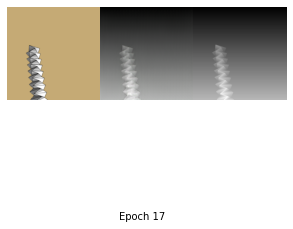

Epoch [18/50], Step [1/3750], D_loss: 0.2761, G_loss: 6.8241
Epoch [18/50], Step [2/3750], D_loss: 0.0681, G_loss: 6.5954
Epoch [18/50], Step [3/3750], D_loss: 0.2304, G_loss: 9.0902
Epoch [18/50], Step [4/3750], D_loss: 0.0176, G_loss: 10.8489
Epoch [18/50], Step [5/3750], D_loss: 0.2395, G_loss: 7.2910
Epoch [18/50], Step [6/3750], D_loss: 0.0519, G_loss: 7.6553
Epoch [18/50], Step [7/3750], D_loss: 0.1673, G_loss: 6.8357
Epoch [18/50], Step [8/3750], D_loss: 0.1707, G_loss: 8.7789
Epoch [18/50], Step [9/3750], D_loss: 0.2759, G_loss: 10.5004
Epoch [18/50], Step [10/3750], D_loss: 0.1082, G_loss: 10.9405
Epoch [18/50], Step [11/3750], D_loss: 0.0375, G_loss: 13.1970
Epoch [18/50], Step [12/3750], D_loss: 0.1718, G_loss: 4.7201
Epoch [18/50], Step [13/3750], D_loss: 0.0146, G_loss: 7.6383
Epoch [18/50], Step [14/3750], D_loss: 0.1275, G_loss: 5.4928
Epoch [18/50], Step [15/3750], D_loss: 0.0845, G_loss: 5.3831
Epoch [18/50], Step [16/3750], D_loss: 0.9117, G_loss: 3.5040
Epoch [18/50]

Epoch [18/50], Step [133/3750], D_loss: 0.0190, G_loss: 8.5458
Epoch [18/50], Step [134/3750], D_loss: 0.0149, G_loss: 10.4070
Epoch [18/50], Step [135/3750], D_loss: 0.3092, G_loss: 6.4667
Epoch [18/50], Step [136/3750], D_loss: 0.1858, G_loss: 9.3632
Epoch [18/50], Step [137/3750], D_loss: 0.0306, G_loss: 8.6355
Epoch [18/50], Step [138/3750], D_loss: 0.2082, G_loss: 5.8981
Epoch [18/50], Step [139/3750], D_loss: 0.0388, G_loss: 8.5031
Epoch [18/50], Step [140/3750], D_loss: 0.1747, G_loss: 6.7057
Epoch [18/50], Step [141/3750], D_loss: 0.1583, G_loss: 7.0141
Epoch [18/50], Step [142/3750], D_loss: 0.1932, G_loss: 9.6840
Epoch [18/50], Step [143/3750], D_loss: 0.0460, G_loss: 8.7667
Epoch [18/50], Step [144/3750], D_loss: 0.0170, G_loss: 12.4024
Epoch [18/50], Step [145/3750], D_loss: 0.0723, G_loss: 6.8234
Epoch [18/50], Step [146/3750], D_loss: 0.0165, G_loss: 16.9046
Epoch [18/50], Step [147/3750], D_loss: 0.0346, G_loss: 8.6350
Epoch [18/50], Step [148/3750], D_loss: 0.0523, G_lo

Epoch [18/50], Step [263/3750], D_loss: 0.0771, G_loss: 16.7946
Epoch [18/50], Step [264/3750], D_loss: 0.1766, G_loss: 5.7337
Epoch [18/50], Step [265/3750], D_loss: 0.0219, G_loss: 6.1135
Epoch [18/50], Step [266/3750], D_loss: 0.0615, G_loss: 12.2734
Epoch [18/50], Step [267/3750], D_loss: 0.0144, G_loss: 6.2706
Epoch [18/50], Step [268/3750], D_loss: 0.2308, G_loss: 7.1202
Epoch [18/50], Step [269/3750], D_loss: 0.0729, G_loss: 10.2253
Epoch [18/50], Step [270/3750], D_loss: 0.0643, G_loss: 7.1709
Epoch [18/50], Step [271/3750], D_loss: 0.0329, G_loss: 9.4683
Epoch [18/50], Step [272/3750], D_loss: 0.0955, G_loss: 6.5293
Epoch [18/50], Step [273/3750], D_loss: 0.0227, G_loss: 6.4822
Epoch [18/50], Step [274/3750], D_loss: 0.1193, G_loss: 10.8765
Epoch [18/50], Step [275/3750], D_loss: 0.0176, G_loss: 15.9382
Epoch [18/50], Step [276/3750], D_loss: 0.1581, G_loss: 7.4666
Epoch [18/50], Step [277/3750], D_loss: 0.0848, G_loss: 9.5905
Epoch [18/50], Step [278/3750], D_loss: 0.5390, G_

Epoch [18/50], Step [393/3750], D_loss: 0.1007, G_loss: 6.2212
Epoch [18/50], Step [394/3750], D_loss: 0.0150, G_loss: 7.7858
Epoch [18/50], Step [395/3750], D_loss: 0.1225, G_loss: 8.6777
Epoch [18/50], Step [396/3750], D_loss: 0.0232, G_loss: 8.1239
Epoch [18/50], Step [397/3750], D_loss: 0.0161, G_loss: 14.5705
Epoch [18/50], Step [398/3750], D_loss: 0.5980, G_loss: 3.7455
Epoch [18/50], Step [399/3750], D_loss: 0.4957, G_loss: 5.6295
Epoch [18/50], Step [400/3750], D_loss: 0.1019, G_loss: 6.8004
Epoch [18/50], Step [401/3750], D_loss: 0.0656, G_loss: 5.7366
Epoch [18/50], Step [402/3750], D_loss: 0.5118, G_loss: 8.5544
Epoch [18/50], Step [403/3750], D_loss: 0.0540, G_loss: 7.1403
Epoch [18/50], Step [404/3750], D_loss: 0.1669, G_loss: 14.5155
Epoch [18/50], Step [405/3750], D_loss: 0.1726, G_loss: 5.6122
Epoch [18/50], Step [406/3750], D_loss: 0.2006, G_loss: 10.2065
Epoch [18/50], Step [407/3750], D_loss: 0.1068, G_loss: 8.2942
Epoch [18/50], Step [408/3750], D_loss: 0.1702, G_lo

Epoch [18/50], Step [523/3750], D_loss: 0.2837, G_loss: 9.3425
Epoch [18/50], Step [524/3750], D_loss: 0.0118, G_loss: 7.6803
Epoch [18/50], Step [525/3750], D_loss: 0.0620, G_loss: 16.4259
Epoch [18/50], Step [526/3750], D_loss: 0.3459, G_loss: 5.4640
Epoch [18/50], Step [527/3750], D_loss: 0.6042, G_loss: 15.8633
Epoch [18/50], Step [528/3750], D_loss: 0.0858, G_loss: 6.0950
Epoch [18/50], Step [529/3750], D_loss: 0.0858, G_loss: 7.6878
Epoch [18/50], Step [530/3750], D_loss: 0.0384, G_loss: 6.6031
Epoch [18/50], Step [531/3750], D_loss: 0.0866, G_loss: 6.6925
Epoch [18/50], Step [532/3750], D_loss: 0.3279, G_loss: 10.0074
Epoch [18/50], Step [533/3750], D_loss: 0.0380, G_loss: 9.4608
Epoch [18/50], Step [534/3750], D_loss: 0.1269, G_loss: 9.1825
Epoch [18/50], Step [535/3750], D_loss: 0.0144, G_loss: 7.6681
Epoch [18/50], Step [536/3750], D_loss: 0.0908, G_loss: 8.0700
Epoch [18/50], Step [537/3750], D_loss: 0.1065, G_loss: 6.8239
Epoch [18/50], Step [538/3750], D_loss: 0.0350, G_lo

Epoch [18/50], Step [653/3750], D_loss: 0.0089, G_loss: 6.9734
Epoch [18/50], Step [654/3750], D_loss: 0.0558, G_loss: 10.8792
Epoch [18/50], Step [655/3750], D_loss: 0.1267, G_loss: 4.7458
Epoch [18/50], Step [656/3750], D_loss: 0.0200, G_loss: 9.6029
Epoch [18/50], Step [657/3750], D_loss: 0.0974, G_loss: 9.4888
Epoch [18/50], Step [658/3750], D_loss: 0.0698, G_loss: 5.6048
Epoch [18/50], Step [659/3750], D_loss: 0.0792, G_loss: 9.9751
Epoch [18/50], Step [660/3750], D_loss: 0.0092, G_loss: 16.8299
Epoch [18/50], Step [661/3750], D_loss: 0.5581, G_loss: 7.8630
Epoch [18/50], Step [662/3750], D_loss: 0.0201, G_loss: 7.4732
Epoch [18/50], Step [663/3750], D_loss: 0.2782, G_loss: 7.0063
Epoch [18/50], Step [664/3750], D_loss: 0.1968, G_loss: 11.5937
Epoch [18/50], Step [665/3750], D_loss: 0.0317, G_loss: 7.9357
Epoch [18/50], Step [666/3750], D_loss: 0.1286, G_loss: 6.3315
Epoch [18/50], Step [667/3750], D_loss: 0.0919, G_loss: 7.2480
Epoch [18/50], Step [668/3750], D_loss: 0.2561, G_lo

Epoch [18/50], Step [783/3750], D_loss: 0.4028, G_loss: 11.2614
Epoch [18/50], Step [784/3750], D_loss: 0.0284, G_loss: 6.1846
Epoch [18/50], Step [785/3750], D_loss: 0.2121, G_loss: 10.4980
Epoch [18/50], Step [786/3750], D_loss: 0.1033, G_loss: 12.7255
Epoch [18/50], Step [787/3750], D_loss: 0.1033, G_loss: 8.8272
Epoch [18/50], Step [788/3750], D_loss: 0.3119, G_loss: 4.4221
Epoch [18/50], Step [789/3750], D_loss: 0.0524, G_loss: 11.0835
Epoch [18/50], Step [790/3750], D_loss: 0.0161, G_loss: 7.9977
Epoch [18/50], Step [791/3750], D_loss: 0.0379, G_loss: 12.9624
Epoch [18/50], Step [792/3750], D_loss: 0.3436, G_loss: 5.4847
Epoch [18/50], Step [793/3750], D_loss: 0.0163, G_loss: 6.2694
Epoch [18/50], Step [794/3750], D_loss: 0.1625, G_loss: 5.5455
Epoch [18/50], Step [795/3750], D_loss: 0.2510, G_loss: 7.2611
Epoch [18/50], Step [796/3750], D_loss: 0.0252, G_loss: 13.1274
Epoch [18/50], Step [797/3750], D_loss: 0.0465, G_loss: 9.5143
Epoch [18/50], Step [798/3750], D_loss: 0.0174, G

Epoch [18/50], Step [913/3750], D_loss: 0.0181, G_loss: 9.3038
Epoch [18/50], Step [914/3750], D_loss: 0.0233, G_loss: 6.1834
Epoch [18/50], Step [915/3750], D_loss: 0.2816, G_loss: 13.9850
Epoch [18/50], Step [916/3750], D_loss: 0.0943, G_loss: 5.3849
Epoch [18/50], Step [917/3750], D_loss: 0.0573, G_loss: 9.7262
Epoch [18/50], Step [918/3750], D_loss: 0.0110, G_loss: 12.0296
Epoch [18/50], Step [919/3750], D_loss: 0.0229, G_loss: 13.3445
Epoch [18/50], Step [920/3750], D_loss: 0.0266, G_loss: 7.4980
Epoch [18/50], Step [921/3750], D_loss: 0.0302, G_loss: 6.4188
Epoch [18/50], Step [922/3750], D_loss: 0.0331, G_loss: 9.6646
Epoch [18/50], Step [923/3750], D_loss: 0.2418, G_loss: 13.5893
Epoch [18/50], Step [924/3750], D_loss: 0.0299, G_loss: 6.0781
Epoch [18/50], Step [925/3750], D_loss: 0.0338, G_loss: 6.4699
Epoch [18/50], Step [926/3750], D_loss: 0.0200, G_loss: 6.7337
Epoch [18/50], Step [927/3750], D_loss: 0.0117, G_loss: 10.1125
Epoch [18/50], Step [928/3750], D_loss: 0.0875, G_

Epoch [18/50], Step [1042/3750], D_loss: 0.2542, G_loss: 4.9224
Epoch [18/50], Step [1043/3750], D_loss: 0.0274, G_loss: 9.9563
Epoch [18/50], Step [1044/3750], D_loss: 0.3057, G_loss: 5.7956
Epoch [18/50], Step [1045/3750], D_loss: 0.0725, G_loss: 10.6573
Epoch [18/50], Step [1046/3750], D_loss: 0.1824, G_loss: 5.3680
Epoch [18/50], Step [1047/3750], D_loss: 0.2458, G_loss: 6.2424
Epoch [18/50], Step [1048/3750], D_loss: 0.1561, G_loss: 4.8729
Epoch [18/50], Step [1049/3750], D_loss: 0.0133, G_loss: 8.4470
Epoch [18/50], Step [1050/3750], D_loss: 0.1879, G_loss: 5.7424
Epoch [18/50], Step [1051/3750], D_loss: 0.0124, G_loss: 20.9131
Epoch [18/50], Step [1052/3750], D_loss: 0.3759, G_loss: 4.7704
Epoch [18/50], Step [1053/3750], D_loss: 0.0970, G_loss: 8.9463
Epoch [18/50], Step [1054/3750], D_loss: 0.1481, G_loss: 7.1002
Epoch [18/50], Step [1055/3750], D_loss: 0.0283, G_loss: 6.7360
Epoch [18/50], Step [1056/3750], D_loss: 0.0092, G_loss: 16.8207
Epoch [18/50], Step [1057/3750], D_lo

Epoch [18/50], Step [1170/3750], D_loss: 0.0356, G_loss: 12.3302
Epoch [18/50], Step [1171/3750], D_loss: 0.0679, G_loss: 9.5582
Epoch [18/50], Step [1172/3750], D_loss: 0.1015, G_loss: 10.0794
Epoch [18/50], Step [1173/3750], D_loss: 0.0730, G_loss: 7.9176
Epoch [18/50], Step [1174/3750], D_loss: 0.0153, G_loss: 9.7622
Epoch [18/50], Step [1175/3750], D_loss: 0.0178, G_loss: 13.9214
Epoch [18/50], Step [1176/3750], D_loss: 0.0276, G_loss: 9.1669
Epoch [18/50], Step [1177/3750], D_loss: 0.5051, G_loss: 3.1992
Epoch [18/50], Step [1178/3750], D_loss: 0.0669, G_loss: 8.2632
Epoch [18/50], Step [1179/3750], D_loss: 0.0671, G_loss: 14.5610
Epoch [18/50], Step [1180/3750], D_loss: 0.0309, G_loss: 10.2599
Epoch [18/50], Step [1181/3750], D_loss: 0.1126, G_loss: 5.1966
Epoch [18/50], Step [1182/3750], D_loss: 0.0188, G_loss: 10.9359
Epoch [18/50], Step [1183/3750], D_loss: 0.3736, G_loss: 6.8284
Epoch [18/50], Step [1184/3750], D_loss: 0.0336, G_loss: 16.7276
Epoch [18/50], Step [1185/3750], 

Epoch [18/50], Step [1298/3750], D_loss: 0.1065, G_loss: 9.0829
Epoch [18/50], Step [1299/3750], D_loss: 0.0870, G_loss: 7.8598
Epoch [18/50], Step [1300/3750], D_loss: 0.0224, G_loss: 6.7299
Epoch [18/50], Step [1301/3750], D_loss: 0.0221, G_loss: 6.6535
Epoch [18/50], Step [1302/3750], D_loss: 0.0879, G_loss: 9.8101
Epoch [18/50], Step [1303/3750], D_loss: 0.1327, G_loss: 5.9861
Epoch [18/50], Step [1304/3750], D_loss: 0.0622, G_loss: 10.1768
Epoch [18/50], Step [1305/3750], D_loss: 0.2102, G_loss: 6.4662
Epoch [18/50], Step [1306/3750], D_loss: 0.0142, G_loss: 11.0606
Epoch [18/50], Step [1307/3750], D_loss: 0.0121, G_loss: 9.5216
Epoch [18/50], Step [1308/3750], D_loss: 0.0876, G_loss: 9.7792
Epoch [18/50], Step [1309/3750], D_loss: 0.0122, G_loss: 9.5954
Epoch [18/50], Step [1310/3750], D_loss: 0.0387, G_loss: 9.7940
Epoch [18/50], Step [1311/3750], D_loss: 0.2710, G_loss: 6.8592
Epoch [18/50], Step [1312/3750], D_loss: 0.0569, G_loss: 6.8325
Epoch [18/50], Step [1313/3750], D_los

Epoch [18/50], Step [1426/3750], D_loss: 0.1007, G_loss: 10.0698
Epoch [18/50], Step [1427/3750], D_loss: 0.0785, G_loss: 29.6237
Epoch [18/50], Step [1428/3750], D_loss: 0.2334, G_loss: 6.0903
Epoch [18/50], Step [1429/3750], D_loss: 0.0359, G_loss: 9.1509
Epoch [18/50], Step [1430/3750], D_loss: 0.0569, G_loss: 6.9696
Epoch [18/50], Step [1431/3750], D_loss: 0.0157, G_loss: 8.4870
Epoch [18/50], Step [1432/3750], D_loss: 0.0437, G_loss: 6.1701
Epoch [18/50], Step [1433/3750], D_loss: 0.0702, G_loss: 5.7595
Epoch [18/50], Step [1434/3750], D_loss: 0.2790, G_loss: 5.3247
Epoch [18/50], Step [1435/3750], D_loss: 0.0741, G_loss: 13.4009
Epoch [18/50], Step [1436/3750], D_loss: 0.1015, G_loss: 8.1996
Epoch [18/50], Step [1437/3750], D_loss: 0.1231, G_loss: 9.1750
Epoch [18/50], Step [1438/3750], D_loss: 0.1062, G_loss: 8.8987
Epoch [18/50], Step [1439/3750], D_loss: 0.1623, G_loss: 7.6139
Epoch [18/50], Step [1440/3750], D_loss: 0.0541, G_loss: 19.9963
Epoch [18/50], Step [1441/3750], D_l

Epoch [18/50], Step [1554/3750], D_loss: 0.0284, G_loss: 11.6422
Epoch [18/50], Step [1555/3750], D_loss: 0.0527, G_loss: 12.2904
Epoch [18/50], Step [1556/3750], D_loss: 0.0926, G_loss: 12.9559
Epoch [18/50], Step [1557/3750], D_loss: 0.0084, G_loss: 10.3700
Epoch [18/50], Step [1558/3750], D_loss: 0.4695, G_loss: 4.5204
Epoch [18/50], Step [1559/3750], D_loss: 0.0624, G_loss: 9.1973
Epoch [18/50], Step [1560/3750], D_loss: 0.0691, G_loss: 7.1059
Epoch [18/50], Step [1561/3750], D_loss: 0.0187, G_loss: 13.2738
Epoch [18/50], Step [1562/3750], D_loss: 0.2921, G_loss: 5.0900
Epoch [18/50], Step [1563/3750], D_loss: 0.0681, G_loss: 9.3157
Epoch [18/50], Step [1564/3750], D_loss: 0.0171, G_loss: 12.7536
Epoch [18/50], Step [1565/3750], D_loss: 0.1954, G_loss: 7.6427
Epoch [18/50], Step [1566/3750], D_loss: 0.0149, G_loss: 9.8258
Epoch [18/50], Step [1567/3750], D_loss: 0.0083, G_loss: 8.9955
Epoch [18/50], Step [1568/3750], D_loss: 0.0148, G_loss: 7.7156
Epoch [18/50], Step [1569/3750], D

Epoch [18/50], Step [1682/3750], D_loss: 0.0913, G_loss: 8.5816
Epoch [18/50], Step [1683/3750], D_loss: 0.0384, G_loss: 5.8354
Epoch [18/50], Step [1684/3750], D_loss: 0.0941, G_loss: 8.3271
Epoch [18/50], Step [1685/3750], D_loss: 0.0283, G_loss: 11.6079
Epoch [18/50], Step [1686/3750], D_loss: 0.0356, G_loss: 6.8371
Epoch [18/50], Step [1687/3750], D_loss: 0.0096, G_loss: 8.5802
Epoch [18/50], Step [1688/3750], D_loss: 0.0055, G_loss: 15.9613
Epoch [18/50], Step [1689/3750], D_loss: 0.0584, G_loss: 12.4380
Epoch [18/50], Step [1690/3750], D_loss: 0.1670, G_loss: 4.8347
Epoch [18/50], Step [1691/3750], D_loss: 0.0137, G_loss: 7.1370
Epoch [18/50], Step [1692/3750], D_loss: 0.0310, G_loss: 7.3076
Epoch [18/50], Step [1693/3750], D_loss: 0.0359, G_loss: 7.7257
Epoch [18/50], Step [1694/3750], D_loss: 0.0656, G_loss: 12.4305
Epoch [18/50], Step [1695/3750], D_loss: 0.0250, G_loss: 9.1293
Epoch [18/50], Step [1696/3750], D_loss: 0.1710, G_loss: 11.7765
Epoch [18/50], Step [1697/3750], D_

Epoch [18/50], Step [1810/3750], D_loss: 0.0821, G_loss: 17.0387
Epoch [18/50], Step [1811/3750], D_loss: 0.1280, G_loss: 5.9353
Epoch [18/50], Step [1812/3750], D_loss: 0.4737, G_loss: 9.7959
Epoch [18/50], Step [1813/3750], D_loss: 0.0432, G_loss: 5.8806
Epoch [18/50], Step [1814/3750], D_loss: 0.1646, G_loss: 7.4475
Epoch [18/50], Step [1815/3750], D_loss: 0.1228, G_loss: 8.0471
Epoch [18/50], Step [1816/3750], D_loss: 0.0079, G_loss: 10.3773
Epoch [18/50], Step [1817/3750], D_loss: 0.7300, G_loss: 7.0935
Epoch [18/50], Step [1818/3750], D_loss: 0.0473, G_loss: 9.0392
Epoch [18/50], Step [1819/3750], D_loss: 0.3020, G_loss: 8.2538
Epoch [18/50], Step [1820/3750], D_loss: 0.0201, G_loss: 12.7061
Epoch [18/50], Step [1821/3750], D_loss: 0.3787, G_loss: 9.5371
Epoch [18/50], Step [1822/3750], D_loss: 0.0783, G_loss: 13.4634
Epoch [18/50], Step [1823/3750], D_loss: 0.0664, G_loss: 9.0414
Epoch [18/50], Step [1824/3750], D_loss: 0.0665, G_loss: 8.7055
Epoch [18/50], Step [1825/3750], D_l

Epoch [18/50], Step [1938/3750], D_loss: 0.0146, G_loss: 9.9878
Epoch [18/50], Step [1939/3750], D_loss: 0.0598, G_loss: 6.4768
Epoch [18/50], Step [1940/3750], D_loss: 0.1363, G_loss: 22.3749
Epoch [18/50], Step [1941/3750], D_loss: 0.0094, G_loss: 10.9714
Epoch [18/50], Step [1942/3750], D_loss: 0.0307, G_loss: 12.7252
Epoch [18/50], Step [1943/3750], D_loss: 0.0658, G_loss: 7.8915
Epoch [18/50], Step [1944/3750], D_loss: 0.4430, G_loss: 6.7735
Epoch [18/50], Step [1945/3750], D_loss: 0.3809, G_loss: 5.4400
Epoch [18/50], Step [1946/3750], D_loss: 0.0234, G_loss: 6.9973
Epoch [18/50], Step [1947/3750], D_loss: 0.0963, G_loss: 11.7270
Epoch [18/50], Step [1948/3750], D_loss: 0.0430, G_loss: 10.4542
Epoch [18/50], Step [1949/3750], D_loss: 0.1140, G_loss: 12.6495
Epoch [18/50], Step [1950/3750], D_loss: 0.0366, G_loss: 5.4748
Epoch [18/50], Step [1951/3750], D_loss: 0.5876, G_loss: 4.1667
Epoch [18/50], Step [1952/3750], D_loss: 0.5442, G_loss: 7.9013
Epoch [18/50], Step [1953/3750], D

Epoch [18/50], Step [2066/3750], D_loss: 0.0115, G_loss: 12.4076
Epoch [18/50], Step [2067/3750], D_loss: 0.1177, G_loss: 24.2411
Epoch [18/50], Step [2068/3750], D_loss: 0.0188, G_loss: 12.1646
Epoch [18/50], Step [2069/3750], D_loss: 0.0693, G_loss: 8.8409
Epoch [18/50], Step [2070/3750], D_loss: 0.0034, G_loss: 10.1165
Epoch [18/50], Step [2071/3750], D_loss: 0.1080, G_loss: 7.0168
Epoch [18/50], Step [2072/3750], D_loss: 0.1614, G_loss: 5.2124
Epoch [18/50], Step [2073/3750], D_loss: 0.0180, G_loss: 8.4139
Epoch [18/50], Step [2074/3750], D_loss: 0.1794, G_loss: 7.5710
Epoch [18/50], Step [2075/3750], D_loss: 0.0076, G_loss: 11.5582
Epoch [18/50], Step [2076/3750], D_loss: 0.2271, G_loss: 21.5576
Epoch [18/50], Step [2077/3750], D_loss: 0.0104, G_loss: 14.5668
Epoch [18/50], Step [2078/3750], D_loss: 0.0205, G_loss: 13.2055
Epoch [18/50], Step [2079/3750], D_loss: 0.0223, G_loss: 8.6801
Epoch [18/50], Step [2080/3750], D_loss: 0.0136, G_loss: 7.3881
Epoch [18/50], Step [2081/3750],

Epoch [18/50], Step [2194/3750], D_loss: 0.0952, G_loss: 11.7051
Epoch [18/50], Step [2195/3750], D_loss: 0.0667, G_loss: 7.7876
Epoch [18/50], Step [2196/3750], D_loss: 0.3096, G_loss: 7.6849
Epoch [18/50], Step [2197/3750], D_loss: 0.4149, G_loss: 6.6194
Epoch [18/50], Step [2198/3750], D_loss: 0.1257, G_loss: 9.2171
Epoch [18/50], Step [2199/3750], D_loss: 0.4314, G_loss: 6.0077
Epoch [18/50], Step [2200/3750], D_loss: 0.1267, G_loss: 13.0617
Epoch [18/50], Step [2201/3750], D_loss: 0.2241, G_loss: 5.1505
Epoch [18/50], Step [2202/3750], D_loss: 0.3069, G_loss: 8.2989
Epoch [18/50], Step [2203/3750], D_loss: 0.0682, G_loss: 9.8820
Epoch [18/50], Step [2204/3750], D_loss: 0.2593, G_loss: 7.7044
Epoch [18/50], Step [2205/3750], D_loss: 0.0770, G_loss: 8.6525
Epoch [18/50], Step [2206/3750], D_loss: 0.0935, G_loss: 7.2505
Epoch [18/50], Step [2207/3750], D_loss: 0.6732, G_loss: 7.0368
Epoch [18/50], Step [2208/3750], D_loss: 0.2330, G_loss: 13.5183
Epoch [18/50], Step [2209/3750], D_lo

Epoch [18/50], Step [2322/3750], D_loss: 0.0488, G_loss: 6.8467
Epoch [18/50], Step [2323/3750], D_loss: 0.0752, G_loss: 9.5070
Epoch [18/50], Step [2324/3750], D_loss: 0.0606, G_loss: 9.8537
Epoch [18/50], Step [2325/3750], D_loss: 0.1731, G_loss: 7.7013
Epoch [18/50], Step [2326/3750], D_loss: 0.9900, G_loss: 5.5350
Epoch [18/50], Step [2327/3750], D_loss: 0.0684, G_loss: 5.1355
Epoch [18/50], Step [2328/3750], D_loss: 0.1412, G_loss: 8.0593
Epoch [18/50], Step [2329/3750], D_loss: 0.5336, G_loss: 6.6599
Epoch [18/50], Step [2330/3750], D_loss: 0.0324, G_loss: 8.4385
Epoch [18/50], Step [2331/3750], D_loss: 0.8664, G_loss: 11.1124
Epoch [18/50], Step [2332/3750], D_loss: 1.2103, G_loss: 5.1232
Epoch [18/50], Step [2333/3750], D_loss: 0.1050, G_loss: 5.9935
Epoch [18/50], Step [2334/3750], D_loss: 0.2440, G_loss: 5.9428
Epoch [18/50], Step [2335/3750], D_loss: 0.0383, G_loss: 7.2676
Epoch [18/50], Step [2336/3750], D_loss: 0.3633, G_loss: 6.2438
Epoch [18/50], Step [2337/3750], D_loss

Epoch [18/50], Step [2450/3750], D_loss: 0.1473, G_loss: 9.7726
Epoch [18/50], Step [2451/3750], D_loss: 0.0388, G_loss: 8.3542
Epoch [18/50], Step [2452/3750], D_loss: 0.2050, G_loss: 6.1017
Epoch [18/50], Step [2453/3750], D_loss: 0.3846, G_loss: 9.3760
Epoch [18/50], Step [2454/3750], D_loss: 0.1157, G_loss: 5.3551
Epoch [18/50], Step [2455/3750], D_loss: 0.3331, G_loss: 8.2062
Epoch [18/50], Step [2456/3750], D_loss: 0.0117, G_loss: 9.4435
Epoch [18/50], Step [2457/3750], D_loss: 0.0068, G_loss: 7.6791
Epoch [18/50], Step [2458/3750], D_loss: 0.0123, G_loss: 12.9160
Epoch [18/50], Step [2459/3750], D_loss: 0.0866, G_loss: 7.6425
Epoch [18/50], Step [2460/3750], D_loss: 0.1216, G_loss: 9.8963
Epoch [18/50], Step [2461/3750], D_loss: 0.1212, G_loss: 6.7887
Epoch [18/50], Step [2462/3750], D_loss: 0.4164, G_loss: 14.2469
Epoch [18/50], Step [2463/3750], D_loss: 0.1400, G_loss: 5.4138
Epoch [18/50], Step [2464/3750], D_loss: 0.2097, G_loss: 16.7237
Epoch [18/50], Step [2465/3750], D_lo

Epoch [18/50], Step [2578/3750], D_loss: 0.0413, G_loss: 7.7686
Epoch [18/50], Step [2579/3750], D_loss: 0.0798, G_loss: 8.7800
Epoch [18/50], Step [2580/3750], D_loss: 0.0077, G_loss: 11.4648
Epoch [18/50], Step [2581/3750], D_loss: 0.0196, G_loss: 8.7126
Epoch [18/50], Step [2582/3750], D_loss: 0.3875, G_loss: 7.0177
Epoch [18/50], Step [2583/3750], D_loss: 0.0447, G_loss: 4.8787
Epoch [18/50], Step [2584/3750], D_loss: 0.0266, G_loss: 10.9804
Epoch [18/50], Step [2585/3750], D_loss: 0.1405, G_loss: 8.5704
Epoch [18/50], Step [2586/3750], D_loss: 0.0131, G_loss: 14.6422
Epoch [18/50], Step [2587/3750], D_loss: 0.0155, G_loss: 13.2395
Epoch [18/50], Step [2588/3750], D_loss: 0.0167, G_loss: 16.1715
Epoch [18/50], Step [2589/3750], D_loss: 0.0813, G_loss: 6.9950
Epoch [18/50], Step [2590/3750], D_loss: 0.0190, G_loss: 17.3398
Epoch [18/50], Step [2591/3750], D_loss: 0.0492, G_loss: 7.2822
Epoch [18/50], Step [2592/3750], D_loss: 0.0683, G_loss: 6.2469
Epoch [18/50], Step [2593/3750], D

Epoch [18/50], Step [2706/3750], D_loss: 0.2679, G_loss: 6.9428
Epoch [18/50], Step [2707/3750], D_loss: 0.0264, G_loss: 7.3306
Epoch [18/50], Step [2708/3750], D_loss: 0.0179, G_loss: 12.5627
Epoch [18/50], Step [2709/3750], D_loss: 0.2902, G_loss: 6.7734
Epoch [18/50], Step [2710/3750], D_loss: 0.0282, G_loss: 12.6854
Epoch [18/50], Step [2711/3750], D_loss: 0.2922, G_loss: 5.3637
Epoch [18/50], Step [2712/3750], D_loss: 0.0461, G_loss: 7.5317
Epoch [18/50], Step [2713/3750], D_loss: 0.1842, G_loss: 6.9921
Epoch [18/50], Step [2714/3750], D_loss: 0.0664, G_loss: 10.8956
Epoch [18/50], Step [2715/3750], D_loss: 0.2833, G_loss: 7.7763
Epoch [18/50], Step [2716/3750], D_loss: 0.0299, G_loss: 7.7681
Epoch [18/50], Step [2717/3750], D_loss: 0.1210, G_loss: 4.8414
Epoch [18/50], Step [2718/3750], D_loss: 0.0110, G_loss: 9.5640
Epoch [18/50], Step [2719/3750], D_loss: 0.2492, G_loss: 10.5907
Epoch [18/50], Step [2720/3750], D_loss: 0.2298, G_loss: 3.7978
Epoch [18/50], Step [2721/3750], D_l

Epoch [18/50], Step [2834/3750], D_loss: 0.2992, G_loss: 9.7638
Epoch [18/50], Step [2835/3750], D_loss: 0.1034, G_loss: 6.2814
Epoch [18/50], Step [2836/3750], D_loss: 0.2165, G_loss: 6.9787
Epoch [18/50], Step [2837/3750], D_loss: 0.3361, G_loss: 9.5106
Epoch [18/50], Step [2838/3750], D_loss: 0.0312, G_loss: 12.0177
Epoch [18/50], Step [2839/3750], D_loss: 0.2048, G_loss: 12.0296
Epoch [18/50], Step [2840/3750], D_loss: 0.0275, G_loss: 7.4113
Epoch [18/50], Step [2841/3750], D_loss: 0.0390, G_loss: 11.3758
Epoch [18/50], Step [2842/3750], D_loss: 0.3640, G_loss: 6.6908
Epoch [18/50], Step [2843/3750], D_loss: 0.0159, G_loss: 5.3392
Epoch [18/50], Step [2844/3750], D_loss: 0.0850, G_loss: 8.2098
Epoch [18/50], Step [2845/3750], D_loss: 0.0239, G_loss: 10.2218
Epoch [18/50], Step [2846/3750], D_loss: 0.0111, G_loss: 5.7559
Epoch [18/50], Step [2847/3750], D_loss: 0.0460, G_loss: 9.8102
Epoch [18/50], Step [2848/3750], D_loss: 0.0769, G_loss: 5.6511
Epoch [18/50], Step [2849/3750], D_l

Epoch [18/50], Step [2962/3750], D_loss: 0.1565, G_loss: 6.0555
Epoch [18/50], Step [2963/3750], D_loss: 0.0265, G_loss: 8.8987
Epoch [18/50], Step [2964/3750], D_loss: 0.3080, G_loss: 9.1459
Epoch [18/50], Step [2965/3750], D_loss: 0.1747, G_loss: 10.6922
Epoch [18/50], Step [2966/3750], D_loss: 0.2412, G_loss: 9.9141
Epoch [18/50], Step [2967/3750], D_loss: 0.0220, G_loss: 6.6743
Epoch [18/50], Step [2968/3750], D_loss: 0.1146, G_loss: 5.2197
Epoch [18/50], Step [2969/3750], D_loss: 0.1175, G_loss: 6.4320
Epoch [18/50], Step [2970/3750], D_loss: 0.2446, G_loss: 6.0472
Epoch [18/50], Step [2971/3750], D_loss: 0.1663, G_loss: 5.6510
Epoch [18/50], Step [2972/3750], D_loss: 0.3168, G_loss: 8.3069
Epoch [18/50], Step [2973/3750], D_loss: 0.0826, G_loss: 7.9299
Epoch [18/50], Step [2974/3750], D_loss: 0.0381, G_loss: 5.9403
Epoch [18/50], Step [2975/3750], D_loss: 0.0959, G_loss: 23.3240
Epoch [18/50], Step [2976/3750], D_loss: 0.0637, G_loss: 10.9481
Epoch [18/50], Step [2977/3750], D_lo

Epoch [18/50], Step [3090/3750], D_loss: 0.0142, G_loss: 9.5023
Epoch [18/50], Step [3091/3750], D_loss: 0.3375, G_loss: 7.2232
Epoch [18/50], Step [3092/3750], D_loss: 0.0985, G_loss: 10.9300
Epoch [18/50], Step [3093/3750], D_loss: 0.0477, G_loss: 11.3878
Epoch [18/50], Step [3094/3750], D_loss: 0.0082, G_loss: 6.7839
Epoch [18/50], Step [3095/3750], D_loss: 0.0219, G_loss: 10.2934
Epoch [18/50], Step [3096/3750], D_loss: 0.0248, G_loss: 7.1882
Epoch [18/50], Step [3097/3750], D_loss: 0.2924, G_loss: 8.0955
Epoch [18/50], Step [3098/3750], D_loss: 0.0386, G_loss: 6.5615
Epoch [18/50], Step [3099/3750], D_loss: 0.0490, G_loss: 9.4645
Epoch [18/50], Step [3100/3750], D_loss: 0.0144, G_loss: 8.1462
Epoch [18/50], Step [3101/3750], D_loss: 0.0096, G_loss: 7.2291
Epoch [18/50], Step [3102/3750], D_loss: 0.1467, G_loss: 13.8670
Epoch [18/50], Step [3103/3750], D_loss: 0.1271, G_loss: 6.8667
Epoch [18/50], Step [3104/3750], D_loss: 0.0691, G_loss: 7.6420
Epoch [18/50], Step [3105/3750], D_l

Epoch [18/50], Step [3218/3750], D_loss: 0.0344, G_loss: 7.2320
Epoch [18/50], Step [3219/3750], D_loss: 0.1329, G_loss: 8.4331
Epoch [18/50], Step [3220/3750], D_loss: 0.1226, G_loss: 5.9829
Epoch [18/50], Step [3221/3750], D_loss: 0.0728, G_loss: 8.0494
Epoch [18/50], Step [3222/3750], D_loss: 0.0572, G_loss: 5.9130
Epoch [18/50], Step [3223/3750], D_loss: 0.0642, G_loss: 4.8694
Epoch [18/50], Step [3224/3750], D_loss: 0.0253, G_loss: 10.3458
Epoch [18/50], Step [3225/3750], D_loss: 0.0615, G_loss: 10.1838
Epoch [18/50], Step [3226/3750], D_loss: 0.0285, G_loss: 6.2267
Epoch [18/50], Step [3227/3750], D_loss: 0.0203, G_loss: 8.5933
Epoch [18/50], Step [3228/3750], D_loss: 0.0404, G_loss: 7.8191
Epoch [18/50], Step [3229/3750], D_loss: 0.8541, G_loss: 7.2356
Epoch [18/50], Step [3230/3750], D_loss: 0.0211, G_loss: 9.3229
Epoch [18/50], Step [3231/3750], D_loss: 0.0722, G_loss: 7.3239
Epoch [18/50], Step [3232/3750], D_loss: 0.1358, G_loss: 5.4100
Epoch [18/50], Step [3233/3750], D_los

Epoch [18/50], Step [3346/3750], D_loss: 0.1851, G_loss: 9.0022
Epoch [18/50], Step [3347/3750], D_loss: 0.0191, G_loss: 7.0881
Epoch [18/50], Step [3348/3750], D_loss: 0.0642, G_loss: 12.8483
Epoch [18/50], Step [3349/3750], D_loss: 0.0387, G_loss: 12.1966
Epoch [18/50], Step [3350/3750], D_loss: 0.0699, G_loss: 6.5308
Epoch [18/50], Step [3351/3750], D_loss: 0.2872, G_loss: 4.9236
Epoch [18/50], Step [3352/3750], D_loss: 0.0432, G_loss: 5.9408
Epoch [18/50], Step [3353/3750], D_loss: 0.0475, G_loss: 6.9648
Epoch [18/50], Step [3354/3750], D_loss: 0.2005, G_loss: 11.0454
Epoch [18/50], Step [3355/3750], D_loss: 0.0191, G_loss: 17.6934
Epoch [18/50], Step [3356/3750], D_loss: 0.0452, G_loss: 5.5289
Epoch [18/50], Step [3357/3750], D_loss: 0.0101, G_loss: 11.3482
Epoch [18/50], Step [3358/3750], D_loss: 0.1516, G_loss: 6.1950
Epoch [18/50], Step [3359/3750], D_loss: 0.0893, G_loss: 5.4707
Epoch [18/50], Step [3360/3750], D_loss: 0.0079, G_loss: 8.0757
Epoch [18/50], Step [3361/3750], D_

Epoch [18/50], Step [3474/3750], D_loss: 0.1154, G_loss: 9.0512
Epoch [18/50], Step [3475/3750], D_loss: 0.0440, G_loss: 5.8188
Epoch [18/50], Step [3476/3750], D_loss: 0.0734, G_loss: 27.4613
Epoch [18/50], Step [3477/3750], D_loss: 0.0312, G_loss: 8.2821
Epoch [18/50], Step [3478/3750], D_loss: 0.0450, G_loss: 6.7797
Epoch [18/50], Step [3479/3750], D_loss: 0.0951, G_loss: 17.1468
Epoch [18/50], Step [3480/3750], D_loss: 0.2997, G_loss: 18.0682
Epoch [18/50], Step [3481/3750], D_loss: 0.1337, G_loss: 5.7455
Epoch [18/50], Step [3482/3750], D_loss: 0.3079, G_loss: 6.2142
Epoch [18/50], Step [3483/3750], D_loss: 0.0317, G_loss: 9.8555
Epoch [18/50], Step [3484/3750], D_loss: 0.0120, G_loss: 18.9274
Epoch [18/50], Step [3485/3750], D_loss: 0.2664, G_loss: 5.8209
Epoch [18/50], Step [3486/3750], D_loss: 0.0717, G_loss: 9.4770
Epoch [18/50], Step [3487/3750], D_loss: 1.1075, G_loss: 6.9213
Epoch [18/50], Step [3488/3750], D_loss: 0.0488, G_loss: 13.1894
Epoch [18/50], Step [3489/3750], D_

Epoch [18/50], Step [3602/3750], D_loss: 1.0783, G_loss: 11.1618
Epoch [18/50], Step [3603/3750], D_loss: 0.2564, G_loss: 5.3618
Epoch [18/50], Step [3604/3750], D_loss: 0.6785, G_loss: 7.6680
Epoch [18/50], Step [3605/3750], D_loss: 0.6496, G_loss: 6.7790
Epoch [18/50], Step [3606/3750], D_loss: 0.1795, G_loss: 9.2721
Epoch [18/50], Step [3607/3750], D_loss: 0.1843, G_loss: 14.1922
Epoch [18/50], Step [3608/3750], D_loss: 0.2383, G_loss: 14.2247
Epoch [18/50], Step [3609/3750], D_loss: 0.1769, G_loss: 7.6548
Epoch [18/50], Step [3610/3750], D_loss: 0.1395, G_loss: 12.7659
Epoch [18/50], Step [3611/3750], D_loss: 0.3594, G_loss: 10.1893
Epoch [18/50], Step [3612/3750], D_loss: 0.2008, G_loss: 8.9861
Epoch [18/50], Step [3613/3750], D_loss: 0.0799, G_loss: 12.9546
Epoch [18/50], Step [3614/3750], D_loss: 0.4287, G_loss: 6.7647
Epoch [18/50], Step [3615/3750], D_loss: 0.0655, G_loss: 9.7227
Epoch [18/50], Step [3616/3750], D_loss: 0.0844, G_loss: 21.7669
Epoch [18/50], Step [3617/3750], 

Epoch [18/50], Step [3730/3750], D_loss: 0.0702, G_loss: 15.8569
Epoch [18/50], Step [3731/3750], D_loss: 0.1021, G_loss: 7.1265
Epoch [18/50], Step [3732/3750], D_loss: 0.0065, G_loss: 7.0608
Epoch [18/50], Step [3733/3750], D_loss: 0.0146, G_loss: 8.1587
Epoch [18/50], Step [3734/3750], D_loss: 0.0643, G_loss: 6.6422
Epoch [18/50], Step [3735/3750], D_loss: 0.2516, G_loss: 7.1528
Epoch [18/50], Step [3736/3750], D_loss: 0.1243, G_loss: 8.1136
Epoch [18/50], Step [3737/3750], D_loss: 0.0244, G_loss: 10.1806
Epoch [18/50], Step [3738/3750], D_loss: 0.3352, G_loss: 6.6470
Epoch [18/50], Step [3739/3750], D_loss: 0.1807, G_loss: 7.7913
Epoch [18/50], Step [3740/3750], D_loss: 0.1038, G_loss: 9.8203
Epoch [18/50], Step [3741/3750], D_loss: 0.0171, G_loss: 9.2383
Epoch [18/50], Step [3742/3750], D_loss: 0.1785, G_loss: 7.1431
Epoch [18/50], Step [3743/3750], D_loss: 0.0680, G_loss: 13.6356
Epoch [18/50], Step [3744/3750], D_loss: 0.1090, G_loss: 8.3239
Epoch [18/50], Step [3745/3750], D_lo

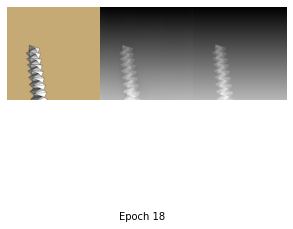

Epoch [19/50], Step [1/3750], D_loss: 0.0157, G_loss: 10.3032
Epoch [19/50], Step [2/3750], D_loss: 0.0171, G_loss: 6.6285
Epoch [19/50], Step [3/3750], D_loss: 0.1293, G_loss: 7.3424
Epoch [19/50], Step [4/3750], D_loss: 0.0229, G_loss: 6.0653
Epoch [19/50], Step [5/3750], D_loss: 0.0586, G_loss: 12.4732
Epoch [19/50], Step [6/3750], D_loss: 0.0293, G_loss: 9.0154
Epoch [19/50], Step [7/3750], D_loss: 0.0106, G_loss: 12.4475
Epoch [19/50], Step [8/3750], D_loss: 0.2351, G_loss: 5.9746
Epoch [19/50], Step [9/3750], D_loss: 0.2223, G_loss: 7.3576
Epoch [19/50], Step [10/3750], D_loss: 0.0331, G_loss: 10.8199
Epoch [19/50], Step [11/3750], D_loss: 0.0444, G_loss: 7.5724
Epoch [19/50], Step [12/3750], D_loss: 0.0633, G_loss: 9.3213
Epoch [19/50], Step [13/3750], D_loss: 0.1359, G_loss: 13.4365
Epoch [19/50], Step [14/3750], D_loss: 0.0410, G_loss: 7.2775
Epoch [19/50], Step [15/3750], D_loss: 0.2112, G_loss: 8.4071
Epoch [19/50], Step [16/3750], D_loss: 0.0252, G_loss: 7.6474
Epoch [19/50

Epoch [19/50], Step [133/3750], D_loss: 0.1611, G_loss: 5.8568
Epoch [19/50], Step [134/3750], D_loss: 0.0471, G_loss: 7.4463
Epoch [19/50], Step [135/3750], D_loss: 0.1873, G_loss: 7.3615
Epoch [19/50], Step [136/3750], D_loss: 0.1824, G_loss: 7.0856
Epoch [19/50], Step [137/3750], D_loss: 0.3906, G_loss: 7.5698
Epoch [19/50], Step [138/3750], D_loss: 0.0200, G_loss: 6.1147
Epoch [19/50], Step [139/3750], D_loss: 0.1023, G_loss: 5.4721
Epoch [19/50], Step [140/3750], D_loss: 0.1148, G_loss: 6.2322
Epoch [19/50], Step [141/3750], D_loss: 0.0725, G_loss: 11.4021
Epoch [19/50], Step [142/3750], D_loss: 0.5233, G_loss: 4.6577
Epoch [19/50], Step [143/3750], D_loss: 0.1117, G_loss: 5.6865
Epoch [19/50], Step [144/3750], D_loss: 0.1287, G_loss: 6.7056
Epoch [19/50], Step [145/3750], D_loss: 0.0621, G_loss: 7.1409
Epoch [19/50], Step [146/3750], D_loss: 0.0085, G_loss: 17.2759
Epoch [19/50], Step [147/3750], D_loss: 0.0272, G_loss: 14.4817
Epoch [19/50], Step [148/3750], D_loss: 0.0302, G_lo

Epoch [19/50], Step [263/3750], D_loss: 0.2472, G_loss: 7.4842
Epoch [19/50], Step [264/3750], D_loss: 0.1293, G_loss: 6.4005
Epoch [19/50], Step [265/3750], D_loss: 0.0156, G_loss: 11.7159
Epoch [19/50], Step [266/3750], D_loss: 0.2455, G_loss: 6.3491
Epoch [19/50], Step [267/3750], D_loss: 0.1178, G_loss: 8.0196
Epoch [19/50], Step [268/3750], D_loss: 0.0546, G_loss: 13.3229
Epoch [19/50], Step [269/3750], D_loss: 0.0215, G_loss: 8.5427
Epoch [19/50], Step [270/3750], D_loss: 0.1797, G_loss: 6.3974
Epoch [19/50], Step [271/3750], D_loss: 0.0424, G_loss: 5.1447
Epoch [19/50], Step [272/3750], D_loss: 0.0472, G_loss: 10.7656
Epoch [19/50], Step [273/3750], D_loss: 0.0262, G_loss: 6.1248
Epoch [19/50], Step [274/3750], D_loss: 0.0397, G_loss: 9.1747
Epoch [19/50], Step [275/3750], D_loss: 0.0300, G_loss: 9.7771
Epoch [19/50], Step [276/3750], D_loss: 0.0112, G_loss: 5.7859
Epoch [19/50], Step [277/3750], D_loss: 0.2062, G_loss: 9.7954
Epoch [19/50], Step [278/3750], D_loss: 0.0322, G_lo

Epoch [19/50], Step [393/3750], D_loss: 0.0503, G_loss: 8.6588
Epoch [19/50], Step [394/3750], D_loss: 0.1572, G_loss: 6.5515
Epoch [19/50], Step [395/3750], D_loss: 0.0177, G_loss: 10.0262
Epoch [19/50], Step [396/3750], D_loss: 0.0211, G_loss: 7.1226
Epoch [19/50], Step [397/3750], D_loss: 0.0343, G_loss: 9.9241
Epoch [19/50], Step [398/3750], D_loss: 0.0237, G_loss: 5.9723
Epoch [19/50], Step [399/3750], D_loss: 0.3535, G_loss: 6.6395
Epoch [19/50], Step [400/3750], D_loss: 0.0112, G_loss: 8.5780
Epoch [19/50], Step [401/3750], D_loss: 0.0162, G_loss: 8.5136
Epoch [19/50], Step [402/3750], D_loss: 0.0076, G_loss: 14.5379
Epoch [19/50], Step [403/3750], D_loss: 0.2197, G_loss: 10.2525
Epoch [19/50], Step [404/3750], D_loss: 0.0441, G_loss: 7.0824
Epoch [19/50], Step [405/3750], D_loss: 0.0043, G_loss: 10.0497
Epoch [19/50], Step [406/3750], D_loss: 0.2225, G_loss: 7.3914
Epoch [19/50], Step [407/3750], D_loss: 0.0146, G_loss: 14.0534
Epoch [19/50], Step [408/3750], D_loss: 0.0113, G_

Epoch [19/50], Step [523/3750], D_loss: 0.0837, G_loss: 5.7321
Epoch [19/50], Step [524/3750], D_loss: 0.1689, G_loss: 23.9583
Epoch [19/50], Step [525/3750], D_loss: 0.0394, G_loss: 7.5119
Epoch [19/50], Step [526/3750], D_loss: 0.0279, G_loss: 8.8299
Epoch [19/50], Step [527/3750], D_loss: 0.0162, G_loss: 11.8984
Epoch [19/50], Step [528/3750], D_loss: 0.1443, G_loss: 6.9162
Epoch [19/50], Step [529/3750], D_loss: 0.0630, G_loss: 9.6762
Epoch [19/50], Step [530/3750], D_loss: 0.1872, G_loss: 10.0663
Epoch [19/50], Step [531/3750], D_loss: 0.1296, G_loss: 7.1018
Epoch [19/50], Step [532/3750], D_loss: 0.0167, G_loss: 14.6931
Epoch [19/50], Step [533/3750], D_loss: 0.0513, G_loss: 9.0971
Epoch [19/50], Step [534/3750], D_loss: 0.0852, G_loss: 6.4002
Epoch [19/50], Step [535/3750], D_loss: 0.0918, G_loss: 7.3700
Epoch [19/50], Step [536/3750], D_loss: 0.2885, G_loss: 7.4424
Epoch [19/50], Step [537/3750], D_loss: 0.0884, G_loss: 7.2535
Epoch [19/50], Step [538/3750], D_loss: 0.0514, G_l

Epoch [19/50], Step [653/3750], D_loss: 0.1728, G_loss: 4.8652
Epoch [19/50], Step [654/3750], D_loss: 0.1546, G_loss: 7.0467
Epoch [19/50], Step [655/3750], D_loss: 0.1327, G_loss: 7.1673
Epoch [19/50], Step [656/3750], D_loss: 0.0393, G_loss: 14.4631
Epoch [19/50], Step [657/3750], D_loss: 0.2823, G_loss: 4.8752
Epoch [19/50], Step [658/3750], D_loss: 0.7570, G_loss: 6.4513
Epoch [19/50], Step [659/3750], D_loss: 0.2791, G_loss: 5.8299
Epoch [19/50], Step [660/3750], D_loss: 0.0640, G_loss: 19.4913
Epoch [19/50], Step [661/3750], D_loss: 0.0404, G_loss: 8.3230
Epoch [19/50], Step [662/3750], D_loss: 0.1565, G_loss: 11.6817
Epoch [19/50], Step [663/3750], D_loss: 0.1083, G_loss: 8.5306
Epoch [19/50], Step [664/3750], D_loss: 0.1282, G_loss: 7.9702
Epoch [19/50], Step [665/3750], D_loss: 0.0248, G_loss: 8.8752
Epoch [19/50], Step [666/3750], D_loss: 0.1309, G_loss: 6.7295
Epoch [19/50], Step [667/3750], D_loss: 0.0175, G_loss: 9.2873
Epoch [19/50], Step [668/3750], D_loss: 0.0453, G_lo

Epoch [19/50], Step [783/3750], D_loss: 0.0780, G_loss: 8.6735
Epoch [19/50], Step [784/3750], D_loss: 0.0159, G_loss: 14.1892
Epoch [19/50], Step [785/3750], D_loss: 0.2191, G_loss: 5.2271
Epoch [19/50], Step [786/3750], D_loss: 0.1659, G_loss: 6.1282
Epoch [19/50], Step [787/3750], D_loss: 0.0974, G_loss: 4.7935
Epoch [19/50], Step [788/3750], D_loss: 0.1098, G_loss: 8.5538
Epoch [19/50], Step [789/3750], D_loss: 0.0467, G_loss: 11.6681
Epoch [19/50], Step [790/3750], D_loss: 0.0282, G_loss: 12.2552
Epoch [19/50], Step [791/3750], D_loss: 0.0241, G_loss: 7.6379
Epoch [19/50], Step [792/3750], D_loss: 0.0340, G_loss: 8.1718
Epoch [19/50], Step [793/3750], D_loss: 0.1486, G_loss: 8.8037
Epoch [19/50], Step [794/3750], D_loss: 0.2016, G_loss: 5.5019
Epoch [19/50], Step [795/3750], D_loss: 0.2181, G_loss: 6.4884
Epoch [19/50], Step [796/3750], D_loss: 0.0445, G_loss: 6.5245
Epoch [19/50], Step [797/3750], D_loss: 0.0305, G_loss: 7.3936
Epoch [19/50], Step [798/3750], D_loss: 0.0403, G_lo

Epoch [19/50], Step [913/3750], D_loss: 0.2340, G_loss: 9.1635
Epoch [19/50], Step [914/3750], D_loss: 0.1216, G_loss: 7.6584
Epoch [19/50], Step [915/3750], D_loss: 0.0607, G_loss: 13.4100
Epoch [19/50], Step [916/3750], D_loss: 0.0188, G_loss: 6.5929
Epoch [19/50], Step [917/3750], D_loss: 0.1783, G_loss: 5.7173
Epoch [19/50], Step [918/3750], D_loss: 0.0573, G_loss: 6.5955
Epoch [19/50], Step [919/3750], D_loss: 0.0407, G_loss: 12.5309
Epoch [19/50], Step [920/3750], D_loss: 0.0662, G_loss: 7.8041
Epoch [19/50], Step [921/3750], D_loss: 0.0273, G_loss: 8.7811
Epoch [19/50], Step [922/3750], D_loss: 0.0158, G_loss: 15.1495
Epoch [19/50], Step [923/3750], D_loss: 0.1479, G_loss: 6.2277
Epoch [19/50], Step [924/3750], D_loss: 0.1196, G_loss: 5.6769
Epoch [19/50], Step [925/3750], D_loss: 0.0008, G_loss: 14.5184
Epoch [19/50], Step [926/3750], D_loss: 0.0028, G_loss: 11.4898
Epoch [19/50], Step [927/3750], D_loss: 0.4435, G_loss: 15.5728
Epoch [19/50], Step [928/3750], D_loss: 0.0769, G

Epoch [19/50], Step [1042/3750], D_loss: 0.1607, G_loss: 5.8323
Epoch [19/50], Step [1043/3750], D_loss: 0.1186, G_loss: 12.5274
Epoch [19/50], Step [1044/3750], D_loss: 0.0894, G_loss: 8.5570
Epoch [19/50], Step [1045/3750], D_loss: 0.0258, G_loss: 9.2715
Epoch [19/50], Step [1046/3750], D_loss: 0.0447, G_loss: 7.9037
Epoch [19/50], Step [1047/3750], D_loss: 0.0488, G_loss: 9.3407
Epoch [19/50], Step [1048/3750], D_loss: 0.0070, G_loss: 14.9461
Epoch [19/50], Step [1049/3750], D_loss: 0.1311, G_loss: 6.5928
Epoch [19/50], Step [1050/3750], D_loss: 0.0211, G_loss: 7.8733
Epoch [19/50], Step [1051/3750], D_loss: 0.0850, G_loss: 5.0598
Epoch [19/50], Step [1052/3750], D_loss: 0.0184, G_loss: 11.0807
Epoch [19/50], Step [1053/3750], D_loss: 0.0363, G_loss: 7.1484
Epoch [19/50], Step [1054/3750], D_loss: 0.0111, G_loss: 10.2235
Epoch [19/50], Step [1055/3750], D_loss: 0.0777, G_loss: 4.7300
Epoch [19/50], Step [1056/3750], D_loss: 0.1935, G_loss: 8.9865
Epoch [19/50], Step [1057/3750], D_l

Epoch [19/50], Step [1170/3750], D_loss: 0.1515, G_loss: 9.7861
Epoch [19/50], Step [1171/3750], D_loss: 0.1799, G_loss: 10.4095
Epoch [19/50], Step [1172/3750], D_loss: 0.1990, G_loss: 14.3909
Epoch [19/50], Step [1173/3750], D_loss: 0.0846, G_loss: 7.5894
Epoch [19/50], Step [1174/3750], D_loss: 0.0531, G_loss: 5.9132
Epoch [19/50], Step [1175/3750], D_loss: 0.0300, G_loss: 7.7345
Epoch [19/50], Step [1176/3750], D_loss: 0.0478, G_loss: 11.0631
Epoch [19/50], Step [1177/3750], D_loss: 0.2346, G_loss: 10.4895
Epoch [19/50], Step [1178/3750], D_loss: 0.0172, G_loss: 8.1547
Epoch [19/50], Step [1179/3750], D_loss: 0.0298, G_loss: 10.3960
Epoch [19/50], Step [1180/3750], D_loss: 0.0869, G_loss: 8.2876
Epoch [19/50], Step [1181/3750], D_loss: 0.0984, G_loss: 8.7942
Epoch [19/50], Step [1182/3750], D_loss: 0.0905, G_loss: 13.0445
Epoch [19/50], Step [1183/3750], D_loss: 0.4514, G_loss: 7.4227
Epoch [19/50], Step [1184/3750], D_loss: 0.0105, G_loss: 7.0655
Epoch [19/50], Step [1185/3750], D

Epoch [19/50], Step [1298/3750], D_loss: 0.0425, G_loss: 6.6367
Epoch [19/50], Step [1299/3750], D_loss: 0.0286, G_loss: 7.0133
Epoch [19/50], Step [1300/3750], D_loss: 0.0649, G_loss: 4.8630
Epoch [19/50], Step [1301/3750], D_loss: 0.0598, G_loss: 9.9860
Epoch [19/50], Step [1302/3750], D_loss: 0.0923, G_loss: 5.7166
Epoch [19/50], Step [1303/3750], D_loss: 0.0638, G_loss: 5.1877
Epoch [19/50], Step [1304/3750], D_loss: 0.0182, G_loss: 9.9338
Epoch [19/50], Step [1305/3750], D_loss: 0.1743, G_loss: 14.0002
Epoch [19/50], Step [1306/3750], D_loss: 0.1224, G_loss: 6.0106
Epoch [19/50], Step [1307/3750], D_loss: 0.0865, G_loss: 6.5875
Epoch [19/50], Step [1308/3750], D_loss: 0.0095, G_loss: 11.1953
Epoch [19/50], Step [1309/3750], D_loss: 0.0149, G_loss: 13.3003
Epoch [19/50], Step [1310/3750], D_loss: 0.0395, G_loss: 9.1921
Epoch [19/50], Step [1311/3750], D_loss: 0.0787, G_loss: 7.5325
Epoch [19/50], Step [1312/3750], D_loss: 0.1299, G_loss: 9.1514
Epoch [19/50], Step [1313/3750], D_lo

Epoch [19/50], Step [1426/3750], D_loss: 0.2002, G_loss: 5.9369
Epoch [19/50], Step [1427/3750], D_loss: 0.4343, G_loss: 9.2669
Epoch [19/50], Step [1428/3750], D_loss: 0.0427, G_loss: 6.6625
Epoch [19/50], Step [1429/3750], D_loss: 0.1346, G_loss: 39.4749
Epoch [19/50], Step [1430/3750], D_loss: 0.1656, G_loss: 9.2824
Epoch [19/50], Step [1431/3750], D_loss: 0.0520, G_loss: 15.0733
Epoch [19/50], Step [1432/3750], D_loss: 0.1300, G_loss: 9.4026
Epoch [19/50], Step [1433/3750], D_loss: 0.0821, G_loss: 7.7578
Epoch [19/50], Step [1434/3750], D_loss: 0.1214, G_loss: 9.3626
Epoch [19/50], Step [1435/3750], D_loss: 0.0187, G_loss: 10.0400
Epoch [19/50], Step [1436/3750], D_loss: 0.0621, G_loss: 10.6854
Epoch [19/50], Step [1437/3750], D_loss: 0.3279, G_loss: 6.3279
Epoch [19/50], Step [1438/3750], D_loss: 0.0093, G_loss: 17.4738
Epoch [19/50], Step [1439/3750], D_loss: 0.0250, G_loss: 13.3466
Epoch [19/50], Step [1440/3750], D_loss: 0.0796, G_loss: 11.3050
Epoch [19/50], Step [1441/3750], 

Epoch [19/50], Step [1554/3750], D_loss: 0.1616, G_loss: 9.1060
Epoch [19/50], Step [1555/3750], D_loss: 0.1130, G_loss: 9.2559
Epoch [19/50], Step [1556/3750], D_loss: 0.1602, G_loss: 5.1851
Epoch [19/50], Step [1557/3750], D_loss: 0.1159, G_loss: 9.4887
Epoch [19/50], Step [1558/3750], D_loss: 0.1129, G_loss: 9.0317
Epoch [19/50], Step [1559/3750], D_loss: 0.6412, G_loss: 5.0953
Epoch [19/50], Step [1560/3750], D_loss: 0.2176, G_loss: 5.9699
Epoch [19/50], Step [1561/3750], D_loss: 0.4148, G_loss: 18.0588
Epoch [19/50], Step [1562/3750], D_loss: 0.1941, G_loss: 9.9007
Epoch [19/50], Step [1563/3750], D_loss: 0.0476, G_loss: 6.2176
Epoch [19/50], Step [1564/3750], D_loss: 1.0699, G_loss: 12.0652
Epoch [19/50], Step [1565/3750], D_loss: 0.0701, G_loss: 13.0847
Epoch [19/50], Step [1566/3750], D_loss: 0.0823, G_loss: 16.6239
Epoch [19/50], Step [1567/3750], D_loss: 0.0346, G_loss: 7.6535
Epoch [19/50], Step [1568/3750], D_loss: 0.0202, G_loss: 6.2381
Epoch [19/50], Step [1569/3750], D_l

Epoch [19/50], Step [1682/3750], D_loss: 0.0690, G_loss: 7.8468
Epoch [19/50], Step [1683/3750], D_loss: 0.0302, G_loss: 6.3633
Epoch [19/50], Step [1684/3750], D_loss: 0.0820, G_loss: 6.5956
Epoch [19/50], Step [1685/3750], D_loss: 0.0308, G_loss: 12.6840
Epoch [19/50], Step [1686/3750], D_loss: 0.0264, G_loss: 9.8824
Epoch [19/50], Step [1687/3750], D_loss: 0.3998, G_loss: 4.5263
Epoch [19/50], Step [1688/3750], D_loss: 0.0114, G_loss: 7.4025
Epoch [19/50], Step [1689/3750], D_loss: 0.0929, G_loss: 7.7977
Epoch [19/50], Step [1690/3750], D_loss: 0.1805, G_loss: 5.0052
Epoch [19/50], Step [1691/3750], D_loss: 0.0535, G_loss: 7.8569
Epoch [19/50], Step [1692/3750], D_loss: 0.0264, G_loss: 5.5507
Epoch [19/50], Step [1693/3750], D_loss: 0.0636, G_loss: 11.2713
Epoch [19/50], Step [1694/3750], D_loss: 0.1677, G_loss: 10.9695
Epoch [19/50], Step [1695/3750], D_loss: 0.0338, G_loss: 6.4942
Epoch [19/50], Step [1696/3750], D_loss: 0.0585, G_loss: 9.1048
Epoch [19/50], Step [1697/3750], D_lo

Epoch [19/50], Step [1810/3750], D_loss: 0.4779, G_loss: 9.7952
Epoch [19/50], Step [1811/3750], D_loss: 0.1485, G_loss: 7.7220
Epoch [19/50], Step [1812/3750], D_loss: 0.0578, G_loss: 6.9292
Epoch [19/50], Step [1813/3750], D_loss: 0.0603, G_loss: 12.3809
Epoch [19/50], Step [1814/3750], D_loss: 0.0806, G_loss: 12.8203
Epoch [19/50], Step [1815/3750], D_loss: 0.4143, G_loss: 6.8904
Epoch [19/50], Step [1816/3750], D_loss: 0.1068, G_loss: 8.5018
Epoch [19/50], Step [1817/3750], D_loss: 0.1552, G_loss: 5.2945
Epoch [19/50], Step [1818/3750], D_loss: 0.1756, G_loss: 10.0971
Epoch [19/50], Step [1819/3750], D_loss: 0.0269, G_loss: 9.2412
Epoch [19/50], Step [1820/3750], D_loss: 0.0777, G_loss: 14.2443
Epoch [19/50], Step [1821/3750], D_loss: 0.1635, G_loss: 19.8168
Epoch [19/50], Step [1822/3750], D_loss: 0.0486, G_loss: 7.5316
Epoch [19/50], Step [1823/3750], D_loss: 0.1001, G_loss: 5.6873
Epoch [19/50], Step [1824/3750], D_loss: 0.0049, G_loss: 8.4727
Epoch [19/50], Step [1825/3750], D_

Epoch [19/50], Step [1938/3750], D_loss: 0.1820, G_loss: 5.5875
Epoch [19/50], Step [1939/3750], D_loss: 0.1115, G_loss: 8.3287
Epoch [19/50], Step [1940/3750], D_loss: 0.1151, G_loss: 7.2227
Epoch [19/50], Step [1941/3750], D_loss: 0.0620, G_loss: 5.5244
Epoch [19/50], Step [1942/3750], D_loss: 0.0765, G_loss: 6.4851
Epoch [19/50], Step [1943/3750], D_loss: 0.1102, G_loss: 9.7400
Epoch [19/50], Step [1944/3750], D_loss: 0.2147, G_loss: 24.2958
Epoch [19/50], Step [1945/3750], D_loss: 0.2042, G_loss: 9.0032
Epoch [19/50], Step [1946/3750], D_loss: 0.0243, G_loss: 14.6591
Epoch [19/50], Step [1947/3750], D_loss: 0.0157, G_loss: 12.8257
Epoch [19/50], Step [1948/3750], D_loss: 0.0862, G_loss: 5.5906
Epoch [19/50], Step [1949/3750], D_loss: 0.0190, G_loss: 11.0372
Epoch [19/50], Step [1950/3750], D_loss: 0.4187, G_loss: 9.5345
Epoch [19/50], Step [1951/3750], D_loss: 0.0692, G_loss: 5.8923
Epoch [19/50], Step [1952/3750], D_loss: 0.1387, G_loss: 7.5454
Epoch [19/50], Step [1953/3750], D_l

Epoch [19/50], Step [2066/3750], D_loss: 0.1646, G_loss: 7.6069
Epoch [19/50], Step [2067/3750], D_loss: 0.0453, G_loss: 11.1519
Epoch [19/50], Step [2068/3750], D_loss: 0.0262, G_loss: 9.9356
Epoch [19/50], Step [2069/3750], D_loss: 0.0134, G_loss: 10.6877
Epoch [19/50], Step [2070/3750], D_loss: 0.0100, G_loss: 9.9937
Epoch [19/50], Step [2071/3750], D_loss: 0.0847, G_loss: 8.6953
Epoch [19/50], Step [2072/3750], D_loss: 0.2262, G_loss: 5.6560
Epoch [19/50], Step [2073/3750], D_loss: 0.0167, G_loss: 15.3862
Epoch [19/50], Step [2074/3750], D_loss: 0.2029, G_loss: 6.6213
Epoch [19/50], Step [2075/3750], D_loss: 0.2365, G_loss: 6.3123
Epoch [19/50], Step [2076/3750], D_loss: 0.2424, G_loss: 6.7067
Epoch [19/50], Step [2077/3750], D_loss: 0.0424, G_loss: 9.8830
Epoch [19/50], Step [2078/3750], D_loss: 0.6716, G_loss: 12.2083
Epoch [19/50], Step [2079/3750], D_loss: 0.0603, G_loss: 7.1841
Epoch [19/50], Step [2080/3750], D_loss: 0.0630, G_loss: 5.6450
Epoch [19/50], Step [2081/3750], D_l

Epoch [19/50], Step [2194/3750], D_loss: 0.2321, G_loss: 8.4547
Epoch [19/50], Step [2195/3750], D_loss: 0.0591, G_loss: 8.1665
Epoch [19/50], Step [2196/3750], D_loss: 0.1270, G_loss: 6.4280
Epoch [19/50], Step [2197/3750], D_loss: 0.0184, G_loss: 17.8421
Epoch [19/50], Step [2198/3750], D_loss: 0.0173, G_loss: 15.2676
Epoch [19/50], Step [2199/3750], D_loss: 0.0056, G_loss: 8.3533
Epoch [19/50], Step [2200/3750], D_loss: 0.0170, G_loss: 9.2118
Epoch [19/50], Step [2201/3750], D_loss: 0.0092, G_loss: 12.0157
Epoch [19/50], Step [2202/3750], D_loss: 0.0165, G_loss: 11.5961
Epoch [19/50], Step [2203/3750], D_loss: 0.0110, G_loss: 13.3377
Epoch [19/50], Step [2204/3750], D_loss: 0.0707, G_loss: 8.9202
Epoch [19/50], Step [2205/3750], D_loss: 0.0973, G_loss: 8.3691
Epoch [19/50], Step [2206/3750], D_loss: 0.0307, G_loss: 6.0853
Epoch [19/50], Step [2207/3750], D_loss: 0.0681, G_loss: 9.8638
Epoch [19/50], Step [2208/3750], D_loss: 0.0303, G_loss: 9.8894
Epoch [19/50], Step [2209/3750], D_

Epoch [19/50], Step [2322/3750], D_loss: 0.0972, G_loss: 18.6630
Epoch [19/50], Step [2323/3750], D_loss: 1.0303, G_loss: 7.1031
Epoch [19/50], Step [2324/3750], D_loss: 0.1958, G_loss: 9.9645
Epoch [19/50], Step [2325/3750], D_loss: 0.2148, G_loss: 5.2931
Epoch [19/50], Step [2326/3750], D_loss: 0.1454, G_loss: 8.7139
Epoch [19/50], Step [2327/3750], D_loss: 0.0582, G_loss: 9.4989
Epoch [19/50], Step [2328/3750], D_loss: 0.0275, G_loss: 12.2656
Epoch [19/50], Step [2329/3750], D_loss: 0.0179, G_loss: 9.6175
Epoch [19/50], Step [2330/3750], D_loss: 0.0222, G_loss: 10.2432
Epoch [19/50], Step [2331/3750], D_loss: 0.3957, G_loss: 5.3422
Epoch [19/50], Step [2332/3750], D_loss: 0.0179, G_loss: 6.4816
Epoch [19/50], Step [2333/3750], D_loss: 0.0125, G_loss: 13.4875
Epoch [19/50], Step [2334/3750], D_loss: 0.3192, G_loss: 6.1382
Epoch [19/50], Step [2335/3750], D_loss: 0.1206, G_loss: 10.0093
Epoch [19/50], Step [2336/3750], D_loss: 0.1180, G_loss: 5.8661
Epoch [19/50], Step [2337/3750], D_

Epoch [19/50], Step [2450/3750], D_loss: 0.0173, G_loss: 14.9855
Epoch [19/50], Step [2451/3750], D_loss: 0.0992, G_loss: 6.9773
Epoch [19/50], Step [2452/3750], D_loss: 0.0370, G_loss: 10.5151
Epoch [19/50], Step [2453/3750], D_loss: 0.2415, G_loss: 12.9648
Epoch [19/50], Step [2454/3750], D_loss: 0.0186, G_loss: 15.0128
Epoch [19/50], Step [2455/3750], D_loss: 0.2093, G_loss: 8.4645
Epoch [19/50], Step [2456/3750], D_loss: 0.0068, G_loss: 9.7642
Epoch [19/50], Step [2457/3750], D_loss: 0.0119, G_loss: 12.2997
Epoch [19/50], Step [2458/3750], D_loss: 0.0155, G_loss: 5.9959
Epoch [19/50], Step [2459/3750], D_loss: 0.1492, G_loss: 8.5303
Epoch [19/50], Step [2460/3750], D_loss: 0.4294, G_loss: 7.5074
Epoch [19/50], Step [2461/3750], D_loss: 0.0461, G_loss: 4.6548
Epoch [19/50], Step [2462/3750], D_loss: 0.3302, G_loss: 5.2174
Epoch [19/50], Step [2463/3750], D_loss: 0.1597, G_loss: 5.5334
Epoch [19/50], Step [2464/3750], D_loss: 0.2080, G_loss: 5.4772
Epoch [19/50], Step [2465/3750], D_

Epoch [19/50], Step [2578/3750], D_loss: 0.1614, G_loss: 5.8871
Epoch [19/50], Step [2579/3750], D_loss: 0.0129, G_loss: 7.1158
Epoch [19/50], Step [2580/3750], D_loss: 0.1029, G_loss: 5.1535
Epoch [19/50], Step [2581/3750], D_loss: 0.0224, G_loss: 9.7340
Epoch [19/50], Step [2582/3750], D_loss: 0.0225, G_loss: 12.0561
Epoch [19/50], Step [2583/3750], D_loss: 0.1243, G_loss: 7.6974
Epoch [19/50], Step [2584/3750], D_loss: 0.0776, G_loss: 7.9986
Epoch [19/50], Step [2585/3750], D_loss: 0.0154, G_loss: 10.1409
Epoch [19/50], Step [2586/3750], D_loss: 0.6498, G_loss: 7.9461
Epoch [19/50], Step [2587/3750], D_loss: 0.0637, G_loss: 5.6484
Epoch [19/50], Step [2588/3750], D_loss: 0.0825, G_loss: 6.6292
Epoch [19/50], Step [2589/3750], D_loss: 0.0217, G_loss: 17.5151
Epoch [19/50], Step [2590/3750], D_loss: 0.0134, G_loss: 13.8322
Epoch [19/50], Step [2591/3750], D_loss: 0.1959, G_loss: 12.3875
Epoch [19/50], Step [2592/3750], D_loss: 0.1533, G_loss: 11.0200
Epoch [19/50], Step [2593/3750], D

Epoch [19/50], Step [2706/3750], D_loss: 0.1494, G_loss: 9.4686
Epoch [19/50], Step [2707/3750], D_loss: 0.0208, G_loss: 8.6521
Epoch [19/50], Step [2708/3750], D_loss: 0.1058, G_loss: 8.0081
Epoch [19/50], Step [2709/3750], D_loss: 0.2451, G_loss: 13.1938
Epoch [19/50], Step [2710/3750], D_loss: 0.1158, G_loss: 7.3546
Epoch [19/50], Step [2711/3750], D_loss: 0.3143, G_loss: 5.2105
Epoch [19/50], Step [2712/3750], D_loss: 0.0116, G_loss: 7.0324
Epoch [19/50], Step [2713/3750], D_loss: 0.0238, G_loss: 7.1728
Epoch [19/50], Step [2714/3750], D_loss: 0.0298, G_loss: 8.8406
Epoch [19/50], Step [2715/3750], D_loss: 0.4617, G_loss: 7.7251
Epoch [19/50], Step [2716/3750], D_loss: 0.0058, G_loss: 8.3730
Epoch [19/50], Step [2717/3750], D_loss: 0.0140, G_loss: 12.0884
Epoch [19/50], Step [2718/3750], D_loss: 0.1688, G_loss: 5.9977
Epoch [19/50], Step [2719/3750], D_loss: 0.0057, G_loss: 6.8174
Epoch [19/50], Step [2720/3750], D_loss: 0.0248, G_loss: 10.4938
Epoch [19/50], Step [2721/3750], D_lo

Epoch [19/50], Step [2834/3750], D_loss: 0.0166, G_loss: 8.3053
Epoch [19/50], Step [2835/3750], D_loss: 0.0504, G_loss: 7.8321
Epoch [19/50], Step [2836/3750], D_loss: 0.0569, G_loss: 7.1397
Epoch [19/50], Step [2837/3750], D_loss: 0.0338, G_loss: 6.4567
Epoch [19/50], Step [2838/3750], D_loss: 0.0418, G_loss: 6.8505
Epoch [19/50], Step [2839/3750], D_loss: 0.2334, G_loss: 6.8270
Epoch [19/50], Step [2840/3750], D_loss: 0.1367, G_loss: 11.1728
Epoch [19/50], Step [2841/3750], D_loss: 0.4091, G_loss: 7.8883
Epoch [19/50], Step [2842/3750], D_loss: 0.3797, G_loss: 5.2150
Epoch [19/50], Step [2843/3750], D_loss: 0.1735, G_loss: 7.8460
Epoch [19/50], Step [2844/3750], D_loss: 0.1477, G_loss: 8.8501
Epoch [19/50], Step [2845/3750], D_loss: 0.0953, G_loss: 12.4537
Epoch [19/50], Step [2846/3750], D_loss: 0.1900, G_loss: 6.9098
Epoch [19/50], Step [2847/3750], D_loss: 0.1584, G_loss: 7.3071
Epoch [19/50], Step [2848/3750], D_loss: 0.0535, G_loss: 17.9119
Epoch [19/50], Step [2849/3750], D_lo

Epoch [19/50], Step [2962/3750], D_loss: 0.8595, G_loss: 5.6505
Epoch [19/50], Step [2963/3750], D_loss: 0.0729, G_loss: 9.9123
Epoch [19/50], Step [2964/3750], D_loss: 0.7528, G_loss: 7.8221
Epoch [19/50], Step [2965/3750], D_loss: 0.3433, G_loss: 19.7959
Epoch [19/50], Step [2966/3750], D_loss: 0.0680, G_loss: 9.3905
Epoch [19/50], Step [2967/3750], D_loss: 0.6482, G_loss: 6.4565
Epoch [19/50], Step [2968/3750], D_loss: 0.0550, G_loss: 7.2476
Epoch [19/50], Step [2969/3750], D_loss: 0.0781, G_loss: 6.6159
Epoch [19/50], Step [2970/3750], D_loss: 0.3088, G_loss: 8.4646
Epoch [19/50], Step [2971/3750], D_loss: 0.2334, G_loss: 14.1925
Epoch [19/50], Step [2972/3750], D_loss: 0.0677, G_loss: 11.0727
Epoch [19/50], Step [2973/3750], D_loss: 0.0289, G_loss: 6.7116
Epoch [19/50], Step [2974/3750], D_loss: 0.0145, G_loss: 14.3534
Epoch [19/50], Step [2975/3750], D_loss: 0.2164, G_loss: 5.1128
Epoch [19/50], Step [2976/3750], D_loss: 0.0183, G_loss: 7.8896
Epoch [19/50], Step [2977/3750], D_l

Epoch [19/50], Step [3090/3750], D_loss: 0.1061, G_loss: 7.0952
Epoch [19/50], Step [3091/3750], D_loss: 0.0116, G_loss: 12.7314
Epoch [19/50], Step [3092/3750], D_loss: 0.0959, G_loss: 8.8413
Epoch [19/50], Step [3093/3750], D_loss: 0.3113, G_loss: 6.2495
Epoch [19/50], Step [3094/3750], D_loss: 0.0173, G_loss: 9.0110
Epoch [19/50], Step [3095/3750], D_loss: 0.3466, G_loss: 5.5321
Epoch [19/50], Step [3096/3750], D_loss: 0.0191, G_loss: 10.8703
Epoch [19/50], Step [3097/3750], D_loss: 0.2762, G_loss: 8.9345
Epoch [19/50], Step [3098/3750], D_loss: 0.0318, G_loss: 6.7131
Epoch [19/50], Step [3099/3750], D_loss: 0.0067, G_loss: 11.2802
Epoch [19/50], Step [3100/3750], D_loss: 0.0174, G_loss: 7.6189
Epoch [19/50], Step [3101/3750], D_loss: 0.0159, G_loss: 7.0754
Epoch [19/50], Step [3102/3750], D_loss: 0.0999, G_loss: 8.6473
Epoch [19/50], Step [3103/3750], D_loss: 0.0154, G_loss: 5.6275
Epoch [19/50], Step [3104/3750], D_loss: 0.0960, G_loss: 8.4104
Epoch [19/50], Step [3105/3750], D_lo

Epoch [19/50], Step [3218/3750], D_loss: 0.0720, G_loss: 5.9129
Epoch [19/50], Step [3219/3750], D_loss: 0.1503, G_loss: 7.7719
Epoch [19/50], Step [3220/3750], D_loss: 0.1057, G_loss: 6.9338
Epoch [19/50], Step [3221/3750], D_loss: 0.2317, G_loss: 9.5084
Epoch [19/50], Step [3222/3750], D_loss: 0.0704, G_loss: 10.7719
Epoch [19/50], Step [3223/3750], D_loss: 0.0098, G_loss: 8.7488
Epoch [19/50], Step [3224/3750], D_loss: 0.0581, G_loss: 9.9365
Epoch [19/50], Step [3225/3750], D_loss: 0.1384, G_loss: 21.1320
Epoch [19/50], Step [3226/3750], D_loss: 0.0951, G_loss: 8.9955
Epoch [19/50], Step [3227/3750], D_loss: 0.0241, G_loss: 8.5247
Epoch [19/50], Step [3228/3750], D_loss: 0.1201, G_loss: 7.7997
Epoch [19/50], Step [3229/3750], D_loss: 0.6029, G_loss: 9.8442
Epoch [19/50], Step [3230/3750], D_loss: 0.0252, G_loss: 6.2182
Epoch [19/50], Step [3231/3750], D_loss: 0.3007, G_loss: 5.3632
Epoch [19/50], Step [3232/3750], D_loss: 0.1050, G_loss: 8.1215
Epoch [19/50], Step [3233/3750], D_los

Epoch [19/50], Step [3346/3750], D_loss: 0.0042, G_loss: 13.8527
Epoch [19/50], Step [3347/3750], D_loss: 0.1101, G_loss: 6.4165
Epoch [19/50], Step [3348/3750], D_loss: 0.1786, G_loss: 8.0092
Epoch [19/50], Step [3349/3750], D_loss: 0.0033, G_loss: 9.2849
Epoch [19/50], Step [3350/3750], D_loss: 0.1602, G_loss: 7.7158
Epoch [19/50], Step [3351/3750], D_loss: 0.0030, G_loss: 8.8961
Epoch [19/50], Step [3352/3750], D_loss: 0.3721, G_loss: 6.0363
Epoch [19/50], Step [3353/3750], D_loss: 0.0030, G_loss: 9.5667
Epoch [19/50], Step [3354/3750], D_loss: 0.0061, G_loss: 7.7970
Epoch [19/50], Step [3355/3750], D_loss: 0.1319, G_loss: 7.4131
Epoch [19/50], Step [3356/3750], D_loss: 0.1593, G_loss: 6.5004
Epoch [19/50], Step [3357/3750], D_loss: 0.0196, G_loss: 5.7461
Epoch [19/50], Step [3358/3750], D_loss: 0.0020, G_loss: 15.6963
Epoch [19/50], Step [3359/3750], D_loss: 0.2239, G_loss: 8.1249
Epoch [19/50], Step [3360/3750], D_loss: 0.0561, G_loss: 9.0693
Epoch [19/50], Step [3361/3750], D_los

Epoch [19/50], Step [3474/3750], D_loss: 0.0071, G_loss: 8.8943
Epoch [19/50], Step [3475/3750], D_loss: 0.0553, G_loss: 14.2870
Epoch [19/50], Step [3476/3750], D_loss: 0.0263, G_loss: 10.4712
Epoch [19/50], Step [3477/3750], D_loss: 0.0386, G_loss: 8.3714
Epoch [19/50], Step [3478/3750], D_loss: 0.0503, G_loss: 8.4244
Epoch [19/50], Step [3479/3750], D_loss: 0.0253, G_loss: 9.5604
Epoch [19/50], Step [3480/3750], D_loss: 0.0392, G_loss: 8.5093
Epoch [19/50], Step [3481/3750], D_loss: 0.0103, G_loss: 7.4814
Epoch [19/50], Step [3482/3750], D_loss: 0.0233, G_loss: 5.1338
Epoch [19/50], Step [3483/3750], D_loss: 0.0366, G_loss: 6.9369
Epoch [19/50], Step [3484/3750], D_loss: 0.0329, G_loss: 7.5332
Epoch [19/50], Step [3485/3750], D_loss: 0.0068, G_loss: 11.5955
Epoch [19/50], Step [3486/3750], D_loss: 0.2830, G_loss: 8.5327
Epoch [19/50], Step [3487/3750], D_loss: 0.0404, G_loss: 8.2814
Epoch [19/50], Step [3488/3750], D_loss: 0.0184, G_loss: 7.5372
Epoch [19/50], Step [3489/3750], D_lo

Epoch [19/50], Step [3602/3750], D_loss: 0.6697, G_loss: 6.1540
Epoch [19/50], Step [3603/3750], D_loss: 0.1047, G_loss: 10.4837
Epoch [19/50], Step [3604/3750], D_loss: 0.0658, G_loss: 7.4607
Epoch [19/50], Step [3605/3750], D_loss: 0.3504, G_loss: 8.4847
Epoch [19/50], Step [3606/3750], D_loss: 0.5230, G_loss: 6.1624
Epoch [19/50], Step [3607/3750], D_loss: 0.3489, G_loss: 9.8340
Epoch [19/50], Step [3608/3750], D_loss: 0.0529, G_loss: 11.0735
Epoch [19/50], Step [3609/3750], D_loss: 0.0229, G_loss: 7.4565
Epoch [19/50], Step [3610/3750], D_loss: 0.0137, G_loss: 10.6407
Epoch [19/50], Step [3611/3750], D_loss: 0.0701, G_loss: 5.5437
Epoch [19/50], Step [3612/3750], D_loss: 0.2879, G_loss: 5.4681
Epoch [19/50], Step [3613/3750], D_loss: 0.0257, G_loss: 8.4601
Epoch [19/50], Step [3614/3750], D_loss: 0.2957, G_loss: 5.9208
Epoch [19/50], Step [3615/3750], D_loss: 0.0601, G_loss: 6.2484
Epoch [19/50], Step [3616/3750], D_loss: 0.0120, G_loss: 8.8079
Epoch [19/50], Step [3617/3750], D_lo

Epoch [19/50], Step [3730/3750], D_loss: 0.0122, G_loss: 8.5596
Epoch [19/50], Step [3731/3750], D_loss: 0.0952, G_loss: 5.1254
Epoch [19/50], Step [3732/3750], D_loss: 0.2211, G_loss: 5.8020
Epoch [19/50], Step [3733/3750], D_loss: 0.0198, G_loss: 16.8226
Epoch [19/50], Step [3734/3750], D_loss: 0.0565, G_loss: 8.5874
Epoch [19/50], Step [3735/3750], D_loss: 0.0340, G_loss: 10.1056
Epoch [19/50], Step [3736/3750], D_loss: 0.0707, G_loss: 8.0633
Epoch [19/50], Step [3737/3750], D_loss: 0.0292, G_loss: 12.4052
Epoch [19/50], Step [3738/3750], D_loss: 0.0371, G_loss: 11.7320
Epoch [19/50], Step [3739/3750], D_loss: 0.0201, G_loss: 7.0109
Epoch [19/50], Step [3740/3750], D_loss: 0.0910, G_loss: 7.1466
Epoch [19/50], Step [3741/3750], D_loss: 0.0446, G_loss: 12.7112
Epoch [19/50], Step [3742/3750], D_loss: 0.0050, G_loss: 13.5119
Epoch [19/50], Step [3743/3750], D_loss: 0.0394, G_loss: 6.6244
Epoch [19/50], Step [3744/3750], D_loss: 0.0258, G_loss: 9.9947
Epoch [19/50], Step [3745/3750], D

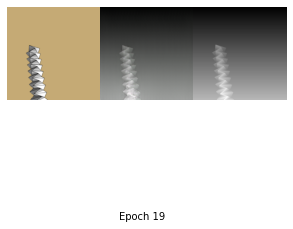

Epoch [20/50], Step [1/3750], D_loss: 0.2611, G_loss: 5.5144
Epoch [20/50], Step [2/3750], D_loss: 0.0355, G_loss: 18.0345
Epoch [20/50], Step [3/3750], D_loss: 0.0312, G_loss: 8.1545
Epoch [20/50], Step [4/3750], D_loss: 0.0048, G_loss: 14.4162
Epoch [20/50], Step [5/3750], D_loss: 0.1030, G_loss: 7.3335
Epoch [20/50], Step [6/3750], D_loss: 0.0311, G_loss: 7.6382
Epoch [20/50], Step [7/3750], D_loss: 0.2374, G_loss: 5.2183
Epoch [20/50], Step [8/3750], D_loss: 0.0146, G_loss: 9.5684
Epoch [20/50], Step [9/3750], D_loss: 0.1240, G_loss: 5.0170
Epoch [20/50], Step [10/3750], D_loss: 0.1378, G_loss: 8.6982
Epoch [20/50], Step [11/3750], D_loss: 0.2861, G_loss: 9.4004
Epoch [20/50], Step [12/3750], D_loss: 0.1163, G_loss: 11.6841
Epoch [20/50], Step [13/3750], D_loss: 0.0200, G_loss: 6.6041
Epoch [20/50], Step [14/3750], D_loss: 0.0170, G_loss: 7.9619
Epoch [20/50], Step [15/3750], D_loss: 0.0232, G_loss: 11.2647
Epoch [20/50], Step [16/3750], D_loss: 0.0157, G_loss: 8.2087
Epoch [20/50]

Epoch [20/50], Step [133/3750], D_loss: 0.0242, G_loss: 10.5794
Epoch [20/50], Step [134/3750], D_loss: 0.0324, G_loss: 7.4918
Epoch [20/50], Step [135/3750], D_loss: 0.0529, G_loss: 5.9616
Epoch [20/50], Step [136/3750], D_loss: 0.1894, G_loss: 11.6776
Epoch [20/50], Step [137/3750], D_loss: 0.0798, G_loss: 11.6992
Epoch [20/50], Step [138/3750], D_loss: 0.0333, G_loss: 8.2249
Epoch [20/50], Step [139/3750], D_loss: 0.0542, G_loss: 7.0937
Epoch [20/50], Step [140/3750], D_loss: 0.1578, G_loss: 6.2902
Epoch [20/50], Step [141/3750], D_loss: 0.0399, G_loss: 6.5650
Epoch [20/50], Step [142/3750], D_loss: 0.0129, G_loss: 8.3689
Epoch [20/50], Step [143/3750], D_loss: 0.1849, G_loss: 5.6829
Epoch [20/50], Step [144/3750], D_loss: 0.0858, G_loss: 4.9004
Epoch [20/50], Step [145/3750], D_loss: 0.1585, G_loss: 4.7059
Epoch [20/50], Step [146/3750], D_loss: 0.0600, G_loss: 5.4396
Epoch [20/50], Step [147/3750], D_loss: 0.1721, G_loss: 7.2517
Epoch [20/50], Step [148/3750], D_loss: 0.0556, G_lo

Epoch [20/50], Step [263/3750], D_loss: 0.0808, G_loss: 4.4348
Epoch [20/50], Step [264/3750], D_loss: 0.0729, G_loss: 7.8474
Epoch [20/50], Step [265/3750], D_loss: 0.4130, G_loss: 8.0047
Epoch [20/50], Step [266/3750], D_loss: 0.0236, G_loss: 10.6367
Epoch [20/50], Step [267/3750], D_loss: 0.0306, G_loss: 9.7611
Epoch [20/50], Step [268/3750], D_loss: 0.3428, G_loss: 6.6304
Epoch [20/50], Step [269/3750], D_loss: 0.0229, G_loss: 12.6655
Epoch [20/50], Step [270/3750], D_loss: 0.0683, G_loss: 5.1257
Epoch [20/50], Step [271/3750], D_loss: 0.2802, G_loss: 8.1987
Epoch [20/50], Step [272/3750], D_loss: 0.0084, G_loss: 14.5121
Epoch [20/50], Step [273/3750], D_loss: 0.0409, G_loss: 10.9719
Epoch [20/50], Step [274/3750], D_loss: 0.1004, G_loss: 11.4058
Epoch [20/50], Step [275/3750], D_loss: 0.0140, G_loss: 7.7198
Epoch [20/50], Step [276/3750], D_loss: 0.1432, G_loss: 7.2832
Epoch [20/50], Step [277/3750], D_loss: 0.0151, G_loss: 11.6157
Epoch [20/50], Step [278/3750], D_loss: 0.0181, G

Epoch [20/50], Step [393/3750], D_loss: 0.0347, G_loss: 9.2340
Epoch [20/50], Step [394/3750], D_loss: 0.0364, G_loss: 6.6988
Epoch [20/50], Step [395/3750], D_loss: 0.0127, G_loss: 9.0633
Epoch [20/50], Step [396/3750], D_loss: 0.0206, G_loss: 11.0932
Epoch [20/50], Step [397/3750], D_loss: 0.0247, G_loss: 7.9421
Epoch [20/50], Step [398/3750], D_loss: 0.1017, G_loss: 7.3844
Epoch [20/50], Step [399/3750], D_loss: 0.0595, G_loss: 13.4544
Epoch [20/50], Step [400/3750], D_loss: 0.1073, G_loss: 9.6539
Epoch [20/50], Step [401/3750], D_loss: 0.0066, G_loss: 10.6464
Epoch [20/50], Step [402/3750], D_loss: 0.0207, G_loss: 10.8407
Epoch [20/50], Step [403/3750], D_loss: 0.0010, G_loss: 13.4417
Epoch [20/50], Step [404/3750], D_loss: 0.0989, G_loss: 7.1969
Epoch [20/50], Step [405/3750], D_loss: 0.0306, G_loss: 11.6955
Epoch [20/50], Step [406/3750], D_loss: 0.3579, G_loss: 3.9310
Epoch [20/50], Step [407/3750], D_loss: 0.2344, G_loss: 9.2809
Epoch [20/50], Step [408/3750], D_loss: 0.0383, G

Epoch [20/50], Step [523/3750], D_loss: 0.2401, G_loss: 4.1796
Epoch [20/50], Step [524/3750], D_loss: 0.6902, G_loss: 9.9711
Epoch [20/50], Step [525/3750], D_loss: 0.0238, G_loss: 7.7740
Epoch [20/50], Step [526/3750], D_loss: 0.0232, G_loss: 6.4668
Epoch [20/50], Step [527/3750], D_loss: 0.6346, G_loss: 15.1231
Epoch [20/50], Step [528/3750], D_loss: 0.0205, G_loss: 9.3356
Epoch [20/50], Step [529/3750], D_loss: 0.2409, G_loss: 5.2454
Epoch [20/50], Step [530/3750], D_loss: 0.3453, G_loss: 7.2910
Epoch [20/50], Step [531/3750], D_loss: 0.1665, G_loss: 6.4004
Epoch [20/50], Step [532/3750], D_loss: 0.3066, G_loss: 6.7600
Epoch [20/50], Step [533/3750], D_loss: 0.0328, G_loss: 5.8606
Epoch [20/50], Step [534/3750], D_loss: 0.0688, G_loss: 12.9280
Epoch [20/50], Step [535/3750], D_loss: 0.0468, G_loss: 10.0195
Epoch [20/50], Step [536/3750], D_loss: 0.0191, G_loss: 6.1331
Epoch [20/50], Step [537/3750], D_loss: 0.1843, G_loss: 5.4827
Epoch [20/50], Step [538/3750], D_loss: 0.0608, G_lo

Epoch [20/50], Step [653/3750], D_loss: 0.0190, G_loss: 7.9676
Epoch [20/50], Step [654/3750], D_loss: 0.0574, G_loss: 6.9832
Epoch [20/50], Step [655/3750], D_loss: 0.1312, G_loss: 8.4908
Epoch [20/50], Step [656/3750], D_loss: 0.0107, G_loss: 10.5835
Epoch [20/50], Step [657/3750], D_loss: 0.0166, G_loss: 14.1019
Epoch [20/50], Step [658/3750], D_loss: 0.0074, G_loss: 6.9770
Epoch [20/50], Step [659/3750], D_loss: 0.0182, G_loss: 13.6525
Epoch [20/50], Step [660/3750], D_loss: 0.0146, G_loss: 7.6294
Epoch [20/50], Step [661/3750], D_loss: 0.3147, G_loss: 4.8171
Epoch [20/50], Step [662/3750], D_loss: 0.0518, G_loss: 6.3180
Epoch [20/50], Step [663/3750], D_loss: 0.3218, G_loss: 9.6873
Epoch [20/50], Step [664/3750], D_loss: 0.0506, G_loss: 14.4819
Epoch [20/50], Step [665/3750], D_loss: 0.1414, G_loss: 6.4143
Epoch [20/50], Step [666/3750], D_loss: 0.1316, G_loss: 7.7892
Epoch [20/50], Step [667/3750], D_loss: 0.0859, G_loss: 10.0146
Epoch [20/50], Step [668/3750], D_loss: 0.0680, G_

Epoch [20/50], Step [783/3750], D_loss: 0.4623, G_loss: 8.0568
Epoch [20/50], Step [784/3750], D_loss: 0.1873, G_loss: 15.7749
Epoch [20/50], Step [785/3750], D_loss: 0.0908, G_loss: 8.0476
Epoch [20/50], Step [786/3750], D_loss: 0.0169, G_loss: 11.5778
Epoch [20/50], Step [787/3750], D_loss: 0.0882, G_loss: 6.3447
Epoch [20/50], Step [788/3750], D_loss: 0.0200, G_loss: 8.2187
Epoch [20/50], Step [789/3750], D_loss: 0.2697, G_loss: 10.2418
Epoch [20/50], Step [790/3750], D_loss: 0.2622, G_loss: 5.2783
Epoch [20/50], Step [791/3750], D_loss: 0.0074, G_loss: 7.0075
Epoch [20/50], Step [792/3750], D_loss: 0.0159, G_loss: 9.0021
Epoch [20/50], Step [793/3750], D_loss: 0.0802, G_loss: 8.4446
Epoch [20/50], Step [794/3750], D_loss: 0.2496, G_loss: 5.5625
Epoch [20/50], Step [795/3750], D_loss: 0.0261, G_loss: 15.1255
Epoch [20/50], Step [796/3750], D_loss: 0.0450, G_loss: 8.8500
Epoch [20/50], Step [797/3750], D_loss: 0.0247, G_loss: 9.0245
Epoch [20/50], Step [798/3750], D_loss: 0.2254, G_l

Epoch [20/50], Step [913/3750], D_loss: 0.4278, G_loss: 6.6224
Epoch [20/50], Step [914/3750], D_loss: 0.0632, G_loss: 12.2431
Epoch [20/50], Step [915/3750], D_loss: 0.0497, G_loss: 6.0874
Epoch [20/50], Step [916/3750], D_loss: 0.2009, G_loss: 8.2635
Epoch [20/50], Step [917/3750], D_loss: 0.0779, G_loss: 7.8597
Epoch [20/50], Step [918/3750], D_loss: 0.0050, G_loss: 10.9081
Epoch [20/50], Step [919/3750], D_loss: 0.0911, G_loss: 9.3861
Epoch [20/50], Step [920/3750], D_loss: 0.0038, G_loss: 7.1361
Epoch [20/50], Step [921/3750], D_loss: 0.0054, G_loss: 7.2550
Epoch [20/50], Step [922/3750], D_loss: 0.0105, G_loss: 9.8576
Epoch [20/50], Step [923/3750], D_loss: 0.0052, G_loss: 10.8836
Epoch [20/50], Step [924/3750], D_loss: 0.0382, G_loss: 10.2767
Epoch [20/50], Step [925/3750], D_loss: 0.0051, G_loss: 16.6030
Epoch [20/50], Step [926/3750], D_loss: 0.0322, G_loss: 7.8385
Epoch [20/50], Step [927/3750], D_loss: 0.0054, G_loss: 7.1850
Epoch [20/50], Step [928/3750], D_loss: 0.0214, G_

Epoch [20/50], Step [1042/3750], D_loss: 0.2864, G_loss: 7.6833
Epoch [20/50], Step [1043/3750], D_loss: 0.0084, G_loss: 11.1223
Epoch [20/50], Step [1044/3750], D_loss: 0.0058, G_loss: 7.2532
Epoch [20/50], Step [1045/3750], D_loss: 0.0139, G_loss: 16.8920
Epoch [20/50], Step [1046/3750], D_loss: 0.0454, G_loss: 8.8216
Epoch [20/50], Step [1047/3750], D_loss: 0.0458, G_loss: 7.2084
Epoch [20/50], Step [1048/3750], D_loss: 0.4801, G_loss: 9.6511
Epoch [20/50], Step [1049/3750], D_loss: 0.1331, G_loss: 5.6586
Epoch [20/50], Step [1050/3750], D_loss: 0.0184, G_loss: 12.8525
Epoch [20/50], Step [1051/3750], D_loss: 0.0927, G_loss: 12.2576
Epoch [20/50], Step [1052/3750], D_loss: 0.0163, G_loss: 7.1015
Epoch [20/50], Step [1053/3750], D_loss: 0.1661, G_loss: 5.4338
Epoch [20/50], Step [1054/3750], D_loss: 0.0042, G_loss: 9.8124
Epoch [20/50], Step [1055/3750], D_loss: 0.2207, G_loss: 8.2779
Epoch [20/50], Step [1056/3750], D_loss: 0.0109, G_loss: 9.1702
Epoch [20/50], Step [1057/3750], D_l

Epoch [20/50], Step [1170/3750], D_loss: 0.1144, G_loss: 5.3312
Epoch [20/50], Step [1171/3750], D_loss: 0.0102, G_loss: 8.1575
Epoch [20/50], Step [1172/3750], D_loss: 0.0355, G_loss: 10.4265
Epoch [20/50], Step [1173/3750], D_loss: 0.1510, G_loss: 11.2511
Epoch [20/50], Step [1174/3750], D_loss: 0.4014, G_loss: 7.7027
Epoch [20/50], Step [1175/3750], D_loss: 0.0053, G_loss: 12.4082
Epoch [20/50], Step [1176/3750], D_loss: 0.0142, G_loss: 14.9706
Epoch [20/50], Step [1177/3750], D_loss: 0.2672, G_loss: 4.8359
Epoch [20/50], Step [1178/3750], D_loss: 0.2980, G_loss: 7.7771
Epoch [20/50], Step [1179/3750], D_loss: 0.7995, G_loss: 4.3460
Epoch [20/50], Step [1180/3750], D_loss: 0.0598, G_loss: 7.6304
Epoch [20/50], Step [1181/3750], D_loss: 0.2186, G_loss: 6.7377
Epoch [20/50], Step [1182/3750], D_loss: 0.2839, G_loss: 7.2726
Epoch [20/50], Step [1183/3750], D_loss: 0.2107, G_loss: 7.4500
Epoch [20/50], Step [1184/3750], D_loss: 0.2048, G_loss: 13.1011
Epoch [20/50], Step [1185/3750], D_

Epoch [20/50], Step [1298/3750], D_loss: 0.6781, G_loss: 6.1174
Epoch [20/50], Step [1299/3750], D_loss: 0.5258, G_loss: 7.4346
Epoch [20/50], Step [1300/3750], D_loss: 0.0477, G_loss: 12.2386
Epoch [20/50], Step [1301/3750], D_loss: 0.6321, G_loss: 9.5275
Epoch [20/50], Step [1302/3750], D_loss: 0.2427, G_loss: 9.6381
Epoch [20/50], Step [1303/3750], D_loss: 0.3447, G_loss: 7.9855
Epoch [20/50], Step [1304/3750], D_loss: 0.2149, G_loss: 7.5104
Epoch [20/50], Step [1305/3750], D_loss: 0.3729, G_loss: 9.3409
Epoch [20/50], Step [1306/3750], D_loss: 0.0849, G_loss: 6.5094
Epoch [20/50], Step [1307/3750], D_loss: 0.1584, G_loss: 12.1481
Epoch [20/50], Step [1308/3750], D_loss: 0.0862, G_loss: 8.9908
Epoch [20/50], Step [1309/3750], D_loss: 0.1345, G_loss: 8.9042
Epoch [20/50], Step [1310/3750], D_loss: 0.1338, G_loss: 10.1423
Epoch [20/50], Step [1311/3750], D_loss: 0.0788, G_loss: 5.7499
Epoch [20/50], Step [1312/3750], D_loss: 0.2770, G_loss: 9.3703
Epoch [20/50], Step [1313/3750], D_lo

Epoch [20/50], Step [1426/3750], D_loss: 0.1128, G_loss: 5.5041
Epoch [20/50], Step [1427/3750], D_loss: 0.1922, G_loss: 6.4783
Epoch [20/50], Step [1428/3750], D_loss: 0.0620, G_loss: 5.5755
Epoch [20/50], Step [1429/3750], D_loss: 0.0079, G_loss: 10.5455
Epoch [20/50], Step [1430/3750], D_loss: 0.0877, G_loss: 5.4614
Epoch [20/50], Step [1431/3750], D_loss: 0.0214, G_loss: 10.2713
Epoch [20/50], Step [1432/3750], D_loss: 0.0656, G_loss: 13.8788
Epoch [20/50], Step [1433/3750], D_loss: 0.0141, G_loss: 7.5491
Epoch [20/50], Step [1434/3750], D_loss: 0.1100, G_loss: 7.7293
Epoch [20/50], Step [1435/3750], D_loss: 0.2660, G_loss: 6.7483
Epoch [20/50], Step [1436/3750], D_loss: 0.0157, G_loss: 8.0028
Epoch [20/50], Step [1437/3750], D_loss: 0.0078, G_loss: 11.5294
Epoch [20/50], Step [1438/3750], D_loss: 0.0242, G_loss: 5.5026
Epoch [20/50], Step [1439/3750], D_loss: 0.0699, G_loss: 7.6578
Epoch [20/50], Step [1440/3750], D_loss: 0.0087, G_loss: 9.5171
Epoch [20/50], Step [1441/3750], D_l

Epoch [20/50], Step [1554/3750], D_loss: 0.0112, G_loss: 11.0396
Epoch [20/50], Step [1555/3750], D_loss: 0.0533, G_loss: 8.7709
Epoch [20/50], Step [1556/3750], D_loss: 0.0092, G_loss: 6.9653
Epoch [20/50], Step [1557/3750], D_loss: 0.3776, G_loss: 7.1880
Epoch [20/50], Step [1558/3750], D_loss: 0.0479, G_loss: 10.9929
Epoch [20/50], Step [1559/3750], D_loss: 0.0217, G_loss: 12.0918
Epoch [20/50], Step [1560/3750], D_loss: 0.1381, G_loss: 6.9744
Epoch [20/50], Step [1561/3750], D_loss: 0.8224, G_loss: 5.4091
Epoch [20/50], Step [1562/3750], D_loss: 0.1115, G_loss: 19.4844
Epoch [20/50], Step [1563/3750], D_loss: 0.1690, G_loss: 5.0814
Epoch [20/50], Step [1564/3750], D_loss: 0.1500, G_loss: 5.3880
Epoch [20/50], Step [1565/3750], D_loss: 0.1929, G_loss: 6.0065
Epoch [20/50], Step [1566/3750], D_loss: 0.1173, G_loss: 6.8665
Epoch [20/50], Step [1567/3750], D_loss: 0.3472, G_loss: 5.7381
Epoch [20/50], Step [1568/3750], D_loss: 0.0144, G_loss: 8.7967
Epoch [20/50], Step [1569/3750], D_l

Epoch [20/50], Step [1682/3750], D_loss: 0.0066, G_loss: 15.5576
Epoch [20/50], Step [1683/3750], D_loss: 0.2091, G_loss: 6.4073
Epoch [20/50], Step [1684/3750], D_loss: 0.1221, G_loss: 5.4079
Epoch [20/50], Step [1685/3750], D_loss: 0.0942, G_loss: 7.0204
Epoch [20/50], Step [1686/3750], D_loss: 0.0847, G_loss: 5.5890
Epoch [20/50], Step [1687/3750], D_loss: 0.1313, G_loss: 6.0290
Epoch [20/50], Step [1688/3750], D_loss: 0.0132, G_loss: 7.6678
Epoch [20/50], Step [1689/3750], D_loss: 0.1780, G_loss: 3.9586
Epoch [20/50], Step [1690/3750], D_loss: 0.0555, G_loss: 5.4025
Epoch [20/50], Step [1691/3750], D_loss: 0.0231, G_loss: 9.7681
Epoch [20/50], Step [1692/3750], D_loss: 0.0099, G_loss: 11.0934
Epoch [20/50], Step [1693/3750], D_loss: 0.3484, G_loss: 10.1680
Epoch [20/50], Step [1694/3750], D_loss: 0.1858, G_loss: 5.8445
Epoch [20/50], Step [1695/3750], D_loss: 0.0231, G_loss: 13.4697
Epoch [20/50], Step [1696/3750], D_loss: 0.2427, G_loss: 5.5228
Epoch [20/50], Step [1697/3750], D_l

Epoch [20/50], Step [1810/3750], D_loss: 0.6296, G_loss: 4.0371
Epoch [20/50], Step [1811/3750], D_loss: 0.0389, G_loss: 13.2226
Epoch [20/50], Step [1812/3750], D_loss: 0.0522, G_loss: 6.9553
Epoch [20/50], Step [1813/3750], D_loss: 0.2613, G_loss: 10.6789
Epoch [20/50], Step [1814/3750], D_loss: 0.2811, G_loss: 6.3014
Epoch [20/50], Step [1815/3750], D_loss: 0.0232, G_loss: 14.3781
Epoch [20/50], Step [1816/3750], D_loss: 0.1291, G_loss: 8.9896
Epoch [20/50], Step [1817/3750], D_loss: 0.0386, G_loss: 10.8398
Epoch [20/50], Step [1818/3750], D_loss: 0.1977, G_loss: 10.1441
Epoch [20/50], Step [1819/3750], D_loss: 0.0773, G_loss: 12.7314
Epoch [20/50], Step [1820/3750], D_loss: 0.1165, G_loss: 8.0468
Epoch [20/50], Step [1821/3750], D_loss: 0.0448, G_loss: 10.8076
Epoch [20/50], Step [1822/3750], D_loss: 0.0310, G_loss: 8.6207
Epoch [20/50], Step [1823/3750], D_loss: 0.0327, G_loss: 11.9615
Epoch [20/50], Step [1824/3750], D_loss: 0.5499, G_loss: 9.1441
Epoch [20/50], Step [1825/3750],

Epoch [20/50], Step [1938/3750], D_loss: 0.0576, G_loss: 7.8005
Epoch [20/50], Step [1939/3750], D_loss: 0.1558, G_loss: 9.6058
Epoch [20/50], Step [1940/3750], D_loss: 0.1097, G_loss: 5.6028
Epoch [20/50], Step [1941/3750], D_loss: 0.0649, G_loss: 7.3985
Epoch [20/50], Step [1942/3750], D_loss: 0.8696, G_loss: 5.2485
Epoch [20/50], Step [1943/3750], D_loss: 0.1090, G_loss: 5.0810
Epoch [20/50], Step [1944/3750], D_loss: 0.3618, G_loss: 5.6288
Epoch [20/50], Step [1945/3750], D_loss: 0.1275, G_loss: 8.8666
Epoch [20/50], Step [1946/3750], D_loss: 0.1501, G_loss: 7.0288
Epoch [20/50], Step [1947/3750], D_loss: 0.1435, G_loss: 17.5929
Epoch [20/50], Step [1948/3750], D_loss: 0.2748, G_loss: 9.2142
Epoch [20/50], Step [1949/3750], D_loss: 0.7221, G_loss: 11.5837
Epoch [20/50], Step [1950/3750], D_loss: 0.7251, G_loss: 10.4197
Epoch [20/50], Step [1951/3750], D_loss: 0.0324, G_loss: 13.4583
Epoch [20/50], Step [1952/3750], D_loss: 0.0490, G_loss: 16.9751
Epoch [20/50], Step [1953/3750], D_

Epoch [20/50], Step [2066/3750], D_loss: 0.0090, G_loss: 13.7912
Epoch [20/50], Step [2067/3750], D_loss: 0.0608, G_loss: 6.5228
Epoch [20/50], Step [2068/3750], D_loss: 0.0454, G_loss: 14.4612
Epoch [20/50], Step [2069/3750], D_loss: 0.0340, G_loss: 7.1616
Epoch [20/50], Step [2070/3750], D_loss: 0.3795, G_loss: 3.6918
Epoch [20/50], Step [2071/3750], D_loss: 0.0684, G_loss: 8.8950
Epoch [20/50], Step [2072/3750], D_loss: 0.0182, G_loss: 15.5135
Epoch [20/50], Step [2073/3750], D_loss: 0.0244, G_loss: 7.4513
Epoch [20/50], Step [2074/3750], D_loss: 0.0645, G_loss: 15.5745
Epoch [20/50], Step [2075/3750], D_loss: 0.0609, G_loss: 5.8176
Epoch [20/50], Step [2076/3750], D_loss: 0.1323, G_loss: 7.1293
Epoch [20/50], Step [2077/3750], D_loss: 0.0294, G_loss: 7.3786
Epoch [20/50], Step [2078/3750], D_loss: 0.0088, G_loss: 9.3684
Epoch [20/50], Step [2079/3750], D_loss: 0.0275, G_loss: 10.5148
Epoch [20/50], Step [2080/3750], D_loss: 0.0672, G_loss: 6.3395
Epoch [20/50], Step [2081/3750], D_

Epoch [20/50], Step [2194/3750], D_loss: 0.1868, G_loss: 6.2709
Epoch [20/50], Step [2195/3750], D_loss: 0.3772, G_loss: 7.0716
Epoch [20/50], Step [2196/3750], D_loss: 0.0018, G_loss: 16.7402
Epoch [20/50], Step [2197/3750], D_loss: 0.0839, G_loss: 5.4285
Epoch [20/50], Step [2198/3750], D_loss: 0.3391, G_loss: 8.4020
Epoch [20/50], Step [2199/3750], D_loss: 0.0263, G_loss: 6.3474
Epoch [20/50], Step [2200/3750], D_loss: 0.0257, G_loss: 4.8333
Epoch [20/50], Step [2201/3750], D_loss: 0.2319, G_loss: 6.1933
Epoch [20/50], Step [2202/3750], D_loss: 0.0871, G_loss: 6.3078
Epoch [20/50], Step [2203/3750], D_loss: 0.1804, G_loss: 6.6603
Epoch [20/50], Step [2204/3750], D_loss: 0.1211, G_loss: 11.6232
Epoch [20/50], Step [2205/3750], D_loss: 0.0328, G_loss: 5.5495
Epoch [20/50], Step [2206/3750], D_loss: 0.0815, G_loss: 8.3558
Epoch [20/50], Step [2207/3750], D_loss: 0.2272, G_loss: 4.7724
Epoch [20/50], Step [2208/3750], D_loss: 0.0083, G_loss: 6.2981
Epoch [20/50], Step [2209/3750], D_los

Epoch [20/50], Step [2322/3750], D_loss: 0.0534, G_loss: 7.2719
Epoch [20/50], Step [2323/3750], D_loss: 0.3557, G_loss: 4.8343
Epoch [20/50], Step [2324/3750], D_loss: 0.0155, G_loss: 11.6855
Epoch [20/50], Step [2325/3750], D_loss: 0.0620, G_loss: 7.0358
Epoch [20/50], Step [2326/3750], D_loss: 0.1698, G_loss: 4.8728
Epoch [20/50], Step [2327/3750], D_loss: 0.0479, G_loss: 9.4271
Epoch [20/50], Step [2328/3750], D_loss: 0.3541, G_loss: 5.1783
Epoch [20/50], Step [2329/3750], D_loss: 0.2186, G_loss: 8.6260
Epoch [20/50], Step [2330/3750], D_loss: 0.0257, G_loss: 7.6839
Epoch [20/50], Step [2331/3750], D_loss: 0.0854, G_loss: 6.0860
Epoch [20/50], Step [2332/3750], D_loss: 0.3571, G_loss: 5.1103
Epoch [20/50], Step [2333/3750], D_loss: 0.0361, G_loss: 9.0728
Epoch [20/50], Step [2334/3750], D_loss: 0.1858, G_loss: 18.2088
Epoch [20/50], Step [2335/3750], D_loss: 0.1971, G_loss: 7.4321
Epoch [20/50], Step [2336/3750], D_loss: 0.2646, G_loss: 4.4494
Epoch [20/50], Step [2337/3750], D_los

Epoch [20/50], Step [2450/3750], D_loss: 0.1005, G_loss: 5.9956
Epoch [20/50], Step [2451/3750], D_loss: 0.0116, G_loss: 10.4176
Epoch [20/50], Step [2452/3750], D_loss: 0.0076, G_loss: 8.4630
Epoch [20/50], Step [2453/3750], D_loss: 0.0075, G_loss: 11.3068
Epoch [20/50], Step [2454/3750], D_loss: 0.0244, G_loss: 7.8457
Epoch [20/50], Step [2455/3750], D_loss: 0.0693, G_loss: 7.6672
Epoch [20/50], Step [2456/3750], D_loss: 0.0562, G_loss: 7.2605
Epoch [20/50], Step [2457/3750], D_loss: 0.0256, G_loss: 10.3678
Epoch [20/50], Step [2458/3750], D_loss: 0.0185, G_loss: 16.1177
Epoch [20/50], Step [2459/3750], D_loss: 0.0113, G_loss: 8.8157
Epoch [20/50], Step [2460/3750], D_loss: 0.0367, G_loss: 7.8863
Epoch [20/50], Step [2461/3750], D_loss: 0.0801, G_loss: 5.4352
Epoch [20/50], Step [2462/3750], D_loss: 0.0203, G_loss: 9.4632
Epoch [20/50], Step [2463/3750], D_loss: 0.0104, G_loss: 13.9095
Epoch [20/50], Step [2464/3750], D_loss: 0.0032, G_loss: 7.3074
Epoch [20/50], Step [2465/3750], D_

Epoch [20/50], Step [2578/3750], D_loss: 0.0883, G_loss: 8.8541
Epoch [20/50], Step [2579/3750], D_loss: 0.0077, G_loss: 13.3573
Epoch [20/50], Step [2580/3750], D_loss: 0.1862, G_loss: 15.7604
Epoch [20/50], Step [2581/3750], D_loss: 0.0021, G_loss: 11.4842
Epoch [20/50], Step [2582/3750], D_loss: 0.0026, G_loss: 9.9687
Epoch [20/50], Step [2583/3750], D_loss: 0.0028, G_loss: 12.2491
Epoch [20/50], Step [2584/3750], D_loss: 0.3955, G_loss: 6.9060
Epoch [20/50], Step [2585/3750], D_loss: 0.0701, G_loss: 6.6510
Epoch [20/50], Step [2586/3750], D_loss: 0.2128, G_loss: 8.8528
Epoch [20/50], Step [2587/3750], D_loss: 0.0320, G_loss: 6.9042
Epoch [20/50], Step [2588/3750], D_loss: 0.0227, G_loss: 15.8302
Epoch [20/50], Step [2589/3750], D_loss: 0.0309, G_loss: 12.2689
Epoch [20/50], Step [2590/3750], D_loss: 0.0101, G_loss: 6.4808
Epoch [20/50], Step [2591/3750], D_loss: 0.0573, G_loss: 7.1674
Epoch [20/50], Step [2592/3750], D_loss: 0.0605, G_loss: 7.2052
Epoch [20/50], Step [2593/3750], D

Epoch [20/50], Step [2706/3750], D_loss: 0.0994, G_loss: 6.4727
Epoch [20/50], Step [2707/3750], D_loss: 0.0495, G_loss: 6.7486
Epoch [20/50], Step [2708/3750], D_loss: 0.2665, G_loss: 6.9556
Epoch [20/50], Step [2709/3750], D_loss: 0.1545, G_loss: 4.9904
Epoch [20/50], Step [2710/3750], D_loss: 0.0115, G_loss: 7.1640
Epoch [20/50], Step [2711/3750], D_loss: 0.1204, G_loss: 7.5883
Epoch [20/50], Step [2712/3750], D_loss: 0.0542, G_loss: 17.4862
Epoch [20/50], Step [2713/3750], D_loss: 0.2889, G_loss: 5.0499
Epoch [20/50], Step [2714/3750], D_loss: 0.0083, G_loss: 10.0553
Epoch [20/50], Step [2715/3750], D_loss: 0.0816, G_loss: 6.1401
Epoch [20/50], Step [2716/3750], D_loss: 0.0372, G_loss: 13.3006
Epoch [20/50], Step [2717/3750], D_loss: 0.2602, G_loss: 11.4280
Epoch [20/50], Step [2718/3750], D_loss: 0.2286, G_loss: 8.1535
Epoch [20/50], Step [2719/3750], D_loss: 0.0033, G_loss: 18.1404
Epoch [20/50], Step [2720/3750], D_loss: 0.1291, G_loss: 6.0313
Epoch [20/50], Step [2721/3750], D_

Epoch [20/50], Step [2834/3750], D_loss: 0.4969, G_loss: 5.8718
Epoch [20/50], Step [2835/3750], D_loss: 0.1684, G_loss: 7.6911
Epoch [20/50], Step [2836/3750], D_loss: 0.4616, G_loss: 7.5632
Epoch [20/50], Step [2837/3750], D_loss: 0.0832, G_loss: 13.2041
Epoch [20/50], Step [2838/3750], D_loss: 0.1015, G_loss: 12.4955
Epoch [20/50], Step [2839/3750], D_loss: 0.0055, G_loss: 9.2985
Epoch [20/50], Step [2840/3750], D_loss: 0.0061, G_loss: 15.6213
Epoch [20/50], Step [2841/3750], D_loss: 0.3339, G_loss: 6.3289
Epoch [20/50], Step [2842/3750], D_loss: 0.0996, G_loss: 6.4942
Epoch [20/50], Step [2843/3750], D_loss: 0.0054, G_loss: 10.7349
Epoch [20/50], Step [2844/3750], D_loss: 0.1230, G_loss: 4.3919
Epoch [20/50], Step [2845/3750], D_loss: 0.0822, G_loss: 19.4308
Epoch [20/50], Step [2846/3750], D_loss: 0.1739, G_loss: 6.2956
Epoch [20/50], Step [2847/3750], D_loss: 0.0359, G_loss: 8.1327
Epoch [20/50], Step [2848/3750], D_loss: 0.0369, G_loss: 9.4914
Epoch [20/50], Step [2849/3750], D_

Epoch [20/50], Step [2962/3750], D_loss: 0.1544, G_loss: 5.3362
Epoch [20/50], Step [2963/3750], D_loss: 0.0077, G_loss: 11.4608
Epoch [20/50], Step [2964/3750], D_loss: 0.0285, G_loss: 9.3271
Epoch [20/50], Step [2965/3750], D_loss: 0.0460, G_loss: 23.6523
Epoch [20/50], Step [2966/3750], D_loss: 0.0327, G_loss: 5.9245
Epoch [20/50], Step [2967/3750], D_loss: 0.0320, G_loss: 12.5193
Epoch [20/50], Step [2968/3750], D_loss: 0.0099, G_loss: 10.5859
Epoch [20/50], Step [2969/3750], D_loss: 0.0243, G_loss: 8.7125
Epoch [20/50], Step [2970/3750], D_loss: 0.0226, G_loss: 8.0451
Epoch [20/50], Step [2971/3750], D_loss: 0.0146, G_loss: 7.8531
Epoch [20/50], Step [2972/3750], D_loss: 0.1534, G_loss: 6.0212
Epoch [20/50], Step [2973/3750], D_loss: 0.0532, G_loss: 7.7368
Epoch [20/50], Step [2974/3750], D_loss: 0.0466, G_loss: 5.7688
Epoch [20/50], Step [2975/3750], D_loss: 0.0229, G_loss: 8.9850
Epoch [20/50], Step [2976/3750], D_loss: 0.0164, G_loss: 8.0680
Epoch [20/50], Step [2977/3750], D_l

Epoch [20/50], Step [3090/3750], D_loss: 0.0027, G_loss: 18.3057
Epoch [20/50], Step [3091/3750], D_loss: 0.0044, G_loss: 8.1530
Epoch [20/50], Step [3092/3750], D_loss: 0.1393, G_loss: 8.6933
Epoch [20/50], Step [3093/3750], D_loss: 0.2334, G_loss: 9.0964
Epoch [20/50], Step [3094/3750], D_loss: 0.0988, G_loss: 11.1042
Epoch [20/50], Step [3095/3750], D_loss: 0.1180, G_loss: 5.9984
Epoch [20/50], Step [3096/3750], D_loss: 0.0090, G_loss: 17.0191
Epoch [20/50], Step [3097/3750], D_loss: 0.0224, G_loss: 11.2388
Epoch [20/50], Step [3098/3750], D_loss: 0.0816, G_loss: 8.9285
Epoch [20/50], Step [3099/3750], D_loss: 0.0026, G_loss: 13.1305
Epoch [20/50], Step [3100/3750], D_loss: 0.1401, G_loss: 7.3020
Epoch [20/50], Step [3101/3750], D_loss: 0.0071, G_loss: 8.0532
Epoch [20/50], Step [3102/3750], D_loss: 0.0157, G_loss: 7.0399
Epoch [20/50], Step [3103/3750], D_loss: 0.1542, G_loss: 7.0522
Epoch [20/50], Step [3104/3750], D_loss: 0.6106, G_loss: 11.7199
Epoch [20/50], Step [3105/3750], D

Epoch [20/50], Step [3218/3750], D_loss: 0.1742, G_loss: 6.6172
Epoch [20/50], Step [3219/3750], D_loss: 0.1471, G_loss: 7.3145
Epoch [20/50], Step [3220/3750], D_loss: 0.0052, G_loss: 7.6645
Epoch [20/50], Step [3221/3750], D_loss: 0.1942, G_loss: 10.8034
Epoch [20/50], Step [3222/3750], D_loss: 0.1587, G_loss: 5.4872
Epoch [20/50], Step [3223/3750], D_loss: 0.0214, G_loss: 7.1948
Epoch [20/50], Step [3224/3750], D_loss: 0.0637, G_loss: 7.7760
Epoch [20/50], Step [3225/3750], D_loss: 0.0224, G_loss: 18.1789
Epoch [20/50], Step [3226/3750], D_loss: 0.1168, G_loss: 11.0122
Epoch [20/50], Step [3227/3750], D_loss: 0.1306, G_loss: 7.6504
Epoch [20/50], Step [3228/3750], D_loss: 0.0617, G_loss: 7.5768
Epoch [20/50], Step [3229/3750], D_loss: 0.0222, G_loss: 9.3706
Epoch [20/50], Step [3230/3750], D_loss: 0.0167, G_loss: 11.3206
Epoch [20/50], Step [3231/3750], D_loss: 0.0252, G_loss: 7.7434
Epoch [20/50], Step [3232/3750], D_loss: 0.1353, G_loss: 5.0716
Epoch [20/50], Step [3233/3750], D_l

Epoch [20/50], Step [3346/3750], D_loss: 0.0872, G_loss: 8.2595
Epoch [20/50], Step [3347/3750], D_loss: 0.0553, G_loss: 8.3468
Epoch [20/50], Step [3348/3750], D_loss: 0.0368, G_loss: 11.8583
Epoch [20/50], Step [3349/3750], D_loss: 0.0165, G_loss: 10.0809
Epoch [20/50], Step [3350/3750], D_loss: 0.1092, G_loss: 6.7029
Epoch [20/50], Step [3351/3750], D_loss: 0.0616, G_loss: 15.0642
Epoch [20/50], Step [3352/3750], D_loss: 0.0057, G_loss: 8.5659
Epoch [20/50], Step [3353/3750], D_loss: 0.0024, G_loss: 8.3717
Epoch [20/50], Step [3354/3750], D_loss: 0.1096, G_loss: 14.4502
Epoch [20/50], Step [3355/3750], D_loss: 0.0272, G_loss: 7.4353
Epoch [20/50], Step [3356/3750], D_loss: 0.0078, G_loss: 7.2910
Epoch [20/50], Step [3357/3750], D_loss: 0.0557, G_loss: 9.2551
Epoch [20/50], Step [3358/3750], D_loss: 0.0172, G_loss: 13.5758
Epoch [20/50], Step [3359/3750], D_loss: 0.1030, G_loss: 5.3516
Epoch [20/50], Step [3360/3750], D_loss: 0.0818, G_loss: 5.6560
Epoch [20/50], Step [3361/3750], D_

Epoch [20/50], Step [3474/3750], D_loss: 0.0013, G_loss: 9.5865
Epoch [20/50], Step [3475/3750], D_loss: 0.4081, G_loss: 6.0841
Epoch [20/50], Step [3476/3750], D_loss: 0.1083, G_loss: 5.2509
Epoch [20/50], Step [3477/3750], D_loss: 0.0007, G_loss: 14.7194
Epoch [20/50], Step [3478/3750], D_loss: 1.2017, G_loss: 4.2190
Epoch [20/50], Step [3479/3750], D_loss: 0.0030, G_loss: 7.6857
Epoch [20/50], Step [3480/3750], D_loss: 0.0051, G_loss: 8.4212
Epoch [20/50], Step [3481/3750], D_loss: 0.0676, G_loss: 9.7730
Epoch [20/50], Step [3482/3750], D_loss: 0.0713, G_loss: 7.5925
Epoch [20/50], Step [3483/3750], D_loss: 0.0192, G_loss: 7.2367
Epoch [20/50], Step [3484/3750], D_loss: 0.2171, G_loss: 5.4345
Epoch [20/50], Step [3485/3750], D_loss: 0.0295, G_loss: 6.9639
Epoch [20/50], Step [3486/3750], D_loss: 0.0521, G_loss: 10.3539
Epoch [20/50], Step [3487/3750], D_loss: 0.4697, G_loss: 16.0700
Epoch [20/50], Step [3488/3750], D_loss: 0.8580, G_loss: 8.3643
Epoch [20/50], Step [3489/3750], D_lo

Epoch [20/50], Step [3602/3750], D_loss: 0.0225, G_loss: 9.3007
Epoch [20/50], Step [3603/3750], D_loss: 0.0368, G_loss: 5.8917
Epoch [20/50], Step [3604/3750], D_loss: 0.1485, G_loss: 7.3933
Epoch [20/50], Step [3605/3750], D_loss: 0.0021, G_loss: 8.8057
Epoch [20/50], Step [3606/3750], D_loss: 0.1103, G_loss: 7.1209
Epoch [20/50], Step [3607/3750], D_loss: 0.1612, G_loss: 6.4016
Epoch [20/50], Step [3608/3750], D_loss: 0.0035, G_loss: 12.3473
Epoch [20/50], Step [3609/3750], D_loss: 0.1619, G_loss: 4.7294
Epoch [20/50], Step [3610/3750], D_loss: 0.0367, G_loss: 10.0621
Epoch [20/50], Step [3611/3750], D_loss: 0.0444, G_loss: 7.1722
Epoch [20/50], Step [3612/3750], D_loss: 0.0010, G_loss: 14.5003
Epoch [20/50], Step [3613/3750], D_loss: 0.0088, G_loss: 11.3579
Epoch [20/50], Step [3614/3750], D_loss: 0.0455, G_loss: 6.9690
Epoch [20/50], Step [3615/3750], D_loss: 0.0940, G_loss: 10.3143
Epoch [20/50], Step [3616/3750], D_loss: 0.1406, G_loss: 6.3599
Epoch [20/50], Step [3617/3750], D_

Epoch [20/50], Step [3730/3750], D_loss: 1.2664, G_loss: 8.3118
Epoch [20/50], Step [3731/3750], D_loss: 0.3753, G_loss: 6.6488
Epoch [20/50], Step [3732/3750], D_loss: 0.1235, G_loss: 8.3416
Epoch [20/50], Step [3733/3750], D_loss: 0.9955, G_loss: 2.8064
Epoch [20/50], Step [3734/3750], D_loss: 0.6568, G_loss: 9.0288
Epoch [20/50], Step [3735/3750], D_loss: 0.1085, G_loss: 13.0610
Epoch [20/50], Step [3736/3750], D_loss: 0.4352, G_loss: 14.0025
Epoch [20/50], Step [3737/3750], D_loss: 1.2784, G_loss: 7.6941
Epoch [20/50], Step [3738/3750], D_loss: 0.2622, G_loss: 4.9679
Epoch [20/50], Step [3739/3750], D_loss: 0.2223, G_loss: 7.6263
Epoch [20/50], Step [3740/3750], D_loss: 0.0162, G_loss: 26.8557
Epoch [20/50], Step [3741/3750], D_loss: 0.6216, G_loss: 9.3469
Epoch [20/50], Step [3742/3750], D_loss: 0.5968, G_loss: 5.2095
Epoch [20/50], Step [3743/3750], D_loss: 0.3683, G_loss: 9.5728
Epoch [20/50], Step [3744/3750], D_loss: 0.1107, G_loss: 7.1425
Epoch [20/50], Step [3745/3750], D_lo

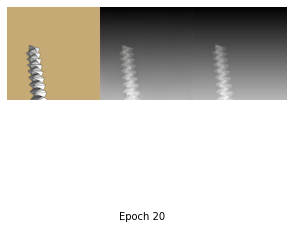

Epoch [21/50], Step [1/3750], D_loss: 0.5066, G_loss: 5.5443
Epoch [21/50], Step [2/3750], D_loss: 0.2549, G_loss: 9.7113
Epoch [21/50], Step [3/3750], D_loss: 0.3519, G_loss: 17.7623
Epoch [21/50], Step [4/3750], D_loss: 0.5422, G_loss: 7.2332
Epoch [21/50], Step [5/3750], D_loss: 0.1828, G_loss: 6.6402
Epoch [21/50], Step [6/3750], D_loss: 0.5555, G_loss: 35.3260
Epoch [21/50], Step [7/3750], D_loss: 0.3593, G_loss: 8.4739
Epoch [21/50], Step [8/3750], D_loss: 0.2513, G_loss: 5.9234
Epoch [21/50], Step [9/3750], D_loss: 0.0871, G_loss: 13.4055
Epoch [21/50], Step [10/3750], D_loss: 0.0376, G_loss: 8.5333
Epoch [21/50], Step [11/3750], D_loss: 0.1322, G_loss: 11.1191
Epoch [21/50], Step [12/3750], D_loss: 0.2699, G_loss: 7.6059
Epoch [21/50], Step [13/3750], D_loss: 0.0194, G_loss: 13.4589
Epoch [21/50], Step [14/3750], D_loss: 0.2687, G_loss: 6.7551
Epoch [21/50], Step [15/3750], D_loss: 0.2209, G_loss: 10.8855
Epoch [21/50], Step [16/3750], D_loss: 0.1454, G_loss: 8.1414
Epoch [21/5

Epoch [21/50], Step [133/3750], D_loss: 0.0828, G_loss: 18.2082
Epoch [21/50], Step [134/3750], D_loss: 0.3141, G_loss: 4.1727
Epoch [21/50], Step [135/3750], D_loss: 0.0685, G_loss: 8.2224
Epoch [21/50], Step [136/3750], D_loss: 0.0429, G_loss: 8.9153
Epoch [21/50], Step [137/3750], D_loss: 0.1263, G_loss: 5.1071
Epoch [21/50], Step [138/3750], D_loss: 0.0343, G_loss: 6.4465
Epoch [21/50], Step [139/3750], D_loss: 0.0779, G_loss: 7.3702
Epoch [21/50], Step [140/3750], D_loss: 0.1735, G_loss: 4.3173
Epoch [21/50], Step [141/3750], D_loss: 0.0739, G_loss: 6.5737
Epoch [21/50], Step [142/3750], D_loss: 0.0509, G_loss: 9.9789
Epoch [21/50], Step [143/3750], D_loss: 0.2710, G_loss: 9.6133
Epoch [21/50], Step [144/3750], D_loss: 0.0283, G_loss: 7.2372
Epoch [21/50], Step [145/3750], D_loss: 0.0331, G_loss: 6.1937
Epoch [21/50], Step [146/3750], D_loss: 0.1059, G_loss: 6.6132
Epoch [21/50], Step [147/3750], D_loss: 0.0597, G_loss: 7.1281
Epoch [21/50], Step [148/3750], D_loss: 0.0777, G_loss

Epoch [21/50], Step [263/3750], D_loss: 0.2076, G_loss: 12.8468
Epoch [21/50], Step [264/3750], D_loss: 0.0353, G_loss: 14.9386
Epoch [21/50], Step [265/3750], D_loss: 0.0471, G_loss: 11.5444
Epoch [21/50], Step [266/3750], D_loss: 0.0127, G_loss: 13.4038
Epoch [21/50], Step [267/3750], D_loss: 0.0763, G_loss: 5.2857
Epoch [21/50], Step [268/3750], D_loss: 0.0074, G_loss: 12.5552
Epoch [21/50], Step [269/3750], D_loss: 0.0207, G_loss: 6.1493
Epoch [21/50], Step [270/3750], D_loss: 0.0196, G_loss: 10.3680
Epoch [21/50], Step [271/3750], D_loss: 0.5444, G_loss: 7.2073
Epoch [21/50], Step [272/3750], D_loss: 0.0447, G_loss: 6.1253
Epoch [21/50], Step [273/3750], D_loss: 0.8186, G_loss: 3.6410
Epoch [21/50], Step [274/3750], D_loss: 0.2279, G_loss: 6.0222
Epoch [21/50], Step [275/3750], D_loss: 0.6006, G_loss: 5.7597
Epoch [21/50], Step [276/3750], D_loss: 0.2532, G_loss: 8.1726
Epoch [21/50], Step [277/3750], D_loss: 0.1524, G_loss: 7.0345
Epoch [21/50], Step [278/3750], D_loss: 0.7131, G

Epoch [21/50], Step [393/3750], D_loss: 0.0160, G_loss: 10.3229
Epoch [21/50], Step [394/3750], D_loss: 0.4021, G_loss: 14.2715
Epoch [21/50], Step [395/3750], D_loss: 0.0670, G_loss: 20.1017
Epoch [21/50], Step [396/3750], D_loss: 0.5227, G_loss: 8.6051
Epoch [21/50], Step [397/3750], D_loss: 0.2587, G_loss: 7.6099
Epoch [21/50], Step [398/3750], D_loss: 0.0048, G_loss: 13.8424
Epoch [21/50], Step [399/3750], D_loss: 1.2225, G_loss: 8.2237
Epoch [21/50], Step [400/3750], D_loss: 0.1102, G_loss: 5.1258
Epoch [21/50], Step [401/3750], D_loss: 0.1001, G_loss: 6.9387
Epoch [21/50], Step [402/3750], D_loss: 0.5174, G_loss: 9.7465
Epoch [21/50], Step [403/3750], D_loss: 0.5686, G_loss: 4.0138
Epoch [21/50], Step [404/3750], D_loss: 0.3642, G_loss: 9.0528
Epoch [21/50], Step [405/3750], D_loss: 0.1984, G_loss: 7.7706
Epoch [21/50], Step [406/3750], D_loss: 0.3914, G_loss: 4.8463
Epoch [21/50], Step [407/3750], D_loss: 1.0636, G_loss: 8.2197
Epoch [21/50], Step [408/3750], D_loss: 0.2027, G_l

Epoch [21/50], Step [523/3750], D_loss: 0.0098, G_loss: 11.9623
Epoch [21/50], Step [524/3750], D_loss: 0.1037, G_loss: 7.6222
Epoch [21/50], Step [525/3750], D_loss: 0.0105, G_loss: 6.7931
Epoch [21/50], Step [526/3750], D_loss: 0.0083, G_loss: 9.6114
Epoch [21/50], Step [527/3750], D_loss: 0.1302, G_loss: 8.2778
Epoch [21/50], Step [528/3750], D_loss: 0.0083, G_loss: 16.6924
Epoch [21/50], Step [529/3750], D_loss: 0.0307, G_loss: 11.1984
Epoch [21/50], Step [530/3750], D_loss: 0.1259, G_loss: 14.5605
Epoch [21/50], Step [531/3750], D_loss: 0.1984, G_loss: 20.0289
Epoch [21/50], Step [532/3750], D_loss: 0.1253, G_loss: 13.9783
Epoch [21/50], Step [533/3750], D_loss: 0.0632, G_loss: 7.2668
Epoch [21/50], Step [534/3750], D_loss: 0.0558, G_loss: 8.5842
Epoch [21/50], Step [535/3750], D_loss: 0.0250, G_loss: 5.5178
Epoch [21/50], Step [536/3750], D_loss: 0.0440, G_loss: 9.7755
Epoch [21/50], Step [537/3750], D_loss: 0.0139, G_loss: 14.3084
Epoch [21/50], Step [538/3750], D_loss: 0.0122, 

Epoch [21/50], Step [653/3750], D_loss: 0.0527, G_loss: 9.0158
Epoch [21/50], Step [654/3750], D_loss: 0.0167, G_loss: 7.9803
Epoch [21/50], Step [655/3750], D_loss: 0.0197, G_loss: 5.9154
Epoch [21/50], Step [656/3750], D_loss: 0.0145, G_loss: 6.6714
Epoch [21/50], Step [657/3750], D_loss: 0.0324, G_loss: 10.5221
Epoch [21/50], Step [658/3750], D_loss: 0.1623, G_loss: 6.5912
Epoch [21/50], Step [659/3750], D_loss: 0.1256, G_loss: 6.1902
Epoch [21/50], Step [660/3750], D_loss: 0.0727, G_loss: 5.5426
Epoch [21/50], Step [661/3750], D_loss: 0.1034, G_loss: 11.4025
Epoch [21/50], Step [662/3750], D_loss: 0.0616, G_loss: 12.1499
Epoch [21/50], Step [663/3750], D_loss: 0.2259, G_loss: 7.7744
Epoch [21/50], Step [664/3750], D_loss: 0.0627, G_loss: 10.3010
Epoch [21/50], Step [665/3750], D_loss: 0.1612, G_loss: 6.5495
Epoch [21/50], Step [666/3750], D_loss: 0.0835, G_loss: 9.2805
Epoch [21/50], Step [667/3750], D_loss: 0.0508, G_loss: 4.9340
Epoch [21/50], Step [668/3750], D_loss: 0.0177, G_l

Epoch [21/50], Step [783/3750], D_loss: 0.3298, G_loss: 7.6521
Epoch [21/50], Step [784/3750], D_loss: 0.0862, G_loss: 11.1203
Epoch [21/50], Step [785/3750], D_loss: 0.2693, G_loss: 7.5410
Epoch [21/50], Step [786/3750], D_loss: 0.0114, G_loss: 12.7840
Epoch [21/50], Step [787/3750], D_loss: 0.1261, G_loss: 12.0333
Epoch [21/50], Step [788/3750], D_loss: 0.3328, G_loss: 8.9820
Epoch [21/50], Step [789/3750], D_loss: 0.1287, G_loss: 9.8405
Epoch [21/50], Step [790/3750], D_loss: 0.2800, G_loss: 8.0737
Epoch [21/50], Step [791/3750], D_loss: 0.5151, G_loss: 8.4571
Epoch [21/50], Step [792/3750], D_loss: 0.0395, G_loss: 11.8448
Epoch [21/50], Step [793/3750], D_loss: 0.1365, G_loss: 7.7174
Epoch [21/50], Step [794/3750], D_loss: 0.2761, G_loss: 9.7849
Epoch [21/50], Step [795/3750], D_loss: 0.0076, G_loss: 9.9965
Epoch [21/50], Step [796/3750], D_loss: 0.8980, G_loss: 8.4813
Epoch [21/50], Step [797/3750], D_loss: 0.1642, G_loss: 7.4421
Epoch [21/50], Step [798/3750], D_loss: 0.2782, G_l

Epoch [21/50], Step [913/3750], D_loss: 0.0101, G_loss: 6.8915
Epoch [21/50], Step [914/3750], D_loss: 0.0079, G_loss: 8.0131
Epoch [21/50], Step [915/3750], D_loss: 0.0127, G_loss: 7.2895
Epoch [21/50], Step [916/3750], D_loss: 0.0862, G_loss: 9.8149
Epoch [21/50], Step [917/3750], D_loss: 0.0206, G_loss: 10.9735
Epoch [21/50], Step [918/3750], D_loss: 0.0325, G_loss: 8.0432
Epoch [21/50], Step [919/3750], D_loss: 0.0577, G_loss: 5.4879
Epoch [21/50], Step [920/3750], D_loss: 0.0072, G_loss: 9.1220
Epoch [21/50], Step [921/3750], D_loss: 0.2529, G_loss: 9.2150
Epoch [21/50], Step [922/3750], D_loss: 0.0850, G_loss: 11.8287
Epoch [21/50], Step [923/3750], D_loss: 0.0138, G_loss: 5.9827
Epoch [21/50], Step [924/3750], D_loss: 0.0119, G_loss: 10.4377
Epoch [21/50], Step [925/3750], D_loss: 0.0219, G_loss: 11.8591
Epoch [21/50], Step [926/3750], D_loss: 0.0284, G_loss: 7.4011
Epoch [21/50], Step [927/3750], D_loss: 0.0503, G_loss: 7.8011
Epoch [21/50], Step [928/3750], D_loss: 0.0436, G_l

Epoch [21/50], Step [1042/3750], D_loss: 0.1114, G_loss: 9.2058
Epoch [21/50], Step [1043/3750], D_loss: 0.1393, G_loss: 7.5255
Epoch [21/50], Step [1044/3750], D_loss: 0.0635, G_loss: 9.6075
Epoch [21/50], Step [1045/3750], D_loss: 0.0864, G_loss: 10.6489
Epoch [21/50], Step [1046/3750], D_loss: 0.0133, G_loss: 6.8517
Epoch [21/50], Step [1047/3750], D_loss: 0.0445, G_loss: 6.6904
Epoch [21/50], Step [1048/3750], D_loss: 0.0110, G_loss: 6.8733
Epoch [21/50], Step [1049/3750], D_loss: 0.1093, G_loss: 5.5322
Epoch [21/50], Step [1050/3750], D_loss: 0.0801, G_loss: 4.9553
Epoch [21/50], Step [1051/3750], D_loss: 0.0035, G_loss: 16.6433
Epoch [21/50], Step [1052/3750], D_loss: 0.1319, G_loss: 9.1987
Epoch [21/50], Step [1053/3750], D_loss: 0.0259, G_loss: 11.3215
Epoch [21/50], Step [1054/3750], D_loss: 0.0538, G_loss: 4.8199
Epoch [21/50], Step [1055/3750], D_loss: 0.0485, G_loss: 10.5224
Epoch [21/50], Step [1056/3750], D_loss: 0.0141, G_loss: 8.1030
Epoch [21/50], Step [1057/3750], D_l

Epoch [21/50], Step [1170/3750], D_loss: 0.0112, G_loss: 9.7093
Epoch [21/50], Step [1171/3750], D_loss: 0.1092, G_loss: 7.3876
Epoch [21/50], Step [1172/3750], D_loss: 0.0174, G_loss: 9.9137
Epoch [21/50], Step [1173/3750], D_loss: 0.1357, G_loss: 4.7073
Epoch [21/50], Step [1174/3750], D_loss: 0.0018, G_loss: 18.8824
Epoch [21/50], Step [1175/3750], D_loss: 0.0844, G_loss: 9.4286
Epoch [21/50], Step [1176/3750], D_loss: 0.0419, G_loss: 7.9406
Epoch [21/50], Step [1177/3750], D_loss: 0.0918, G_loss: 6.0839
Epoch [21/50], Step [1178/3750], D_loss: 0.0184, G_loss: 8.1383
Epoch [21/50], Step [1179/3750], D_loss: 0.0554, G_loss: 6.2146
Epoch [21/50], Step [1180/3750], D_loss: 0.0759, G_loss: 9.3903
Epoch [21/50], Step [1181/3750], D_loss: 0.0091, G_loss: 6.9441
Epoch [21/50], Step [1182/3750], D_loss: 0.0088, G_loss: 12.3295
Epoch [21/50], Step [1183/3750], D_loss: 0.0145, G_loss: 10.2674
Epoch [21/50], Step [1184/3750], D_loss: 0.1218, G_loss: 5.0029
Epoch [21/50], Step [1185/3750], D_lo

Epoch [21/50], Step [1298/3750], D_loss: 0.0125, G_loss: 9.3788
Epoch [21/50], Step [1299/3750], D_loss: 0.0609, G_loss: 5.8125
Epoch [21/50], Step [1300/3750], D_loss: 0.0533, G_loss: 9.2184
Epoch [21/50], Step [1301/3750], D_loss: 0.0030, G_loss: 10.2365
Epoch [21/50], Step [1302/3750], D_loss: 0.0195, G_loss: 7.7839
Epoch [21/50], Step [1303/3750], D_loss: 0.5357, G_loss: 4.9225
Epoch [21/50], Step [1304/3750], D_loss: 0.0047, G_loss: 8.7421
Epoch [21/50], Step [1305/3750], D_loss: 0.0185, G_loss: 10.3081
Epoch [21/50], Step [1306/3750], D_loss: 0.0098, G_loss: 11.5859
Epoch [21/50], Step [1307/3750], D_loss: 0.0286, G_loss: 14.8334
Epoch [21/50], Step [1308/3750], D_loss: 0.0859, G_loss: 13.5624
Epoch [21/50], Step [1309/3750], D_loss: 0.0042, G_loss: 7.4110
Epoch [21/50], Step [1310/3750], D_loss: 0.0107, G_loss: 7.0620
Epoch [21/50], Step [1311/3750], D_loss: 0.0072, G_loss: 7.7794
Epoch [21/50], Step [1312/3750], D_loss: 0.2142, G_loss: 6.5930
Epoch [21/50], Step [1313/3750], D_

Epoch [21/50], Step [1426/3750], D_loss: 0.0663, G_loss: 6.5243
Epoch [21/50], Step [1427/3750], D_loss: 0.0163, G_loss: 14.3749
Epoch [21/50], Step [1428/3750], D_loss: 0.1936, G_loss: 5.2558
Epoch [21/50], Step [1429/3750], D_loss: 0.1677, G_loss: 6.1718
Epoch [21/50], Step [1430/3750], D_loss: 0.0075, G_loss: 21.0060
Epoch [21/50], Step [1431/3750], D_loss: 0.0135, G_loss: 12.1250
Epoch [21/50], Step [1432/3750], D_loss: 0.0227, G_loss: 8.7150
Epoch [21/50], Step [1433/3750], D_loss: 0.0517, G_loss: 11.9654
Epoch [21/50], Step [1434/3750], D_loss: 0.0280, G_loss: 5.8771
Epoch [21/50], Step [1435/3750], D_loss: 0.0937, G_loss: 8.9738
Epoch [21/50], Step [1436/3750], D_loss: 0.3618, G_loss: 6.2741
Epoch [21/50], Step [1437/3750], D_loss: 0.5462, G_loss: 6.5058
Epoch [21/50], Step [1438/3750], D_loss: 0.5921, G_loss: 6.3301
Epoch [21/50], Step [1439/3750], D_loss: 0.3589, G_loss: 4.9340
Epoch [21/50], Step [1440/3750], D_loss: 0.1614, G_loss: 8.2779
Epoch [21/50], Step [1441/3750], D_l

Epoch [21/50], Step [1554/3750], D_loss: 0.0104, G_loss: 9.1744
Epoch [21/50], Step [1555/3750], D_loss: 0.0630, G_loss: 8.3477
Epoch [21/50], Step [1556/3750], D_loss: 0.3456, G_loss: 4.5990
Epoch [21/50], Step [1557/3750], D_loss: 0.2393, G_loss: 9.0538
Epoch [21/50], Step [1558/3750], D_loss: 0.0703, G_loss: 11.9183
Epoch [21/50], Step [1559/3750], D_loss: 0.0443, G_loss: 9.5899
Epoch [21/50], Step [1560/3750], D_loss: 0.0185, G_loss: 12.8421
Epoch [21/50], Step [1561/3750], D_loss: 0.0612, G_loss: 7.4527
Epoch [21/50], Step [1562/3750], D_loss: 0.5663, G_loss: 7.5448
Epoch [21/50], Step [1563/3750], D_loss: 0.0862, G_loss: 10.2994
Epoch [21/50], Step [1564/3750], D_loss: 0.3714, G_loss: 6.8077
Epoch [21/50], Step [1565/3750], D_loss: 0.4483, G_loss: 9.9404
Epoch [21/50], Step [1566/3750], D_loss: 0.2497, G_loss: 5.9655
Epoch [21/50], Step [1567/3750], D_loss: 0.1523, G_loss: 10.5763
Epoch [21/50], Step [1568/3750], D_loss: 0.2148, G_loss: 7.4678
Epoch [21/50], Step [1569/3750], D_l

Epoch [21/50], Step [1682/3750], D_loss: 0.2063, G_loss: 8.2432
Epoch [21/50], Step [1683/3750], D_loss: 0.0236, G_loss: 7.6319
Epoch [21/50], Step [1684/3750], D_loss: 0.2667, G_loss: 9.6690
Epoch [21/50], Step [1685/3750], D_loss: 0.0399, G_loss: 13.5408
Epoch [21/50], Step [1686/3750], D_loss: 0.3512, G_loss: 5.1921
Epoch [21/50], Step [1687/3750], D_loss: 0.2872, G_loss: 9.4317
Epoch [21/50], Step [1688/3750], D_loss: 0.2038, G_loss: 5.4791
Epoch [21/50], Step [1689/3750], D_loss: 0.0333, G_loss: 9.9665
Epoch [21/50], Step [1690/3750], D_loss: 0.5399, G_loss: 5.8707
Epoch [21/50], Step [1691/3750], D_loss: 0.1744, G_loss: 8.2414
Epoch [21/50], Step [1692/3750], D_loss: 0.2205, G_loss: 7.3358
Epoch [21/50], Step [1693/3750], D_loss: 0.5416, G_loss: 9.0914
Epoch [21/50], Step [1694/3750], D_loss: 0.4329, G_loss: 9.3585
Epoch [21/50], Step [1695/3750], D_loss: 0.0654, G_loss: 10.9647
Epoch [21/50], Step [1696/3750], D_loss: 0.0381, G_loss: 15.2026
Epoch [21/50], Step [1697/3750], D_lo

Epoch [21/50], Step [1810/3750], D_loss: 0.0840, G_loss: 9.9179
Epoch [21/50], Step [1811/3750], D_loss: 0.2385, G_loss: 7.2255
Epoch [21/50], Step [1812/3750], D_loss: 0.3216, G_loss: 10.1685
Epoch [21/50], Step [1813/3750], D_loss: 0.0718, G_loss: 14.5258
Epoch [21/50], Step [1814/3750], D_loss: 1.4447, G_loss: 7.5757
Epoch [21/50], Step [1815/3750], D_loss: 0.3760, G_loss: 5.6144
Epoch [21/50], Step [1816/3750], D_loss: 0.7242, G_loss: 10.3378
Epoch [21/50], Step [1817/3750], D_loss: 0.2088, G_loss: 6.3956
Epoch [21/50], Step [1818/3750], D_loss: 0.4673, G_loss: 9.4494
Epoch [21/50], Step [1819/3750], D_loss: 0.2076, G_loss: 7.4308
Epoch [21/50], Step [1820/3750], D_loss: 0.1557, G_loss: 9.6806
Epoch [21/50], Step [1821/3750], D_loss: 0.0436, G_loss: 12.9192
Epoch [21/50], Step [1822/3750], D_loss: 0.1159, G_loss: 12.0252
Epoch [21/50], Step [1823/3750], D_loss: 0.1601, G_loss: 8.1670
Epoch [21/50], Step [1824/3750], D_loss: 0.0994, G_loss: 5.9127
Epoch [21/50], Step [1825/3750], D_

Epoch [21/50], Step [1938/3750], D_loss: 0.0874, G_loss: 5.6902
Epoch [21/50], Step [1939/3750], D_loss: 0.1445, G_loss: 5.9120
Epoch [21/50], Step [1940/3750], D_loss: 0.1525, G_loss: 9.8575
Epoch [21/50], Step [1941/3750], D_loss: 0.0125, G_loss: 9.8034
Epoch [21/50], Step [1942/3750], D_loss: 0.0866, G_loss: 10.0583
Epoch [21/50], Step [1943/3750], D_loss: 0.0628, G_loss: 7.0490
Epoch [21/50], Step [1944/3750], D_loss: 0.0615, G_loss: 5.9504
Epoch [21/50], Step [1945/3750], D_loss: 0.4675, G_loss: 5.9469
Epoch [21/50], Step [1946/3750], D_loss: 0.0300, G_loss: 10.5515
Epoch [21/50], Step [1947/3750], D_loss: 0.2002, G_loss: 3.4121
Epoch [21/50], Step [1948/3750], D_loss: 0.0128, G_loss: 12.4224
Epoch [21/50], Step [1949/3750], D_loss: 0.1547, G_loss: 4.3331
Epoch [21/50], Step [1950/3750], D_loss: 0.1360, G_loss: 6.8213
Epoch [21/50], Step [1951/3750], D_loss: 0.0607, G_loss: 5.4385
Epoch [21/50], Step [1952/3750], D_loss: 0.0349, G_loss: 15.1994
Epoch [21/50], Step [1953/3750], D_l

Epoch [21/50], Step [2066/3750], D_loss: 0.0173, G_loss: 13.7326
Epoch [21/50], Step [2067/3750], D_loss: 0.0248, G_loss: 13.3076
Epoch [21/50], Step [2068/3750], D_loss: 0.0122, G_loss: 6.2256
Epoch [21/50], Step [2069/3750], D_loss: 0.0258, G_loss: 9.8989
Epoch [21/50], Step [2070/3750], D_loss: 0.2768, G_loss: 5.9132
Epoch [21/50], Step [2071/3750], D_loss: 0.0560, G_loss: 10.1934
Epoch [21/50], Step [2072/3750], D_loss: 0.2391, G_loss: 6.1976
Epoch [21/50], Step [2073/3750], D_loss: 0.0244, G_loss: 15.9750
Epoch [21/50], Step [2074/3750], D_loss: 0.0285, G_loss: 10.7948
Epoch [21/50], Step [2075/3750], D_loss: 0.0653, G_loss: 9.8951
Epoch [21/50], Step [2076/3750], D_loss: 0.1320, G_loss: 5.3166
Epoch [21/50], Step [2077/3750], D_loss: 0.0042, G_loss: 8.2693
Epoch [21/50], Step [2078/3750], D_loss: 0.1463, G_loss: 8.5872
Epoch [21/50], Step [2079/3750], D_loss: 0.0085, G_loss: 13.5214
Epoch [21/50], Step [2080/3750], D_loss: 0.0206, G_loss: 13.7231
Epoch [21/50], Step [2081/3750], 

Epoch [21/50], Step [2194/3750], D_loss: 0.0068, G_loss: 11.6060
Epoch [21/50], Step [2195/3750], D_loss: 0.0650, G_loss: 8.4047
Epoch [21/50], Step [2196/3750], D_loss: 0.1335, G_loss: 7.3128
Epoch [21/50], Step [2197/3750], D_loss: 0.0248, G_loss: 13.4660
Epoch [21/50], Step [2198/3750], D_loss: 0.1629, G_loss: 6.3745
Epoch [21/50], Step [2199/3750], D_loss: 0.0543, G_loss: 9.8432
Epoch [21/50], Step [2200/3750], D_loss: 0.0732, G_loss: 6.1655
Epoch [21/50], Step [2201/3750], D_loss: 0.0313, G_loss: 6.7569
Epoch [21/50], Step [2202/3750], D_loss: 0.0185, G_loss: 8.6541
Epoch [21/50], Step [2203/3750], D_loss: 0.1212, G_loss: 7.9453
Epoch [21/50], Step [2204/3750], D_loss: 0.0056, G_loss: 11.3650
Epoch [21/50], Step [2205/3750], D_loss: 0.0070, G_loss: 9.1554
Epoch [21/50], Step [2206/3750], D_loss: 0.0038, G_loss: 13.0622
Epoch [21/50], Step [2207/3750], D_loss: 0.1251, G_loss: 9.7943
Epoch [21/50], Step [2208/3750], D_loss: 0.0056, G_loss: 7.4913
Epoch [21/50], Step [2209/3750], D_l

Epoch [21/50], Step [2322/3750], D_loss: 0.3235, G_loss: 9.4747
Epoch [21/50], Step [2323/3750], D_loss: 0.3388, G_loss: 4.2632
Epoch [21/50], Step [2324/3750], D_loss: 0.3915, G_loss: 4.0321
Epoch [21/50], Step [2325/3750], D_loss: 0.0133, G_loss: 10.1218
Epoch [21/50], Step [2326/3750], D_loss: 0.1121, G_loss: 11.6766
Epoch [21/50], Step [2327/3750], D_loss: 0.0234, G_loss: 9.3476
Epoch [21/50], Step [2328/3750], D_loss: 0.0061, G_loss: 12.8645
Epoch [21/50], Step [2329/3750], D_loss: 0.0285, G_loss: 6.9095
Epoch [21/50], Step [2330/3750], D_loss: 0.0071, G_loss: 7.1799
Epoch [21/50], Step [2331/3750], D_loss: 0.3078, G_loss: 7.3357
Epoch [21/50], Step [2332/3750], D_loss: 0.0418, G_loss: 7.3108
Epoch [21/50], Step [2333/3750], D_loss: 0.0167, G_loss: 17.5437
Epoch [21/50], Step [2334/3750], D_loss: 0.0017, G_loss: 9.3163
Epoch [21/50], Step [2335/3750], D_loss: 0.0046, G_loss: 14.5605
Epoch [21/50], Step [2336/3750], D_loss: 0.0095, G_loss: 7.7604
Epoch [21/50], Step [2337/3750], D_

Epoch [21/50], Step [2450/3750], D_loss: 0.0646, G_loss: 9.8642
Epoch [21/50], Step [2451/3750], D_loss: 0.0643, G_loss: 7.2880
Epoch [21/50], Step [2452/3750], D_loss: 0.0221, G_loss: 8.0119
Epoch [21/50], Step [2453/3750], D_loss: 0.0355, G_loss: 16.1344
Epoch [21/50], Step [2454/3750], D_loss: 0.1785, G_loss: 13.8440
Epoch [21/50], Step [2455/3750], D_loss: 0.1177, G_loss: 8.2052
Epoch [21/50], Step [2456/3750], D_loss: 0.0698, G_loss: 6.8047
Epoch [21/50], Step [2457/3750], D_loss: 0.0203, G_loss: 9.6881
Epoch [21/50], Step [2458/3750], D_loss: 0.0025, G_loss: 12.2817
Epoch [21/50], Step [2459/3750], D_loss: 0.0300, G_loss: 6.8924
Epoch [21/50], Step [2460/3750], D_loss: 0.0133, G_loss: 10.2328
Epoch [21/50], Step [2461/3750], D_loss: 0.3134, G_loss: 5.9664
Epoch [21/50], Step [2462/3750], D_loss: 0.3729, G_loss: 10.1133
Epoch [21/50], Step [2463/3750], D_loss: 0.0808, G_loss: 13.2100
Epoch [21/50], Step [2464/3750], D_loss: 0.0400, G_loss: 7.9957
Epoch [21/50], Step [2465/3750], D

Epoch [21/50], Step [2578/3750], D_loss: 0.1993, G_loss: 6.3450
Epoch [21/50], Step [2579/3750], D_loss: 0.0444, G_loss: 9.7253
Epoch [21/50], Step [2580/3750], D_loss: 0.0179, G_loss: 43.9273
Epoch [21/50], Step [2581/3750], D_loss: 0.6873, G_loss: 6.1354
Epoch [21/50], Step [2582/3750], D_loss: 0.0069, G_loss: 9.4168
Epoch [21/50], Step [2583/3750], D_loss: 0.3334, G_loss: 7.4025
Epoch [21/50], Step [2584/3750], D_loss: 0.0116, G_loss: 12.9274
Epoch [21/50], Step [2585/3750], D_loss: 0.1060, G_loss: 14.1146
Epoch [21/50], Step [2586/3750], D_loss: 0.0222, G_loss: 11.2604
Epoch [21/50], Step [2587/3750], D_loss: 0.0157, G_loss: 7.8762
Epoch [21/50], Step [2588/3750], D_loss: 0.1502, G_loss: 8.3045
Epoch [21/50], Step [2589/3750], D_loss: 0.3958, G_loss: 3.7114
Epoch [21/50], Step [2590/3750], D_loss: 0.0874, G_loss: 7.1522
Epoch [21/50], Step [2591/3750], D_loss: 0.0131, G_loss: 11.0294
Epoch [21/50], Step [2592/3750], D_loss: 0.0262, G_loss: 6.9909
Epoch [21/50], Step [2593/3750], D_

Epoch [21/50], Step [2706/3750], D_loss: 0.0128, G_loss: 5.7672
Epoch [21/50], Step [2707/3750], D_loss: 0.0371, G_loss: 6.0721
Epoch [21/50], Step [2708/3750], D_loss: 0.0751, G_loss: 8.6695
Epoch [21/50], Step [2709/3750], D_loss: 0.0073, G_loss: 11.4387
Epoch [21/50], Step [2710/3750], D_loss: 0.0408, G_loss: 7.4384
Epoch [21/50], Step [2711/3750], D_loss: 0.0145, G_loss: 14.2033
Epoch [21/50], Step [2712/3750], D_loss: 0.0037, G_loss: 11.2035
Epoch [21/50], Step [2713/3750], D_loss: 0.0039, G_loss: 16.3852
Epoch [21/50], Step [2714/3750], D_loss: 0.1094, G_loss: 7.4279
Epoch [21/50], Step [2715/3750], D_loss: 0.2576, G_loss: 4.7961
Epoch [21/50], Step [2716/3750], D_loss: 0.0126, G_loss: 8.0046
Epoch [21/50], Step [2717/3750], D_loss: 0.3954, G_loss: 8.1222
Epoch [21/50], Step [2718/3750], D_loss: 0.0211, G_loss: 10.1810
Epoch [21/50], Step [2719/3750], D_loss: 0.2949, G_loss: 25.0514
Epoch [21/50], Step [2720/3750], D_loss: 0.0425, G_loss: 11.8948
Epoch [21/50], Step [2721/3750], 

Epoch [21/50], Step [2834/3750], D_loss: 0.2068, G_loss: 15.5975
Epoch [21/50], Step [2835/3750], D_loss: 0.0127, G_loss: 9.6468
Epoch [21/50], Step [2836/3750], D_loss: 0.0159, G_loss: 9.4744
Epoch [21/50], Step [2837/3750], D_loss: 0.0316, G_loss: 8.2804
Epoch [21/50], Step [2838/3750], D_loss: 0.0162, G_loss: 6.6283
Epoch [21/50], Step [2839/3750], D_loss: 0.4544, G_loss: 23.7800
Epoch [21/50], Step [2840/3750], D_loss: 0.0133, G_loss: 12.9401
Epoch [21/50], Step [2841/3750], D_loss: 0.0108, G_loss: 11.7917
Epoch [21/50], Step [2842/3750], D_loss: 0.0903, G_loss: 9.5760
Epoch [21/50], Step [2843/3750], D_loss: 0.0433, G_loss: 7.2276
Epoch [21/50], Step [2844/3750], D_loss: 0.0294, G_loss: 13.4539
Epoch [21/50], Step [2845/3750], D_loss: 0.3796, G_loss: 9.1182
Epoch [21/50], Step [2846/3750], D_loss: 0.0546, G_loss: 9.2939
Epoch [21/50], Step [2847/3750], D_loss: 0.1973, G_loss: 8.2692
Epoch [21/50], Step [2848/3750], D_loss: 0.1008, G_loss: 14.2967
Epoch [21/50], Step [2849/3750], D

Epoch [21/50], Step [2962/3750], D_loss: 0.3469, G_loss: 4.5953
Epoch [21/50], Step [2963/3750], D_loss: 0.0700, G_loss: 6.3279
Epoch [21/50], Step [2964/3750], D_loss: 0.0277, G_loss: 9.5391
Epoch [21/50], Step [2965/3750], D_loss: 0.0325, G_loss: 7.9070
Epoch [21/50], Step [2966/3750], D_loss: 0.2286, G_loss: 6.5922
Epoch [21/50], Step [2967/3750], D_loss: 0.1206, G_loss: 8.8355
Epoch [21/50], Step [2968/3750], D_loss: 0.2286, G_loss: 12.3294
Epoch [21/50], Step [2969/3750], D_loss: 0.0226, G_loss: 14.4334
Epoch [21/50], Step [2970/3750], D_loss: 0.0539, G_loss: 6.2175
Epoch [21/50], Step [2971/3750], D_loss: 0.0159, G_loss: 11.7476
Epoch [21/50], Step [2972/3750], D_loss: 0.0141, G_loss: 10.1987
Epoch [21/50], Step [2973/3750], D_loss: 0.0116, G_loss: 7.7507
Epoch [21/50], Step [2974/3750], D_loss: 0.0237, G_loss: 12.3472
Epoch [21/50], Step [2975/3750], D_loss: 0.0491, G_loss: 6.3737
Epoch [21/50], Step [2976/3750], D_loss: 0.0035, G_loss: 17.1138
Epoch [21/50], Step [2977/3750], D

Epoch [21/50], Step [3090/3750], D_loss: 0.5933, G_loss: 21.0009
Epoch [21/50], Step [3091/3750], D_loss: 0.2630, G_loss: 5.7791
Epoch [21/50], Step [3092/3750], D_loss: 0.2996, G_loss: 6.6785
Epoch [21/50], Step [3093/3750], D_loss: 0.0027, G_loss: 10.2214
Epoch [21/50], Step [3094/3750], D_loss: 0.1388, G_loss: 7.4574
Epoch [21/50], Step [3095/3750], D_loss: 0.0062, G_loss: 7.7369
Epoch [21/50], Step [3096/3750], D_loss: 0.5214, G_loss: 7.6963
Epoch [21/50], Step [3097/3750], D_loss: 0.2715, G_loss: 8.7534
Epoch [21/50], Step [3098/3750], D_loss: 0.1314, G_loss: 7.4348
Epoch [21/50], Step [3099/3750], D_loss: 0.0573, G_loss: 12.0224
Epoch [21/50], Step [3100/3750], D_loss: 0.0640, G_loss: 10.7348
Epoch [21/50], Step [3101/3750], D_loss: 0.0090, G_loss: 13.2633
Epoch [21/50], Step [3102/3750], D_loss: 0.1125, G_loss: 7.3093
Epoch [21/50], Step [3103/3750], D_loss: 0.0390, G_loss: 9.3979
Epoch [21/50], Step [3104/3750], D_loss: 0.0059, G_loss: 9.8167
Epoch [21/50], Step [3105/3750], D_

Epoch [21/50], Step [3218/3750], D_loss: 0.1789, G_loss: 5.7063
Epoch [21/50], Step [3219/3750], D_loss: 0.0076, G_loss: 12.5846
Epoch [21/50], Step [3220/3750], D_loss: 0.0198, G_loss: 8.8352
Epoch [21/50], Step [3221/3750], D_loss: 0.0154, G_loss: 10.2900
Epoch [21/50], Step [3222/3750], D_loss: 0.5360, G_loss: 6.4105
Epoch [21/50], Step [3223/3750], D_loss: 0.0218, G_loss: 9.1421
Epoch [21/50], Step [3224/3750], D_loss: 0.2393, G_loss: 5.9445
Epoch [21/50], Step [3225/3750], D_loss: 0.0313, G_loss: 5.6947
Epoch [21/50], Step [3226/3750], D_loss: 0.1672, G_loss: 9.5466
Epoch [21/50], Step [3227/3750], D_loss: 0.1042, G_loss: 6.9965
Epoch [21/50], Step [3228/3750], D_loss: 0.1445, G_loss: 5.9065
Epoch [21/50], Step [3229/3750], D_loss: 0.0108, G_loss: 8.0238
Epoch [21/50], Step [3230/3750], D_loss: 0.0136, G_loss: 8.3534
Epoch [21/50], Step [3231/3750], D_loss: 0.1490, G_loss: 6.2388
Epoch [21/50], Step [3232/3750], D_loss: 0.0238, G_loss: 17.3612
Epoch [21/50], Step [3233/3750], D_lo

Epoch [21/50], Step [3346/3750], D_loss: 0.1262, G_loss: 6.9319
Epoch [21/50], Step [3347/3750], D_loss: 0.0408, G_loss: 7.8798
Epoch [21/50], Step [3348/3750], D_loss: 0.0075, G_loss: 11.5570
Epoch [21/50], Step [3349/3750], D_loss: 0.0060, G_loss: 9.1456
Epoch [21/50], Step [3350/3750], D_loss: 0.2346, G_loss: 13.4472
Epoch [21/50], Step [3351/3750], D_loss: 0.0107, G_loss: 11.6898
Epoch [21/50], Step [3352/3750], D_loss: 0.1009, G_loss: 14.1840
Epoch [21/50], Step [3353/3750], D_loss: 0.0062, G_loss: 9.1255
Epoch [21/50], Step [3354/3750], D_loss: 0.0578, G_loss: 8.0065
Epoch [21/50], Step [3355/3750], D_loss: 0.0190, G_loss: 12.8846
Epoch [21/50], Step [3356/3750], D_loss: 0.1621, G_loss: 5.2704
Epoch [21/50], Step [3357/3750], D_loss: 0.0592, G_loss: 9.7053
Epoch [21/50], Step [3358/3750], D_loss: 0.0130, G_loss: 8.8586
Epoch [21/50], Step [3359/3750], D_loss: 0.0203, G_loss: 13.7539
Epoch [21/50], Step [3360/3750], D_loss: 0.0096, G_loss: 14.2110
Epoch [21/50], Step [3361/3750], 

Epoch [21/50], Step [3474/3750], D_loss: 0.0381, G_loss: 6.4570
Epoch [21/50], Step [3475/3750], D_loss: 0.0265, G_loss: 11.7708
Epoch [21/50], Step [3476/3750], D_loss: 0.0528, G_loss: 11.7213
Epoch [21/50], Step [3477/3750], D_loss: 0.0148, G_loss: 7.4051
Epoch [21/50], Step [3478/3750], D_loss: 0.0245, G_loss: 6.7090
Epoch [21/50], Step [3479/3750], D_loss: 0.2991, G_loss: 5.6734
Epoch [21/50], Step [3480/3750], D_loss: 0.0706, G_loss: 10.4286
Epoch [21/50], Step [3481/3750], D_loss: 0.0388, G_loss: 8.3659
Epoch [21/50], Step [3482/3750], D_loss: 0.0959, G_loss: 10.1824
Epoch [21/50], Step [3483/3750], D_loss: 0.0070, G_loss: 10.2097
Epoch [21/50], Step [3484/3750], D_loss: 0.1962, G_loss: 6.2635
Epoch [21/50], Step [3485/3750], D_loss: 0.0079, G_loss: 7.3574
Epoch [21/50], Step [3486/3750], D_loss: 0.1431, G_loss: 8.3007
Epoch [21/50], Step [3487/3750], D_loss: 0.0249, G_loss: 10.4594
Epoch [21/50], Step [3488/3750], D_loss: 0.0042, G_loss: 7.3522
Epoch [21/50], Step [3489/3750], D

Epoch [21/50], Step [3602/3750], D_loss: 0.3998, G_loss: 6.1394
Epoch [21/50], Step [3603/3750], D_loss: 0.0173, G_loss: 11.1420
Epoch [21/50], Step [3604/3750], D_loss: 0.2120, G_loss: 5.8656
Epoch [21/50], Step [3605/3750], D_loss: 0.1926, G_loss: 8.1218
Epoch [21/50], Step [3606/3750], D_loss: 0.0400, G_loss: 8.9760
Epoch [21/50], Step [3607/3750], D_loss: 0.0784, G_loss: 10.7545
Epoch [21/50], Step [3608/3750], D_loss: 0.0865, G_loss: 5.8795
Epoch [21/50], Step [3609/3750], D_loss: 0.6314, G_loss: 6.2775
Epoch [21/50], Step [3610/3750], D_loss: 0.0344, G_loss: 8.0412
Epoch [21/50], Step [3611/3750], D_loss: 0.3575, G_loss: 5.0559
Epoch [21/50], Step [3612/3750], D_loss: 0.2057, G_loss: 10.9229
Epoch [21/50], Step [3613/3750], D_loss: 0.3722, G_loss: 6.5895
Epoch [21/50], Step [3614/3750], D_loss: 0.0496, G_loss: 11.4313
Epoch [21/50], Step [3615/3750], D_loss: 0.1272, G_loss: 7.1299
Epoch [21/50], Step [3616/3750], D_loss: 0.1275, G_loss: 5.5977
Epoch [21/50], Step [3617/3750], D_l

Epoch [21/50], Step [3730/3750], D_loss: 0.0227, G_loss: 7.9657
Epoch [21/50], Step [3731/3750], D_loss: 0.0282, G_loss: 10.8122
Epoch [21/50], Step [3732/3750], D_loss: 0.2332, G_loss: 7.8776
Epoch [21/50], Step [3733/3750], D_loss: 0.1206, G_loss: 5.9235
Epoch [21/50], Step [3734/3750], D_loss: 0.0849, G_loss: 10.4432
Epoch [21/50], Step [3735/3750], D_loss: 0.0144, G_loss: 9.4695
Epoch [21/50], Step [3736/3750], D_loss: 0.0085, G_loss: 10.9099
Epoch [21/50], Step [3737/3750], D_loss: 0.0078, G_loss: 16.5165
Epoch [21/50], Step [3738/3750], D_loss: 0.0029, G_loss: 17.2422
Epoch [21/50], Step [3739/3750], D_loss: 0.0050, G_loss: 10.9665
Epoch [21/50], Step [3740/3750], D_loss: 0.0139, G_loss: 10.6049
Epoch [21/50], Step [3741/3750], D_loss: 0.0138, G_loss: 7.5631
Epoch [21/50], Step [3742/3750], D_loss: 0.2292, G_loss: 7.5614
Epoch [21/50], Step [3743/3750], D_loss: 0.0984, G_loss: 10.4014
Epoch [21/50], Step [3744/3750], D_loss: 0.0978, G_loss: 7.9824
Epoch [21/50], Step [3745/3750],

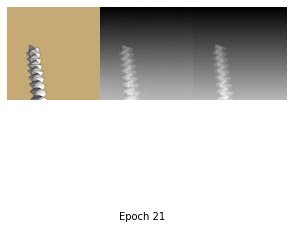

Epoch [22/50], Step [1/3750], D_loss: 0.3196, G_loss: 8.1251
Epoch [22/50], Step [2/3750], D_loss: 0.0047, G_loss: 8.3383
Epoch [22/50], Step [3/3750], D_loss: 0.0851, G_loss: 10.0270
Epoch [22/50], Step [4/3750], D_loss: 0.0701, G_loss: 9.2855
Epoch [22/50], Step [5/3750], D_loss: 0.0105, G_loss: 7.0266
Epoch [22/50], Step [6/3750], D_loss: 0.0619, G_loss: 8.4714
Epoch [22/50], Step [7/3750], D_loss: 0.0705, G_loss: 10.4297
Epoch [22/50], Step [8/3750], D_loss: 0.0054, G_loss: 14.3396
Epoch [22/50], Step [9/3750], D_loss: 0.0235, G_loss: 7.8041
Epoch [22/50], Step [10/3750], D_loss: 0.0094, G_loss: 7.2423
Epoch [22/50], Step [11/3750], D_loss: 0.0299, G_loss: 7.0399
Epoch [22/50], Step [12/3750], D_loss: 0.0291, G_loss: 7.5497
Epoch [22/50], Step [13/3750], D_loss: 0.0075, G_loss: 11.1232
Epoch [22/50], Step [14/3750], D_loss: 0.1944, G_loss: 12.9272
Epoch [22/50], Step [15/3750], D_loss: 0.0128, G_loss: 15.3736
Epoch [22/50], Step [16/3750], D_loss: 0.0889, G_loss: 12.6683
Epoch [22/

Epoch [22/50], Step [133/3750], D_loss: 0.1409, G_loss: 12.0586
Epoch [22/50], Step [134/3750], D_loss: 0.1339, G_loss: 7.2777
Epoch [22/50], Step [135/3750], D_loss: 0.5257, G_loss: 9.4117
Epoch [22/50], Step [136/3750], D_loss: 0.1655, G_loss: 4.9090
Epoch [22/50], Step [137/3750], D_loss: 0.1300, G_loss: 8.1942
Epoch [22/50], Step [138/3750], D_loss: 0.1178, G_loss: 16.8814
Epoch [22/50], Step [139/3750], D_loss: 0.0606, G_loss: 11.5343
Epoch [22/50], Step [140/3750], D_loss: 0.5589, G_loss: 6.4709
Epoch [22/50], Step [141/3750], D_loss: 0.1368, G_loss: 9.0353
Epoch [22/50], Step [142/3750], D_loss: 0.0380, G_loss: 10.1250
Epoch [22/50], Step [143/3750], D_loss: 0.0763, G_loss: 6.0902
Epoch [22/50], Step [144/3750], D_loss: 0.0125, G_loss: 6.8041
Epoch [22/50], Step [145/3750], D_loss: 0.5940, G_loss: 11.8079
Epoch [22/50], Step [146/3750], D_loss: 0.2125, G_loss: 5.8972
Epoch [22/50], Step [147/3750], D_loss: 0.2305, G_loss: 6.5552
Epoch [22/50], Step [148/3750], D_loss: 0.0250, G_

Epoch [22/50], Step [263/3750], D_loss: 0.0298, G_loss: 9.1089
Epoch [22/50], Step [264/3750], D_loss: 0.0876, G_loss: 6.9067
Epoch [22/50], Step [265/3750], D_loss: 0.0187, G_loss: 10.7378
Epoch [22/50], Step [266/3750], D_loss: 0.3823, G_loss: 5.2330
Epoch [22/50], Step [267/3750], D_loss: 0.2600, G_loss: 4.8524
Epoch [22/50], Step [268/3750], D_loss: 0.0563, G_loss: 11.9737
Epoch [22/50], Step [269/3750], D_loss: 0.1098, G_loss: 5.9377
Epoch [22/50], Step [270/3750], D_loss: 0.3515, G_loss: 9.2242
Epoch [22/50], Step [271/3750], D_loss: 0.0155, G_loss: 10.9204
Epoch [22/50], Step [272/3750], D_loss: 0.5177, G_loss: 9.1743
Epoch [22/50], Step [273/3750], D_loss: 0.2793, G_loss: 3.0069
Epoch [22/50], Step [274/3750], D_loss: 0.5469, G_loss: 7.8505
Epoch [22/50], Step [275/3750], D_loss: 0.2238, G_loss: 9.9249
Epoch [22/50], Step [276/3750], D_loss: 0.0574, G_loss: 7.3917
Epoch [22/50], Step [277/3750], D_loss: 0.3788, G_loss: 7.9176
Epoch [22/50], Step [278/3750], D_loss: 0.3855, G_lo

Epoch [22/50], Step [393/3750], D_loss: 0.2214, G_loss: 7.6157
Epoch [22/50], Step [394/3750], D_loss: 0.0796, G_loss: 12.6602
Epoch [22/50], Step [395/3750], D_loss: 0.1518, G_loss: 4.4028
Epoch [22/50], Step [396/3750], D_loss: 0.1023, G_loss: 7.5098
Epoch [22/50], Step [397/3750], D_loss: 0.4898, G_loss: 6.5372
Epoch [22/50], Step [398/3750], D_loss: 0.4792, G_loss: 3.1646
Epoch [22/50], Step [399/3750], D_loss: 0.0792, G_loss: 15.4366
Epoch [22/50], Step [400/3750], D_loss: 0.1152, G_loss: 10.4523
Epoch [22/50], Step [401/3750], D_loss: 0.0970, G_loss: 7.3644
Epoch [22/50], Step [402/3750], D_loss: 0.0328, G_loss: 4.9167
Epoch [22/50], Step [403/3750], D_loss: 0.0325, G_loss: 17.1591
Epoch [22/50], Step [404/3750], D_loss: 0.0364, G_loss: 5.9104
Epoch [22/50], Step [405/3750], D_loss: 0.0233, G_loss: 7.3709
Epoch [22/50], Step [406/3750], D_loss: 0.0107, G_loss: 10.1228
Epoch [22/50], Step [407/3750], D_loss: 0.0441, G_loss: 5.7113
Epoch [22/50], Step [408/3750], D_loss: 0.1754, G_

Epoch [22/50], Step [523/3750], D_loss: 0.0884, G_loss: 7.7320
Epoch [22/50], Step [524/3750], D_loss: 0.1053, G_loss: 13.6907
Epoch [22/50], Step [525/3750], D_loss: 0.2529, G_loss: 7.8232
Epoch [22/50], Step [526/3750], D_loss: 0.0584, G_loss: 6.8154
Epoch [22/50], Step [527/3750], D_loss: 0.1600, G_loss: 5.3122
Epoch [22/50], Step [528/3750], D_loss: 0.2099, G_loss: 6.4977
Epoch [22/50], Step [529/3750], D_loss: 0.0258, G_loss: 13.7564
Epoch [22/50], Step [530/3750], D_loss: 0.0630, G_loss: 6.1090
Epoch [22/50], Step [531/3750], D_loss: 0.2380, G_loss: 4.9178
Epoch [22/50], Step [532/3750], D_loss: 0.0664, G_loss: 6.3728
Epoch [22/50], Step [533/3750], D_loss: 0.1497, G_loss: 14.4322
Epoch [22/50], Step [534/3750], D_loss: 0.0211, G_loss: 8.3708
Epoch [22/50], Step [535/3750], D_loss: 0.1945, G_loss: 7.1558
Epoch [22/50], Step [536/3750], D_loss: 0.0772, G_loss: 12.6294
Epoch [22/50], Step [537/3750], D_loss: 0.0898, G_loss: 7.6013
Epoch [22/50], Step [538/3750], D_loss: 0.0264, G_l

Epoch [22/50], Step [653/3750], D_loss: 0.0434, G_loss: 6.4267
Epoch [22/50], Step [654/3750], D_loss: 0.0164, G_loss: 11.4294
Epoch [22/50], Step [655/3750], D_loss: 0.1874, G_loss: 5.3509
Epoch [22/50], Step [656/3750], D_loss: 0.0412, G_loss: 10.3030
Epoch [22/50], Step [657/3750], D_loss: 0.1949, G_loss: 6.1429
Epoch [22/50], Step [658/3750], D_loss: 0.0457, G_loss: 5.7239
Epoch [22/50], Step [659/3750], D_loss: 0.0292, G_loss: 9.3114
Epoch [22/50], Step [660/3750], D_loss: 0.1228, G_loss: 9.4225
Epoch [22/50], Step [661/3750], D_loss: 0.0291, G_loss: 6.9343
Epoch [22/50], Step [662/3750], D_loss: 0.1057, G_loss: 7.2913
Epoch [22/50], Step [663/3750], D_loss: 0.0912, G_loss: 8.6150
Epoch [22/50], Step [664/3750], D_loss: 0.1098, G_loss: 7.2820
Epoch [22/50], Step [665/3750], D_loss: 0.0060, G_loss: 12.4747
Epoch [22/50], Step [666/3750], D_loss: 0.0768, G_loss: 8.7772
Epoch [22/50], Step [667/3750], D_loss: 0.0583, G_loss: 5.6951
Epoch [22/50], Step [668/3750], D_loss: 0.0774, G_lo

Epoch [22/50], Step [783/3750], D_loss: 0.0336, G_loss: 8.3068
Epoch [22/50], Step [784/3750], D_loss: 0.1255, G_loss: 7.8924
Epoch [22/50], Step [785/3750], D_loss: 0.0524, G_loss: 6.8992
Epoch [22/50], Step [786/3750], D_loss: 0.0555, G_loss: 5.8853
Epoch [22/50], Step [787/3750], D_loss: 0.2203, G_loss: 8.0865
Epoch [22/50], Step [788/3750], D_loss: 0.0034, G_loss: 6.5585
Epoch [22/50], Step [789/3750], D_loss: 0.0425, G_loss: 7.5439
Epoch [22/50], Step [790/3750], D_loss: 0.0605, G_loss: 7.6739
Epoch [22/50], Step [791/3750], D_loss: 0.2858, G_loss: 8.5585
Epoch [22/50], Step [792/3750], D_loss: 0.2233, G_loss: 6.5157
Epoch [22/50], Step [793/3750], D_loss: 0.0144, G_loss: 9.9838
Epoch [22/50], Step [794/3750], D_loss: 0.0273, G_loss: 7.3528
Epoch [22/50], Step [795/3750], D_loss: 0.0601, G_loss: 7.8212
Epoch [22/50], Step [796/3750], D_loss: 0.0388, G_loss: 13.7934
Epoch [22/50], Step [797/3750], D_loss: 0.0163, G_loss: 7.3263
Epoch [22/50], Step [798/3750], D_loss: 0.0365, G_loss

Epoch [22/50], Step [913/3750], D_loss: 0.2413, G_loss: 4.1335
Epoch [22/50], Step [914/3750], D_loss: 0.0480, G_loss: 7.6783
Epoch [22/50], Step [915/3750], D_loss: 0.5009, G_loss: 5.2133
Epoch [22/50], Step [916/3750], D_loss: 0.4506, G_loss: 6.2398
Epoch [22/50], Step [917/3750], D_loss: 0.0524, G_loss: 11.3821
Epoch [22/50], Step [918/3750], D_loss: 0.1341, G_loss: 7.3351
Epoch [22/50], Step [919/3750], D_loss: 0.0514, G_loss: 8.9096
Epoch [22/50], Step [920/3750], D_loss: 0.0243, G_loss: 12.2177
Epoch [22/50], Step [921/3750], D_loss: 0.0271, G_loss: 5.4113
Epoch [22/50], Step [922/3750], D_loss: 0.0151, G_loss: 7.3829
Epoch [22/50], Step [923/3750], D_loss: 0.0513, G_loss: 12.5466
Epoch [22/50], Step [924/3750], D_loss: 0.0217, G_loss: 13.9287
Epoch [22/50], Step [925/3750], D_loss: 0.0590, G_loss: 7.6840
Epoch [22/50], Step [926/3750], D_loss: 0.0196, G_loss: 8.7352
Epoch [22/50], Step [927/3750], D_loss: 0.0082, G_loss: 9.7558
Epoch [22/50], Step [928/3750], D_loss: 0.1271, G_l

Epoch [22/50], Step [1042/3750], D_loss: 0.1457, G_loss: 9.8334
Epoch [22/50], Step [1043/3750], D_loss: 0.1342, G_loss: 6.2553
Epoch [22/50], Step [1044/3750], D_loss: 0.0752, G_loss: 6.8123
Epoch [22/50], Step [1045/3750], D_loss: 0.0029, G_loss: 7.7401
Epoch [22/50], Step [1046/3750], D_loss: 0.2418, G_loss: 6.0101
Epoch [22/50], Step [1047/3750], D_loss: 0.0499, G_loss: 6.4616
Epoch [22/50], Step [1048/3750], D_loss: 0.0371, G_loss: 10.5703
Epoch [22/50], Step [1049/3750], D_loss: 0.5766, G_loss: 6.9008
Epoch [22/50], Step [1050/3750], D_loss: 0.0115, G_loss: 8.5637
Epoch [22/50], Step [1051/3750], D_loss: 0.0123, G_loss: 12.1925
Epoch [22/50], Step [1052/3750], D_loss: 0.0216, G_loss: 11.2105
Epoch [22/50], Step [1053/3750], D_loss: 0.7777, G_loss: 4.3537
Epoch [22/50], Step [1054/3750], D_loss: 0.3243, G_loss: 9.0661
Epoch [22/50], Step [1055/3750], D_loss: 0.0289, G_loss: 6.8347
Epoch [22/50], Step [1056/3750], D_loss: 0.1812, G_loss: 5.9685
Epoch [22/50], Step [1057/3750], D_lo

Epoch [22/50], Step [1170/3750], D_loss: 0.1169, G_loss: 7.2766
Epoch [22/50], Step [1171/3750], D_loss: 0.0388, G_loss: 10.4379
Epoch [22/50], Step [1172/3750], D_loss: 0.5808, G_loss: 5.8733
Epoch [22/50], Step [1173/3750], D_loss: 0.0140, G_loss: 12.3572
Epoch [22/50], Step [1174/3750], D_loss: 0.3039, G_loss: 6.8173
Epoch [22/50], Step [1175/3750], D_loss: 0.0481, G_loss: 14.5264
Epoch [22/50], Step [1176/3750], D_loss: 0.0939, G_loss: 7.4375
Epoch [22/50], Step [1177/3750], D_loss: 0.0643, G_loss: 8.6994
Epoch [22/50], Step [1178/3750], D_loss: 0.0285, G_loss: 7.3827
Epoch [22/50], Step [1179/3750], D_loss: 0.1230, G_loss: 7.0892
Epoch [22/50], Step [1180/3750], D_loss: 0.0183, G_loss: 9.9565
Epoch [22/50], Step [1181/3750], D_loss: 0.1099, G_loss: 7.4373
Epoch [22/50], Step [1182/3750], D_loss: 0.0878, G_loss: 5.8243
Epoch [22/50], Step [1183/3750], D_loss: 0.0102, G_loss: 11.6577
Epoch [22/50], Step [1184/3750], D_loss: 0.0505, G_loss: 8.8847
Epoch [22/50], Step [1185/3750], D_l

Epoch [22/50], Step [1298/3750], D_loss: 0.0173, G_loss: 9.7428
Epoch [22/50], Step [1299/3750], D_loss: 0.0281, G_loss: 10.4387
Epoch [22/50], Step [1300/3750], D_loss: 0.0379, G_loss: 7.3933
Epoch [22/50], Step [1301/3750], D_loss: 0.1336, G_loss: 7.0295
Epoch [22/50], Step [1302/3750], D_loss: 0.0174, G_loss: 8.5380
Epoch [22/50], Step [1303/3750], D_loss: 0.0260, G_loss: 9.7674
Epoch [22/50], Step [1304/3750], D_loss: 0.0685, G_loss: 6.5408
Epoch [22/50], Step [1305/3750], D_loss: 0.0076, G_loss: 6.1812
Epoch [22/50], Step [1306/3750], D_loss: 0.0679, G_loss: 11.7141
Epoch [22/50], Step [1307/3750], D_loss: 0.0092, G_loss: 9.9003
Epoch [22/50], Step [1308/3750], D_loss: 0.0175, G_loss: 9.7438
Epoch [22/50], Step [1309/3750], D_loss: 0.0072, G_loss: 18.9351
Epoch [22/50], Step [1310/3750], D_loss: 0.0107, G_loss: 7.7757
Epoch [22/50], Step [1311/3750], D_loss: 0.0749, G_loss: 9.4603
Epoch [22/50], Step [1312/3750], D_loss: 0.0757, G_loss: 6.5697
Epoch [22/50], Step [1313/3750], D_lo

Epoch [22/50], Step [1426/3750], D_loss: 0.0291, G_loss: 14.5390
Epoch [22/50], Step [1427/3750], D_loss: 0.0105, G_loss: 6.5017
Epoch [22/50], Step [1428/3750], D_loss: 0.0484, G_loss: 13.9429
Epoch [22/50], Step [1429/3750], D_loss: 0.0306, G_loss: 14.5499
Epoch [22/50], Step [1430/3750], D_loss: 0.0180, G_loss: 7.0883
Epoch [22/50], Step [1431/3750], D_loss: 0.1664, G_loss: 8.5826
Epoch [22/50], Step [1432/3750], D_loss: 0.0630, G_loss: 4.6958
Epoch [22/50], Step [1433/3750], D_loss: 0.0479, G_loss: 9.4793
Epoch [22/50], Step [1434/3750], D_loss: 0.0893, G_loss: 4.9705
Epoch [22/50], Step [1435/3750], D_loss: 0.0254, G_loss: 11.3435
Epoch [22/50], Step [1436/3750], D_loss: 0.0166, G_loss: 9.2983
Epoch [22/50], Step [1437/3750], D_loss: 0.0432, G_loss: 4.8696
Epoch [22/50], Step [1438/3750], D_loss: 0.0310, G_loss: 12.4546
Epoch [22/50], Step [1439/3750], D_loss: 0.0563, G_loss: 13.7420
Epoch [22/50], Step [1440/3750], D_loss: 0.0204, G_loss: 9.0988
Epoch [22/50], Step [1441/3750], D

Epoch [22/50], Step [1554/3750], D_loss: 0.0091, G_loss: 9.6162
Epoch [22/50], Step [1555/3750], D_loss: 0.0690, G_loss: 6.4307
Epoch [22/50], Step [1556/3750], D_loss: 0.0101, G_loss: 13.0871
Epoch [22/50], Step [1557/3750], D_loss: 0.0096, G_loss: 14.8308
Epoch [22/50], Step [1558/3750], D_loss: 0.0202, G_loss: 6.1670
Epoch [22/50], Step [1559/3750], D_loss: 0.0108, G_loss: 7.0426
Epoch [22/50], Step [1560/3750], D_loss: 0.0625, G_loss: 6.5431
Epoch [22/50], Step [1561/3750], D_loss: 0.0112, G_loss: 11.5289
Epoch [22/50], Step [1562/3750], D_loss: 0.0249, G_loss: 4.9772
Epoch [22/50], Step [1563/3750], D_loss: 0.0160, G_loss: 8.5719
Epoch [22/50], Step [1564/3750], D_loss: 0.0192, G_loss: 12.5145
Epoch [22/50], Step [1565/3750], D_loss: 0.0304, G_loss: 10.5328
Epoch [22/50], Step [1566/3750], D_loss: 0.0048, G_loss: 8.4621
Epoch [22/50], Step [1567/3750], D_loss: 0.0103, G_loss: 9.8304
Epoch [22/50], Step [1568/3750], D_loss: 0.0067, G_loss: 14.7013
Epoch [22/50], Step [1569/3750], D

Epoch [22/50], Step [1682/3750], D_loss: 0.0293, G_loss: 15.5054
Epoch [22/50], Step [1683/3750], D_loss: 0.0224, G_loss: 8.4054
Epoch [22/50], Step [1684/3750], D_loss: 0.2602, G_loss: 6.1425
Epoch [22/50], Step [1685/3750], D_loss: 0.0684, G_loss: 7.3890
Epoch [22/50], Step [1686/3750], D_loss: 0.4647, G_loss: 9.5582
Epoch [22/50], Step [1687/3750], D_loss: 0.5252, G_loss: 3.8018
Epoch [22/50], Step [1688/3750], D_loss: 0.0567, G_loss: 11.7076
Epoch [22/50], Step [1689/3750], D_loss: 0.1330, G_loss: 7.3986
Epoch [22/50], Step [1690/3750], D_loss: 0.2446, G_loss: 6.0255
Epoch [22/50], Step [1691/3750], D_loss: 0.0429, G_loss: 12.0719
Epoch [22/50], Step [1692/3750], D_loss: 0.2432, G_loss: 7.8154
Epoch [22/50], Step [1693/3750], D_loss: 0.0394, G_loss: 9.5459
Epoch [22/50], Step [1694/3750], D_loss: 0.2002, G_loss: 7.2327
Epoch [22/50], Step [1695/3750], D_loss: 0.1316, G_loss: 6.1738
Epoch [22/50], Step [1696/3750], D_loss: 0.0413, G_loss: 5.2352
Epoch [22/50], Step [1697/3750], D_lo

Epoch [22/50], Step [1810/3750], D_loss: 0.2024, G_loss: 8.4622
Epoch [22/50], Step [1811/3750], D_loss: 0.4264, G_loss: 5.8228
Epoch [22/50], Step [1812/3750], D_loss: 0.1175, G_loss: 7.8235
Epoch [22/50], Step [1813/3750], D_loss: 0.0313, G_loss: 8.9926
Epoch [22/50], Step [1814/3750], D_loss: 0.0180, G_loss: 5.7830
Epoch [22/50], Step [1815/3750], D_loss: 0.0608, G_loss: 8.5039
Epoch [22/50], Step [1816/3750], D_loss: 0.2645, G_loss: 10.5835
Epoch [22/50], Step [1817/3750], D_loss: 0.1234, G_loss: 8.1083
Epoch [22/50], Step [1818/3750], D_loss: 0.4602, G_loss: 7.8126
Epoch [22/50], Step [1819/3750], D_loss: 0.1423, G_loss: 7.5385
Epoch [22/50], Step [1820/3750], D_loss: 0.0778, G_loss: 6.3331
Epoch [22/50], Step [1821/3750], D_loss: 0.1316, G_loss: 6.3265
Epoch [22/50], Step [1822/3750], D_loss: 0.0093, G_loss: 8.0589
Epoch [22/50], Step [1823/3750], D_loss: 0.0759, G_loss: 8.0758
Epoch [22/50], Step [1824/3750], D_loss: 0.0635, G_loss: 9.4891
Epoch [22/50], Step [1825/3750], D_loss

Epoch [22/50], Step [1938/3750], D_loss: 0.1732, G_loss: 5.4333
Epoch [22/50], Step [1939/3750], D_loss: 0.0030, G_loss: 11.2467
Epoch [22/50], Step [1940/3750], D_loss: 0.1122, G_loss: 14.9603
Epoch [22/50], Step [1941/3750], D_loss: 0.3679, G_loss: 14.0143
Epoch [22/50], Step [1942/3750], D_loss: 0.0084, G_loss: 7.9500
Epoch [22/50], Step [1943/3750], D_loss: 0.0837, G_loss: 6.0278
Epoch [22/50], Step [1944/3750], D_loss: 0.0576, G_loss: 7.5870
Epoch [22/50], Step [1945/3750], D_loss: 0.0041, G_loss: 11.0009
Epoch [22/50], Step [1946/3750], D_loss: 0.0675, G_loss: 8.7439
Epoch [22/50], Step [1947/3750], D_loss: 0.0266, G_loss: 11.4835
Epoch [22/50], Step [1948/3750], D_loss: 0.0086, G_loss: 6.3858
Epoch [22/50], Step [1949/3750], D_loss: 0.0534, G_loss: 10.1634
Epoch [22/50], Step [1950/3750], D_loss: 0.0376, G_loss: 13.6632
Epoch [22/50], Step [1951/3750], D_loss: 0.0181, G_loss: 13.6071
Epoch [22/50], Step [1952/3750], D_loss: 0.0121, G_loss: 11.6205
Epoch [22/50], Step [1953/3750]

Epoch [22/50], Step [2066/3750], D_loss: 0.0097, G_loss: 12.8176
Epoch [22/50], Step [2067/3750], D_loss: 0.0764, G_loss: 7.7501
Epoch [22/50], Step [2068/3750], D_loss: 0.0134, G_loss: 12.8526
Epoch [22/50], Step [2069/3750], D_loss: 0.1805, G_loss: 4.3434
Epoch [22/50], Step [2070/3750], D_loss: 0.1078, G_loss: 5.4235
Epoch [22/50], Step [2071/3750], D_loss: 0.0794, G_loss: 12.7061
Epoch [22/50], Step [2072/3750], D_loss: 0.2721, G_loss: 5.9242
Epoch [22/50], Step [2073/3750], D_loss: 0.0090, G_loss: 7.5719
Epoch [22/50], Step [2074/3750], D_loss: 0.0133, G_loss: 14.1323
Epoch [22/50], Step [2075/3750], D_loss: 0.0132, G_loss: 12.1950
Epoch [22/50], Step [2076/3750], D_loss: 0.0220, G_loss: 9.3291
Epoch [22/50], Step [2077/3750], D_loss: 0.0340, G_loss: 5.2809
Epoch [22/50], Step [2078/3750], D_loss: 0.0182, G_loss: 9.3165
Epoch [22/50], Step [2079/3750], D_loss: 0.0186, G_loss: 13.6619
Epoch [22/50], Step [2080/3750], D_loss: 0.0036, G_loss: 15.5780
Epoch [22/50], Step [2081/3750], 

Epoch [22/50], Step [2194/3750], D_loss: 0.0084, G_loss: 8.8566
Epoch [22/50], Step [2195/3750], D_loss: 0.0139, G_loss: 7.6724
Epoch [22/50], Step [2196/3750], D_loss: 0.0223, G_loss: 7.4852
Epoch [22/50], Step [2197/3750], D_loss: 0.1770, G_loss: 9.6458
Epoch [22/50], Step [2198/3750], D_loss: 0.0365, G_loss: 6.3501
Epoch [22/50], Step [2199/3750], D_loss: 0.4641, G_loss: 7.2192
Epoch [22/50], Step [2200/3750], D_loss: 0.2440, G_loss: 8.8421
Epoch [22/50], Step [2201/3750], D_loss: 0.1424, G_loss: 7.4782
Epoch [22/50], Step [2202/3750], D_loss: 0.3689, G_loss: 6.1152
Epoch [22/50], Step [2203/3750], D_loss: 0.3591, G_loss: 8.1970
Epoch [22/50], Step [2204/3750], D_loss: 0.2687, G_loss: 4.6319
Epoch [22/50], Step [2205/3750], D_loss: 0.0822, G_loss: 5.1279
Epoch [22/50], Step [2206/3750], D_loss: 0.0435, G_loss: 7.7501
Epoch [22/50], Step [2207/3750], D_loss: 0.0836, G_loss: 9.5418
Epoch [22/50], Step [2208/3750], D_loss: 0.0958, G_loss: 9.1948
Epoch [22/50], Step [2209/3750], D_loss:

Epoch [22/50], Step [2322/3750], D_loss: 0.1807, G_loss: 9.6877
Epoch [22/50], Step [2323/3750], D_loss: 0.1386, G_loss: 5.6324
Epoch [22/50], Step [2324/3750], D_loss: 0.1225, G_loss: 12.6995
Epoch [22/50], Step [2325/3750], D_loss: 0.0411, G_loss: 7.6374
Epoch [22/50], Step [2326/3750], D_loss: 0.0164, G_loss: 14.5622
Epoch [22/50], Step [2327/3750], D_loss: 0.0195, G_loss: 9.8231
Epoch [22/50], Step [2328/3750], D_loss: 0.1527, G_loss: 10.8718
Epoch [22/50], Step [2329/3750], D_loss: 0.0887, G_loss: 10.3224
Epoch [22/50], Step [2330/3750], D_loss: 0.5968, G_loss: 12.3109
Epoch [22/50], Step [2331/3750], D_loss: 0.2557, G_loss: 8.9289
Epoch [22/50], Step [2332/3750], D_loss: 0.0568, G_loss: 7.5894
Epoch [22/50], Step [2333/3750], D_loss: 0.0333, G_loss: 7.7007
Epoch [22/50], Step [2334/3750], D_loss: 0.0474, G_loss: 9.3950
Epoch [22/50], Step [2335/3750], D_loss: 0.0942, G_loss: 7.4072
Epoch [22/50], Step [2336/3750], D_loss: 1.1582, G_loss: 6.0441
Epoch [22/50], Step [2337/3750], D_

Epoch [22/50], Step [2450/3750], D_loss: 0.0038, G_loss: 11.9965
Epoch [22/50], Step [2451/3750], D_loss: 0.0444, G_loss: 11.0012
Epoch [22/50], Step [2452/3750], D_loss: 0.0166, G_loss: 11.5832
Epoch [22/50], Step [2453/3750], D_loss: 0.0119, G_loss: 14.6157
Epoch [22/50], Step [2454/3750], D_loss: 0.0753, G_loss: 7.4219
Epoch [22/50], Step [2455/3750], D_loss: 0.0659, G_loss: 6.7307
Epoch [22/50], Step [2456/3750], D_loss: 0.0884, G_loss: 18.3149
Epoch [22/50], Step [2457/3750], D_loss: 0.0031, G_loss: 8.2646
Epoch [22/50], Step [2458/3750], D_loss: 0.3184, G_loss: 6.9290
Epoch [22/50], Step [2459/3750], D_loss: 0.2543, G_loss: 9.6865
Epoch [22/50], Step [2460/3750], D_loss: 0.0365, G_loss: 7.9190
Epoch [22/50], Step [2461/3750], D_loss: 0.3338, G_loss: 10.1424
Epoch [22/50], Step [2462/3750], D_loss: 0.1521, G_loss: 9.5278
Epoch [22/50], Step [2463/3750], D_loss: 0.0796, G_loss: 7.2510
Epoch [22/50], Step [2464/3750], D_loss: 0.2073, G_loss: 5.5964
Epoch [22/50], Step [2465/3750], D

Epoch [22/50], Step [2578/3750], D_loss: 0.1069, G_loss: 8.9155
Epoch [22/50], Step [2579/3750], D_loss: 0.0025, G_loss: 14.9049
Epoch [22/50], Step [2580/3750], D_loss: 0.1840, G_loss: 5.5873
Epoch [22/50], Step [2581/3750], D_loss: 0.0084, G_loss: 10.3508
Epoch [22/50], Step [2582/3750], D_loss: 0.3422, G_loss: 20.0648
Epoch [22/50], Step [2583/3750], D_loss: 0.0677, G_loss: 31.8192
Epoch [22/50], Step [2584/3750], D_loss: 0.0668, G_loss: 6.7353
Epoch [22/50], Step [2585/3750], D_loss: 0.0096, G_loss: 9.3374
Epoch [22/50], Step [2586/3750], D_loss: 0.0699, G_loss: 6.5940
Epoch [22/50], Step [2587/3750], D_loss: 0.0065, G_loss: 10.7104
Epoch [22/50], Step [2588/3750], D_loss: 0.0643, G_loss: 5.6134
Epoch [22/50], Step [2589/3750], D_loss: 0.0774, G_loss: 5.7695
Epoch [22/50], Step [2590/3750], D_loss: 0.2678, G_loss: 8.6445
Epoch [22/50], Step [2591/3750], D_loss: 0.1986, G_loss: 13.2606
Epoch [22/50], Step [2592/3750], D_loss: 0.0255, G_loss: 8.1104
Epoch [22/50], Step [2593/3750], D

Epoch [22/50], Step [2706/3750], D_loss: 0.3656, G_loss: 9.0304
Epoch [22/50], Step [2707/3750], D_loss: 0.1922, G_loss: 6.1720
Epoch [22/50], Step [2708/3750], D_loss: 0.0308, G_loss: 15.9500
Epoch [22/50], Step [2709/3750], D_loss: 0.0232, G_loss: 9.2174
Epoch [22/50], Step [2710/3750], D_loss: 0.0119, G_loss: 11.6188
Epoch [22/50], Step [2711/3750], D_loss: 0.0284, G_loss: 8.7411
Epoch [22/50], Step [2712/3750], D_loss: 0.0340, G_loss: 17.9545
Epoch [22/50], Step [2713/3750], D_loss: 0.0144, G_loss: 6.8848
Epoch [22/50], Step [2714/3750], D_loss: 0.0136, G_loss: 10.0911
Epoch [22/50], Step [2715/3750], D_loss: 0.1672, G_loss: 4.6812
Epoch [22/50], Step [2716/3750], D_loss: 0.2168, G_loss: 4.9448
Epoch [22/50], Step [2717/3750], D_loss: 0.0061, G_loss: 10.3116
Epoch [22/50], Step [2718/3750], D_loss: 0.3019, G_loss: 13.3613
Epoch [22/50], Step [2719/3750], D_loss: 0.0126, G_loss: 9.0327
Epoch [22/50], Step [2720/3750], D_loss: 0.0083, G_loss: 12.0598
Epoch [22/50], Step [2721/3750], 

Epoch [22/50], Step [2834/3750], D_loss: 0.0135, G_loss: 8.0166
Epoch [22/50], Step [2835/3750], D_loss: 0.5120, G_loss: 4.4717
Epoch [22/50], Step [2836/3750], D_loss: 0.1228, G_loss: 6.6751
Epoch [22/50], Step [2837/3750], D_loss: 0.0283, G_loss: 10.3830
Epoch [22/50], Step [2838/3750], D_loss: 0.0458, G_loss: 9.5361
Epoch [22/50], Step [2839/3750], D_loss: 0.1094, G_loss: 6.2281
Epoch [22/50], Step [2840/3750], D_loss: 0.1226, G_loss: 5.1854
Epoch [22/50], Step [2841/3750], D_loss: 0.0082, G_loss: 14.1945
Epoch [22/50], Step [2842/3750], D_loss: 0.0567, G_loss: 6.1823
Epoch [22/50], Step [2843/3750], D_loss: 0.0139, G_loss: 7.0814
Epoch [22/50], Step [2844/3750], D_loss: 0.0759, G_loss: 9.0247
Epoch [22/50], Step [2845/3750], D_loss: 0.0157, G_loss: 10.8965
Epoch [22/50], Step [2846/3750], D_loss: 0.0068, G_loss: 15.6304
Epoch [22/50], Step [2847/3750], D_loss: 0.0348, G_loss: 13.6998
Epoch [22/50], Step [2848/3750], D_loss: 0.0447, G_loss: 6.1586
Epoch [22/50], Step [2849/3750], D_

Epoch [22/50], Step [2962/3750], D_loss: 0.0429, G_loss: 6.0307
Epoch [22/50], Step [2963/3750], D_loss: 0.0436, G_loss: 16.1153
Epoch [22/50], Step [2964/3750], D_loss: 0.3338, G_loss: 7.3955
Epoch [22/50], Step [2965/3750], D_loss: 0.1482, G_loss: 10.8626
Epoch [22/50], Step [2966/3750], D_loss: 0.4431, G_loss: 6.7254
Epoch [22/50], Step [2967/3750], D_loss: 0.0127, G_loss: 10.0183
Epoch [22/50], Step [2968/3750], D_loss: 0.0400, G_loss: 12.3319
Epoch [22/50], Step [2969/3750], D_loss: 0.0658, G_loss: 11.2758
Epoch [22/50], Step [2970/3750], D_loss: 0.0167, G_loss: 16.6316
Epoch [22/50], Step [2971/3750], D_loss: 0.0168, G_loss: 6.8864
Epoch [22/50], Step [2972/3750], D_loss: 0.0208, G_loss: 14.4518
Epoch [22/50], Step [2973/3750], D_loss: 0.0316, G_loss: 6.1706
Epoch [22/50], Step [2974/3750], D_loss: 0.2575, G_loss: 7.8762
Epoch [22/50], Step [2975/3750], D_loss: 0.0144, G_loss: 12.9629
Epoch [22/50], Step [2976/3750], D_loss: 0.0506, G_loss: 9.1565
Epoch [22/50], Step [2977/3750],

Epoch [22/50], Step [3090/3750], D_loss: 0.1242, G_loss: 10.4624
Epoch [22/50], Step [3091/3750], D_loss: 0.0131, G_loss: 12.7323
Epoch [22/50], Step [3092/3750], D_loss: 1.0069, G_loss: 6.0310
Epoch [22/50], Step [3093/3750], D_loss: 0.2111, G_loss: 6.8177
Epoch [22/50], Step [3094/3750], D_loss: 0.3271, G_loss: 9.6022
Epoch [22/50], Step [3095/3750], D_loss: 0.0091, G_loss: 15.9628
Epoch [22/50], Step [3096/3750], D_loss: 0.0290, G_loss: 10.1753
Epoch [22/50], Step [3097/3750], D_loss: 0.0943, G_loss: 14.3842
Epoch [22/50], Step [3098/3750], D_loss: 0.2286, G_loss: 13.8118
Epoch [22/50], Step [3099/3750], D_loss: 0.0609, G_loss: 6.7084
Epoch [22/50], Step [3100/3750], D_loss: 0.0451, G_loss: 8.5085
Epoch [22/50], Step [3101/3750], D_loss: 0.2917, G_loss: 4.6455
Epoch [22/50], Step [3102/3750], D_loss: 0.1285, G_loss: 6.1001
Epoch [22/50], Step [3103/3750], D_loss: 0.0396, G_loss: 9.2841
Epoch [22/50], Step [3104/3750], D_loss: 0.0975, G_loss: 9.7824
Epoch [22/50], Step [3105/3750], D

Epoch [22/50], Step [3218/3750], D_loss: 0.1394, G_loss: 7.8434
Epoch [22/50], Step [3219/3750], D_loss: 0.3297, G_loss: 9.4764
Epoch [22/50], Step [3220/3750], D_loss: 0.1190, G_loss: 4.7440
Epoch [22/50], Step [3221/3750], D_loss: 0.2652, G_loss: 9.5546
Epoch [22/50], Step [3222/3750], D_loss: 0.1917, G_loss: 9.3873
Epoch [22/50], Step [3223/3750], D_loss: 0.1101, G_loss: 9.1623
Epoch [22/50], Step [3224/3750], D_loss: 0.4580, G_loss: 6.2202
Epoch [22/50], Step [3225/3750], D_loss: 0.4635, G_loss: 5.2148
Epoch [22/50], Step [3226/3750], D_loss: 0.0727, G_loss: 6.8552
Epoch [22/50], Step [3227/3750], D_loss: 0.0884, G_loss: 11.9155
Epoch [22/50], Step [3228/3750], D_loss: 0.0137, G_loss: 10.3658
Epoch [22/50], Step [3229/3750], D_loss: 0.1535, G_loss: 7.4549
Epoch [22/50], Step [3230/3750], D_loss: 0.1781, G_loss: 9.9416
Epoch [22/50], Step [3231/3750], D_loss: 0.0018, G_loss: 15.3564
Epoch [22/50], Step [3232/3750], D_loss: 0.0338, G_loss: 8.7100
Epoch [22/50], Step [3233/3750], D_lo

Epoch [22/50], Step [3346/3750], D_loss: 0.3085, G_loss: 10.3855
Epoch [22/50], Step [3347/3750], D_loss: 0.7506, G_loss: 8.7964
Epoch [22/50], Step [3348/3750], D_loss: 0.4131, G_loss: 5.0803
Epoch [22/50], Step [3349/3750], D_loss: 0.2257, G_loss: 8.8531
Epoch [22/50], Step [3350/3750], D_loss: 0.1292, G_loss: 6.9647
Epoch [22/50], Step [3351/3750], D_loss: 0.0156, G_loss: 17.1899
Epoch [22/50], Step [3352/3750], D_loss: 0.2141, G_loss: 10.3042
Epoch [22/50], Step [3353/3750], D_loss: 0.0883, G_loss: 11.3749
Epoch [22/50], Step [3354/3750], D_loss: 0.1963, G_loss: 4.8671
Epoch [22/50], Step [3355/3750], D_loss: 0.0078, G_loss: 11.6017
Epoch [22/50], Step [3356/3750], D_loss: 0.4562, G_loss: 10.3621
Epoch [22/50], Step [3357/3750], D_loss: 0.1483, G_loss: 16.7484
Epoch [22/50], Step [3358/3750], D_loss: 0.0074, G_loss: 11.9175
Epoch [22/50], Step [3359/3750], D_loss: 0.0270, G_loss: 14.6733
Epoch [22/50], Step [3360/3750], D_loss: 0.1126, G_loss: 15.7857
Epoch [22/50], Step [3361/3750

Epoch [22/50], Step [3474/3750], D_loss: 0.0187, G_loss: 15.9075
Epoch [22/50], Step [3475/3750], D_loss: 0.0281, G_loss: 9.7528
Epoch [22/50], Step [3476/3750], D_loss: 0.0063, G_loss: 8.4629
Epoch [22/50], Step [3477/3750], D_loss: 0.0036, G_loss: 16.8662
Epoch [22/50], Step [3478/3750], D_loss: 0.0410, G_loss: 7.0190
Epoch [22/50], Step [3479/3750], D_loss: 0.0065, G_loss: 9.7215
Epoch [22/50], Step [3480/3750], D_loss: 0.2471, G_loss: 12.2342
Epoch [22/50], Step [3481/3750], D_loss: 0.1434, G_loss: 9.5160
Epoch [22/50], Step [3482/3750], D_loss: 0.1776, G_loss: 7.4629
Epoch [22/50], Step [3483/3750], D_loss: 0.0078, G_loss: 9.4005
Epoch [22/50], Step [3484/3750], D_loss: 0.0134, G_loss: 9.9687
Epoch [22/50], Step [3485/3750], D_loss: 0.0426, G_loss: 12.6483
Epoch [22/50], Step [3486/3750], D_loss: 0.0967, G_loss: 7.1320
Epoch [22/50], Step [3487/3750], D_loss: 0.0575, G_loss: 14.8329
Epoch [22/50], Step [3488/3750], D_loss: 0.0344, G_loss: 14.9637
Epoch [22/50], Step [3489/3750], D

Epoch [22/50], Step [3602/3750], D_loss: 0.0409, G_loss: 15.2199
Epoch [22/50], Step [3603/3750], D_loss: 0.0391, G_loss: 9.3193
Epoch [22/50], Step [3604/3750], D_loss: 0.1005, G_loss: 9.5306
Epoch [22/50], Step [3605/3750], D_loss: 0.1067, G_loss: 7.8687
Epoch [22/50], Step [3606/3750], D_loss: 0.0299, G_loss: 8.0888
Epoch [22/50], Step [3607/3750], D_loss: 0.0440, G_loss: 6.2989
Epoch [22/50], Step [3608/3750], D_loss: 0.0226, G_loss: 6.9179
Epoch [22/50], Step [3609/3750], D_loss: 0.0139, G_loss: 7.7556
Epoch [22/50], Step [3610/3750], D_loss: 0.0643, G_loss: 7.7153
Epoch [22/50], Step [3611/3750], D_loss: 0.0587, G_loss: 8.8418
Epoch [22/50], Step [3612/3750], D_loss: 0.1356, G_loss: 6.0678
Epoch [22/50], Step [3613/3750], D_loss: 0.1075, G_loss: 11.7523
Epoch [22/50], Step [3614/3750], D_loss: 0.0699, G_loss: 4.9859
Epoch [22/50], Step [3615/3750], D_loss: 0.3187, G_loss: 7.1748
Epoch [22/50], Step [3616/3750], D_loss: 0.0639, G_loss: 5.3511
Epoch [22/50], Step [3617/3750], D_los

Epoch [22/50], Step [3730/3750], D_loss: 0.0552, G_loss: 10.9431
Epoch [22/50], Step [3731/3750], D_loss: 0.0231, G_loss: 11.3368
Epoch [22/50], Step [3732/3750], D_loss: 0.0830, G_loss: 7.8183
Epoch [22/50], Step [3733/3750], D_loss: 0.1435, G_loss: 9.5099
Epoch [22/50], Step [3734/3750], D_loss: 0.0075, G_loss: 7.2319
Epoch [22/50], Step [3735/3750], D_loss: 0.1144, G_loss: 6.9764
Epoch [22/50], Step [3736/3750], D_loss: 0.1389, G_loss: 7.8026
Epoch [22/50], Step [3737/3750], D_loss: 0.1162, G_loss: 6.1058
Epoch [22/50], Step [3738/3750], D_loss: 0.0170, G_loss: 7.7137
Epoch [22/50], Step [3739/3750], D_loss: 0.0422, G_loss: 10.3387
Epoch [22/50], Step [3740/3750], D_loss: 0.1822, G_loss: 8.2231
Epoch [22/50], Step [3741/3750], D_loss: 0.0160, G_loss: 18.4930
Epoch [22/50], Step [3742/3750], D_loss: 0.0169, G_loss: 10.8498
Epoch [22/50], Step [3743/3750], D_loss: 0.1521, G_loss: 6.1084
Epoch [22/50], Step [3744/3750], D_loss: 0.0103, G_loss: 15.6074
Epoch [22/50], Step [3745/3750], D

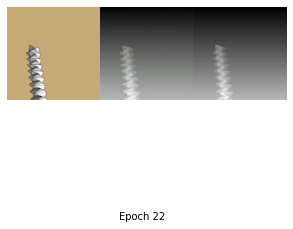

Epoch [23/50], Step [1/3750], D_loss: 0.0400, G_loss: 5.6457
Epoch [23/50], Step [2/3750], D_loss: 0.1270, G_loss: 5.3260
Epoch [23/50], Step [3/3750], D_loss: 0.0479, G_loss: 8.1028
Epoch [23/50], Step [4/3750], D_loss: 0.0166, G_loss: 10.8205
Epoch [23/50], Step [5/3750], D_loss: 0.0039, G_loss: 13.4965
Epoch [23/50], Step [6/3750], D_loss: 0.0031, G_loss: 14.7087
Epoch [23/50], Step [7/3750], D_loss: 0.0049, G_loss: 11.2141
Epoch [23/50], Step [8/3750], D_loss: 0.0058, G_loss: 12.6957
Epoch [23/50], Step [9/3750], D_loss: 0.2236, G_loss: 6.4477
Epoch [23/50], Step [10/3750], D_loss: 0.2058, G_loss: 8.1881
Epoch [23/50], Step [11/3750], D_loss: 0.0155, G_loss: 10.6956
Epoch [23/50], Step [12/3750], D_loss: 0.0214, G_loss: 12.6486
Epoch [23/50], Step [13/3750], D_loss: 0.0662, G_loss: 5.7860
Epoch [23/50], Step [14/3750], D_loss: 0.0601, G_loss: 13.7907
Epoch [23/50], Step [15/3750], D_loss: 0.0502, G_loss: 14.2555
Epoch [23/50], Step [16/3750], D_loss: 0.1491, G_loss: 12.8584
Epoch [

Epoch [23/50], Step [132/3750], D_loss: 0.2737, G_loss: 6.4258
Epoch [23/50], Step [133/3750], D_loss: 0.1079, G_loss: 7.6061
Epoch [23/50], Step [134/3750], D_loss: 0.0533, G_loss: 11.8255
Epoch [23/50], Step [135/3750], D_loss: 0.0621, G_loss: 7.4906
Epoch [23/50], Step [136/3750], D_loss: 0.0127, G_loss: 15.6863
Epoch [23/50], Step [137/3750], D_loss: 0.1542, G_loss: 9.4813
Epoch [23/50], Step [138/3750], D_loss: 0.1346, G_loss: 7.5920
Epoch [23/50], Step [139/3750], D_loss: 0.0030, G_loss: 13.9236
Epoch [23/50], Step [140/3750], D_loss: 0.0741, G_loss: 7.1828
Epoch [23/50], Step [141/3750], D_loss: 0.1263, G_loss: 6.6586
Epoch [23/50], Step [142/3750], D_loss: 0.2963, G_loss: 14.1747
Epoch [23/50], Step [143/3750], D_loss: 0.0059, G_loss: 12.9821
Epoch [23/50], Step [144/3750], D_loss: 0.0165, G_loss: 6.2909
Epoch [23/50], Step [145/3750], D_loss: 0.1730, G_loss: 8.0999
Epoch [23/50], Step [146/3750], D_loss: 0.1991, G_loss: 9.3437
Epoch [23/50], Step [147/3750], D_loss: 0.0261, G_

Epoch [23/50], Step [262/3750], D_loss: 0.0177, G_loss: 5.7959
Epoch [23/50], Step [263/3750], D_loss: 0.1134, G_loss: 7.6120
Epoch [23/50], Step [264/3750], D_loss: 0.0514, G_loss: 14.5092
Epoch [23/50], Step [265/3750], D_loss: 0.1000, G_loss: 5.7406
Epoch [23/50], Step [266/3750], D_loss: 0.1573, G_loss: 6.9369
Epoch [23/50], Step [267/3750], D_loss: 0.0345, G_loss: 10.3236
Epoch [23/50], Step [268/3750], D_loss: 0.0238, G_loss: 10.1931
Epoch [23/50], Step [269/3750], D_loss: 0.0836, G_loss: 7.7692
Epoch [23/50], Step [270/3750], D_loss: 0.1667, G_loss: 4.9692
Epoch [23/50], Step [271/3750], D_loss: 0.2176, G_loss: 6.8418
Epoch [23/50], Step [272/3750], D_loss: 0.0163, G_loss: 9.0953
Epoch [23/50], Step [273/3750], D_loss: 0.3354, G_loss: 6.1073
Epoch [23/50], Step [274/3750], D_loss: 0.0036, G_loss: 17.6474
Epoch [23/50], Step [275/3750], D_loss: 0.0920, G_loss: 10.9821
Epoch [23/50], Step [276/3750], D_loss: 0.0297, G_loss: 8.2326
Epoch [23/50], Step [277/3750], D_loss: 0.1959, G_

Epoch [23/50], Step [392/3750], D_loss: 0.1343, G_loss: 10.1089
Epoch [23/50], Step [393/3750], D_loss: 0.0224, G_loss: 8.9121
Epoch [23/50], Step [394/3750], D_loss: 0.0875, G_loss: 7.5164
Epoch [23/50], Step [395/3750], D_loss: 0.2484, G_loss: 7.9628
Epoch [23/50], Step [396/3750], D_loss: 0.1339, G_loss: 6.1245
Epoch [23/50], Step [397/3750], D_loss: 0.1231, G_loss: 7.7597
Epoch [23/50], Step [398/3750], D_loss: 0.1213, G_loss: 10.1228
Epoch [23/50], Step [399/3750], D_loss: 0.0312, G_loss: 15.6163
Epoch [23/50], Step [400/3750], D_loss: 0.0258, G_loss: 11.2357
Epoch [23/50], Step [401/3750], D_loss: 0.0627, G_loss: 11.6616
Epoch [23/50], Step [402/3750], D_loss: 0.0175, G_loss: 10.4709
Epoch [23/50], Step [403/3750], D_loss: 0.3502, G_loss: 10.6486
Epoch [23/50], Step [404/3750], D_loss: 0.1044, G_loss: 10.0259
Epoch [23/50], Step [405/3750], D_loss: 0.3214, G_loss: 5.3608
Epoch [23/50], Step [406/3750], D_loss: 0.0985, G_loss: 9.2878
Epoch [23/50], Step [407/3750], D_loss: 0.0274,

Epoch [23/50], Step [522/3750], D_loss: 0.1823, G_loss: 6.5103
Epoch [23/50], Step [523/3750], D_loss: 0.0181, G_loss: 10.8410
Epoch [23/50], Step [524/3750], D_loss: 0.0035, G_loss: 10.4848
Epoch [23/50], Step [525/3750], D_loss: 0.0805, G_loss: 8.1715
Epoch [23/50], Step [526/3750], D_loss: 0.1852, G_loss: 8.5487
Epoch [23/50], Step [527/3750], D_loss: 0.0034, G_loss: 12.8894
Epoch [23/50], Step [528/3750], D_loss: 0.0856, G_loss: 8.6572
Epoch [23/50], Step [529/3750], D_loss: 0.0497, G_loss: 7.9020
Epoch [23/50], Step [530/3750], D_loss: 0.0114, G_loss: 9.1275
Epoch [23/50], Step [531/3750], D_loss: 0.0433, G_loss: 9.0753
Epoch [23/50], Step [532/3750], D_loss: 0.0224, G_loss: 9.7530
Epoch [23/50], Step [533/3750], D_loss: 0.0411, G_loss: 13.1258
Epoch [23/50], Step [534/3750], D_loss: 0.0135, G_loss: 5.9758
Epoch [23/50], Step [535/3750], D_loss: 0.0353, G_loss: 9.6058
Epoch [23/50], Step [536/3750], D_loss: 0.1121, G_loss: 8.4273
Epoch [23/50], Step [537/3750], D_loss: 0.0119, G_l

Epoch [23/50], Step [652/3750], D_loss: 0.0203, G_loss: 8.4815
Epoch [23/50], Step [653/3750], D_loss: 0.0481, G_loss: 7.6445
Epoch [23/50], Step [654/3750], D_loss: 0.0125, G_loss: 6.0649
Epoch [23/50], Step [655/3750], D_loss: 0.0920, G_loss: 7.2059
Epoch [23/50], Step [656/3750], D_loss: 0.0475, G_loss: 6.3088
Epoch [23/50], Step [657/3750], D_loss: 0.1720, G_loss: 4.1048
Epoch [23/50], Step [658/3750], D_loss: 0.0866, G_loss: 23.4755
Epoch [23/50], Step [659/3750], D_loss: 0.0479, G_loss: 5.9141
Epoch [23/50], Step [660/3750], D_loss: 0.0783, G_loss: 5.6540
Epoch [23/50], Step [661/3750], D_loss: 0.2886, G_loss: 6.0626
Epoch [23/50], Step [662/3750], D_loss: 0.0498, G_loss: 14.8701
Epoch [23/50], Step [663/3750], D_loss: 0.0883, G_loss: 10.2121
Epoch [23/50], Step [664/3750], D_loss: 0.0199, G_loss: 5.6331
Epoch [23/50], Step [665/3750], D_loss: 0.0389, G_loss: 10.2813
Epoch [23/50], Step [666/3750], D_loss: 0.1041, G_loss: 5.4910
Epoch [23/50], Step [667/3750], D_loss: 0.0439, G_l

Epoch [23/50], Step [782/3750], D_loss: 0.0281, G_loss: 8.3007
Epoch [23/50], Step [783/3750], D_loss: 0.3321, G_loss: 5.7711
Epoch [23/50], Step [784/3750], D_loss: 0.0200, G_loss: 10.6746
Epoch [23/50], Step [785/3750], D_loss: 0.1428, G_loss: 6.3934
Epoch [23/50], Step [786/3750], D_loss: 0.0240, G_loss: 14.7034
Epoch [23/50], Step [787/3750], D_loss: 0.0233, G_loss: 10.2948
Epoch [23/50], Step [788/3750], D_loss: 0.0123, G_loss: 13.8182
Epoch [23/50], Step [789/3750], D_loss: 0.0465, G_loss: 8.2545
Epoch [23/50], Step [790/3750], D_loss: 0.0050, G_loss: 7.2481
Epoch [23/50], Step [791/3750], D_loss: 0.0074, G_loss: 9.8065
Epoch [23/50], Step [792/3750], D_loss: 0.0124, G_loss: 16.0068
Epoch [23/50], Step [793/3750], D_loss: 0.0298, G_loss: 11.6364
Epoch [23/50], Step [794/3750], D_loss: 0.0136, G_loss: 7.4819
Epoch [23/50], Step [795/3750], D_loss: 0.0426, G_loss: 6.3425
Epoch [23/50], Step [796/3750], D_loss: 0.3058, G_loss: 6.6360
Epoch [23/50], Step [797/3750], D_loss: 0.0040, G

Epoch [23/50], Step [912/3750], D_loss: 0.0033, G_loss: 16.5460
Epoch [23/50], Step [913/3750], D_loss: 0.0126, G_loss: 6.4692
Epoch [23/50], Step [914/3750], D_loss: 0.0081, G_loss: 15.9912
Epoch [23/50], Step [915/3750], D_loss: 0.0645, G_loss: 5.5685
Epoch [23/50], Step [916/3750], D_loss: 0.3408, G_loss: 6.6671
Epoch [23/50], Step [917/3750], D_loss: 0.3753, G_loss: 7.0844
Epoch [23/50], Step [918/3750], D_loss: 0.0915, G_loss: 8.5937
Epoch [23/50], Step [919/3750], D_loss: 0.0652, G_loss: 10.6504
Epoch [23/50], Step [920/3750], D_loss: 0.0484, G_loss: 8.5440
Epoch [23/50], Step [921/3750], D_loss: 0.2060, G_loss: 7.1022
Epoch [23/50], Step [922/3750], D_loss: 0.0247, G_loss: 7.8813
Epoch [23/50], Step [923/3750], D_loss: 0.0651, G_loss: 7.7498
Epoch [23/50], Step [924/3750], D_loss: 0.0961, G_loss: 10.4608
Epoch [23/50], Step [925/3750], D_loss: 0.0778, G_loss: 19.7970
Epoch [23/50], Step [926/3750], D_loss: 0.0342, G_loss: 8.9694
Epoch [23/50], Step [927/3750], D_loss: 0.0037, G_

Epoch [23/50], Step [1041/3750], D_loss: 0.0193, G_loss: 9.0747
Epoch [23/50], Step [1042/3750], D_loss: 0.0670, G_loss: 8.2927
Epoch [23/50], Step [1043/3750], D_loss: 0.0132, G_loss: 7.6325
Epoch [23/50], Step [1044/3750], D_loss: 0.1653, G_loss: 8.2366
Epoch [23/50], Step [1045/3750], D_loss: 0.2264, G_loss: 10.0482
Epoch [23/50], Step [1046/3750], D_loss: 0.0727, G_loss: 10.2659
Epoch [23/50], Step [1047/3750], D_loss: 0.0157, G_loss: 5.6585
Epoch [23/50], Step [1048/3750], D_loss: 0.0238, G_loss: 10.8847
Epoch [23/50], Step [1049/3750], D_loss: 0.0663, G_loss: 13.3065
Epoch [23/50], Step [1050/3750], D_loss: 0.0100, G_loss: 8.4930
Epoch [23/50], Step [1051/3750], D_loss: 0.0149, G_loss: 8.2359
Epoch [23/50], Step [1052/3750], D_loss: 0.0202, G_loss: 10.4631
Epoch [23/50], Step [1053/3750], D_loss: 0.1756, G_loss: 6.0271
Epoch [23/50], Step [1054/3750], D_loss: 0.0516, G_loss: 9.5161
Epoch [23/50], Step [1055/3750], D_loss: 0.0028, G_loss: 14.1339
Epoch [23/50], Step [1056/3750], D

Epoch [23/50], Step [1169/3750], D_loss: 0.0331, G_loss: 8.5330
Epoch [23/50], Step [1170/3750], D_loss: 0.0044, G_loss: 11.8254
Epoch [23/50], Step [1171/3750], D_loss: 0.0140, G_loss: 12.5292
Epoch [23/50], Step [1172/3750], D_loss: 0.0975, G_loss: 5.9883
Epoch [23/50], Step [1173/3750], D_loss: 0.1320, G_loss: 8.4203
Epoch [23/50], Step [1174/3750], D_loss: 0.0093, G_loss: 13.4170
Epoch [23/50], Step [1175/3750], D_loss: 0.5762, G_loss: 3.4847
Epoch [23/50], Step [1176/3750], D_loss: 0.0518, G_loss: 6.5783
Epoch [23/50], Step [1177/3750], D_loss: 0.3750, G_loss: 5.3742
Epoch [23/50], Step [1178/3750], D_loss: 0.0162, G_loss: 13.7900
Epoch [23/50], Step [1179/3750], D_loss: 0.0160, G_loss: 9.7770
Epoch [23/50], Step [1180/3750], D_loss: 0.0052, G_loss: 9.4827
Epoch [23/50], Step [1181/3750], D_loss: 0.0903, G_loss: 11.2832
Epoch [23/50], Step [1182/3750], D_loss: 0.0123, G_loss: 8.2311
Epoch [23/50], Step [1183/3750], D_loss: 0.0873, G_loss: 14.0952
Epoch [23/50], Step [1184/3750], D

Epoch [23/50], Step [1297/3750], D_loss: 0.1222, G_loss: 6.3796
Epoch [23/50], Step [1298/3750], D_loss: 0.0374, G_loss: 6.6768
Epoch [23/50], Step [1299/3750], D_loss: 0.0345, G_loss: 16.6196
Epoch [23/50], Step [1300/3750], D_loss: 0.0333, G_loss: 11.9346
Epoch [23/50], Step [1301/3750], D_loss: 0.0583, G_loss: 10.8908
Epoch [23/50], Step [1302/3750], D_loss: 0.0052, G_loss: 10.4740
Epoch [23/50], Step [1303/3750], D_loss: 0.0075, G_loss: 6.4011
Epoch [23/50], Step [1304/3750], D_loss: 0.0045, G_loss: 7.4210
Epoch [23/50], Step [1305/3750], D_loss: 0.0152, G_loss: 10.2483
Epoch [23/50], Step [1306/3750], D_loss: 0.1740, G_loss: 11.4699
Epoch [23/50], Step [1307/3750], D_loss: 0.0019, G_loss: 9.7529
Epoch [23/50], Step [1308/3750], D_loss: 0.0081, G_loss: 13.1610
Epoch [23/50], Step [1309/3750], D_loss: 0.2766, G_loss: 9.6474
Epoch [23/50], Step [1310/3750], D_loss: 0.0067, G_loss: 12.2642
Epoch [23/50], Step [1311/3750], D_loss: 0.0290, G_loss: 9.7605
Epoch [23/50], Step [1312/3750],

Epoch [23/50], Step [1425/3750], D_loss: 0.0569, G_loss: 7.0514
Epoch [23/50], Step [1426/3750], D_loss: 0.6250, G_loss: 10.3820
Epoch [23/50], Step [1427/3750], D_loss: 0.0878, G_loss: 6.1041
Epoch [23/50], Step [1428/3750], D_loss: 0.0128, G_loss: 13.8734
Epoch [23/50], Step [1429/3750], D_loss: 0.1524, G_loss: 7.7077
Epoch [23/50], Step [1430/3750], D_loss: 0.0017, G_loss: 10.0188
Epoch [23/50], Step [1431/3750], D_loss: 0.0017, G_loss: 16.4250
Epoch [23/50], Step [1432/3750], D_loss: 0.0729, G_loss: 9.1383
Epoch [23/50], Step [1433/3750], D_loss: 0.0077, G_loss: 8.5500
Epoch [23/50], Step [1434/3750], D_loss: 0.0233, G_loss: 13.3045
Epoch [23/50], Step [1435/3750], D_loss: 0.0167, G_loss: 11.2262
Epoch [23/50], Step [1436/3750], D_loss: 0.0019, G_loss: 13.5903
Epoch [23/50], Step [1437/3750], D_loss: 0.0340, G_loss: 7.8166
Epoch [23/50], Step [1438/3750], D_loss: 0.0025, G_loss: 8.7769
Epoch [23/50], Step [1439/3750], D_loss: 0.0834, G_loss: 8.2537
Epoch [23/50], Step [1440/3750], 

Epoch [23/50], Step [1553/3750], D_loss: 0.2754, G_loss: 7.9872
Epoch [23/50], Step [1554/3750], D_loss: 0.0129, G_loss: 10.2580
Epoch [23/50], Step [1555/3750], D_loss: 0.0312, G_loss: 15.0258
Epoch [23/50], Step [1556/3750], D_loss: 0.0167, G_loss: 12.2748
Epoch [23/50], Step [1557/3750], D_loss: 0.0559, G_loss: 7.1409
Epoch [23/50], Step [1558/3750], D_loss: 0.0054, G_loss: 10.7917
Epoch [23/50], Step [1559/3750], D_loss: 0.0402, G_loss: 8.9159
Epoch [23/50], Step [1560/3750], D_loss: 0.2287, G_loss: 5.1119
Epoch [23/50], Step [1561/3750], D_loss: 0.0077, G_loss: 14.1033
Epoch [23/50], Step [1562/3750], D_loss: 0.2198, G_loss: 9.3319
Epoch [23/50], Step [1563/3750], D_loss: 0.1000, G_loss: 7.1003
Epoch [23/50], Step [1564/3750], D_loss: 0.0206, G_loss: 5.9185
Epoch [23/50], Step [1565/3750], D_loss: 0.0094, G_loss: 9.7825
Epoch [23/50], Step [1566/3750], D_loss: 0.0853, G_loss: 8.9323
Epoch [23/50], Step [1567/3750], D_loss: 0.0134, G_loss: 16.8135
Epoch [23/50], Step [1568/3750], D

Epoch [23/50], Step [1681/3750], D_loss: 0.0811, G_loss: 9.0748
Epoch [23/50], Step [1682/3750], D_loss: 0.0969, G_loss: 13.7573
Epoch [23/50], Step [1683/3750], D_loss: 0.0052, G_loss: 7.4713
Epoch [23/50], Step [1684/3750], D_loss: 0.0133, G_loss: 8.7871
Epoch [23/50], Step [1685/3750], D_loss: 0.0581, G_loss: 6.5891
Epoch [23/50], Step [1686/3750], D_loss: 0.0098, G_loss: 6.0260
Epoch [23/50], Step [1687/3750], D_loss: 0.0752, G_loss: 7.5236
Epoch [23/50], Step [1688/3750], D_loss: 0.0256, G_loss: 9.8365
Epoch [23/50], Step [1689/3750], D_loss: 0.0065, G_loss: 11.3969
Epoch [23/50], Step [1690/3750], D_loss: 0.1097, G_loss: 11.6697
Epoch [23/50], Step [1691/3750], D_loss: 0.0050, G_loss: 9.3653
Epoch [23/50], Step [1692/3750], D_loss: 0.0041, G_loss: 14.6000
Epoch [23/50], Step [1693/3750], D_loss: 0.0155, G_loss: 12.0678
Epoch [23/50], Step [1694/3750], D_loss: 0.2670, G_loss: 7.0975
Epoch [23/50], Step [1695/3750], D_loss: 0.0575, G_loss: 4.8773
Epoch [23/50], Step [1696/3750], D_

Epoch [23/50], Step [1809/3750], D_loss: 0.1684, G_loss: 15.7714
Epoch [23/50], Step [1810/3750], D_loss: 0.0133, G_loss: 13.7311
Epoch [23/50], Step [1811/3750], D_loss: 0.0649, G_loss: 5.4729
Epoch [23/50], Step [1812/3750], D_loss: 0.9556, G_loss: 5.4724
Epoch [23/50], Step [1813/3750], D_loss: 0.0754, G_loss: 10.4885
Epoch [23/50], Step [1814/3750], D_loss: 0.0427, G_loss: 12.4223
Epoch [23/50], Step [1815/3750], D_loss: 0.0816, G_loss: 7.6154
Epoch [23/50], Step [1816/3750], D_loss: 0.1883, G_loss: 7.6662
Epoch [23/50], Step [1817/3750], D_loss: 0.0903, G_loss: 6.7202
Epoch [23/50], Step [1818/3750], D_loss: 0.0113, G_loss: 6.4220
Epoch [23/50], Step [1819/3750], D_loss: 0.0311, G_loss: 14.0058
Epoch [23/50], Step [1820/3750], D_loss: 0.0467, G_loss: 8.7023
Epoch [23/50], Step [1821/3750], D_loss: 0.1490, G_loss: 9.4521
Epoch [23/50], Step [1822/3750], D_loss: 0.0098, G_loss: 10.1492
Epoch [23/50], Step [1823/3750], D_loss: 0.0231, G_loss: 9.6714
Epoch [23/50], Step [1824/3750], D

Epoch [23/50], Step [1937/3750], D_loss: 0.0697, G_loss: 9.0776
Epoch [23/50], Step [1938/3750], D_loss: 0.0045, G_loss: 8.2429
Epoch [23/50], Step [1939/3750], D_loss: 0.0146, G_loss: 15.7637
Epoch [23/50], Step [1940/3750], D_loss: 0.0721, G_loss: 11.9238
Epoch [23/50], Step [1941/3750], D_loss: 0.1072, G_loss: 7.1332
Epoch [23/50], Step [1942/3750], D_loss: 0.0020, G_loss: 16.2864
Epoch [23/50], Step [1943/3750], D_loss: 0.0312, G_loss: 5.8517
Epoch [23/50], Step [1944/3750], D_loss: 0.5569, G_loss: 9.0585
Epoch [23/50], Step [1945/3750], D_loss: 0.0965, G_loss: 6.2547
Epoch [23/50], Step [1946/3750], D_loss: 0.0567, G_loss: 12.5674
Epoch [23/50], Step [1947/3750], D_loss: 0.0175, G_loss: 13.8565
Epoch [23/50], Step [1948/3750], D_loss: 0.1638, G_loss: 10.0936
Epoch [23/50], Step [1949/3750], D_loss: 0.0088, G_loss: 11.5561
Epoch [23/50], Step [1950/3750], D_loss: 0.0172, G_loss: 15.1979
Epoch [23/50], Step [1951/3750], D_loss: 0.0211, G_loss: 6.2804
Epoch [23/50], Step [1952/3750],

Epoch [23/50], Step [2065/3750], D_loss: 0.2535, G_loss: 7.2596
Epoch [23/50], Step [2066/3750], D_loss: 0.0027, G_loss: 13.7142
Epoch [23/50], Step [2067/3750], D_loss: 0.0391, G_loss: 15.2482
Epoch [23/50], Step [2068/3750], D_loss: 0.0080, G_loss: 7.2040
Epoch [23/50], Step [2069/3750], D_loss: 0.0083, G_loss: 8.2605
Epoch [23/50], Step [2070/3750], D_loss: 0.0197, G_loss: 9.7729
Epoch [23/50], Step [2071/3750], D_loss: 0.0015, G_loss: 13.8764
Epoch [23/50], Step [2072/3750], D_loss: 0.0035, G_loss: 17.6472
Epoch [23/50], Step [2073/3750], D_loss: 0.0361, G_loss: 16.9704
Epoch [23/50], Step [2074/3750], D_loss: 0.0234, G_loss: 8.4521
Epoch [23/50], Step [2075/3750], D_loss: 0.0030, G_loss: 10.0120
Epoch [23/50], Step [2076/3750], D_loss: 0.0036, G_loss: 8.1916
Epoch [23/50], Step [2077/3750], D_loss: 0.0948, G_loss: 5.4078
Epoch [23/50], Step [2078/3750], D_loss: 0.0666, G_loss: 6.8555
Epoch [23/50], Step [2079/3750], D_loss: 0.4046, G_loss: 22.9990
Epoch [23/50], Step [2080/3750], 

Epoch [23/50], Step [2193/3750], D_loss: 0.4143, G_loss: 6.1132
Epoch [23/50], Step [2194/3750], D_loss: 0.0492, G_loss: 10.7006
Epoch [23/50], Step [2195/3750], D_loss: 0.1228, G_loss: 7.9073
Epoch [23/50], Step [2196/3750], D_loss: 0.0365, G_loss: 11.2561
Epoch [23/50], Step [2197/3750], D_loss: 0.0038, G_loss: 11.6576
Epoch [23/50], Step [2198/3750], D_loss: 0.0562, G_loss: 16.2639
Epoch [23/50], Step [2199/3750], D_loss: 0.0032, G_loss: 10.0897
Epoch [23/50], Step [2200/3750], D_loss: 0.0063, G_loss: 14.7999
Epoch [23/50], Step [2201/3750], D_loss: 0.0054, G_loss: 9.0607
Epoch [23/50], Step [2202/3750], D_loss: 0.3740, G_loss: 7.4461
Epoch [23/50], Step [2203/3750], D_loss: 0.1113, G_loss: 6.3220
Epoch [23/50], Step [2204/3750], D_loss: 0.1190, G_loss: 7.6220
Epoch [23/50], Step [2205/3750], D_loss: 0.0211, G_loss: 11.8265
Epoch [23/50], Step [2206/3750], D_loss: 0.1416, G_loss: 7.1820
Epoch [23/50], Step [2207/3750], D_loss: 0.1488, G_loss: 13.0872
Epoch [23/50], Step [2208/3750],

Epoch [23/50], Step [2321/3750], D_loss: 0.1606, G_loss: 11.3641
Epoch [23/50], Step [2322/3750], D_loss: 0.0160, G_loss: 9.2004
Epoch [23/50], Step [2323/3750], D_loss: 0.0224, G_loss: 11.1288
Epoch [23/50], Step [2324/3750], D_loss: 0.3405, G_loss: 5.4520
Epoch [23/50], Step [2325/3750], D_loss: 0.2799, G_loss: 6.3716
Epoch [23/50], Step [2326/3750], D_loss: 0.1608, G_loss: 5.7989
Epoch [23/50], Step [2327/3750], D_loss: 0.3315, G_loss: 7.0622
Epoch [23/50], Step [2328/3750], D_loss: 0.2529, G_loss: 11.8797
Epoch [23/50], Step [2329/3750], D_loss: 0.0011, G_loss: 11.3623
Epoch [23/50], Step [2330/3750], D_loss: 0.1799, G_loss: 15.9105
Epoch [23/50], Step [2331/3750], D_loss: 0.6069, G_loss: 7.8537
Epoch [23/50], Step [2332/3750], D_loss: 0.0044, G_loss: 8.0178
Epoch [23/50], Step [2333/3750], D_loss: 0.0247, G_loss: 6.4625
Epoch [23/50], Step [2334/3750], D_loss: 0.0642, G_loss: 7.2593
Epoch [23/50], Step [2335/3750], D_loss: 0.0319, G_loss: 6.6623
Epoch [23/50], Step [2336/3750], D_

Epoch [23/50], Step [2449/3750], D_loss: 0.0098, G_loss: 10.1573
Epoch [23/50], Step [2450/3750], D_loss: 0.3139, G_loss: 4.9279
Epoch [23/50], Step [2451/3750], D_loss: 0.0315, G_loss: 5.4632
Epoch [23/50], Step [2452/3750], D_loss: 0.0109, G_loss: 6.9699
Epoch [23/50], Step [2453/3750], D_loss: 0.0823, G_loss: 9.7261
Epoch [23/50], Step [2454/3750], D_loss: 0.0558, G_loss: 10.5761
Epoch [23/50], Step [2455/3750], D_loss: 0.0074, G_loss: 8.6330
Epoch [23/50], Step [2456/3750], D_loss: 0.1331, G_loss: 8.1723
Epoch [23/50], Step [2457/3750], D_loss: 0.4561, G_loss: 3.7058
Epoch [23/50], Step [2458/3750], D_loss: 0.0490, G_loss: 8.5747
Epoch [23/50], Step [2459/3750], D_loss: 0.2591, G_loss: 6.5339
Epoch [23/50], Step [2460/3750], D_loss: 0.2011, G_loss: 7.4478
Epoch [23/50], Step [2461/3750], D_loss: 0.1032, G_loss: 10.3381
Epoch [23/50], Step [2462/3750], D_loss: 0.0089, G_loss: 13.1667
Epoch [23/50], Step [2463/3750], D_loss: 0.0065, G_loss: 7.8588
Epoch [23/50], Step [2464/3750], D_l

Epoch [23/50], Step [2577/3750], D_loss: 0.0136, G_loss: 13.4465
Epoch [23/50], Step [2578/3750], D_loss: 0.0088, G_loss: 12.5579
Epoch [23/50], Step [2579/3750], D_loss: 0.0959, G_loss: 12.8989
Epoch [23/50], Step [2580/3750], D_loss: 0.0181, G_loss: 7.9585
Epoch [23/50], Step [2581/3750], D_loss: 0.1383, G_loss: 7.3430
Epoch [23/50], Step [2582/3750], D_loss: 0.2973, G_loss: 7.4497
Epoch [23/50], Step [2583/3750], D_loss: 0.0078, G_loss: 17.3508
Epoch [23/50], Step [2584/3750], D_loss: 0.4873, G_loss: 12.6175
Epoch [23/50], Step [2585/3750], D_loss: 0.2558, G_loss: 4.7905
Epoch [23/50], Step [2586/3750], D_loss: 0.1159, G_loss: 7.3993
Epoch [23/50], Step [2587/3750], D_loss: 0.0869, G_loss: 5.6280
Epoch [23/50], Step [2588/3750], D_loss: 0.0855, G_loss: 11.3719
Epoch [23/50], Step [2589/3750], D_loss: 0.1103, G_loss: 6.1624
Epoch [23/50], Step [2590/3750], D_loss: 0.0425, G_loss: 5.9784
Epoch [23/50], Step [2591/3750], D_loss: 0.1173, G_loss: 7.6358
Epoch [23/50], Step [2592/3750], D

Epoch [23/50], Step [2705/3750], D_loss: 0.0043, G_loss: 11.2519
Epoch [23/50], Step [2706/3750], D_loss: 0.0041, G_loss: 9.1680
Epoch [23/50], Step [2707/3750], D_loss: 0.0974, G_loss: 7.3844
Epoch [23/50], Step [2708/3750], D_loss: 0.0226, G_loss: 8.9433
Epoch [23/50], Step [2709/3750], D_loss: 0.0102, G_loss: 10.0390
Epoch [23/50], Step [2710/3750], D_loss: 0.0590, G_loss: 7.9936
Epoch [23/50], Step [2711/3750], D_loss: 0.0617, G_loss: 6.9718
Epoch [23/50], Step [2712/3750], D_loss: 0.1112, G_loss: 9.3689
Epoch [23/50], Step [2713/3750], D_loss: 0.0908, G_loss: 11.0138
Epoch [23/50], Step [2714/3750], D_loss: 0.0465, G_loss: 12.9215
Epoch [23/50], Step [2715/3750], D_loss: 0.0339, G_loss: 7.2409
Epoch [23/50], Step [2716/3750], D_loss: 0.2838, G_loss: 5.4865
Epoch [23/50], Step [2717/3750], D_loss: 0.1130, G_loss: 6.7499
Epoch [23/50], Step [2718/3750], D_loss: 0.3580, G_loss: 8.3784
Epoch [23/50], Step [2719/3750], D_loss: 0.4309, G_loss: 12.4281
Epoch [23/50], Step [2720/3750], D_

Epoch [23/50], Step [2833/3750], D_loss: 0.3898, G_loss: 6.0357
Epoch [23/50], Step [2834/3750], D_loss: 0.2717, G_loss: 9.4473
Epoch [23/50], Step [2835/3750], D_loss: 0.2865, G_loss: 10.2312
Epoch [23/50], Step [2836/3750], D_loss: 1.4895, G_loss: 4.5626
Epoch [23/50], Step [2837/3750], D_loss: 0.2406, G_loss: 6.8973
Epoch [23/50], Step [2838/3750], D_loss: 0.1512, G_loss: 5.6491
Epoch [23/50], Step [2839/3750], D_loss: 0.1591, G_loss: 9.7065
Epoch [23/50], Step [2840/3750], D_loss: 0.1385, G_loss: 11.5939
Epoch [23/50], Step [2841/3750], D_loss: 0.0730, G_loss: 8.5850
Epoch [23/50], Step [2842/3750], D_loss: 0.0892, G_loss: 9.3981
Epoch [23/50], Step [2843/3750], D_loss: 0.1232, G_loss: 5.6799
Epoch [23/50], Step [2844/3750], D_loss: 0.0023, G_loss: 15.9885
Epoch [23/50], Step [2845/3750], D_loss: 0.0028, G_loss: 14.5886
Epoch [23/50], Step [2846/3750], D_loss: 0.0097, G_loss: 7.8467
Epoch [23/50], Step [2847/3750], D_loss: 0.0139, G_loss: 8.2837
Epoch [23/50], Step [2848/3750], D_l

Epoch [23/50], Step [2961/3750], D_loss: 0.0432, G_loss: 10.3058
Epoch [23/50], Step [2962/3750], D_loss: 0.1243, G_loss: 8.8250
Epoch [23/50], Step [2963/3750], D_loss: 0.0143, G_loss: 5.8990
Epoch [23/50], Step [2964/3750], D_loss: 0.1170, G_loss: 5.9984
Epoch [23/50], Step [2965/3750], D_loss: 0.0464, G_loss: 7.7645
Epoch [23/50], Step [2966/3750], D_loss: 0.0402, G_loss: 8.0717
Epoch [23/50], Step [2967/3750], D_loss: 0.0432, G_loss: 7.8814
Epoch [23/50], Step [2968/3750], D_loss: 0.1128, G_loss: 7.8102
Epoch [23/50], Step [2969/3750], D_loss: 0.0590, G_loss: 17.8979
Epoch [23/50], Step [2970/3750], D_loss: 0.0471, G_loss: 8.5915
Epoch [23/50], Step [2971/3750], D_loss: 0.0986, G_loss: 11.5409
Epoch [23/50], Step [2972/3750], D_loss: 0.0270, G_loss: 9.9506
Epoch [23/50], Step [2973/3750], D_loss: 0.0179, G_loss: 11.7553
Epoch [23/50], Step [2974/3750], D_loss: 0.0657, G_loss: 8.4823
Epoch [23/50], Step [2975/3750], D_loss: 0.0382, G_loss: 8.4710
Epoch [23/50], Step [2976/3750], D_l

Epoch [23/50], Step [3089/3750], D_loss: 0.0583, G_loss: 10.5882
Epoch [23/50], Step [3090/3750], D_loss: 0.8238, G_loss: 6.6864
Epoch [23/50], Step [3091/3750], D_loss: 0.0675, G_loss: 10.4063
Epoch [23/50], Step [3092/3750], D_loss: 0.4478, G_loss: 4.2002
Epoch [23/50], Step [3093/3750], D_loss: 0.2170, G_loss: 11.2926
Epoch [23/50], Step [3094/3750], D_loss: 0.2263, G_loss: 7.7370
Epoch [23/50], Step [3095/3750], D_loss: 0.2067, G_loss: 5.5030
Epoch [23/50], Step [3096/3750], D_loss: 0.0043, G_loss: 18.8509
Epoch [23/50], Step [3097/3750], D_loss: 0.1241, G_loss: 8.8520
Epoch [23/50], Step [3098/3750], D_loss: 0.1048, G_loss: 8.1220
Epoch [23/50], Step [3099/3750], D_loss: 0.0273, G_loss: 9.8662
Epoch [23/50], Step [3100/3750], D_loss: 0.3709, G_loss: 8.8793
Epoch [23/50], Step [3101/3750], D_loss: 0.0792, G_loss: 6.2153
Epoch [23/50], Step [3102/3750], D_loss: 0.0187, G_loss: 16.1441
Epoch [23/50], Step [3103/3750], D_loss: 0.0149, G_loss: 6.7995
Epoch [23/50], Step [3104/3750], D_

Epoch [23/50], Step [3217/3750], D_loss: 0.0238, G_loss: 7.2807
Epoch [23/50], Step [3218/3750], D_loss: 0.0678, G_loss: 7.6988
Epoch [23/50], Step [3219/3750], D_loss: 0.2053, G_loss: 5.4714
Epoch [23/50], Step [3220/3750], D_loss: 0.2832, G_loss: 5.6417
Epoch [23/50], Step [3221/3750], D_loss: 0.0616, G_loss: 23.1657
Epoch [23/50], Step [3222/3750], D_loss: 0.2490, G_loss: 12.5913
Epoch [23/50], Step [3223/3750], D_loss: 0.0945, G_loss: 8.7611
Epoch [23/50], Step [3224/3750], D_loss: 0.2439, G_loss: 8.8767
Epoch [23/50], Step [3225/3750], D_loss: 0.1288, G_loss: 6.6135
Epoch [23/50], Step [3226/3750], D_loss: 0.1151, G_loss: 13.5908
Epoch [23/50], Step [3227/3750], D_loss: 0.5443, G_loss: 5.2082
Epoch [23/50], Step [3228/3750], D_loss: 0.1995, G_loss: 10.5111
Epoch [23/50], Step [3229/3750], D_loss: 0.0364, G_loss: 11.9025
Epoch [23/50], Step [3230/3750], D_loss: 0.1715, G_loss: 6.6925
Epoch [23/50], Step [3231/3750], D_loss: 0.0139, G_loss: 9.3550
Epoch [23/50], Step [3232/3750], D_

Epoch [23/50], Step [3345/3750], D_loss: 0.0665, G_loss: 6.6429
Epoch [23/50], Step [3346/3750], D_loss: 0.0955, G_loss: 11.4600
Epoch [23/50], Step [3347/3750], D_loss: 0.1939, G_loss: 11.1739
Epoch [23/50], Step [3348/3750], D_loss: 0.2303, G_loss: 5.9182
Epoch [23/50], Step [3349/3750], D_loss: 0.0604, G_loss: 6.5415
Epoch [23/50], Step [3350/3750], D_loss: 0.0936, G_loss: 7.4457
Epoch [23/50], Step [3351/3750], D_loss: 0.4259, G_loss: 4.4107
Epoch [23/50], Step [3352/3750], D_loss: 0.0159, G_loss: 11.1114
Epoch [23/50], Step [3353/3750], D_loss: 0.2314, G_loss: 6.0619
Epoch [23/50], Step [3354/3750], D_loss: 0.0231, G_loss: 7.6480
Epoch [23/50], Step [3355/3750], D_loss: 0.0128, G_loss: 13.6594
Epoch [23/50], Step [3356/3750], D_loss: 0.2353, G_loss: 7.0899
Epoch [23/50], Step [3357/3750], D_loss: 0.0626, G_loss: 7.4855
Epoch [23/50], Step [3358/3750], D_loss: 0.0824, G_loss: 8.0243
Epoch [23/50], Step [3359/3750], D_loss: 0.0543, G_loss: 14.1616
Epoch [23/50], Step [3360/3750], D_

Epoch [23/50], Step [3473/3750], D_loss: 0.0795, G_loss: 13.0810
Epoch [23/50], Step [3474/3750], D_loss: 0.0106, G_loss: 6.4605
Epoch [23/50], Step [3475/3750], D_loss: 0.0083, G_loss: 9.6823
Epoch [23/50], Step [3476/3750], D_loss: 0.0598, G_loss: 7.7670
Epoch [23/50], Step [3477/3750], D_loss: 0.1803, G_loss: 8.4547
Epoch [23/50], Step [3478/3750], D_loss: 0.0832, G_loss: 5.8308
Epoch [23/50], Step [3479/3750], D_loss: 0.0087, G_loss: 15.2880
Epoch [23/50], Step [3480/3750], D_loss: 0.0053, G_loss: 13.0120
Epoch [23/50], Step [3481/3750], D_loss: 0.0371, G_loss: 7.5075
Epoch [23/50], Step [3482/3750], D_loss: 0.0030, G_loss: 9.7900
Epoch [23/50], Step [3483/3750], D_loss: 0.0026, G_loss: 14.2609
Epoch [23/50], Step [3484/3750], D_loss: 0.0199, G_loss: 11.4195
Epoch [23/50], Step [3485/3750], D_loss: 0.7486, G_loss: 7.9266
Epoch [23/50], Step [3486/3750], D_loss: 0.0755, G_loss: 4.4834
Epoch [23/50], Step [3487/3750], D_loss: 0.0666, G_loss: 4.5095
Epoch [23/50], Step [3488/3750], D_

Epoch [23/50], Step [3601/3750], D_loss: 0.0233, G_loss: 16.5903
Epoch [23/50], Step [3602/3750], D_loss: 0.0643, G_loss: 12.5237
Epoch [23/50], Step [3603/3750], D_loss: 0.0029, G_loss: 9.6248
Epoch [23/50], Step [3604/3750], D_loss: 0.0967, G_loss: 5.9312
Epoch [23/50], Step [3605/3750], D_loss: 0.0057, G_loss: 13.0011
Epoch [23/50], Step [3606/3750], D_loss: 0.0083, G_loss: 10.0491
Epoch [23/50], Step [3607/3750], D_loss: 0.0071, G_loss: 7.1331
Epoch [23/50], Step [3608/3750], D_loss: 0.1311, G_loss: 5.3529
Epoch [23/50], Step [3609/3750], D_loss: 0.0263, G_loss: 10.7466
Epoch [23/50], Step [3610/3750], D_loss: 0.0043, G_loss: 10.3086
Epoch [23/50], Step [3611/3750], D_loss: 0.0564, G_loss: 8.9652
Epoch [23/50], Step [3612/3750], D_loss: 0.0138, G_loss: 11.5243
Epoch [23/50], Step [3613/3750], D_loss: 0.1171, G_loss: 5.2086
Epoch [23/50], Step [3614/3750], D_loss: 0.0066, G_loss: 11.0340
Epoch [23/50], Step [3615/3750], D_loss: 0.0154, G_loss: 8.7723
Epoch [23/50], Step [3616/3750],

Epoch [23/50], Step [3729/3750], D_loss: 0.2162, G_loss: 5.5445
Epoch [23/50], Step [3730/3750], D_loss: 0.0048, G_loss: 12.7892
Epoch [23/50], Step [3731/3750], D_loss: 0.4747, G_loss: 11.2201
Epoch [23/50], Step [3732/3750], D_loss: 0.8857, G_loss: 6.9229
Epoch [23/50], Step [3733/3750], D_loss: 0.4817, G_loss: 4.7182
Epoch [23/50], Step [3734/3750], D_loss: 0.4328, G_loss: 11.9989
Epoch [23/50], Step [3735/3750], D_loss: 0.0881, G_loss: 13.6303
Epoch [23/50], Step [3736/3750], D_loss: 0.0385, G_loss: 11.0241
Epoch [23/50], Step [3737/3750], D_loss: 0.6228, G_loss: 6.1016
Epoch [23/50], Step [3738/3750], D_loss: 0.0359, G_loss: 8.6926
Epoch [23/50], Step [3739/3750], D_loss: 0.0076, G_loss: 16.1359
Epoch [23/50], Step [3740/3750], D_loss: 0.0809, G_loss: 8.8619
Epoch [23/50], Step [3741/3750], D_loss: 0.0010, G_loss: 11.5480
Epoch [23/50], Step [3742/3750], D_loss: 0.1435, G_loss: 6.9652
Epoch [23/50], Step [3743/3750], D_loss: 0.0141, G_loss: 13.8101
Epoch [23/50], Step [3744/3750],

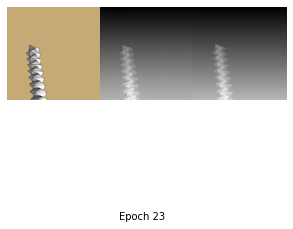

Epoch [24/50], Step [1/3750], D_loss: 0.0414, G_loss: 8.8797
Epoch [24/50], Step [2/3750], D_loss: 0.0286, G_loss: 9.6873
Epoch [24/50], Step [3/3750], D_loss: 0.3769, G_loss: 8.7500
Epoch [24/50], Step [4/3750], D_loss: 0.0769, G_loss: 9.4264
Epoch [24/50], Step [5/3750], D_loss: 0.1912, G_loss: 10.2840
Epoch [24/50], Step [6/3750], D_loss: 0.0533, G_loss: 7.9165
Epoch [24/50], Step [7/3750], D_loss: 0.0067, G_loss: 11.7053
Epoch [24/50], Step [8/3750], D_loss: 0.0236, G_loss: 5.6343
Epoch [24/50], Step [9/3750], D_loss: 0.0877, G_loss: 5.6822
Epoch [24/50], Step [10/3750], D_loss: 0.0106, G_loss: 14.2027
Epoch [24/50], Step [11/3750], D_loss: 0.0151, G_loss: 13.2348
Epoch [24/50], Step [12/3750], D_loss: 0.0306, G_loss: 13.3952
Epoch [24/50], Step [13/3750], D_loss: 0.0130, G_loss: 7.8741
Epoch [24/50], Step [14/3750], D_loss: 0.0013, G_loss: 10.9435
Epoch [24/50], Step [15/3750], D_loss: 0.1712, G_loss: 11.1285
Epoch [24/50], Step [16/3750], D_loss: 0.1070, G_loss: 7.9861
Epoch [24/

Epoch [24/50], Step [132/3750], D_loss: 0.0709, G_loss: 20.2074
Epoch [24/50], Step [133/3750], D_loss: 0.2342, G_loss: 7.2334
Epoch [24/50], Step [134/3750], D_loss: 0.0145, G_loss: 13.2417
Epoch [24/50], Step [135/3750], D_loss: 0.0201, G_loss: 9.6740
Epoch [24/50], Step [136/3750], D_loss: 0.1803, G_loss: 8.1778
Epoch [24/50], Step [137/3750], D_loss: 0.0063, G_loss: 9.8396
Epoch [24/50], Step [138/3750], D_loss: 0.0691, G_loss: 10.0261
Epoch [24/50], Step [139/3750], D_loss: 0.1124, G_loss: 8.5058
Epoch [24/50], Step [140/3750], D_loss: 0.0843, G_loss: 5.8809
Epoch [24/50], Step [141/3750], D_loss: 0.0092, G_loss: 7.2471
Epoch [24/50], Step [142/3750], D_loss: 0.0322, G_loss: 6.5868
Epoch [24/50], Step [143/3750], D_loss: 0.0144, G_loss: 9.5311
Epoch [24/50], Step [144/3750], D_loss: 0.1386, G_loss: 7.0677
Epoch [24/50], Step [145/3750], D_loss: 0.0448, G_loss: 11.8855
Epoch [24/50], Step [146/3750], D_loss: 0.0047, G_loss: 9.7845
Epoch [24/50], Step [147/3750], D_loss: 0.0056, G_l

Epoch [24/50], Step [262/3750], D_loss: 0.0083, G_loss: 9.3963
Epoch [24/50], Step [263/3750], D_loss: 0.2348, G_loss: 10.7122
Epoch [24/50], Step [264/3750], D_loss: 0.0545, G_loss: 23.7477
Epoch [24/50], Step [265/3750], D_loss: 0.0211, G_loss: 9.9103
Epoch [24/50], Step [266/3750], D_loss: 0.1562, G_loss: 6.3656
Epoch [24/50], Step [267/3750], D_loss: 0.0293, G_loss: 12.6973
Epoch [24/50], Step [268/3750], D_loss: 0.1154, G_loss: 8.0988
Epoch [24/50], Step [269/3750], D_loss: 0.1322, G_loss: 4.7843
Epoch [24/50], Step [270/3750], D_loss: 0.3671, G_loss: 4.8288
Epoch [24/50], Step [271/3750], D_loss: 0.0778, G_loss: 6.0278
Epoch [24/50], Step [272/3750], D_loss: 0.0496, G_loss: 8.7702
Epoch [24/50], Step [273/3750], D_loss: 0.0425, G_loss: 9.3356
Epoch [24/50], Step [274/3750], D_loss: 0.0718, G_loss: 9.4618
Epoch [24/50], Step [275/3750], D_loss: 0.0225, G_loss: 14.8613
Epoch [24/50], Step [276/3750], D_loss: 0.0167, G_loss: 10.2813
Epoch [24/50], Step [277/3750], D_loss: 0.0073, G_

Epoch [24/50], Step [392/3750], D_loss: 0.0587, G_loss: 10.6353
Epoch [24/50], Step [393/3750], D_loss: 0.0106, G_loss: 8.1722
Epoch [24/50], Step [394/3750], D_loss: 0.0111, G_loss: 8.7902
Epoch [24/50], Step [395/3750], D_loss: 0.0066, G_loss: 14.0138
Epoch [24/50], Step [396/3750], D_loss: 0.0143, G_loss: 7.8917
Epoch [24/50], Step [397/3750], D_loss: 1.1270, G_loss: 4.8593
Epoch [24/50], Step [398/3750], D_loss: 0.2767, G_loss: 5.8081
Epoch [24/50], Step [399/3750], D_loss: 0.3003, G_loss: 9.9745
Epoch [24/50], Step [400/3750], D_loss: 0.0814, G_loss: 12.3417
Epoch [24/50], Step [401/3750], D_loss: 0.0201, G_loss: 9.9409
Epoch [24/50], Step [402/3750], D_loss: 0.6028, G_loss: 7.8694
Epoch [24/50], Step [403/3750], D_loss: 0.1050, G_loss: 7.0085
Epoch [24/50], Step [404/3750], D_loss: 0.3849, G_loss: 6.7323
Epoch [24/50], Step [405/3750], D_loss: 0.3840, G_loss: 7.7457
Epoch [24/50], Step [406/3750], D_loss: 0.4091, G_loss: 5.5776
Epoch [24/50], Step [407/3750], D_loss: 0.0794, G_lo

Epoch [24/50], Step [522/3750], D_loss: 0.1531, G_loss: 7.8084
Epoch [24/50], Step [523/3750], D_loss: 0.1508, G_loss: 14.3562
Epoch [24/50], Step [524/3750], D_loss: 0.0198, G_loss: 13.4837
Epoch [24/50], Step [525/3750], D_loss: 0.2454, G_loss: 5.2769
Epoch [24/50], Step [526/3750], D_loss: 0.0597, G_loss: 23.4474
Epoch [24/50], Step [527/3750], D_loss: 0.0046, G_loss: 10.9520
Epoch [24/50], Step [528/3750], D_loss: 0.1344, G_loss: 11.8910
Epoch [24/50], Step [529/3750], D_loss: 0.0116, G_loss: 9.7301
Epoch [24/50], Step [530/3750], D_loss: 0.0534, G_loss: 14.2992
Epoch [24/50], Step [531/3750], D_loss: 0.1798, G_loss: 10.5472
Epoch [24/50], Step [532/3750], D_loss: 0.1827, G_loss: 9.0008
Epoch [24/50], Step [533/3750], D_loss: 0.0190, G_loss: 7.3300
Epoch [24/50], Step [534/3750], D_loss: 0.3231, G_loss: 9.8860
Epoch [24/50], Step [535/3750], D_loss: 0.1085, G_loss: 5.3825
Epoch [24/50], Step [536/3750], D_loss: 1.1496, G_loss: 12.8199
Epoch [24/50], Step [537/3750], D_loss: 0.3425,

Epoch [24/50], Step [652/3750], D_loss: 0.0161, G_loss: 14.5394
Epoch [24/50], Step [653/3750], D_loss: 0.0089, G_loss: 10.8788
Epoch [24/50], Step [654/3750], D_loss: 0.0068, G_loss: 9.7139
Epoch [24/50], Step [655/3750], D_loss: 0.0398, G_loss: 6.6949
Epoch [24/50], Step [656/3750], D_loss: 0.0120, G_loss: 12.3339
Epoch [24/50], Step [657/3750], D_loss: 0.0782, G_loss: 15.1770
Epoch [24/50], Step [658/3750], D_loss: 0.0246, G_loss: 11.4822
Epoch [24/50], Step [659/3750], D_loss: 0.0735, G_loss: 6.6140
Epoch [24/50], Step [660/3750], D_loss: 0.0061, G_loss: 11.9682
Epoch [24/50], Step [661/3750], D_loss: 0.0077, G_loss: 12.0831
Epoch [24/50], Step [662/3750], D_loss: 0.0091, G_loss: 9.5069
Epoch [24/50], Step [663/3750], D_loss: 0.2692, G_loss: 10.5836
Epoch [24/50], Step [664/3750], D_loss: 0.0068, G_loss: 10.7957
Epoch [24/50], Step [665/3750], D_loss: 0.0208, G_loss: 10.0133
Epoch [24/50], Step [666/3750], D_loss: 0.0248, G_loss: 15.1715
Epoch [24/50], Step [667/3750], D_loss: 0.24

Epoch [24/50], Step [782/3750], D_loss: 0.0473, G_loss: 13.8728
Epoch [24/50], Step [783/3750], D_loss: 0.2223, G_loss: 10.9625
Epoch [24/50], Step [784/3750], D_loss: 0.2105, G_loss: 4.4158
Epoch [24/50], Step [785/3750], D_loss: 0.0307, G_loss: 10.4664
Epoch [24/50], Step [786/3750], D_loss: 0.3372, G_loss: 10.5473
Epoch [24/50], Step [787/3750], D_loss: 0.0136, G_loss: 8.0014
Epoch [24/50], Step [788/3750], D_loss: 0.1719, G_loss: 9.3395
Epoch [24/50], Step [789/3750], D_loss: 0.2123, G_loss: 10.9012
Epoch [24/50], Step [790/3750], D_loss: 0.0142, G_loss: 15.1140
Epoch [24/50], Step [791/3750], D_loss: 0.0099, G_loss: 10.8927
Epoch [24/50], Step [792/3750], D_loss: 0.2301, G_loss: 18.2595
Epoch [24/50], Step [793/3750], D_loss: 0.2054, G_loss: 9.1776
Epoch [24/50], Step [794/3750], D_loss: 2.0269, G_loss: 8.4263
Epoch [24/50], Step [795/3750], D_loss: 0.4968, G_loss: 6.9415
Epoch [24/50], Step [796/3750], D_loss: 0.7411, G_loss: 6.3349
Epoch [24/50], Step [797/3750], D_loss: 0.2221,

Epoch [24/50], Step [912/3750], D_loss: 0.0087, G_loss: 12.8637
Epoch [24/50], Step [913/3750], D_loss: 0.0732, G_loss: 6.0163
Epoch [24/50], Step [914/3750], D_loss: 0.0375, G_loss: 6.8401
Epoch [24/50], Step [915/3750], D_loss: 0.2223, G_loss: 5.8093
Epoch [24/50], Step [916/3750], D_loss: 0.0114, G_loss: 14.9228
Epoch [24/50], Step [917/3750], D_loss: 0.1946, G_loss: 5.0768
Epoch [24/50], Step [918/3750], D_loss: 0.0226, G_loss: 6.6130
Epoch [24/50], Step [919/3750], D_loss: 0.0723, G_loss: 11.1045
Epoch [24/50], Step [920/3750], D_loss: 0.0091, G_loss: 13.5701
Epoch [24/50], Step [921/3750], D_loss: 0.0569, G_loss: 27.9157
Epoch [24/50], Step [922/3750], D_loss: 0.0582, G_loss: 6.1120
Epoch [24/50], Step [923/3750], D_loss: 0.0027, G_loss: 13.7318
Epoch [24/50], Step [924/3750], D_loss: 0.0061, G_loss: 17.6058
Epoch [24/50], Step [925/3750], D_loss: 0.0163, G_loss: 12.0433
Epoch [24/50], Step [926/3750], D_loss: 0.1005, G_loss: 5.2692
Epoch [24/50], Step [927/3750], D_loss: 0.0557,

Epoch [24/50], Step [1041/3750], D_loss: 0.0020, G_loss: 16.7371
Epoch [24/50], Step [1042/3750], D_loss: 0.3713, G_loss: 4.4939
Epoch [24/50], Step [1043/3750], D_loss: 0.0065, G_loss: 12.7208
Epoch [24/50], Step [1044/3750], D_loss: 0.0042, G_loss: 12.6303
Epoch [24/50], Step [1045/3750], D_loss: 0.0142, G_loss: 7.4978
Epoch [24/50], Step [1046/3750], D_loss: 0.0228, G_loss: 14.5794
Epoch [24/50], Step [1047/3750], D_loss: 0.0942, G_loss: 6.3660
Epoch [24/50], Step [1048/3750], D_loss: 0.1470, G_loss: 5.3978
Epoch [24/50], Step [1049/3750], D_loss: 0.0530, G_loss: 6.7331
Epoch [24/50], Step [1050/3750], D_loss: 0.1059, G_loss: 9.7448
Epoch [24/50], Step [1051/3750], D_loss: 0.0038, G_loss: 9.8302
Epoch [24/50], Step [1052/3750], D_loss: 0.0266, G_loss: 8.7872
Epoch [24/50], Step [1053/3750], D_loss: 0.2679, G_loss: 5.3625
Epoch [24/50], Step [1054/3750], D_loss: 0.1665, G_loss: 9.5458
Epoch [24/50], Step [1055/3750], D_loss: 0.1571, G_loss: 8.2825
Epoch [24/50], Step [1056/3750], D_l

Epoch [24/50], Step [1169/3750], D_loss: 0.0806, G_loss: 9.5325
Epoch [24/50], Step [1170/3750], D_loss: 0.0048, G_loss: 9.1287
Epoch [24/50], Step [1171/3750], D_loss: 0.0096, G_loss: 6.9598
Epoch [24/50], Step [1172/3750], D_loss: 0.0174, G_loss: 9.9825
Epoch [24/50], Step [1173/3750], D_loss: 0.0594, G_loss: 7.4669
Epoch [24/50], Step [1174/3750], D_loss: 0.0160, G_loss: 9.2042
Epoch [24/50], Step [1175/3750], D_loss: 0.0507, G_loss: 8.1441
Epoch [24/50], Step [1176/3750], D_loss: 0.0716, G_loss: 8.5648
Epoch [24/50], Step [1177/3750], D_loss: 0.0093, G_loss: 15.5285
Epoch [24/50], Step [1178/3750], D_loss: 0.0177, G_loss: 6.9829
Epoch [24/50], Step [1179/3750], D_loss: 0.0963, G_loss: 6.3407
Epoch [24/50], Step [1180/3750], D_loss: 0.0030, G_loss: 13.3988
Epoch [24/50], Step [1181/3750], D_loss: 0.2570, G_loss: 5.7429
Epoch [24/50], Step [1182/3750], D_loss: 0.0057, G_loss: 9.2339
Epoch [24/50], Step [1183/3750], D_loss: 0.0089, G_loss: 10.0240
Epoch [24/50], Step [1184/3750], D_lo

Epoch [24/50], Step [1297/3750], D_loss: 0.1357, G_loss: 4.6454
Epoch [24/50], Step [1298/3750], D_loss: 0.0179, G_loss: 6.8883
Epoch [24/50], Step [1299/3750], D_loss: 0.0510, G_loss: 8.3982
Epoch [24/50], Step [1300/3750], D_loss: 0.0223, G_loss: 10.3256
Epoch [24/50], Step [1301/3750], D_loss: 0.0144, G_loss: 9.9969
Epoch [24/50], Step [1302/3750], D_loss: 0.0507, G_loss: 7.6405
Epoch [24/50], Step [1303/3750], D_loss: 0.0133, G_loss: 9.4523
Epoch [24/50], Step [1304/3750], D_loss: 0.0438, G_loss: 9.8224
Epoch [24/50], Step [1305/3750], D_loss: 0.0244, G_loss: 12.4530
Epoch [24/50], Step [1306/3750], D_loss: 0.0168, G_loss: 6.4370
Epoch [24/50], Step [1307/3750], D_loss: 0.0601, G_loss: 7.5753
Epoch [24/50], Step [1308/3750], D_loss: 0.0518, G_loss: 10.4351
Epoch [24/50], Step [1309/3750], D_loss: 0.0154, G_loss: 6.8922
Epoch [24/50], Step [1310/3750], D_loss: 0.0067, G_loss: 9.6154
Epoch [24/50], Step [1311/3750], D_loss: 0.5551, G_loss: 12.3456
Epoch [24/50], Step [1312/3750], D_l

Epoch [24/50], Step [1425/3750], D_loss: 0.1239, G_loss: 11.6618
Epoch [24/50], Step [1426/3750], D_loss: 0.0493, G_loss: 5.7108
Epoch [24/50], Step [1427/3750], D_loss: 0.0249, G_loss: 5.6467
Epoch [24/50], Step [1428/3750], D_loss: 0.4058, G_loss: 5.9334
Epoch [24/50], Step [1429/3750], D_loss: 0.1437, G_loss: 5.6234
Epoch [24/50], Step [1430/3750], D_loss: 0.1107, G_loss: 5.5651
Epoch [24/50], Step [1431/3750], D_loss: 0.0881, G_loss: 10.7081
Epoch [24/50], Step [1432/3750], D_loss: 0.0420, G_loss: 18.2613
Epoch [24/50], Step [1433/3750], D_loss: 0.0291, G_loss: 9.3872
Epoch [24/50], Step [1434/3750], D_loss: 0.0290, G_loss: 7.1482
Epoch [24/50], Step [1435/3750], D_loss: 0.0053, G_loss: 9.6054
Epoch [24/50], Step [1436/3750], D_loss: 0.0166, G_loss: 8.5893
Epoch [24/50], Step [1437/3750], D_loss: 0.1146, G_loss: 8.1210
Epoch [24/50], Step [1438/3750], D_loss: 0.3281, G_loss: 8.2535
Epoch [24/50], Step [1439/3750], D_loss: 0.3734, G_loss: 7.7737
Epoch [24/50], Step [1440/3750], D_lo

Epoch [24/50], Step [1553/3750], D_loss: 0.2193, G_loss: 7.0780
Epoch [24/50], Step [1554/3750], D_loss: 0.0092, G_loss: 9.9708
Epoch [24/50], Step [1555/3750], D_loss: 0.0704, G_loss: 7.1495
Epoch [24/50], Step [1556/3750], D_loss: 0.0499, G_loss: 7.0293
Epoch [24/50], Step [1557/3750], D_loss: 0.2998, G_loss: 4.3324
Epoch [24/50], Step [1558/3750], D_loss: 0.1632, G_loss: 7.9025
Epoch [24/50], Step [1559/3750], D_loss: 0.0111, G_loss: 10.3002
Epoch [24/50], Step [1560/3750], D_loss: 0.0309, G_loss: 12.9681
Epoch [24/50], Step [1561/3750], D_loss: 0.2757, G_loss: 14.6997
Epoch [24/50], Step [1562/3750], D_loss: 0.0450, G_loss: 7.0060
Epoch [24/50], Step [1563/3750], D_loss: 0.0229, G_loss: 12.3143
Epoch [24/50], Step [1564/3750], D_loss: 0.0732, G_loss: 5.0487
Epoch [24/50], Step [1565/3750], D_loss: 0.0394, G_loss: 7.2130
Epoch [24/50], Step [1566/3750], D_loss: 0.1992, G_loss: 7.1699
Epoch [24/50], Step [1567/3750], D_loss: 0.1120, G_loss: 8.6934
Epoch [24/50], Step [1568/3750], D_l

Epoch [24/50], Step [1681/3750], D_loss: 0.4227, G_loss: 6.1081
Epoch [24/50], Step [1682/3750], D_loss: 0.1416, G_loss: 9.5898
Epoch [24/50], Step [1683/3750], D_loss: 0.4917, G_loss: 5.2825
Epoch [24/50], Step [1684/3750], D_loss: 0.2649, G_loss: 9.9835
Epoch [24/50], Step [1685/3750], D_loss: 0.0140, G_loss: 8.4492
Epoch [24/50], Step [1686/3750], D_loss: 0.1523, G_loss: 10.1945
Epoch [24/50], Step [1687/3750], D_loss: 0.5427, G_loss: 4.4641
Epoch [24/50], Step [1688/3750], D_loss: 0.1415, G_loss: 12.4124
Epoch [24/50], Step [1689/3750], D_loss: 0.0216, G_loss: 11.4073
Epoch [24/50], Step [1690/3750], D_loss: 0.2843, G_loss: 8.6577
Epoch [24/50], Step [1691/3750], D_loss: 0.0399, G_loss: 11.7715
Epoch [24/50], Step [1692/3750], D_loss: 0.0153, G_loss: 8.3079
Epoch [24/50], Step [1693/3750], D_loss: 0.0112, G_loss: 11.6308
Epoch [24/50], Step [1694/3750], D_loss: 0.1346, G_loss: 8.6340
Epoch [24/50], Step [1695/3750], D_loss: 0.0121, G_loss: 10.2041
Epoch [24/50], Step [1696/3750], D

Epoch [24/50], Step [1809/3750], D_loss: 0.7616, G_loss: 2.3962
Epoch [24/50], Step [1810/3750], D_loss: 0.0419, G_loss: 6.5288
Epoch [24/50], Step [1811/3750], D_loss: 0.9593, G_loss: 11.5141
Epoch [24/50], Step [1812/3750], D_loss: 0.0941, G_loss: 11.2847
Epoch [24/50], Step [1813/3750], D_loss: 0.0216, G_loss: 7.4855
Epoch [24/50], Step [1814/3750], D_loss: 0.5204, G_loss: 6.8284
Epoch [24/50], Step [1815/3750], D_loss: 0.0245, G_loss: 8.8266
Epoch [24/50], Step [1816/3750], D_loss: 0.2927, G_loss: 8.0465
Epoch [24/50], Step [1817/3750], D_loss: 0.0846, G_loss: 6.1041
Epoch [24/50], Step [1818/3750], D_loss: 0.2441, G_loss: 5.1456
Epoch [24/50], Step [1819/3750], D_loss: 0.0041, G_loss: 14.1130
Epoch [24/50], Step [1820/3750], D_loss: 0.0190, G_loss: 7.7981
Epoch [24/50], Step [1821/3750], D_loss: 0.0341, G_loss: 7.3023
Epoch [24/50], Step [1822/3750], D_loss: 0.2318, G_loss: 7.4729
Epoch [24/50], Step [1823/3750], D_loss: 0.0913, G_loss: 10.1534
Epoch [24/50], Step [1824/3750], D_l

Epoch [24/50], Step [1937/3750], D_loss: 0.0248, G_loss: 9.3348
Epoch [24/50], Step [1938/3750], D_loss: 0.0076, G_loss: 12.3322
Epoch [24/50], Step [1939/3750], D_loss: 0.0114, G_loss: 8.7032
Epoch [24/50], Step [1940/3750], D_loss: 0.1008, G_loss: 13.1847
Epoch [24/50], Step [1941/3750], D_loss: 0.0006, G_loss: 19.3130
Epoch [24/50], Step [1942/3750], D_loss: 0.1394, G_loss: 10.1853
Epoch [24/50], Step [1943/3750], D_loss: 0.0093, G_loss: 10.0514
Epoch [24/50], Step [1944/3750], D_loss: 0.1387, G_loss: 7.8557
Epoch [24/50], Step [1945/3750], D_loss: 0.0081, G_loss: 8.1389
Epoch [24/50], Step [1946/3750], D_loss: 0.0514, G_loss: 7.7263
Epoch [24/50], Step [1947/3750], D_loss: 0.0140, G_loss: 8.3131
Epoch [24/50], Step [1948/3750], D_loss: 0.0229, G_loss: 13.4418
Epoch [24/50], Step [1949/3750], D_loss: 0.0032, G_loss: 10.5602
Epoch [24/50], Step [1950/3750], D_loss: 0.0062, G_loss: 7.8769
Epoch [24/50], Step [1951/3750], D_loss: 0.1478, G_loss: 12.4041
Epoch [24/50], Step [1952/3750],

Epoch [24/50], Step [2065/3750], D_loss: 0.5631, G_loss: 8.8585
Epoch [24/50], Step [2066/3750], D_loss: 0.0398, G_loss: 8.1257
Epoch [24/50], Step [2067/3750], D_loss: 0.0162, G_loss: 10.6009
Epoch [24/50], Step [2068/3750], D_loss: 0.0414, G_loss: 13.9523
Epoch [24/50], Step [2069/3750], D_loss: 0.0156, G_loss: 9.0077
Epoch [24/50], Step [2070/3750], D_loss: 0.0196, G_loss: 8.0651
Epoch [24/50], Step [2071/3750], D_loss: 0.0240, G_loss: 6.3844
Epoch [24/50], Step [2072/3750], D_loss: 0.0211, G_loss: 6.3360
Epoch [24/50], Step [2073/3750], D_loss: 0.0794, G_loss: 11.1649
Epoch [24/50], Step [2074/3750], D_loss: 0.3491, G_loss: 5.4631
Epoch [24/50], Step [2075/3750], D_loss: 0.0177, G_loss: 10.1480
Epoch [24/50], Step [2076/3750], D_loss: 0.0429, G_loss: 7.5324
Epoch [24/50], Step [2077/3750], D_loss: 0.0142, G_loss: 15.3692
Epoch [24/50], Step [2078/3750], D_loss: 0.0570, G_loss: 8.8088
Epoch [24/50], Step [2079/3750], D_loss: 0.1866, G_loss: 7.3227
Epoch [24/50], Step [2080/3750], D_

Epoch [24/50], Step [2193/3750], D_loss: 0.1311, G_loss: 4.9812
Epoch [24/50], Step [2194/3750], D_loss: 0.0047, G_loss: 8.2729
Epoch [24/50], Step [2195/3750], D_loss: 0.0317, G_loss: 6.8910
Epoch [24/50], Step [2196/3750], D_loss: 0.0214, G_loss: 10.6708
Epoch [24/50], Step [2197/3750], D_loss: 0.0109, G_loss: 6.0532
Epoch [24/50], Step [2198/3750], D_loss: 0.0201, G_loss: 6.0307
Epoch [24/50], Step [2199/3750], D_loss: 0.3677, G_loss: 5.3518
Epoch [24/50], Step [2200/3750], D_loss: 0.2395, G_loss: 7.3763
Epoch [24/50], Step [2201/3750], D_loss: 0.0394, G_loss: 8.9497
Epoch [24/50], Step [2202/3750], D_loss: 0.3145, G_loss: 6.0147
Epoch [24/50], Step [2203/3750], D_loss: 0.5302, G_loss: 5.2363
Epoch [24/50], Step [2204/3750], D_loss: 0.1317, G_loss: 6.1244
Epoch [24/50], Step [2205/3750], D_loss: 0.3241, G_loss: 13.5517
Epoch [24/50], Step [2206/3750], D_loss: 0.1965, G_loss: 5.0801
Epoch [24/50], Step [2207/3750], D_loss: 0.0275, G_loss: 9.2059
Epoch [24/50], Step [2208/3750], D_los

Epoch [24/50], Step [2321/3750], D_loss: 0.0191, G_loss: 8.2813
Epoch [24/50], Step [2322/3750], D_loss: 0.0538, G_loss: 5.7807
Epoch [24/50], Step [2323/3750], D_loss: 0.0144, G_loss: 12.6838
Epoch [24/50], Step [2324/3750], D_loss: 0.0647, G_loss: 4.7293
Epoch [24/50], Step [2325/3750], D_loss: 0.0214, G_loss: 6.1772
Epoch [24/50], Step [2326/3750], D_loss: 0.0031, G_loss: 11.8892
Epoch [24/50], Step [2327/3750], D_loss: 0.0077, G_loss: 9.4605
Epoch [24/50], Step [2328/3750], D_loss: 0.0193, G_loss: 11.3927
Epoch [24/50], Step [2329/3750], D_loss: 0.3202, G_loss: 5.0574
Epoch [24/50], Step [2330/3750], D_loss: 0.1099, G_loss: 8.6430
Epoch [24/50], Step [2331/3750], D_loss: 0.0200, G_loss: 10.9251
Epoch [24/50], Step [2332/3750], D_loss: 0.1439, G_loss: 9.7656
Epoch [24/50], Step [2333/3750], D_loss: 0.0441, G_loss: 11.6711
Epoch [24/50], Step [2334/3750], D_loss: 0.0256, G_loss: 17.0803
Epoch [24/50], Step [2335/3750], D_loss: 0.0498, G_loss: 8.4343
Epoch [24/50], Step [2336/3750], D

Epoch [24/50], Step [2449/3750], D_loss: 0.6587, G_loss: 8.4497
Epoch [24/50], Step [2450/3750], D_loss: 0.0433, G_loss: 9.1771
Epoch [24/50], Step [2451/3750], D_loss: 0.0431, G_loss: 20.0486
Epoch [24/50], Step [2452/3750], D_loss: 0.2510, G_loss: 7.2666
Epoch [24/50], Step [2453/3750], D_loss: 0.0546, G_loss: 9.6998
Epoch [24/50], Step [2454/3750], D_loss: 0.0236, G_loss: 11.1224
Epoch [24/50], Step [2455/3750], D_loss: 0.4037, G_loss: 8.1431
Epoch [24/50], Step [2456/3750], D_loss: 0.4875, G_loss: 13.1493
Epoch [24/50], Step [2457/3750], D_loss: 0.3534, G_loss: 7.3059
Epoch [24/50], Step [2458/3750], D_loss: 0.1020, G_loss: 8.8033
Epoch [24/50], Step [2459/3750], D_loss: 2.3341, G_loss: 8.6863
Epoch [24/50], Step [2460/3750], D_loss: 1.0591, G_loss: 8.2126
Epoch [24/50], Step [2461/3750], D_loss: 0.4915, G_loss: 6.1689
Epoch [24/50], Step [2462/3750], D_loss: 0.0815, G_loss: 6.6327
Epoch [24/50], Step [2463/3750], D_loss: 0.3885, G_loss: 4.6906
Epoch [24/50], Step [2464/3750], D_lo

Epoch [24/50], Step [2577/3750], D_loss: 0.0975, G_loss: 6.8223
Epoch [24/50], Step [2578/3750], D_loss: 0.0217, G_loss: 6.6050
Epoch [24/50], Step [2579/3750], D_loss: 0.0640, G_loss: 7.3003
Epoch [24/50], Step [2580/3750], D_loss: 0.0519, G_loss: 8.2602
Epoch [24/50], Step [2581/3750], D_loss: 0.0290, G_loss: 12.4119
Epoch [24/50], Step [2582/3750], D_loss: 0.0785, G_loss: 15.7307
Epoch [24/50], Step [2583/3750], D_loss: 0.0043, G_loss: 6.9132
Epoch [24/50], Step [2584/3750], D_loss: 0.1462, G_loss: 6.2735
Epoch [24/50], Step [2585/3750], D_loss: 0.1550, G_loss: 8.8704
Epoch [24/50], Step [2586/3750], D_loss: 0.0142, G_loss: 8.4571
Epoch [24/50], Step [2587/3750], D_loss: 0.0512, G_loss: 8.3329
Epoch [24/50], Step [2588/3750], D_loss: 0.0400, G_loss: 13.1729
Epoch [24/50], Step [2589/3750], D_loss: 0.0113, G_loss: 6.4155
Epoch [24/50], Step [2590/3750], D_loss: 0.0573, G_loss: 11.4271
Epoch [24/50], Step [2591/3750], D_loss: 0.0235, G_loss: 6.5461
Epoch [24/50], Step [2592/3750], D_l

Epoch [24/50], Step [2705/3750], D_loss: 1.2264, G_loss: 7.2581
Epoch [24/50], Step [2706/3750], D_loss: 0.1187, G_loss: 5.0396
Epoch [24/50], Step [2707/3750], D_loss: 0.0453, G_loss: 11.4357
Epoch [24/50], Step [2708/3750], D_loss: 0.8947, G_loss: 3.2349
Epoch [24/50], Step [2709/3750], D_loss: 0.2253, G_loss: 7.0040
Epoch [24/50], Step [2710/3750], D_loss: 0.4661, G_loss: 7.7776
Epoch [24/50], Step [2711/3750], D_loss: 0.6712, G_loss: 8.0042
Epoch [24/50], Step [2712/3750], D_loss: 0.6598, G_loss: 6.1741
Epoch [24/50], Step [2713/3750], D_loss: 0.3880, G_loss: 17.0534
Epoch [24/50], Step [2714/3750], D_loss: 0.1674, G_loss: 7.2952
Epoch [24/50], Step [2715/3750], D_loss: 0.0968, G_loss: 11.1455
Epoch [24/50], Step [2716/3750], D_loss: 0.0267, G_loss: 7.5413
Epoch [24/50], Step [2717/3750], D_loss: 0.1769, G_loss: 5.9544
Epoch [24/50], Step [2718/3750], D_loss: 0.2381, G_loss: 7.0712
Epoch [24/50], Step [2719/3750], D_loss: 0.3302, G_loss: 5.6025
Epoch [24/50], Step [2720/3750], D_lo

Epoch [24/50], Step [2833/3750], D_loss: 0.0784, G_loss: 9.7749
Epoch [24/50], Step [2834/3750], D_loss: 0.0893, G_loss: 12.4875
Epoch [24/50], Step [2835/3750], D_loss: 0.1497, G_loss: 5.1841
Epoch [24/50], Step [2836/3750], D_loss: 0.0500, G_loss: 5.2739
Epoch [24/50], Step [2837/3750], D_loss: 0.0089, G_loss: 9.4990
Epoch [24/50], Step [2838/3750], D_loss: 0.0320, G_loss: 10.9365
Epoch [24/50], Step [2839/3750], D_loss: 0.1194, G_loss: 7.8262
Epoch [24/50], Step [2840/3750], D_loss: 0.0336, G_loss: 7.0014
Epoch [24/50], Step [2841/3750], D_loss: 0.0282, G_loss: 10.8571
Epoch [24/50], Step [2842/3750], D_loss: 0.1225, G_loss: 11.9777
Epoch [24/50], Step [2843/3750], D_loss: 0.0709, G_loss: 4.3500
Epoch [24/50], Step [2844/3750], D_loss: 0.0329, G_loss: 13.3642
Epoch [24/50], Step [2845/3750], D_loss: 0.0926, G_loss: 11.2197
Epoch [24/50], Step [2846/3750], D_loss: 0.0079, G_loss: 7.2761
Epoch [24/50], Step [2847/3750], D_loss: 0.0836, G_loss: 6.7857
Epoch [24/50], Step [2848/3750], D

Epoch [24/50], Step [2961/3750], D_loss: 0.1623, G_loss: 6.2938
Epoch [24/50], Step [2962/3750], D_loss: 0.0343, G_loss: 4.9997
Epoch [24/50], Step [2963/3750], D_loss: 0.1539, G_loss: 5.4910
Epoch [24/50], Step [2964/3750], D_loss: 0.2697, G_loss: 8.2966
Epoch [24/50], Step [2965/3750], D_loss: 0.0253, G_loss: 9.4674
Epoch [24/50], Step [2966/3750], D_loss: 0.0573, G_loss: 8.9927
Epoch [24/50], Step [2967/3750], D_loss: 0.0236, G_loss: 7.7463
Epoch [24/50], Step [2968/3750], D_loss: 0.0077, G_loss: 12.3043
Epoch [24/50], Step [2969/3750], D_loss: 0.1437, G_loss: 9.9554
Epoch [24/50], Step [2970/3750], D_loss: 0.0384, G_loss: 9.9934
Epoch [24/50], Step [2971/3750], D_loss: 0.1884, G_loss: 6.0153
Epoch [24/50], Step [2972/3750], D_loss: 0.1208, G_loss: 7.5365
Epoch [24/50], Step [2973/3750], D_loss: 0.0658, G_loss: 14.3025
Epoch [24/50], Step [2974/3750], D_loss: 0.1796, G_loss: 5.1119
Epoch [24/50], Step [2975/3750], D_loss: 0.0169, G_loss: 6.8794
Epoch [24/50], Step [2976/3750], D_los

Epoch [24/50], Step [3089/3750], D_loss: 0.1496, G_loss: 10.4882
Epoch [24/50], Step [3090/3750], D_loss: 0.1092, G_loss: 5.2811
Epoch [24/50], Step [3091/3750], D_loss: 0.0690, G_loss: 7.7443
Epoch [24/50], Step [3092/3750], D_loss: 0.1122, G_loss: 6.1088
Epoch [24/50], Step [3093/3750], D_loss: 0.0440, G_loss: 8.0182
Epoch [24/50], Step [3094/3750], D_loss: 0.0327, G_loss: 9.3006
Epoch [24/50], Step [3095/3750], D_loss: 0.0295, G_loss: 7.4804
Epoch [24/50], Step [3096/3750], D_loss: 0.0531, G_loss: 7.6707
Epoch [24/50], Step [3097/3750], D_loss: 0.2644, G_loss: 10.6653
Epoch [24/50], Step [3098/3750], D_loss: 0.1870, G_loss: 5.7179
Epoch [24/50], Step [3099/3750], D_loss: 0.1180, G_loss: 9.4190
Epoch [24/50], Step [3100/3750], D_loss: 0.1001, G_loss: 9.4941
Epoch [24/50], Step [3101/3750], D_loss: 0.0140, G_loss: 10.1800
Epoch [24/50], Step [3102/3750], D_loss: 0.1755, G_loss: 15.6245
Epoch [24/50], Step [3103/3750], D_loss: 0.0166, G_loss: 12.7134
Epoch [24/50], Step [3104/3750], D_

Epoch [24/50], Step [3217/3750], D_loss: 0.5574, G_loss: 2.7917
Epoch [24/50], Step [3218/3750], D_loss: 0.4562, G_loss: 11.7571
Epoch [24/50], Step [3219/3750], D_loss: 0.0348, G_loss: 14.2856
Epoch [24/50], Step [3220/3750], D_loss: 0.0847, G_loss: 11.0381
Epoch [24/50], Step [3221/3750], D_loss: 0.0036, G_loss: 8.3827
Epoch [24/50], Step [3222/3750], D_loss: 0.1000, G_loss: 7.4565
Epoch [24/50], Step [3223/3750], D_loss: 0.0038, G_loss: 16.0674
Epoch [24/50], Step [3224/3750], D_loss: 0.0089, G_loss: 10.2042
Epoch [24/50], Step [3225/3750], D_loss: 0.0052, G_loss: 11.0713
Epoch [24/50], Step [3226/3750], D_loss: 0.0288, G_loss: 12.2099
Epoch [24/50], Step [3227/3750], D_loss: 0.0098, G_loss: 11.6621
Epoch [24/50], Step [3228/3750], D_loss: 0.0102, G_loss: 10.3259
Epoch [24/50], Step [3229/3750], D_loss: 0.0487, G_loss: 9.7208
Epoch [24/50], Step [3230/3750], D_loss: 0.3133, G_loss: 6.1884
Epoch [24/50], Step [3231/3750], D_loss: 0.2186, G_loss: 3.7640
Epoch [24/50], Step [3232/3750]

Epoch [24/50], Step [3345/3750], D_loss: 0.0205, G_loss: 14.1346
Epoch [24/50], Step [3346/3750], D_loss: 0.1827, G_loss: 10.1531
Epoch [24/50], Step [3347/3750], D_loss: 0.0708, G_loss: 7.1388
Epoch [24/50], Step [3348/3750], D_loss: 0.0094, G_loss: 7.8351
Epoch [24/50], Step [3349/3750], D_loss: 0.0070, G_loss: 10.1640
Epoch [24/50], Step [3350/3750], D_loss: 0.0564, G_loss: 6.8963
Epoch [24/50], Step [3351/3750], D_loss: 0.0328, G_loss: 6.9394
Epoch [24/50], Step [3352/3750], D_loss: 0.0068, G_loss: 8.9007
Epoch [24/50], Step [3353/3750], D_loss: 0.0165, G_loss: 6.3499
Epoch [24/50], Step [3354/3750], D_loss: 0.0221, G_loss: 8.8167
Epoch [24/50], Step [3355/3750], D_loss: 0.4230, G_loss: 6.9787
Epoch [24/50], Step [3356/3750], D_loss: 0.1317, G_loss: 6.1397
Epoch [24/50], Step [3357/3750], D_loss: 0.0542, G_loss: 10.6525
Epoch [24/50], Step [3358/3750], D_loss: 0.0126, G_loss: 12.7015
Epoch [24/50], Step [3359/3750], D_loss: 0.0130, G_loss: 8.0068
Epoch [24/50], Step [3360/3750], D_

Epoch [24/50], Step [3473/3750], D_loss: 0.0617, G_loss: 7.1621
Epoch [24/50], Step [3474/3750], D_loss: 0.1815, G_loss: 9.7560
Epoch [24/50], Step [3475/3750], D_loss: 0.0118, G_loss: 6.1997
Epoch [24/50], Step [3476/3750], D_loss: 0.0107, G_loss: 14.4947
Epoch [24/50], Step [3477/3750], D_loss: 0.4036, G_loss: 10.9256
Epoch [24/50], Step [3478/3750], D_loss: 0.0805, G_loss: 6.5688
Epoch [24/50], Step [3479/3750], D_loss: 0.5493, G_loss: 6.4449
Epoch [24/50], Step [3480/3750], D_loss: 0.0093, G_loss: 10.5128
Epoch [24/50], Step [3481/3750], D_loss: 0.1398, G_loss: 6.8885
Epoch [24/50], Step [3482/3750], D_loss: 0.0200, G_loss: 17.3047
Epoch [24/50], Step [3483/3750], D_loss: 0.0155, G_loss: 7.4448
Epoch [24/50], Step [3484/3750], D_loss: 0.1037, G_loss: 10.3664
Epoch [24/50], Step [3485/3750], D_loss: 0.0502, G_loss: 14.9739
Epoch [24/50], Step [3486/3750], D_loss: 0.2138, G_loss: 9.5115
Epoch [24/50], Step [3487/3750], D_loss: 0.0538, G_loss: 6.5767
Epoch [24/50], Step [3488/3750], D

Epoch [24/50], Step [3601/3750], D_loss: 0.0037, G_loss: 7.3958
Epoch [24/50], Step [3602/3750], D_loss: 0.0112, G_loss: 6.1330
Epoch [24/50], Step [3603/3750], D_loss: 0.1101, G_loss: 7.7921
Epoch [24/50], Step [3604/3750], D_loss: 0.0465, G_loss: 12.6445
Epoch [24/50], Step [3605/3750], D_loss: 0.0085, G_loss: 10.6641
Epoch [24/50], Step [3606/3750], D_loss: 0.0031, G_loss: 12.6613
Epoch [24/50], Step [3607/3750], D_loss: 0.1257, G_loss: 9.6385
Epoch [24/50], Step [3608/3750], D_loss: 0.0596, G_loss: 6.4818
Epoch [24/50], Step [3609/3750], D_loss: 0.0752, G_loss: 7.7023
Epoch [24/50], Step [3610/3750], D_loss: 0.0045, G_loss: 11.2756
Epoch [24/50], Step [3611/3750], D_loss: 0.0054, G_loss: 8.1887
Epoch [24/50], Step [3612/3750], D_loss: 0.6868, G_loss: 13.6143
Epoch [24/50], Step [3613/3750], D_loss: 0.0382, G_loss: 6.4352
Epoch [24/50], Step [3614/3750], D_loss: 0.0384, G_loss: 7.1973
Epoch [24/50], Step [3615/3750], D_loss: 0.4162, G_loss: 5.8364
Epoch [24/50], Step [3616/3750], D_

Epoch [24/50], Step [3729/3750], D_loss: 0.0726, G_loss: 7.5221
Epoch [24/50], Step [3730/3750], D_loss: 0.0020, G_loss: 10.3084
Epoch [24/50], Step [3731/3750], D_loss: 0.0663, G_loss: 9.4472
Epoch [24/50], Step [3732/3750], D_loss: 0.0027, G_loss: 12.8792
Epoch [24/50], Step [3733/3750], D_loss: 0.0140, G_loss: 7.9433
Epoch [24/50], Step [3734/3750], D_loss: 0.0084, G_loss: 7.1687
Epoch [24/50], Step [3735/3750], D_loss: 0.0775, G_loss: 8.2074
Epoch [24/50], Step [3736/3750], D_loss: 0.6065, G_loss: 6.2273
Epoch [24/50], Step [3737/3750], D_loss: 0.1672, G_loss: 8.1536
Epoch [24/50], Step [3738/3750], D_loss: 0.2700, G_loss: 5.4686
Epoch [24/50], Step [3739/3750], D_loss: 0.0072, G_loss: 12.8123
Epoch [24/50], Step [3740/3750], D_loss: 0.0992, G_loss: 8.2408
Epoch [24/50], Step [3741/3750], D_loss: 0.0547, G_loss: 11.2331
Epoch [24/50], Step [3742/3750], D_loss: 0.2569, G_loss: 6.7878
Epoch [24/50], Step [3743/3750], D_loss: 0.0456, G_loss: 6.2416
Epoch [24/50], Step [3744/3750], D_l

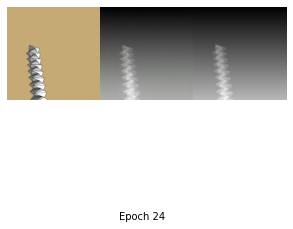

Epoch [25/50], Step [1/3750], D_loss: 0.1217, G_loss: 7.7213
Epoch [25/50], Step [2/3750], D_loss: 0.1216, G_loss: 6.5430
Epoch [25/50], Step [3/3750], D_loss: 0.0253, G_loss: 8.2550
Epoch [25/50], Step [4/3750], D_loss: 0.1078, G_loss: 9.2143
Epoch [25/50], Step [5/3750], D_loss: 0.0598, G_loss: 6.6388
Epoch [25/50], Step [6/3750], D_loss: 0.1960, G_loss: 8.0482
Epoch [25/50], Step [7/3750], D_loss: 0.0406, G_loss: 9.0459
Epoch [25/50], Step [8/3750], D_loss: 0.0194, G_loss: 11.2489
Epoch [25/50], Step [9/3750], D_loss: 0.0335, G_loss: 9.1430
Epoch [25/50], Step [10/3750], D_loss: 0.1593, G_loss: 5.2592
Epoch [25/50], Step [11/3750], D_loss: 0.0417, G_loss: 9.5556
Epoch [25/50], Step [12/3750], D_loss: 0.2882, G_loss: 5.8775
Epoch [25/50], Step [13/3750], D_loss: 0.2115, G_loss: 3.9884
Epoch [25/50], Step [14/3750], D_loss: 0.1971, G_loss: 4.8759
Epoch [25/50], Step [15/3750], D_loss: 0.0496, G_loss: 10.1296
Epoch [25/50], Step [16/3750], D_loss: 0.2237, G_loss: 7.3545
Epoch [25/50], 

Epoch [25/50], Step [133/3750], D_loss: 0.2015, G_loss: 7.1758
Epoch [25/50], Step [134/3750], D_loss: 0.0266, G_loss: 15.9575
Epoch [25/50], Step [135/3750], D_loss: 0.1345, G_loss: 7.3438
Epoch [25/50], Step [136/3750], D_loss: 0.1716, G_loss: 8.9734
Epoch [25/50], Step [137/3750], D_loss: 0.1535, G_loss: 9.3285
Epoch [25/50], Step [138/3750], D_loss: 0.0386, G_loss: 13.0433
Epoch [25/50], Step [139/3750], D_loss: 0.0362, G_loss: 6.3813
Epoch [25/50], Step [140/3750], D_loss: 0.0588, G_loss: 8.3452
Epoch [25/50], Step [141/3750], D_loss: 0.1366, G_loss: 8.6995
Epoch [25/50], Step [142/3750], D_loss: 0.0633, G_loss: 11.7667
Epoch [25/50], Step [143/3750], D_loss: 0.0473, G_loss: 6.8092
Epoch [25/50], Step [144/3750], D_loss: 0.0191, G_loss: 11.4346
Epoch [25/50], Step [145/3750], D_loss: 0.1095, G_loss: 6.5538
Epoch [25/50], Step [146/3750], D_loss: 0.0434, G_loss: 8.1133
Epoch [25/50], Step [147/3750], D_loss: 0.0129, G_loss: 16.5777
Epoch [25/50], Step [148/3750], D_loss: 0.0351, G_

Epoch [25/50], Step [263/3750], D_loss: 0.0156, G_loss: 11.7390
Epoch [25/50], Step [264/3750], D_loss: 0.1378, G_loss: 9.1916
Epoch [25/50], Step [265/3750], D_loss: 0.0505, G_loss: 8.1583
Epoch [25/50], Step [266/3750], D_loss: 0.0018, G_loss: 12.0133
Epoch [25/50], Step [267/3750], D_loss: 0.2773, G_loss: 9.9590
Epoch [25/50], Step [268/3750], D_loss: 0.0945, G_loss: 12.8537
Epoch [25/50], Step [269/3750], D_loss: 0.4303, G_loss: 5.1752
Epoch [25/50], Step [270/3750], D_loss: 0.2662, G_loss: 5.1384
Epoch [25/50], Step [271/3750], D_loss: 0.0704, G_loss: 13.9523
Epoch [25/50], Step [272/3750], D_loss: 0.2257, G_loss: 6.5349
Epoch [25/50], Step [273/3750], D_loss: 0.0375, G_loss: 12.9547
Epoch [25/50], Step [274/3750], D_loss: 0.0083, G_loss: 8.0763
Epoch [25/50], Step [275/3750], D_loss: 0.0081, G_loss: 12.1889
Epoch [25/50], Step [276/3750], D_loss: 0.1835, G_loss: 8.3515
Epoch [25/50], Step [277/3750], D_loss: 0.0023, G_loss: 9.7571
Epoch [25/50], Step [278/3750], D_loss: 0.0819, G

Epoch [25/50], Step [393/3750], D_loss: 0.0425, G_loss: 6.5689
Epoch [25/50], Step [394/3750], D_loss: 0.0285, G_loss: 11.7145
Epoch [25/50], Step [395/3750], D_loss: 0.1411, G_loss: 7.0201
Epoch [25/50], Step [396/3750], D_loss: 0.2935, G_loss: 5.5629
Epoch [25/50], Step [397/3750], D_loss: 0.1172, G_loss: 7.8811
Epoch [25/50], Step [398/3750], D_loss: 0.0146, G_loss: 8.1699
Epoch [25/50], Step [399/3750], D_loss: 0.6697, G_loss: 3.9599
Epoch [25/50], Step [400/3750], D_loss: 0.3152, G_loss: 7.7752
Epoch [25/50], Step [401/3750], D_loss: 0.0462, G_loss: 9.1231
Epoch [25/50], Step [402/3750], D_loss: 0.1989, G_loss: 9.5353
Epoch [25/50], Step [403/3750], D_loss: 0.0329, G_loss: 13.4700
Epoch [25/50], Step [404/3750], D_loss: 0.1385, G_loss: 11.7675
Epoch [25/50], Step [405/3750], D_loss: 0.0363, G_loss: 6.8234
Epoch [25/50], Step [406/3750], D_loss: 0.3796, G_loss: 6.9634
Epoch [25/50], Step [407/3750], D_loss: 0.1029, G_loss: 7.4658
Epoch [25/50], Step [408/3750], D_loss: 0.2667, G_lo

Epoch [25/50], Step [523/3750], D_loss: 0.0083, G_loss: 10.3398
Epoch [25/50], Step [524/3750], D_loss: 0.0228, G_loss: 14.3906
Epoch [25/50], Step [525/3750], D_loss: 0.2792, G_loss: 6.0717
Epoch [25/50], Step [526/3750], D_loss: 0.0384, G_loss: 12.7680
Epoch [25/50], Step [527/3750], D_loss: 0.0229, G_loss: 12.9925
Epoch [25/50], Step [528/3750], D_loss: 0.1467, G_loss: 5.7277
Epoch [25/50], Step [529/3750], D_loss: 0.0709, G_loss: 7.4090
Epoch [25/50], Step [530/3750], D_loss: 0.0755, G_loss: 6.1491
Epoch [25/50], Step [531/3750], D_loss: 0.0668, G_loss: 6.0912
Epoch [25/50], Step [532/3750], D_loss: 0.0567, G_loss: 6.1873
Epoch [25/50], Step [533/3750], D_loss: 0.0039, G_loss: 16.8064
Epoch [25/50], Step [534/3750], D_loss: 0.0462, G_loss: 9.2988
Epoch [25/50], Step [535/3750], D_loss: 0.0046, G_loss: 12.0284
Epoch [25/50], Step [536/3750], D_loss: 0.0018, G_loss: 11.7211
Epoch [25/50], Step [537/3750], D_loss: 0.2891, G_loss: 10.9530
Epoch [25/50], Step [538/3750], D_loss: 0.0275,

Epoch [25/50], Step [653/3750], D_loss: 0.0374, G_loss: 14.1750
Epoch [25/50], Step [654/3750], D_loss: 0.0043, G_loss: 9.5622
Epoch [25/50], Step [655/3750], D_loss: 0.0038, G_loss: 7.7096
Epoch [25/50], Step [656/3750], D_loss: 0.2695, G_loss: 7.7424
Epoch [25/50], Step [657/3750], D_loss: 0.1031, G_loss: 12.7794
Epoch [25/50], Step [658/3750], D_loss: 0.1229, G_loss: 7.1132
Epoch [25/50], Step [659/3750], D_loss: 0.0325, G_loss: 8.4404
Epoch [25/50], Step [660/3750], D_loss: 0.6624, G_loss: 9.5352
Epoch [25/50], Step [661/3750], D_loss: 0.0256, G_loss: 10.3198
Epoch [25/50], Step [662/3750], D_loss: 0.0663, G_loss: 13.4704
Epoch [25/50], Step [663/3750], D_loss: 0.0183, G_loss: 9.9801
Epoch [25/50], Step [664/3750], D_loss: 0.0342, G_loss: 7.0267
Epoch [25/50], Step [665/3750], D_loss: 0.0635, G_loss: 8.6939
Epoch [25/50], Step [666/3750], D_loss: 0.0271, G_loss: 8.4554
Epoch [25/50], Step [667/3750], D_loss: 0.1857, G_loss: 9.7047
Epoch [25/50], Step [668/3750], D_loss: 0.0181, G_l

Epoch [25/50], Step [783/3750], D_loss: 0.0031, G_loss: 9.7001
Epoch [25/50], Step [784/3750], D_loss: 0.1014, G_loss: 9.8532
Epoch [25/50], Step [785/3750], D_loss: 0.2065, G_loss: 9.0305
Epoch [25/50], Step [786/3750], D_loss: 0.0096, G_loss: 10.1057
Epoch [25/50], Step [787/3750], D_loss: 0.0106, G_loss: 11.4480
Epoch [25/50], Step [788/3750], D_loss: 0.0797, G_loss: 6.3853
Epoch [25/50], Step [789/3750], D_loss: 0.0076, G_loss: 11.3867
Epoch [25/50], Step [790/3750], D_loss: 0.2047, G_loss: 13.3879
Epoch [25/50], Step [791/3750], D_loss: 0.0235, G_loss: 6.5546
Epoch [25/50], Step [792/3750], D_loss: 0.0119, G_loss: 14.8288
Epoch [25/50], Step [793/3750], D_loss: 0.1449, G_loss: 7.0726
Epoch [25/50], Step [794/3750], D_loss: 0.0697, G_loss: 6.2066
Epoch [25/50], Step [795/3750], D_loss: 0.0054, G_loss: 11.8007
Epoch [25/50], Step [796/3750], D_loss: 0.0125, G_loss: 15.1753
Epoch [25/50], Step [797/3750], D_loss: 0.1087, G_loss: 11.5201
Epoch [25/50], Step [798/3750], D_loss: 0.0298,

Epoch [25/50], Step [913/3750], D_loss: 0.0384, G_loss: 18.1491
Epoch [25/50], Step [914/3750], D_loss: 0.2201, G_loss: 10.9809
Epoch [25/50], Step [915/3750], D_loss: 0.1401, G_loss: 5.2947
Epoch [25/50], Step [916/3750], D_loss: 0.2365, G_loss: 7.7065
Epoch [25/50], Step [917/3750], D_loss: 0.0391, G_loss: 7.9094
Epoch [25/50], Step [918/3750], D_loss: 0.0189, G_loss: 6.7684
Epoch [25/50], Step [919/3750], D_loss: 0.0911, G_loss: 5.1367
Epoch [25/50], Step [920/3750], D_loss: 0.3090, G_loss: 12.9142
Epoch [25/50], Step [921/3750], D_loss: 0.1510, G_loss: 14.0359
Epoch [25/50], Step [922/3750], D_loss: 0.0279, G_loss: 7.4069
Epoch [25/50], Step [923/3750], D_loss: 0.0225, G_loss: 10.3364
Epoch [25/50], Step [924/3750], D_loss: 0.0039, G_loss: 11.8275
Epoch [25/50], Step [925/3750], D_loss: 0.0946, G_loss: 6.7193
Epoch [25/50], Step [926/3750], D_loss: 0.1153, G_loss: 13.7591
Epoch [25/50], Step [927/3750], D_loss: 0.0163, G_loss: 15.5110
Epoch [25/50], Step [928/3750], D_loss: 0.0130,

Epoch [25/50], Step [1042/3750], D_loss: 0.2946, G_loss: 12.1140
Epoch [25/50], Step [1043/3750], D_loss: 0.0249, G_loss: 9.4623
Epoch [25/50], Step [1044/3750], D_loss: 0.1927, G_loss: 6.0206
Epoch [25/50], Step [1045/3750], D_loss: 0.0209, G_loss: 6.8765
Epoch [25/50], Step [1046/3750], D_loss: 0.0703, G_loss: 9.1859
Epoch [25/50], Step [1047/3750], D_loss: 0.0924, G_loss: 6.2937
Epoch [25/50], Step [1048/3750], D_loss: 0.0961, G_loss: 6.0401
Epoch [25/50], Step [1049/3750], D_loss: 0.0246, G_loss: 7.1271
Epoch [25/50], Step [1050/3750], D_loss: 0.1251, G_loss: 8.9784
Epoch [25/50], Step [1051/3750], D_loss: 0.0066, G_loss: 8.3961
Epoch [25/50], Step [1052/3750], D_loss: 0.0067, G_loss: 12.3440
Epoch [25/50], Step [1053/3750], D_loss: 0.0051, G_loss: 11.0913
Epoch [25/50], Step [1054/3750], D_loss: 0.0650, G_loss: 8.7588
Epoch [25/50], Step [1055/3750], D_loss: 0.0697, G_loss: 10.8914
Epoch [25/50], Step [1056/3750], D_loss: 0.0038, G_loss: 8.6576
Epoch [25/50], Step [1057/3750], D_l

Epoch [25/50], Step [1170/3750], D_loss: 0.0058, G_loss: 7.2236
Epoch [25/50], Step [1171/3750], D_loss: 0.3957, G_loss: 7.5548
Epoch [25/50], Step [1172/3750], D_loss: 0.2510, G_loss: 10.9366
Epoch [25/50], Step [1173/3750], D_loss: 0.1248, G_loss: 7.9289
Epoch [25/50], Step [1174/3750], D_loss: 0.1853, G_loss: 9.0636
Epoch [25/50], Step [1175/3750], D_loss: 0.0019, G_loss: 8.4784
Epoch [25/50], Step [1176/3750], D_loss: 0.0975, G_loss: 9.0822
Epoch [25/50], Step [1177/3750], D_loss: 0.0121, G_loss: 16.8747
Epoch [25/50], Step [1178/3750], D_loss: 0.0032, G_loss: 15.3156
Epoch [25/50], Step [1179/3750], D_loss: 0.0778, G_loss: 7.8363
Epoch [25/50], Step [1180/3750], D_loss: 0.0597, G_loss: 7.6649
Epoch [25/50], Step [1181/3750], D_loss: 0.0326, G_loss: 10.7841
Epoch [25/50], Step [1182/3750], D_loss: 0.0555, G_loss: 8.1693
Epoch [25/50], Step [1183/3750], D_loss: 0.0025, G_loss: 12.6763
Epoch [25/50], Step [1184/3750], D_loss: 0.0701, G_loss: 7.2948
Epoch [25/50], Step [1185/3750], D_

Epoch [25/50], Step [1298/3750], D_loss: 0.0089, G_loss: 14.5973
Epoch [25/50], Step [1299/3750], D_loss: 0.0065, G_loss: 7.7561
Epoch [25/50], Step [1300/3750], D_loss: 0.0120, G_loss: 9.2729
Epoch [25/50], Step [1301/3750], D_loss: 0.0832, G_loss: 8.2286
Epoch [25/50], Step [1302/3750], D_loss: 0.0124, G_loss: 11.1340
Epoch [25/50], Step [1303/3750], D_loss: 0.0288, G_loss: 9.0333
Epoch [25/50], Step [1304/3750], D_loss: 0.1208, G_loss: 6.7689
Epoch [25/50], Step [1305/3750], D_loss: 0.0891, G_loss: 33.4220
Epoch [25/50], Step [1306/3750], D_loss: 0.2266, G_loss: 7.4567
Epoch [25/50], Step [1307/3750], D_loss: 0.0179, G_loss: 10.5469
Epoch [25/50], Step [1308/3750], D_loss: 0.0091, G_loss: 7.6180
Epoch [25/50], Step [1309/3750], D_loss: 0.0843, G_loss: 7.1707
Epoch [25/50], Step [1310/3750], D_loss: 0.0487, G_loss: 9.3243
Epoch [25/50], Step [1311/3750], D_loss: 0.0010, G_loss: 11.4452
Epoch [25/50], Step [1312/3750], D_loss: 0.0033, G_loss: 13.0031
Epoch [25/50], Step [1313/3750], D

Epoch [25/50], Step [1426/3750], D_loss: 0.0065, G_loss: 11.8959
Epoch [25/50], Step [1427/3750], D_loss: 0.0132, G_loss: 9.8626
Epoch [25/50], Step [1428/3750], D_loss: 0.0446, G_loss: 10.4550
Epoch [25/50], Step [1429/3750], D_loss: 0.0258, G_loss: 9.7188
Epoch [25/50], Step [1430/3750], D_loss: 0.0201, G_loss: 7.6115
Epoch [25/50], Step [1431/3750], D_loss: 0.1935, G_loss: 9.1855
Epoch [25/50], Step [1432/3750], D_loss: 0.0301, G_loss: 7.3894
Epoch [25/50], Step [1433/3750], D_loss: 0.1328, G_loss: 6.8081
Epoch [25/50], Step [1434/3750], D_loss: 0.0569, G_loss: 10.0166
Epoch [25/50], Step [1435/3750], D_loss: 0.0583, G_loss: 9.2230
Epoch [25/50], Step [1436/3750], D_loss: 0.0453, G_loss: 10.9567
Epoch [25/50], Step [1437/3750], D_loss: 0.0430, G_loss: 9.5881
Epoch [25/50], Step [1438/3750], D_loss: 0.0199, G_loss: 9.4137
Epoch [25/50], Step [1439/3750], D_loss: 0.0846, G_loss: 7.1134
Epoch [25/50], Step [1440/3750], D_loss: 0.0024, G_loss: 9.9216
Epoch [25/50], Step [1441/3750], D_l

Epoch [25/50], Step [1554/3750], D_loss: 0.0220, G_loss: 9.8020
Epoch [25/50], Step [1555/3750], D_loss: 0.3199, G_loss: 13.3547
Epoch [25/50], Step [1556/3750], D_loss: 0.0173, G_loss: 11.6412
Epoch [25/50], Step [1557/3750], D_loss: 0.1310, G_loss: 13.0192
Epoch [25/50], Step [1558/3750], D_loss: 0.1944, G_loss: 10.9914
Epoch [25/50], Step [1559/3750], D_loss: 0.0581, G_loss: 6.8788
Epoch [25/50], Step [1560/3750], D_loss: 0.0768, G_loss: 15.6931
Epoch [25/50], Step [1561/3750], D_loss: 0.0211, G_loss: 10.8399
Epoch [25/50], Step [1562/3750], D_loss: 0.0906, G_loss: 9.5306
Epoch [25/50], Step [1563/3750], D_loss: 0.1339, G_loss: 7.3871
Epoch [25/50], Step [1564/3750], D_loss: 0.0200, G_loss: 11.6139
Epoch [25/50], Step [1565/3750], D_loss: 0.1896, G_loss: 6.8375
Epoch [25/50], Step [1566/3750], D_loss: 0.1112, G_loss: 6.8329
Epoch [25/50], Step [1567/3750], D_loss: 0.2376, G_loss: 9.6543
Epoch [25/50], Step [1568/3750], D_loss: 0.1408, G_loss: 6.8341
Epoch [25/50], Step [1569/3750], 

Epoch [25/50], Step [1682/3750], D_loss: 0.3723, G_loss: 5.6638
Epoch [25/50], Step [1683/3750], D_loss: 0.0462, G_loss: 6.1777
Epoch [25/50], Step [1684/3750], D_loss: 0.1998, G_loss: 6.5146
Epoch [25/50], Step [1685/3750], D_loss: 0.0176, G_loss: 9.3057
Epoch [25/50], Step [1686/3750], D_loss: 1.0589, G_loss: 3.9080
Epoch [25/50], Step [1687/3750], D_loss: 0.0832, G_loss: 8.3860
Epoch [25/50], Step [1688/3750], D_loss: 0.3154, G_loss: 5.0542
Epoch [25/50], Step [1689/3750], D_loss: 0.1626, G_loss: 11.3115
Epoch [25/50], Step [1690/3750], D_loss: 0.2970, G_loss: 10.0323
Epoch [25/50], Step [1691/3750], D_loss: 0.0263, G_loss: 6.5789
Epoch [25/50], Step [1692/3750], D_loss: 0.0137, G_loss: 19.2430
Epoch [25/50], Step [1693/3750], D_loss: 0.0114, G_loss: 7.0681
Epoch [25/50], Step [1694/3750], D_loss: 0.0766, G_loss: 14.8512
Epoch [25/50], Step [1695/3750], D_loss: 0.0035, G_loss: 19.3509
Epoch [25/50], Step [1696/3750], D_loss: 0.0063, G_loss: 8.3278
Epoch [25/50], Step [1697/3750], D_

Epoch [25/50], Step [1810/3750], D_loss: 0.1426, G_loss: 6.6281
Epoch [25/50], Step [1811/3750], D_loss: 0.3664, G_loss: 5.9292
Epoch [25/50], Step [1812/3750], D_loss: 0.0077, G_loss: 19.3159
Epoch [25/50], Step [1813/3750], D_loss: 0.3506, G_loss: 8.1038
Epoch [25/50], Step [1814/3750], D_loss: 0.0744, G_loss: 11.0333
Epoch [25/50], Step [1815/3750], D_loss: 0.0751, G_loss: 11.9293
Epoch [25/50], Step [1816/3750], D_loss: 0.0106, G_loss: 9.4268
Epoch [25/50], Step [1817/3750], D_loss: 1.5510, G_loss: 5.2374
Epoch [25/50], Step [1818/3750], D_loss: 0.2445, G_loss: 8.7620
Epoch [25/50], Step [1819/3750], D_loss: 0.0837, G_loss: 6.6783
Epoch [25/50], Step [1820/3750], D_loss: 0.1024, G_loss: 7.0778
Epoch [25/50], Step [1821/3750], D_loss: 0.0050, G_loss: 16.3501
Epoch [25/50], Step [1822/3750], D_loss: 0.0270, G_loss: 7.1338
Epoch [25/50], Step [1823/3750], D_loss: 0.2494, G_loss: 4.9279
Epoch [25/50], Step [1824/3750], D_loss: 0.1103, G_loss: 8.2636
Epoch [25/50], Step [1825/3750], D_l

Epoch [25/50], Step [1938/3750], D_loss: 0.0876, G_loss: 11.0815
Epoch [25/50], Step [1939/3750], D_loss: 0.0629, G_loss: 8.3274
Epoch [25/50], Step [1940/3750], D_loss: 0.0037, G_loss: 9.4366
Epoch [25/50], Step [1941/3750], D_loss: 0.3278, G_loss: 10.2105
Epoch [25/50], Step [1942/3750], D_loss: 0.0147, G_loss: 9.0295
Epoch [25/50], Step [1943/3750], D_loss: 0.0668, G_loss: 7.2819
Epoch [25/50], Step [1944/3750], D_loss: 0.8827, G_loss: 5.2918
Epoch [25/50], Step [1945/3750], D_loss: 0.0241, G_loss: 13.4154
Epoch [25/50], Step [1946/3750], D_loss: 0.3627, G_loss: 10.3511
Epoch [25/50], Step [1947/3750], D_loss: 0.3287, G_loss: 10.0093
Epoch [25/50], Step [1948/3750], D_loss: 0.2751, G_loss: 8.9213
Epoch [25/50], Step [1949/3750], D_loss: 0.1350, G_loss: 6.0662
Epoch [25/50], Step [1950/3750], D_loss: 0.1940, G_loss: 6.8639
Epoch [25/50], Step [1951/3750], D_loss: 0.3425, G_loss: 6.1967
Epoch [25/50], Step [1952/3750], D_loss: 0.0299, G_loss: 9.6051
Epoch [25/50], Step [1953/3750], D_

Epoch [25/50], Step [2066/3750], D_loss: 0.0231, G_loss: 7.0813
Epoch [25/50], Step [2067/3750], D_loss: 0.0282, G_loss: 6.6366
Epoch [25/50], Step [2068/3750], D_loss: 0.0011, G_loss: 15.7116
Epoch [25/50], Step [2069/3750], D_loss: 0.0046, G_loss: 10.1340
Epoch [25/50], Step [2070/3750], D_loss: 0.0059, G_loss: 11.3876
Epoch [25/50], Step [2071/3750], D_loss: 0.1466, G_loss: 4.1659
Epoch [25/50], Step [2072/3750], D_loss: 0.0164, G_loss: 12.4681
Epoch [25/50], Step [2073/3750], D_loss: 0.0179, G_loss: 12.0678
Epoch [25/50], Step [2074/3750], D_loss: 0.1510, G_loss: 7.2163
Epoch [25/50], Step [2075/3750], D_loss: 0.0112, G_loss: 9.9945
Epoch [25/50], Step [2076/3750], D_loss: 0.0105, G_loss: 12.8797
Epoch [25/50], Step [2077/3750], D_loss: 0.0128, G_loss: 8.7527
Epoch [25/50], Step [2078/3750], D_loss: 0.0608, G_loss: 7.9494
Epoch [25/50], Step [2079/3750], D_loss: 0.0115, G_loss: 6.7742
Epoch [25/50], Step [2080/3750], D_loss: 0.0805, G_loss: 5.9321
Epoch [25/50], Step [2081/3750], D

Epoch [25/50], Step [2194/3750], D_loss: 0.0215, G_loss: 11.3344
Epoch [25/50], Step [2195/3750], D_loss: 0.0172, G_loss: 10.0848
Epoch [25/50], Step [2196/3750], D_loss: 0.0174, G_loss: 11.3832
Epoch [25/50], Step [2197/3750], D_loss: 0.1407, G_loss: 7.4995
Epoch [25/50], Step [2198/3750], D_loss: 0.1366, G_loss: 5.9276
Epoch [25/50], Step [2199/3750], D_loss: 0.0097, G_loss: 6.5339
Epoch [25/50], Step [2200/3750], D_loss: 0.0658, G_loss: 10.5678
Epoch [25/50], Step [2201/3750], D_loss: 0.0533, G_loss: 9.8447
Epoch [25/50], Step [2202/3750], D_loss: 0.0449, G_loss: 17.0140
Epoch [25/50], Step [2203/3750], D_loss: 0.0032, G_loss: 14.2940
Epoch [25/50], Step [2204/3750], D_loss: 0.0023, G_loss: 11.8657
Epoch [25/50], Step [2205/3750], D_loss: 0.0118, G_loss: 7.1309
Epoch [25/50], Step [2206/3750], D_loss: 0.0318, G_loss: 12.9512
Epoch [25/50], Step [2207/3750], D_loss: 0.0844, G_loss: 7.4510
Epoch [25/50], Step [2208/3750], D_loss: 0.3350, G_loss: 8.3161
Epoch [25/50], Step [2209/3750],

Epoch [25/50], Step [2322/3750], D_loss: 0.0377, G_loss: 6.9637
Epoch [25/50], Step [2323/3750], D_loss: 0.0159, G_loss: 7.7417
Epoch [25/50], Step [2324/3750], D_loss: 0.0129, G_loss: 5.6533
Epoch [25/50], Step [2325/3750], D_loss: 0.0433, G_loss: 6.5459
Epoch [25/50], Step [2326/3750], D_loss: 0.0263, G_loss: 7.0247
Epoch [25/50], Step [2327/3750], D_loss: 0.0918, G_loss: 8.5267
Epoch [25/50], Step [2328/3750], D_loss: 0.1606, G_loss: 11.1435
Epoch [25/50], Step [2329/3750], D_loss: 0.0957, G_loss: 8.7253
Epoch [25/50], Step [2330/3750], D_loss: 0.0336, G_loss: 7.4002
Epoch [25/50], Step [2331/3750], D_loss: 0.0263, G_loss: 5.9623
Epoch [25/50], Step [2332/3750], D_loss: 0.3300, G_loss: 5.4365
Epoch [25/50], Step [2333/3750], D_loss: 0.0604, G_loss: 8.2414
Epoch [25/50], Step [2334/3750], D_loss: 0.0199, G_loss: 11.9050
Epoch [25/50], Step [2335/3750], D_loss: 0.0492, G_loss: 10.8538
Epoch [25/50], Step [2336/3750], D_loss: 0.5381, G_loss: 4.8270
Epoch [25/50], Step [2337/3750], D_lo

Epoch [25/50], Step [2450/3750], D_loss: 0.0520, G_loss: 8.9875
Epoch [25/50], Step [2451/3750], D_loss: 0.1364, G_loss: 7.7394
Epoch [25/50], Step [2452/3750], D_loss: 0.0149, G_loss: 8.2557
Epoch [25/50], Step [2453/3750], D_loss: 0.0170, G_loss: 7.8685
Epoch [25/50], Step [2454/3750], D_loss: 0.0906, G_loss: 5.7955
Epoch [25/50], Step [2455/3750], D_loss: 0.0142, G_loss: 9.7923
Epoch [25/50], Step [2456/3750], D_loss: 0.0261, G_loss: 11.5255
Epoch [25/50], Step [2457/3750], D_loss: 0.0207, G_loss: 9.5315
Epoch [25/50], Step [2458/3750], D_loss: 0.0202, G_loss: 12.9251
Epoch [25/50], Step [2459/3750], D_loss: 0.0078, G_loss: 12.3302
Epoch [25/50], Step [2460/3750], D_loss: 0.0948, G_loss: 8.0761
Epoch [25/50], Step [2461/3750], D_loss: 0.0043, G_loss: 6.9236
Epoch [25/50], Step [2462/3750], D_loss: 0.0781, G_loss: 7.6383
Epoch [25/50], Step [2463/3750], D_loss: 0.0354, G_loss: 8.9337
Epoch [25/50], Step [2464/3750], D_loss: 0.0238, G_loss: 8.1815
Epoch [25/50], Step [2465/3750], D_lo

Epoch [25/50], Step [2578/3750], D_loss: 0.0082, G_loss: 15.3704
Epoch [25/50], Step [2579/3750], D_loss: 0.2503, G_loss: 23.6655
Epoch [25/50], Step [2580/3750], D_loss: 0.0448, G_loss: 9.6855
Epoch [25/50], Step [2581/3750], D_loss: 0.0216, G_loss: 11.4666
Epoch [25/50], Step [2582/3750], D_loss: 0.0355, G_loss: 8.6279
Epoch [25/50], Step [2583/3750], D_loss: 0.1526, G_loss: 8.3756
Epoch [25/50], Step [2584/3750], D_loss: 0.0377, G_loss: 6.0608
Epoch [25/50], Step [2585/3750], D_loss: 0.0422, G_loss: 10.2694
Epoch [25/50], Step [2586/3750], D_loss: 0.0906, G_loss: 5.8864
Epoch [25/50], Step [2587/3750], D_loss: 0.1824, G_loss: 7.3367
Epoch [25/50], Step [2588/3750], D_loss: 0.1642, G_loss: 8.4473
Epoch [25/50], Step [2589/3750], D_loss: 0.0517, G_loss: 7.5149
Epoch [25/50], Step [2590/3750], D_loss: 0.0667, G_loss: 13.4787
Epoch [25/50], Step [2591/3750], D_loss: 0.1011, G_loss: 7.3800
Epoch [25/50], Step [2592/3750], D_loss: 0.0729, G_loss: 9.5239
Epoch [25/50], Step [2593/3750], D_

Epoch [25/50], Step [2706/3750], D_loss: 0.0566, G_loss: 16.1538
Epoch [25/50], Step [2707/3750], D_loss: 0.0035, G_loss: 14.1076
Epoch [25/50], Step [2708/3750], D_loss: 0.0654, G_loss: 6.5466
Epoch [25/50], Step [2709/3750], D_loss: 0.2112, G_loss: 10.5258
Epoch [25/50], Step [2710/3750], D_loss: 0.1779, G_loss: 4.9980
Epoch [25/50], Step [2711/3750], D_loss: 0.0450, G_loss: 9.2721
Epoch [25/50], Step [2712/3750], D_loss: 0.1509, G_loss: 8.0633
Epoch [25/50], Step [2713/3750], D_loss: 0.1905, G_loss: 8.8539
Epoch [25/50], Step [2714/3750], D_loss: 0.0082, G_loss: 12.6624
Epoch [25/50], Step [2715/3750], D_loss: 0.0547, G_loss: 5.8370
Epoch [25/50], Step [2716/3750], D_loss: 0.1339, G_loss: 7.9747
Epoch [25/50], Step [2717/3750], D_loss: 0.2585, G_loss: 6.0744
Epoch [25/50], Step [2718/3750], D_loss: 0.0090, G_loss: 19.1780
Epoch [25/50], Step [2719/3750], D_loss: 0.0147, G_loss: 8.7897
Epoch [25/50], Step [2720/3750], D_loss: 0.0462, G_loss: 15.9294
Epoch [25/50], Step [2721/3750], D

Epoch [25/50], Step [2834/3750], D_loss: 0.0660, G_loss: 7.8701
Epoch [25/50], Step [2835/3750], D_loss: 0.4614, G_loss: 3.7562
Epoch [25/50], Step [2836/3750], D_loss: 0.0052, G_loss: 14.1076
Epoch [25/50], Step [2837/3750], D_loss: 0.0187, G_loss: 11.3661
Epoch [25/50], Step [2838/3750], D_loss: 0.0562, G_loss: 9.7960
Epoch [25/50], Step [2839/3750], D_loss: 0.0631, G_loss: 9.2601
Epoch [25/50], Step [2840/3750], D_loss: 0.0089, G_loss: 19.3029
Epoch [25/50], Step [2841/3750], D_loss: 0.0137, G_loss: 9.0817
Epoch [25/50], Step [2842/3750], D_loss: 0.1430, G_loss: 6.2354
Epoch [25/50], Step [2843/3750], D_loss: 0.0718, G_loss: 8.9073
Epoch [25/50], Step [2844/3750], D_loss: 0.5306, G_loss: 7.6939
Epoch [25/50], Step [2845/3750], D_loss: 0.0020, G_loss: 8.7654
Epoch [25/50], Step [2846/3750], D_loss: 0.0443, G_loss: 9.1938
Epoch [25/50], Step [2847/3750], D_loss: 0.0019, G_loss: 14.2746
Epoch [25/50], Step [2848/3750], D_loss: 0.3274, G_loss: 9.8946
Epoch [25/50], Step [2849/3750], D_l

Epoch [25/50], Step [2962/3750], D_loss: 0.0005, G_loss: 14.3313
Epoch [25/50], Step [2963/3750], D_loss: 0.0013, G_loss: 9.8295
Epoch [25/50], Step [2964/3750], D_loss: 0.0012, G_loss: 8.7546
Epoch [25/50], Step [2965/3750], D_loss: 0.0010, G_loss: 14.8741
Epoch [25/50], Step [2966/3750], D_loss: 0.0008, G_loss: 8.2419
Epoch [25/50], Step [2967/3750], D_loss: 0.0029, G_loss: 9.5578
Epoch [25/50], Step [2968/3750], D_loss: 0.0014, G_loss: 14.2552
Epoch [25/50], Step [2969/3750], D_loss: 0.5780, G_loss: 7.3757
Epoch [25/50], Step [2970/3750], D_loss: 0.2903, G_loss: 5.4607
Epoch [25/50], Step [2971/3750], D_loss: 0.3057, G_loss: 7.9477
Epoch [25/50], Step [2972/3750], D_loss: 0.0084, G_loss: 9.5060
Epoch [25/50], Step [2973/3750], D_loss: 0.0043, G_loss: 14.2829
Epoch [25/50], Step [2974/3750], D_loss: 0.2104, G_loss: 5.9627
Epoch [25/50], Step [2975/3750], D_loss: 0.0074, G_loss: 14.6223
Epoch [25/50], Step [2976/3750], D_loss: 0.1252, G_loss: 6.5287
Epoch [25/50], Step [2977/3750], D_

Epoch [25/50], Step [3090/3750], D_loss: 0.1538, G_loss: 11.7347
Epoch [25/50], Step [3091/3750], D_loss: 0.0017, G_loss: 9.8533
Epoch [25/50], Step [3092/3750], D_loss: 0.0396, G_loss: 7.7973
Epoch [25/50], Step [3093/3750], D_loss: 0.0106, G_loss: 6.9998
Epoch [25/50], Step [3094/3750], D_loss: 0.0765, G_loss: 6.3534
Epoch [25/50], Step [3095/3750], D_loss: 0.1135, G_loss: 8.3778
Epoch [25/50], Step [3096/3750], D_loss: 0.0013, G_loss: 18.7108
Epoch [25/50], Step [3097/3750], D_loss: 0.0016, G_loss: 9.7170
Epoch [25/50], Step [3098/3750], D_loss: 0.0060, G_loss: 11.9713
Epoch [25/50], Step [3099/3750], D_loss: 0.0713, G_loss: 8.3223
Epoch [25/50], Step [3100/3750], D_loss: 0.0418, G_loss: 9.8878
Epoch [25/50], Step [3101/3750], D_loss: 0.1091, G_loss: 7.6998
Epoch [25/50], Step [3102/3750], D_loss: 0.0006, G_loss: 12.6696
Epoch [25/50], Step [3103/3750], D_loss: 0.0006, G_loss: 10.3382
Epoch [25/50], Step [3104/3750], D_loss: 0.0107, G_loss: 9.1736
Epoch [25/50], Step [3105/3750], D_

Epoch [25/50], Step [3218/3750], D_loss: 0.0464, G_loss: 11.6981
Epoch [25/50], Step [3219/3750], D_loss: 0.1585, G_loss: 11.5925
Epoch [25/50], Step [3220/3750], D_loss: 0.0687, G_loss: 6.4964
Epoch [25/50], Step [3221/3750], D_loss: 0.1076, G_loss: 7.9206
Epoch [25/50], Step [3222/3750], D_loss: 0.0550, G_loss: 6.7443
Epoch [25/50], Step [3223/3750], D_loss: 0.0029, G_loss: 14.5171
Epoch [25/50], Step [3224/3750], D_loss: 0.3701, G_loss: 12.3649
Epoch [25/50], Step [3225/3750], D_loss: 0.1968, G_loss: 6.7498
Epoch [25/50], Step [3226/3750], D_loss: 0.0019, G_loss: 8.9299
Epoch [25/50], Step [3227/3750], D_loss: 0.2483, G_loss: 5.9296
Epoch [25/50], Step [3228/3750], D_loss: 0.0820, G_loss: 18.4022
Epoch [25/50], Step [3229/3750], D_loss: 0.0014, G_loss: 20.3494
Epoch [25/50], Step [3230/3750], D_loss: 0.1806, G_loss: 12.3486
Epoch [25/50], Step [3231/3750], D_loss: 0.0198, G_loss: 15.1130
Epoch [25/50], Step [3232/3750], D_loss: 0.3570, G_loss: 9.1728
Epoch [25/50], Step [3233/3750],

Epoch [25/50], Step [3346/3750], D_loss: 0.2535, G_loss: 13.2278
Epoch [25/50], Step [3347/3750], D_loss: 0.0144, G_loss: 13.6005
Epoch [25/50], Step [3348/3750], D_loss: 0.0553, G_loss: 12.3481
Epoch [25/50], Step [3349/3750], D_loss: 0.0016, G_loss: 14.8945
Epoch [25/50], Step [3350/3750], D_loss: 0.0437, G_loss: 21.6627
Epoch [25/50], Step [3351/3750], D_loss: 0.0024, G_loss: 11.5263
Epoch [25/50], Step [3352/3750], D_loss: 0.4379, G_loss: 6.9346
Epoch [25/50], Step [3353/3750], D_loss: 0.0109, G_loss: 13.3484
Epoch [25/50], Step [3354/3750], D_loss: 0.0486, G_loss: 10.0721
Epoch [25/50], Step [3355/3750], D_loss: 0.1559, G_loss: 10.0043
Epoch [25/50], Step [3356/3750], D_loss: 0.1325, G_loss: 7.0516
Epoch [25/50], Step [3357/3750], D_loss: 0.0703, G_loss: 11.3432
Epoch [25/50], Step [3358/3750], D_loss: 0.0823, G_loss: 9.5404
Epoch [25/50], Step [3359/3750], D_loss: 0.0165, G_loss: 9.3891
Epoch [25/50], Step [3360/3750], D_loss: 0.0068, G_loss: 14.9160
Epoch [25/50], Step [3361/375

Epoch [25/50], Step [3474/3750], D_loss: 0.3069, G_loss: 7.6841
Epoch [25/50], Step [3475/3750], D_loss: 0.0140, G_loss: 20.6807
Epoch [25/50], Step [3476/3750], D_loss: 0.0978, G_loss: 4.6001
Epoch [25/50], Step [3477/3750], D_loss: 0.0443, G_loss: 8.0599
Epoch [25/50], Step [3478/3750], D_loss: 0.0197, G_loss: 12.1419
Epoch [25/50], Step [3479/3750], D_loss: 0.0407, G_loss: 8.1211
Epoch [25/50], Step [3480/3750], D_loss: 0.0427, G_loss: 7.8075
Epoch [25/50], Step [3481/3750], D_loss: 0.1503, G_loss: 10.0071
Epoch [25/50], Step [3482/3750], D_loss: 0.0071, G_loss: 15.7479
Epoch [25/50], Step [3483/3750], D_loss: 0.1807, G_loss: 9.3207
Epoch [25/50], Step [3484/3750], D_loss: 0.0031, G_loss: 16.6172
Epoch [25/50], Step [3485/3750], D_loss: 0.0177, G_loss: 9.3107
Epoch [25/50], Step [3486/3750], D_loss: 0.0411, G_loss: 6.5040
Epoch [25/50], Step [3487/3750], D_loss: 0.0568, G_loss: 8.3161
Epoch [25/50], Step [3488/3750], D_loss: 0.0052, G_loss: 10.5173
Epoch [25/50], Step [3489/3750], D

Epoch [25/50], Step [3602/3750], D_loss: 0.5303, G_loss: 7.3842
Epoch [25/50], Step [3603/3750], D_loss: 0.7276, G_loss: 7.8445
Epoch [25/50], Step [3604/3750], D_loss: 0.1037, G_loss: 10.9700
Epoch [25/50], Step [3605/3750], D_loss: 0.2039, G_loss: 9.0155
Epoch [25/50], Step [3606/3750], D_loss: 0.0543, G_loss: 14.5990
Epoch [25/50], Step [3607/3750], D_loss: 0.0282, G_loss: 7.7864
Epoch [25/50], Step [3608/3750], D_loss: 0.0366, G_loss: 18.7781
Epoch [25/50], Step [3609/3750], D_loss: 0.2834, G_loss: 8.9159
Epoch [25/50], Step [3610/3750], D_loss: 0.0813, G_loss: 9.3944
Epoch [25/50], Step [3611/3750], D_loss: 0.0566, G_loss: 8.1482
Epoch [25/50], Step [3612/3750], D_loss: 0.0195, G_loss: 9.2213
Epoch [25/50], Step [3613/3750], D_loss: 0.0646, G_loss: 7.6928
Epoch [25/50], Step [3614/3750], D_loss: 0.3347, G_loss: 4.3569
Epoch [25/50], Step [3615/3750], D_loss: 0.1760, G_loss: 7.8838
Epoch [25/50], Step [3616/3750], D_loss: 0.0514, G_loss: 12.2751
Epoch [25/50], Step [3617/3750], D_l

Epoch [25/50], Step [3730/3750], D_loss: 0.0078, G_loss: 8.5282
Epoch [25/50], Step [3731/3750], D_loss: 0.1781, G_loss: 8.4211
Epoch [25/50], Step [3732/3750], D_loss: 0.0424, G_loss: 19.8763
Epoch [25/50], Step [3733/3750], D_loss: 0.0154, G_loss: 8.9017
Epoch [25/50], Step [3734/3750], D_loss: 0.0285, G_loss: 11.7890
Epoch [25/50], Step [3735/3750], D_loss: 0.0200, G_loss: 7.7767
Epoch [25/50], Step [3736/3750], D_loss: 0.1355, G_loss: 5.7541
Epoch [25/50], Step [3737/3750], D_loss: 0.3281, G_loss: 6.2782
Epoch [25/50], Step [3738/3750], D_loss: 0.0074, G_loss: 14.8462
Epoch [25/50], Step [3739/3750], D_loss: 0.0254, G_loss: 8.4042
Epoch [25/50], Step [3740/3750], D_loss: 0.0348, G_loss: 10.3461
Epoch [25/50], Step [3741/3750], D_loss: 0.1845, G_loss: 6.0543
Epoch [25/50], Step [3742/3750], D_loss: 0.0223, G_loss: 17.3849
Epoch [25/50], Step [3743/3750], D_loss: 0.1305, G_loss: 9.4462
Epoch [25/50], Step [3744/3750], D_loss: 0.2363, G_loss: 6.4110
Epoch [25/50], Step [3745/3750], D_

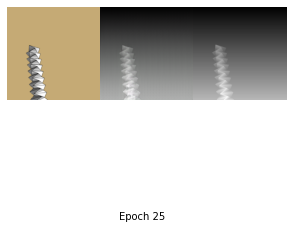

Epoch [26/50], Step [1/3750], D_loss: 0.0105, G_loss: 14.4097
Epoch [26/50], Step [2/3750], D_loss: 0.1035, G_loss: 9.7544
Epoch [26/50], Step [3/3750], D_loss: 0.1207, G_loss: 7.1566
Epoch [26/50], Step [4/3750], D_loss: 0.0779, G_loss: 10.6399
Epoch [26/50], Step [5/3750], D_loss: 0.0618, G_loss: 7.8531
Epoch [26/50], Step [6/3750], D_loss: 0.1858, G_loss: 7.8885
Epoch [26/50], Step [7/3750], D_loss: 0.0106, G_loss: 8.6564
Epoch [26/50], Step [8/3750], D_loss: 0.2581, G_loss: 13.4905
Epoch [26/50], Step [9/3750], D_loss: 0.0071, G_loss: 14.3172
Epoch [26/50], Step [10/3750], D_loss: 0.2008, G_loss: 8.5758
Epoch [26/50], Step [11/3750], D_loss: 0.0062, G_loss: 8.0763
Epoch [26/50], Step [12/3750], D_loss: 0.0180, G_loss: 5.9300
Epoch [26/50], Step [13/3750], D_loss: 0.0079, G_loss: 7.0071
Epoch [26/50], Step [14/3750], D_loss: 0.0174, G_loss: 11.2829
Epoch [26/50], Step [15/3750], D_loss: 0.0296, G_loss: 11.7988
Epoch [26/50], Step [16/3750], D_loss: 0.1005, G_loss: 6.1147
Epoch [26/5

Epoch [26/50], Step [133/3750], D_loss: 0.0152, G_loss: 8.0063
Epoch [26/50], Step [134/3750], D_loss: 0.0115, G_loss: 7.2005
Epoch [26/50], Step [135/3750], D_loss: 0.0484, G_loss: 7.6560
Epoch [26/50], Step [136/3750], D_loss: 0.0164, G_loss: 11.7143
Epoch [26/50], Step [137/3750], D_loss: 0.0465, G_loss: 8.0550
Epoch [26/50], Step [138/3750], D_loss: 0.0013, G_loss: 13.0933
Epoch [26/50], Step [139/3750], D_loss: 0.0119, G_loss: 10.2228
Epoch [26/50], Step [140/3750], D_loss: 0.0216, G_loss: 6.3835
Epoch [26/50], Step [141/3750], D_loss: 0.0143, G_loss: 8.4396
Epoch [26/50], Step [142/3750], D_loss: 0.0364, G_loss: 7.8857
Epoch [26/50], Step [143/3750], D_loss: 0.0214, G_loss: 10.3389
Epoch [26/50], Step [144/3750], D_loss: 0.1072, G_loss: 7.7824
Epoch [26/50], Step [145/3750], D_loss: 0.0477, G_loss: 8.8208
Epoch [26/50], Step [146/3750], D_loss: 0.0123, G_loss: 12.2341
Epoch [26/50], Step [147/3750], D_loss: 0.0195, G_loss: 6.8336
Epoch [26/50], Step [148/3750], D_loss: 0.0703, G_

Epoch [26/50], Step [263/3750], D_loss: 0.0713, G_loss: 12.1134
Epoch [26/50], Step [264/3750], D_loss: 0.0318, G_loss: 8.7207
Epoch [26/50], Step [265/3750], D_loss: 0.0322, G_loss: 9.2509
Epoch [26/50], Step [266/3750], D_loss: 0.0718, G_loss: 11.5954
Epoch [26/50], Step [267/3750], D_loss: 0.1571, G_loss: 8.6047
Epoch [26/50], Step [268/3750], D_loss: 0.0319, G_loss: 5.5937
Epoch [26/50], Step [269/3750], D_loss: 0.0082, G_loss: 19.6088
Epoch [26/50], Step [270/3750], D_loss: 0.0744, G_loss: 20.8180
Epoch [26/50], Step [271/3750], D_loss: 0.0198, G_loss: 10.2941
Epoch [26/50], Step [272/3750], D_loss: 0.1452, G_loss: 10.6018
Epoch [26/50], Step [273/3750], D_loss: 0.0065, G_loss: 6.8737
Epoch [26/50], Step [274/3750], D_loss: 0.0156, G_loss: 9.8998
Epoch [26/50], Step [275/3750], D_loss: 0.2126, G_loss: 9.5897
Epoch [26/50], Step [276/3750], D_loss: 0.0127, G_loss: 9.0693
Epoch [26/50], Step [277/3750], D_loss: 0.1560, G_loss: 6.7221
Epoch [26/50], Step [278/3750], D_loss: 0.0268, G

Epoch [26/50], Step [393/3750], D_loss: 0.1671, G_loss: 7.4045
Epoch [26/50], Step [394/3750], D_loss: 0.0165, G_loss: 7.5163
Epoch [26/50], Step [395/3750], D_loss: 0.1417, G_loss: 10.0647
Epoch [26/50], Step [396/3750], D_loss: 0.0408, G_loss: 10.8421
Epoch [26/50], Step [397/3750], D_loss: 0.0116, G_loss: 9.0024
Epoch [26/50], Step [398/3750], D_loss: 0.0775, G_loss: 7.6061
Epoch [26/50], Step [399/3750], D_loss: 0.0126, G_loss: 6.3261
Epoch [26/50], Step [400/3750], D_loss: 0.0142, G_loss: 8.6076
Epoch [26/50], Step [401/3750], D_loss: 0.0090, G_loss: 10.3739
Epoch [26/50], Step [402/3750], D_loss: 0.3889, G_loss: 4.5475
Epoch [26/50], Step [403/3750], D_loss: 0.0084, G_loss: 14.7696
Epoch [26/50], Step [404/3750], D_loss: 0.0270, G_loss: 6.5821
Epoch [26/50], Step [405/3750], D_loss: 0.0184, G_loss: 10.4916
Epoch [26/50], Step [406/3750], D_loss: 0.0646, G_loss: 7.5390
Epoch [26/50], Step [407/3750], D_loss: 0.0180, G_loss: 8.7191
Epoch [26/50], Step [408/3750], D_loss: 0.0053, G_

Epoch [26/50], Step [523/3750], D_loss: 0.0140, G_loss: 7.5718
Epoch [26/50], Step [524/3750], D_loss: 0.0078, G_loss: 7.8508
Epoch [26/50], Step [525/3750], D_loss: 0.1831, G_loss: 7.4981
Epoch [26/50], Step [526/3750], D_loss: 0.0332, G_loss: 29.9292
Epoch [26/50], Step [527/3750], D_loss: 0.0466, G_loss: 8.6189
Epoch [26/50], Step [528/3750], D_loss: 0.0074, G_loss: 7.6368
Epoch [26/50], Step [529/3750], D_loss: 0.0066, G_loss: 13.3166
Epoch [26/50], Step [530/3750], D_loss: 0.0215, G_loss: 12.4632
Epoch [26/50], Step [531/3750], D_loss: 0.1307, G_loss: 7.3255
Epoch [26/50], Step [532/3750], D_loss: 0.1732, G_loss: 10.6480
Epoch [26/50], Step [533/3750], D_loss: 0.0555, G_loss: 6.3718
Epoch [26/50], Step [534/3750], D_loss: 0.1295, G_loss: 5.2089
Epoch [26/50], Step [535/3750], D_loss: 0.0248, G_loss: 7.8104
Epoch [26/50], Step [536/3750], D_loss: 0.0263, G_loss: 8.5751
Epoch [26/50], Step [537/3750], D_loss: 0.0063, G_loss: 7.9961
Epoch [26/50], Step [538/3750], D_loss: 0.0123, G_l

Epoch [26/50], Step [653/3750], D_loss: 0.1319, G_loss: 8.8261
Epoch [26/50], Step [654/3750], D_loss: 0.0128, G_loss: 11.9312
Epoch [26/50], Step [655/3750], D_loss: 0.0666, G_loss: 7.9803
Epoch [26/50], Step [656/3750], D_loss: 0.0176, G_loss: 7.3230
Epoch [26/50], Step [657/3750], D_loss: 0.0193, G_loss: 9.7007
Epoch [26/50], Step [658/3750], D_loss: 0.0155, G_loss: 7.8390
Epoch [26/50], Step [659/3750], D_loss: 0.0204, G_loss: 10.0860
Epoch [26/50], Step [660/3750], D_loss: 0.0127, G_loss: 7.7744
Epoch [26/50], Step [661/3750], D_loss: 0.6238, G_loss: 4.8102
Epoch [26/50], Step [662/3750], D_loss: 0.0396, G_loss: 10.1090
Epoch [26/50], Step [663/3750], D_loss: 0.1342, G_loss: 11.8387
Epoch [26/50], Step [664/3750], D_loss: 0.0111, G_loss: 7.0195
Epoch [26/50], Step [665/3750], D_loss: 0.5223, G_loss: 7.7708
Epoch [26/50], Step [666/3750], D_loss: 0.0732, G_loss: 10.9245
Epoch [26/50], Step [667/3750], D_loss: 0.0093, G_loss: 6.9526
Epoch [26/50], Step [668/3750], D_loss: 0.5062, G_

Epoch [26/50], Step [783/3750], D_loss: 0.0318, G_loss: 12.3747
Epoch [26/50], Step [784/3750], D_loss: 0.1117, G_loss: 9.8334
Epoch [26/50], Step [785/3750], D_loss: 0.0300, G_loss: 9.5035
Epoch [26/50], Step [786/3750], D_loss: 0.0431, G_loss: 12.2345
Epoch [26/50], Step [787/3750], D_loss: 0.0421, G_loss: 7.3282
Epoch [26/50], Step [788/3750], D_loss: 0.0442, G_loss: 7.4524
Epoch [26/50], Step [789/3750], D_loss: 0.0028, G_loss: 11.5712
Epoch [26/50], Step [790/3750], D_loss: 0.0467, G_loss: 5.9657
Epoch [26/50], Step [791/3750], D_loss: 0.0354, G_loss: 14.8555
Epoch [26/50], Step [792/3750], D_loss: 0.0880, G_loss: 5.9218
Epoch [26/50], Step [793/3750], D_loss: 0.1854, G_loss: 5.2283
Epoch [26/50], Step [794/3750], D_loss: 0.0318, G_loss: 8.2466
Epoch [26/50], Step [795/3750], D_loss: 0.0617, G_loss: 5.7934
Epoch [26/50], Step [796/3750], D_loss: 0.0523, G_loss: 7.3617
Epoch [26/50], Step [797/3750], D_loss: 0.0820, G_loss: 9.5595
Epoch [26/50], Step [798/3750], D_loss: 0.6307, G_l

Epoch [26/50], Step [913/3750], D_loss: 0.0120, G_loss: 12.5364
Epoch [26/50], Step [914/3750], D_loss: 0.1700, G_loss: 5.4676
Epoch [26/50], Step [915/3750], D_loss: 0.0063, G_loss: 15.6200
Epoch [26/50], Step [916/3750], D_loss: 0.0142, G_loss: 6.3125
Epoch [26/50], Step [917/3750], D_loss: 0.2624, G_loss: 24.6340
Epoch [26/50], Step [918/3750], D_loss: 0.0172, G_loss: 11.4591
Epoch [26/50], Step [919/3750], D_loss: 0.0668, G_loss: 8.4978
Epoch [26/50], Step [920/3750], D_loss: 0.0069, G_loss: 12.4497
Epoch [26/50], Step [921/3750], D_loss: 0.1376, G_loss: 8.8641
Epoch [26/50], Step [922/3750], D_loss: 1.2473, G_loss: 10.0106
Epoch [26/50], Step [923/3750], D_loss: 0.4472, G_loss: 6.1305
Epoch [26/50], Step [924/3750], D_loss: 0.1489, G_loss: 5.9951
Epoch [26/50], Step [925/3750], D_loss: 0.0739, G_loss: 9.3197
Epoch [26/50], Step [926/3750], D_loss: 0.4154, G_loss: 12.3577
Epoch [26/50], Step [927/3750], D_loss: 0.0053, G_loss: 10.8076
Epoch [26/50], Step [928/3750], D_loss: 0.1739,

Epoch [26/50], Step [1042/3750], D_loss: 0.0412, G_loss: 9.9057
Epoch [26/50], Step [1043/3750], D_loss: 0.0457, G_loss: 12.2328
Epoch [26/50], Step [1044/3750], D_loss: 0.2843, G_loss: 7.2278
Epoch [26/50], Step [1045/3750], D_loss: 0.0848, G_loss: 7.2588
Epoch [26/50], Step [1046/3750], D_loss: 0.0277, G_loss: 5.1633
Epoch [26/50], Step [1047/3750], D_loss: 0.0148, G_loss: 9.7488
Epoch [26/50], Step [1048/3750], D_loss: 0.2776, G_loss: 5.8634
Epoch [26/50], Step [1049/3750], D_loss: 0.2072, G_loss: 6.3869
Epoch [26/50], Step [1050/3750], D_loss: 0.0284, G_loss: 8.0215
Epoch [26/50], Step [1051/3750], D_loss: 0.3101, G_loss: 5.7794
Epoch [26/50], Step [1052/3750], D_loss: 0.0700, G_loss: 6.8434
Epoch [26/50], Step [1053/3750], D_loss: 0.0173, G_loss: 7.9140
Epoch [26/50], Step [1054/3750], D_loss: 0.0110, G_loss: 17.2181
Epoch [26/50], Step [1055/3750], D_loss: 0.0265, G_loss: 9.3450
Epoch [26/50], Step [1056/3750], D_loss: 0.0551, G_loss: 20.2315
Epoch [26/50], Step [1057/3750], D_lo

Epoch [26/50], Step [1170/3750], D_loss: 0.0707, G_loss: 7.8462
Epoch [26/50], Step [1171/3750], D_loss: 0.0148, G_loss: 8.8937
Epoch [26/50], Step [1172/3750], D_loss: 0.1479, G_loss: 8.3880
Epoch [26/50], Step [1173/3750], D_loss: 0.0536, G_loss: 9.7082
Epoch [26/50], Step [1174/3750], D_loss: 0.0286, G_loss: 6.0207
Epoch [26/50], Step [1175/3750], D_loss: 0.1240, G_loss: 6.0386
Epoch [26/50], Step [1176/3750], D_loss: 0.0434, G_loss: 15.5203
Epoch [26/50], Step [1177/3750], D_loss: 0.0212, G_loss: 5.7162
Epoch [26/50], Step [1178/3750], D_loss: 0.0260, G_loss: 5.8795
Epoch [26/50], Step [1179/3750], D_loss: 0.0224, G_loss: 14.1774
Epoch [26/50], Step [1180/3750], D_loss: 0.0140, G_loss: 8.4972
Epoch [26/50], Step [1181/3750], D_loss: 0.0740, G_loss: 5.5984
Epoch [26/50], Step [1182/3750], D_loss: 0.0419, G_loss: 6.1429
Epoch [26/50], Step [1183/3750], D_loss: 0.0147, G_loss: 8.5625
Epoch [26/50], Step [1184/3750], D_loss: 0.1131, G_loss: 7.6583
Epoch [26/50], Step [1185/3750], D_los

Epoch [26/50], Step [1298/3750], D_loss: 0.0554, G_loss: 7.0162
Epoch [26/50], Step [1299/3750], D_loss: 0.0866, G_loss: 6.7642
Epoch [26/50], Step [1300/3750], D_loss: 0.1840, G_loss: 6.2555
Epoch [26/50], Step [1301/3750], D_loss: 0.0090, G_loss: 17.2835
Epoch [26/50], Step [1302/3750], D_loss: 0.0832, G_loss: 8.7113
Epoch [26/50], Step [1303/3750], D_loss: 0.0437, G_loss: 10.5358
Epoch [26/50], Step [1304/3750], D_loss: 0.0108, G_loss: 11.7312
Epoch [26/50], Step [1305/3750], D_loss: 0.3212, G_loss: 7.0541
Epoch [26/50], Step [1306/3750], D_loss: 0.2042, G_loss: 9.7890
Epoch [26/50], Step [1307/3750], D_loss: 0.1025, G_loss: 9.8433
Epoch [26/50], Step [1308/3750], D_loss: 0.2735, G_loss: 9.2713
Epoch [26/50], Step [1309/3750], D_loss: 0.0264, G_loss: 14.8030
Epoch [26/50], Step [1310/3750], D_loss: 0.0288, G_loss: 6.4639
Epoch [26/50], Step [1311/3750], D_loss: 0.5779, G_loss: 3.4936
Epoch [26/50], Step [1312/3750], D_loss: 0.0856, G_loss: 4.7090
Epoch [26/50], Step [1313/3750], D_l

Epoch [26/50], Step [1426/3750], D_loss: 0.3402, G_loss: 13.4991
Epoch [26/50], Step [1427/3750], D_loss: 0.0680, G_loss: 8.0161
Epoch [26/50], Step [1428/3750], D_loss: 0.0202, G_loss: 10.0299
Epoch [26/50], Step [1429/3750], D_loss: 0.0580, G_loss: 14.1387
Epoch [26/50], Step [1430/3750], D_loss: 0.0131, G_loss: 13.7715
Epoch [26/50], Step [1431/3750], D_loss: 0.1196, G_loss: 7.1243
Epoch [26/50], Step [1432/3750], D_loss: 0.0107, G_loss: 7.0547
Epoch [26/50], Step [1433/3750], D_loss: 0.0438, G_loss: 9.6897
Epoch [26/50], Step [1434/3750], D_loss: 0.6443, G_loss: 7.6957
Epoch [26/50], Step [1435/3750], D_loss: 0.1748, G_loss: 7.4766
Epoch [26/50], Step [1436/3750], D_loss: 0.0275, G_loss: 9.1456
Epoch [26/50], Step [1437/3750], D_loss: 0.0988, G_loss: 8.1294
Epoch [26/50], Step [1438/3750], D_loss: 0.0100, G_loss: 8.1992
Epoch [26/50], Step [1439/3750], D_loss: 0.0577, G_loss: 7.5806
Epoch [26/50], Step [1440/3750], D_loss: 0.0046, G_loss: 11.1332
Epoch [26/50], Step [1441/3750], D_

Epoch [26/50], Step [1554/3750], D_loss: 0.0075, G_loss: 7.6976
Epoch [26/50], Step [1555/3750], D_loss: 0.0125, G_loss: 9.3535
Epoch [26/50], Step [1556/3750], D_loss: 0.0098, G_loss: 8.1108
Epoch [26/50], Step [1557/3750], D_loss: 0.0546, G_loss: 8.9710
Epoch [26/50], Step [1558/3750], D_loss: 0.0020, G_loss: 10.2338
Epoch [26/50], Step [1559/3750], D_loss: 0.0109, G_loss: 5.7805
Epoch [26/50], Step [1560/3750], D_loss: 0.0985, G_loss: 18.9368
Epoch [26/50], Step [1561/3750], D_loss: 0.0018, G_loss: 9.9024
Epoch [26/50], Step [1562/3750], D_loss: 0.0814, G_loss: 11.2348
Epoch [26/50], Step [1563/3750], D_loss: 0.0429, G_loss: 12.3351
Epoch [26/50], Step [1564/3750], D_loss: 0.0200, G_loss: 5.8491
Epoch [26/50], Step [1565/3750], D_loss: 0.0045, G_loss: 13.2371
Epoch [26/50], Step [1566/3750], D_loss: 0.0275, G_loss: 6.5019
Epoch [26/50], Step [1567/3750], D_loss: 0.4870, G_loss: 9.4609
Epoch [26/50], Step [1568/3750], D_loss: 0.1462, G_loss: 6.4197
Epoch [26/50], Step [1569/3750], D_

Epoch [26/50], Step [1682/3750], D_loss: 0.1739, G_loss: 12.2134
Epoch [26/50], Step [1683/3750], D_loss: 0.0092, G_loss: 7.8554
Epoch [26/50], Step [1684/3750], D_loss: 0.0250, G_loss: 8.2740
Epoch [26/50], Step [1685/3750], D_loss: 0.0737, G_loss: 8.6197
Epoch [26/50], Step [1686/3750], D_loss: 0.0464, G_loss: 6.6406
Epoch [26/50], Step [1687/3750], D_loss: 0.0099, G_loss: 10.0460
Epoch [26/50], Step [1688/3750], D_loss: 0.0090, G_loss: 7.0518
Epoch [26/50], Step [1689/3750], D_loss: 0.0613, G_loss: 9.8699
Epoch [26/50], Step [1690/3750], D_loss: 0.0173, G_loss: 8.1518
Epoch [26/50], Step [1691/3750], D_loss: 0.0400, G_loss: 6.0350
Epoch [26/50], Step [1692/3750], D_loss: 0.8497, G_loss: 4.0653
Epoch [26/50], Step [1693/3750], D_loss: 0.1400, G_loss: 4.2103
Epoch [26/50], Step [1694/3750], D_loss: 0.0432, G_loss: 6.0979
Epoch [26/50], Step [1695/3750], D_loss: 0.0475, G_loss: 5.7162
Epoch [26/50], Step [1696/3750], D_loss: 0.0739, G_loss: 6.4144
Epoch [26/50], Step [1697/3750], D_los

Epoch [26/50], Step [1810/3750], D_loss: 0.1044, G_loss: 7.9106
Epoch [26/50], Step [1811/3750], D_loss: 0.0268, G_loss: 13.3515
Epoch [26/50], Step [1812/3750], D_loss: 0.1136, G_loss: 7.8422
Epoch [26/50], Step [1813/3750], D_loss: 0.0021, G_loss: 14.3587
Epoch [26/50], Step [1814/3750], D_loss: 2.0263, G_loss: 4.9486
Epoch [26/50], Step [1815/3750], D_loss: 0.2348, G_loss: 8.4003
Epoch [26/50], Step [1816/3750], D_loss: 0.3467, G_loss: 6.2802
Epoch [26/50], Step [1817/3750], D_loss: 0.1503, G_loss: 9.7841
Epoch [26/50], Step [1818/3750], D_loss: 0.0455, G_loss: 14.4391
Epoch [26/50], Step [1819/3750], D_loss: 0.0384, G_loss: 13.0555
Epoch [26/50], Step [1820/3750], D_loss: 0.0928, G_loss: 5.6189
Epoch [26/50], Step [1821/3750], D_loss: 1.4019, G_loss: 3.4466
Epoch [26/50], Step [1822/3750], D_loss: 0.0797, G_loss: 6.4010
Epoch [26/50], Step [1823/3750], D_loss: 0.3162, G_loss: 7.9852
Epoch [26/50], Step [1824/3750], D_loss: 0.0101, G_loss: 19.6826
Epoch [26/50], Step [1825/3750], D_

Epoch [26/50], Step [1938/3750], D_loss: 0.0420, G_loss: 5.5302
Epoch [26/50], Step [1939/3750], D_loss: 0.3320, G_loss: 6.9885
Epoch [26/50], Step [1940/3750], D_loss: 0.5156, G_loss: 9.0210
Epoch [26/50], Step [1941/3750], D_loss: 0.2796, G_loss: 7.2785
Epoch [26/50], Step [1942/3750], D_loss: 0.0012, G_loss: 14.1919
Epoch [26/50], Step [1943/3750], D_loss: 0.0497, G_loss: 12.7640
Epoch [26/50], Step [1944/3750], D_loss: 0.0019, G_loss: 9.7271
Epoch [26/50], Step [1945/3750], D_loss: 0.0300, G_loss: 7.0219
Epoch [26/50], Step [1946/3750], D_loss: 0.1446, G_loss: 9.6749
Epoch [26/50], Step [1947/3750], D_loss: 0.1561, G_loss: 7.2002
Epoch [26/50], Step [1948/3750], D_loss: 0.0151, G_loss: 9.5884
Epoch [26/50], Step [1949/3750], D_loss: 0.1599, G_loss: 6.4393
Epoch [26/50], Step [1950/3750], D_loss: 0.0477, G_loss: 10.7959
Epoch [26/50], Step [1951/3750], D_loss: 0.0032, G_loss: 16.6374
Epoch [26/50], Step [1952/3750], D_loss: 0.0073, G_loss: 7.9680
Epoch [26/50], Step [1953/3750], D_l

Epoch [26/50], Step [2066/3750], D_loss: 0.0413, G_loss: 6.8841
Epoch [26/50], Step [2067/3750], D_loss: 0.0068, G_loss: 9.7242
Epoch [26/50], Step [2068/3750], D_loss: 0.0197, G_loss: 8.1169
Epoch [26/50], Step [2069/3750], D_loss: 0.0028, G_loss: 11.0924
Epoch [26/50], Step [2070/3750], D_loss: 0.0450, G_loss: 8.4436
Epoch [26/50], Step [2071/3750], D_loss: 0.0139, G_loss: 8.3097
Epoch [26/50], Step [2072/3750], D_loss: 0.8712, G_loss: 8.3088
Epoch [26/50], Step [2073/3750], D_loss: 0.0381, G_loss: 5.0902
Epoch [26/50], Step [2074/3750], D_loss: 0.1052, G_loss: 7.3849
Epoch [26/50], Step [2075/3750], D_loss: 0.0336, G_loss: 8.0908
Epoch [26/50], Step [2076/3750], D_loss: 0.1311, G_loss: 9.8517
Epoch [26/50], Step [2077/3750], D_loss: 0.3551, G_loss: 9.4524
Epoch [26/50], Step [2078/3750], D_loss: 0.0342, G_loss: 9.3507
Epoch [26/50], Step [2079/3750], D_loss: 0.0214, G_loss: 10.5329
Epoch [26/50], Step [2080/3750], D_loss: 0.2082, G_loss: 6.5087
Epoch [26/50], Step [2081/3750], D_los

Epoch [26/50], Step [2194/3750], D_loss: 0.1353, G_loss: 5.8419
Epoch [26/50], Step [2195/3750], D_loss: 0.0057, G_loss: 15.6601
Epoch [26/50], Step [2196/3750], D_loss: 0.0161, G_loss: 6.0273
Epoch [26/50], Step [2197/3750], D_loss: 0.0984, G_loss: 8.9125
Epoch [26/50], Step [2198/3750], D_loss: 0.0092, G_loss: 6.5951
Epoch [26/50], Step [2199/3750], D_loss: 0.1157, G_loss: 7.3126
Epoch [26/50], Step [2200/3750], D_loss: 0.0887, G_loss: 5.9949
Epoch [26/50], Step [2201/3750], D_loss: 0.0349, G_loss: 10.6219
Epoch [26/50], Step [2202/3750], D_loss: 0.0053, G_loss: 7.2167
Epoch [26/50], Step [2203/3750], D_loss: 0.0107, G_loss: 7.5590
Epoch [26/50], Step [2204/3750], D_loss: 0.0074, G_loss: 12.2170
Epoch [26/50], Step [2205/3750], D_loss: 0.0712, G_loss: 10.4987
Epoch [26/50], Step [2206/3750], D_loss: 0.0533, G_loss: 9.1060
Epoch [26/50], Step [2207/3750], D_loss: 0.0333, G_loss: 8.2240
Epoch [26/50], Step [2208/3750], D_loss: 0.0460, G_loss: 6.9963
Epoch [26/50], Step [2209/3750], D_l

Epoch [26/50], Step [2322/3750], D_loss: 0.0376, G_loss: 9.4905
Epoch [26/50], Step [2323/3750], D_loss: 0.0161, G_loss: 8.1904
Epoch [26/50], Step [2324/3750], D_loss: 0.3918, G_loss: 9.5644
Epoch [26/50], Step [2325/3750], D_loss: 0.0066, G_loss: 8.9451
Epoch [26/50], Step [2326/3750], D_loss: 0.1942, G_loss: 6.2365
Epoch [26/50], Step [2327/3750], D_loss: 0.4744, G_loss: 12.6668
Epoch [26/50], Step [2328/3750], D_loss: 0.0119, G_loss: 8.8893
Epoch [26/50], Step [2329/3750], D_loss: 0.1286, G_loss: 45.6708
Epoch [26/50], Step [2330/3750], D_loss: 0.1841, G_loss: 9.2606
Epoch [26/50], Step [2331/3750], D_loss: 0.0934, G_loss: 7.9381
Epoch [26/50], Step [2332/3750], D_loss: 0.0303, G_loss: 12.3184
Epoch [26/50], Step [2333/3750], D_loss: 0.0064, G_loss: 11.7374
Epoch [26/50], Step [2334/3750], D_loss: 0.0548, G_loss: 7.8899
Epoch [26/50], Step [2335/3750], D_loss: 0.1533, G_loss: 8.1330
Epoch [26/50], Step [2336/3750], D_loss: 0.0137, G_loss: 8.3726
Epoch [26/50], Step [2337/3750], D_l

Epoch [26/50], Step [2450/3750], D_loss: 0.0452, G_loss: 9.9185
Epoch [26/50], Step [2451/3750], D_loss: 0.2151, G_loss: 8.7086
Epoch [26/50], Step [2452/3750], D_loss: 0.6608, G_loss: 8.7004
Epoch [26/50], Step [2453/3750], D_loss: 0.0095, G_loss: 7.5427
Epoch [26/50], Step [2454/3750], D_loss: 1.1090, G_loss: 5.8533
Epoch [26/50], Step [2455/3750], D_loss: 0.1130, G_loss: 13.6058
Epoch [26/50], Step [2456/3750], D_loss: 0.0154, G_loss: 8.7644
Epoch [26/50], Step [2457/3750], D_loss: 0.0506, G_loss: 7.4463
Epoch [26/50], Step [2458/3750], D_loss: 0.0195, G_loss: 12.3730
Epoch [26/50], Step [2459/3750], D_loss: 0.3546, G_loss: 7.2403
Epoch [26/50], Step [2460/3750], D_loss: 0.0807, G_loss: 4.8675
Epoch [26/50], Step [2461/3750], D_loss: 0.2133, G_loss: 6.0387
Epoch [26/50], Step [2462/3750], D_loss: 0.0078, G_loss: 14.5907
Epoch [26/50], Step [2463/3750], D_loss: 0.0154, G_loss: 9.8859
Epoch [26/50], Step [2464/3750], D_loss: 0.2211, G_loss: 7.0963
Epoch [26/50], Step [2465/3750], D_lo

Epoch [26/50], Step [2578/3750], D_loss: 0.0553, G_loss: 8.7595
Epoch [26/50], Step [2579/3750], D_loss: 0.0062, G_loss: 13.9770
Epoch [26/50], Step [2580/3750], D_loss: 0.5843, G_loss: 5.1840
Epoch [26/50], Step [2581/3750], D_loss: 0.1467, G_loss: 8.8720
Epoch [26/50], Step [2582/3750], D_loss: 0.3991, G_loss: 6.2235
Epoch [26/50], Step [2583/3750], D_loss: 0.6395, G_loss: 7.7894
Epoch [26/50], Step [2584/3750], D_loss: 0.0449, G_loss: 18.4299
Epoch [26/50], Step [2585/3750], D_loss: 0.0953, G_loss: 13.6058
Epoch [26/50], Step [2586/3750], D_loss: 0.0478, G_loss: 9.7019
Epoch [26/50], Step [2587/3750], D_loss: 0.0128, G_loss: 19.4714
Epoch [26/50], Step [2588/3750], D_loss: 0.1780, G_loss: 7.8753
Epoch [26/50], Step [2589/3750], D_loss: 0.0605, G_loss: 6.9495
Epoch [26/50], Step [2590/3750], D_loss: 0.0159, G_loss: 8.1343
Epoch [26/50], Step [2591/3750], D_loss: 0.0012, G_loss: 10.0023
Epoch [26/50], Step [2592/3750], D_loss: 0.0062, G_loss: 14.2737
Epoch [26/50], Step [2593/3750], D

Epoch [26/50], Step [2706/3750], D_loss: 1.8337, G_loss: 5.6720
Epoch [26/50], Step [2707/3750], D_loss: 0.7335, G_loss: 6.6324
Epoch [26/50], Step [2708/3750], D_loss: 0.1649, G_loss: 7.8154
Epoch [26/50], Step [2709/3750], D_loss: 0.0807, G_loss: 9.6520
Epoch [26/50], Step [2710/3750], D_loss: 0.7473, G_loss: 8.7021
Epoch [26/50], Step [2711/3750], D_loss: 0.2981, G_loss: 5.7975
Epoch [26/50], Step [2712/3750], D_loss: 0.0625, G_loss: 8.0989
Epoch [26/50], Step [2713/3750], D_loss: 0.4619, G_loss: 12.0928
Epoch [26/50], Step [2714/3750], D_loss: 0.0604, G_loss: 6.6369
Epoch [26/50], Step [2715/3750], D_loss: 0.0415, G_loss: 10.6863
Epoch [26/50], Step [2716/3750], D_loss: 0.1692, G_loss: 4.4169
Epoch [26/50], Step [2717/3750], D_loss: 0.0870, G_loss: 10.4279
Epoch [26/50], Step [2718/3750], D_loss: 0.2292, G_loss: 5.9745
Epoch [26/50], Step [2719/3750], D_loss: 0.0083, G_loss: 8.2607
Epoch [26/50], Step [2720/3750], D_loss: 0.0645, G_loss: 9.2228
Epoch [26/50], Step [2721/3750], D_lo

Epoch [26/50], Step [2834/3750], D_loss: 0.0214, G_loss: 7.9584
Epoch [26/50], Step [2835/3750], D_loss: 0.0174, G_loss: 8.6033
Epoch [26/50], Step [2836/3750], D_loss: 0.0053, G_loss: 10.9118
Epoch [26/50], Step [2837/3750], D_loss: 0.0059, G_loss: 13.1586
Epoch [26/50], Step [2838/3750], D_loss: 0.2842, G_loss: 6.8754
Epoch [26/50], Step [2839/3750], D_loss: 0.0594, G_loss: 7.8552
Epoch [26/50], Step [2840/3750], D_loss: 0.0284, G_loss: 7.7220
Epoch [26/50], Step [2841/3750], D_loss: 0.0384, G_loss: 10.2810
Epoch [26/50], Step [2842/3750], D_loss: 0.0087, G_loss: 10.3535
Epoch [26/50], Step [2843/3750], D_loss: 0.0049, G_loss: 9.9086
Epoch [26/50], Step [2844/3750], D_loss: 0.2197, G_loss: 9.2913
Epoch [26/50], Step [2845/3750], D_loss: 0.0270, G_loss: 8.2191
Epoch [26/50], Step [2846/3750], D_loss: 0.0045, G_loss: 9.5476
Epoch [26/50], Step [2847/3750], D_loss: 0.0862, G_loss: 11.4245
Epoch [26/50], Step [2848/3750], D_loss: 0.0125, G_loss: 7.4493
Epoch [26/50], Step [2849/3750], D_

Epoch [26/50], Step [2962/3750], D_loss: 0.1112, G_loss: 8.1274
Epoch [26/50], Step [2963/3750], D_loss: 0.1191, G_loss: 5.8527
Epoch [26/50], Step [2964/3750], D_loss: 0.0114, G_loss: 7.4430
Epoch [26/50], Step [2965/3750], D_loss: 0.0578, G_loss: 8.5212
Epoch [26/50], Step [2966/3750], D_loss: 0.0311, G_loss: 6.6885
Epoch [26/50], Step [2967/3750], D_loss: 0.0279, G_loss: 10.0718
Epoch [26/50], Step [2968/3750], D_loss: 0.0117, G_loss: 7.6505
Epoch [26/50], Step [2969/3750], D_loss: 0.0131, G_loss: 7.5255
Epoch [26/50], Step [2970/3750], D_loss: 0.0417, G_loss: 8.2277
Epoch [26/50], Step [2971/3750], D_loss: 0.0139, G_loss: 15.0855
Epoch [26/50], Step [2972/3750], D_loss: 0.0480, G_loss: 8.2491
Epoch [26/50], Step [2973/3750], D_loss: 0.0175, G_loss: 7.1546
Epoch [26/50], Step [2974/3750], D_loss: 0.0242, G_loss: 5.7777
Epoch [26/50], Step [2975/3750], D_loss: 0.0148, G_loss: 20.9217
Epoch [26/50], Step [2976/3750], D_loss: 0.0704, G_loss: 9.0942
Epoch [26/50], Step [2977/3750], D_lo

Epoch [26/50], Step [3090/3750], D_loss: 0.0480, G_loss: 13.3545
Epoch [26/50], Step [3091/3750], D_loss: 0.1013, G_loss: 9.0274
Epoch [26/50], Step [3092/3750], D_loss: 0.0227, G_loss: 10.1541
Epoch [26/50], Step [3093/3750], D_loss: 0.0066, G_loss: 12.9430
Epoch [26/50], Step [3094/3750], D_loss: 0.0852, G_loss: 6.9873
Epoch [26/50], Step [3095/3750], D_loss: 0.0112, G_loss: 10.9660
Epoch [26/50], Step [3096/3750], D_loss: 0.0202, G_loss: 7.9005
Epoch [26/50], Step [3097/3750], D_loss: 0.0625, G_loss: 5.1759
Epoch [26/50], Step [3098/3750], D_loss: 0.0097, G_loss: 8.4519
Epoch [26/50], Step [3099/3750], D_loss: 0.1306, G_loss: 6.1276
Epoch [26/50], Step [3100/3750], D_loss: 0.3826, G_loss: 5.5897
Epoch [26/50], Step [3101/3750], D_loss: 0.0565, G_loss: 9.0780
Epoch [26/50], Step [3102/3750], D_loss: 0.5401, G_loss: 7.4697
Epoch [26/50], Step [3103/3750], D_loss: 0.5093, G_loss: 4.0681
Epoch [26/50], Step [3104/3750], D_loss: 0.0168, G_loss: 7.4368
Epoch [26/50], Step [3105/3750], D_l

Epoch [26/50], Step [3218/3750], D_loss: 0.0748, G_loss: 6.7336
Epoch [26/50], Step [3219/3750], D_loss: 0.4041, G_loss: 9.1617
Epoch [26/50], Step [3220/3750], D_loss: 0.0133, G_loss: 6.5364
Epoch [26/50], Step [3221/3750], D_loss: 0.0257, G_loss: 6.1111
Epoch [26/50], Step [3222/3750], D_loss: 0.0160, G_loss: 7.8565
Epoch [26/50], Step [3223/3750], D_loss: 0.1275, G_loss: 7.4143
Epoch [26/50], Step [3224/3750], D_loss: 0.0486, G_loss: 5.0522
Epoch [26/50], Step [3225/3750], D_loss: 0.1038, G_loss: 9.7784
Epoch [26/50], Step [3226/3750], D_loss: 0.0226, G_loss: 9.3671
Epoch [26/50], Step [3227/3750], D_loss: 0.0493, G_loss: 8.1301
Epoch [26/50], Step [3228/3750], D_loss: 0.0090, G_loss: 20.0885
Epoch [26/50], Step [3229/3750], D_loss: 0.1441, G_loss: 15.3498
Epoch [26/50], Step [3230/3750], D_loss: 0.0428, G_loss: 6.8961
Epoch [26/50], Step [3231/3750], D_loss: 0.0058, G_loss: 10.0266
Epoch [26/50], Step [3232/3750], D_loss: 0.0851, G_loss: 7.3741
Epoch [26/50], Step [3233/3750], D_lo

Epoch [26/50], Step [3346/3750], D_loss: 0.2317, G_loss: 5.3097
Epoch [26/50], Step [3347/3750], D_loss: 0.1449, G_loss: 6.9402
Epoch [26/50], Step [3348/3750], D_loss: 0.0146, G_loss: 15.6107
Epoch [26/50], Step [3349/3750], D_loss: 0.0219, G_loss: 9.9286
Epoch [26/50], Step [3350/3750], D_loss: 0.0094, G_loss: 9.3594
Epoch [26/50], Step [3351/3750], D_loss: 0.0133, G_loss: 9.7860
Epoch [26/50], Step [3352/3750], D_loss: 0.0107, G_loss: 13.7956
Epoch [26/50], Step [3353/3750], D_loss: 0.0109, G_loss: 9.9633
Epoch [26/50], Step [3354/3750], D_loss: 0.0209, G_loss: 6.5422
Epoch [26/50], Step [3355/3750], D_loss: 0.0856, G_loss: 6.9684
Epoch [26/50], Step [3356/3750], D_loss: 0.0068, G_loss: 13.2083
Epoch [26/50], Step [3357/3750], D_loss: 0.0053, G_loss: 13.9474
Epoch [26/50], Step [3358/3750], D_loss: 0.0071, G_loss: 8.2573
Epoch [26/50], Step [3359/3750], D_loss: 0.0119, G_loss: 12.3925
Epoch [26/50], Step [3360/3750], D_loss: 0.0218, G_loss: 11.0259
Epoch [26/50], Step [3361/3750], D

Epoch [26/50], Step [3474/3750], D_loss: 0.0401, G_loss: 9.2765
Epoch [26/50], Step [3475/3750], D_loss: 0.0084, G_loss: 7.5443
Epoch [26/50], Step [3476/3750], D_loss: 0.0183, G_loss: 8.5876
Epoch [26/50], Step [3477/3750], D_loss: 0.0103, G_loss: 9.7900
Epoch [26/50], Step [3478/3750], D_loss: 0.0776, G_loss: 8.8890
Epoch [26/50], Step [3479/3750], D_loss: 0.0038, G_loss: 14.3935
Epoch [26/50], Step [3480/3750], D_loss: 0.0252, G_loss: 10.7612
Epoch [26/50], Step [3481/3750], D_loss: 0.0038, G_loss: 7.9555
Epoch [26/50], Step [3482/3750], D_loss: 0.0337, G_loss: 14.7403
Epoch [26/50], Step [3483/3750], D_loss: 0.0182, G_loss: 13.4893
Epoch [26/50], Step [3484/3750], D_loss: 0.0940, G_loss: 5.4375
Epoch [26/50], Step [3485/3750], D_loss: 0.0192, G_loss: 5.6178
Epoch [26/50], Step [3486/3750], D_loss: 0.1089, G_loss: 9.1485
Epoch [26/50], Step [3487/3750], D_loss: 0.0992, G_loss: 13.5964
Epoch [26/50], Step [3488/3750], D_loss: 0.0619, G_loss: 9.5753
Epoch [26/50], Step [3489/3750], D_

Epoch [26/50], Step [3602/3750], D_loss: 0.0093, G_loss: 6.9600
Epoch [26/50], Step [3603/3750], D_loss: 0.0022, G_loss: 7.8121
Epoch [26/50], Step [3604/3750], D_loss: 0.0083, G_loss: 10.0288
Epoch [26/50], Step [3605/3750], D_loss: 0.0027, G_loss: 9.1334
Epoch [26/50], Step [3606/3750], D_loss: 0.1653, G_loss: 13.9333
Epoch [26/50], Step [3607/3750], D_loss: 0.0159, G_loss: 12.0577
Epoch [26/50], Step [3608/3750], D_loss: 0.1623, G_loss: 11.3063
Epoch [26/50], Step [3609/3750], D_loss: 0.0087, G_loss: 7.5755
Epoch [26/50], Step [3610/3750], D_loss: 0.0058, G_loss: 8.2929
Epoch [26/50], Step [3611/3750], D_loss: 0.0277, G_loss: 10.3756
Epoch [26/50], Step [3612/3750], D_loss: 0.0238, G_loss: 11.8831
Epoch [26/50], Step [3613/3750], D_loss: 0.0019, G_loss: 17.7545
Epoch [26/50], Step [3614/3750], D_loss: 0.1320, G_loss: 8.7651
Epoch [26/50], Step [3615/3750], D_loss: 0.0951, G_loss: 7.9018
Epoch [26/50], Step [3616/3750], D_loss: 0.0019, G_loss: 10.4518
Epoch [26/50], Step [3617/3750],

Epoch [26/50], Step [3730/3750], D_loss: 0.0441, G_loss: 22.4277
Epoch [26/50], Step [3731/3750], D_loss: 0.1287, G_loss: 7.2203
Epoch [26/50], Step [3732/3750], D_loss: 0.0346, G_loss: 14.5951
Epoch [26/50], Step [3733/3750], D_loss: 0.1762, G_loss: 9.0385
Epoch [26/50], Step [3734/3750], D_loss: 0.0048, G_loss: 8.9847
Epoch [26/50], Step [3735/3750], D_loss: 0.1841, G_loss: 6.8042
Epoch [26/50], Step [3736/3750], D_loss: 0.0180, G_loss: 15.8549
Epoch [26/50], Step [3737/3750], D_loss: 0.2396, G_loss: 5.9880
Epoch [26/50], Step [3738/3750], D_loss: 0.1639, G_loss: 6.0845
Epoch [26/50], Step [3739/3750], D_loss: 0.0439, G_loss: 9.5242
Epoch [26/50], Step [3740/3750], D_loss: 0.0878, G_loss: 7.1398
Epoch [26/50], Step [3741/3750], D_loss: 0.0970, G_loss: 8.7061
Epoch [26/50], Step [3742/3750], D_loss: 0.0182, G_loss: 7.4563
Epoch [26/50], Step [3743/3750], D_loss: 0.2682, G_loss: 4.6204
Epoch [26/50], Step [3744/3750], D_loss: 0.0538, G_loss: 6.8972
Epoch [26/50], Step [3745/3750], D_lo

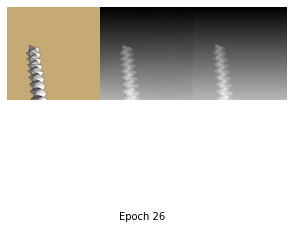

Epoch [27/50], Step [1/3750], D_loss: 0.0038, G_loss: 12.3782
Epoch [27/50], Step [2/3750], D_loss: 0.0167, G_loss: 9.8687
Epoch [27/50], Step [3/3750], D_loss: 0.1959, G_loss: 9.1529
Epoch [27/50], Step [4/3750], D_loss: 0.0459, G_loss: 8.1395
Epoch [27/50], Step [5/3750], D_loss: 0.0881, G_loss: 6.6983
Epoch [27/50], Step [6/3750], D_loss: 0.0078, G_loss: 9.3882
Epoch [27/50], Step [7/3750], D_loss: 0.0282, G_loss: 10.7962
Epoch [27/50], Step [8/3750], D_loss: 0.0523, G_loss: 5.9648
Epoch [27/50], Step [9/3750], D_loss: 0.0598, G_loss: 6.3160
Epoch [27/50], Step [10/3750], D_loss: 0.0005, G_loss: 13.9810
Epoch [27/50], Step [11/3750], D_loss: 0.0051, G_loss: 15.0000
Epoch [27/50], Step [12/3750], D_loss: 0.0039, G_loss: 11.5068
Epoch [27/50], Step [13/3750], D_loss: 0.0323, G_loss: 7.3151
Epoch [27/50], Step [14/3750], D_loss: 0.0226, G_loss: 10.2250
Epoch [27/50], Step [15/3750], D_loss: 0.0041, G_loss: 16.0050
Epoch [27/50], Step [16/3750], D_loss: 0.0145, G_loss: 15.4624
Epoch [27

Epoch [27/50], Step [132/3750], D_loss: 0.0077, G_loss: 8.3758
Epoch [27/50], Step [133/3750], D_loss: 0.0473, G_loss: 6.5892
Epoch [27/50], Step [134/3750], D_loss: 0.1037, G_loss: 7.6455
Epoch [27/50], Step [135/3750], D_loss: 0.3691, G_loss: 8.6037
Epoch [27/50], Step [136/3750], D_loss: 0.0439, G_loss: 12.5492
Epoch [27/50], Step [137/3750], D_loss: 0.4130, G_loss: 5.9289
Epoch [27/50], Step [138/3750], D_loss: 0.0133, G_loss: 10.9569
Epoch [27/50], Step [139/3750], D_loss: 0.0669, G_loss: 6.5111
Epoch [27/50], Step [140/3750], D_loss: 0.0246, G_loss: 16.3733
Epoch [27/50], Step [141/3750], D_loss: 0.0043, G_loss: 8.0491
Epoch [27/50], Step [142/3750], D_loss: 0.0936, G_loss: 6.5744
Epoch [27/50], Step [143/3750], D_loss: 0.1843, G_loss: 12.6107
Epoch [27/50], Step [144/3750], D_loss: 0.0285, G_loss: 9.3928
Epoch [27/50], Step [145/3750], D_loss: 0.1124, G_loss: 8.1842
Epoch [27/50], Step [146/3750], D_loss: 0.0335, G_loss: 40.5503
Epoch [27/50], Step [147/3750], D_loss: 0.1215, G_

Epoch [27/50], Step [262/3750], D_loss: 0.0142, G_loss: 6.2297
Epoch [27/50], Step [263/3750], D_loss: 0.4072, G_loss: 5.7064
Epoch [27/50], Step [264/3750], D_loss: 0.0453, G_loss: 14.8269
Epoch [27/50], Step [265/3750], D_loss: 0.1660, G_loss: 20.4907
Epoch [27/50], Step [266/3750], D_loss: 0.1033, G_loss: 6.4581
Epoch [27/50], Step [267/3750], D_loss: 0.0052, G_loss: 10.7778
Epoch [27/50], Step [268/3750], D_loss: 0.0725, G_loss: 6.5379
Epoch [27/50], Step [269/3750], D_loss: 0.0997, G_loss: 9.9784
Epoch [27/50], Step [270/3750], D_loss: 0.0815, G_loss: 6.8585
Epoch [27/50], Step [271/3750], D_loss: 0.0046, G_loss: 8.4749
Epoch [27/50], Step [272/3750], D_loss: 0.0275, G_loss: 11.1708
Epoch [27/50], Step [273/3750], D_loss: 0.1909, G_loss: 8.9088
Epoch [27/50], Step [274/3750], D_loss: 0.1301, G_loss: 5.2863
Epoch [27/50], Step [275/3750], D_loss: 0.1308, G_loss: 10.1952
Epoch [27/50], Step [276/3750], D_loss: 0.0380, G_loss: 9.2611
Epoch [27/50], Step [277/3750], D_loss: 0.0070, G_

Epoch [27/50], Step [392/3750], D_loss: 0.0060, G_loss: 8.6776
Epoch [27/50], Step [393/3750], D_loss: 0.2732, G_loss: 7.4719
Epoch [27/50], Step [394/3750], D_loss: 0.1688, G_loss: 9.3950
Epoch [27/50], Step [395/3750], D_loss: 0.0220, G_loss: 11.2355
Epoch [27/50], Step [396/3750], D_loss: 0.1833, G_loss: 10.3525
Epoch [27/50], Step [397/3750], D_loss: 0.0184, G_loss: 6.9858
Epoch [27/50], Step [398/3750], D_loss: 0.0714, G_loss: 6.3254
Epoch [27/50], Step [399/3750], D_loss: 0.0569, G_loss: 10.5174
Epoch [27/50], Step [400/3750], D_loss: 0.0269, G_loss: 7.0543
Epoch [27/50], Step [401/3750], D_loss: 0.0487, G_loss: 23.6120
Epoch [27/50], Step [402/3750], D_loss: 0.0235, G_loss: 8.6284
Epoch [27/50], Step [403/3750], D_loss: 0.1207, G_loss: 13.1815
Epoch [27/50], Step [404/3750], D_loss: 0.1794, G_loss: 14.0615
Epoch [27/50], Step [405/3750], D_loss: 0.2613, G_loss: 8.8251
Epoch [27/50], Step [406/3750], D_loss: 0.0039, G_loss: 12.0718
Epoch [27/50], Step [407/3750], D_loss: 0.0032, 

Epoch [27/50], Step [522/3750], D_loss: 0.0863, G_loss: 10.4189
Epoch [27/50], Step [523/3750], D_loss: 0.3327, G_loss: 15.8529
Epoch [27/50], Step [524/3750], D_loss: 0.1159, G_loss: 8.5404
Epoch [27/50], Step [525/3750], D_loss: 0.0167, G_loss: 17.3019
Epoch [27/50], Step [526/3750], D_loss: 0.0356, G_loss: 10.6889
Epoch [27/50], Step [527/3750], D_loss: 0.0281, G_loss: 9.9324
Epoch [27/50], Step [528/3750], D_loss: 0.0902, G_loss: 14.1961
Epoch [27/50], Step [529/3750], D_loss: 0.1468, G_loss: 5.4903
Epoch [27/50], Step [530/3750], D_loss: 0.0060, G_loss: 16.2174
Epoch [27/50], Step [531/3750], D_loss: 0.0759, G_loss: 8.2966
Epoch [27/50], Step [532/3750], D_loss: 0.0106, G_loss: 8.9305
Epoch [27/50], Step [533/3750], D_loss: 0.0096, G_loss: 10.4257
Epoch [27/50], Step [534/3750], D_loss: 0.0107, G_loss: 13.2470
Epoch [27/50], Step [535/3750], D_loss: 0.2058, G_loss: 7.0107
Epoch [27/50], Step [536/3750], D_loss: 0.0023, G_loss: 12.2271
Epoch [27/50], Step [537/3750], D_loss: 0.0051

Epoch [27/50], Step [652/3750], D_loss: 0.0315, G_loss: 7.9688
Epoch [27/50], Step [653/3750], D_loss: 0.0021, G_loss: 10.1959
Epoch [27/50], Step [654/3750], D_loss: 0.0914, G_loss: 10.0375
Epoch [27/50], Step [655/3750], D_loss: 0.0008, G_loss: 17.1600
Epoch [27/50], Step [656/3750], D_loss: 0.0487, G_loss: 15.6430
Epoch [27/50], Step [657/3750], D_loss: 0.3505, G_loss: 10.3722
Epoch [27/50], Step [658/3750], D_loss: 0.2342, G_loss: 4.8326
Epoch [27/50], Step [659/3750], D_loss: 0.5067, G_loss: 11.4845
Epoch [27/50], Step [660/3750], D_loss: 0.0029, G_loss: 19.0419
Epoch [27/50], Step [661/3750], D_loss: 0.2592, G_loss: 7.9289
Epoch [27/50], Step [662/3750], D_loss: 0.1480, G_loss: 8.6033
Epoch [27/50], Step [663/3750], D_loss: 0.5309, G_loss: 5.5769
Epoch [27/50], Step [664/3750], D_loss: 0.1724, G_loss: 6.3760
Epoch [27/50], Step [665/3750], D_loss: 0.0011, G_loss: 11.6881
Epoch [27/50], Step [666/3750], D_loss: 0.0105, G_loss: 13.1652
Epoch [27/50], Step [667/3750], D_loss: 0.0007

Epoch [27/50], Step [782/3750], D_loss: 0.0035, G_loss: 11.5647
Epoch [27/50], Step [783/3750], D_loss: 0.0047, G_loss: 9.1813
Epoch [27/50], Step [784/3750], D_loss: 0.0044, G_loss: 11.8007
Epoch [27/50], Step [785/3750], D_loss: 0.0757, G_loss: 8.4095
Epoch [27/50], Step [786/3750], D_loss: 0.0090, G_loss: 7.6995
Epoch [27/50], Step [787/3750], D_loss: 0.0516, G_loss: 7.0555
Epoch [27/50], Step [788/3750], D_loss: 0.1472, G_loss: 5.2923
Epoch [27/50], Step [789/3750], D_loss: 0.1409, G_loss: 8.9090
Epoch [27/50], Step [790/3750], D_loss: 0.0005, G_loss: 15.7177
Epoch [27/50], Step [791/3750], D_loss: 0.0054, G_loss: 10.8681
Epoch [27/50], Step [792/3750], D_loss: 0.0010, G_loss: 10.9310
Epoch [27/50], Step [793/3750], D_loss: 0.0006, G_loss: 12.3396
Epoch [27/50], Step [794/3750], D_loss: 0.0049, G_loss: 7.7005
Epoch [27/50], Step [795/3750], D_loss: 0.0900, G_loss: 8.1875
Epoch [27/50], Step [796/3750], D_loss: 0.0014, G_loss: 10.1911
Epoch [27/50], Step [797/3750], D_loss: 0.0105, 

Epoch [27/50], Step [911/3750], D_loss: 0.0008, G_loss: 9.7676
Epoch [27/50], Step [912/3750], D_loss: 0.7972, G_loss: 5.9152
Epoch [27/50], Step [913/3750], D_loss: 0.0228, G_loss: 7.4850
Epoch [27/50], Step [914/3750], D_loss: 1.3083, G_loss: 7.5931
Epoch [27/50], Step [915/3750], D_loss: 0.2471, G_loss: 8.9465
Epoch [27/50], Step [916/3750], D_loss: 0.0031, G_loss: 9.3165
Epoch [27/50], Step [917/3750], D_loss: 0.1844, G_loss: 8.2376
Epoch [27/50], Step [918/3750], D_loss: 0.0951, G_loss: 7.7432
Epoch [27/50], Step [919/3750], D_loss: 0.1065, G_loss: 8.0413
Epoch [27/50], Step [920/3750], D_loss: 0.0074, G_loss: 10.0047
Epoch [27/50], Step [921/3750], D_loss: 0.0097, G_loss: 12.5780
Epoch [27/50], Step [922/3750], D_loss: 0.0105, G_loss: 8.1762
Epoch [27/50], Step [923/3750], D_loss: 0.0097, G_loss: 9.8514
Epoch [27/50], Step [924/3750], D_loss: 1.4829, G_loss: 9.2629
Epoch [27/50], Step [925/3750], D_loss: 0.0621, G_loss: 8.8722
Epoch [27/50], Step [926/3750], D_loss: 0.0556, G_los

Epoch [27/50], Step [1040/3750], D_loss: 0.0104, G_loss: 6.9507
Epoch [27/50], Step [1041/3750], D_loss: 0.0172, G_loss: 8.2121
Epoch [27/50], Step [1042/3750], D_loss: 0.0171, G_loss: 7.4460
Epoch [27/50], Step [1043/3750], D_loss: 0.0012, G_loss: 13.5201
Epoch [27/50], Step [1044/3750], D_loss: 0.0010, G_loss: 10.2152
Epoch [27/50], Step [1045/3750], D_loss: 0.0212, G_loss: 14.9185
Epoch [27/50], Step [1046/3750], D_loss: 0.0017, G_loss: 8.9818
Epoch [27/50], Step [1047/3750], D_loss: 0.0050, G_loss: 8.3775
Epoch [27/50], Step [1048/3750], D_loss: 0.0096, G_loss: 7.5618
Epoch [27/50], Step [1049/3750], D_loss: 0.1909, G_loss: 8.2006
Epoch [27/50], Step [1050/3750], D_loss: 0.0085, G_loss: 7.6233
Epoch [27/50], Step [1051/3750], D_loss: 0.0081, G_loss: 10.6203
Epoch [27/50], Step [1052/3750], D_loss: 0.0523, G_loss: 5.2335
Epoch [27/50], Step [1053/3750], D_loss: 0.0217, G_loss: 13.4542
Epoch [27/50], Step [1054/3750], D_loss: 0.0071, G_loss: 11.5780
Epoch [27/50], Step [1055/3750], D

Epoch [27/50], Step [1168/3750], D_loss: 0.0311, G_loss: 11.1462
Epoch [27/50], Step [1169/3750], D_loss: 0.0294, G_loss: 8.3737
Epoch [27/50], Step [1170/3750], D_loss: 0.0135, G_loss: 9.3444
Epoch [27/50], Step [1171/3750], D_loss: 0.1591, G_loss: 10.7892
Epoch [27/50], Step [1172/3750], D_loss: 0.0017, G_loss: 8.2267
Epoch [27/50], Step [1173/3750], D_loss: 0.0247, G_loss: 9.9085
Epoch [27/50], Step [1174/3750], D_loss: 0.0024, G_loss: 17.3095
Epoch [27/50], Step [1175/3750], D_loss: 0.0455, G_loss: 11.1458
Epoch [27/50], Step [1176/3750], D_loss: 0.1782, G_loss: 7.5177
Epoch [27/50], Step [1177/3750], D_loss: 0.0017, G_loss: 10.7862
Epoch [27/50], Step [1178/3750], D_loss: 0.3817, G_loss: 7.2849
Epoch [27/50], Step [1179/3750], D_loss: 0.0058, G_loss: 16.7442
Epoch [27/50], Step [1180/3750], D_loss: 0.0138, G_loss: 13.4927
Epoch [27/50], Step [1181/3750], D_loss: 0.1588, G_loss: 8.4723
Epoch [27/50], Step [1182/3750], D_loss: 0.0055, G_loss: 14.9010
Epoch [27/50], Step [1183/3750],

Epoch [27/50], Step [1295/3750], D_loss: 0.0114, G_loss: 13.2676
Epoch [27/50], Step [1296/3750], D_loss: 0.0127, G_loss: 8.8826
Epoch [27/50], Step [1297/3750], D_loss: 0.0099, G_loss: 10.3764
Epoch [27/50], Step [1298/3750], D_loss: 0.0119, G_loss: 20.6431
Epoch [27/50], Step [1299/3750], D_loss: 0.0978, G_loss: 8.7689
Epoch [27/50], Step [1300/3750], D_loss: 0.0353, G_loss: 9.3252
Epoch [27/50], Step [1301/3750], D_loss: 0.0364, G_loss: 6.2415
Epoch [27/50], Step [1302/3750], D_loss: 0.0656, G_loss: 5.7730
Epoch [27/50], Step [1303/3750], D_loss: 0.0634, G_loss: 6.8401
Epoch [27/50], Step [1304/3750], D_loss: 0.1145, G_loss: 8.1851
Epoch [27/50], Step [1305/3750], D_loss: 0.0046, G_loss: 10.6938
Epoch [27/50], Step [1306/3750], D_loss: 0.0336, G_loss: 13.7141
Epoch [27/50], Step [1307/3750], D_loss: 0.2183, G_loss: 6.1559
Epoch [27/50], Step [1308/3750], D_loss: 0.0067, G_loss: 10.4315
Epoch [27/50], Step [1309/3750], D_loss: 0.0201, G_loss: 6.7337
Epoch [27/50], Step [1310/3750], D

Epoch [27/50], Step [1423/3750], D_loss: 0.0579, G_loss: 9.4310
Epoch [27/50], Step [1424/3750], D_loss: 0.1021, G_loss: 8.1285
Epoch [27/50], Step [1425/3750], D_loss: 0.0316, G_loss: 9.2940
Epoch [27/50], Step [1426/3750], D_loss: 0.0386, G_loss: 15.0191
Epoch [27/50], Step [1427/3750], D_loss: 0.0396, G_loss: 7.2060
Epoch [27/50], Step [1428/3750], D_loss: 0.0200, G_loss: 10.2839
Epoch [27/50], Step [1429/3750], D_loss: 0.3955, G_loss: 5.6814
Epoch [27/50], Step [1430/3750], D_loss: 0.2518, G_loss: 5.2621
Epoch [27/50], Step [1431/3750], D_loss: 0.0520, G_loss: 16.7533
Epoch [27/50], Step [1432/3750], D_loss: 0.0180, G_loss: 12.0240
Epoch [27/50], Step [1433/3750], D_loss: 0.1719, G_loss: 8.5997
Epoch [27/50], Step [1434/3750], D_loss: 0.0891, G_loss: 6.4415
Epoch [27/50], Step [1435/3750], D_loss: 0.2122, G_loss: 6.7168
Epoch [27/50], Step [1436/3750], D_loss: 0.0930, G_loss: 18.8496
Epoch [27/50], Step [1437/3750], D_loss: 0.0137, G_loss: 10.5586
Epoch [27/50], Step [1438/3750], D

Epoch [27/50], Step [1551/3750], D_loss: 0.0060, G_loss: 11.3231
Epoch [27/50], Step [1552/3750], D_loss: 0.0837, G_loss: 12.3478
Epoch [27/50], Step [1553/3750], D_loss: 0.0053, G_loss: 10.6804
Epoch [27/50], Step [1554/3750], D_loss: 0.0125, G_loss: 9.8707
Epoch [27/50], Step [1555/3750], D_loss: 0.0380, G_loss: 6.6489
Epoch [27/50], Step [1556/3750], D_loss: 0.0253, G_loss: 23.3075
Epoch [27/50], Step [1557/3750], D_loss: 0.0230, G_loss: 7.6081
Epoch [27/50], Step [1558/3750], D_loss: 0.6603, G_loss: 4.8766
Epoch [27/50], Step [1559/3750], D_loss: 0.0203, G_loss: 6.7549
Epoch [27/50], Step [1560/3750], D_loss: 0.0765, G_loss: 7.7661
Epoch [27/50], Step [1561/3750], D_loss: 0.2101, G_loss: 4.6304
Epoch [27/50], Step [1562/3750], D_loss: 0.2990, G_loss: 5.3857
Epoch [27/50], Step [1563/3750], D_loss: 0.1011, G_loss: 7.0029
Epoch [27/50], Step [1564/3750], D_loss: 0.0289, G_loss: 9.6018
Epoch [27/50], Step [1565/3750], D_loss: 0.0863, G_loss: 7.1757
Epoch [27/50], Step [1566/3750], D_l

Epoch [27/50], Step [1679/3750], D_loss: 0.0145, G_loss: 5.3954
Epoch [27/50], Step [1680/3750], D_loss: 0.4666, G_loss: 9.5742
Epoch [27/50], Step [1681/3750], D_loss: 0.0991, G_loss: 10.1035
Epoch [27/50], Step [1682/3750], D_loss: 0.0137, G_loss: 11.0380
Epoch [27/50], Step [1683/3750], D_loss: 0.0758, G_loss: 8.0630
Epoch [27/50], Step [1684/3750], D_loss: 0.0217, G_loss: 6.7438
Epoch [27/50], Step [1685/3750], D_loss: 0.5009, G_loss: 8.1051
Epoch [27/50], Step [1686/3750], D_loss: 0.1811, G_loss: 6.3261
Epoch [27/50], Step [1687/3750], D_loss: 0.0553, G_loss: 15.1180
Epoch [27/50], Step [1688/3750], D_loss: 0.0963, G_loss: 8.5926
Epoch [27/50], Step [1689/3750], D_loss: 0.0118, G_loss: 9.9918
Epoch [27/50], Step [1690/3750], D_loss: 0.0478, G_loss: 9.4225
Epoch [27/50], Step [1691/3750], D_loss: 0.0031, G_loss: 12.0468
Epoch [27/50], Step [1692/3750], D_loss: 0.1239, G_loss: 7.6173
Epoch [27/50], Step [1693/3750], D_loss: 0.0275, G_loss: 12.5815
Epoch [27/50], Step [1694/3750], D_

Epoch [27/50], Step [1807/3750], D_loss: 0.0339, G_loss: 8.0671
Epoch [27/50], Step [1808/3750], D_loss: 0.2472, G_loss: 8.9904
Epoch [27/50], Step [1809/3750], D_loss: 0.0577, G_loss: 5.4916
Epoch [27/50], Step [1810/3750], D_loss: 0.2344, G_loss: 13.4646
Epoch [27/50], Step [1811/3750], D_loss: 0.0238, G_loss: 15.2038
Epoch [27/50], Step [1812/3750], D_loss: 0.0061, G_loss: 9.0746
Epoch [27/50], Step [1813/3750], D_loss: 0.0075, G_loss: 12.6905
Epoch [27/50], Step [1814/3750], D_loss: 0.0793, G_loss: 10.4029
Epoch [27/50], Step [1815/3750], D_loss: 0.4143, G_loss: 8.8934
Epoch [27/50], Step [1816/3750], D_loss: 0.0225, G_loss: 6.8456
Epoch [27/50], Step [1817/3750], D_loss: 0.0399, G_loss: 11.5385
Epoch [27/50], Step [1818/3750], D_loss: 0.1009, G_loss: 8.3185
Epoch [27/50], Step [1819/3750], D_loss: 0.0166, G_loss: 7.7331
Epoch [27/50], Step [1820/3750], D_loss: 0.1505, G_loss: 16.1068
Epoch [27/50], Step [1821/3750], D_loss: 0.0252, G_loss: 11.3579
Epoch [27/50], Step [1822/3750], 

Epoch [27/50], Step [1935/3750], D_loss: 0.0222, G_loss: 7.0781
Epoch [27/50], Step [1936/3750], D_loss: 0.0587, G_loss: 9.9153
Epoch [27/50], Step [1937/3750], D_loss: 0.0066, G_loss: 10.0880
Epoch [27/50], Step [1938/3750], D_loss: 0.0804, G_loss: 6.7106
Epoch [27/50], Step [1939/3750], D_loss: 0.0039, G_loss: 9.5005
Epoch [27/50], Step [1940/3750], D_loss: 0.0570, G_loss: 8.4409
Epoch [27/50], Step [1941/3750], D_loss: 0.1483, G_loss: 7.2386
Epoch [27/50], Step [1942/3750], D_loss: 0.0076, G_loss: 11.2869
Epoch [27/50], Step [1943/3750], D_loss: 0.0982, G_loss: 6.7046
Epoch [27/50], Step [1944/3750], D_loss: 0.0415, G_loss: 9.4456
Epoch [27/50], Step [1945/3750], D_loss: 0.0372, G_loss: 5.7587
Epoch [27/50], Step [1946/3750], D_loss: 0.0112, G_loss: 16.3127
Epoch [27/50], Step [1947/3750], D_loss: 0.0305, G_loss: 7.5162
Epoch [27/50], Step [1948/3750], D_loss: 0.0234, G_loss: 13.9713
Epoch [27/50], Step [1949/3750], D_loss: 0.0213, G_loss: 6.5899
Epoch [27/50], Step [1950/3750], D_l

Epoch [27/50], Step [2063/3750], D_loss: 0.2295, G_loss: 10.1026
Epoch [27/50], Step [2064/3750], D_loss: 0.0480, G_loss: 7.6133
Epoch [27/50], Step [2065/3750], D_loss: 0.0012, G_loss: 14.6440
Epoch [27/50], Step [2066/3750], D_loss: 0.3420, G_loss: 8.8211
Epoch [27/50], Step [2067/3750], D_loss: 0.0092, G_loss: 8.1087
Epoch [27/50], Step [2068/3750], D_loss: 0.0110, G_loss: 8.7409
Epoch [27/50], Step [2069/3750], D_loss: 0.1730, G_loss: 8.1296
Epoch [27/50], Step [2070/3750], D_loss: 0.0246, G_loss: 9.8566
Epoch [27/50], Step [2071/3750], D_loss: 0.0011, G_loss: 15.7063
Epoch [27/50], Step [2072/3750], D_loss: 0.0465, G_loss: 6.3789
Epoch [27/50], Step [2073/3750], D_loss: 0.0460, G_loss: 16.9273
Epoch [27/50], Step [2074/3750], D_loss: 0.0081, G_loss: 15.8189
Epoch [27/50], Step [2075/3750], D_loss: 0.0022, G_loss: 10.3922
Epoch [27/50], Step [2076/3750], D_loss: 0.0178, G_loss: 8.6421
Epoch [27/50], Step [2077/3750], D_loss: 0.1421, G_loss: 12.8312
Epoch [27/50], Step [2078/3750], 

Epoch [27/50], Step [2191/3750], D_loss: 0.1385, G_loss: 10.4028
Epoch [27/50], Step [2192/3750], D_loss: 0.0145, G_loss: 11.8832
Epoch [27/50], Step [2193/3750], D_loss: 0.0298, G_loss: 9.7701
Epoch [27/50], Step [2194/3750], D_loss: 0.0444, G_loss: 16.1940
Epoch [27/50], Step [2195/3750], D_loss: 0.0288, G_loss: 11.7554
Epoch [27/50], Step [2196/3750], D_loss: 0.0205, G_loss: 7.1041
Epoch [27/50], Step [2197/3750], D_loss: 0.0984, G_loss: 9.9745
Epoch [27/50], Step [2198/3750], D_loss: 0.0787, G_loss: 10.3631
Epoch [27/50], Step [2199/3750], D_loss: 0.0119, G_loss: 6.9828
Epoch [27/50], Step [2200/3750], D_loss: 0.0188, G_loss: 6.9207
Epoch [27/50], Step [2201/3750], D_loss: 0.0413, G_loss: 9.8010
Epoch [27/50], Step [2202/3750], D_loss: 0.0407, G_loss: 7.0207
Epoch [27/50], Step [2203/3750], D_loss: 0.3239, G_loss: 5.4355
Epoch [27/50], Step [2204/3750], D_loss: 0.0197, G_loss: 9.4512
Epoch [27/50], Step [2205/3750], D_loss: 0.0369, G_loss: 9.6905
Epoch [27/50], Step [2206/3750], D_

Epoch [27/50], Step [2319/3750], D_loss: 0.1016, G_loss: 6.4183
Epoch [27/50], Step [2320/3750], D_loss: 0.5181, G_loss: 10.1256
Epoch [27/50], Step [2321/3750], D_loss: 0.8225, G_loss: 9.7343
Epoch [27/50], Step [2322/3750], D_loss: 0.8086, G_loss: 8.2808
Epoch [27/50], Step [2323/3750], D_loss: 0.0850, G_loss: 7.2379
Epoch [27/50], Step [2324/3750], D_loss: 0.0937, G_loss: 8.3852
Epoch [27/50], Step [2325/3750], D_loss: 0.3561, G_loss: 7.8826
Epoch [27/50], Step [2326/3750], D_loss: 0.1366, G_loss: 9.2397
Epoch [27/50], Step [2327/3750], D_loss: 0.0881, G_loss: 6.6967
Epoch [27/50], Step [2328/3750], D_loss: 0.0676, G_loss: 6.7556
Epoch [27/50], Step [2329/3750], D_loss: 0.1627, G_loss: 6.5972
Epoch [27/50], Step [2330/3750], D_loss: 0.0847, G_loss: 13.1664
Epoch [27/50], Step [2331/3750], D_loss: 0.0020, G_loss: 9.2348
Epoch [27/50], Step [2332/3750], D_loss: 0.0027, G_loss: 13.2435
Epoch [27/50], Step [2333/3750], D_loss: 0.0069, G_loss: 7.9780
Epoch [27/50], Step [2334/3750], D_lo

Epoch [27/50], Step [2447/3750], D_loss: 0.0996, G_loss: 10.1980
Epoch [27/50], Step [2448/3750], D_loss: 0.1449, G_loss: 5.8868
Epoch [27/50], Step [2449/3750], D_loss: 0.0449, G_loss: 6.1070
Epoch [27/50], Step [2450/3750], D_loss: 0.0679, G_loss: 13.1425
Epoch [27/50], Step [2451/3750], D_loss: 0.0637, G_loss: 5.9061
Epoch [27/50], Step [2452/3750], D_loss: 0.0605, G_loss: 15.7877
Epoch [27/50], Step [2453/3750], D_loss: 0.0477, G_loss: 10.3198
Epoch [27/50], Step [2454/3750], D_loss: 0.0388, G_loss: 5.4593
Epoch [27/50], Step [2455/3750], D_loss: 0.3558, G_loss: 4.7690
Epoch [27/50], Step [2456/3750], D_loss: 0.0608, G_loss: 9.7709
Epoch [27/50], Step [2457/3750], D_loss: 0.1465, G_loss: 9.0914
Epoch [27/50], Step [2458/3750], D_loss: 0.1347, G_loss: 5.9873
Epoch [27/50], Step [2459/3750], D_loss: 0.0759, G_loss: 11.1447
Epoch [27/50], Step [2460/3750], D_loss: 0.0196, G_loss: 11.9399
Epoch [27/50], Step [2461/3750], D_loss: 0.0637, G_loss: 8.2975
Epoch [27/50], Step [2462/3750], D

Epoch [27/50], Step [2575/3750], D_loss: 0.0007, G_loss: 20.5343
Epoch [27/50], Step [2576/3750], D_loss: 0.0652, G_loss: 8.6488
Epoch [27/50], Step [2577/3750], D_loss: 0.0019, G_loss: 10.3940
Epoch [27/50], Step [2578/3750], D_loss: 0.0043, G_loss: 7.3341
Epoch [27/50], Step [2579/3750], D_loss: 0.0292, G_loss: 8.1092
Epoch [27/50], Step [2580/3750], D_loss: 0.0038, G_loss: 10.2283
Epoch [27/50], Step [2581/3750], D_loss: 0.0156, G_loss: 7.3137
Epoch [27/50], Step [2582/3750], D_loss: 0.0941, G_loss: 8.6220
Epoch [27/50], Step [2583/3750], D_loss: 0.0657, G_loss: 8.6168
Epoch [27/50], Step [2584/3750], D_loss: 0.0759, G_loss: 8.9837
Epoch [27/50], Step [2585/3750], D_loss: 0.0118, G_loss: 9.3113
Epoch [27/50], Step [2586/3750], D_loss: 0.3886, G_loss: 6.0080
Epoch [27/50], Step [2587/3750], D_loss: 0.0890, G_loss: 6.9119
Epoch [27/50], Step [2588/3750], D_loss: 0.0774, G_loss: 8.2097
Epoch [27/50], Step [2589/3750], D_loss: 0.0136, G_loss: 10.4493
Epoch [27/50], Step [2590/3750], D_l

Epoch [27/50], Step [2703/3750], D_loss: 0.3461, G_loss: 6.6429
Epoch [27/50], Step [2704/3750], D_loss: 0.0411, G_loss: 10.5467
Epoch [27/50], Step [2705/3750], D_loss: 0.0045, G_loss: 13.3926
Epoch [27/50], Step [2706/3750], D_loss: 0.0078, G_loss: 12.7278
Epoch [27/50], Step [2707/3750], D_loss: 0.1635, G_loss: 8.6729
Epoch [27/50], Step [2708/3750], D_loss: 0.3048, G_loss: 6.1261
Epoch [27/50], Step [2709/3750], D_loss: 0.2154, G_loss: 14.2190
Epoch [27/50], Step [2710/3750], D_loss: 0.2000, G_loss: 8.6831
Epoch [27/50], Step [2711/3750], D_loss: 0.1064, G_loss: 6.5946
Epoch [27/50], Step [2712/3750], D_loss: 0.0412, G_loss: 10.2868
Epoch [27/50], Step [2713/3750], D_loss: 0.0355, G_loss: 6.7144
Epoch [27/50], Step [2714/3750], D_loss: 0.0134, G_loss: 13.2533
Epoch [27/50], Step [2715/3750], D_loss: 0.0189, G_loss: 9.8125
Epoch [27/50], Step [2716/3750], D_loss: 0.0140, G_loss: 9.3939
Epoch [27/50], Step [2717/3750], D_loss: 0.0335, G_loss: 7.4844
Epoch [27/50], Step [2718/3750], D

Epoch [27/50], Step [2831/3750], D_loss: 0.0401, G_loss: 14.7721
Epoch [27/50], Step [2832/3750], D_loss: 0.0021, G_loss: 8.1669
Epoch [27/50], Step [2833/3750], D_loss: 1.0231, G_loss: 4.8186
Epoch [27/50], Step [2834/3750], D_loss: 0.2078, G_loss: 2.6058
Epoch [27/50], Step [2835/3750], D_loss: 0.2618, G_loss: 8.8523
Epoch [27/50], Step [2836/3750], D_loss: 0.3806, G_loss: 7.4034
Epoch [27/50], Step [2837/3750], D_loss: 0.0390, G_loss: 8.3396
Epoch [27/50], Step [2838/3750], D_loss: 0.0904, G_loss: 19.4787
Epoch [27/50], Step [2839/3750], D_loss: 0.0205, G_loss: 8.0233
Epoch [27/50], Step [2840/3750], D_loss: 0.1287, G_loss: 8.0021
Epoch [27/50], Step [2841/3750], D_loss: 0.0129, G_loss: 14.6492
Epoch [27/50], Step [2842/3750], D_loss: 0.1987, G_loss: 7.0039
Epoch [27/50], Step [2843/3750], D_loss: 0.0136, G_loss: 8.3428
Epoch [27/50], Step [2844/3750], D_loss: 0.0267, G_loss: 6.6232
Epoch [27/50], Step [2845/3750], D_loss: 0.0104, G_loss: 11.1018
Epoch [27/50], Step [2846/3750], D_l

Epoch [27/50], Step [2959/3750], D_loss: 0.0071, G_loss: 7.2611
Epoch [27/50], Step [2960/3750], D_loss: 0.2690, G_loss: 4.6020
Epoch [27/50], Step [2961/3750], D_loss: 0.0379, G_loss: 9.5915
Epoch [27/50], Step [2962/3750], D_loss: 0.0084, G_loss: 11.2566
Epoch [27/50], Step [2963/3750], D_loss: 0.0091, G_loss: 7.6082
Epoch [27/50], Step [2964/3750], D_loss: 0.0503, G_loss: 5.7669
Epoch [27/50], Step [2965/3750], D_loss: 0.1468, G_loss: 6.5870
Epoch [27/50], Step [2966/3750], D_loss: 0.0123, G_loss: 14.1619
Epoch [27/50], Step [2967/3750], D_loss: 0.1231, G_loss: 10.0808
Epoch [27/50], Step [2968/3750], D_loss: 0.0161, G_loss: 5.6236
Epoch [27/50], Step [2969/3750], D_loss: 0.0187, G_loss: 7.0626
Epoch [27/50], Step [2970/3750], D_loss: 0.0513, G_loss: 11.8075
Epoch [27/50], Step [2971/3750], D_loss: 0.0231, G_loss: 17.6477
Epoch [27/50], Step [2972/3750], D_loss: 0.0405, G_loss: 10.8108
Epoch [27/50], Step [2973/3750], D_loss: 0.0541, G_loss: 7.1345
Epoch [27/50], Step [2974/3750], D

Epoch [27/50], Step [3087/3750], D_loss: 0.0173, G_loss: 6.7931
Epoch [27/50], Step [3088/3750], D_loss: 0.0079, G_loss: 7.5197
Epoch [27/50], Step [3089/3750], D_loss: 0.0309, G_loss: 7.0764
Epoch [27/50], Step [3090/3750], D_loss: 0.0067, G_loss: 10.6719
Epoch [27/50], Step [3091/3750], D_loss: 0.2713, G_loss: 6.8407
Epoch [27/50], Step [3092/3750], D_loss: 0.0141, G_loss: 10.6943
Epoch [27/50], Step [3093/3750], D_loss: 0.4278, G_loss: 5.1689
Epoch [27/50], Step [3094/3750], D_loss: 0.0129, G_loss: 7.4807
Epoch [27/50], Step [3095/3750], D_loss: 0.0705, G_loss: 5.4917
Epoch [27/50], Step [3096/3750], D_loss: 0.0172, G_loss: 13.2321
Epoch [27/50], Step [3097/3750], D_loss: 0.0408, G_loss: 9.3850
Epoch [27/50], Step [3098/3750], D_loss: 0.0462, G_loss: 12.9004
Epoch [27/50], Step [3099/3750], D_loss: 0.0032, G_loss: 17.9145
Epoch [27/50], Step [3100/3750], D_loss: 0.0439, G_loss: 6.3271
Epoch [27/50], Step [3101/3750], D_loss: 0.0372, G_loss: 6.7023
Epoch [27/50], Step [3102/3750], D_

Epoch [27/50], Step [3215/3750], D_loss: 0.0430, G_loss: 5.1600
Epoch [27/50], Step [3216/3750], D_loss: 0.0250, G_loss: 14.4680
Epoch [27/50], Step [3217/3750], D_loss: 0.0096, G_loss: 6.7365
Epoch [27/50], Step [3218/3750], D_loss: 0.0207, G_loss: 7.1000
Epoch [27/50], Step [3219/3750], D_loss: 0.0055, G_loss: 10.0877
Epoch [27/50], Step [3220/3750], D_loss: 0.0376, G_loss: 9.1809
Epoch [27/50], Step [3221/3750], D_loss: 0.4670, G_loss: 9.6342
Epoch [27/50], Step [3222/3750], D_loss: 0.0074, G_loss: 14.6068
Epoch [27/50], Step [3223/3750], D_loss: 0.0121, G_loss: 10.1255
Epoch [27/50], Step [3224/3750], D_loss: 0.0077, G_loss: 7.1309
Epoch [27/50], Step [3225/3750], D_loss: 0.0253, G_loss: 10.3995
Epoch [27/50], Step [3226/3750], D_loss: 0.0168, G_loss: 12.2403
Epoch [27/50], Step [3227/3750], D_loss: 0.0021, G_loss: 11.0333
Epoch [27/50], Step [3228/3750], D_loss: 0.0040, G_loss: 10.6948
Epoch [27/50], Step [3229/3750], D_loss: 0.0123, G_loss: 10.1065
Epoch [27/50], Step [3230/3750]

Epoch [27/50], Step [3343/3750], D_loss: 0.0104, G_loss: 11.9836
Epoch [27/50], Step [3344/3750], D_loss: 0.0132, G_loss: 7.0973
Epoch [27/50], Step [3345/3750], D_loss: 0.0599, G_loss: 11.4689
Epoch [27/50], Step [3346/3750], D_loss: 0.0326, G_loss: 8.8242
Epoch [27/50], Step [3347/3750], D_loss: 0.0166, G_loss: 15.3402
Epoch [27/50], Step [3348/3750], D_loss: 0.0352, G_loss: 10.1050
Epoch [27/50], Step [3349/3750], D_loss: 0.0080, G_loss: 10.4413
Epoch [27/50], Step [3350/3750], D_loss: 0.0172, G_loss: 8.6141
Epoch [27/50], Step [3351/3750], D_loss: 0.0175, G_loss: 8.7390
Epoch [27/50], Step [3352/3750], D_loss: 0.0064, G_loss: 11.3678
Epoch [27/50], Step [3353/3750], D_loss: 0.0030, G_loss: 10.7948
Epoch [27/50], Step [3354/3750], D_loss: 0.0020, G_loss: 7.5249
Epoch [27/50], Step [3355/3750], D_loss: 0.0027, G_loss: 11.1011
Epoch [27/50], Step [3356/3750], D_loss: 0.0271, G_loss: 9.0748
Epoch [27/50], Step [3357/3750], D_loss: 0.9891, G_loss: 35.4787
Epoch [27/50], Step [3358/3750]

Epoch [27/50], Step [3471/3750], D_loss: 0.1178, G_loss: 12.6115
Epoch [27/50], Step [3472/3750], D_loss: 0.0375, G_loss: 5.4889
Epoch [27/50], Step [3473/3750], D_loss: 0.0740, G_loss: 7.8852
Epoch [27/50], Step [3474/3750], D_loss: 0.0644, G_loss: 16.8340
Epoch [27/50], Step [3475/3750], D_loss: 0.1742, G_loss: 6.7739
Epoch [27/50], Step [3476/3750], D_loss: 0.0197, G_loss: 10.9206
Epoch [27/50], Step [3477/3750], D_loss: 0.0258, G_loss: 6.6737
Epoch [27/50], Step [3478/3750], D_loss: 0.1019, G_loss: 9.5738
Epoch [27/50], Step [3479/3750], D_loss: 0.0076, G_loss: 10.3385
Epoch [27/50], Step [3480/3750], D_loss: 0.0175, G_loss: 9.7244
Epoch [27/50], Step [3481/3750], D_loss: 0.1056, G_loss: 7.7761
Epoch [27/50], Step [3482/3750], D_loss: 0.0358, G_loss: 6.1193
Epoch [27/50], Step [3483/3750], D_loss: 0.1775, G_loss: 9.0821
Epoch [27/50], Step [3484/3750], D_loss: 0.1237, G_loss: 8.2202
Epoch [27/50], Step [3485/3750], D_loss: 0.0989, G_loss: 11.0440
Epoch [27/50], Step [3486/3750], D_

Epoch [27/50], Step [3599/3750], D_loss: 0.0054, G_loss: 8.2384
Epoch [27/50], Step [3600/3750], D_loss: 0.0358, G_loss: 10.5027
Epoch [27/50], Step [3601/3750], D_loss: 0.0092, G_loss: 8.3799
Epoch [27/50], Step [3602/3750], D_loss: 0.0440, G_loss: 8.5826
Epoch [27/50], Step [3603/3750], D_loss: 0.0100, G_loss: 12.6891
Epoch [27/50], Step [3604/3750], D_loss: 0.0155, G_loss: 15.5427
Epoch [27/50], Step [3605/3750], D_loss: 0.0722, G_loss: 9.1127
Epoch [27/50], Step [3606/3750], D_loss: 0.0731, G_loss: 7.6003
Epoch [27/50], Step [3607/3750], D_loss: 0.0364, G_loss: 10.7424
Epoch [27/50], Step [3608/3750], D_loss: 0.0453, G_loss: 8.9409
Epoch [27/50], Step [3609/3750], D_loss: 0.0268, G_loss: 6.7810
Epoch [27/50], Step [3610/3750], D_loss: 0.0046, G_loss: 7.0792
Epoch [27/50], Step [3611/3750], D_loss: 1.0959, G_loss: 5.6347
Epoch [27/50], Step [3612/3750], D_loss: 0.0345, G_loss: 9.4907
Epoch [27/50], Step [3613/3750], D_loss: 0.1593, G_loss: 10.7334
Epoch [27/50], Step [3614/3750], D_

Epoch [27/50], Step [3727/3750], D_loss: 0.0879, G_loss: 14.0807
Epoch [27/50], Step [3728/3750], D_loss: 0.0235, G_loss: 9.5397
Epoch [27/50], Step [3729/3750], D_loss: 0.0080, G_loss: 12.5468
Epoch [27/50], Step [3730/3750], D_loss: 0.0570, G_loss: 5.9815
Epoch [27/50], Step [3731/3750], D_loss: 0.0084, G_loss: 8.0365
Epoch [27/50], Step [3732/3750], D_loss: 0.0223, G_loss: 12.4102
Epoch [27/50], Step [3733/3750], D_loss: 0.0298, G_loss: 12.0248
Epoch [27/50], Step [3734/3750], D_loss: 0.0033, G_loss: 10.5359
Epoch [27/50], Step [3735/3750], D_loss: 0.0310, G_loss: 15.9055
Epoch [27/50], Step [3736/3750], D_loss: 0.0213, G_loss: 7.2918
Epoch [27/50], Step [3737/3750], D_loss: 0.5975, G_loss: 5.9607
Epoch [27/50], Step [3738/3750], D_loss: 0.1010, G_loss: 7.3182
Epoch [27/50], Step [3739/3750], D_loss: 0.7145, G_loss: 8.1605
Epoch [27/50], Step [3740/3750], D_loss: 0.2338, G_loss: 7.7597
Epoch [27/50], Step [3741/3750], D_loss: 0.0791, G_loss: 6.7696
Epoch [27/50], Step [3742/3750], D

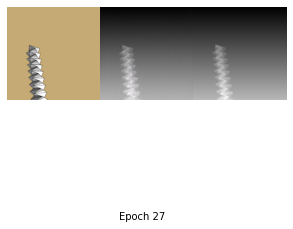

Epoch [28/50], Step [1/3750], D_loss: 0.3677, G_loss: 5.4903
Epoch [28/50], Step [2/3750], D_loss: 0.4425, G_loss: 7.3273
Epoch [28/50], Step [3/3750], D_loss: 0.0317, G_loss: 11.4378
Epoch [28/50], Step [4/3750], D_loss: 0.0089, G_loss: 10.1008
Epoch [28/50], Step [5/3750], D_loss: 0.0055, G_loss: 11.7398
Epoch [28/50], Step [6/3750], D_loss: 0.0336, G_loss: 11.0209
Epoch [28/50], Step [7/3750], D_loss: 0.1224, G_loss: 6.5506
Epoch [28/50], Step [8/3750], D_loss: 0.0091, G_loss: 12.8128
Epoch [28/50], Step [9/3750], D_loss: 0.0962, G_loss: 7.4348
Epoch [28/50], Step [10/3750], D_loss: 0.0463, G_loss: 12.3937
Epoch [28/50], Step [11/3750], D_loss: 0.2934, G_loss: 7.8786
Epoch [28/50], Step [12/3750], D_loss: 0.0970, G_loss: 7.6141
Epoch [28/50], Step [13/3750], D_loss: 0.1146, G_loss: 15.1052
Epoch [28/50], Step [14/3750], D_loss: 0.0386, G_loss: 8.3960
Epoch [28/50], Step [15/3750], D_loss: 0.3944, G_loss: 7.2923
Epoch [28/50], Step [16/3750], D_loss: 0.0078, G_loss: 9.5110
Epoch [28/

Epoch [28/50], Step [133/3750], D_loss: 0.0034, G_loss: 8.4635
Epoch [28/50], Step [134/3750], D_loss: 0.0430, G_loss: 12.0318
Epoch [28/50], Step [135/3750], D_loss: 0.3490, G_loss: 12.3093
Epoch [28/50], Step [136/3750], D_loss: 0.0236, G_loss: 9.9281
Epoch [28/50], Step [137/3750], D_loss: 0.7305, G_loss: 7.4219
Epoch [28/50], Step [138/3750], D_loss: 0.1830, G_loss: 6.6396
Epoch [28/50], Step [139/3750], D_loss: 0.0206, G_loss: 7.4866
Epoch [28/50], Step [140/3750], D_loss: 0.0205, G_loss: 7.1649
Epoch [28/50], Step [141/3750], D_loss: 0.1121, G_loss: 6.9433
Epoch [28/50], Step [142/3750], D_loss: 0.1258, G_loss: 6.8284
Epoch [28/50], Step [143/3750], D_loss: 0.0117, G_loss: 10.4497
Epoch [28/50], Step [144/3750], D_loss: 0.2610, G_loss: 11.0084
Epoch [28/50], Step [145/3750], D_loss: 0.2704, G_loss: 4.4098
Epoch [28/50], Step [146/3750], D_loss: 0.0051, G_loss: 10.8874
Epoch [28/50], Step [147/3750], D_loss: 0.0567, G_loss: 11.7252
Epoch [28/50], Step [148/3750], D_loss: 1.0174, G

Epoch [28/50], Step [263/3750], D_loss: 0.0088, G_loss: 9.3717
Epoch [28/50], Step [264/3750], D_loss: 0.0245, G_loss: 7.5176
Epoch [28/50], Step [265/3750], D_loss: 0.2283, G_loss: 6.2686
Epoch [28/50], Step [266/3750], D_loss: 0.0172, G_loss: 7.4438
Epoch [28/50], Step [267/3750], D_loss: 0.1127, G_loss: 4.8812
Epoch [28/50], Step [268/3750], D_loss: 0.2545, G_loss: 8.0758
Epoch [28/50], Step [269/3750], D_loss: 0.2213, G_loss: 6.7357
Epoch [28/50], Step [270/3750], D_loss: 0.0567, G_loss: 6.2771
Epoch [28/50], Step [271/3750], D_loss: 0.0382, G_loss: 7.4923
Epoch [28/50], Step [272/3750], D_loss: 0.0320, G_loss: 8.4403
Epoch [28/50], Step [273/3750], D_loss: 0.3396, G_loss: 6.1093
Epoch [28/50], Step [274/3750], D_loss: 0.0129, G_loss: 11.9003
Epoch [28/50], Step [275/3750], D_loss: 0.1016, G_loss: 8.4010
Epoch [28/50], Step [276/3750], D_loss: 0.0152, G_loss: 5.8782
Epoch [28/50], Step [277/3750], D_loss: 0.0683, G_loss: 6.4359
Epoch [28/50], Step [278/3750], D_loss: 0.0659, G_loss

Epoch [28/50], Step [393/3750], D_loss: 0.0072, G_loss: 10.5502
Epoch [28/50], Step [394/3750], D_loss: 0.1960, G_loss: 7.6288
Epoch [28/50], Step [395/3750], D_loss: 0.0033, G_loss: 10.2608
Epoch [28/50], Step [396/3750], D_loss: 0.0094, G_loss: 10.8187
Epoch [28/50], Step [397/3750], D_loss: 0.0357, G_loss: 5.6086
Epoch [28/50], Step [398/3750], D_loss: 0.2933, G_loss: 5.3953
Epoch [28/50], Step [399/3750], D_loss: 0.0566, G_loss: 6.6476
Epoch [28/50], Step [400/3750], D_loss: 0.1093, G_loss: 5.8171
Epoch [28/50], Step [401/3750], D_loss: 0.0199, G_loss: 11.4719
Epoch [28/50], Step [402/3750], D_loss: 0.1007, G_loss: 10.6006
Epoch [28/50], Step [403/3750], D_loss: 0.1164, G_loss: 7.7098
Epoch [28/50], Step [404/3750], D_loss: 0.0085, G_loss: 11.7829
Epoch [28/50], Step [405/3750], D_loss: 0.0035, G_loss: 10.4270
Epoch [28/50], Step [406/3750], D_loss: 0.0526, G_loss: 34.7890
Epoch [28/50], Step [407/3750], D_loss: 0.0059, G_loss: 15.2564
Epoch [28/50], Step [408/3750], D_loss: 0.0920

Epoch [28/50], Step [523/3750], D_loss: 0.0296, G_loss: 6.8521
Epoch [28/50], Step [524/3750], D_loss: 0.0075, G_loss: 10.6870
Epoch [28/50], Step [525/3750], D_loss: 0.0718, G_loss: 10.0768
Epoch [28/50], Step [526/3750], D_loss: 0.0008, G_loss: 17.0615
Epoch [28/50], Step [527/3750], D_loss: 0.0044, G_loss: 14.8609
Epoch [28/50], Step [528/3750], D_loss: 0.0629, G_loss: 6.2406
Epoch [28/50], Step [529/3750], D_loss: 0.7071, G_loss: 3.3092
Epoch [28/50], Step [530/3750], D_loss: 0.0374, G_loss: 5.5264
Epoch [28/50], Step [531/3750], D_loss: 0.3163, G_loss: 7.3191
Epoch [28/50], Step [532/3750], D_loss: 0.5510, G_loss: 7.7536
Epoch [28/50], Step [533/3750], D_loss: 0.0655, G_loss: 7.8389
Epoch [28/50], Step [534/3750], D_loss: 0.1575, G_loss: 5.9502
Epoch [28/50], Step [535/3750], D_loss: 0.0198, G_loss: 14.2152
Epoch [28/50], Step [536/3750], D_loss: 0.0111, G_loss: 9.7016
Epoch [28/50], Step [537/3750], D_loss: 0.1020, G_loss: 5.8410
Epoch [28/50], Step [538/3750], D_loss: 0.0177, G_

Epoch [28/50], Step [653/3750], D_loss: 0.0224, G_loss: 5.4618
Epoch [28/50], Step [654/3750], D_loss: 0.0080, G_loss: 10.2794
Epoch [28/50], Step [655/3750], D_loss: 0.0047, G_loss: 8.0056
Epoch [28/50], Step [656/3750], D_loss: 0.1792, G_loss: 4.9394
Epoch [28/50], Step [657/3750], D_loss: 0.1662, G_loss: 6.3321
Epoch [28/50], Step [658/3750], D_loss: 0.0599, G_loss: 5.4623
Epoch [28/50], Step [659/3750], D_loss: 0.0145, G_loss: 6.2877
Epoch [28/50], Step [660/3750], D_loss: 0.0264, G_loss: 8.1888
Epoch [28/50], Step [661/3750], D_loss: 0.2805, G_loss: 5.5095
Epoch [28/50], Step [662/3750], D_loss: 0.0020, G_loss: 11.9897
Epoch [28/50], Step [663/3750], D_loss: 0.0104, G_loss: 9.0212
Epoch [28/50], Step [664/3750], D_loss: 0.4361, G_loss: 12.4334
Epoch [28/50], Step [665/3750], D_loss: 0.0126, G_loss: 12.6189
Epoch [28/50], Step [666/3750], D_loss: 0.0786, G_loss: 7.5127
Epoch [28/50], Step [667/3750], D_loss: 0.0473, G_loss: 9.3192
Epoch [28/50], Step [668/3750], D_loss: 0.0611, G_l

Epoch [28/50], Step [783/3750], D_loss: 0.0106, G_loss: 11.6303
Epoch [28/50], Step [784/3750], D_loss: 0.0841, G_loss: 6.4430
Epoch [28/50], Step [785/3750], D_loss: 0.0363, G_loss: 5.3476
Epoch [28/50], Step [786/3750], D_loss: 0.0045, G_loss: 11.6978
Epoch [28/50], Step [787/3750], D_loss: 0.0296, G_loss: 9.7146
Epoch [28/50], Step [788/3750], D_loss: 0.0009, G_loss: 20.8651
Epoch [28/50], Step [789/3750], D_loss: 0.0033, G_loss: 11.8291
Epoch [28/50], Step [790/3750], D_loss: 0.0044, G_loss: 7.4583
Epoch [28/50], Step [791/3750], D_loss: 0.3039, G_loss: 13.2431
Epoch [28/50], Step [792/3750], D_loss: 1.0982, G_loss: 5.2932
Epoch [28/50], Step [793/3750], D_loss: 0.0477, G_loss: 7.2075
Epoch [28/50], Step [794/3750], D_loss: 0.2708, G_loss: 8.5293
Epoch [28/50], Step [795/3750], D_loss: 0.0447, G_loss: 7.4962
Epoch [28/50], Step [796/3750], D_loss: 0.0726, G_loss: 6.6996
Epoch [28/50], Step [797/3750], D_loss: 0.1170, G_loss: 5.4251
Epoch [28/50], Step [798/3750], D_loss: 0.0044, G_

Epoch [28/50], Step [913/3750], D_loss: 0.0024, G_loss: 11.4738
Epoch [28/50], Step [914/3750], D_loss: 0.3859, G_loss: 12.2203
Epoch [28/50], Step [915/3750], D_loss: 0.0014, G_loss: 14.0516
Epoch [28/50], Step [916/3750], D_loss: 0.1350, G_loss: 5.9537
Epoch [28/50], Step [917/3750], D_loss: 0.0089, G_loss: 7.8881
Epoch [28/50], Step [918/3750], D_loss: 0.0256, G_loss: 23.4563
Epoch [28/50], Step [919/3750], D_loss: 0.2012, G_loss: 10.5857
Epoch [28/50], Step [920/3750], D_loss: 0.0276, G_loss: 7.5967
Epoch [28/50], Step [921/3750], D_loss: 0.0009, G_loss: 14.5983
Epoch [28/50], Step [922/3750], D_loss: 0.0024, G_loss: 11.6055
Epoch [28/50], Step [923/3750], D_loss: 0.0631, G_loss: 8.0295
Epoch [28/50], Step [924/3750], D_loss: 0.0227, G_loss: 8.0336
Epoch [28/50], Step [925/3750], D_loss: 0.0014, G_loss: 14.3514
Epoch [28/50], Step [926/3750], D_loss: 0.4294, G_loss: 7.8455
Epoch [28/50], Step [927/3750], D_loss: 0.0040, G_loss: 7.2993
Epoch [28/50], Step [928/3750], D_loss: 0.0254,

Epoch [28/50], Step [1042/3750], D_loss: 0.0149, G_loss: 6.2432
Epoch [28/50], Step [1043/3750], D_loss: 0.0583, G_loss: 7.3544
Epoch [28/50], Step [1044/3750], D_loss: 0.3040, G_loss: 8.2236
Epoch [28/50], Step [1045/3750], D_loss: 0.0303, G_loss: 6.8671
Epoch [28/50], Step [1046/3750], D_loss: 0.0005, G_loss: 10.8056
Epoch [28/50], Step [1047/3750], D_loss: 0.0306, G_loss: 10.2878
Epoch [28/50], Step [1048/3750], D_loss: 0.0031, G_loss: 9.3525
Epoch [28/50], Step [1049/3750], D_loss: 0.2176, G_loss: 15.6883
Epoch [28/50], Step [1050/3750], D_loss: 0.0008, G_loss: 11.2659
Epoch [28/50], Step [1051/3750], D_loss: 0.0037, G_loss: 9.7208
Epoch [28/50], Step [1052/3750], D_loss: 0.0020, G_loss: 17.2325
Epoch [28/50], Step [1053/3750], D_loss: 0.0234, G_loss: 7.9596
Epoch [28/50], Step [1054/3750], D_loss: 0.0128, G_loss: 7.7230
Epoch [28/50], Step [1055/3750], D_loss: 0.1390, G_loss: 7.3078
Epoch [28/50], Step [1056/3750], D_loss: 0.0018, G_loss: 14.1575
Epoch [28/50], Step [1057/3750], D

Epoch [28/50], Step [1170/3750], D_loss: 0.1189, G_loss: 10.7350
Epoch [28/50], Step [1171/3750], D_loss: 0.8673, G_loss: 22.5919
Epoch [28/50], Step [1172/3750], D_loss: 0.0223, G_loss: 15.2250
Epoch [28/50], Step [1173/3750], D_loss: 0.0596, G_loss: 12.4037
Epoch [28/50], Step [1174/3750], D_loss: 0.0089, G_loss: 9.9433
Epoch [28/50], Step [1175/3750], D_loss: 0.0576, G_loss: 12.4152
Epoch [28/50], Step [1176/3750], D_loss: 0.0089, G_loss: 11.3846
Epoch [28/50], Step [1177/3750], D_loss: 0.2389, G_loss: 8.7920
Epoch [28/50], Step [1178/3750], D_loss: 0.0094, G_loss: 7.2192
Epoch [28/50], Step [1179/3750], D_loss: 0.2711, G_loss: 7.9873
Epoch [28/50], Step [1180/3750], D_loss: 0.0096, G_loss: 13.2252
Epoch [28/50], Step [1181/3750], D_loss: 0.2081, G_loss: 9.1584
Epoch [28/50], Step [1182/3750], D_loss: 0.0155, G_loss: 8.3658
Epoch [28/50], Step [1183/3750], D_loss: 0.0818, G_loss: 19.4957
Epoch [28/50], Step [1184/3750], D_loss: 0.0886, G_loss: 9.6498
Epoch [28/50], Step [1185/3750],

Epoch [28/50], Step [1298/3750], D_loss: 0.0046, G_loss: 14.5270
Epoch [28/50], Step [1299/3750], D_loss: 0.0088, G_loss: 13.9719
Epoch [28/50], Step [1300/3750], D_loss: 0.3578, G_loss: 5.8583
Epoch [28/50], Step [1301/3750], D_loss: 0.0666, G_loss: 14.4635
Epoch [28/50], Step [1302/3750], D_loss: 0.0832, G_loss: 9.3703
Epoch [28/50], Step [1303/3750], D_loss: 0.0345, G_loss: 13.3993
Epoch [28/50], Step [1304/3750], D_loss: 0.0277, G_loss: 15.3444
Epoch [28/50], Step [1305/3750], D_loss: 0.0083, G_loss: 10.4133
Epoch [28/50], Step [1306/3750], D_loss: 0.0173, G_loss: 7.6206
Epoch [28/50], Step [1307/3750], D_loss: 0.0299, G_loss: 6.9505
Epoch [28/50], Step [1308/3750], D_loss: 0.5697, G_loss: 8.8460
Epoch [28/50], Step [1309/3750], D_loss: 0.2525, G_loss: 8.5111
Epoch [28/50], Step [1310/3750], D_loss: 0.0304, G_loss: 6.1567
Epoch [28/50], Step [1311/3750], D_loss: 0.0247, G_loss: 12.1311
Epoch [28/50], Step [1312/3750], D_loss: 0.0060, G_loss: 12.5030
Epoch [28/50], Step [1313/3750],

Epoch [28/50], Step [1426/3750], D_loss: 0.0482, G_loss: 7.9697
Epoch [28/50], Step [1427/3750], D_loss: 0.4125, G_loss: 9.6126
Epoch [28/50], Step [1428/3750], D_loss: 0.0096, G_loss: 10.9019
Epoch [28/50], Step [1429/3750], D_loss: 0.1509, G_loss: 9.7579
Epoch [28/50], Step [1430/3750], D_loss: 0.2349, G_loss: 23.8248
Epoch [28/50], Step [1431/3750], D_loss: 0.0304, G_loss: 22.7385
Epoch [28/50], Step [1432/3750], D_loss: 0.0039, G_loss: 14.6274
Epoch [28/50], Step [1433/3750], D_loss: 0.0499, G_loss: 10.5985
Epoch [28/50], Step [1434/3750], D_loss: 0.5345, G_loss: 7.1701
Epoch [28/50], Step [1435/3750], D_loss: 0.0092, G_loss: 18.7991
Epoch [28/50], Step [1436/3750], D_loss: 0.0447, G_loss: 9.1191
Epoch [28/50], Step [1437/3750], D_loss: 0.0379, G_loss: 10.6825
Epoch [28/50], Step [1438/3750], D_loss: 0.1738, G_loss: 7.9228
Epoch [28/50], Step [1439/3750], D_loss: 0.0200, G_loss: 11.6023
Epoch [28/50], Step [1440/3750], D_loss: 0.0009, G_loss: 12.3406
Epoch [28/50], Step [1441/3750]

Epoch [28/50], Step [1554/3750], D_loss: 0.0038, G_loss: 7.0169
Epoch [28/50], Step [1555/3750], D_loss: 0.0043, G_loss: 12.6320
Epoch [28/50], Step [1556/3750], D_loss: 0.0088, G_loss: 14.9766
Epoch [28/50], Step [1557/3750], D_loss: 0.0728, G_loss: 7.8284
Epoch [28/50], Step [1558/3750], D_loss: 0.1916, G_loss: 7.9042
Epoch [28/50], Step [1559/3750], D_loss: 0.0477, G_loss: 19.6994
Epoch [28/50], Step [1560/3750], D_loss: 0.1514, G_loss: 8.6976
Epoch [28/50], Step [1561/3750], D_loss: 0.4038, G_loss: 6.8584
Epoch [28/50], Step [1562/3750], D_loss: 0.0028, G_loss: 15.8642
Epoch [28/50], Step [1563/3750], D_loss: 0.0100, G_loss: 11.1995
Epoch [28/50], Step [1564/3750], D_loss: 0.0189, G_loss: 7.0952
Epoch [28/50], Step [1565/3750], D_loss: 0.0051, G_loss: 15.1986
Epoch [28/50], Step [1566/3750], D_loss: 0.0332, G_loss: 8.7996
Epoch [28/50], Step [1567/3750], D_loss: 0.0040, G_loss: 18.0274
Epoch [28/50], Step [1568/3750], D_loss: 0.0079, G_loss: 14.3483
Epoch [28/50], Step [1569/3750],

Epoch [28/50], Step [1682/3750], D_loss: 0.1481, G_loss: 9.3571
Epoch [28/50], Step [1683/3750], D_loss: 0.0408, G_loss: 9.3678
Epoch [28/50], Step [1684/3750], D_loss: 0.0433, G_loss: 9.0676
Epoch [28/50], Step [1685/3750], D_loss: 0.5479, G_loss: 6.0054
Epoch [28/50], Step [1686/3750], D_loss: 0.0376, G_loss: 7.8682
Epoch [28/50], Step [1687/3750], D_loss: 0.2239, G_loss: 9.4975
Epoch [28/50], Step [1688/3750], D_loss: 0.0334, G_loss: 8.5274
Epoch [28/50], Step [1689/3750], D_loss: 1.2614, G_loss: 5.8876
Epoch [28/50], Step [1690/3750], D_loss: 0.2625, G_loss: 6.9492
Epoch [28/50], Step [1691/3750], D_loss: 0.1509, G_loss: 8.4860
Epoch [28/50], Step [1692/3750], D_loss: 0.0666, G_loss: 9.5486
Epoch [28/50], Step [1693/3750], D_loss: 0.0501, G_loss: 12.1570
Epoch [28/50], Step [1694/3750], D_loss: 0.6981, G_loss: 4.7048
Epoch [28/50], Step [1695/3750], D_loss: 0.4081, G_loss: 7.1567
Epoch [28/50], Step [1696/3750], D_loss: 0.0098, G_loss: 13.8023
Epoch [28/50], Step [1697/3750], D_los

Epoch [28/50], Step [1810/3750], D_loss: 0.0095, G_loss: 8.8085
Epoch [28/50], Step [1811/3750], D_loss: 0.0103, G_loss: 6.7111
Epoch [28/50], Step [1812/3750], D_loss: 0.2408, G_loss: 9.6224
Epoch [28/50], Step [1813/3750], D_loss: 0.0297, G_loss: 8.1512
Epoch [28/50], Step [1814/3750], D_loss: 0.0602, G_loss: 9.2757
Epoch [28/50], Step [1815/3750], D_loss: 0.0180, G_loss: 10.2518
Epoch [28/50], Step [1816/3750], D_loss: 0.1448, G_loss: 9.1495
Epoch [28/50], Step [1817/3750], D_loss: 0.0158, G_loss: 9.3087
Epoch [28/50], Step [1818/3750], D_loss: 0.0219, G_loss: 7.6801
Epoch [28/50], Step [1819/3750], D_loss: 0.0082, G_loss: 13.5520
Epoch [28/50], Step [1820/3750], D_loss: 0.0054, G_loss: 9.9734
Epoch [28/50], Step [1821/3750], D_loss: 0.0572, G_loss: 9.0959
Epoch [28/50], Step [1822/3750], D_loss: 0.0846, G_loss: 10.8188
Epoch [28/50], Step [1823/3750], D_loss: 0.0720, G_loss: 9.8261
Epoch [28/50], Step [1824/3750], D_loss: 0.1025, G_loss: 12.0005
Epoch [28/50], Step [1825/3750], D_l

Epoch [28/50], Step [1938/3750], D_loss: 0.2501, G_loss: 8.8033
Epoch [28/50], Step [1939/3750], D_loss: 0.0195, G_loss: 7.4148
Epoch [28/50], Step [1940/3750], D_loss: 0.4118, G_loss: 8.8335
Epoch [28/50], Step [1941/3750], D_loss: 0.1282, G_loss: 9.9241
Epoch [28/50], Step [1942/3750], D_loss: 0.0710, G_loss: 13.2975
Epoch [28/50], Step [1943/3750], D_loss: 0.1125, G_loss: 7.9409
Epoch [28/50], Step [1944/3750], D_loss: 0.0492, G_loss: 12.5000
Epoch [28/50], Step [1945/3750], D_loss: 0.1394, G_loss: 11.3624
Epoch [28/50], Step [1946/3750], D_loss: 0.0112, G_loss: 7.6815
Epoch [28/50], Step [1947/3750], D_loss: 0.0053, G_loss: 9.8190
Epoch [28/50], Step [1948/3750], D_loss: 0.0434, G_loss: 7.2080
Epoch [28/50], Step [1949/3750], D_loss: 0.0520, G_loss: 12.4640
Epoch [28/50], Step [1950/3750], D_loss: 0.0082, G_loss: 9.1096
Epoch [28/50], Step [1951/3750], D_loss: 0.1689, G_loss: 8.8040
Epoch [28/50], Step [1952/3750], D_loss: 0.0128, G_loss: 12.3261
Epoch [28/50], Step [1953/3750], D_

Epoch [28/50], Step [2066/3750], D_loss: 0.0794, G_loss: 9.8490
Epoch [28/50], Step [2067/3750], D_loss: 0.0023, G_loss: 7.6274
Epoch [28/50], Step [2068/3750], D_loss: 0.2058, G_loss: 6.2898
Epoch [28/50], Step [2069/3750], D_loss: 0.0052, G_loss: 12.3998
Epoch [28/50], Step [2070/3750], D_loss: 0.0374, G_loss: 10.0004
Epoch [28/50], Step [2071/3750], D_loss: 0.1420, G_loss: 10.2893
Epoch [28/50], Step [2072/3750], D_loss: 0.0420, G_loss: 8.7757
Epoch [28/50], Step [2073/3750], D_loss: 0.1305, G_loss: 6.3365
Epoch [28/50], Step [2074/3750], D_loss: 0.0634, G_loss: 10.6305
Epoch [28/50], Step [2075/3750], D_loss: 0.0945, G_loss: 7.1749
Epoch [28/50], Step [2076/3750], D_loss: 0.0424, G_loss: 7.0316
Epoch [28/50], Step [2077/3750], D_loss: 0.0009, G_loss: 9.3292
Epoch [28/50], Step [2078/3750], D_loss: 0.0266, G_loss: 8.3855
Epoch [28/50], Step [2079/3750], D_loss: 0.0021, G_loss: 11.3708
Epoch [28/50], Step [2080/3750], D_loss: 0.0036, G_loss: 12.7720
Epoch [28/50], Step [2081/3750], D

Epoch [28/50], Step [2194/3750], D_loss: 0.0045, G_loss: 15.9820
Epoch [28/50], Step [2195/3750], D_loss: 0.0691, G_loss: 8.4019
Epoch [28/50], Step [2196/3750], D_loss: 0.0034, G_loss: 12.7681
Epoch [28/50], Step [2197/3750], D_loss: 0.3321, G_loss: 8.1043
Epoch [28/50], Step [2198/3750], D_loss: 0.0780, G_loss: 6.8549
Epoch [28/50], Step [2199/3750], D_loss: 0.1505, G_loss: 10.0040
Epoch [28/50], Step [2200/3750], D_loss: 0.1028, G_loss: 5.1653
Epoch [28/50], Step [2201/3750], D_loss: 0.0108, G_loss: 11.1522
Epoch [28/50], Step [2202/3750], D_loss: 0.0063, G_loss: 9.4508
Epoch [28/50], Step [2203/3750], D_loss: 0.1851, G_loss: 5.2877
Epoch [28/50], Step [2204/3750], D_loss: 0.0775, G_loss: 10.9470
Epoch [28/50], Step [2205/3750], D_loss: 0.0114, G_loss: 13.2296
Epoch [28/50], Step [2206/3750], D_loss: 0.0302, G_loss: 8.1060
Epoch [28/50], Step [2207/3750], D_loss: 0.0463, G_loss: 8.1295
Epoch [28/50], Step [2208/3750], D_loss: 0.0195, G_loss: 6.6836
Epoch [28/50], Step [2209/3750], D

Epoch [28/50], Step [2322/3750], D_loss: 0.0076, G_loss: 8.1741
Epoch [28/50], Step [2323/3750], D_loss: 0.0485, G_loss: 13.4496
Epoch [28/50], Step [2324/3750], D_loss: 0.0227, G_loss: 8.3069
Epoch [28/50], Step [2325/3750], D_loss: 0.0168, G_loss: 6.3233
Epoch [28/50], Step [2326/3750], D_loss: 0.0596, G_loss: 7.7836
Epoch [28/50], Step [2327/3750], D_loss: 0.0250, G_loss: 6.2607
Epoch [28/50], Step [2328/3750], D_loss: 0.0516, G_loss: 10.2329
Epoch [28/50], Step [2329/3750], D_loss: 0.0018, G_loss: 11.7057
Epoch [28/50], Step [2330/3750], D_loss: 0.1271, G_loss: 7.1110
Epoch [28/50], Step [2331/3750], D_loss: 0.1352, G_loss: 8.0229
Epoch [28/50], Step [2332/3750], D_loss: 0.0526, G_loss: 4.7989
Epoch [28/50], Step [2333/3750], D_loss: 0.2236, G_loss: 6.5897
Epoch [28/50], Step [2334/3750], D_loss: 0.0036, G_loss: 14.2758
Epoch [28/50], Step [2335/3750], D_loss: 0.0222, G_loss: 6.1727
Epoch [28/50], Step [2336/3750], D_loss: 0.0647, G_loss: 7.5922
Epoch [28/50], Step [2337/3750], D_l

Epoch [28/50], Step [2450/3750], D_loss: 0.0091, G_loss: 7.9733
Epoch [28/50], Step [2451/3750], D_loss: 0.0041, G_loss: 12.5716
Epoch [28/50], Step [2452/3750], D_loss: 0.0064, G_loss: 8.2008
Epoch [28/50], Step [2453/3750], D_loss: 0.0107, G_loss: 13.7529
Epoch [28/50], Step [2454/3750], D_loss: 0.0330, G_loss: 8.8741
Epoch [28/50], Step [2455/3750], D_loss: 0.0129, G_loss: 7.2028
Epoch [28/50], Step [2456/3750], D_loss: 0.0029, G_loss: 9.3551
Epoch [28/50], Step [2457/3750], D_loss: 0.0282, G_loss: 9.5567
Epoch [28/50], Step [2458/3750], D_loss: 0.0467, G_loss: 8.5237
Epoch [28/50], Step [2459/3750], D_loss: 0.0117, G_loss: 17.2069
Epoch [28/50], Step [2460/3750], D_loss: 0.0053, G_loss: 7.1203
Epoch [28/50], Step [2461/3750], D_loss: 0.0031, G_loss: 9.7098
Epoch [28/50], Step [2462/3750], D_loss: 0.0104, G_loss: 6.2449
Epoch [28/50], Step [2463/3750], D_loss: 0.0145, G_loss: 7.9159
Epoch [28/50], Step [2464/3750], D_loss: 0.3667, G_loss: 6.1693
Epoch [28/50], Step [2465/3750], D_lo

Epoch [28/50], Step [2578/3750], D_loss: 0.3724, G_loss: 4.1283
Epoch [28/50], Step [2579/3750], D_loss: 0.1566, G_loss: 16.3287
Epoch [28/50], Step [2580/3750], D_loss: 0.1506, G_loss: 13.1170
Epoch [28/50], Step [2581/3750], D_loss: 0.0468, G_loss: 6.3327
Epoch [28/50], Step [2582/3750], D_loss: 0.0856, G_loss: 9.1477
Epoch [28/50], Step [2583/3750], D_loss: 0.1024, G_loss: 7.4945
Epoch [28/50], Step [2584/3750], D_loss: 0.0142, G_loss: 7.5274
Epoch [28/50], Step [2585/3750], D_loss: 0.1161, G_loss: 7.9557
Epoch [28/50], Step [2586/3750], D_loss: 0.0188, G_loss: 8.1133
Epoch [28/50], Step [2587/3750], D_loss: 0.0139, G_loss: 6.2710
Epoch [28/50], Step [2588/3750], D_loss: 0.0734, G_loss: 6.9437
Epoch [28/50], Step [2589/3750], D_loss: 0.0327, G_loss: 5.5513
Epoch [28/50], Step [2590/3750], D_loss: 0.0346, G_loss: 5.4982
Epoch [28/50], Step [2591/3750], D_loss: 0.1296, G_loss: 5.4533
Epoch [28/50], Step [2592/3750], D_loss: 0.0313, G_loss: 11.4325
Epoch [28/50], Step [2593/3750], D_lo

Epoch [28/50], Step [2706/3750], D_loss: 0.1537, G_loss: 6.8448
Epoch [28/50], Step [2707/3750], D_loss: 0.0265, G_loss: 10.7086
Epoch [28/50], Step [2708/3750], D_loss: 0.3357, G_loss: 7.5140
Epoch [28/50], Step [2709/3750], D_loss: 0.1755, G_loss: 8.1306
Epoch [28/50], Step [2710/3750], D_loss: 0.0223, G_loss: 14.4927
Epoch [28/50], Step [2711/3750], D_loss: 0.0248, G_loss: 13.0182
Epoch [28/50], Step [2712/3750], D_loss: 0.0038, G_loss: 14.0060
Epoch [28/50], Step [2713/3750], D_loss: 0.4425, G_loss: 6.8375
Epoch [28/50], Step [2714/3750], D_loss: 0.0061, G_loss: 14.2519
Epoch [28/50], Step [2715/3750], D_loss: 0.0044, G_loss: 9.1213
Epoch [28/50], Step [2716/3750], D_loss: 1.1476, G_loss: 5.1678
Epoch [28/50], Step [2717/3750], D_loss: 0.0112, G_loss: 7.3860
Epoch [28/50], Step [2718/3750], D_loss: 0.0924, G_loss: 12.3565
Epoch [28/50], Step [2719/3750], D_loss: 0.0702, G_loss: 9.3620
Epoch [28/50], Step [2720/3750], D_loss: 0.0145, G_loss: 11.1892
Epoch [28/50], Step [2721/3750], 

Epoch [28/50], Step [2834/3750], D_loss: 0.0840, G_loss: 7.1882
Epoch [28/50], Step [2835/3750], D_loss: 0.0676, G_loss: 6.4065
Epoch [28/50], Step [2836/3750], D_loss: 0.0971, G_loss: 7.2108
Epoch [28/50], Step [2837/3750], D_loss: 0.0286, G_loss: 6.4554
Epoch [28/50], Step [2838/3750], D_loss: 0.0195, G_loss: 11.8019
Epoch [28/50], Step [2839/3750], D_loss: 0.0055, G_loss: 7.9012
Epoch [28/50], Step [2840/3750], D_loss: 0.1540, G_loss: 6.4842
Epoch [28/50], Step [2841/3750], D_loss: 0.0725, G_loss: 6.9751
Epoch [28/50], Step [2842/3750], D_loss: 0.6539, G_loss: 6.1517
Epoch [28/50], Step [2843/3750], D_loss: 0.0091, G_loss: 10.7309
Epoch [28/50], Step [2844/3750], D_loss: 0.0961, G_loss: 15.2162
Epoch [28/50], Step [2845/3750], D_loss: 0.0424, G_loss: 8.6163
Epoch [28/50], Step [2846/3750], D_loss: 0.0198, G_loss: 8.9710
Epoch [28/50], Step [2847/3750], D_loss: 0.0606, G_loss: 6.7584
Epoch [28/50], Step [2848/3750], D_loss: 0.3574, G_loss: 11.0967
Epoch [28/50], Step [2849/3750], D_l

Epoch [28/50], Step [2962/3750], D_loss: 0.0166, G_loss: 15.4634
Epoch [28/50], Step [2963/3750], D_loss: 0.1203, G_loss: 12.9919
Epoch [28/50], Step [2964/3750], D_loss: 0.0449, G_loss: 5.6467
Epoch [28/50], Step [2965/3750], D_loss: 0.0341, G_loss: 8.5659
Epoch [28/50], Step [2966/3750], D_loss: 0.0425, G_loss: 11.8416
Epoch [28/50], Step [2967/3750], D_loss: 0.0185, G_loss: 9.1743
Epoch [28/50], Step [2968/3750], D_loss: 0.0876, G_loss: 19.3530
Epoch [28/50], Step [2969/3750], D_loss: 0.0687, G_loss: 7.0100
Epoch [28/50], Step [2970/3750], D_loss: 0.6794, G_loss: 10.6126
Epoch [28/50], Step [2971/3750], D_loss: 0.2309, G_loss: 5.7144
Epoch [28/50], Step [2972/3750], D_loss: 0.0977, G_loss: 7.3906
Epoch [28/50], Step [2973/3750], D_loss: 0.0191, G_loss: 7.2138
Epoch [28/50], Step [2974/3750], D_loss: 0.4556, G_loss: 8.1664
Epoch [28/50], Step [2975/3750], D_loss: 0.2479, G_loss: 8.9119
Epoch [28/50], Step [2976/3750], D_loss: 0.1010, G_loss: 6.5464
Epoch [28/50], Step [2977/3750], D_

Epoch [28/50], Step [3090/3750], D_loss: 0.0369, G_loss: 11.8065
Epoch [28/50], Step [3091/3750], D_loss: 0.0768, G_loss: 7.3968
Epoch [28/50], Step [3092/3750], D_loss: 0.1288, G_loss: 8.5448
Epoch [28/50], Step [3093/3750], D_loss: 0.0187, G_loss: 8.1530
Epoch [28/50], Step [3094/3750], D_loss: 0.0018, G_loss: 9.3880
Epoch [28/50], Step [3095/3750], D_loss: 0.1347, G_loss: 8.5917
Epoch [28/50], Step [3096/3750], D_loss: 0.0038, G_loss: 10.8746
Epoch [28/50], Step [3097/3750], D_loss: 0.0027, G_loss: 11.0891
Epoch [28/50], Step [3098/3750], D_loss: 0.0085, G_loss: 10.0358
Epoch [28/50], Step [3099/3750], D_loss: 0.2208, G_loss: 10.8642
Epoch [28/50], Step [3100/3750], D_loss: 0.2217, G_loss: 5.9157
Epoch [28/50], Step [3101/3750], D_loss: 0.0094, G_loss: 6.5489
Epoch [28/50], Step [3102/3750], D_loss: 0.0435, G_loss: 8.1717
Epoch [28/50], Step [3103/3750], D_loss: 0.0051, G_loss: 12.0153
Epoch [28/50], Step [3104/3750], D_loss: 0.0382, G_loss: 7.5022
Epoch [28/50], Step [3105/3750], D

Epoch [28/50], Step [3218/3750], D_loss: 0.0097, G_loss: 11.9602
Epoch [28/50], Step [3219/3750], D_loss: 0.0153, G_loss: 5.3521
Epoch [28/50], Step [3220/3750], D_loss: 0.2461, G_loss: 8.1078
Epoch [28/50], Step [3221/3750], D_loss: 0.0041, G_loss: 10.8808
Epoch [28/50], Step [3222/3750], D_loss: 0.0566, G_loss: 7.2264
Epoch [28/50], Step [3223/3750], D_loss: 0.0139, G_loss: 10.6638
Epoch [28/50], Step [3224/3750], D_loss: 0.0872, G_loss: 8.9544
Epoch [28/50], Step [3225/3750], D_loss: 0.2319, G_loss: 7.4856
Epoch [28/50], Step [3226/3750], D_loss: 0.0177, G_loss: 15.4669
Epoch [28/50], Step [3227/3750], D_loss: 0.0332, G_loss: 6.0715
Epoch [28/50], Step [3228/3750], D_loss: 0.0597, G_loss: 9.6850
Epoch [28/50], Step [3229/3750], D_loss: 0.0125, G_loss: 6.8882
Epoch [28/50], Step [3230/3750], D_loss: 0.1583, G_loss: 7.3804
Epoch [28/50], Step [3231/3750], D_loss: 0.0066, G_loss: 8.2660
Epoch [28/50], Step [3232/3750], D_loss: 0.0245, G_loss: 8.2404
Epoch [28/50], Step [3233/3750], D_l

Epoch [28/50], Step [3346/3750], D_loss: 0.0277, G_loss: 8.2255
Epoch [28/50], Step [3347/3750], D_loss: 0.0075, G_loss: 14.7435
Epoch [28/50], Step [3348/3750], D_loss: 0.0099, G_loss: 11.1970
Epoch [28/50], Step [3349/3750], D_loss: 0.0235, G_loss: 8.9389
Epoch [28/50], Step [3350/3750], D_loss: 0.0017, G_loss: 7.8984
Epoch [28/50], Step [3351/3750], D_loss: 0.0244, G_loss: 9.2450
Epoch [28/50], Step [3352/3750], D_loss: 0.0075, G_loss: 6.6555
Epoch [28/50], Step [3353/3750], D_loss: 0.0188, G_loss: 7.2794
Epoch [28/50], Step [3354/3750], D_loss: 0.0203, G_loss: 9.3204
Epoch [28/50], Step [3355/3750], D_loss: 0.0124, G_loss: 8.1626
Epoch [28/50], Step [3356/3750], D_loss: 0.1021, G_loss: 6.5796
Epoch [28/50], Step [3357/3750], D_loss: 0.0022, G_loss: 7.3229
Epoch [28/50], Step [3358/3750], D_loss: 0.0034, G_loss: 16.9366
Epoch [28/50], Step [3359/3750], D_loss: 0.0023, G_loss: 10.1405
Epoch [28/50], Step [3360/3750], D_loss: 0.0648, G_loss: 6.4500
Epoch [28/50], Step [3361/3750], D_l

Epoch [28/50], Step [3474/3750], D_loss: 0.0036, G_loss: 8.1411
Epoch [28/50], Step [3475/3750], D_loss: 0.2341, G_loss: 23.9083
Epoch [28/50], Step [3476/3750], D_loss: 0.0176, G_loss: 7.1593
Epoch [28/50], Step [3477/3750], D_loss: 0.0044, G_loss: 7.0607
Epoch [28/50], Step [3478/3750], D_loss: 0.0800, G_loss: 9.2874
Epoch [28/50], Step [3479/3750], D_loss: 0.0253, G_loss: 10.1692
Epoch [28/50], Step [3480/3750], D_loss: 0.0630, G_loss: 6.5499
Epoch [28/50], Step [3481/3750], D_loss: 0.4173, G_loss: 5.1055
Epoch [28/50], Step [3482/3750], D_loss: 0.0787, G_loss: 7.9934
Epoch [28/50], Step [3483/3750], D_loss: 0.0774, G_loss: 9.3830
Epoch [28/50], Step [3484/3750], D_loss: 0.4950, G_loss: 24.5527
Epoch [28/50], Step [3485/3750], D_loss: 0.0242, G_loss: 9.0479
Epoch [28/50], Step [3486/3750], D_loss: 0.0447, G_loss: 8.0054
Epoch [28/50], Step [3487/3750], D_loss: 0.0182, G_loss: 9.2922
Epoch [28/50], Step [3488/3750], D_loss: 0.0287, G_loss: 8.6245
Epoch [28/50], Step [3489/3750], D_lo

Epoch [28/50], Step [3602/3750], D_loss: 0.0646, G_loss: 9.0546
Epoch [28/50], Step [3603/3750], D_loss: 0.0927, G_loss: 11.4980
Epoch [28/50], Step [3604/3750], D_loss: 0.0090, G_loss: 10.5131
Epoch [28/50], Step [3605/3750], D_loss: 0.0095, G_loss: 7.9883
Epoch [28/50], Step [3606/3750], D_loss: 0.2163, G_loss: 7.7632
Epoch [28/50], Step [3607/3750], D_loss: 0.2894, G_loss: 4.9773
Epoch [28/50], Step [3608/3750], D_loss: 0.3608, G_loss: 6.4921
Epoch [28/50], Step [3609/3750], D_loss: 0.0707, G_loss: 10.4403
Epoch [28/50], Step [3610/3750], D_loss: 0.1301, G_loss: 10.6182
Epoch [28/50], Step [3611/3750], D_loss: 0.2514, G_loss: 8.0182
Epoch [28/50], Step [3612/3750], D_loss: 0.0055, G_loss: 10.7800
Epoch [28/50], Step [3613/3750], D_loss: 0.0260, G_loss: 14.4154
Epoch [28/50], Step [3614/3750], D_loss: 0.2284, G_loss: 6.3307
Epoch [28/50], Step [3615/3750], D_loss: 0.0296, G_loss: 15.9988
Epoch [28/50], Step [3616/3750], D_loss: 0.0072, G_loss: 8.5414
Epoch [28/50], Step [3617/3750], 

Epoch [28/50], Step [3730/3750], D_loss: 0.0079, G_loss: 8.1160
Epoch [28/50], Step [3731/3750], D_loss: 0.0722, G_loss: 6.4680
Epoch [28/50], Step [3732/3750], D_loss: 0.0050, G_loss: 11.2136
Epoch [28/50], Step [3733/3750], D_loss: 0.0054, G_loss: 12.6888
Epoch [28/50], Step [3734/3750], D_loss: 0.0251, G_loss: 8.4795
Epoch [28/50], Step [3735/3750], D_loss: 0.5261, G_loss: 7.3664
Epoch [28/50], Step [3736/3750], D_loss: 0.0987, G_loss: 6.3909
Epoch [28/50], Step [3737/3750], D_loss: 0.1208, G_loss: 4.4161
Epoch [28/50], Step [3738/3750], D_loss: 0.0083, G_loss: 10.6354
Epoch [28/50], Step [3739/3750], D_loss: 0.0714, G_loss: 8.3830
Epoch [28/50], Step [3740/3750], D_loss: 0.2401, G_loss: 5.7360
Epoch [28/50], Step [3741/3750], D_loss: 0.0068, G_loss: 12.6874
Epoch [28/50], Step [3742/3750], D_loss: 0.0097, G_loss: 10.8716
Epoch [28/50], Step [3743/3750], D_loss: 0.1479, G_loss: 5.9156
Epoch [28/50], Step [3744/3750], D_loss: 0.0229, G_loss: 8.6603
Epoch [28/50], Step [3745/3750], D_

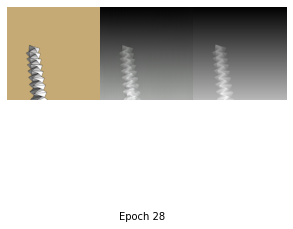

Epoch [29/50], Step [1/3750], D_loss: 0.0079, G_loss: 12.9565
Epoch [29/50], Step [2/3750], D_loss: 0.0680, G_loss: 8.1714
Epoch [29/50], Step [3/3750], D_loss: 0.1346, G_loss: 10.7613
Epoch [29/50], Step [4/3750], D_loss: 0.0134, G_loss: 9.2180
Epoch [29/50], Step [5/3750], D_loss: 0.0037, G_loss: 12.5462
Epoch [29/50], Step [6/3750], D_loss: 0.1159, G_loss: 7.5482
Epoch [29/50], Step [7/3750], D_loss: 0.0545, G_loss: 8.0955
Epoch [29/50], Step [8/3750], D_loss: 0.0035, G_loss: 12.7694
Epoch [29/50], Step [9/3750], D_loss: 0.0044, G_loss: 7.2984
Epoch [29/50], Step [10/3750], D_loss: 0.0606, G_loss: 8.2905
Epoch [29/50], Step [11/3750], D_loss: 0.0012, G_loss: 11.2850
Epoch [29/50], Step [12/3750], D_loss: 0.0349, G_loss: 13.0463
Epoch [29/50], Step [13/3750], D_loss: 0.0018, G_loss: 13.7929
Epoch [29/50], Step [14/3750], D_loss: 0.0096, G_loss: 12.1753
Epoch [29/50], Step [15/3750], D_loss: 0.0013, G_loss: 8.0034
Epoch [29/50], Step [16/3750], D_loss: 0.0860, G_loss: 8.2298
Epoch [29

Epoch [29/50], Step [132/3750], D_loss: 0.0857, G_loss: 7.8077
Epoch [29/50], Step [133/3750], D_loss: 0.0284, G_loss: 8.1799
Epoch [29/50], Step [134/3750], D_loss: 0.0443, G_loss: 6.5386
Epoch [29/50], Step [135/3750], D_loss: 0.0137, G_loss: 9.2152
Epoch [29/50], Step [136/3750], D_loss: 0.0038, G_loss: 8.7940
Epoch [29/50], Step [137/3750], D_loss: 0.0062, G_loss: 12.7921
Epoch [29/50], Step [138/3750], D_loss: 0.0112, G_loss: 11.8206
Epoch [29/50], Step [139/3750], D_loss: 0.0209, G_loss: 9.0287
Epoch [29/50], Step [140/3750], D_loss: 0.0418, G_loss: 8.0005
Epoch [29/50], Step [141/3750], D_loss: 0.0272, G_loss: 6.0783
Epoch [29/50], Step [142/3750], D_loss: 0.0189, G_loss: 16.7594
Epoch [29/50], Step [143/3750], D_loss: 0.0053, G_loss: 13.0686
Epoch [29/50], Step [144/3750], D_loss: 0.0073, G_loss: 9.2346
Epoch [29/50], Step [145/3750], D_loss: 0.0297, G_loss: 10.2027
Epoch [29/50], Step [146/3750], D_loss: 0.0240, G_loss: 8.5157
Epoch [29/50], Step [147/3750], D_loss: 0.1667, G_

Epoch [29/50], Step [262/3750], D_loss: 0.0020, G_loss: 16.6491
Epoch [29/50], Step [263/3750], D_loss: 0.1490, G_loss: 8.0693
Epoch [29/50], Step [264/3750], D_loss: 0.0416, G_loss: 8.7773
Epoch [29/50], Step [265/3750], D_loss: 0.0346, G_loss: 7.8521
Epoch [29/50], Step [266/3750], D_loss: 0.0311, G_loss: 7.7029
Epoch [29/50], Step [267/3750], D_loss: 0.0354, G_loss: 16.6391
Epoch [29/50], Step [268/3750], D_loss: 0.0058, G_loss: 9.8879
Epoch [29/50], Step [269/3750], D_loss: 0.0327, G_loss: 15.5974
Epoch [29/50], Step [270/3750], D_loss: 0.0134, G_loss: 7.7989
Epoch [29/50], Step [271/3750], D_loss: 0.0757, G_loss: 10.0564
Epoch [29/50], Step [272/3750], D_loss: 0.0281, G_loss: 7.9107
Epoch [29/50], Step [273/3750], D_loss: 0.0030, G_loss: 13.9692
Epoch [29/50], Step [274/3750], D_loss: 0.0039, G_loss: 11.9817
Epoch [29/50], Step [275/3750], D_loss: 0.0029, G_loss: 7.4714
Epoch [29/50], Step [276/3750], D_loss: 0.0491, G_loss: 7.2298
Epoch [29/50], Step [277/3750], D_loss: 0.2186, G

Epoch [29/50], Step [392/3750], D_loss: 0.0053, G_loss: 9.5961
Epoch [29/50], Step [393/3750], D_loss: 0.0192, G_loss: 12.3899
Epoch [29/50], Step [394/3750], D_loss: 0.0315, G_loss: 15.6163
Epoch [29/50], Step [395/3750], D_loss: 0.0308, G_loss: 6.3702
Epoch [29/50], Step [396/3750], D_loss: 0.0078, G_loss: 8.9052
Epoch [29/50], Step [397/3750], D_loss: 0.0171, G_loss: 7.6607
Epoch [29/50], Step [398/3750], D_loss: 0.0088, G_loss: 8.4324
Epoch [29/50], Step [399/3750], D_loss: 0.0642, G_loss: 7.1210
Epoch [29/50], Step [400/3750], D_loss: 0.1785, G_loss: 6.3287
Epoch [29/50], Step [401/3750], D_loss: 0.0218, G_loss: 8.1633
Epoch [29/50], Step [402/3750], D_loss: 0.0444, G_loss: 8.7162
Epoch [29/50], Step [403/3750], D_loss: 0.0131, G_loss: 15.0070
Epoch [29/50], Step [404/3750], D_loss: 0.0170, G_loss: 9.1637
Epoch [29/50], Step [405/3750], D_loss: 0.0475, G_loss: 6.6180
Epoch [29/50], Step [406/3750], D_loss: 0.0033, G_loss: 12.2038
Epoch [29/50], Step [407/3750], D_loss: 0.0825, G_l

Epoch [29/50], Step [522/3750], D_loss: 0.0226, G_loss: 7.9879
Epoch [29/50], Step [523/3750], D_loss: 0.0286, G_loss: 9.8143
Epoch [29/50], Step [524/3750], D_loss: 0.0059, G_loss: 8.3341
Epoch [29/50], Step [525/3750], D_loss: 0.0070, G_loss: 11.2964
Epoch [29/50], Step [526/3750], D_loss: 0.0054, G_loss: 14.9580
Epoch [29/50], Step [527/3750], D_loss: 0.0422, G_loss: 9.1585
Epoch [29/50], Step [528/3750], D_loss: 0.1715, G_loss: 6.3004
Epoch [29/50], Step [529/3750], D_loss: 0.0345, G_loss: 17.8284
Epoch [29/50], Step [530/3750], D_loss: 0.0182, G_loss: 7.0068
Epoch [29/50], Step [531/3750], D_loss: 0.1206, G_loss: 7.1199
Epoch [29/50], Step [532/3750], D_loss: 0.0559, G_loss: 6.2128
Epoch [29/50], Step [533/3750], D_loss: 0.0361, G_loss: 13.8372
Epoch [29/50], Step [534/3750], D_loss: 0.0480, G_loss: 10.4971
Epoch [29/50], Step [535/3750], D_loss: 0.0699, G_loss: 6.2380
Epoch [29/50], Step [536/3750], D_loss: 0.0453, G_loss: 9.3843
Epoch [29/50], Step [537/3750], D_loss: 0.0427, G_

Epoch [29/50], Step [652/3750], D_loss: 0.3614, G_loss: 7.0014
Epoch [29/50], Step [653/3750], D_loss: 0.0682, G_loss: 5.5648
Epoch [29/50], Step [654/3750], D_loss: 0.1258, G_loss: 5.6736
Epoch [29/50], Step [655/3750], D_loss: 0.0583, G_loss: 8.5493
Epoch [29/50], Step [656/3750], D_loss: 0.7290, G_loss: 5.8083
Epoch [29/50], Step [657/3750], D_loss: 0.1112, G_loss: 9.8487
Epoch [29/50], Step [658/3750], D_loss: 0.4653, G_loss: 10.1762
Epoch [29/50], Step [659/3750], D_loss: 0.0600, G_loss: 11.5762
Epoch [29/50], Step [660/3750], D_loss: 0.0215, G_loss: 7.1534
Epoch [29/50], Step [661/3750], D_loss: 0.0309, G_loss: 7.3123
Epoch [29/50], Step [662/3750], D_loss: 0.0337, G_loss: 6.1463
Epoch [29/50], Step [663/3750], D_loss: 0.0138, G_loss: 8.0100
Epoch [29/50], Step [664/3750], D_loss: 0.0099, G_loss: 6.0225
Epoch [29/50], Step [665/3750], D_loss: 0.1330, G_loss: 8.4844
Epoch [29/50], Step [666/3750], D_loss: 0.0210, G_loss: 11.5957
Epoch [29/50], Step [667/3750], D_loss: 0.0524, G_lo

Epoch [29/50], Step [782/3750], D_loss: 0.0686, G_loss: 5.7136
Epoch [29/50], Step [783/3750], D_loss: 0.0040, G_loss: 7.9329
Epoch [29/50], Step [784/3750], D_loss: 0.0857, G_loss: 8.4701
Epoch [29/50], Step [785/3750], D_loss: 0.0124, G_loss: 10.2347
Epoch [29/50], Step [786/3750], D_loss: 0.0116, G_loss: 8.5629
Epoch [29/50], Step [787/3750], D_loss: 0.0041, G_loss: 8.9848
Epoch [29/50], Step [788/3750], D_loss: 0.0485, G_loss: 5.9089
Epoch [29/50], Step [789/3750], D_loss: 0.0762, G_loss: 7.8348
Epoch [29/50], Step [790/3750], D_loss: 0.0076, G_loss: 9.3179
Epoch [29/50], Step [791/3750], D_loss: 0.0052, G_loss: 7.8643
Epoch [29/50], Step [792/3750], D_loss: 0.0049, G_loss: 17.4041
Epoch [29/50], Step [793/3750], D_loss: 0.0061, G_loss: 8.1301
Epoch [29/50], Step [794/3750], D_loss: 0.0187, G_loss: 9.1690
Epoch [29/50], Step [795/3750], D_loss: 0.0656, G_loss: 4.8397
Epoch [29/50], Step [796/3750], D_loss: 0.0057, G_loss: 12.6225
Epoch [29/50], Step [797/3750], D_loss: 0.2280, G_lo

Epoch [29/50], Step [912/3750], D_loss: 0.0193, G_loss: 10.0686
Epoch [29/50], Step [913/3750], D_loss: 0.4489, G_loss: 3.5299
Epoch [29/50], Step [914/3750], D_loss: 0.0380, G_loss: 10.7237
Epoch [29/50], Step [915/3750], D_loss: 0.1292, G_loss: 6.3953
Epoch [29/50], Step [916/3750], D_loss: 0.0329, G_loss: 12.8820
Epoch [29/50], Step [917/3750], D_loss: 0.0150, G_loss: 6.3966
Epoch [29/50], Step [918/3750], D_loss: 0.1225, G_loss: 7.0628
Epoch [29/50], Step [919/3750], D_loss: 0.3963, G_loss: 5.9526
Epoch [29/50], Step [920/3750], D_loss: 0.0022, G_loss: 12.0514
Epoch [29/50], Step [921/3750], D_loss: 0.0657, G_loss: 6.9700
Epoch [29/50], Step [922/3750], D_loss: 0.0103, G_loss: 12.5154
Epoch [29/50], Step [923/3750], D_loss: 0.4506, G_loss: 7.8512
Epoch [29/50], Step [924/3750], D_loss: 0.1202, G_loss: 9.6059
Epoch [29/50], Step [925/3750], D_loss: 0.0860, G_loss: 7.4355
Epoch [29/50], Step [926/3750], D_loss: 0.0475, G_loss: 5.7775
Epoch [29/50], Step [927/3750], D_loss: 0.2457, G_

Epoch [29/50], Step [1041/3750], D_loss: 0.0588, G_loss: 9.9962
Epoch [29/50], Step [1042/3750], D_loss: 0.0045, G_loss: 12.4308
Epoch [29/50], Step [1043/3750], D_loss: 0.0028, G_loss: 16.1350
Epoch [29/50], Step [1044/3750], D_loss: 0.0183, G_loss: 11.8282
Epoch [29/50], Step [1045/3750], D_loss: 0.1774, G_loss: 5.1354
Epoch [29/50], Step [1046/3750], D_loss: 0.0604, G_loss: 7.4885
Epoch [29/50], Step [1047/3750], D_loss: 0.0073, G_loss: 6.6318
Epoch [29/50], Step [1048/3750], D_loss: 0.2302, G_loss: 11.0904
Epoch [29/50], Step [1049/3750], D_loss: 0.0733, G_loss: 7.7790
Epoch [29/50], Step [1050/3750], D_loss: 0.1469, G_loss: 11.3338
Epoch [29/50], Step [1051/3750], D_loss: 0.0211, G_loss: 7.9100
Epoch [29/50], Step [1052/3750], D_loss: 0.0461, G_loss: 6.8548
Epoch [29/50], Step [1053/3750], D_loss: 0.0097, G_loss: 12.7422
Epoch [29/50], Step [1054/3750], D_loss: 0.0743, G_loss: 7.4124
Epoch [29/50], Step [1055/3750], D_loss: 0.0139, G_loss: 11.7611
Epoch [29/50], Step [1056/3750], 

Epoch [29/50], Step [1169/3750], D_loss: 0.0822, G_loss: 17.5340
Epoch [29/50], Step [1170/3750], D_loss: 0.0182, G_loss: 20.1888
Epoch [29/50], Step [1171/3750], D_loss: 0.0180, G_loss: 6.4400
Epoch [29/50], Step [1172/3750], D_loss: 0.0127, G_loss: 10.0731
Epoch [29/50], Step [1173/3750], D_loss: 0.0353, G_loss: 6.2786
Epoch [29/50], Step [1174/3750], D_loss: 0.0283, G_loss: 8.5493
Epoch [29/50], Step [1175/3750], D_loss: 0.1454, G_loss: 5.6598
Epoch [29/50], Step [1176/3750], D_loss: 0.0119, G_loss: 6.8317
Epoch [29/50], Step [1177/3750], D_loss: 0.0122, G_loss: 11.0311
Epoch [29/50], Step [1178/3750], D_loss: 0.0280, G_loss: 7.6413
Epoch [29/50], Step [1179/3750], D_loss: 0.0200, G_loss: 6.2591
Epoch [29/50], Step [1180/3750], D_loss: 0.1102, G_loss: 8.5399
Epoch [29/50], Step [1181/3750], D_loss: 0.0122, G_loss: 6.6791
Epoch [29/50], Step [1182/3750], D_loss: 0.0128, G_loss: 7.5668
Epoch [29/50], Step [1183/3750], D_loss: 0.0687, G_loss: 6.2748
Epoch [29/50], Step [1184/3750], D_l

Epoch [29/50], Step [1297/3750], D_loss: 0.1154, G_loss: 8.6879
Epoch [29/50], Step [1298/3750], D_loss: 0.0338, G_loss: 7.1437
Epoch [29/50], Step [1299/3750], D_loss: 0.0699, G_loss: 12.9676
Epoch [29/50], Step [1300/3750], D_loss: 0.0723, G_loss: 8.0812
Epoch [29/50], Step [1301/3750], D_loss: 0.0412, G_loss: 13.7947
Epoch [29/50], Step [1302/3750], D_loss: 0.0076, G_loss: 10.3051
Epoch [29/50], Step [1303/3750], D_loss: 0.0495, G_loss: 7.4320
Epoch [29/50], Step [1304/3750], D_loss: 0.0136, G_loss: 8.3789
Epoch [29/50], Step [1305/3750], D_loss: 0.0345, G_loss: 7.7017
Epoch [29/50], Step [1306/3750], D_loss: 0.0202, G_loss: 17.0739
Epoch [29/50], Step [1307/3750], D_loss: 0.0095, G_loss: 12.4111
Epoch [29/50], Step [1308/3750], D_loss: 0.0480, G_loss: 8.6957
Epoch [29/50], Step [1309/3750], D_loss: 0.0242, G_loss: 9.5736
Epoch [29/50], Step [1310/3750], D_loss: 0.0672, G_loss: 7.5449
Epoch [29/50], Step [1311/3750], D_loss: 0.0182, G_loss: 8.8146
Epoch [29/50], Step [1312/3750], D_

Epoch [29/50], Step [1425/3750], D_loss: 0.0049, G_loss: 13.6013
Epoch [29/50], Step [1426/3750], D_loss: 0.0026, G_loss: 13.1768
Epoch [29/50], Step [1427/3750], D_loss: 0.3198, G_loss: 9.8819
Epoch [29/50], Step [1428/3750], D_loss: 0.0939, G_loss: 4.8265
Epoch [29/50], Step [1429/3750], D_loss: 0.1079, G_loss: 7.2982
Epoch [29/50], Step [1430/3750], D_loss: 0.0543, G_loss: 10.0877
Epoch [29/50], Step [1431/3750], D_loss: 0.0429, G_loss: 8.3398
Epoch [29/50], Step [1432/3750], D_loss: 0.0115, G_loss: 11.1472
Epoch [29/50], Step [1433/3750], D_loss: 0.0077, G_loss: 7.5923
Epoch [29/50], Step [1434/3750], D_loss: 0.0093, G_loss: 11.0487
Epoch [29/50], Step [1435/3750], D_loss: 0.0407, G_loss: 11.3690
Epoch [29/50], Step [1436/3750], D_loss: 0.1511, G_loss: 5.4756
Epoch [29/50], Step [1437/3750], D_loss: 0.0048, G_loss: 18.6950
Epoch [29/50], Step [1438/3750], D_loss: 0.0248, G_loss: 10.0160
Epoch [29/50], Step [1439/3750], D_loss: 0.0197, G_loss: 7.8609
Epoch [29/50], Step [1440/3750],

Epoch [29/50], Step [1553/3750], D_loss: 0.0117, G_loss: 7.6041
Epoch [29/50], Step [1554/3750], D_loss: 0.2253, G_loss: 9.2540
Epoch [29/50], Step [1555/3750], D_loss: 0.1951, G_loss: 6.7471
Epoch [29/50], Step [1556/3750], D_loss: 0.0734, G_loss: 9.9040
Epoch [29/50], Step [1557/3750], D_loss: 0.0245, G_loss: 7.1925
Epoch [29/50], Step [1558/3750], D_loss: 0.6246, G_loss: 7.3608
Epoch [29/50], Step [1559/3750], D_loss: 0.1246, G_loss: 7.9012
Epoch [29/50], Step [1560/3750], D_loss: 0.4076, G_loss: 7.6361
Epoch [29/50], Step [1561/3750], D_loss: 0.0400, G_loss: 10.2497
Epoch [29/50], Step [1562/3750], D_loss: 0.5474, G_loss: 8.1666
Epoch [29/50], Step [1563/3750], D_loss: 0.0085, G_loss: 12.3222
Epoch [29/50], Step [1564/3750], D_loss: 0.0137, G_loss: 7.8709
Epoch [29/50], Step [1565/3750], D_loss: 0.1561, G_loss: 9.5126
Epoch [29/50], Step [1566/3750], D_loss: 0.2686, G_loss: 7.6497
Epoch [29/50], Step [1567/3750], D_loss: 1.3590, G_loss: 8.1798
Epoch [29/50], Step [1568/3750], D_los

Epoch [29/50], Step [1681/3750], D_loss: 0.0768, G_loss: 7.7125
Epoch [29/50], Step [1682/3750], D_loss: 0.2314, G_loss: 12.5841
Epoch [29/50], Step [1683/3750], D_loss: 0.3003, G_loss: 7.2277
Epoch [29/50], Step [1684/3750], D_loss: 0.0984, G_loss: 7.9245
Epoch [29/50], Step [1685/3750], D_loss: 0.0056, G_loss: 8.0961
Epoch [29/50], Step [1686/3750], D_loss: 0.0409, G_loss: 10.6501
Epoch [29/50], Step [1687/3750], D_loss: 0.1060, G_loss: 6.6364
Epoch [29/50], Step [1688/3750], D_loss: 0.0961, G_loss: 8.3649
Epoch [29/50], Step [1689/3750], D_loss: 0.0321, G_loss: 11.3121
Epoch [29/50], Step [1690/3750], D_loss: 0.0134, G_loss: 9.7796
Epoch [29/50], Step [1691/3750], D_loss: 0.2387, G_loss: 7.2364
Epoch [29/50], Step [1692/3750], D_loss: 0.1310, G_loss: 8.4948
Epoch [29/50], Step [1693/3750], D_loss: 0.0360, G_loss: 14.1009
Epoch [29/50], Step [1694/3750], D_loss: 0.0189, G_loss: 14.2073
Epoch [29/50], Step [1695/3750], D_loss: 0.0928, G_loss: 10.6170
Epoch [29/50], Step [1696/3750], D

Epoch [29/50], Step [1809/3750], D_loss: 0.0507, G_loss: 13.0498
Epoch [29/50], Step [1810/3750], D_loss: 0.1742, G_loss: 7.6539
Epoch [29/50], Step [1811/3750], D_loss: 0.0291, G_loss: 13.9462
Epoch [29/50], Step [1812/3750], D_loss: 0.0257, G_loss: 12.6077
Epoch [29/50], Step [1813/3750], D_loss: 0.0126, G_loss: 7.7397
Epoch [29/50], Step [1814/3750], D_loss: 0.0203, G_loss: 12.2423
Epoch [29/50], Step [1815/3750], D_loss: 0.0330, G_loss: 12.4209
Epoch [29/50], Step [1816/3750], D_loss: 0.0149, G_loss: 11.9085
Epoch [29/50], Step [1817/3750], D_loss: 0.0486, G_loss: 10.4066
Epoch [29/50], Step [1818/3750], D_loss: 0.0264, G_loss: 6.7048
Epoch [29/50], Step [1819/3750], D_loss: 0.0344, G_loss: 7.2864
Epoch [29/50], Step [1820/3750], D_loss: 0.0175, G_loss: 10.0464
Epoch [29/50], Step [1821/3750], D_loss: 0.0434, G_loss: 11.7845
Epoch [29/50], Step [1822/3750], D_loss: 0.0548, G_loss: 7.3456
Epoch [29/50], Step [1823/3750], D_loss: 0.0245, G_loss: 6.4004
Epoch [29/50], Step [1824/3750]

Epoch [29/50], Step [1937/3750], D_loss: 0.0060, G_loss: 14.3246
Epoch [29/50], Step [1938/3750], D_loss: 0.0773, G_loss: 7.0019
Epoch [29/50], Step [1939/3750], D_loss: 0.0293, G_loss: 12.6360
Epoch [29/50], Step [1940/3750], D_loss: 0.0816, G_loss: 7.6173
Epoch [29/50], Step [1941/3750], D_loss: 0.0296, G_loss: 12.9915
Epoch [29/50], Step [1942/3750], D_loss: 0.0034, G_loss: 8.6016
Epoch [29/50], Step [1943/3750], D_loss: 0.6706, G_loss: 14.5355
Epoch [29/50], Step [1944/3750], D_loss: 0.0745, G_loss: 7.6215
Epoch [29/50], Step [1945/3750], D_loss: 0.0400, G_loss: 11.3608
Epoch [29/50], Step [1946/3750], D_loss: 0.0394, G_loss: 6.1523
Epoch [29/50], Step [1947/3750], D_loss: 0.0469, G_loss: 8.8101
Epoch [29/50], Step [1948/3750], D_loss: 0.0159, G_loss: 12.3237
Epoch [29/50], Step [1949/3750], D_loss: 0.0057, G_loss: 7.6298
Epoch [29/50], Step [1950/3750], D_loss: 0.0069, G_loss: 6.9306
Epoch [29/50], Step [1951/3750], D_loss: 0.0507, G_loss: 12.5374
Epoch [29/50], Step [1952/3750], 

Epoch [29/50], Step [2064/3750], D_loss: 0.0393, G_loss: 10.9349
Epoch [29/50], Step [2065/3750], D_loss: 0.0292, G_loss: 7.9431
Epoch [29/50], Step [2066/3750], D_loss: 0.0040, G_loss: 8.9458
Epoch [29/50], Step [2067/3750], D_loss: 0.0020, G_loss: 8.8015
Epoch [29/50], Step [2068/3750], D_loss: 0.0050, G_loss: 12.6628
Epoch [29/50], Step [2069/3750], D_loss: 0.0077, G_loss: 8.5716
Epoch [29/50], Step [2070/3750], D_loss: 0.0025, G_loss: 7.5800
Epoch [29/50], Step [2071/3750], D_loss: 0.0033, G_loss: 16.0271
Epoch [29/50], Step [2072/3750], D_loss: 0.0028, G_loss: 15.4068
Epoch [29/50], Step [2073/3750], D_loss: 0.0611, G_loss: 8.0786
Epoch [29/50], Step [2074/3750], D_loss: 0.4469, G_loss: 5.6610
Epoch [29/50], Step [2075/3750], D_loss: 0.0022, G_loss: 11.9097
Epoch [29/50], Step [2076/3750], D_loss: 0.0093, G_loss: 8.0730
Epoch [29/50], Step [2077/3750], D_loss: 0.4365, G_loss: 5.5946
Epoch [29/50], Step [2078/3750], D_loss: 0.0043, G_loss: 9.4855
Epoch [29/50], Step [2079/3750], D_

Epoch [29/50], Step [2192/3750], D_loss: 0.0298, G_loss: 9.3061
Epoch [29/50], Step [2193/3750], D_loss: 0.0266, G_loss: 8.3796
Epoch [29/50], Step [2194/3750], D_loss: 0.0098, G_loss: 7.5871
Epoch [29/50], Step [2195/3750], D_loss: 0.0800, G_loss: 12.8587
Epoch [29/50], Step [2196/3750], D_loss: 0.0101, G_loss: 6.7254
Epoch [29/50], Step [2197/3750], D_loss: 0.0090, G_loss: 15.9657
Epoch [29/50], Step [2198/3750], D_loss: 0.0111, G_loss: 12.1404
Epoch [29/50], Step [2199/3750], D_loss: 0.3182, G_loss: 7.5576
Epoch [29/50], Step [2200/3750], D_loss: 0.0176, G_loss: 8.2380
Epoch [29/50], Step [2201/3750], D_loss: 0.0509, G_loss: 8.6704
Epoch [29/50], Step [2202/3750], D_loss: 0.5227, G_loss: 8.9745
Epoch [29/50], Step [2203/3750], D_loss: 0.0514, G_loss: 9.3048
Epoch [29/50], Step [2204/3750], D_loss: 0.0032, G_loss: 12.3089
Epoch [29/50], Step [2205/3750], D_loss: 0.1827, G_loss: 8.1434
Epoch [29/50], Step [2206/3750], D_loss: 0.5721, G_loss: 7.8386
Epoch [29/50], Step [2207/3750], D_l

Epoch [29/50], Step [2320/3750], D_loss: 0.0067, G_loss: 9.8724
Epoch [29/50], Step [2321/3750], D_loss: 0.0040, G_loss: 15.7513
Epoch [29/50], Step [2322/3750], D_loss: 0.0171, G_loss: 10.6800
Epoch [29/50], Step [2323/3750], D_loss: 0.1783, G_loss: 14.1775
Epoch [29/50], Step [2324/3750], D_loss: 0.0036, G_loss: 13.9588
Epoch [29/50], Step [2325/3750], D_loss: 0.0504, G_loss: 9.4336
Epoch [29/50], Step [2326/3750], D_loss: 0.0567, G_loss: 8.3118
Epoch [29/50], Step [2327/3750], D_loss: 0.1802, G_loss: 9.6100
Epoch [29/50], Step [2328/3750], D_loss: 0.0234, G_loss: 7.5598
Epoch [29/50], Step [2329/3750], D_loss: 0.0102, G_loss: 8.9388
Epoch [29/50], Step [2330/3750], D_loss: 0.2670, G_loss: 4.6671
Epoch [29/50], Step [2331/3750], D_loss: 0.0082, G_loss: 12.7752
Epoch [29/50], Step [2332/3750], D_loss: 0.0126, G_loss: 7.0546
Epoch [29/50], Step [2333/3750], D_loss: 0.0700, G_loss: 13.8764
Epoch [29/50], Step [2334/3750], D_loss: 0.0065, G_loss: 8.6188
Epoch [29/50], Step [2335/3750], D

Epoch [29/50], Step [2448/3750], D_loss: 0.0224, G_loss: 8.0146
Epoch [29/50], Step [2449/3750], D_loss: 0.0205, G_loss: 7.9244
Epoch [29/50], Step [2450/3750], D_loss: 0.0120, G_loss: 13.3141
Epoch [29/50], Step [2451/3750], D_loss: 0.1848, G_loss: 12.9261
Epoch [29/50], Step [2452/3750], D_loss: 0.0153, G_loss: 12.9858
Epoch [29/50], Step [2453/3750], D_loss: 0.0038, G_loss: 9.1254
Epoch [29/50], Step [2454/3750], D_loss: 0.2492, G_loss: 8.4620
Epoch [29/50], Step [2455/3750], D_loss: 0.0082, G_loss: 9.9453
Epoch [29/50], Step [2456/3750], D_loss: 0.0194, G_loss: 7.4391
Epoch [29/50], Step [2457/3750], D_loss: 0.0124, G_loss: 7.1904
Epoch [29/50], Step [2458/3750], D_loss: 0.0103, G_loss: 9.3645
Epoch [29/50], Step [2459/3750], D_loss: 0.0065, G_loss: 17.6402
Epoch [29/50], Step [2460/3750], D_loss: 0.0072, G_loss: 10.3029
Epoch [29/50], Step [2461/3750], D_loss: 0.0302, G_loss: 11.9031
Epoch [29/50], Step [2462/3750], D_loss: 0.0929, G_loss: 10.1370
Epoch [29/50], Step [2463/3750], 

Epoch [29/50], Step [2576/3750], D_loss: 0.0113, G_loss: 8.8016
Epoch [29/50], Step [2577/3750], D_loss: 0.0132, G_loss: 9.0838
Epoch [29/50], Step [2578/3750], D_loss: 0.0157, G_loss: 7.3037
Epoch [29/50], Step [2579/3750], D_loss: 0.0998, G_loss: 5.9843
Epoch [29/50], Step [2580/3750], D_loss: 0.0066, G_loss: 10.9639
Epoch [29/50], Step [2581/3750], D_loss: 0.0039, G_loss: 14.6843
Epoch [29/50], Step [2582/3750], D_loss: 0.0511, G_loss: 6.6710
Epoch [29/50], Step [2583/3750], D_loss: 0.0077, G_loss: 9.0588
Epoch [29/50], Step [2584/3750], D_loss: 0.0077, G_loss: 9.7975
Epoch [29/50], Step [2585/3750], D_loss: 0.0761, G_loss: 11.0914
Epoch [29/50], Step [2586/3750], D_loss: 0.0068, G_loss: 14.4370
Epoch [29/50], Step [2587/3750], D_loss: 0.0592, G_loss: 5.3933
Epoch [29/50], Step [2588/3750], D_loss: 0.0977, G_loss: 7.1386
Epoch [29/50], Step [2589/3750], D_loss: 0.0035, G_loss: 7.8863
Epoch [29/50], Step [2590/3750], D_loss: 0.0014, G_loss: 12.8467
Epoch [29/50], Step [2591/3750], D_

Epoch [29/50], Step [2704/3750], D_loss: 0.1459, G_loss: 5.9186
Epoch [29/50], Step [2705/3750], D_loss: 0.0060, G_loss: 16.2327
Epoch [29/50], Step [2706/3750], D_loss: 0.0438, G_loss: 8.7851
Epoch [29/50], Step [2707/3750], D_loss: 0.1096, G_loss: 9.3911
Epoch [29/50], Step [2708/3750], D_loss: 0.0034, G_loss: 9.5544
Epoch [29/50], Step [2709/3750], D_loss: 0.0273, G_loss: 17.3478
Epoch [29/50], Step [2710/3750], D_loss: 0.0384, G_loss: 8.2303
Epoch [29/50], Step [2711/3750], D_loss: 0.0079, G_loss: 9.6875
Epoch [29/50], Step [2712/3750], D_loss: 0.0238, G_loss: 5.4832
Epoch [29/50], Step [2713/3750], D_loss: 0.0052, G_loss: 9.4832
Epoch [29/50], Step [2714/3750], D_loss: 0.2496, G_loss: 5.9304
Epoch [29/50], Step [2715/3750], D_loss: 0.2450, G_loss: 10.9171
Epoch [29/50], Step [2716/3750], D_loss: 0.0021, G_loss: 11.7191
Epoch [29/50], Step [2717/3750], D_loss: 0.0047, G_loss: 7.8941
Epoch [29/50], Step [2718/3750], D_loss: 0.2190, G_loss: 5.4293
Epoch [29/50], Step [2719/3750], D_l

Epoch [29/50], Step [2832/3750], D_loss: 0.0663, G_loss: 8.2119
Epoch [29/50], Step [2833/3750], D_loss: 0.7520, G_loss: 7.7179
Epoch [29/50], Step [2834/3750], D_loss: 0.2535, G_loss: 8.0663
Epoch [29/50], Step [2835/3750], D_loss: 0.1442, G_loss: 19.1318
Epoch [29/50], Step [2836/3750], D_loss: 0.8624, G_loss: 5.4791
Epoch [29/50], Step [2837/3750], D_loss: 0.4066, G_loss: 6.3283
Epoch [29/50], Step [2838/3750], D_loss: 0.2417, G_loss: 7.3615
Epoch [29/50], Step [2839/3750], D_loss: 0.2458, G_loss: 7.5638
Epoch [29/50], Step [2840/3750], D_loss: 0.1614, G_loss: 9.4491
Epoch [29/50], Step [2841/3750], D_loss: 0.7022, G_loss: 8.3706
Epoch [29/50], Step [2842/3750], D_loss: 0.0492, G_loss: 6.7377
Epoch [29/50], Step [2843/3750], D_loss: 0.0226, G_loss: 12.7990
Epoch [29/50], Step [2844/3750], D_loss: 0.0377, G_loss: 6.0003
Epoch [29/50], Step [2845/3750], D_loss: 0.0082, G_loss: 7.2083
Epoch [29/50], Step [2846/3750], D_loss: 0.0290, G_loss: 15.2691
Epoch [29/50], Step [2847/3750], D_lo

Epoch [29/50], Step [2960/3750], D_loss: 0.0031, G_loss: 10.6603
Epoch [29/50], Step [2961/3750], D_loss: 0.1961, G_loss: 8.0215
Epoch [29/50], Step [2962/3750], D_loss: 0.0079, G_loss: 10.3743
Epoch [29/50], Step [2963/3750], D_loss: 0.0977, G_loss: 9.0893
Epoch [29/50], Step [2964/3750], D_loss: 0.0078, G_loss: 7.1288
Epoch [29/50], Step [2965/3750], D_loss: 0.0078, G_loss: 14.2296
Epoch [29/50], Step [2966/3750], D_loss: 0.0103, G_loss: 13.8348
Epoch [29/50], Step [2967/3750], D_loss: 0.0422, G_loss: 7.6187
Epoch [29/50], Step [2968/3750], D_loss: 0.3706, G_loss: 5.6905
Epoch [29/50], Step [2969/3750], D_loss: 0.0939, G_loss: 13.4991
Epoch [29/50], Step [2970/3750], D_loss: 0.0630, G_loss: 7.9160
Epoch [29/50], Step [2971/3750], D_loss: 0.0591, G_loss: 7.8587
Epoch [29/50], Step [2972/3750], D_loss: 0.0746, G_loss: 11.1753
Epoch [29/50], Step [2973/3750], D_loss: 0.5055, G_loss: 7.5195
Epoch [29/50], Step [2974/3750], D_loss: 0.0444, G_loss: 8.4263
Epoch [29/50], Step [2975/3750], D

Epoch [29/50], Step [3088/3750], D_loss: 0.0136, G_loss: 10.5330
Epoch [29/50], Step [3089/3750], D_loss: 0.1743, G_loss: 9.5861
Epoch [29/50], Step [3090/3750], D_loss: 0.1432, G_loss: 6.7988
Epoch [29/50], Step [3091/3750], D_loss: 0.0158, G_loss: 9.0349
Epoch [29/50], Step [3092/3750], D_loss: 0.0881, G_loss: 8.2105
Epoch [29/50], Step [3093/3750], D_loss: 0.0964, G_loss: 5.3242
Epoch [29/50], Step [3094/3750], D_loss: 0.0686, G_loss: 9.2348
Epoch [29/50], Step [3095/3750], D_loss: 0.0285, G_loss: 14.0718
Epoch [29/50], Step [3096/3750], D_loss: 0.0100, G_loss: 6.9540
Epoch [29/50], Step [3097/3750], D_loss: 0.0751, G_loss: 7.7976
Epoch [29/50], Step [3098/3750], D_loss: 0.1939, G_loss: 10.4553
Epoch [29/50], Step [3099/3750], D_loss: 0.4650, G_loss: 7.7033
Epoch [29/50], Step [3100/3750], D_loss: 0.1527, G_loss: 7.8963
Epoch [29/50], Step [3101/3750], D_loss: 0.0632, G_loss: 6.9815
Epoch [29/50], Step [3102/3750], D_loss: 0.0456, G_loss: 11.6966
Epoch [29/50], Step [3103/3750], D_l

Epoch [29/50], Step [3216/3750], D_loss: 0.0027, G_loss: 9.6937
Epoch [29/50], Step [3217/3750], D_loss: 0.0032, G_loss: 18.6015
Epoch [29/50], Step [3218/3750], D_loss: 0.0029, G_loss: 12.3488
Epoch [29/50], Step [3219/3750], D_loss: 0.0071, G_loss: 7.9402
Epoch [29/50], Step [3220/3750], D_loss: 0.1063, G_loss: 6.1946
Epoch [29/50], Step [3221/3750], D_loss: 0.0123, G_loss: 12.6938
Epoch [29/50], Step [3222/3750], D_loss: 0.0501, G_loss: 6.2097
Epoch [29/50], Step [3223/3750], D_loss: 0.0009, G_loss: 16.3777
Epoch [29/50], Step [3224/3750], D_loss: 0.0342, G_loss: 8.9271
Epoch [29/50], Step [3225/3750], D_loss: 0.0358, G_loss: 17.5160
Epoch [29/50], Step [3226/3750], D_loss: 0.0025, G_loss: 9.3045
Epoch [29/50], Step [3227/3750], D_loss: 0.0022, G_loss: 9.3200
Epoch [29/50], Step [3228/3750], D_loss: 0.0014, G_loss: 14.5010
Epoch [29/50], Step [3229/3750], D_loss: 0.0204, G_loss: 12.8035
Epoch [29/50], Step [3230/3750], D_loss: 0.0133, G_loss: 7.4596
Epoch [29/50], Step [3231/3750], 

Epoch [29/50], Step [3344/3750], D_loss: 0.0356, G_loss: 8.5266
Epoch [29/50], Step [3345/3750], D_loss: 0.0864, G_loss: 10.4989
Epoch [29/50], Step [3346/3750], D_loss: 0.0259, G_loss: 11.7938
Epoch [29/50], Step [3347/3750], D_loss: 0.1004, G_loss: 6.1709
Epoch [29/50], Step [3348/3750], D_loss: 0.1597, G_loss: 5.7982
Epoch [29/50], Step [3349/3750], D_loss: 0.0588, G_loss: 6.3449
Epoch [29/50], Step [3350/3750], D_loss: 0.0200, G_loss: 6.9459
Epoch [29/50], Step [3351/3750], D_loss: 0.0221, G_loss: 17.4718
Epoch [29/50], Step [3352/3750], D_loss: 0.0210, G_loss: 15.3173
Epoch [29/50], Step [3353/3750], D_loss: 0.0043, G_loss: 18.3178
Epoch [29/50], Step [3354/3750], D_loss: 0.0330, G_loss: 9.7162
Epoch [29/50], Step [3355/3750], D_loss: 0.0082, G_loss: 15.2523
Epoch [29/50], Step [3356/3750], D_loss: 0.2960, G_loss: 7.1110
Epoch [29/50], Step [3357/3750], D_loss: 0.0215, G_loss: 10.9505
Epoch [29/50], Step [3358/3750], D_loss: 0.0073, G_loss: 11.2007
Epoch [29/50], Step [3359/3750],

Epoch [29/50], Step [3472/3750], D_loss: 0.0369, G_loss: 6.0270
Epoch [29/50], Step [3473/3750], D_loss: 0.1280, G_loss: 10.7059
Epoch [29/50], Step [3474/3750], D_loss: 0.3516, G_loss: 11.5492
Epoch [29/50], Step [3475/3750], D_loss: 0.0539, G_loss: 7.5333
Epoch [29/50], Step [3476/3750], D_loss: 0.1247, G_loss: 6.0048
Epoch [29/50], Step [3477/3750], D_loss: 1.2277, G_loss: 9.2748
Epoch [29/50], Step [3478/3750], D_loss: 0.1827, G_loss: 6.4125
Epoch [29/50], Step [3479/3750], D_loss: 0.0741, G_loss: 11.9853
Epoch [29/50], Step [3480/3750], D_loss: 0.2349, G_loss: 11.6153
Epoch [29/50], Step [3481/3750], D_loss: 0.0949, G_loss: 12.6873
Epoch [29/50], Step [3482/3750], D_loss: 0.0495, G_loss: 12.4876
Epoch [29/50], Step [3483/3750], D_loss: 0.2372, G_loss: 8.2403
Epoch [29/50], Step [3484/3750], D_loss: 0.0316, G_loss: 10.0243
Epoch [29/50], Step [3485/3750], D_loss: 0.0541, G_loss: 8.5796
Epoch [29/50], Step [3486/3750], D_loss: 0.0336, G_loss: 10.3985
Epoch [29/50], Step [3487/3750],

Epoch [29/50], Step [3600/3750], D_loss: 0.3101, G_loss: 6.4277
Epoch [29/50], Step [3601/3750], D_loss: 0.1266, G_loss: 8.2777
Epoch [29/50], Step [3602/3750], D_loss: 0.0654, G_loss: 9.2964
Epoch [29/50], Step [3603/3750], D_loss: 0.0503, G_loss: 22.7892
Epoch [29/50], Step [3604/3750], D_loss: 0.0736, G_loss: 15.4736
Epoch [29/50], Step [3605/3750], D_loss: 0.2990, G_loss: 5.4226
Epoch [29/50], Step [3606/3750], D_loss: 0.0350, G_loss: 5.9745
Epoch [29/50], Step [3607/3750], D_loss: 0.0813, G_loss: 5.8486
Epoch [29/50], Step [3608/3750], D_loss: 0.0611, G_loss: 8.1502
Epoch [29/50], Step [3609/3750], D_loss: 0.0108, G_loss: 6.9676
Epoch [29/50], Step [3610/3750], D_loss: 0.1324, G_loss: 10.5965
Epoch [29/50], Step [3611/3750], D_loss: 0.0724, G_loss: 6.2658
Epoch [29/50], Step [3612/3750], D_loss: 0.0853, G_loss: 5.9569
Epoch [29/50], Step [3613/3750], D_loss: 0.1207, G_loss: 5.3675
Epoch [29/50], Step [3614/3750], D_loss: 0.0593, G_loss: 7.8746
Epoch [29/50], Step [3615/3750], D_lo

Epoch [29/50], Step [3728/3750], D_loss: 0.1127, G_loss: 6.3728
Epoch [29/50], Step [3729/3750], D_loss: 0.3593, G_loss: 5.1097
Epoch [29/50], Step [3730/3750], D_loss: 0.0736, G_loss: 11.3728
Epoch [29/50], Step [3731/3750], D_loss: 0.1197, G_loss: 5.5268
Epoch [29/50], Step [3732/3750], D_loss: 0.0645, G_loss: 11.3860
Epoch [29/50], Step [3733/3750], D_loss: 0.0808, G_loss: 6.0887
Epoch [29/50], Step [3734/3750], D_loss: 0.1961, G_loss: 6.1365
Epoch [29/50], Step [3735/3750], D_loss: 0.1446, G_loss: 12.8619
Epoch [29/50], Step [3736/3750], D_loss: 0.0766, G_loss: 6.2773
Epoch [29/50], Step [3737/3750], D_loss: 0.0232, G_loss: 7.2745
Epoch [29/50], Step [3738/3750], D_loss: 0.0287, G_loss: 6.6327
Epoch [29/50], Step [3739/3750], D_loss: 0.0340, G_loss: 9.1519
Epoch [29/50], Step [3740/3750], D_loss: 0.0092, G_loss: 10.1704
Epoch [29/50], Step [3741/3750], D_loss: 0.0511, G_loss: 6.4968
Epoch [29/50], Step [3742/3750], D_loss: 0.0235, G_loss: 6.2351
Epoch [29/50], Step [3743/3750], D_l

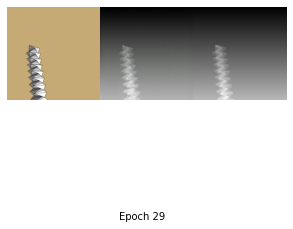

Epoch [30/50], Step [1/3750], D_loss: 0.0501, G_loss: 8.3633
Epoch [30/50], Step [2/3750], D_loss: 0.0602, G_loss: 5.3582
Epoch [30/50], Step [3/3750], D_loss: 0.0097, G_loss: 9.1911
Epoch [30/50], Step [4/3750], D_loss: 0.0117, G_loss: 8.3344
Epoch [30/50], Step [5/3750], D_loss: 0.0150, G_loss: 14.1583
Epoch [30/50], Step [6/3750], D_loss: 0.0902, G_loss: 9.3161
Epoch [30/50], Step [7/3750], D_loss: 0.0126, G_loss: 7.8973
Epoch [30/50], Step [8/3750], D_loss: 0.0101, G_loss: 11.0731
Epoch [30/50], Step [9/3750], D_loss: 0.0275, G_loss: 6.4695
Epoch [30/50], Step [10/3750], D_loss: 0.2222, G_loss: 8.0826
Epoch [30/50], Step [11/3750], D_loss: 0.0180, G_loss: 9.9295
Epoch [30/50], Step [12/3750], D_loss: 0.0341, G_loss: 9.0417
Epoch [30/50], Step [13/3750], D_loss: 0.1152, G_loss: 9.0129
Epoch [30/50], Step [14/3750], D_loss: 0.0234, G_loss: 9.5362
Epoch [30/50], Step [15/3750], D_loss: 0.0047, G_loss: 12.1451
Epoch [30/50], Step [16/3750], D_loss: 0.0083, G_loss: 8.4884
Epoch [30/50],

Epoch [30/50], Step [133/3750], D_loss: 0.0046, G_loss: 18.5963
Epoch [30/50], Step [134/3750], D_loss: 0.0080, G_loss: 10.4469
Epoch [30/50], Step [135/3750], D_loss: 0.0081, G_loss: 9.7121
Epoch [30/50], Step [136/3750], D_loss: 0.0066, G_loss: 8.6795
Epoch [30/50], Step [137/3750], D_loss: 0.1623, G_loss: 11.5116
Epoch [30/50], Step [138/3750], D_loss: 0.0174, G_loss: 8.7994
Epoch [30/50], Step [139/3750], D_loss: 0.0287, G_loss: 5.1832
Epoch [30/50], Step [140/3750], D_loss: 0.0406, G_loss: 16.6904
Epoch [30/50], Step [141/3750], D_loss: 0.0145, G_loss: 13.1112
Epoch [30/50], Step [142/3750], D_loss: 0.0183, G_loss: 12.3063
Epoch [30/50], Step [143/3750], D_loss: 0.0224, G_loss: 6.5929
Epoch [30/50], Step [144/3750], D_loss: 0.0053, G_loss: 7.7272
Epoch [30/50], Step [145/3750], D_loss: 0.0069, G_loss: 10.6444
Epoch [30/50], Step [146/3750], D_loss: 0.0083, G_loss: 7.9901
Epoch [30/50], Step [147/3750], D_loss: 0.0959, G_loss: 5.6492
Epoch [30/50], Step [148/3750], D_loss: 0.0379, 

Epoch [30/50], Step [263/3750], D_loss: 0.0143, G_loss: 12.0351
Epoch [30/50], Step [264/3750], D_loss: 0.1767, G_loss: 7.4585
Epoch [30/50], Step [265/3750], D_loss: 0.0231, G_loss: 13.0476
Epoch [30/50], Step [266/3750], D_loss: 0.2264, G_loss: 6.8083
Epoch [30/50], Step [267/3750], D_loss: 0.0411, G_loss: 11.3902
Epoch [30/50], Step [268/3750], D_loss: 0.2421, G_loss: 7.4292
Epoch [30/50], Step [269/3750], D_loss: 0.1149, G_loss: 6.5337
Epoch [30/50], Step [270/3750], D_loss: 0.2232, G_loss: 8.3742
Epoch [30/50], Step [271/3750], D_loss: 0.0071, G_loss: 11.6582
Epoch [30/50], Step [272/3750], D_loss: 0.1054, G_loss: 7.2736
Epoch [30/50], Step [273/3750], D_loss: 0.0140, G_loss: 8.4330
Epoch [30/50], Step [274/3750], D_loss: 0.0206, G_loss: 8.0154
Epoch [30/50], Step [275/3750], D_loss: 0.0303, G_loss: 7.5005
Epoch [30/50], Step [276/3750], D_loss: 0.0123, G_loss: 7.5516
Epoch [30/50], Step [277/3750], D_loss: 0.4657, G_loss: 6.2100
Epoch [30/50], Step [278/3750], D_loss: 0.2121, G_l

Epoch [30/50], Step [393/3750], D_loss: 0.1543, G_loss: 9.0992
Epoch [30/50], Step [394/3750], D_loss: 0.0271, G_loss: 7.9015
Epoch [30/50], Step [395/3750], D_loss: 0.0244, G_loss: 6.7927
Epoch [30/50], Step [396/3750], D_loss: 0.0171, G_loss: 13.2381
Epoch [30/50], Step [397/3750], D_loss: 0.0108, G_loss: 15.5318
Epoch [30/50], Step [398/3750], D_loss: 0.0088, G_loss: 11.2853
Epoch [30/50], Step [399/3750], D_loss: 0.2480, G_loss: 5.8313
Epoch [30/50], Step [400/3750], D_loss: 0.1324, G_loss: 6.4904
Epoch [30/50], Step [401/3750], D_loss: 0.0313, G_loss: 8.7055
Epoch [30/50], Step [402/3750], D_loss: 0.0666, G_loss: 9.8842
Epoch [30/50], Step [403/3750], D_loss: 0.0421, G_loss: 10.7285
Epoch [30/50], Step [404/3750], D_loss: 0.0500, G_loss: 39.6189
Epoch [30/50], Step [405/3750], D_loss: 0.1959, G_loss: 7.9534
Epoch [30/50], Step [406/3750], D_loss: 0.0090, G_loss: 12.3319
Epoch [30/50], Step [407/3750], D_loss: 0.1083, G_loss: 8.1245
Epoch [30/50], Step [408/3750], D_loss: 0.0142, G

Epoch [30/50], Step [523/3750], D_loss: 0.0041, G_loss: 9.1681
Epoch [30/50], Step [524/3750], D_loss: 0.2585, G_loss: 6.1408
Epoch [30/50], Step [525/3750], D_loss: 0.0640, G_loss: 8.7086
Epoch [30/50], Step [526/3750], D_loss: 0.0061, G_loss: 12.3158
Epoch [30/50], Step [527/3750], D_loss: 0.0321, G_loss: 7.6718
Epoch [30/50], Step [528/3750], D_loss: 0.0404, G_loss: 8.5519
Epoch [30/50], Step [529/3750], D_loss: 0.0429, G_loss: 9.8396
Epoch [30/50], Step [530/3750], D_loss: 0.0142, G_loss: 8.6028
Epoch [30/50], Step [531/3750], D_loss: 0.1093, G_loss: 8.6937
Epoch [30/50], Step [532/3750], D_loss: 0.0074, G_loss: 9.9578
Epoch [30/50], Step [533/3750], D_loss: 0.1246, G_loss: 11.8361
Epoch [30/50], Step [534/3750], D_loss: 0.1617, G_loss: 6.3040
Epoch [30/50], Step [535/3750], D_loss: 0.0078, G_loss: 10.8447
Epoch [30/50], Step [536/3750], D_loss: 0.0609, G_loss: 8.1178
Epoch [30/50], Step [537/3750], D_loss: 0.0134, G_loss: 14.4660
Epoch [30/50], Step [538/3750], D_loss: 0.0801, G_l

Epoch [30/50], Step [653/3750], D_loss: 0.3482, G_loss: 8.4176
Epoch [30/50], Step [654/3750], D_loss: 0.1135, G_loss: 8.9080
Epoch [30/50], Step [655/3750], D_loss: 0.3090, G_loss: 6.6402
Epoch [30/50], Step [656/3750], D_loss: 0.0138, G_loss: 9.1547
Epoch [30/50], Step [657/3750], D_loss: 0.0066, G_loss: 12.4739
Epoch [30/50], Step [658/3750], D_loss: 0.0040, G_loss: 9.8645
Epoch [30/50], Step [659/3750], D_loss: 0.0035, G_loss: 10.7751
Epoch [30/50], Step [660/3750], D_loss: 0.2331, G_loss: 11.0925
Epoch [30/50], Step [661/3750], D_loss: 0.0106, G_loss: 8.2752
Epoch [30/50], Step [662/3750], D_loss: 0.0046, G_loss: 10.3584
Epoch [30/50], Step [663/3750], D_loss: 0.0021, G_loss: 7.8598
Epoch [30/50], Step [664/3750], D_loss: 0.0044, G_loss: 8.0135
Epoch [30/50], Step [665/3750], D_loss: 0.0052, G_loss: 11.3618
Epoch [30/50], Step [666/3750], D_loss: 0.8176, G_loss: 6.0816
Epoch [30/50], Step [667/3750], D_loss: 0.1999, G_loss: 15.2762
Epoch [30/50], Step [668/3750], D_loss: 0.0339, G

Epoch [30/50], Step [783/3750], D_loss: 0.0098, G_loss: 9.4698
Epoch [30/50], Step [784/3750], D_loss: 0.1123, G_loss: 7.6933
Epoch [30/50], Step [785/3750], D_loss: 0.0593, G_loss: 6.7141
Epoch [30/50], Step [786/3750], D_loss: 0.0674, G_loss: 17.7614
Epoch [30/50], Step [787/3750], D_loss: 0.0725, G_loss: 8.2312
Epoch [30/50], Step [788/3750], D_loss: 0.0323, G_loss: 8.2164
Epoch [30/50], Step [789/3750], D_loss: 0.0349, G_loss: 9.6251
Epoch [30/50], Step [790/3750], D_loss: 0.0600, G_loss: 6.1026
Epoch [30/50], Step [791/3750], D_loss: 0.0146, G_loss: 10.7787
Epoch [30/50], Step [792/3750], D_loss: 0.0218, G_loss: 6.5283
Epoch [30/50], Step [793/3750], D_loss: 0.0503, G_loss: 5.5962
Epoch [30/50], Step [794/3750], D_loss: 0.0031, G_loss: 12.4655
Epoch [30/50], Step [795/3750], D_loss: 0.0315, G_loss: 11.5715
Epoch [30/50], Step [796/3750], D_loss: 0.2773, G_loss: 5.8499
Epoch [30/50], Step [797/3750], D_loss: 0.5184, G_loss: 4.3770
Epoch [30/50], Step [798/3750], D_loss: 0.0355, G_l

Epoch [30/50], Step [913/3750], D_loss: 0.1876, G_loss: 7.8325
Epoch [30/50], Step [914/3750], D_loss: 0.0171, G_loss: 6.6289
Epoch [30/50], Step [915/3750], D_loss: 0.1360, G_loss: 7.7944
Epoch [30/50], Step [916/3750], D_loss: 0.0844, G_loss: 5.5067
Epoch [30/50], Step [917/3750], D_loss: 0.0094, G_loss: 8.3035
Epoch [30/50], Step [918/3750], D_loss: 0.0305, G_loss: 6.3503
Epoch [30/50], Step [919/3750], D_loss: 0.0367, G_loss: 5.5006
Epoch [30/50], Step [920/3750], D_loss: 0.0165, G_loss: 10.4073
Epoch [30/50], Step [921/3750], D_loss: 0.0239, G_loss: 13.9852
Epoch [30/50], Step [922/3750], D_loss: 0.0051, G_loss: 12.5063
Epoch [30/50], Step [923/3750], D_loss: 0.2637, G_loss: 6.0536
Epoch [30/50], Step [924/3750], D_loss: 0.0157, G_loss: 5.7119
Epoch [30/50], Step [925/3750], D_loss: 0.1928, G_loss: 9.7721
Epoch [30/50], Step [926/3750], D_loss: 0.1168, G_loss: 8.4063
Epoch [30/50], Step [927/3750], D_loss: 0.4118, G_loss: 6.9257
Epoch [30/50], Step [928/3750], D_loss: 0.0065, G_lo

Epoch [30/50], Step [1042/3750], D_loss: 0.0006, G_loss: 13.3456
Epoch [30/50], Step [1043/3750], D_loss: 0.0041, G_loss: 12.4083
Epoch [30/50], Step [1044/3750], D_loss: 0.0019, G_loss: 9.0897
Epoch [30/50], Step [1045/3750], D_loss: 0.0806, G_loss: 6.4944
Epoch [30/50], Step [1046/3750], D_loss: 0.0032, G_loss: 12.6710
Epoch [30/50], Step [1047/3750], D_loss: 0.0151, G_loss: 9.6844
Epoch [30/50], Step [1048/3750], D_loss: 0.0238, G_loss: 9.3815
Epoch [30/50], Step [1049/3750], D_loss: 0.0833, G_loss: 6.3190
Epoch [30/50], Step [1050/3750], D_loss: 0.0027, G_loss: 12.0436
Epoch [30/50], Step [1051/3750], D_loss: 0.2105, G_loss: 9.9336
Epoch [30/50], Step [1052/3750], D_loss: 0.0109, G_loss: 16.0411
Epoch [30/50], Step [1053/3750], D_loss: 0.0080, G_loss: 18.2480
Epoch [30/50], Step [1054/3750], D_loss: 0.0200, G_loss: 10.8634
Epoch [30/50], Step [1055/3750], D_loss: 0.1218, G_loss: 5.0850
Epoch [30/50], Step [1056/3750], D_loss: 0.0032, G_loss: 9.3356
Epoch [30/50], Step [1057/3750], 

Epoch [30/50], Step [1170/3750], D_loss: 0.0148, G_loss: 10.7439
Epoch [30/50], Step [1171/3750], D_loss: 0.1622, G_loss: 6.8652
Epoch [30/50], Step [1172/3750], D_loss: 0.1157, G_loss: 8.9844
Epoch [30/50], Step [1173/3750], D_loss: 0.2011, G_loss: 5.2762
Epoch [30/50], Step [1174/3750], D_loss: 0.0120, G_loss: 10.0033
Epoch [30/50], Step [1175/3750], D_loss: 0.1317, G_loss: 5.0251
Epoch [30/50], Step [1176/3750], D_loss: 0.0041, G_loss: 13.5250
Epoch [30/50], Step [1177/3750], D_loss: 0.0927, G_loss: 9.0893
Epoch [30/50], Step [1178/3750], D_loss: 0.0058, G_loss: 10.1444
Epoch [30/50], Step [1179/3750], D_loss: 0.0254, G_loss: 8.6337
Epoch [30/50], Step [1180/3750], D_loss: 0.0508, G_loss: 8.8567
Epoch [30/50], Step [1181/3750], D_loss: 0.0021, G_loss: 11.3198
Epoch [30/50], Step [1182/3750], D_loss: 0.0153, G_loss: 13.3357
Epoch [30/50], Step [1183/3750], D_loss: 0.0089, G_loss: 13.1349
Epoch [30/50], Step [1184/3750], D_loss: 0.0039, G_loss: 20.6538
Epoch [30/50], Step [1185/3750],

Epoch [30/50], Step [1298/3750], D_loss: 0.2361, G_loss: 6.5125
Epoch [30/50], Step [1299/3750], D_loss: 0.0667, G_loss: 6.2909
Epoch [30/50], Step [1300/3750], D_loss: 0.0038, G_loss: 9.3091
Epoch [30/50], Step [1301/3750], D_loss: 0.1100, G_loss: 9.4300
Epoch [30/50], Step [1302/3750], D_loss: 0.0046, G_loss: 14.1417
Epoch [30/50], Step [1303/3750], D_loss: 0.0073, G_loss: 13.0640
Epoch [30/50], Step [1304/3750], D_loss: 0.0100, G_loss: 8.0979
Epoch [30/50], Step [1305/3750], D_loss: 0.0024, G_loss: 17.2541
Epoch [30/50], Step [1306/3750], D_loss: 0.0145, G_loss: 9.2661
Epoch [30/50], Step [1307/3750], D_loss: 0.0634, G_loss: 6.8351
Epoch [30/50], Step [1308/3750], D_loss: 0.0074, G_loss: 13.6460
Epoch [30/50], Step [1309/3750], D_loss: 0.0117, G_loss: 7.6770
Epoch [30/50], Step [1310/3750], D_loss: 0.0225, G_loss: 9.9140
Epoch [30/50], Step [1311/3750], D_loss: 0.0468, G_loss: 5.4289
Epoch [30/50], Step [1312/3750], D_loss: 0.0013, G_loss: 13.7746
Epoch [30/50], Step [1313/3750], D_

Epoch [30/50], Step [1426/3750], D_loss: 0.0674, G_loss: 7.7260
Epoch [30/50], Step [1427/3750], D_loss: 0.1459, G_loss: 6.3703
Epoch [30/50], Step [1428/3750], D_loss: 0.0610, G_loss: 7.4559
Epoch [30/50], Step [1429/3750], D_loss: 0.0014, G_loss: 16.9858
Epoch [30/50], Step [1430/3750], D_loss: 0.0037, G_loss: 8.2356
Epoch [30/50], Step [1431/3750], D_loss: 0.2258, G_loss: 6.9725
Epoch [30/50], Step [1432/3750], D_loss: 0.0071, G_loss: 7.4830
Epoch [30/50], Step [1433/3750], D_loss: 0.1788, G_loss: 7.5908
Epoch [30/50], Step [1434/3750], D_loss: 0.0026, G_loss: 12.3049
Epoch [30/50], Step [1435/3750], D_loss: 0.0934, G_loss: 8.7005
Epoch [30/50], Step [1436/3750], D_loss: 0.0361, G_loss: 11.3850
Epoch [30/50], Step [1437/3750], D_loss: 0.0097, G_loss: 7.2745
Epoch [30/50], Step [1438/3750], D_loss: 0.0177, G_loss: 5.7382
Epoch [30/50], Step [1439/3750], D_loss: 0.0043, G_loss: 12.3973
Epoch [30/50], Step [1440/3750], D_loss: 0.8733, G_loss: 3.8155
Epoch [30/50], Step [1441/3750], D_l

Epoch [30/50], Step [1554/3750], D_loss: 0.0057, G_loss: 9.4505
Epoch [30/50], Step [1555/3750], D_loss: 0.0319, G_loss: 8.0267
Epoch [30/50], Step [1556/3750], D_loss: 0.1593, G_loss: 5.9244
Epoch [30/50], Step [1557/3750], D_loss: 0.0138, G_loss: 7.4737
Epoch [30/50], Step [1558/3750], D_loss: 0.0097, G_loss: 11.9843
Epoch [30/50], Step [1559/3750], D_loss: 0.0118, G_loss: 15.7553
Epoch [30/50], Step [1560/3750], D_loss: 0.0029, G_loss: 14.1779
Epoch [30/50], Step [1561/3750], D_loss: 0.0032, G_loss: 14.6429
Epoch [30/50], Step [1562/3750], D_loss: 0.0055, G_loss: 7.9213
Epoch [30/50], Step [1563/3750], D_loss: 0.0024, G_loss: 9.6239
Epoch [30/50], Step [1564/3750], D_loss: 0.0285, G_loss: 9.2774
Epoch [30/50], Step [1565/3750], D_loss: 0.0065, G_loss: 9.2807
Epoch [30/50], Step [1566/3750], D_loss: 0.0497, G_loss: 6.9932
Epoch [30/50], Step [1567/3750], D_loss: 0.0605, G_loss: 6.7450
Epoch [30/50], Step [1568/3750], D_loss: 0.0008, G_loss: 14.4029
Epoch [30/50], Step [1569/3750], D_

Epoch [30/50], Step [1682/3750], D_loss: 0.0213, G_loss: 12.6156
Epoch [30/50], Step [1683/3750], D_loss: 0.0013, G_loss: 12.7587
Epoch [30/50], Step [1684/3750], D_loss: 0.0079, G_loss: 8.9296
Epoch [30/50], Step [1685/3750], D_loss: 0.0043, G_loss: 9.2639
Epoch [30/50], Step [1686/3750], D_loss: 0.0378, G_loss: 8.8692
Epoch [30/50], Step [1687/3750], D_loss: 0.0062, G_loss: 8.1414
Epoch [30/50], Step [1688/3750], D_loss: 0.2102, G_loss: 6.3764
Epoch [30/50], Step [1689/3750], D_loss: 0.0369, G_loss: 9.2717
Epoch [30/50], Step [1690/3750], D_loss: 0.0283, G_loss: 6.6509
Epoch [30/50], Step [1691/3750], D_loss: 0.0185, G_loss: 13.4253
Epoch [30/50], Step [1692/3750], D_loss: 0.0078, G_loss: 13.4034
Epoch [30/50], Step [1693/3750], D_loss: 0.3720, G_loss: 5.6898
Epoch [30/50], Step [1694/3750], D_loss: 0.0774, G_loss: 5.9095
Epoch [30/50], Step [1695/3750], D_loss: 0.7052, G_loss: 6.7074
Epoch [30/50], Step [1696/3750], D_loss: 0.1418, G_loss: 7.6809
Epoch [30/50], Step [1697/3750], D_l

Epoch [30/50], Step [1810/3750], D_loss: 0.0591, G_loss: 6.6831
Epoch [30/50], Step [1811/3750], D_loss: 0.0172, G_loss: 6.8925
Epoch [30/50], Step [1812/3750], D_loss: 0.3038, G_loss: 7.9405
Epoch [30/50], Step [1813/3750], D_loss: 0.0063, G_loss: 11.5547
Epoch [30/50], Step [1814/3750], D_loss: 0.0480, G_loss: 17.4384
Epoch [30/50], Step [1815/3750], D_loss: 0.0028, G_loss: 12.6154
Epoch [30/50], Step [1816/3750], D_loss: 0.1094, G_loss: 7.1720
Epoch [30/50], Step [1817/3750], D_loss: 0.0084, G_loss: 8.1052
Epoch [30/50], Step [1818/3750], D_loss: 0.0580, G_loss: 8.5183
Epoch [30/50], Step [1819/3750], D_loss: 0.0190, G_loss: 10.3452
Epoch [30/50], Step [1820/3750], D_loss: 0.0066, G_loss: 13.9567
Epoch [30/50], Step [1821/3750], D_loss: 0.1354, G_loss: 9.9523
Epoch [30/50], Step [1822/3750], D_loss: 1.0455, G_loss: 7.4559
Epoch [30/50], Step [1823/3750], D_loss: 0.1123, G_loss: 9.7561
Epoch [30/50], Step [1824/3750], D_loss: 0.0096, G_loss: 8.7509
Epoch [30/50], Step [1825/3750], D_

Epoch [30/50], Step [1938/3750], D_loss: 0.0484, G_loss: 6.5637
Epoch [30/50], Step [1939/3750], D_loss: 0.0020, G_loss: 14.3592
Epoch [30/50], Step [1940/3750], D_loss: 0.0061, G_loss: 13.0861
Epoch [30/50], Step [1941/3750], D_loss: 0.0388, G_loss: 16.2052
Epoch [30/50], Step [1942/3750], D_loss: 0.0202, G_loss: 6.8190
Epoch [30/50], Step [1943/3750], D_loss: 0.0025, G_loss: 12.4555
Epoch [30/50], Step [1944/3750], D_loss: 0.0078, G_loss: 12.2762
Epoch [30/50], Step [1945/3750], D_loss: 0.1639, G_loss: 12.8535
Epoch [30/50], Step [1946/3750], D_loss: 0.0009, G_loss: 13.5244
Epoch [30/50], Step [1947/3750], D_loss: 0.0018, G_loss: 13.7229
Epoch [30/50], Step [1948/3750], D_loss: 0.0409, G_loss: 8.0096
Epoch [30/50], Step [1949/3750], D_loss: 0.0096, G_loss: 10.9380
Epoch [30/50], Step [1950/3750], D_loss: 0.0612, G_loss: 9.4266
Epoch [30/50], Step [1951/3750], D_loss: 0.0024, G_loss: 18.1883
Epoch [30/50], Step [1952/3750], D_loss: 0.0054, G_loss: 10.9078
Epoch [30/50], Step [1953/375

Epoch [30/50], Step [2066/3750], D_loss: 0.0595, G_loss: 8.5439
Epoch [30/50], Step [2067/3750], D_loss: 0.0027, G_loss: 15.5359
Epoch [30/50], Step [2068/3750], D_loss: 0.0029, G_loss: 14.0871
Epoch [30/50], Step [2069/3750], D_loss: 0.0093, G_loss: 11.5276
Epoch [30/50], Step [2070/3750], D_loss: 0.0682, G_loss: 13.4720
Epoch [30/50], Step [2071/3750], D_loss: 0.0276, G_loss: 10.9458
Epoch [30/50], Step [2072/3750], D_loss: 0.0041, G_loss: 13.1137
Epoch [30/50], Step [2073/3750], D_loss: 0.0692, G_loss: 10.0706
Epoch [30/50], Step [2074/3750], D_loss: 0.0096, G_loss: 8.2245
Epoch [30/50], Step [2075/3750], D_loss: 0.0188, G_loss: 9.4737
Epoch [30/50], Step [2076/3750], D_loss: 0.0162, G_loss: 7.1453
Epoch [30/50], Step [2077/3750], D_loss: 0.0147, G_loss: 8.5949
Epoch [30/50], Step [2078/3750], D_loss: 0.0012, G_loss: 16.5922
Epoch [30/50], Step [2079/3750], D_loss: 0.0045, G_loss: 13.4441
Epoch [30/50], Step [2080/3750], D_loss: 0.3156, G_loss: 4.1802
Epoch [30/50], Step [2081/3750]

Epoch [30/50], Step [2194/3750], D_loss: 0.0970, G_loss: 5.6192
Epoch [30/50], Step [2195/3750], D_loss: 0.0059, G_loss: 10.5255
Epoch [30/50], Step [2196/3750], D_loss: 0.0311, G_loss: 9.3101
Epoch [30/50], Step [2197/3750], D_loss: 0.0040, G_loss: 9.4232
Epoch [30/50], Step [2198/3750], D_loss: 0.0283, G_loss: 10.3034
Epoch [30/50], Step [2199/3750], D_loss: 0.0308, G_loss: 22.2041
Epoch [30/50], Step [2200/3750], D_loss: 0.0029, G_loss: 13.0452
Epoch [30/50], Step [2201/3750], D_loss: 0.0480, G_loss: 6.8374
Epoch [30/50], Step [2202/3750], D_loss: 0.0022, G_loss: 9.4658
Epoch [30/50], Step [2203/3750], D_loss: 0.0291, G_loss: 8.3207
Epoch [30/50], Step [2204/3750], D_loss: 0.0008, G_loss: 10.8511
Epoch [30/50], Step [2205/3750], D_loss: 0.0032, G_loss: 11.5275
Epoch [30/50], Step [2206/3750], D_loss: 0.0016, G_loss: 8.6011
Epoch [30/50], Step [2207/3750], D_loss: 0.0039, G_loss: 17.3506
Epoch [30/50], Step [2208/3750], D_loss: 0.0019, G_loss: 10.5083
Epoch [30/50], Step [2209/3750],

Epoch [30/50], Step [2322/3750], D_loss: 0.1489, G_loss: 7.1660
Epoch [30/50], Step [2323/3750], D_loss: 0.0007, G_loss: 14.3279
Epoch [30/50], Step [2324/3750], D_loss: 0.1235, G_loss: 9.1183
Epoch [30/50], Step [2325/3750], D_loss: 0.0020, G_loss: 13.9452
Epoch [30/50], Step [2326/3750], D_loss: 0.0073, G_loss: 8.0025
Epoch [30/50], Step [2327/3750], D_loss: 0.0538, G_loss: 10.2640
Epoch [30/50], Step [2328/3750], D_loss: 0.1169, G_loss: 8.7472
Epoch [30/50], Step [2329/3750], D_loss: 0.0030, G_loss: 13.5503
Epoch [30/50], Step [2330/3750], D_loss: 0.1892, G_loss: 8.4760
Epoch [30/50], Step [2331/3750], D_loss: 0.0595, G_loss: 10.1071
Epoch [30/50], Step [2332/3750], D_loss: 0.0074, G_loss: 18.3524
Epoch [30/50], Step [2333/3750], D_loss: 0.1020, G_loss: 6.6197
Epoch [30/50], Step [2334/3750], D_loss: 0.0056, G_loss: 13.9834
Epoch [30/50], Step [2335/3750], D_loss: 0.0349, G_loss: 10.5284
Epoch [30/50], Step [2336/3750], D_loss: 0.0015, G_loss: 14.8748
Epoch [30/50], Step [2337/3750]

Epoch [30/50], Step [2450/3750], D_loss: 0.1120, G_loss: 7.9363
Epoch [30/50], Step [2451/3750], D_loss: 0.0670, G_loss: 8.3962
Epoch [30/50], Step [2452/3750], D_loss: 0.0458, G_loss: 10.0600
Epoch [30/50], Step [2453/3750], D_loss: 0.0092, G_loss: 13.8181
Epoch [30/50], Step [2454/3750], D_loss: 0.1407, G_loss: 8.2100
Epoch [30/50], Step [2455/3750], D_loss: 0.1619, G_loss: 6.9292
Epoch [30/50], Step [2456/3750], D_loss: 0.0270, G_loss: 14.1274
Epoch [30/50], Step [2457/3750], D_loss: 0.0452, G_loss: 11.5807
Epoch [30/50], Step [2458/3750], D_loss: 0.0810, G_loss: 9.5453
Epoch [30/50], Step [2459/3750], D_loss: 0.2338, G_loss: 10.0825
Epoch [30/50], Step [2460/3750], D_loss: 0.0659, G_loss: 5.9723
Epoch [30/50], Step [2461/3750], D_loss: 0.0333, G_loss: 7.8333
Epoch [30/50], Step [2462/3750], D_loss: 0.1381, G_loss: 6.1263
Epoch [30/50], Step [2463/3750], D_loss: 0.0656, G_loss: 7.3316
Epoch [30/50], Step [2464/3750], D_loss: 0.0193, G_loss: 29.3563
Epoch [30/50], Step [2465/3750], D

Epoch [30/50], Step [2578/3750], D_loss: 0.0824, G_loss: 11.8675
Epoch [30/50], Step [2579/3750], D_loss: 0.0011, G_loss: 10.3853
Epoch [30/50], Step [2580/3750], D_loss: 0.0270, G_loss: 14.2745
Epoch [30/50], Step [2581/3750], D_loss: 0.0648, G_loss: 8.1438
Epoch [30/50], Step [2582/3750], D_loss: 0.0393, G_loss: 8.6783
Epoch [30/50], Step [2583/3750], D_loss: 0.0008, G_loss: 8.5510
Epoch [30/50], Step [2584/3750], D_loss: 0.0015, G_loss: 12.8149
Epoch [30/50], Step [2585/3750], D_loss: 0.0128, G_loss: 11.6027
Epoch [30/50], Step [2586/3750], D_loss: 0.0008, G_loss: 14.0630
Epoch [30/50], Step [2587/3750], D_loss: 0.1051, G_loss: 6.1075
Epoch [30/50], Step [2588/3750], D_loss: 0.0010, G_loss: 9.5145
Epoch [30/50], Step [2589/3750], D_loss: 0.1381, G_loss: 7.1626
Epoch [30/50], Step [2590/3750], D_loss: 0.2198, G_loss: 5.4939
Epoch [30/50], Step [2591/3750], D_loss: 0.1485, G_loss: 5.4439
Epoch [30/50], Step [2592/3750], D_loss: 0.2395, G_loss: 25.7047
Epoch [30/50], Step [2593/3750], 

Epoch [30/50], Step [2706/3750], D_loss: 0.0256, G_loss: 12.7606
Epoch [30/50], Step [2707/3750], D_loss: 0.5285, G_loss: 7.5920
Epoch [30/50], Step [2708/3750], D_loss: 0.0087, G_loss: 10.1004
Epoch [30/50], Step [2709/3750], D_loss: 0.0226, G_loss: 7.4095
Epoch [30/50], Step [2710/3750], D_loss: 0.0935, G_loss: 9.6991
Epoch [30/50], Step [2711/3750], D_loss: 0.0059, G_loss: 10.5019
Epoch [30/50], Step [2712/3750], D_loss: 0.1817, G_loss: 7.2000
Epoch [30/50], Step [2713/3750], D_loss: 0.0753, G_loss: 11.4737
Epoch [30/50], Step [2714/3750], D_loss: 0.0266, G_loss: 9.8965
Epoch [30/50], Step [2715/3750], D_loss: 0.0284, G_loss: 7.4302
Epoch [30/50], Step [2716/3750], D_loss: 0.1171, G_loss: 9.5879
Epoch [30/50], Step [2717/3750], D_loss: 0.0685, G_loss: 7.5720
Epoch [30/50], Step [2718/3750], D_loss: 0.2180, G_loss: 5.2088
Epoch [30/50], Step [2719/3750], D_loss: 0.0285, G_loss: 8.4353
Epoch [30/50], Step [2720/3750], D_loss: 0.0672, G_loss: 9.6029
Epoch [30/50], Step [2721/3750], D_l

Epoch [30/50], Step [2834/3750], D_loss: 0.0268, G_loss: 9.6233
Epoch [30/50], Step [2835/3750], D_loss: 0.1026, G_loss: 13.4927
Epoch [30/50], Step [2836/3750], D_loss: 0.1727, G_loss: 6.3411
Epoch [30/50], Step [2837/3750], D_loss: 0.0257, G_loss: 9.2600
Epoch [30/50], Step [2838/3750], D_loss: 0.0066, G_loss: 11.7754
Epoch [30/50], Step [2839/3750], D_loss: 0.1132, G_loss: 8.8997
Epoch [30/50], Step [2840/3750], D_loss: 0.0381, G_loss: 6.4885
Epoch [30/50], Step [2841/3750], D_loss: 0.0037, G_loss: 8.8720
Epoch [30/50], Step [2842/3750], D_loss: 0.0673, G_loss: 8.1504
Epoch [30/50], Step [2843/3750], D_loss: 0.0017, G_loss: 14.5180
Epoch [30/50], Step [2844/3750], D_loss: 0.1245, G_loss: 4.7527
Epoch [30/50], Step [2845/3750], D_loss: 0.0318, G_loss: 8.6439
Epoch [30/50], Step [2846/3750], D_loss: 0.0060, G_loss: 8.2056
Epoch [30/50], Step [2847/3750], D_loss: 0.1048, G_loss: 7.9894
Epoch [30/50], Step [2848/3750], D_loss: 0.0904, G_loss: 11.8212
Epoch [30/50], Step [2849/3750], D_l

In [ ]:
# Directories for loading data and saving results
data_dir = params['dataset'] + '/'
save_dir = params['dataset'] + '_results/'
model_dir = params['dataset'] + '_model/'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Data pre-processing
transform = transforms.Compose([transforms.Scale(params['input_size']),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dataset = DatasetFromFolder(data_dir, subfolder='all', direction=params['direction'])
print(len(dataset))
datasets = train_test_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['test']))

# Train data
train_data_loader = torch.utils.data.DataLoader(dataset=datasets['train'],
                                                batch_size=params['batch_size'],
                                                shuffle=True)

# Test data
test_data_loader = torch.utils.data.DataLoader(dataset=datasets['test'],
                                               batch_size=params['batch_size'],
                                               shuffle=False)
test_input, test_target = test_data_loader.__iter__().__next__()

# Models
G = Generator(3, params['ngf'], 3)
D = Discriminator(6, params['ndf'], 1)
G.cuda()
D.cuda()
G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)

# Set the logger
D_log_dir = save_dir + 'D_logs'
G_log_dir = save_dir + 'G_logs'
if not os.path.exists(D_log_dir):
    os.mkdir(D_log_dir)
D_logger = Logger(D_log_dir)

if not os.path.exists(G_log_dir):
    os.mkdir(G_log_dir)
G_logger = Logger(G_log_dir)

# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_optimizer = torch.optim.Adam(D.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(params['num_epochs']):
    D_losses = []
    G_losses = []

    # training
    for i, (input, target) in enumerate(train_data_loader):

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = params['lamb'] * L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, params['num_epochs'], i+1, len(train_data_loader), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
        D_logger.scalar_summary('losses', D_loss.item(), step + 1)
        G_logger.scalar_summary('losses', G_loss.item(), step + 1)
        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Show result for test image
    gen_image = G(Variable(test_input.cuda()))
    gen_image = gen_image.cpu().data
    plot_test_result(test_input, test_target, gen_image, epoch, save=True, save_dir=save_dir, show=True)

# Plot average losses
plot_loss(D_avg_losses, G_avg_losses, params['num_epochs'], save=True, save_dir=save_dir, show=True)

# Make gif
make_gif(params['dataset'], params['num_epochs'], save_dir=save_dir)

# Save trained parameters of model
torch.save(G.state_dict(), model_dir + 'generator_param.pkl')
torch.save(D.state_dict(), model_dir + 'discriminator_param.pkl')